In [1]:
import os 
import sys
from tqdm import tqdm
import importlib
import numpy as np
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt

module_path = '/home/lun/project-basileus/seq-gan/'
if module_path not in sys.path:
    sys.path.append(module_path)
    
from tensorflow_probability import distributions as tfd

In [2]:
if 'sgtlstm' in sys.modules:
    importlib.reload(sys.modules['sgtlstm'])
    
from sgtlstm.utils import create_dataset
# from sgtlstm.SeqGan import build_G, build_D
from sgtlstm.pretrain import create_self_regression_data_batch
from sgtlstm.TimeLSTM import TimeLSTM0, TimeLSTM1, TimeLSTM2, TimeLSTM3

import tensorflow as tf
from tensorflow.keras.optimizers import Adam, SGD

## Load data 

In [56]:
pos_data_path = '/home/lun/project-basileus/seq-gan/data/long_seqs_v10/positive_long_sequences.pickle'
neg_data_path_v10 = '/home/lun/project-basileus/seq-gan/data/long_seqs_v10/negative_long_sequences.pickle'

# neg_data_path_v9 = '/home/lun/project-basileus/seq-gan/data/long_seqs_v9/negative_long_sequences.pickle'

neg_data_path_v8 = '/home/lun/project-basileus/seq-gan/data/long_seqs_v8/negative_long_sequences.pickle'

def load_sequence_from_pickle_to_numpy(pickle_file_path):
    """
        A list of sequence in format of (event_type, time_delta)
    :param pickle_file_path: e.g. /.../project-basileus/seq-gan/data/fixed_length/valid_sequences.pickle
    :return: (event_type_seqs, time_delta)
    """
    with open(pickle_file_path, 'rb') as f:
        raw_seqs = pickle.load(f)

    if not raw_seqs or not raw_seqs[0]:
        return np.array([]), np.array([])

    N = len(raw_seqs)
    T = len(raw_seqs[0])
    
    seqs = np.array(raw_seqs)
#     print(seqs.shape)
    
    et_seqs = seqs[:, :, 0].astype(np.float64).reshape((N, T, 1))
    ts_seqs = seqs[:, :, 1].astype(np.float64).reshape((N, T, 1))
    return et_seqs, ts_seqs
    
# only use dense v9 for pos data
pos_event_type_seqs, pos_timestamp_seqs = load_sequence_from_pickle_to_numpy(pos_data_path)

# # use both dense v9 and sparse v8 for neg data
neg_event_type_seqs_v10, neg_timestamp_seqs_v10 = load_sequence_from_pickle_to_numpy(neg_data_path_v10)
neg_event_type_seqs_v8, neg_timestamp_seqs_v8 = load_sequence_from_pickle_to_numpy(neg_data_path_v8)

neg_event_type_seqs = np.concatenate([neg_event_type_seqs_v8, neg_event_type_seqs_v10], axis=0)
neg_timestamp_seqs = np.concatenate([neg_timestamp_seqs_v8, neg_timestamp_seqs_v10], axis=0)

# neg_event_type_seqs, neg_timestamp_seqs = load_sequence_from_pickle_to_numpy(neg_data_path)

In [57]:
# downsample negative data
N_neg_sample = pos_event_type_seqs.shape[0]
neg_sample_idx = np.random.choice(np.arange(0, neg_event_type_seqs.shape[0]), size=N_neg_sample, replace=False)

neg_event_type_seqs = neg_event_type_seqs[neg_sample_idx,:,:]
neg_timestamp_seqs = neg_timestamp_seqs[neg_sample_idx,:,:]

In [64]:
pos_event_type_seqs.shape[0] / neg_event_type_seqs.shape[0]

1.0

## Global Variables 

In [67]:
BATCH_SIZE = 64
T = 20 + 1

# remove padding token, shift start token to 0
VOCAB = ['END/PADDING', 'INIT', 'start', 'view', 'click', 'install']
EVENT_VOCAB_DIM = len(VOCAB)
EMB_DIM = 6
HIDDEN_DIM = 100

END_TOKEN = 0
MAX_TIME = 1024

## G and D

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Input, LSTM, Embedding, Reshape, Dense, Dropout
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
from tensorflow.keras import regularizers

from sgtlstm.TimeLSTM import TimeLSTM0, TimeLSTM1, TimeLSTM2, TimeLSTM3

tf.keras.backend.set_floatx('float64')

def build_D_2(T, event_vocab_dim, emb_dim, hidden_dim=11):
    """
        Build a discriminator for event type sequence of shape (batch_size, T, input_dim)
        and input event type sequence of shape (batch_size, T, 1)
    :param T: length of the sequence
    :param event_vocab_dim: size of event vocabulary ['na', 'init', 'start', 'view', 'click', 'install']
    :param emb_dim: dimension of the embedding layer output for event type
    :param hidden_dim: dimension hidden of the time lstm cell
    :return: discriminator D
    """
    # Time-LSTM:
    i_et = Input(shape=(T, 1), name='event_type')  # input of discrete feature event type
    i_ts = Input(shape=(T, 1), name='time_delta')  # input of continuous feature timestamp
    mask_layer = tf.keras.layers.Masking(mask_value=0., input_shape=(T, 1))
    masked_ts = mask_layer(i_ts)
    masked_et = mask_layer(i_et)

    embed0 = Embedding(input_dim=event_vocab_dim, output_dim=emb_dim, input_length=T, mask_zero=True)(masked_et)
    embed0 = Reshape((T, emb_dim))(embed0)  # shape=[Batch_size, T, emb_dim]
    merged0 = tf.keras.layers.concatenate([embed0, masked_ts], axis=2)  # # shape=[Batch_size, T, emb_dim + time_dim]

    hm, tm = TimeLSTM1(hidden_dim, activation='selu', name='time_lstm', return_sequences=False)(merged0)

    time_comb = tf.keras.layers.concatenate([hm, tm], axis=1)

    # predicted real prob
    real_prob = Dense(1, activation='sigmoid', name='fraud_prob', kernel_regularizer=regularizers.l1_l2(l1=1e-3, l2=1e-3))(
        time_comb)

    discriminator = Model(
        inputs=[i_et, i_ts],
        outputs=[real_prob])

    return discriminator


def build_G_2(batch_size, event_vocab_dim, emb_dim, hidden_dim=11):
    """
        Build a generator for event type sequence of shape (batch_size, T, input_dim)
        and input event type sequence of shape (batch_size, T, 1)
    :param batch_size: batch size must been specified at generator
    :param event_vocab_dim: size of event vocabulary ['na', 'start', 'click', 'install']
    :param emb_dim: dimension of the embedding layer output for event type
    :param hidden_dim: dimension hidden of the time lstm cell
    :return:
    """
    # Time-LSTM:
    i_et = Input(batch_shape=(batch_size, None, 1), name='event_type')  # input of discrete feature event type
    i_ts = Input(batch_shape=(batch_size, None, 1), name='time_delta')  # input of continuous feature timestamp

    mask_layer = tf.keras.layers.Masking(mask_value=0., input_shape=(None, 1))
    masked_et = mask_layer(i_et)
    masked_ts = mask_layer(i_ts)

    embed0 = Embedding(input_dim=event_vocab_dim, output_dim=emb_dim, mask_zero=True)(masked_et)
    embed0 = Reshape([1, emb_dim])(embed0)
    merged0 = tf.keras.layers.concatenate([embed0, masked_ts], axis=2)

    hm, tm = TimeLSTM1(hidden_dim, activation='selu', name='time_lstm',
                       stateful=True, return_sequences=False)(merged0)
    
    time_comb = tf.keras.layers.concatenate([hm, tm], axis=1)
    
    dense_time = Dense(hidden_dim // 2, activation='linear', name='dense_time')(time_comb)
    dense_token = Dropout(rate=0.4)(dense_time)
    time_out = Dense(1 + 1, activation='linear', name='output')(dense_token)
    time_out = tfp.layers.DistributionLambda(
        lambda t: tfd.Normal(loc=t[..., :1],
                             scale=1 + tf.math.softplus(t[..., 1:])),
        name='Normal')(time_out)

    # predicted prob of next token
    dense_token = Dense(hidden_dim // 2, activation='linear', name='dense_token')(time_comb)
    dense_token = Dropout(rate=0.4)(dense_token)
    token_prob = Dense(event_vocab_dim, activation='softmax', name='token_prob')(dense_token)
    generator = Model(
        inputs=[i_et, i_ts],
        outputs=[token_prob, time_out])
    return generator


In [16]:
def pretrain_discriminator(features_batch, real_labels, discriminator, verbose=False, optimizer=Adam(lr=0.001)):
    # train the discriminator
    with tf.GradientTape() as tape:
        real_et, real_ts = features_batch

        # train discriminator
        true_prob = discriminator((real_et, real_ts))

        # cross-entropy loss
        ce_loss = tf.reduce_mean(
            tf.keras.losses.binary_crossentropy(real_labels, true_prob, from_logits=False))
        discriminator_loss = ce_loss

        if verbose:
            print('total discriminator loss:{}'.format(discriminator_loss))

    grads = tape.gradient(discriminator_loss, discriminator.trainable_variables)
    optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))

    return ce_loss


def pretrain_generator(feature_sample, generator, verbose=False, weight_gaussian_loss=1,
                       optimizer=Adam(lr=0.001)):
    state_et_batch, state_ts_batch = feature_sample
    _, T, _ = state_et_batch.shape

    # train the generator
    with tf.GradientTape() as tape:
        generator.reset_states()
        ce_loss_list = []
        gaussian_list = []
        for i in range(0, T-1):
            curr_state_et = state_et_batch[:, i:i + 1, :]
            curr_state_ts = state_ts_batch[:, i:i + 1, :]
            target_et = state_et_batch[:, i + 1, :]
            target_ts = state_ts_batch[:, i + 1, :]

            token_prob, time_out = generator([curr_state_et, curr_state_ts])

            gaussian_log = time_out.log_prob(target_ts)
            gaussian_loss = -tf.reduce_mean(gaussian_log)  # one step across the whole batch
            gaussian_list.append(gaussian_loss)

            ce_losses = tf.keras.losses.sparse_categorical_crossentropy(target_et, token_prob)
            ce_loss = tf.reduce_mean(ce_losses)
            ce_loss_list.append(ce_loss)

        total_ce_loss = tf.reduce_mean(ce_loss_list)
        total_gaussian_loss = tf.reduce_mean(gaussian_list)
        total_loss = total_ce_loss + weight_gaussian_loss * total_gaussian_loss

    if verbose:
        print('ce_loss:{}, gaussian_loss:{}'.format(total_ce_loss, total_gaussian_loss))

    # apply gradient decent per batch
    grads = tape.gradient(total_loss, generator.trainable_variables)
    optimizer.apply_gradients(zip(grads, generator.trainable_variables))

    return total_ce_loss, total_gaussian_loss

## Pretrain G

In [17]:
pretrain_G_et = pos_event_type_seqs
pretrain_G_ts = pos_timestamp_seqs
pretrain_G_labels = np.ones((pos_event_type_seqs.shape[0], 1))

pretrain_G_features = (pretrain_G_et, pretrain_G_ts)
N_pretrain_G = pretrain_G_et.shape[0]
N_pretrain_G

154189

In [18]:
EPOCHS = 1
_TOTAL_STEPS = int(EPOCHS * N_pretrain_G / BATCH_SIZE)


pretrain_G_dataset = create_dataset(pretrain_G_features,
                                  pretrain_G_labels,
                                  batch_size=BATCH_SIZE,
                                  epochs=EPOCHS,
                                  buffer_size=N_pretrain_G)

pretrain_gen_ce_loss_history = []
pretrain_gen_gaussian_loss_history = []

pretrained_generator = build_G_2(
    batch_size=BATCH_SIZE,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim= HIDDEN_DIM)

In [19]:
_TOTAL_STEPS

2409

In [20]:
step = 0
OPTIMIZER = Adam(lr=1e-3)
WEIGHT_GAUSSIAN_LOSS = 1

for feature_sample, _ in tqdm(pretrain_G_dataset.take(_TOTAL_STEPS)):
    step += 1
    print('Training Step:', step)
        
    gen_ce_loss, gen_gaussian_loss =  pretrain_generator(feature_sample, 
                                                         pretrained_generator,
                                                         verbose=True, 
                                                         weight_gaussian_loss=WEIGHT_GAUSSIAN_LOSS, 
                                                         optimizer=OPTIMIZER)
        
    pretrain_gen_ce_loss_history.append(gen_ce_loss.numpy())
    pretrain_gen_gaussian_loss_history.append(gen_gaussian_loss.numpy())

0it [00:00, ?it/s]

Training Step: 1
ce_loss:2.464060165998575, gaussian_loss:155.73280931013386


1it [00:02,  2.69s/it]

Training Step: 2
ce_loss:2.1439487883804227, gaussian_loss:129.31645140312133


2it [00:03,  2.08s/it]

Training Step: 3
ce_loss:1.9052895267157013, gaussian_loss:95.42373045321972


3it [00:04,  1.66s/it]

Training Step: 4
ce_loss:1.7462003515308844, gaussian_loss:72.84160008443848


4it [00:04,  1.39s/it]

Training Step: 5
ce_loss:1.6351105411009736, gaussian_loss:52.01888742073006


5it [00:05,  1.19s/it]

Training Step: 6
ce_loss:1.5673674029755442, gaussian_loss:36.79488037768808


6it [00:06,  1.06s/it]

Training Step: 7
ce_loss:1.5215937907295425, gaussian_loss:29.114693940247427


7it [00:07,  1.03it/s]

Training Step: 8
ce_loss:1.515906562470771, gaussian_loss:21.98587267285807


8it [00:07,  1.13it/s]

Training Step: 9
ce_loss:1.4742651865043026, gaussian_loss:18.06982321772755


9it [00:08,  1.18it/s]

Training Step: 10
ce_loss:1.4756990277822613, gaussian_loss:16.020863243391254


10it [00:09,  1.26it/s]

Training Step: 11
ce_loss:1.4514219030842688, gaussian_loss:14.300623149869475


11it [00:09,  1.32it/s]

Training Step: 12
ce_loss:1.4370615579199146, gaussian_loss:12.598503084463568


12it [00:10,  1.36it/s]

Training Step: 13
ce_loss:1.4241314775621068, gaussian_loss:10.753268284976468


13it [00:11,  1.35it/s]

Training Step: 14
ce_loss:1.4124123761484983, gaussian_loss:10.701011570759656


14it [00:11,  1.37it/s]

Training Step: 15
ce_loss:1.4039176057359033, gaussian_loss:9.71295823035501


15it [00:12,  1.40it/s]

Training Step: 16
ce_loss:1.4054978418119992, gaussian_loss:8.701932165723244


16it [00:13,  1.42it/s]

Training Step: 17
ce_loss:1.4031546253053533, gaussian_loss:8.827398230827288


17it [00:14,  1.38it/s]

Training Step: 18
ce_loss:1.412570165147941, gaussian_loss:8.415416865374398


18it [00:14,  1.34it/s]

Training Step: 19
ce_loss:1.4143295002950265, gaussian_loss:7.510063895025641


19it [00:15,  1.38it/s]

Training Step: 20
ce_loss:1.405004907245869, gaussian_loss:8.035469447115272


20it [00:16,  1.41it/s]

Training Step: 21
ce_loss:1.4046498885487675, gaussian_loss:7.847105828841741


21it [00:16,  1.42it/s]

Training Step: 22
ce_loss:1.4069107751783032, gaussian_loss:7.876766139317629


22it [00:17,  1.38it/s]

Training Step: 23
ce_loss:1.4234669786928347, gaussian_loss:7.850709505763665


23it [00:18,  1.41it/s]

Training Step: 24
ce_loss:1.4069351812052928, gaussian_loss:7.620062233708046


24it [00:19,  1.43it/s]

Training Step: 25
ce_loss:1.4465938507718779, gaussian_loss:7.444633568900701


25it [00:19,  1.44it/s]

Training Step: 26
ce_loss:1.437481261070597, gaussian_loss:7.368784117043996


26it [00:20,  1.41it/s]

Training Step: 27
ce_loss:1.4850274040967768, gaussian_loss:7.579392622172011


27it [00:21,  1.39it/s]

Training Step: 28
ce_loss:1.5100382049125876, gaussian_loss:7.297544443868112


28it [00:21,  1.42it/s]

Training Step: 29
ce_loss:1.5642269651887717, gaussian_loss:8.389021687040882


29it [00:22,  1.44it/s]

Training Step: 30
ce_loss:1.4838724434900956, gaussian_loss:7.780735159965269


30it [00:23,  1.45it/s]

Training Step: 31
ce_loss:1.6561822293661745, gaussian_loss:7.79693748626884


31it [00:23,  1.46it/s]

Training Step: 32
ce_loss:1.5476545895568141, gaussian_loss:7.300908610032518


32it [00:24,  1.40it/s]

Training Step: 33
ce_loss:1.5539714343587216, gaussian_loss:8.144698993153758


33it [00:25,  1.42it/s]

Training Step: 34
ce_loss:1.5001589052585602, gaussian_loss:7.814604967000841


34it [00:26,  1.43it/s]

Training Step: 35
ce_loss:1.6489853868883455, gaussian_loss:7.493858846236874


35it [00:26,  1.43it/s]

Training Step: 36
ce_loss:1.581269840166636, gaussian_loss:7.558181170205316


36it [00:27,  1.39it/s]

Training Step: 37
ce_loss:1.6002675396771018, gaussian_loss:7.13819400313993


37it [00:28,  1.41it/s]

Training Step: 38
ce_loss:1.6425106646606085, gaussian_loss:7.1583575669712305


38it [00:28,  1.42it/s]

Training Step: 39
ce_loss:1.4816907591478607, gaussian_loss:7.367555624073594


39it [00:29,  1.40it/s]

Training Step: 40
ce_loss:1.5381371667104304, gaussian_loss:8.073446843452627


40it [00:30,  1.42it/s]

Training Step: 41
ce_loss:1.5439048211042932, gaussian_loss:7.648590685176058


41it [00:31,  1.39it/s]

Training Step: 42
ce_loss:1.439341628043, gaussian_loss:7.111288646579155


42it [00:31,  1.40it/s]

Training Step: 43
ce_loss:1.5083538446095868, gaussian_loss:7.450109895748095


43it [00:32,  1.39it/s]

Training Step: 44
ce_loss:1.4482904501300786, gaussian_loss:6.944484710659333


44it [00:33,  1.41it/s]

Training Step: 45
ce_loss:1.4247170250747272, gaussian_loss:8.109157564969067


45it [00:33,  1.37it/s]

Training Step: 46
ce_loss:1.4283548418391798, gaussian_loss:6.870085391373176


46it [00:34,  1.38it/s]

Training Step: 47
ce_loss:1.4372678090433124, gaussian_loss:7.566038168393556


47it [00:35,  1.37it/s]

Training Step: 48
ce_loss:1.4266598371215713, gaussian_loss:7.920375885920498


48it [00:36,  1.34it/s]

Training Step: 49
ce_loss:1.4452111807544514, gaussian_loss:7.451216512524958


49it [00:36,  1.32it/s]

Training Step: 50
ce_loss:1.4594878714540616, gaussian_loss:7.834817742280873


50it [00:37,  1.36it/s]

Training Step: 51
ce_loss:1.4232662083854861, gaussian_loss:6.992382021243157


51it [00:38,  1.38it/s]

Training Step: 52
ce_loss:1.479585059840193, gaussian_loss:7.760681067572821


52it [00:39,  1.41it/s]

Training Step: 53
ce_loss:1.436451440077499, gaussian_loss:7.066671283488039


53it [00:39,  1.42it/s]

Training Step: 54
ce_loss:1.4066996815711694, gaussian_loss:7.446876479262554


54it [00:40,  1.37it/s]

Training Step: 55
ce_loss:1.4600223836189028, gaussian_loss:7.015769888829107


55it [00:41,  1.40it/s]

Training Step: 56
ce_loss:1.4075635014626762, gaussian_loss:6.51019516983104


56it [00:41,  1.41it/s]

Training Step: 57
ce_loss:1.4119510715259005, gaussian_loss:6.888418704052155


57it [00:42,  1.42it/s]

Training Step: 58
ce_loss:1.3982501880298397, gaussian_loss:7.187353542771213


58it [00:43,  1.37it/s]

Training Step: 59
ce_loss:1.4088817180048219, gaussian_loss:7.08148919653928


59it [00:44,  1.39it/s]

Training Step: 60
ce_loss:1.4177227475732403, gaussian_loss:6.670835820033849


60it [00:44,  1.41it/s]

Training Step: 61
ce_loss:1.395577250061313, gaussian_loss:7.0705545757296235


61it [00:45,  1.42it/s]

Training Step: 62
ce_loss:1.4007940322646837, gaussian_loss:8.06083906236007


62it [00:46,  1.43it/s]

Training Step: 63
ce_loss:1.416736560766092, gaussian_loss:6.498126978380077


63it [00:46,  1.39it/s]

Training Step: 64
ce_loss:1.4412019100206033, gaussian_loss:6.884525248399593


64it [00:47,  1.40it/s]

Training Step: 65
ce_loss:1.4083644097656098, gaussian_loss:6.8945297261006555


65it [00:48,  1.41it/s]

Training Step: 66
ce_loss:1.4155330440282206, gaussian_loss:7.173337391029358


66it [00:49,  1.42it/s]

Training Step: 67
ce_loss:1.4380751203885276, gaussian_loss:6.513469825302924


67it [00:49,  1.38it/s]

Training Step: 68
ce_loss:1.44344533563888, gaussian_loss:6.9085145252353


68it [00:50,  1.41it/s]

Training Step: 69
ce_loss:1.4070858648588735, gaussian_loss:7.14410023711171


69it [00:51,  1.43it/s]

Training Step: 70
ce_loss:1.4455553303561839, gaussian_loss:6.499930141010985


70it [00:51,  1.44it/s]

Training Step: 71
ce_loss:1.429812098212614, gaussian_loss:7.203543759289157


71it [00:52,  1.45it/s]

Training Step: 72
ce_loss:1.4032627573924494, gaussian_loss:6.225966428247272


72it [00:53,  1.39it/s]

Training Step: 73
ce_loss:1.4253973459113578, gaussian_loss:6.830876071879589


73it [00:53,  1.41it/s]

Training Step: 74
ce_loss:1.4457239567184872, gaussian_loss:6.854911468037355


74it [00:54,  1.43it/s]

Training Step: 75
ce_loss:1.4076089278040353, gaussian_loss:6.383644653708661


75it [00:55,  1.43it/s]

Training Step: 76
ce_loss:1.3890580524583986, gaussian_loss:6.336770524388534


76it [00:56,  1.39it/s]

Training Step: 77
ce_loss:1.4489411652751314, gaussian_loss:7.281017592080227


77it [00:56,  1.42it/s]

Training Step: 78
ce_loss:1.4413584644205009, gaussian_loss:6.500805753822524


78it [00:57,  1.42it/s]

Training Step: 79
ce_loss:1.3830060567568883, gaussian_loss:7.238026724583952


79it [00:58,  1.43it/s]

Training Step: 80
ce_loss:1.4027057713208204, gaussian_loss:6.59052073662072


80it [00:58,  1.42it/s]

Training Step: 81
ce_loss:1.4017271464671217, gaussian_loss:6.408981002849529


81it [00:59,  1.34it/s]

Training Step: 82
ce_loss:1.4172512452168708, gaussian_loss:6.814716592763159


82it [01:00,  1.37it/s]

Training Step: 83
ce_loss:1.3851468604234678, gaussian_loss:6.603533246252686


83it [01:01,  1.40it/s]

Training Step: 84
ce_loss:1.3896216357776157, gaussian_loss:6.602083967248413


84it [01:01,  1.40it/s]

Training Step: 85
ce_loss:1.4183791015275695, gaussian_loss:6.439327409374352


85it [01:02,  1.41it/s]

Training Step: 86
ce_loss:1.4008802833089962, gaussian_loss:6.08745961006135


86it [01:03,  1.37it/s]

Training Step: 87
ce_loss:1.3723411055562305, gaussian_loss:6.7572346755315795


87it [01:04,  1.35it/s]

Training Step: 88
ce_loss:1.4079468950650944, gaussian_loss:6.909015203263903


88it [01:04,  1.36it/s]

Training Step: 89
ce_loss:1.387118232485193, gaussian_loss:6.221772491670173


89it [01:05,  1.38it/s]

Training Step: 90
ce_loss:1.3872198476403892, gaussian_loss:5.6020922883048385


90it [01:06,  1.35it/s]

Training Step: 91
ce_loss:1.3921418154015324, gaussian_loss:6.3900892611187965


91it [01:06,  1.38it/s]

Training Step: 92
ce_loss:1.3848127954909684, gaussian_loss:6.562412369541707


92it [01:07,  1.40it/s]

Training Step: 93
ce_loss:1.3902672644912766, gaussian_loss:6.671055735680622


93it [01:08,  1.42it/s]

Training Step: 94
ce_loss:1.3839562051292424, gaussian_loss:6.8029806033000195


94it [01:09,  1.44it/s]

Training Step: 95
ce_loss:1.386927639916901, gaussian_loss:6.113857578291535


95it [01:09,  1.39it/s]

Training Step: 96
ce_loss:1.3717860523386665, gaussian_loss:6.393769161375423


96it [01:10,  1.40it/s]

Training Step: 97
ce_loss:1.3880102415032904, gaussian_loss:6.029980971748712


97it [01:11,  1.41it/s]

Training Step: 98
ce_loss:1.3788377742289357, gaussian_loss:6.532597384070836


98it [01:11,  1.41it/s]

Training Step: 99
ce_loss:1.373170373366911, gaussian_loss:6.435009327809044


99it [01:12,  1.37it/s]

Training Step: 100
ce_loss:1.3832723677000196, gaussian_loss:6.518474201398016


100it [01:13,  1.40it/s]

Training Step: 101
ce_loss:1.3845210790733573, gaussian_loss:5.905727399379574


101it [01:14,  1.42it/s]

Training Step: 102
ce_loss:1.3745460023258556, gaussian_loss:6.193236136654413


102it [01:14,  1.44it/s]

Training Step: 103
ce_loss:1.3918850263086928, gaussian_loss:5.9894721537414295


103it [01:15,  1.39it/s]

Training Step: 104
ce_loss:1.3831980762118132, gaussian_loss:5.910906511737293


104it [01:16,  1.41it/s]

Training Step: 105
ce_loss:1.3821770121654982, gaussian_loss:5.9460642116524784


105it [01:16,  1.43it/s]

Training Step: 106
ce_loss:1.385615423770816, gaussian_loss:6.662407598530895


106it [01:17,  1.44it/s]

Training Step: 107
ce_loss:1.3863179234215042, gaussian_loss:6.026792998817763


107it [01:18,  1.43it/s]

Training Step: 108
ce_loss:1.3792291869268918, gaussian_loss:6.407958313991932


108it [01:19,  1.38it/s]

Training Step: 109
ce_loss:1.3965339027680215, gaussian_loss:5.967939144893637


109it [01:19,  1.41it/s]

Training Step: 110
ce_loss:1.3866841067622997, gaussian_loss:6.474397165236303


110it [01:20,  1.42it/s]

Training Step: 111
ce_loss:1.3818524222086155, gaussian_loss:6.488038073976964


111it [01:21,  1.44it/s]

Training Step: 112
ce_loss:1.3852963633858668, gaussian_loss:6.326322563988283


112it [01:21,  1.38it/s]

Training Step: 113
ce_loss:1.3882937490493432, gaussian_loss:6.499902665587629


113it [01:22,  1.40it/s]

Training Step: 114
ce_loss:1.3851987943404482, gaussian_loss:6.08436596710821


114it [01:23,  1.41it/s]

Training Step: 115
ce_loss:1.3856941187154532, gaussian_loss:6.155273176144447


115it [01:23,  1.42it/s]

Training Step: 116
ce_loss:1.3817063800064449, gaussian_loss:5.996575451078181


116it [01:24,  1.43it/s]

Training Step: 117
ce_loss:1.379821958308219, gaussian_loss:6.249168536090393


117it [01:25,  1.38it/s]

Training Step: 118
ce_loss:1.387637467358763, gaussian_loss:6.452437918392415


118it [01:26,  1.39it/s]

Training Step: 119
ce_loss:1.389514744667387, gaussian_loss:5.349010183456787


119it [01:26,  1.41it/s]

Training Step: 120
ce_loss:1.3866530020451244, gaussian_loss:6.605207397663324


120it [01:27,  1.42it/s]

Training Step: 121
ce_loss:1.3826856647231935, gaussian_loss:6.024454316708921


121it [01:28,  1.34it/s]

Training Step: 122
ce_loss:1.4003065656628428, gaussian_loss:6.478721453142339


122it [01:29,  1.37it/s]

Training Step: 123
ce_loss:1.3799633872001973, gaussian_loss:5.811865607270555


123it [01:29,  1.38it/s]

Training Step: 124
ce_loss:1.39419671702647, gaussian_loss:5.8958844939491994


124it [01:30,  1.40it/s]

Training Step: 125
ce_loss:1.3799685309609826, gaussian_loss:6.349918881135361


125it [01:31,  1.41it/s]

Training Step: 126
ce_loss:1.3957112839352033, gaussian_loss:6.401721764676364


126it [01:31,  1.37it/s]

Training Step: 127
ce_loss:1.3840658274054047, gaussian_loss:6.25208782052554


127it [01:32,  1.38it/s]

Training Step: 128
ce_loss:1.3838102064233742, gaussian_loss:6.2955604021049965


128it [01:33,  1.35it/s]

Training Step: 129
ce_loss:1.3865886261738276, gaussian_loss:5.680296407029993


129it [01:34,  1.37it/s]

Training Step: 130
ce_loss:1.3855378859850582, gaussian_loss:5.878675901656402


130it [01:34,  1.34it/s]

Training Step: 131
ce_loss:1.3909220906425488, gaussian_loss:5.624203040652603


131it [01:35,  1.37it/s]

Training Step: 132
ce_loss:1.3797697620472065, gaussian_loss:6.400033460327059


132it [01:36,  1.39it/s]

Training Step: 133
ce_loss:1.384777693051787, gaussian_loss:6.500029959342615


133it [01:36,  1.40it/s]

Training Step: 134
ce_loss:1.39981041603077, gaussian_loss:6.244624150185601


134it [01:37,  1.41it/s]

Training Step: 135
ce_loss:1.3748350652815418, gaussian_loss:6.308271777719955


135it [01:38,  1.36it/s]

Training Step: 136
ce_loss:1.3899264862568188, gaussian_loss:5.805146653227006


136it [01:39,  1.38it/s]

Training Step: 137
ce_loss:1.3922918971284655, gaussian_loss:6.123514582020398


137it [01:39,  1.40it/s]

Training Step: 138
ce_loss:1.384042850011896, gaussian_loss:5.5311768596836846


138it [01:40,  1.41it/s]

Training Step: 139
ce_loss:1.3857056006510569, gaussian_loss:6.203722723752949


139it [01:41,  1.42it/s]

Training Step: 140
ce_loss:1.3800320353316253, gaussian_loss:5.792008310480723


140it [01:42,  1.38it/s]

Training Step: 141
ce_loss:1.3988055351099398, gaussian_loss:5.532664075668566


141it [01:42,  1.40it/s]

Training Step: 142
ce_loss:1.3978084792245933, gaussian_loss:6.279353203665813


142it [01:43,  1.39it/s]

Training Step: 143
ce_loss:1.3849664090103744, gaussian_loss:5.884724440464349


143it [01:44,  1.40it/s]

Training Step: 144
ce_loss:1.4021548491429094, gaussian_loss:6.093284977716032


144it [01:44,  1.35it/s]

Training Step: 145
ce_loss:1.3910058364230935, gaussian_loss:6.075204117845018


145it [01:45,  1.37it/s]

Training Step: 146
ce_loss:1.395927879342678, gaussian_loss:6.02243486628897


146it [01:46,  1.38it/s]

Training Step: 147
ce_loss:1.380826495557405, gaussian_loss:6.327529706203715


147it [01:47,  1.33it/s]

Training Step: 148
ce_loss:1.3901021353792617, gaussian_loss:6.079808528620498


148it [01:47,  1.34it/s]

Training Step: 149
ce_loss:1.3863832060087735, gaussian_loss:6.064641197992673


149it [01:48,  1.28it/s]

Training Step: 150
ce_loss:1.3877638957076828, gaussian_loss:6.355590388743899


150it [01:49,  1.31it/s]

Training Step: 151
ce_loss:1.409290034847725, gaussian_loss:6.12843723520355


151it [01:50,  1.33it/s]

Training Step: 152
ce_loss:1.396003860124973, gaussian_loss:6.153362053937226


152it [01:50,  1.34it/s]

Training Step: 153
ce_loss:1.4051525439719943, gaussian_loss:6.279650359470663


153it [01:51,  1.27it/s]

Training Step: 154
ce_loss:1.3810743862904522, gaussian_loss:5.894228382342582


154it [01:52,  1.31it/s]

Training Step: 155
ce_loss:1.4058873368439684, gaussian_loss:5.979064127526591


155it [01:53,  1.34it/s]

Training Step: 156
ce_loss:1.4191212840829324, gaussian_loss:6.768786293603114


156it [01:53,  1.36it/s]

Training Step: 157
ce_loss:1.3815215995518042, gaussian_loss:6.005527541024355


157it [01:54,  1.29it/s]

Training Step: 158
ce_loss:1.3969737032434801, gaussian_loss:5.932716787793376


158it [01:55,  1.33it/s]

Training Step: 159
ce_loss:1.3951356582599155, gaussian_loss:6.210376500248834


159it [01:56,  1.36it/s]

Training Step: 160
ce_loss:1.387277979850181, gaussian_loss:6.33015068596867


160it [01:56,  1.38it/s]

Training Step: 161
ce_loss:1.3893925947739223, gaussian_loss:6.541202278573367


161it [01:57,  1.38it/s]

Training Step: 162
ce_loss:1.3845490667467026, gaussian_loss:6.255393093356792


162it [01:58,  1.35it/s]

Training Step: 163
ce_loss:1.372996415319874, gaussian_loss:5.460216707875333


163it [01:59,  1.38it/s]

Training Step: 164
ce_loss:1.3877285974138538, gaussian_loss:6.068668733147414


164it [01:59,  1.41it/s]

Training Step: 165
ce_loss:1.3921176004489157, gaussian_loss:6.419611524967865


165it [02:00,  1.42it/s]

Training Step: 166
ce_loss:1.3781916892289303, gaussian_loss:5.716626714760148


166it [02:01,  1.39it/s]

Training Step: 167
ce_loss:1.4225746009359466, gaussian_loss:6.054831248405691


167it [02:01,  1.41it/s]

Training Step: 168
ce_loss:1.3800067706161496, gaussian_loss:5.994073673084503


168it [02:02,  1.42it/s]

Training Step: 169
ce_loss:1.3861079345320075, gaussian_loss:6.0272162560676374


169it [02:03,  1.43it/s]

Training Step: 170
ce_loss:1.4005830698268968, gaussian_loss:6.068955994873204


170it [02:04,  1.43it/s]

Training Step: 171
ce_loss:1.3723375021187583, gaussian_loss:6.408659351132743


171it [02:04,  1.38it/s]

Training Step: 172
ce_loss:1.3930924609589324, gaussian_loss:5.622522647397139


172it [02:05,  1.37it/s]

Training Step: 173
ce_loss:1.3809886640378246, gaussian_loss:5.785013777623026


173it [02:06,  1.39it/s]

Training Step: 174
ce_loss:1.392098531762506, gaussian_loss:6.2719745939417875


174it [02:06,  1.42it/s]

Training Step: 175
ce_loss:1.400814358236935, gaussian_loss:6.344519765340879


175it [02:07,  1.38it/s]

Training Step: 176
ce_loss:1.3861773035581328, gaussian_loss:6.21306613081555


176it [02:08,  1.41it/s]

Training Step: 177
ce_loss:1.3943510150564618, gaussian_loss:5.6707491378277


177it [02:09,  1.37it/s]

Training Step: 178
ce_loss:1.3960128395476434, gaussian_loss:5.930121221187635


178it [02:09,  1.38it/s]

Training Step: 179
ce_loss:1.3859251012013103, gaussian_loss:6.2199518421420334


179it [02:10,  1.36it/s]

Training Step: 180
ce_loss:1.395853013801203, gaussian_loss:6.011476717831092


180it [02:11,  1.34it/s]

Training Step: 181
ce_loss:1.3727400082688206, gaussian_loss:6.114122056382139


181it [02:12,  1.32it/s]

Training Step: 182
ce_loss:1.4022830016977488, gaussian_loss:6.166692759761121


182it [02:12,  1.37it/s]

Training Step: 183
ce_loss:1.3810428731277766, gaussian_loss:6.077022661478462


183it [02:13,  1.40it/s]

Training Step: 184
ce_loss:1.4006848551031958, gaussian_loss:5.586053539197472


184it [02:14,  1.35it/s]

Training Step: 185
ce_loss:1.3891831523039389, gaussian_loss:6.783533026162983


185it [02:14,  1.38it/s]

Training Step: 186
ce_loss:1.3841504246979812, gaussian_loss:6.293185857200881


186it [02:15,  1.38it/s]

Training Step: 187
ce_loss:1.411060766124455, gaussian_loss:5.834147219252918


187it [02:16,  1.35it/s]

Training Step: 188
ce_loss:1.3818733550351365, gaussian_loss:5.618361875491182


188it [02:17,  1.32it/s]

Training Step: 189
ce_loss:1.402632987557854, gaussian_loss:6.133033004184232


189it [02:18,  1.31it/s]

Training Step: 190
ce_loss:1.42490222718796, gaussian_loss:6.078125182351624


190it [02:18,  1.36it/s]

Training Step: 191
ce_loss:1.3887950536453855, gaussian_loss:6.007451962178853


191it [02:19,  1.37it/s]

Training Step: 192
ce_loss:1.4166439285923336, gaussian_loss:6.022510157429271


192it [02:20,  1.36it/s]

Training Step: 193
ce_loss:1.3772015791914205, gaussian_loss:5.771248809684852


193it [02:20,  1.38it/s]

Training Step: 194
ce_loss:1.401640384678473, gaussian_loss:5.884564914443009


194it [02:21,  1.36it/s]

Training Step: 195
ce_loss:1.413050752790193, gaussian_loss:5.9021739748202915


195it [02:22,  1.39it/s]

Training Step: 196
ce_loss:1.3777620009867637, gaussian_loss:6.1332874904044


196it [02:23,  1.41it/s]

Training Step: 197
ce_loss:1.4312150713630785, gaussian_loss:6.542164335039797


197it [02:23,  1.42it/s]

Training Step: 198
ce_loss:1.3919383671135286, gaussian_loss:5.7828313427283895


198it [02:24,  1.37it/s]

Training Step: 199
ce_loss:1.3892558772028802, gaussian_loss:6.508753940695525


199it [02:25,  1.39it/s]

Training Step: 200
ce_loss:1.4213022791463135, gaussian_loss:6.013641940439645


200it [02:25,  1.41it/s]

Training Step: 201
ce_loss:1.3679087285542657, gaussian_loss:5.478292149358569


201it [02:26,  1.42it/s]

Training Step: 202
ce_loss:1.4113276633688396, gaussian_loss:5.870779254175326


202it [02:27,  1.42it/s]

Training Step: 203
ce_loss:1.3806338651088323, gaussian_loss:6.353102639024702


203it [02:28,  1.38it/s]

Training Step: 204
ce_loss:1.3841529468876856, gaussian_loss:6.029374643939461


204it [02:28,  1.40it/s]

Training Step: 205
ce_loss:1.3971576159958798, gaussian_loss:5.438797751036393


205it [02:29,  1.41it/s]

Training Step: 206
ce_loss:1.3699573368978353, gaussian_loss:5.60804814275559


206it [02:30,  1.36it/s]

Training Step: 207
ce_loss:1.3853451768917568, gaussian_loss:6.313944831343371


207it [02:31,  1.33it/s]

Training Step: 208
ce_loss:1.3710468322993534, gaussian_loss:5.604583131645288


208it [02:31,  1.37it/s]

Training Step: 209
ce_loss:1.3910267664121172, gaussian_loss:6.341122769759011


209it [02:32,  1.39it/s]

Training Step: 210
ce_loss:1.3749418992566234, gaussian_loss:5.554188811936126


210it [02:33,  1.41it/s]

Training Step: 211
ce_loss:1.3791152687681518, gaussian_loss:5.735579594638781


211it [02:33,  1.37it/s]

Training Step: 212
ce_loss:1.375661444603476, gaussian_loss:5.539644597263651


212it [02:34,  1.40it/s]

Training Step: 213
ce_loss:1.3823436831053353, gaussian_loss:6.011551203203206


213it [02:35,  1.42it/s]

Training Step: 214
ce_loss:1.3792850397815084, gaussian_loss:5.513595498301204


214it [02:35,  1.41it/s]

Training Step: 215
ce_loss:1.3729362476028735, gaussian_loss:5.637342285333302


215it [02:36,  1.41it/s]

Training Step: 216
ce_loss:1.3837683759489914, gaussian_loss:5.8966377234982605


216it [02:37,  1.36it/s]

Training Step: 217
ce_loss:1.378199894093941, gaussian_loss:6.218556476089132


217it [02:38,  1.39it/s]

Training Step: 218
ce_loss:1.3921989440769145, gaussian_loss:5.577256074320546


218it [02:38,  1.40it/s]

Training Step: 219
ce_loss:1.3815672179848335, gaussian_loss:5.469557992449486


219it [02:39,  1.38it/s]

Training Step: 220
ce_loss:1.387716682101905, gaussian_loss:5.923963250927171


220it [02:40,  1.35it/s]

Training Step: 221
ce_loss:1.3918577638569825, gaussian_loss:5.738190697500086


221it [02:41,  1.38it/s]

Training Step: 222
ce_loss:1.3907857608906364, gaussian_loss:6.049070501423757


222it [02:41,  1.40it/s]

Training Step: 223
ce_loss:1.3914183813287528, gaussian_loss:5.527071931139548


223it [02:42,  1.42it/s]

Training Step: 224
ce_loss:1.4029502298078491, gaussian_loss:5.539323498162019


224it [02:43,  1.39it/s]

Training Step: 225
ce_loss:1.4256218812287178, gaussian_loss:6.2011562635546404


225it [02:44,  1.32it/s]

Training Step: 226
ce_loss:1.395292165136968, gaussian_loss:5.345206723814373


226it [02:44,  1.28it/s]

Training Step: 227
ce_loss:1.413904323555832, gaussian_loss:5.985456478117034


227it [02:45,  1.33it/s]

Training Step: 228
ce_loss:1.423086226939874, gaussian_loss:6.130098522280778


228it [02:46,  1.32it/s]

Training Step: 229
ce_loss:1.4125596547504036, gaussian_loss:5.080230367498585


229it [02:47,  1.31it/s]

Training Step: 230
ce_loss:1.4108250360031263, gaussian_loss:5.711103055021626


230it [02:47,  1.34it/s]

Training Step: 231
ce_loss:1.4348248079262003, gaussian_loss:5.206789306344232


231it [02:48,  1.37it/s]

Training Step: 232
ce_loss:1.375616743378704, gaussian_loss:6.486125642629219


232it [02:49,  1.39it/s]

Training Step: 233
ce_loss:1.417186617418753, gaussian_loss:5.723261355756078


233it [02:49,  1.40it/s]

Training Step: 234
ce_loss:1.412597826525875, gaussian_loss:5.628704075803191


234it [02:50,  1.36it/s]

Training Step: 235
ce_loss:1.3751410764085423, gaussian_loss:6.017761835258443


235it [02:51,  1.39it/s]

Training Step: 236
ce_loss:1.417747871276927, gaussian_loss:5.152394382789021


236it [02:52,  1.40it/s]

Training Step: 237
ce_loss:1.4087432976281318, gaussian_loss:5.533861600223743


237it [02:52,  1.41it/s]

Training Step: 238
ce_loss:1.4117368029690902, gaussian_loss:5.518902546816231


238it [02:53,  1.36it/s]

Training Step: 239
ce_loss:1.4392561545051337, gaussian_loss:5.755167852664522


239it [02:54,  1.36it/s]

Training Step: 240
ce_loss:1.395980833484322, gaussian_loss:6.199562496005325


240it [02:54,  1.38it/s]

Training Step: 241
ce_loss:1.4211801987123678, gaussian_loss:5.919592812765287


241it [02:55,  1.39it/s]

Training Step: 242
ce_loss:1.3861219398244637, gaussian_loss:5.282584672449838


242it [02:56,  1.42it/s]

Training Step: 243
ce_loss:1.4060999385467157, gaussian_loss:5.8447711837551095


243it [02:57,  1.38it/s]

Training Step: 244
ce_loss:1.4059887298256317, gaussian_loss:5.816159784248181


244it [02:57,  1.40it/s]

Training Step: 245
ce_loss:1.3975738117790304, gaussian_loss:6.081768518881914


245it [02:58,  1.42it/s]

Training Step: 246
ce_loss:1.4196686400522252, gaussian_loss:5.817895044268965


246it [02:59,  1.43it/s]

Training Step: 247
ce_loss:1.3784202045911709, gaussian_loss:6.495687395388833


247it [02:59,  1.44it/s]

Training Step: 248
ce_loss:1.3837031698014535, gaussian_loss:5.726916481092682


248it [03:00,  1.33it/s]

Training Step: 249
ce_loss:1.3864717861393347, gaussian_loss:5.547625818128654


249it [03:01,  1.32it/s]

Training Step: 250
ce_loss:1.3861529807133537, gaussian_loss:5.819425693745361


250it [03:02,  1.36it/s]

Training Step: 251
ce_loss:1.3885991163658065, gaussian_loss:6.034997466456377


251it [03:02,  1.39it/s]

Training Step: 252
ce_loss:1.406924742721199, gaussian_loss:5.402526981913903


252it [03:03,  1.35it/s]

Training Step: 253
ce_loss:1.3719455669587466, gaussian_loss:6.010660348939732


253it [03:04,  1.38it/s]

Training Step: 254
ce_loss:1.4082017282411172, gaussian_loss:5.510367322431344


254it [03:05,  1.40it/s]

Training Step: 255
ce_loss:1.3744975518386977, gaussian_loss:5.367302928783206


255it [03:05,  1.39it/s]

Training Step: 256
ce_loss:1.3837933097061428, gaussian_loss:5.880862580912455


256it [03:06,  1.41it/s]

Training Step: 257
ce_loss:1.4107485120480276, gaussian_loss:5.396351097160244


257it [03:07,  1.29it/s]

Training Step: 258
ce_loss:1.3861624600700142, gaussian_loss:5.531335019820061


258it [03:08,  1.29it/s]

Training Step: 259
ce_loss:1.3915147448537937, gaussian_loss:5.718343541903258


259it [03:08,  1.33it/s]

Training Step: 260
ce_loss:1.3897272508676806, gaussian_loss:5.4568549645380875


260it [03:09,  1.37it/s]

Training Step: 261
ce_loss:1.3933250417985714, gaussian_loss:5.8304556902410924


261it [03:10,  1.33it/s]

Training Step: 262
ce_loss:1.3880405781580556, gaussian_loss:5.693864179622873


262it [03:11,  1.36it/s]

Training Step: 263
ce_loss:1.4153693106332774, gaussian_loss:5.903703787732523


263it [03:11,  1.39it/s]

Training Step: 264
ce_loss:1.3830924443680221, gaussian_loss:6.016142641216719


264it [03:12,  1.41it/s]

Training Step: 265
ce_loss:1.4436890063125751, gaussian_loss:5.564752245456021


265it [03:13,  1.34it/s]

Training Step: 266
ce_loss:1.3885406647325371, gaussian_loss:5.488930186237087


266it [03:13,  1.38it/s]

Training Step: 267
ce_loss:1.3872894649193275, gaussian_loss:5.560543751434141


267it [03:14,  1.40it/s]

Training Step: 268
ce_loss:1.4254863126147512, gaussian_loss:5.610451399174205


268it [03:15,  1.40it/s]

Training Step: 269
ce_loss:1.3710976896172813, gaussian_loss:5.962379340731897


269it [03:16,  1.41it/s]

Training Step: 270
ce_loss:1.3799904230833828, gaussian_loss:5.478706245755203


270it [03:16,  1.35it/s]

Training Step: 271
ce_loss:1.3938015403909252, gaussian_loss:6.582904107604262


271it [03:17,  1.38it/s]

Training Step: 272
ce_loss:1.3787230073072774, gaussian_loss:5.870232349996091


272it [03:18,  1.40it/s]

Training Step: 273
ce_loss:1.381148867613748, gaussian_loss:6.298562066806762


273it [03:18,  1.40it/s]

Training Step: 274
ce_loss:1.373002765001085, gaussian_loss:4.921067254269573


274it [03:19,  1.35it/s]

Training Step: 275
ce_loss:1.3788677202974422, gaussian_loss:5.367140305469365


275it [03:20,  1.33it/s]

Training Step: 276
ce_loss:1.376000386218907, gaussian_loss:5.9232920833682225


276it [03:21,  1.37it/s]

Training Step: 277
ce_loss:1.3735419951879617, gaussian_loss:5.461427826099037


277it [03:21,  1.39it/s]

Training Step: 278
ce_loss:1.379440600802426, gaussian_loss:5.072480493316179


278it [03:22,  1.41it/s]

Training Step: 279
ce_loss:1.36666488257544, gaussian_loss:5.827364678799328


279it [03:23,  1.37it/s]

Training Step: 280
ce_loss:1.3892258472965506, gaussian_loss:5.579173368693938


280it [03:24,  1.36it/s]

Training Step: 281
ce_loss:1.3782527004702385, gaussian_loss:5.611755702592584


281it [03:24,  1.35it/s]

Training Step: 282
ce_loss:1.3860413378798395, gaussian_loss:6.108910059879662


282it [03:25,  1.38it/s]

Training Step: 283
ce_loss:1.3732723499575332, gaussian_loss:5.825530045541337


283it [03:26,  1.35it/s]

Training Step: 284
ce_loss:1.3928155213662767, gaussian_loss:5.727555429563789


284it [03:27,  1.39it/s]

Training Step: 285
ce_loss:1.3835605699741331, gaussian_loss:5.903533357210677


285it [03:27,  1.41it/s]

Training Step: 286
ce_loss:1.3745370735740328, gaussian_loss:5.728734890242568


286it [03:28,  1.41it/s]

Training Step: 287
ce_loss:1.3617611351511054, gaussian_loss:5.329999512167843


287it [03:29,  1.43it/s]

Training Step: 288
ce_loss:1.3927531181991781, gaussian_loss:5.27892725132171


288it [03:29,  1.38it/s]

Training Step: 289
ce_loss:1.3712880167648243, gaussian_loss:5.471924911779835


289it [03:30,  1.40it/s]

Training Step: 290
ce_loss:1.3948283218036122, gaussian_loss:5.596336980913668


290it [03:31,  1.42it/s]

Training Step: 291
ce_loss:1.3889181640677548, gaussian_loss:5.756359283510174


291it [03:31,  1.42it/s]

Training Step: 292
ce_loss:1.3729329916514659, gaussian_loss:5.988561539972702


292it [03:32,  1.38it/s]

Training Step: 293
ce_loss:1.4159261681855608, gaussian_loss:5.3510644171247765


293it [03:33,  1.40it/s]

Training Step: 294
ce_loss:1.3682355835705153, gaussian_loss:5.357634009061378


294it [03:34,  1.42it/s]

Training Step: 295
ce_loss:1.385186421516477, gaussian_loss:5.031447497553595


295it [03:34,  1.43it/s]

Training Step: 296
ce_loss:1.3829700963478846, gaussian_loss:5.560262947799934


296it [03:35,  1.44it/s]

Training Step: 297
ce_loss:1.3691326526897492, gaussian_loss:5.970403167462008


297it [03:36,  1.38it/s]

Training Step: 298
ce_loss:1.3866363730367488, gaussian_loss:5.8335325974219145


298it [03:36,  1.40it/s]

Training Step: 299
ce_loss:1.3803273376800935, gaussian_loss:5.478179812481441


299it [03:37,  1.42it/s]

Training Step: 300
ce_loss:1.370787832758765, gaussian_loss:5.370996340239599


300it [03:38,  1.43it/s]

Training Step: 301
ce_loss:1.400539209328668, gaussian_loss:5.648837942367878


301it [03:39,  1.41it/s]

Training Step: 302
ce_loss:1.3785546705077678, gaussian_loss:5.187052714422097


302it [03:39,  1.33it/s]

Training Step: 303
ce_loss:1.3820933828426856, gaussian_loss:5.396989955895951


303it [03:40,  1.34it/s]

Training Step: 304
ce_loss:1.386394269946619, gaussian_loss:5.311828457204369


304it [03:41,  1.38it/s]

Training Step: 305
ce_loss:1.38838720111282, gaussian_loss:4.876804637038346


305it [03:41,  1.40it/s]

Training Step: 306
ce_loss:1.3771067134190436, gaussian_loss:5.808356622907327


306it [03:42,  1.31it/s]

Training Step: 307
ce_loss:1.37496324732534, gaussian_loss:5.1959192971292225


307it [03:43,  1.28it/s]

Training Step: 308
ce_loss:1.3859870583657448, gaussian_loss:5.305865269175982


308it [03:44,  1.33it/s]

Training Step: 309
ce_loss:1.409608614288228, gaussian_loss:4.881174706592465


309it [03:45,  1.36it/s]

Training Step: 310
ce_loss:1.384715707485424, gaussian_loss:5.142193689960079


310it [03:45,  1.39it/s]

Training Step: 311
ce_loss:1.3931945118763132, gaussian_loss:5.673457598026306


311it [03:46,  1.28it/s]

Training Step: 312
ce_loss:1.40098603192855, gaussian_loss:5.1106252710898925


312it [03:47,  1.29it/s]

Training Step: 313
ce_loss:1.394703549304885, gaussian_loss:5.335681842909972


313it [03:48,  1.32it/s]

Training Step: 314
ce_loss:1.398500170732508, gaussian_loss:5.9492566725285885


314it [03:48,  1.36it/s]

Training Step: 315
ce_loss:1.3948986325729205, gaussian_loss:5.514975327731907


315it [03:49,  1.32it/s]

Training Step: 316
ce_loss:1.3930866091537362, gaussian_loss:6.045939536315748


316it [03:50,  1.37it/s]

Training Step: 317
ce_loss:1.4060164523150007, gaussian_loss:5.406692191114757


317it [03:50,  1.40it/s]

Training Step: 318
ce_loss:1.387907073539328, gaussian_loss:5.6075626214443535


318it [03:51,  1.37it/s]

Training Step: 319
ce_loss:1.41622962411588, gaussian_loss:5.921002230729739


319it [03:52,  1.36it/s]

Training Step: 320
ce_loss:1.3995922071736147, gaussian_loss:5.609909321176721


320it [03:53,  1.40it/s]

Training Step: 321
ce_loss:1.374341766589113, gaussian_loss:5.246105287709855


321it [03:53,  1.39it/s]

Training Step: 322
ce_loss:1.4248090408118195, gaussian_loss:5.429821559396278


322it [03:54,  1.40it/s]

Training Step: 323
ce_loss:1.394595898180792, gaussian_loss:5.195291689865396


323it [03:55,  1.37it/s]

Training Step: 324
ce_loss:1.3862901389759026, gaussian_loss:5.0204700612994735


324it [03:56,  1.35it/s]

Training Step: 325
ce_loss:1.402549917002065, gaussian_loss:5.449967485674374


325it [03:56,  1.37it/s]

Training Step: 326
ce_loss:1.3739757204870515, gaussian_loss:5.7947246363338385


326it [03:57,  1.39it/s]

Training Step: 327
ce_loss:1.3682715073800193, gaussian_loss:5.453872400426342


327it [03:58,  1.42it/s]

Training Step: 328
ce_loss:1.3966023204134057, gaussian_loss:5.3111041082533195


328it [03:59,  1.36it/s]

Training Step: 329
ce_loss:1.3804089144527318, gaussian_loss:5.691397365955899


329it [03:59,  1.40it/s]

Training Step: 330
ce_loss:1.3818351374352034, gaussian_loss:5.7148090698864795


330it [04:00,  1.37it/s]

Training Step: 331
ce_loss:1.3863697542346585, gaussian_loss:5.7349835358103745


331it [04:01,  1.36it/s]

Training Step: 332
ce_loss:1.387413719378704, gaussian_loss:5.780914206020423


332it [04:01,  1.38it/s]

Training Step: 333
ce_loss:1.377348382076868, gaussian_loss:5.284363511048592


333it [04:02,  1.35it/s]

Training Step: 334
ce_loss:1.3849459747735138, gaussian_loss:5.356497049427466


334it [04:03,  1.33it/s]

Training Step: 335
ce_loss:1.3803777434921503, gaussian_loss:5.5167450653417545


335it [04:04,  1.36it/s]

Training Step: 336
ce_loss:1.3651558616660269, gaussian_loss:5.337133291355499


336it [04:04,  1.39it/s]

Training Step: 337
ce_loss:1.3870562167641156, gaussian_loss:5.291558508156081


337it [04:05,  1.36it/s]

Training Step: 338
ce_loss:1.3884931646874343, gaussian_loss:5.34248436847928


338it [04:06,  1.35it/s]

Training Step: 339
ce_loss:1.3751917076903568, gaussian_loss:5.1405981913968635


339it [04:07,  1.37it/s]

Training Step: 340
ce_loss:1.3762628732712319, gaussian_loss:5.143925514436704


340it [04:07,  1.36it/s]

Training Step: 341
ce_loss:1.3841714552987885, gaussian_loss:5.419193447890699


341it [04:08,  1.39it/s]

Training Step: 342
ce_loss:1.3687066058699735, gaussian_loss:5.309206506611153


342it [04:09,  1.27it/s]

Training Step: 343
ce_loss:1.3711572690187854, gaussian_loss:5.720472260303664


343it [04:10,  1.32it/s]

Training Step: 344
ce_loss:1.3792409869805276, gaussian_loss:5.341901929182751


344it [04:10,  1.35it/s]

Training Step: 345
ce_loss:1.3669962043837065, gaussian_loss:5.66622795250218


345it [04:11,  1.38it/s]

Training Step: 346
ce_loss:1.379692030202524, gaussian_loss:5.265065994675302


346it [04:12,  1.41it/s]

Training Step: 347
ce_loss:1.375820139847606, gaussian_loss:5.3104486037990934


347it [04:12,  1.36it/s]

Training Step: 348
ce_loss:1.3662487280505098, gaussian_loss:5.188454032527451


348it [04:13,  1.39it/s]

Training Step: 349
ce_loss:1.3683471922312034, gaussian_loss:5.40836637447228


349it [04:14,  1.41it/s]

Training Step: 350
ce_loss:1.3769448822789936, gaussian_loss:5.417728904020248


350it [04:15,  1.41it/s]

Training Step: 351
ce_loss:1.3791083998401266, gaussian_loss:5.128432513536612


351it [04:15,  1.38it/s]

Training Step: 352
ce_loss:1.3773206962849107, gaussian_loss:5.205557941468519


352it [04:16,  1.39it/s]

Training Step: 353
ce_loss:1.3741301137188606, gaussian_loss:5.283669111411537


353it [04:17,  1.41it/s]

Training Step: 354
ce_loss:1.3801516863408323, gaussian_loss:4.940173983776928


354it [04:17,  1.39it/s]

Training Step: 355
ce_loss:1.3697211719106916, gaussian_loss:4.915550893078342


355it [04:18,  1.38it/s]

Training Step: 356
ce_loss:1.3691452455918, gaussian_loss:5.519388059282416


356it [04:19,  1.35it/s]

Training Step: 357
ce_loss:1.3682753043997702, gaussian_loss:5.5885862042110315


357it [04:20,  1.39it/s]

Training Step: 358
ce_loss:1.3675018251859723, gaussian_loss:5.854119355680533


358it [04:20,  1.37it/s]

Training Step: 359
ce_loss:1.3760680588045502, gaussian_loss:5.25939850702118


359it [04:21,  1.33it/s]

Training Step: 360
ce_loss:1.3707575510916299, gaussian_loss:5.521400211691842


360it [04:22,  1.25it/s]

Training Step: 361
ce_loss:1.3764620772765592, gaussian_loss:5.8479747699932405


361it [04:23,  1.31it/s]

Training Step: 362
ce_loss:1.3687078504524317, gaussian_loss:5.779583789471713


362it [04:23,  1.35it/s]

Training Step: 363
ce_loss:1.378418007097908, gaussian_loss:5.061489104728065


363it [04:24,  1.38it/s]

Training Step: 364
ce_loss:1.3652872134011231, gaussian_loss:5.28540921674864


364it [04:25,  1.34it/s]

Training Step: 365
ce_loss:1.3694091988430535, gaussian_loss:5.099484520377433


365it [04:26,  1.37it/s]

Training Step: 366
ce_loss:1.377654494962576, gaussian_loss:5.551293869333735


366it [04:26,  1.39it/s]

Training Step: 367
ce_loss:1.372890399450241, gaussian_loss:5.4647960471989006


367it [04:27,  1.42it/s]

Training Step: 368
ce_loss:1.377052734393987, gaussian_loss:5.441203832745128


368it [04:28,  1.43it/s]

Training Step: 369
ce_loss:1.3617751118938701, gaussian_loss:5.250659709518277


369it [04:28,  1.38it/s]

Training Step: 370
ce_loss:1.3742325683207306, gaussian_loss:5.402083310196542


370it [04:29,  1.40it/s]

Training Step: 371
ce_loss:1.3663282809618598, gaussian_loss:5.0015301856759535


371it [04:30,  1.41it/s]

Training Step: 372
ce_loss:1.3816075936339942, gaussian_loss:5.80472965503524


372it [04:31,  1.43it/s]

Training Step: 373
ce_loss:1.3717079615903063, gaussian_loss:5.526608360524099


373it [04:31,  1.38it/s]

Training Step: 374
ce_loss:1.3657822784716216, gaussian_loss:5.14527187760269


374it [04:32,  1.40it/s]

Training Step: 375
ce_loss:1.379399270310983, gaussian_loss:5.619091707311552


375it [04:33,  1.42it/s]

Training Step: 376
ce_loss:1.3685708548822475, gaussian_loss:5.4226236898494395


376it [04:33,  1.41it/s]

Training Step: 377
ce_loss:1.370382008367835, gaussian_loss:5.303045185755986


377it [04:34,  1.42it/s]

Training Step: 378
ce_loss:1.368216190263451, gaussian_loss:5.237714508428092


378it [04:35,  1.31it/s]

Training Step: 379
ce_loss:1.3603334881565576, gaussian_loss:5.1121401138037


379it [04:36,  1.35it/s]

Training Step: 380
ce_loss:1.3623281341871012, gaussian_loss:5.126628032701734


380it [04:36,  1.37it/s]

Training Step: 381
ce_loss:1.3872530387507884, gaussian_loss:5.639100987730113


381it [04:37,  1.39it/s]

Training Step: 382
ce_loss:1.3752853519469252, gaussian_loss:5.30625295120114


382it [04:38,  1.28it/s]

Training Step: 383
ce_loss:1.3754779585927601, gaussian_loss:5.399875941504021


383it [04:39,  1.31it/s]

Training Step: 384
ce_loss:1.3728124803145778, gaussian_loss:5.252394385698748


384it [04:39,  1.35it/s]

Training Step: 385
ce_loss:1.362346134946541, gaussian_loss:5.49553349741642


385it [04:40,  1.38it/s]

Training Step: 386
ce_loss:1.3782950119587545, gaussian_loss:5.514633666734833


386it [04:41,  1.40it/s]

Training Step: 387
ce_loss:1.3624550261227646, gaussian_loss:5.525348224472094


387it [04:42,  1.36it/s]

Training Step: 388
ce_loss:1.364766732927603, gaussian_loss:5.11370372286304


388it [04:42,  1.37it/s]

Training Step: 389
ce_loss:1.378878358758247, gaussian_loss:5.0188050444957995


389it [04:43,  1.40it/s]

Training Step: 390
ce_loss:1.3760659899938328, gaussian_loss:5.287966539658795


390it [04:44,  1.42it/s]

Training Step: 391
ce_loss:1.3743720378101016, gaussian_loss:5.6328682295250605


391it [04:44,  1.37it/s]

Training Step: 392
ce_loss:1.3623347243322228, gaussian_loss:5.096152445770492


392it [04:45,  1.39it/s]

Training Step: 393
ce_loss:1.3678922107420142, gaussian_loss:5.372231745691662


393it [04:46,  1.41it/s]

Training Step: 394
ce_loss:1.3669410886520263, gaussian_loss:5.278873905755876


394it [04:47,  1.40it/s]

Training Step: 395
ce_loss:1.3584947325978216, gaussian_loss:5.1711342766051045


395it [04:47,  1.38it/s]

Training Step: 396
ce_loss:1.3657813687059697, gaussian_loss:5.424145227057356


396it [04:48,  1.35it/s]

Training Step: 397
ce_loss:1.3663908984814384, gaussian_loss:5.1552837176997075


397it [04:49,  1.38it/s]

Training Step: 398
ce_loss:1.373261543574658, gaussian_loss:5.338299373272121


398it [04:49,  1.41it/s]

Training Step: 399
ce_loss:1.367854761515566, gaussian_loss:5.247918540190924


399it [04:50,  1.42it/s]

Training Step: 400
ce_loss:1.3697161020708708, gaussian_loss:5.012695651820654


400it [04:51,  1.43it/s]

Training Step: 401
ce_loss:1.3646604045915027, gaussian_loss:5.538714289698494


401it [04:52,  1.39it/s]

Training Step: 402
ce_loss:1.3693502844656051, gaussian_loss:4.78653095456634


402it [04:52,  1.40it/s]

Training Step: 403
ce_loss:1.377593538006212, gaussian_loss:4.9983921638241195


403it [04:53,  1.37it/s]

Training Step: 404
ce_loss:1.3749602141055046, gaussian_loss:4.942139481091948


404it [04:54,  1.40it/s]

Training Step: 405
ce_loss:1.376410748415242, gaussian_loss:5.124600430544286


405it [04:55,  1.34it/s]

Training Step: 406
ce_loss:1.3769540888682008, gaussian_loss:5.068971195713111


406it [04:55,  1.37it/s]

Training Step: 407
ce_loss:1.3764907033132272, gaussian_loss:4.839406863151117


407it [04:56,  1.39it/s]

Training Step: 408
ce_loss:1.4019160628271834, gaussian_loss:5.561677983882213


408it [04:57,  1.42it/s]

Training Step: 409
ce_loss:1.3845355269045583, gaussian_loss:5.018704480739276


409it [04:57,  1.43it/s]

Training Step: 410
ce_loss:1.3906527163377203, gaussian_loss:5.3651170367185355


410it [04:58,  1.39it/s]

Training Step: 411
ce_loss:1.381964608142843, gaussian_loss:5.089755577740908


411it [04:59,  1.42it/s]

Training Step: 412
ce_loss:1.3750817531574548, gaussian_loss:5.4283240258803644


412it [04:59,  1.42it/s]

Training Step: 413
ce_loss:1.3864527520768697, gaussian_loss:5.250046560207409


413it [05:00,  1.42it/s]

Training Step: 414
ce_loss:1.3774398749890135, gaussian_loss:5.466985477324215


414it [05:01,  1.38it/s]

Training Step: 415
ce_loss:1.3710233413912671, gaussian_loss:5.011769395613863


415it [05:02,  1.40it/s]

Training Step: 416
ce_loss:1.3766324938315084, gaussian_loss:5.257084592696607


416it [05:02,  1.39it/s]

Training Step: 417
ce_loss:1.3741736391344608, gaussian_loss:5.060176821401225


417it [05:03,  1.41it/s]

Training Step: 418
ce_loss:1.367905487869725, gaussian_loss:4.929691086485775


418it [05:04,  1.37it/s]

Training Step: 419
ce_loss:1.366061241469613, gaussian_loss:5.517201361250296


419it [05:05,  1.40it/s]

Training Step: 420
ce_loss:1.3845486944698604, gaussian_loss:5.385476131293841


420it [05:05,  1.41it/s]

Training Step: 421
ce_loss:1.3687991204432848, gaussian_loss:5.269156381154929


421it [05:06,  1.42it/s]

Training Step: 422
ce_loss:1.3758921668122965, gaussian_loss:5.177628719636012


422it [05:07,  1.42it/s]

Training Step: 423
ce_loss:1.3675123928573687, gaussian_loss:5.475261505259619


423it [05:07,  1.38it/s]

Training Step: 424
ce_loss:1.3683048408452845, gaussian_loss:4.824652995854762


424it [05:08,  1.39it/s]

Training Step: 425
ce_loss:1.3644806933343419, gaussian_loss:5.133475337658764


425it [05:09,  1.42it/s]

Training Step: 426
ce_loss:1.3717314707854709, gaussian_loss:5.062615391580375


426it [05:09,  1.43it/s]

Training Step: 427
ce_loss:1.3620595170467993, gaussian_loss:5.446639023914541


427it [05:10,  1.37it/s]

Training Step: 428
ce_loss:1.3685680363588482, gaussian_loss:4.7615854558876824


428it [05:11,  1.39it/s]

Training Step: 429
ce_loss:1.3719097584169795, gaussian_loss:4.991880190225471


429it [05:12,  1.41it/s]

Training Step: 430
ce_loss:1.3529218563415508, gaussian_loss:4.903704883520885


430it [05:12,  1.41it/s]

Training Step: 431
ce_loss:1.3780466284154105, gaussian_loss:5.338724077588647


431it [05:13,  1.37it/s]

Training Step: 432
ce_loss:1.3760480833096882, gaussian_loss:4.695273569075885


432it [05:14,  1.34it/s]

Training Step: 433
ce_loss:1.3765874917697727, gaussian_loss:5.045499287871257


433it [05:15,  1.36it/s]

Training Step: 434
ce_loss:1.372653957544026, gaussian_loss:5.074592579923527


434it [05:15,  1.38it/s]

Training Step: 435
ce_loss:1.3906538789393559, gaussian_loss:4.863997779521654


435it [05:16,  1.41it/s]

Training Step: 436
ce_loss:1.3729394941442754, gaussian_loss:5.080457579970167


436it [05:17,  1.37it/s]

Training Step: 437
ce_loss:1.368547092633901, gaussian_loss:5.073276024508868


437it [05:17,  1.40it/s]

Training Step: 438
ce_loss:1.3769083653200416, gaussian_loss:5.251905198120943


438it [05:18,  1.42it/s]

Training Step: 439
ce_loss:1.3682897457284098, gaussian_loss:5.492531241771209


439it [05:19,  1.39it/s]

Training Step: 440
ce_loss:1.375206482933253, gaussian_loss:4.996432830977356


440it [05:20,  1.41it/s]

Training Step: 441
ce_loss:1.3779481347044604, gaussian_loss:4.94915550938837


441it [05:20,  1.37it/s]

Training Step: 442
ce_loss:1.3692682539876007, gaussian_loss:4.881692472700624


442it [05:21,  1.40it/s]

Training Step: 443
ce_loss:1.3658345830783873, gaussian_loss:5.171632631113533


443it [05:22,  1.42it/s]

Training Step: 444
ce_loss:1.3787698228837755, gaussian_loss:4.9732894436046005


444it [05:22,  1.42it/s]

Training Step: 445
ce_loss:1.3679211067985393, gaussian_loss:4.957021835127995


445it [05:23,  1.37it/s]

Training Step: 446
ce_loss:1.3700638349744292, gaussian_loss:4.928720145717011


446it [05:24,  1.34it/s]

Training Step: 447
ce_loss:1.3764987015590087, gaussian_loss:5.373010512289195


447it [05:25,  1.38it/s]

Training Step: 448
ce_loss:1.3646520220050617, gaussian_loss:4.931397929569883


448it [05:25,  1.36it/s]

Training Step: 449
ce_loss:1.3695303552597295, gaussian_loss:4.720940383323524


449it [05:26,  1.35it/s]

Training Step: 450
ce_loss:1.3837134740620851, gaussian_loss:5.3993656419627785


450it [05:27,  1.33it/s]

Training Step: 451
ce_loss:1.3652522636921425, gaussian_loss:4.87528144624795


451it [05:28,  1.34it/s]

Training Step: 452
ce_loss:1.3699195757143106, gaussian_loss:5.191582864353116


452it [05:28,  1.34it/s]

Training Step: 453
ce_loss:1.3734656592143766, gaussian_loss:5.127847784757725


453it [05:29,  1.37it/s]

Training Step: 454
ce_loss:1.3608773611814924, gaussian_loss:4.987479823596199


454it [05:30,  1.40it/s]

Training Step: 455
ce_loss:1.3849093317514314, gaussian_loss:4.819816802539696


455it [05:31,  1.35it/s]

Training Step: 456
ce_loss:1.3784121414234125, gaussian_loss:5.137570146684931


456it [05:31,  1.38it/s]

Training Step: 457
ce_loss:1.3639389398677852, gaussian_loss:5.301970078212388


457it [05:32,  1.41it/s]

Training Step: 458
ce_loss:1.3890076430279439, gaussian_loss:4.9248238796188435


458it [05:33,  1.43it/s]

Training Step: 459
ce_loss:1.3816794449321688, gaussian_loss:5.215673092242457


459it [05:33,  1.39it/s]

Training Step: 460
ce_loss:1.3674077869362946, gaussian_loss:5.3378237036732905


460it [05:34,  1.41it/s]

Training Step: 461
ce_loss:1.3724123619272877, gaussian_loss:5.279168997630418


461it [05:35,  1.43it/s]

Training Step: 462
ce_loss:1.3674696488287252, gaussian_loss:4.878449253063121


462it [05:35,  1.45it/s]

Training Step: 463
ce_loss:1.3644301874687077, gaussian_loss:5.085069795582065


463it [05:36,  1.46it/s]

Training Step: 464
ce_loss:1.3693350795150665, gaussian_loss:5.140866387433627


464it [05:37,  1.40it/s]

Training Step: 465
ce_loss:1.3767840777465659, gaussian_loss:5.0528377410745176


465it [05:38,  1.41it/s]

Training Step: 466
ce_loss:1.3641077746127304, gaussian_loss:5.09892154323695


466it [05:38,  1.43it/s]

Training Step: 467
ce_loss:1.3718986994291325, gaussian_loss:5.068036603809135


467it [05:39,  1.44it/s]

Training Step: 468
ce_loss:1.3640808356384948, gaussian_loss:5.114316177175242


468it [05:40,  1.39it/s]

Training Step: 469
ce_loss:1.367357523787254, gaussian_loss:4.766850165822638


469it [05:40,  1.40it/s]

Training Step: 470
ce_loss:1.3696215279715698, gaussian_loss:5.094788477049876


470it [05:41,  1.41it/s]

Training Step: 471
ce_loss:1.3665046968357841, gaussian_loss:5.241788487343304


471it [05:42,  1.36it/s]

Training Step: 472
ce_loss:1.3628839326799933, gaussian_loss:4.904442933001922


472it [05:43,  1.33it/s]

Training Step: 473
ce_loss:1.376408612569135, gaussian_loss:4.872753298828085


473it [05:43,  1.33it/s]

Training Step: 474
ce_loss:1.373731737739272, gaussian_loss:4.590404331688874


474it [05:44,  1.37it/s]

Training Step: 475
ce_loss:1.3655585432198674, gaussian_loss:5.212798028837714


475it [05:45,  1.39it/s]

Training Step: 476
ce_loss:1.3779452758716833, gaussian_loss:5.164363352265064


476it [05:46,  1.40it/s]

Training Step: 477
ce_loss:1.3742058254706022, gaussian_loss:5.168631071485899


477it [05:46,  1.37it/s]

Training Step: 478
ce_loss:1.375291086146416, gaussian_loss:5.501282948836082


478it [05:47,  1.39it/s]

Training Step: 479
ce_loss:1.378421473161812, gaussian_loss:5.607948131505754


479it [05:48,  1.41it/s]

Training Step: 480
ce_loss:1.3767478603382008, gaussian_loss:5.23129925359926


480it [05:48,  1.42it/s]

Training Step: 481
ce_loss:1.3654937560344764, gaussian_loss:4.84260784564712


481it [05:49,  1.30it/s]

Training Step: 482
ce_loss:1.3654178515309432, gaussian_loss:5.249031097267213


482it [05:50,  1.34it/s]

Training Step: 483
ce_loss:1.3657442752677593, gaussian_loss:4.924046857849365


483it [05:51,  1.37it/s]

Training Step: 484
ce_loss:1.3647284526528662, gaussian_loss:5.301388145464082


484it [05:51,  1.39it/s]

Training Step: 485
ce_loss:1.3662515318705448, gaussian_loss:5.149213283379932


485it [05:52,  1.37it/s]

Training Step: 486
ce_loss:1.3663198978195161, gaussian_loss:5.085807615745404


486it [05:53,  1.33it/s]

Training Step: 487
ce_loss:1.3643005448100074, gaussian_loss:4.841661107608002


487it [05:54,  1.36it/s]

Training Step: 488
ce_loss:1.3585027178919291, gaussian_loss:4.80384135661319


488it [05:54,  1.36it/s]

Training Step: 489
ce_loss:1.3556206512275737, gaussian_loss:4.996899011211502


489it [05:55,  1.39it/s]

Training Step: 490
ce_loss:1.3697394491760018, gaussian_loss:5.223659907372398


490it [05:56,  1.36it/s]

Training Step: 491
ce_loss:1.385962998173622, gaussian_loss:5.15881320124674


491it [05:56,  1.39it/s]

Training Step: 492
ce_loss:1.362650363537292, gaussian_loss:4.911229847406622


492it [05:57,  1.41it/s]

Training Step: 493
ce_loss:1.3833832694589987, gaussian_loss:4.847599133381758


493it [05:58,  1.44it/s]

Training Step: 494
ce_loss:1.366885325729566, gaussian_loss:4.608633993340561


494it [05:59,  1.45it/s]

Training Step: 495
ce_loss:1.3647828017135173, gaussian_loss:4.865884235968872


495it [05:59,  1.33it/s]

Training Step: 496
ce_loss:1.3618607337948165, gaussian_loss:5.302579776008239


496it [06:00,  1.33it/s]

Training Step: 497
ce_loss:1.371258181621116, gaussian_loss:5.173932374228294


497it [06:01,  1.36it/s]

Training Step: 498
ce_loss:1.3595204634287361, gaussian_loss:4.466386057385702


498it [06:02,  1.40it/s]

Training Step: 499
ce_loss:1.3773122576752987, gaussian_loss:4.635568810799032


499it [06:02,  1.36it/s]

Training Step: 500
ce_loss:1.3724858436512446, gaussian_loss:5.144732196777478


500it [06:03,  1.38it/s]

Training Step: 501
ce_loss:1.3586779279433878, gaussian_loss:5.298418630849627


501it [06:04,  1.41it/s]

Training Step: 502
ce_loss:1.3695702977603255, gaussian_loss:5.057263330279537


502it [06:04,  1.38it/s]

Training Step: 503
ce_loss:1.367281951796648, gaussian_loss:4.824957592613444


503it [06:05,  1.41it/s]

Training Step: 504
ce_loss:1.3679593157875178, gaussian_loss:4.931457130287711


504it [06:06,  1.38it/s]

Training Step: 505
ce_loss:1.3632577804489256, gaussian_loss:4.762600646815751


505it [06:07,  1.40it/s]

Training Step: 506
ce_loss:1.3696807834913423, gaussian_loss:4.787658246056309


506it [06:07,  1.42it/s]

Training Step: 507
ce_loss:1.36866251085624, gaussian_loss:4.958837502442075


507it [06:08,  1.44it/s]

Training Step: 508
ce_loss:1.3760943706458575, gaussian_loss:4.91229340866426


508it [06:09,  1.44it/s]

Training Step: 509
ce_loss:1.3571475725521969, gaussian_loss:4.685577395429235


509it [06:09,  1.40it/s]

Training Step: 510
ce_loss:1.3642092751901544, gaussian_loss:4.701552384004193


510it [06:10,  1.42it/s]

Training Step: 511
ce_loss:1.3622435405080664, gaussian_loss:4.987733400945411


511it [06:11,  1.44it/s]

Training Step: 512
ce_loss:1.3573489106432208, gaussian_loss:4.782465349611319


512it [06:11,  1.44it/s]

Training Step: 513
ce_loss:1.3657758463296827, gaussian_loss:5.002940775080535


513it [06:12,  1.32it/s]

Training Step: 514
ce_loss:1.374622093669234, gaussian_loss:4.949644259582703


514it [06:13,  1.36it/s]

Training Step: 515
ce_loss:1.3614787825748231, gaussian_loss:4.917677184512668


515it [06:14,  1.39it/s]

Training Step: 516
ce_loss:1.3491683313040579, gaussian_loss:4.682347299692484


516it [06:14,  1.42it/s]

Training Step: 517
ce_loss:1.361791821482083, gaussian_loss:4.692788255197387


517it [06:15,  1.43it/s]

Training Step: 518
ce_loss:1.3677161621753284, gaussian_loss:5.098015926111302


518it [06:16,  1.37it/s]

Training Step: 519
ce_loss:1.3593003478643302, gaussian_loss:4.939754282022032


519it [06:17,  1.38it/s]

Training Step: 520
ce_loss:1.36839977740376, gaussian_loss:4.749780980413294


520it [06:17,  1.37it/s]

Training Step: 521
ce_loss:1.3631980836695285, gaussian_loss:4.996927329099854


521it [06:18,  1.33it/s]

Training Step: 522
ce_loss:1.3651575012503838, gaussian_loss:4.734897398469473


522it [06:19,  1.32it/s]

Training Step: 523
ce_loss:1.3719963606893448, gaussian_loss:5.149261791408838


523it [06:20,  1.36it/s]

Training Step: 524
ce_loss:1.3606598761812156, gaussian_loss:4.844428106611168


524it [06:20,  1.35it/s]

Training Step: 525
ce_loss:1.37364964215927, gaussian_loss:4.96092844192525


525it [06:21,  1.38it/s]

Training Step: 526
ce_loss:1.3578741016953444, gaussian_loss:4.704689107556646


526it [06:22,  1.35it/s]

Training Step: 527
ce_loss:1.3571788153550541, gaussian_loss:4.767513199133288


527it [06:22,  1.38it/s]

Training Step: 528
ce_loss:1.3642559023505636, gaussian_loss:4.6011379360405575


528it [06:23,  1.41it/s]

Training Step: 529
ce_loss:1.3656972021855835, gaussian_loss:4.943583518054574


529it [06:24,  1.37it/s]

Training Step: 530
ce_loss:1.3773943376949738, gaussian_loss:4.725216293231517


530it [06:25,  1.40it/s]

Training Step: 531
ce_loss:1.3680868611411645, gaussian_loss:4.785883080930762


531it [06:25,  1.36it/s]

Training Step: 532
ce_loss:1.358796715848714, gaussian_loss:5.113504916528383


532it [06:26,  1.38it/s]

Training Step: 533
ce_loss:1.3665528443462593, gaussian_loss:4.713435205704106


533it [06:27,  1.41it/s]

Training Step: 534
ce_loss:1.3629396295686083, gaussian_loss:4.8471327656534


534it [06:27,  1.40it/s]

Training Step: 535
ce_loss:1.3673358071323487, gaussian_loss:4.962904119469498


535it [06:28,  1.37it/s]

Training Step: 536
ce_loss:1.3630576670753403, gaussian_loss:4.5577886953733655


536it [06:29,  1.34it/s]

Training Step: 537
ce_loss:1.3571895086432875, gaussian_loss:4.973223146230465


537it [06:30,  1.37it/s]

Training Step: 538
ce_loss:1.3663454683364573, gaussian_loss:4.8644793352070215


538it [06:30,  1.36it/s]

Training Step: 539
ce_loss:1.3643665851242557, gaussian_loss:5.143622576665299


539it [06:31,  1.34it/s]

Training Step: 540
ce_loss:1.3638673197936446, gaussian_loss:4.671490769342564


540it [06:32,  1.34it/s]

Training Step: 541
ce_loss:1.3585089587730568, gaussian_loss:5.087332495418197


541it [06:33,  1.38it/s]

Training Step: 542
ce_loss:1.3699389069251775, gaussian_loss:4.698095720180772


542it [06:33,  1.40it/s]

Training Step: 543
ce_loss:1.350200973842566, gaussian_loss:4.824828434561338


543it [06:34,  1.42it/s]

Training Step: 544
ce_loss:1.371585748830131, gaussian_loss:4.773123888968597


544it [06:35,  1.39it/s]

Training Step: 545
ce_loss:1.3742285270881147, gaussian_loss:4.759661532890389


545it [06:36,  1.37it/s]

Training Step: 546
ce_loss:1.3701958566045243, gaussian_loss:4.733275632395947


546it [06:36,  1.37it/s]

Training Step: 547
ce_loss:1.3656231752657941, gaussian_loss:4.574031816980151


547it [06:37,  1.39it/s]

Training Step: 548
ce_loss:1.3680666040191944, gaussian_loss:4.703752956919006


548it [06:38,  1.38it/s]

Training Step: 549
ce_loss:1.3652283784237018, gaussian_loss:4.624928561907984


549it [06:38,  1.35it/s]

Training Step: 550
ce_loss:1.3546370654403799, gaussian_loss:4.789901137556257


550it [06:39,  1.36it/s]

Training Step: 551
ce_loss:1.3662772253838933, gaussian_loss:4.499295412161975


551it [06:40,  1.34it/s]

Training Step: 552
ce_loss:1.365639605165944, gaussian_loss:4.703401372249876


552it [06:41,  1.36it/s]

Training Step: 553
ce_loss:1.3599866379992842, gaussian_loss:4.466420071531378


553it [06:41,  1.34it/s]

Training Step: 554
ce_loss:1.3643336697981696, gaussian_loss:4.844147650853921


554it [06:42,  1.37it/s]

Training Step: 555
ce_loss:1.362468568936261, gaussian_loss:4.793035678702278


555it [06:43,  1.40it/s]

Training Step: 556
ce_loss:1.3648463380568394, gaussian_loss:4.755374759867936


556it [06:44,  1.42it/s]

Training Step: 557
ce_loss:1.3626391806712692, gaussian_loss:4.790089217413181


557it [06:44,  1.43it/s]

Training Step: 558
ce_loss:1.3880878952529816, gaussian_loss:4.617671660646257


558it [06:45,  1.39it/s]

Training Step: 559
ce_loss:1.3652523193823178, gaussian_loss:4.885373170573921


559it [06:46,  1.41it/s]

Training Step: 560
ce_loss:1.3662584007103313, gaussian_loss:4.982388882683244


560it [06:46,  1.41it/s]

Training Step: 561
ce_loss:1.3595202980546701, gaussian_loss:4.721019095442972


561it [06:47,  1.41it/s]

Training Step: 562
ce_loss:1.3592327120108965, gaussian_loss:5.0243617957184785


562it [06:48,  1.43it/s]

Training Step: 563
ce_loss:1.3595471318938237, gaussian_loss:4.725466795202887


563it [06:49,  1.39it/s]

Training Step: 564
ce_loss:1.3547676032594578, gaussian_loss:4.64668488925447


564it [06:49,  1.41it/s]

Training Step: 565
ce_loss:1.36789070100177, gaussian_loss:4.722840982526463


565it [06:50,  1.43it/s]

Training Step: 566
ce_loss:1.358239229370008, gaussian_loss:4.680908966780549


566it [06:51,  1.45it/s]

Training Step: 567
ce_loss:1.3525007929520112, gaussian_loss:4.8075634416726105


567it [06:51,  1.33it/s]

Training Step: 568
ce_loss:1.383662984576898, gaussian_loss:4.655857237525264


568it [06:52,  1.31it/s]

Training Step: 569
ce_loss:1.3631350453870688, gaussian_loss:4.848315526553698


569it [06:53,  1.30it/s]

Training Step: 570
ce_loss:1.3787839071718002, gaussian_loss:4.857821059852144


570it [06:54,  1.35it/s]

Training Step: 571
ce_loss:1.3638231256779196, gaussian_loss:4.978489400975337


571it [06:54,  1.37it/s]

Training Step: 572
ce_loss:1.3618231329986172, gaussian_loss:4.652632836065862


572it [06:55,  1.34it/s]

Training Step: 573
ce_loss:1.3639927006922616, gaussian_loss:4.607830040063427


573it [06:56,  1.37it/s]

Training Step: 574
ce_loss:1.379699000540952, gaussian_loss:4.947282373140758


574it [06:57,  1.39it/s]

Training Step: 575
ce_loss:1.3583418278999728, gaussian_loss:4.5995708538378794


575it [06:57,  1.39it/s]

Training Step: 576
ce_loss:1.3641179407859414, gaussian_loss:4.828229958682231


576it [06:58,  1.34it/s]

Training Step: 577
ce_loss:1.3699972028217702, gaussian_loss:4.652924254216967


577it [06:59,  1.36it/s]

Training Step: 578
ce_loss:1.3653251277322296, gaussian_loss:5.003286819009256


578it [07:00,  1.36it/s]

Training Step: 579
ce_loss:1.3637529264398904, gaussian_loss:4.691059478840189


579it [07:00,  1.39it/s]

Training Step: 580
ce_loss:1.367245181456101, gaussian_loss:4.695582795880222


580it [07:01,  1.36it/s]

Training Step: 581
ce_loss:1.3559996227485587, gaussian_loss:4.818515451202581


581it [07:02,  1.36it/s]

Training Step: 582
ce_loss:1.3614474892843327, gaussian_loss:4.484805108714711


582it [07:02,  1.39it/s]

Training Step: 583
ce_loss:1.3619113984181392, gaussian_loss:4.680296261783345


583it [07:03,  1.40it/s]

Training Step: 584
ce_loss:1.3631369384986947, gaussian_loss:4.724321983541446


584it [07:04,  1.41it/s]

Training Step: 585
ce_loss:1.364218644817179, gaussian_loss:4.543377617177795


585it [07:05,  1.35it/s]

Training Step: 586
ce_loss:1.3646192405155317, gaussian_loss:4.749887341544562


586it [07:05,  1.38it/s]

Training Step: 587
ce_loss:1.3683504221432714, gaussian_loss:4.56088345233356


587it [07:06,  1.39it/s]

Training Step: 588
ce_loss:1.3692376846168863, gaussian_loss:4.745768471056776


588it [07:07,  1.41it/s]

Training Step: 589
ce_loss:1.352979239988907, gaussian_loss:4.619997687754886


589it [07:07,  1.38it/s]

Training Step: 590
ce_loss:1.3634218463162076, gaussian_loss:4.759719621224663


590it [07:08,  1.40it/s]

Training Step: 591
ce_loss:1.3744816263164585, gaussian_loss:4.728206190600959


591it [07:09,  1.43it/s]

Training Step: 592
ce_loss:1.3628007363905728, gaussian_loss:4.614136912010347


592it [07:10,  1.40it/s]

Training Step: 593
ce_loss:1.3624099934963219, gaussian_loss:4.631679154378994


593it [07:10,  1.40it/s]

Training Step: 594
ce_loss:1.3858153092460699, gaussian_loss:4.511894620499267


594it [07:11,  1.37it/s]

Training Step: 595
ce_loss:1.3869531226624, gaussian_loss:4.7890424051524185


595it [07:12,  1.38it/s]

Training Step: 596
ce_loss:1.3674748046456562, gaussian_loss:4.709899273320514


596it [07:12,  1.40it/s]

Training Step: 597
ce_loss:1.3765684232832567, gaussian_loss:4.522471864397941


597it [07:13,  1.42it/s]

Training Step: 598
ce_loss:1.3841370319399118, gaussian_loss:4.912121897486753


598it [07:14,  1.38it/s]

Training Step: 599
ce_loss:1.362824569277962, gaussian_loss:4.571979769371883


599it [07:15,  1.41it/s]

Training Step: 600
ce_loss:1.3625337255135073, gaussian_loss:4.668950785171679


600it [07:15,  1.43it/s]

Training Step: 601
ce_loss:1.3683889872767208, gaussian_loss:4.653917012404873


601it [07:16,  1.44it/s]

Training Step: 602
ce_loss:1.3802551754369463, gaussian_loss:4.634292265385348


602it [07:17,  1.44it/s]

Training Step: 603
ce_loss:1.3603418567138985, gaussian_loss:4.771188810621721


603it [07:17,  1.34it/s]

Training Step: 604
ce_loss:1.3871017470576252, gaussian_loss:4.677159329045752


604it [07:18,  1.39it/s]

Training Step: 605
ce_loss:1.3681348407728575, gaussian_loss:4.725058041169252


605it [07:19,  1.41it/s]

Training Step: 606
ce_loss:1.3640828202671185, gaussian_loss:4.721026661709251


606it [07:20,  1.42it/s]

Training Step: 607
ce_loss:1.3767084494245698, gaussian_loss:4.465817918002481


607it [07:20,  1.31it/s]

Training Step: 608
ce_loss:1.3637279055800824, gaussian_loss:4.569090044082212


608it [07:21,  1.30it/s]

Training Step: 609
ce_loss:1.3605205200009347, gaussian_loss:4.632870211456746


609it [07:22,  1.29it/s]

Training Step: 610
ce_loss:1.368228168574722, gaussian_loss:4.715548408601073


610it [07:23,  1.31it/s]

Training Step: 611
ce_loss:1.373336898623317, gaussian_loss:4.82947434980403


611it [07:23,  1.36it/s]

Training Step: 612
ce_loss:1.347917728660417, gaussian_loss:4.56584887509374


612it [07:24,  1.32it/s]

Training Step: 613
ce_loss:1.3583256757528606, gaussian_loss:4.817612979256054


613it [07:25,  1.35it/s]

Training Step: 614
ce_loss:1.3568576229799205, gaussian_loss:4.3511697889620065


614it [07:26,  1.38it/s]

Training Step: 615
ce_loss:1.3750315003296374, gaussian_loss:4.439568133665953


615it [07:26,  1.40it/s]

Training Step: 616
ce_loss:1.3720835170120704, gaussian_loss:4.8972042306962695


616it [07:27,  1.42it/s]

Training Step: 617
ce_loss:1.36356425941707, gaussian_loss:4.600388515513023


617it [07:28,  1.38it/s]

Training Step: 618
ce_loss:1.3577072731680553, gaussian_loss:4.6245033475878605


618it [07:28,  1.37it/s]

Training Step: 619
ce_loss:1.365115071908443, gaussian_loss:4.782028089535942


619it [07:29,  1.40it/s]

Training Step: 620
ce_loss:1.3639135536458604, gaussian_loss:4.761288830422122


620it [07:30,  1.43it/s]

Training Step: 621
ce_loss:1.3546679499108276, gaussian_loss:4.700370879203655


621it [07:31,  1.39it/s]

Training Step: 622
ce_loss:1.3500002182773003, gaussian_loss:4.610264603628485


622it [07:31,  1.41it/s]

Training Step: 623
ce_loss:1.3518043100711743, gaussian_loss:4.792460349476663


623it [07:32,  1.43it/s]

Training Step: 624
ce_loss:1.3662642348572398, gaussian_loss:4.403379855320618


624it [07:33,  1.43it/s]

Training Step: 625
ce_loss:1.3586487571733195, gaussian_loss:4.626069044688401


625it [07:33,  1.44it/s]

Training Step: 626
ce_loss:1.3603664645921576, gaussian_loss:4.49858851773436


626it [07:34,  1.39it/s]

Training Step: 627
ce_loss:1.3593250127136116, gaussian_loss:4.5742575593500705


627it [07:35,  1.41it/s]

Training Step: 628
ce_loss:1.354246416498319, gaussian_loss:4.712728745653427


628it [07:35,  1.43it/s]

Training Step: 629
ce_loss:1.3674281035938207, gaussian_loss:4.474974171627126


629it [07:36,  1.44it/s]

Training Step: 630
ce_loss:1.3705482346219338, gaussian_loss:4.597644444805917


630it [07:37,  1.39it/s]

Training Step: 631
ce_loss:1.3558427682794008, gaussian_loss:4.431166181055849


631it [07:38,  1.42it/s]

Training Step: 632
ce_loss:1.3583496767247507, gaussian_loss:4.602853231615769


632it [07:38,  1.43it/s]

Training Step: 633
ce_loss:1.3728652170096165, gaussian_loss:4.88617583469472


633it [07:39,  1.43it/s]

Training Step: 634
ce_loss:1.3632553262118143, gaussian_loss:4.607516978829493


634it [07:40,  1.39it/s]

Training Step: 635
ce_loss:1.3637238626258863, gaussian_loss:4.609348129269749


635it [07:40,  1.40it/s]

Training Step: 636
ce_loss:1.362142397951344, gaussian_loss:4.891776965013484


636it [07:41,  1.42it/s]

Training Step: 637
ce_loss:1.3563881710375292, gaussian_loss:4.701365235683672


637it [07:42,  1.44it/s]

Training Step: 638
ce_loss:1.366722723858519, gaussian_loss:4.693955956225624


638it [07:43,  1.44it/s]

Training Step: 639
ce_loss:1.3656132583280918, gaussian_loss:4.601463298419061


639it [07:43,  1.39it/s]

Training Step: 640
ce_loss:1.3701204826796602, gaussian_loss:4.987435632794478


640it [07:44,  1.41it/s]

Training Step: 641
ce_loss:1.3539379372769196, gaussian_loss:4.361039712658822


641it [07:45,  1.44it/s]

Training Step: 642
ce_loss:1.3582610012711311, gaussian_loss:4.559936423140154


642it [07:45,  1.44it/s]

Training Step: 643
ce_loss:1.364025138811964, gaussian_loss:4.527519072064061


643it [07:46,  1.39it/s]

Training Step: 644
ce_loss:1.360020399847604, gaussian_loss:4.577616070630613


644it [07:47,  1.42it/s]

Training Step: 645
ce_loss:1.3574896060085315, gaussian_loss:4.5646007430099775


645it [07:47,  1.43it/s]

Training Step: 646
ce_loss:1.3654337627344877, gaussian_loss:4.7680349110418545


646it [07:48,  1.43it/s]

Training Step: 647
ce_loss:1.3612933801550895, gaussian_loss:4.371721596299977


647it [07:49,  1.42it/s]

Training Step: 648
ce_loss:1.3625866316484405, gaussian_loss:4.525745161733271


648it [07:50,  1.34it/s]

Training Step: 649
ce_loss:1.3603145907845988, gaussian_loss:4.709304400298531


649it [07:50,  1.36it/s]

Training Step: 650
ce_loss:1.3525707675763905, gaussian_loss:4.4389309504518355


650it [07:51,  1.33it/s]

Training Step: 651
ce_loss:1.368644994159752, gaussian_loss:4.594755105953649


651it [07:52,  1.37it/s]

Training Step: 652
ce_loss:1.3655981293426955, gaussian_loss:4.532633127168104


652it [07:53,  1.35it/s]

Training Step: 653
ce_loss:1.3463963280749542, gaussian_loss:4.222018490271841


653it [07:53,  1.33it/s]

Training Step: 654
ce_loss:1.3693826306064936, gaussian_loss:4.2917260034509805


654it [07:54,  1.37it/s]

Training Step: 655
ce_loss:1.3762389122521455, gaussian_loss:4.341351224538089


655it [07:55,  1.41it/s]

Training Step: 656
ce_loss:1.3597734862668305, gaussian_loss:4.709141652007839


656it [07:56,  1.37it/s]

Training Step: 657
ce_loss:1.3788566269741458, gaussian_loss:4.66482295221021


657it [07:56,  1.34it/s]

Training Step: 658
ce_loss:1.3802222193868636, gaussian_loss:4.771366782747671


658it [07:57,  1.38it/s]

Training Step: 659
ce_loss:1.3673607316097611, gaussian_loss:4.738414108443892


659it [07:58,  1.40it/s]

Training Step: 660
ce_loss:1.3853339906662392, gaussian_loss:4.53007601281395


660it [07:58,  1.38it/s]

Training Step: 661
ce_loss:1.3607849191462962, gaussian_loss:4.732954179935831


661it [07:59,  1.34it/s]

Training Step: 662
ce_loss:1.353069060631022, gaussian_loss:4.43633677813248


662it [08:00,  1.32it/s]

Training Step: 663
ce_loss:1.3733530270757366, gaussian_loss:4.62146662313975


663it [08:01,  1.36it/s]

Training Step: 664
ce_loss:1.372328279963377, gaussian_loss:4.9228269300259395


664it [08:01,  1.38it/s]

Training Step: 665
ce_loss:1.3610468329873988, gaussian_loss:4.471579855388841


665it [08:02,  1.41it/s]

Training Step: 666
ce_loss:1.349414927300274, gaussian_loss:4.533545132052137


666it [08:03,  1.38it/s]

Training Step: 667
ce_loss:1.3663651218036332, gaussian_loss:4.6278002648855345


667it [08:04,  1.40it/s]

Training Step: 668
ce_loss:1.3590757434645186, gaussian_loss:4.372740065610079


668it [08:04,  1.43it/s]

Training Step: 669
ce_loss:1.362964577563466, gaussian_loss:4.428640106355585


669it [08:05,  1.45it/s]

Training Step: 670
ce_loss:1.3545632241980208, gaussian_loss:4.480086841711069


670it [08:06,  1.43it/s]

Training Step: 671
ce_loss:1.363531842053673, gaussian_loss:4.364962765473714


671it [08:06,  1.39it/s]

Training Step: 672
ce_loss:1.3555921575481655, gaussian_loss:4.4393318333819725


672it [08:07,  1.40it/s]

Training Step: 673
ce_loss:1.368205571944431, gaussian_loss:4.563142730871435


673it [08:08,  1.42it/s]

Training Step: 674
ce_loss:1.3537420788714924, gaussian_loss:4.347395656905304


674it [08:08,  1.40it/s]

Training Step: 675
ce_loss:1.35623273025437, gaussian_loss:4.275039081566628


675it [08:09,  1.31it/s]

Training Step: 676
ce_loss:1.3559341137367036, gaussian_loss:4.544931274493041


676it [08:10,  1.31it/s]

Training Step: 677
ce_loss:1.3522588522539067, gaussian_loss:4.55243871760654


677it [08:11,  1.33it/s]

Training Step: 678
ce_loss:1.3532784184569695, gaussian_loss:4.345825007756539


678it [08:12,  1.34it/s]

Training Step: 679
ce_loss:1.3538684568665134, gaussian_loss:4.423132643173302


679it [08:12,  1.37it/s]

Training Step: 680
ce_loss:1.3468603312619285, gaussian_loss:4.618443095525398


680it [08:13,  1.27it/s]

Training Step: 681
ce_loss:1.3455103855108812, gaussian_loss:4.46028473020975


681it [08:14,  1.32it/s]

Training Step: 682
ce_loss:1.3633146494713948, gaussian_loss:4.5585103174648705


682it [08:15,  1.37it/s]

Training Step: 683
ce_loss:1.3571410853535064, gaussian_loss:4.687471856075987


683it [08:15,  1.39it/s]

Training Step: 684
ce_loss:1.3541946511290144, gaussian_loss:4.4971749585128595


684it [08:16,  1.37it/s]

Training Step: 685
ce_loss:1.3629364797122039, gaussian_loss:4.630939567720804


685it [08:17,  1.39it/s]

Training Step: 686
ce_loss:1.352021641587148, gaussian_loss:4.494665242343564


686it [08:17,  1.37it/s]

Training Step: 687
ce_loss:1.3741528780724832, gaussian_loss:4.568770821577614


687it [08:18,  1.40it/s]

Training Step: 688
ce_loss:1.3602019512766752, gaussian_loss:4.734370557095256


688it [08:19,  1.36it/s]

Training Step: 689
ce_loss:1.3598092234113897, gaussian_loss:4.276306349703573


689it [08:20,  1.37it/s]

Training Step: 690
ce_loss:1.3625828019819604, gaussian_loss:4.531954217969569


690it [08:20,  1.41it/s]

Training Step: 691
ce_loss:1.3667803490069284, gaussian_loss:4.592626599672266


691it [08:21,  1.42it/s]

Training Step: 692
ce_loss:1.3647232981926227, gaussian_loss:4.476900325369227


692it [08:22,  1.44it/s]

Training Step: 693
ce_loss:1.3666671121231044, gaussian_loss:4.521653769718191


693it [08:22,  1.39it/s]

Training Step: 694
ce_loss:1.3508764070219634, gaussian_loss:4.53683229612142


694it [08:23,  1.41it/s]

Training Step: 695
ce_loss:1.3532292513741553, gaussian_loss:4.309635199756153


695it [08:24,  1.44it/s]

Training Step: 696
ce_loss:1.3511960592680219, gaussian_loss:4.501976054015943


696it [08:24,  1.45it/s]

Training Step: 697
ce_loss:1.3576049518439104, gaussian_loss:4.679876334648507


697it [08:25,  1.40it/s]

Training Step: 698
ce_loss:1.3544323591232525, gaussian_loss:4.390771565272668


698it [08:26,  1.42it/s]

Training Step: 699
ce_loss:1.3598473220789091, gaussian_loss:4.542811250033746


699it [08:27,  1.43it/s]

Training Step: 700
ce_loss:1.3537068110517403, gaussian_loss:4.413893446193588


700it [08:27,  1.44it/s]

Training Step: 701
ce_loss:1.3577308994278114, gaussian_loss:4.505275673951185


701it [08:28,  1.39it/s]

Training Step: 702
ce_loss:1.362155259335333, gaussian_loss:4.4189582375439445


702it [08:29,  1.35it/s]

Training Step: 703
ce_loss:1.362379853835465, gaussian_loss:4.337194806521566


703it [08:30,  1.38it/s]

Training Step: 704
ce_loss:1.3548685914027225, gaussian_loss:4.557509162583402


704it [08:30,  1.41it/s]

Training Step: 705
ce_loss:1.356633934982582, gaussian_loss:4.374454877468387


705it [08:31,  1.42it/s]

Training Step: 706
ce_loss:1.3545283466001687, gaussian_loss:4.332970289544302


706it [08:32,  1.38it/s]

Training Step: 707
ce_loss:1.3494522920611203, gaussian_loss:4.466476753001546


707it [08:32,  1.41it/s]

Training Step: 708
ce_loss:1.3577457148757097, gaussian_loss:4.427619403100467


708it [08:33,  1.39it/s]

Training Step: 709
ce_loss:1.3656351521540349, gaussian_loss:4.364232690743485


709it [08:34,  1.41it/s]

Training Step: 710
ce_loss:1.35830168068038, gaussian_loss:4.4729720199360345


710it [08:34,  1.44it/s]

Training Step: 711
ce_loss:1.3497232739858638, gaussian_loss:4.650892186067699


711it [08:35,  1.39it/s]

Training Step: 712
ce_loss:1.3533214347454028, gaussian_loss:4.5703680644316105


712it [08:36,  1.41it/s]

Training Step: 713
ce_loss:1.3623214955610874, gaussian_loss:4.509950405588467


713it [08:37,  1.42it/s]

Training Step: 714
ce_loss:1.3604495334368316, gaussian_loss:4.372211156130591


714it [08:37,  1.43it/s]

Training Step: 715
ce_loss:1.3519137030209343, gaussian_loss:4.528197623959771


715it [08:38,  1.35it/s]

Training Step: 716
ce_loss:1.3627387809986948, gaussian_loss:4.51712872823408


716it [08:39,  1.39it/s]

Training Step: 717
ce_loss:1.3490604582961414, gaussian_loss:4.472110108550372


717it [08:40,  1.36it/s]

Training Step: 718
ce_loss:1.357015169356913, gaussian_loss:4.3535109465405455


718it [08:40,  1.39it/s]

Training Step: 719
ce_loss:1.364922032495662, gaussian_loss:4.386645806327962


719it [08:41,  1.35it/s]

Training Step: 720
ce_loss:1.3565948930837206, gaussian_loss:4.298110849057301


720it [08:42,  1.31it/s]

Training Step: 721
ce_loss:1.3480761371672245, gaussian_loss:4.514541328480893


721it [08:43,  1.35it/s]

Training Step: 722
ce_loss:1.3548794348404445, gaussian_loss:4.528044125188079


722it [08:43,  1.39it/s]

Training Step: 723
ce_loss:1.348700688816754, gaussian_loss:4.4397659602692805


723it [08:44,  1.40it/s]

Training Step: 724
ce_loss:1.3572797845380764, gaussian_loss:4.377316531511942


724it [08:45,  1.42it/s]

Training Step: 725
ce_loss:1.358773923970442, gaussian_loss:4.475325385086459


725it [08:45,  1.38it/s]

Training Step: 726
ce_loss:1.3438491540236277, gaussian_loss:4.630711687588867


726it [08:46,  1.41it/s]

Training Step: 727
ce_loss:1.3544978083702905, gaussian_loss:4.336459583667084


727it [08:47,  1.41it/s]

Training Step: 728
ce_loss:1.3582763231149098, gaussian_loss:4.481696750482316


728it [08:47,  1.42it/s]

Training Step: 729
ce_loss:1.357812344565112, gaussian_loss:4.431566825905245


729it [08:48,  1.38it/s]

Training Step: 730
ce_loss:1.3625007657145336, gaussian_loss:4.253675804580136


730it [08:49,  1.38it/s]

Training Step: 731
ce_loss:1.3505824777855246, gaussian_loss:4.577029706871012


731it [08:50,  1.40it/s]

Training Step: 732
ce_loss:1.3572530209475384, gaussian_loss:4.3054898392003125


732it [08:50,  1.42it/s]

Training Step: 733
ce_loss:1.36510654062735, gaussian_loss:4.499672430151904


733it [08:51,  1.43it/s]

Training Step: 734
ce_loss:1.355724942558638, gaussian_loss:4.438363885430504


734it [08:52,  1.35it/s]

Training Step: 735
ce_loss:1.3634821592802255, gaussian_loss:4.37507899260382


735it [08:53,  1.38it/s]

Training Step: 736
ce_loss:1.3658478043077416, gaussian_loss:4.464168545321861


736it [08:53,  1.42it/s]

Training Step: 737
ce_loss:1.3581772964602006, gaussian_loss:4.535662811939269


737it [08:54,  1.44it/s]

Training Step: 738
ce_loss:1.3611514625792385, gaussian_loss:4.4051863642820335


738it [08:55,  1.34it/s]

Training Step: 739
ce_loss:1.362723295374456, gaussian_loss:4.561130432284673


739it [08:55,  1.37it/s]

Training Step: 740
ce_loss:1.3479568424593338, gaussian_loss:4.394693924419611


740it [08:56,  1.40it/s]

Training Step: 741
ce_loss:1.3564714212714226, gaussian_loss:4.524584286378651


741it [08:57,  1.42it/s]

Training Step: 742
ce_loss:1.3679732913479363, gaussian_loss:4.536178632341819


742it [08:58,  1.37it/s]

Training Step: 743
ce_loss:1.3539038256886724, gaussian_loss:4.364200645866599


743it [08:58,  1.40it/s]

Training Step: 744
ce_loss:1.356358123124033, gaussian_loss:4.496854280262118


744it [08:59,  1.42it/s]

Training Step: 745
ce_loss:1.3516574018442151, gaussian_loss:4.447245954286828


745it [09:00,  1.43it/s]

Training Step: 746
ce_loss:1.3603782688705093, gaussian_loss:4.503497602303548


746it [09:00,  1.43it/s]

Training Step: 747
ce_loss:1.3489137171785142, gaussian_loss:4.419965547055783


747it [09:01,  1.34it/s]

Training Step: 748
ce_loss:1.3612036417439806, gaussian_loss:4.385333915448196


748it [09:02,  1.37it/s]

Training Step: 749
ce_loss:1.3634067938321823, gaussian_loss:4.57687481385271


749it [09:03,  1.40it/s]

Training Step: 750
ce_loss:1.3584590055032497, gaussian_loss:4.2282127501625855


750it [09:03,  1.42it/s]

Training Step: 751
ce_loss:1.356419181268728, gaussian_loss:4.263906680754103


751it [09:04,  1.36it/s]

Training Step: 752
ce_loss:1.3637486156208536, gaussian_loss:4.226976067941591


752it [09:05,  1.38it/s]

Training Step: 753
ce_loss:1.353321414746993, gaussian_loss:4.24029708002295


753it [09:05,  1.37it/s]

Training Step: 754
ce_loss:1.3583617104423902, gaussian_loss:4.470725638072098


754it [09:06,  1.39it/s]

Training Step: 755
ce_loss:1.3592872737067148, gaussian_loss:4.460807013503756


755it [09:07,  1.41it/s]

Training Step: 756
ce_loss:1.364926695455468, gaussian_loss:4.291313352672139


756it [09:08,  1.37it/s]

Training Step: 757
ce_loss:1.3496479797842151, gaussian_loss:4.365154048061576


757it [09:08,  1.39it/s]

Training Step: 758
ce_loss:1.356145930132928, gaussian_loss:4.320093116893901


758it [09:09,  1.36it/s]

Training Step: 759
ce_loss:1.3627252054346026, gaussian_loss:4.235524930491808


759it [09:10,  1.38it/s]

Training Step: 760
ce_loss:1.3742821685813449, gaussian_loss:4.466824759009069


760it [09:11,  1.35it/s]

Training Step: 761
ce_loss:1.3621516418334751, gaussian_loss:4.1610198157255365


761it [09:11,  1.35it/s]

Training Step: 762
ce_loss:1.3655662912301345, gaussian_loss:4.5550175626873965


762it [09:12,  1.37it/s]

Training Step: 763
ce_loss:1.3660460278543334, gaussian_loss:4.379363952911103


763it [09:13,  1.41it/s]

Training Step: 764
ce_loss:1.363708956889076, gaussian_loss:4.5840137615285474


764it [09:13,  1.43it/s]

Training Step: 765
ce_loss:1.3716988523450073, gaussian_loss:4.493515146960193


765it [09:14,  1.30it/s]

Training Step: 766
ce_loss:1.3590545461633803, gaussian_loss:4.4376918262788445


766it [09:15,  1.35it/s]

Training Step: 767
ce_loss:1.3674188837403751, gaussian_loss:4.369115183733127


767it [09:16,  1.36it/s]

Training Step: 768
ce_loss:1.3652979566050327, gaussian_loss:4.537830396753028


768it [09:16,  1.39it/s]

Training Step: 769
ce_loss:1.3527387369148687, gaussian_loss:4.320464025675652


769it [09:17,  1.35it/s]

Training Step: 770
ce_loss:1.367737574776434, gaussian_loss:4.555336030731818


770it [09:18,  1.37it/s]

Training Step: 771
ce_loss:1.3675128572698587, gaussian_loss:4.354665978459334


771it [09:19,  1.40it/s]

Training Step: 772
ce_loss:1.3548644466047919, gaussian_loss:4.203305969023312


772it [09:19,  1.42it/s]

Training Step: 773
ce_loss:1.358447396639709, gaussian_loss:4.318512836957088


773it [09:20,  1.43it/s]

Training Step: 774
ce_loss:1.362733989929163, gaussian_loss:4.540873918761892


774it [09:21,  1.39it/s]

Training Step: 775
ce_loss:1.3563311934704625, gaussian_loss:4.24271196499043


775it [09:21,  1.42it/s]

Training Step: 776
ce_loss:1.3631456360638008, gaussian_loss:4.222474413785408


776it [09:22,  1.44it/s]

Training Step: 777
ce_loss:1.3683833212608771, gaussian_loss:4.334527541541196


777it [09:23,  1.43it/s]

Training Step: 778
ce_loss:1.3575087346455645, gaussian_loss:4.349301015562074


778it [09:23,  1.44it/s]

Training Step: 779
ce_loss:1.352510670847038, gaussian_loss:4.305187633825611


779it [09:24,  1.32it/s]

Training Step: 780
ce_loss:1.3481393032277087, gaussian_loss:4.191325269467782


780it [09:25,  1.35it/s]

Training Step: 781
ce_loss:1.3536885493985924, gaussian_loss:4.323059068687652


781it [09:26,  1.36it/s]

Training Step: 782
ce_loss:1.3646461561647822, gaussian_loss:4.448507591878277


782it [09:26,  1.36it/s]

Training Step: 783
ce_loss:1.3587327709046577, gaussian_loss:4.269189007696999


783it [09:27,  1.33it/s]

Training Step: 784
ce_loss:1.3694582239424076, gaussian_loss:4.593157096920544


784it [09:28,  1.37it/s]

Training Step: 785
ce_loss:1.360033675217108, gaussian_loss:4.451038125948662


785it [09:29,  1.41it/s]

Training Step: 786
ce_loss:1.3542858618322913, gaussian_loss:4.619784295622753


786it [09:29,  1.43it/s]

Training Step: 787
ce_loss:1.358177442719591, gaussian_loss:4.261782465200775


787it [09:30,  1.45it/s]

Training Step: 788
ce_loss:1.354832057424785, gaussian_loss:4.36522196184617


788it [09:31,  1.36it/s]

Training Step: 789
ce_loss:1.3576551643251407, gaussian_loss:4.232387119945597


789it [09:32,  1.35it/s]

Training Step: 790
ce_loss:1.3566457833424654, gaussian_loss:4.402236293051591


790it [09:32,  1.39it/s]

Training Step: 791
ce_loss:1.3570405777502759, gaussian_loss:4.3546733598587535


791it [09:33,  1.41it/s]

Training Step: 792
ce_loss:1.3663898000327968, gaussian_loss:4.380823540431517


792it [09:34,  1.37it/s]

Training Step: 793
ce_loss:1.355030571986204, gaussian_loss:4.321421211725456


793it [09:34,  1.40it/s]

Training Step: 794
ce_loss:1.3582094825259305, gaussian_loss:4.350772017515206


794it [09:35,  1.42it/s]

Training Step: 795
ce_loss:1.3612302428944205, gaussian_loss:4.40349313384993


795it [09:36,  1.44it/s]

Training Step: 796
ce_loss:1.3493461976815166, gaussian_loss:4.180504069425053


796it [09:36,  1.39it/s]

Training Step: 797
ce_loss:1.3584876939816501, gaussian_loss:4.232238305070228


797it [09:37,  1.40it/s]

Training Step: 798
ce_loss:1.3603861010305984, gaussian_loss:4.309234592527213


798it [09:38,  1.42it/s]

Training Step: 799
ce_loss:1.3504001293244243, gaussian_loss:4.363765637215428


799it [09:39,  1.44it/s]

Training Step: 800
ce_loss:1.360269817791441, gaussian_loss:4.289356150053619


800it [09:39,  1.45it/s]

Training Step: 801
ce_loss:1.3614001979045016, gaussian_loss:4.552090594522072


801it [09:40,  1.41it/s]

Training Step: 802
ce_loss:1.3528579745424107, gaussian_loss:4.417423762335703


802it [09:41,  1.44it/s]

Training Step: 803
ce_loss:1.359858854729734, gaussian_loss:4.468063183508378


803it [09:41,  1.44it/s]

Training Step: 804
ce_loss:1.3629048638822747, gaussian_loss:4.331483701221943


804it [09:42,  1.44it/s]

Training Step: 805
ce_loss:1.3544748002855902, gaussian_loss:4.221222104709388


805it [09:43,  1.40it/s]

Training Step: 806
ce_loss:1.3648803549830952, gaussian_loss:4.260056515011544


806it [09:43,  1.42it/s]

Training Step: 807
ce_loss:1.3469809522775331, gaussian_loss:4.33978362698853


807it [09:44,  1.40it/s]

Training Step: 808
ce_loss:1.3535195084084077, gaussian_loss:4.220258297889209


808it [09:45,  1.39it/s]

Training Step: 809
ce_loss:1.3557251068458975, gaussian_loss:4.638463988184249


809it [09:46,  1.42it/s]

Training Step: 810
ce_loss:1.353195354180225, gaussian_loss:4.442122340746055


810it [09:46,  1.38it/s]

Training Step: 811
ce_loss:1.356331483784117, gaussian_loss:4.289097614367724


811it [09:47,  1.41it/s]

Training Step: 812
ce_loss:1.3522168259709832, gaussian_loss:4.428031665833709


812it [09:48,  1.44it/s]

Training Step: 813
ce_loss:1.362424663334028, gaussian_loss:4.500547131712987


813it [09:48,  1.40it/s]

Training Step: 814
ce_loss:1.3532313804452145, gaussian_loss:4.385473577681442


814it [09:49,  1.37it/s]

Training Step: 815
ce_loss:1.3592225999897216, gaussian_loss:4.425153646336559


815it [09:50,  1.40it/s]

Training Step: 816
ce_loss:1.3581054536050714, gaussian_loss:4.236008108896921


816it [09:51,  1.43it/s]

Training Step: 817
ce_loss:1.3475018187588292, gaussian_loss:4.477236474451874


817it [09:51,  1.45it/s]

Training Step: 818
ce_loss:1.3543715769975297, gaussian_loss:4.272126136680448


818it [09:52,  1.46it/s]

Training Step: 819
ce_loss:1.3609857606873974, gaussian_loss:4.48181932411204


819it [09:53,  1.34it/s]

Training Step: 820
ce_loss:1.3571808609892115, gaussian_loss:4.161560229057788


820it [09:54,  1.38it/s]

Training Step: 821
ce_loss:1.3465945861520012, gaussian_loss:4.163981432839048


821it [09:54,  1.41it/s]

Training Step: 822
ce_loss:1.3534551437040354, gaussian_loss:4.403860683117463


822it [09:55,  1.44it/s]

Training Step: 823
ce_loss:1.3488497073885248, gaussian_loss:4.391743236902322


823it [09:56,  1.39it/s]

Training Step: 824
ce_loss:1.3492621075483375, gaussian_loss:4.467256321515495


824it [09:56,  1.42it/s]

Training Step: 825
ce_loss:1.3446322245440445, gaussian_loss:4.347544569149617


825it [09:57,  1.43it/s]

Training Step: 826
ce_loss:1.3522558679192322, gaussian_loss:4.379729709629508


826it [09:58,  1.43it/s]

Training Step: 827
ce_loss:1.3566333805682618, gaussian_loss:4.1800272551647355


827it [09:58,  1.45it/s]

Training Step: 828
ce_loss:1.3543381757601725, gaussian_loss:4.343875631525718


828it [09:59,  1.31it/s]

Training Step: 829
ce_loss:1.3610233775740688, gaussian_loss:4.345498432988812


829it [10:00,  1.35it/s]

Training Step: 830
ce_loss:1.348977259803601, gaussian_loss:4.736685286033496


830it [10:01,  1.38it/s]

Training Step: 831
ce_loss:1.3543190400983653, gaussian_loss:4.348565298426751


831it [10:01,  1.41it/s]

Training Step: 832
ce_loss:1.3588133939894815, gaussian_loss:4.32579402734691


832it [10:02,  1.43it/s]

Training Step: 833
ce_loss:1.3478184041207963, gaussian_loss:4.159356136117113


833it [10:03,  1.38it/s]

Training Step: 834
ce_loss:1.3535229743585844, gaussian_loss:4.150913151245378


834it [10:03,  1.41it/s]

Training Step: 835
ce_loss:1.3548924086882712, gaussian_loss:4.559376294312566


835it [10:04,  1.39it/s]

Training Step: 836
ce_loss:1.3572815307679391, gaussian_loss:4.395204530791823


836it [10:05,  1.41it/s]

Training Step: 837
ce_loss:1.3620272587132074, gaussian_loss:4.414534162951094


837it [10:06,  1.37it/s]

Training Step: 838
ce_loss:1.3521296899149071, gaussian_loss:4.6842081316243425


838it [10:06,  1.41it/s]

Training Step: 839
ce_loss:1.3563524877698676, gaussian_loss:4.100770983019835


839it [10:07,  1.41it/s]

Training Step: 840
ce_loss:1.3564491259156781, gaussian_loss:4.30941106503231


840it [10:08,  1.43it/s]

Training Step: 841
ce_loss:1.3593109999493553, gaussian_loss:4.277939729192697


841it [10:08,  1.43it/s]

Training Step: 842
ce_loss:1.3515961525351614, gaussian_loss:4.4954890294000505


842it [10:09,  1.40it/s]

Training Step: 843
ce_loss:1.3584396359200088, gaussian_loss:4.347619420485331


843it [10:10,  1.42it/s]

Training Step: 844
ce_loss:1.3693501548394766, gaussian_loss:4.269028678598607


844it [10:11,  1.43it/s]

Training Step: 845
ce_loss:1.3547600480951094, gaussian_loss:4.225054443199406


845it [10:11,  1.45it/s]

Training Step: 846
ce_loss:1.3673390766185132, gaussian_loss:4.205792673885388


846it [10:12,  1.41it/s]

Training Step: 847
ce_loss:1.3509844764165222, gaussian_loss:4.172877419511321


847it [10:13,  1.42it/s]

Training Step: 848
ce_loss:1.3577642269662167, gaussian_loss:4.2220842715337055


848it [10:13,  1.39it/s]

Training Step: 849
ce_loss:1.3597983529412705, gaussian_loss:4.351710520060877


849it [10:14,  1.40it/s]

Training Step: 850
ce_loss:1.3485168917125943, gaussian_loss:4.1464600075712825


850it [10:15,  1.37it/s]

Training Step: 851
ce_loss:1.3516966422511678, gaussian_loss:4.224730076388316


851it [10:16,  1.38it/s]

Training Step: 852
ce_loss:1.3590253868170896, gaussian_loss:4.571681586241473


852it [10:16,  1.40it/s]

Training Step: 853
ce_loss:1.3622890789240227, gaussian_loss:4.4537529599215375


853it [10:17,  1.39it/s]

Training Step: 854
ce_loss:1.354479615864482, gaussian_loss:4.267599978100554


854it [10:18,  1.39it/s]

Training Step: 855
ce_loss:1.349559969942381, gaussian_loss:4.334240612515128


855it [10:18,  1.35it/s]

Training Step: 856
ce_loss:1.3599598849156571, gaussian_loss:4.349683025744154


856it [10:19,  1.34it/s]

Training Step: 857
ce_loss:1.350369653964798, gaussian_loss:4.350488547925833


857it [10:20,  1.37it/s]

Training Step: 858
ce_loss:1.3488329378560944, gaussian_loss:4.252970481534533


858it [10:21,  1.38it/s]

Training Step: 859
ce_loss:1.3572341828514312, gaussian_loss:4.309406198432022


859it [10:21,  1.35it/s]

Training Step: 860
ce_loss:1.359053687696181, gaussian_loss:4.392662051241895


860it [10:22,  1.38it/s]

Training Step: 861
ce_loss:1.348612744395225, gaussian_loss:4.134181665594305


861it [10:23,  1.40it/s]

Training Step: 862
ce_loss:1.3519243976783837, gaussian_loss:4.244042953438149


862it [10:23,  1.43it/s]

Training Step: 863
ce_loss:1.3534754701431162, gaussian_loss:4.304433803774731


863it [10:24,  1.39it/s]

Training Step: 864
ce_loss:1.3493805912340968, gaussian_loss:4.3928275641600125


864it [10:25,  1.34it/s]

Training Step: 865
ce_loss:1.354373483133439, gaussian_loss:4.164425911182896


865it [10:26,  1.37it/s]

Training Step: 866
ce_loss:1.3602466989905022, gaussian_loss:4.239650904114977


866it [10:26,  1.40it/s]

Training Step: 867
ce_loss:1.3524159565739646, gaussian_loss:4.283467695086119


867it [10:27,  1.42it/s]

Training Step: 868
ce_loss:1.3553020278534023, gaussian_loss:4.252086142450061


868it [10:28,  1.38it/s]

Training Step: 869
ce_loss:1.345748919408834, gaussian_loss:4.105507115932785


869it [10:29,  1.41it/s]

Training Step: 870
ce_loss:1.348119332761406, gaussian_loss:4.35616813826848


870it [10:29,  1.43it/s]

Training Step: 871
ce_loss:1.348162424306322, gaussian_loss:4.130354469692392


871it [10:30,  1.45it/s]

Training Step: 872
ce_loss:1.3719800056249558, gaussian_loss:4.202101911901657


872it [10:31,  1.46it/s]

Training Step: 873
ce_loss:1.355240000424158, gaussian_loss:4.2582328313072555


873it [10:31,  1.34it/s]

Training Step: 874
ce_loss:1.3642318915838452, gaussian_loss:4.289459951936072


874it [10:32,  1.37it/s]

Training Step: 875
ce_loss:1.3618192809930119, gaussian_loss:4.405048875303898


875it [10:33,  1.41it/s]

Training Step: 876
ce_loss:1.352948365187802, gaussian_loss:4.295364798897246


876it [10:33,  1.43it/s]

Training Step: 877
ce_loss:1.3691953077634338, gaussian_loss:4.156481321902848


877it [10:34,  1.31it/s]

Training Step: 878
ce_loss:1.3501392378753507, gaussian_loss:4.188591903894836


878it [10:35,  1.34it/s]

Training Step: 879
ce_loss:1.3499056330125636, gaussian_loss:4.239399780004196


879it [10:36,  1.36it/s]

Training Step: 880
ce_loss:1.3678261749029406, gaussian_loss:4.369350708400097


880it [10:36,  1.40it/s]

Training Step: 881
ce_loss:1.3641635343741352, gaussian_loss:4.3479649286443856


881it [10:37,  1.42it/s]

Training Step: 882
ce_loss:1.3671814942805884, gaussian_loss:4.2856343940310255


882it [10:38,  1.35it/s]

Training Step: 883
ce_loss:1.3518237319343072, gaussian_loss:4.281952182830315


883it [10:39,  1.39it/s]

Training Step: 884
ce_loss:1.350773607765654, gaussian_loss:4.160248905878295


884it [10:39,  1.42it/s]

Training Step: 885
ce_loss:1.346998303848085, gaussian_loss:4.191079668695446


885it [10:40,  1.43it/s]

Training Step: 886
ce_loss:1.3527994203404714, gaussian_loss:4.205391876442268


886it [10:41,  1.45it/s]

Training Step: 887
ce_loss:1.354638284011579, gaussian_loss:4.412013160880987


887it [10:41,  1.40it/s]

Training Step: 888
ce_loss:1.353589706869064, gaussian_loss:4.16210904451306


888it [10:42,  1.42it/s]

Training Step: 889
ce_loss:1.3581962966645333, gaussian_loss:4.347098266196489


889it [10:43,  1.42it/s]

Training Step: 890
ce_loss:1.3498836259625593, gaussian_loss:4.269300384118871


890it [10:44,  1.42it/s]

Training Step: 891
ce_loss:1.351084282033869, gaussian_loss:4.34516118356824


891it [10:44,  1.38it/s]

Training Step: 892
ce_loss:1.3580551101186593, gaussian_loss:4.426754065820577


892it [10:45,  1.41it/s]

Training Step: 893
ce_loss:1.360270974335143, gaussian_loss:4.178656188212572


893it [10:46,  1.43it/s]

Training Step: 894
ce_loss:1.3513416572994195, gaussian_loss:4.266890369004088


894it [10:46,  1.39it/s]

Training Step: 895
ce_loss:1.3624822240352599, gaussian_loss:4.368478158489401


895it [10:47,  1.41it/s]

Training Step: 896
ce_loss:1.3531832393085201, gaussian_loss:4.344633679182211


896it [10:48,  1.37it/s]

Training Step: 897
ce_loss:1.3587841713565436, gaussian_loss:4.335251529754586


897it [10:49,  1.39it/s]

Training Step: 898
ce_loss:1.3558695218347954, gaussian_loss:4.098486814954116


898it [10:49,  1.41it/s]

Training Step: 899
ce_loss:1.3397438616865078, gaussian_loss:4.1127480948181


899it [10:50,  1.43it/s]

Training Step: 900
ce_loss:1.355712596864616, gaussian_loss:4.024345567665509


900it [10:51,  1.38it/s]

Training Step: 901
ce_loss:1.3582814433514017, gaussian_loss:4.2451328550335194


901it [10:51,  1.41it/s]

Training Step: 902
ce_loss:1.3557071131203968, gaussian_loss:4.137030276038487


902it [10:52,  1.43it/s]

Training Step: 903
ce_loss:1.3527677051968146, gaussian_loss:4.162428957273756


903it [10:53,  1.42it/s]

Training Step: 904
ce_loss:1.3633264689088116, gaussian_loss:4.3989766260548055


904it [10:54,  1.32it/s]

Training Step: 905
ce_loss:1.351327280979614, gaussian_loss:4.276858005457692


905it [10:54,  1.35it/s]

Training Step: 906
ce_loss:1.3591681642132953, gaussian_loss:4.209428505600603


906it [10:55,  1.39it/s]

Training Step: 907
ce_loss:1.3546418722017868, gaussian_loss:4.332138167389635


907it [10:56,  1.38it/s]

Training Step: 908
ce_loss:1.3497562337935016, gaussian_loss:4.152982397772353


908it [10:56,  1.41it/s]

Training Step: 909
ce_loss:1.3471705359113257, gaussian_loss:4.289577093379476


909it [10:57,  1.36it/s]

Training Step: 910
ce_loss:1.3474542979550415, gaussian_loss:4.2070608972514805


910it [10:58,  1.40it/s]

Training Step: 911
ce_loss:1.3463597198749302, gaussian_loss:4.224209173968857


911it [10:59,  1.41it/s]

Training Step: 912
ce_loss:1.3516112115177843, gaussian_loss:4.3009011570089895


912it [10:59,  1.36it/s]

Training Step: 913
ce_loss:1.359891836641543, gaussian_loss:4.202555451100068


913it [11:00,  1.34it/s]

Training Step: 914
ce_loss:1.346221036982179, gaussian_loss:4.030643238330244


914it [11:01,  1.38it/s]

Training Step: 915
ce_loss:1.3384605349856025, gaussian_loss:4.121422636112906


915it [11:02,  1.36it/s]

Training Step: 916
ce_loss:1.356366684252643, gaussian_loss:4.264888712777143


916it [11:02,  1.39it/s]

Training Step: 917
ce_loss:1.3510582034829302, gaussian_loss:4.14734458322849


917it [11:03,  1.41it/s]

Training Step: 918
ce_loss:1.3592814999713643, gaussian_loss:4.262037688666867


918it [11:04,  1.32it/s]

Training Step: 919
ce_loss:1.3550976689769603, gaussian_loss:4.198723717297691


919it [11:05,  1.37it/s]

Training Step: 920
ce_loss:1.357504382678697, gaussian_loss:4.257533042497436


920it [11:05,  1.40it/s]

Training Step: 921
ce_loss:1.3618611400996088, gaussian_loss:4.180961218123989


921it [11:06,  1.39it/s]

Training Step: 922
ce_loss:1.3439650899814766, gaussian_loss:4.096600029953315


922it [11:07,  1.31it/s]

Training Step: 923
ce_loss:1.3559555850639535, gaussian_loss:4.23583182654132


923it [11:07,  1.36it/s]

Training Step: 924
ce_loss:1.3514021807281025, gaussian_loss:4.154783716722953


924it [11:08,  1.40it/s]

Training Step: 925
ce_loss:1.3559603819690789, gaussian_loss:4.286573116538497


925it [11:09,  1.39it/s]

Training Step: 926
ce_loss:1.3391441992949016, gaussian_loss:4.079340064562069


926it [11:10,  1.42it/s]

Training Step: 927
ce_loss:1.3514466961635094, gaussian_loss:4.186158224818584


927it [11:10,  1.33it/s]

Training Step: 928
ce_loss:1.356311400511536, gaussian_loss:4.132003359053249


928it [11:11,  1.36it/s]

Training Step: 929
ce_loss:1.3490115860066276, gaussian_loss:4.154162521424851


929it [11:12,  1.36it/s]

Training Step: 930
ce_loss:1.3595209945279088, gaussian_loss:4.150587458844642


930it [11:13,  1.34it/s]

Training Step: 931
ce_loss:1.3572677918535705, gaussian_loss:4.156059452689486


931it [11:13,  1.33it/s]

Training Step: 932
ce_loss:1.3510864779709135, gaussian_loss:4.106305242747247


932it [11:14,  1.36it/s]

Training Step: 933
ce_loss:1.3487940556369349, gaussian_loss:4.344289558881869


933it [11:15,  1.39it/s]

Training Step: 934
ce_loss:1.3623982399728363, gaussian_loss:4.4339168112608105


934it [11:15,  1.42it/s]

Training Step: 935
ce_loss:1.3509051870257607, gaussian_loss:4.163535600310675


935it [11:16,  1.43it/s]

Training Step: 936
ce_loss:1.3526634560439823, gaussian_loss:4.255972228681208


936it [11:17,  1.39it/s]

Training Step: 937
ce_loss:1.3605440818594066, gaussian_loss:4.037922925818981


937it [11:18,  1.41it/s]

Training Step: 938
ce_loss:1.35595570412292, gaussian_loss:4.222656433412135


938it [11:18,  1.43it/s]

Training Step: 939
ce_loss:1.3649898270471887, gaussian_loss:4.171874967311508


939it [11:19,  1.43it/s]

Training Step: 940
ce_loss:1.3566005674033312, gaussian_loss:4.052688280551042


940it [11:20,  1.44it/s]

Training Step: 941
ce_loss:1.353096972076868, gaussian_loss:4.241564155198025


941it [11:20,  1.40it/s]

Training Step: 942
ce_loss:1.3677083630280953, gaussian_loss:4.296671364194751


942it [11:21,  1.41it/s]

Training Step: 943
ce_loss:1.3543560863149102, gaussian_loss:4.151242233070803


943it [11:22,  1.42it/s]

Training Step: 944
ce_loss:1.3570342720023318, gaussian_loss:4.201272807082098


944it [11:22,  1.45it/s]

Training Step: 945
ce_loss:1.3585265189664122, gaussian_loss:4.062534539268765


945it [11:23,  1.39it/s]

Training Step: 946
ce_loss:1.3543176918863917, gaussian_loss:4.225433638436762


946it [11:24,  1.36it/s]

Training Step: 947
ce_loss:1.3628993320625258, gaussian_loss:4.213972120366816


947it [11:25,  1.39it/s]

Training Step: 948
ce_loss:1.3559168187093131, gaussian_loss:4.1940278261552635


948it [11:25,  1.41it/s]

Training Step: 949
ce_loss:1.3481164941764052, gaussian_loss:3.9985049841963147


949it [11:26,  1.42it/s]

Training Step: 950
ce_loss:1.3537426646177575, gaussian_loss:4.094606901549417


950it [11:27,  1.38it/s]

Training Step: 951
ce_loss:1.3377729722185374, gaussian_loss:4.205930897323722


951it [11:27,  1.41it/s]

Training Step: 952
ce_loss:1.3540993489460538, gaussian_loss:4.149797614581688


952it [11:28,  1.43it/s]

Training Step: 953
ce_loss:1.3557649483337735, gaussian_loss:4.131233237680431


953it [11:29,  1.45it/s]

Training Step: 954
ce_loss:1.3421252516330358, gaussian_loss:4.099129273361507


954it [11:30,  1.39it/s]

Training Step: 955
ce_loss:1.3644938156228255, gaussian_loss:4.237103255534125


955it [11:30,  1.34it/s]

Training Step: 956
ce_loss:1.3557320513283735, gaussian_loss:4.173754082839213


956it [11:31,  1.37it/s]

Training Step: 957
ce_loss:1.353359451609165, gaussian_loss:4.17611920078227


957it [11:32,  1.38it/s]

Training Step: 958
ce_loss:1.3476231916805492, gaussian_loss:4.173311478468383


958it [11:33,  1.35it/s]

Training Step: 959
ce_loss:1.379441186384192, gaussian_loss:4.150878976398905


959it [11:33,  1.38it/s]

Training Step: 960
ce_loss:1.3572369572954577, gaussian_loss:4.136680428847448


960it [11:34,  1.39it/s]

Training Step: 961
ce_loss:1.3454576005065917, gaussian_loss:4.17706696132503


961it [11:35,  1.41it/s]

Training Step: 962
ce_loss:1.360172623944653, gaussian_loss:4.114955538409353


962it [11:35,  1.42it/s]

Training Step: 963
ce_loss:1.3523720549979992, gaussian_loss:4.272287874529759


963it [11:36,  1.38it/s]

Training Step: 964
ce_loss:1.3523561162244682, gaussian_loss:4.276739616877137


964it [11:37,  1.38it/s]

Training Step: 965
ce_loss:1.3519491755588655, gaussian_loss:4.03867103980242


965it [11:38,  1.41it/s]

Training Step: 966
ce_loss:1.3626136267097269, gaussian_loss:3.9963780164608567


966it [11:38,  1.40it/s]

Training Step: 967
ce_loss:1.3563267798679977, gaussian_loss:4.185636167398309


967it [11:39,  1.34it/s]

Training Step: 968
ce_loss:1.351715093449191, gaussian_loss:4.088766406228994


968it [11:40,  1.38it/s]

Training Step: 969
ce_loss:1.3514126262515656, gaussian_loss:4.170323566900963


969it [11:40,  1.41it/s]

Training Step: 970
ce_loss:1.364395391958103, gaussian_loss:4.07311172161212


970it [11:41,  1.43it/s]

Training Step: 971
ce_loss:1.3573019187459638, gaussian_loss:4.08461311812002


971it [11:42,  1.44it/s]

Training Step: 972
ce_loss:1.3552875007918386, gaussian_loss:4.284748301808363


972it [11:43,  1.32it/s]

Training Step: 973
ce_loss:1.3527142764258442, gaussian_loss:4.115886748818303


973it [11:43,  1.36it/s]

Training Step: 974
ce_loss:1.3620685805404515, gaussian_loss:4.149724342776909


974it [11:44,  1.40it/s]

Training Step: 975
ce_loss:1.3442275222840583, gaussian_loss:4.038538984582199


975it [11:45,  1.41it/s]

Training Step: 976
ce_loss:1.3475181459941665, gaussian_loss:4.258511476395737


976it [11:46,  1.36it/s]

Training Step: 977
ce_loss:1.3666749657855373, gaussian_loss:4.2092406494378185


977it [11:46,  1.39it/s]

Training Step: 978
ce_loss:1.3637376633775027, gaussian_loss:4.248239203580718


978it [11:47,  1.35it/s]

Training Step: 979
ce_loss:1.3550347133443297, gaussian_loss:4.285475624632449


979it [11:48,  1.38it/s]

Training Step: 980
ce_loss:1.3556035625132679, gaussian_loss:4.142899797919751


980it [11:48,  1.36it/s]

Training Step: 981
ce_loss:1.3674278895729461, gaussian_loss:4.187654658155149


981it [11:49,  1.34it/s]

Training Step: 982
ce_loss:1.3623673807249983, gaussian_loss:4.183103146759938


982it [11:50,  1.37it/s]

Training Step: 983
ce_loss:1.3733945190680314, gaussian_loss:4.148905837369737


983it [11:51,  1.36it/s]

Training Step: 984
ce_loss:1.3516531726479524, gaussian_loss:4.040792837186486


984it [11:51,  1.39it/s]

Training Step: 985
ce_loss:1.3545209802345812, gaussian_loss:4.047679449155227


985it [11:52,  1.35it/s]

Training Step: 986
ce_loss:1.35276383811629, gaussian_loss:4.122342751070532


986it [11:53,  1.38it/s]

Training Step: 987
ce_loss:1.3637143291105165, gaussian_loss:4.365888186008705


987it [11:53,  1.41it/s]

Training Step: 988
ce_loss:1.3620009950794945, gaussian_loss:4.120927052364616


988it [11:54,  1.43it/s]

Training Step: 989
ce_loss:1.3544384550551611, gaussian_loss:4.257117816208172


989it [11:55,  1.44it/s]

Training Step: 990
ce_loss:1.3555423401323394, gaussian_loss:4.155704323577227


990it [11:56,  1.39it/s]

Training Step: 991
ce_loss:1.3483892417897656, gaussian_loss:4.130238452286155


991it [11:56,  1.40it/s]

Training Step: 992
ce_loss:1.3720666470579181, gaussian_loss:4.226308901859328


992it [11:57,  1.41it/s]

Training Step: 993
ce_loss:1.3602895471782661, gaussian_loss:4.125545942583148


993it [11:58,  1.42it/s]

Training Step: 994
ce_loss:1.3369992657346157, gaussian_loss:4.002056831408889


994it [11:58,  1.43it/s]

Training Step: 995
ce_loss:1.373309190600606, gaussian_loss:4.170048600410993


995it [11:59,  1.38it/s]

Training Step: 996
ce_loss:1.3565319725297593, gaussian_loss:3.976484129201117


996it [12:00,  1.40it/s]

Training Step: 997
ce_loss:1.3518822737624205, gaussian_loss:4.1056816807334595


997it [12:01,  1.43it/s]

Training Step: 998
ce_loss:1.351446542964369, gaussian_loss:4.161405013224465


998it [12:01,  1.42it/s]

Training Step: 999
ce_loss:1.3634747084609988, gaussian_loss:4.0667592399763635


999it [12:02,  1.38it/s]

Training Step: 1000
ce_loss:1.3412938365685576, gaussian_loss:4.1563232721145695


1000it [12:03,  1.41it/s]

Training Step: 1001
ce_loss:1.3512662802598747, gaussian_loss:4.185282892674037


1001it [12:03,  1.37it/s]

Training Step: 1002
ce_loss:1.3529969373499848, gaussian_loss:4.0173368606789985


1002it [12:04,  1.39it/s]

Training Step: 1003
ce_loss:1.351390046726819, gaussian_loss:4.079993641658328


1003it [12:05,  1.41it/s]

Training Step: 1004
ce_loss:1.3578091466488007, gaussian_loss:4.151466193111648


1004it [12:06,  1.37it/s]

Training Step: 1005
ce_loss:1.3617381527805534, gaussian_loss:4.173276426997299


1005it [12:06,  1.39it/s]

Training Step: 1006
ce_loss:1.354571236120086, gaussian_loss:4.181334346981595


1006it [12:07,  1.42it/s]

Training Step: 1007
ce_loss:1.3565681500965894, gaussian_loss:4.055445439027373


1007it [12:08,  1.40it/s]

Training Step: 1008
ce_loss:1.3585503688159535, gaussian_loss:4.232857091277273


1008it [12:09,  1.36it/s]

Training Step: 1009
ce_loss:1.3566866220894997, gaussian_loss:4.1606426531449845


1009it [12:09,  1.38it/s]

Training Step: 1010
ce_loss:1.3494499260474029, gaussian_loss:4.096471400500718


1010it [12:10,  1.39it/s]

Training Step: 1011
ce_loss:1.3527943371092894, gaussian_loss:4.07453750010391


1011it [12:11,  1.39it/s]

Training Step: 1012
ce_loss:1.3531278444850916, gaussian_loss:4.0877204040055695


1012it [12:11,  1.34it/s]

Training Step: 1013
ce_loss:1.3532264283342594, gaussian_loss:4.085590148532077


1013it [12:12,  1.36it/s]

Training Step: 1014
ce_loss:1.3456481381009886, gaussian_loss:4.048474488824584


1014it [12:13,  1.36it/s]

Training Step: 1015
ce_loss:1.3420350896092528, gaussian_loss:4.056036023704719


1015it [12:14,  1.38it/s]

Training Step: 1016
ce_loss:1.3495026969169144, gaussian_loss:4.19378210424958


1016it [12:14,  1.39it/s]

Training Step: 1017
ce_loss:1.3574685379472844, gaussian_loss:4.211329653587124


1017it [12:15,  1.34it/s]

Training Step: 1018
ce_loss:1.3591129492793392, gaussian_loss:4.105730354002188


1018it [12:16,  1.36it/s]

Training Step: 1019
ce_loss:1.3556411867298082, gaussian_loss:4.192249569149949


1019it [12:17,  1.38it/s]

Training Step: 1020
ce_loss:1.354898812608679, gaussian_loss:4.061464996058119


1020it [12:17,  1.40it/s]

Training Step: 1021
ce_loss:1.3611099017368269, gaussian_loss:4.232780814387852


1021it [12:18,  1.36it/s]

Training Step: 1022
ce_loss:1.3508307074385262, gaussian_loss:4.0899242983856166


1022it [12:19,  1.36it/s]

Training Step: 1023
ce_loss:1.3490590691853879, gaussian_loss:4.00024263179941


1023it [12:19,  1.39it/s]

Training Step: 1024
ce_loss:1.346626499464086, gaussian_loss:4.02992300320822


1024it [12:20,  1.41it/s]

Training Step: 1025
ce_loss:1.3490975984505127, gaussian_loss:4.1444931739629585


1025it [12:21,  1.43it/s]

Training Step: 1026
ce_loss:1.3469026507578452, gaussian_loss:4.029538190195223


1026it [12:22,  1.37it/s]

Training Step: 1027
ce_loss:1.3532063064562982, gaussian_loss:4.188912067434416


1027it [12:22,  1.40it/s]

Training Step: 1028
ce_loss:1.3402176682717477, gaussian_loss:4.03034822415802


1028it [12:23,  1.41it/s]

Training Step: 1029
ce_loss:1.354310180047805, gaussian_loss:4.1727591494230305


1029it [12:24,  1.43it/s]

Training Step: 1030
ce_loss:1.3429978580422903, gaussian_loss:4.043770083537203


1030it [12:24,  1.38it/s]

Training Step: 1031
ce_loss:1.360754478751352, gaussian_loss:4.128499236013576


1031it [12:25,  1.34it/s]

Training Step: 1032
ce_loss:1.3563153748626244, gaussian_loss:4.090251512518689


1032it [12:26,  1.37it/s]

Training Step: 1033
ce_loss:1.352153572891467, gaussian_loss:4.119615471713685


1033it [12:27,  1.40it/s]

Training Step: 1034
ce_loss:1.3563135508486917, gaussian_loss:4.041777780786703


1034it [12:27,  1.41it/s]

Training Step: 1035
ce_loss:1.3415402517277535, gaussian_loss:4.060622682321548


1035it [12:28,  1.36it/s]

Training Step: 1036
ce_loss:1.354767902721181, gaussian_loss:4.180962061489761


1036it [12:29,  1.38it/s]

Training Step: 1037
ce_loss:1.3541386265442354, gaussian_loss:4.095517596277469


1037it [12:30,  1.35it/s]

Training Step: 1038
ce_loss:1.365122229904631, gaussian_loss:4.138389341289833


1038it [12:30,  1.37it/s]

Training Step: 1039
ce_loss:1.3510476553552189, gaussian_loss:4.0304131012573485


1039it [12:31,  1.32it/s]

Training Step: 1040
ce_loss:1.3556465871400445, gaussian_loss:4.133909248568034


1040it [12:32,  1.35it/s]

Training Step: 1041
ce_loss:1.3567543999632732, gaussian_loss:4.245648953240811


1041it [12:33,  1.32it/s]

Training Step: 1042
ce_loss:1.3528994275465074, gaussian_loss:4.1545413566389255


1042it [12:33,  1.35it/s]

Training Step: 1043
ce_loss:1.353799564566712, gaussian_loss:4.088823580258425


1043it [12:34,  1.38it/s]

Training Step: 1044
ce_loss:1.3523833205536502, gaussian_loss:4.067337045622766


1044it [12:35,  1.29it/s]

Training Step: 1045
ce_loss:1.3442611322342504, gaussian_loss:4.079017615584659


1045it [12:36,  1.29it/s]

Training Step: 1046
ce_loss:1.3398465279265348, gaussian_loss:4.051960588763364


1046it [12:36,  1.33it/s]

Training Step: 1047
ce_loss:1.3445804383689408, gaussian_loss:4.165555551158349


1047it [12:37,  1.37it/s]

Training Step: 1048
ce_loss:1.3647442029225052, gaussian_loss:4.172799258545595


1048it [12:38,  1.36it/s]

Training Step: 1049
ce_loss:1.3465682176218572, gaussian_loss:4.16990729933926


1049it [12:39,  1.33it/s]

Training Step: 1050
ce_loss:1.3599503790521594, gaussian_loss:4.052048045972458


1050it [12:39,  1.36it/s]

Training Step: 1051
ce_loss:1.3533560134571883, gaussian_loss:4.036870774098854


1051it [12:40,  1.39it/s]

Training Step: 1052
ce_loss:1.3457368410442312, gaussian_loss:4.172205371127804


1052it [12:41,  1.37it/s]

Training Step: 1053
ce_loss:1.3597431916499099, gaussian_loss:4.018466778035782


1053it [12:42,  1.33it/s]

Training Step: 1054
ce_loss:1.343016731935787, gaussian_loss:3.9644532247786275


1054it [12:42,  1.37it/s]

Training Step: 1055
ce_loss:1.3636632160487738, gaussian_loss:4.2159865148280575


1055it [12:43,  1.39it/s]

Training Step: 1056
ce_loss:1.3521010851094495, gaussian_loss:4.172720604816776


1056it [12:44,  1.36it/s]

Training Step: 1057
ce_loss:1.3627396420510445, gaussian_loss:4.0683120997696935


1057it [12:44,  1.39it/s]

Training Step: 1058
ce_loss:1.3513362799289315, gaussian_loss:4.14000563382502


1058it [12:45,  1.33it/s]

Training Step: 1059
ce_loss:1.3419510610470804, gaussian_loss:4.068705446769115


1059it [12:46,  1.35it/s]

Training Step: 1060
ce_loss:1.3818865133115046, gaussian_loss:4.068035754979183


1060it [12:47,  1.40it/s]

Training Step: 1061
ce_loss:1.3506266654789143, gaussian_loss:3.9965705832356604


1061it [12:47,  1.41it/s]

Training Step: 1062
ce_loss:1.3615761821117194, gaussian_loss:4.053668939457326


1062it [12:48,  1.36it/s]

Training Step: 1063
ce_loss:1.3686213184977343, gaussian_loss:4.054396108522293


1063it [12:49,  1.35it/s]

Training Step: 1064
ce_loss:1.361043697692883, gaussian_loss:3.9847538087028496


1064it [12:49,  1.38it/s]

Training Step: 1065
ce_loss:1.3598637818207564, gaussian_loss:4.005072290288983


1065it [12:50,  1.40it/s]

Training Step: 1066
ce_loss:1.3577148461335422, gaussian_loss:4.1037517896833675


1066it [12:51,  1.35it/s]

Training Step: 1067
ce_loss:1.3456168696952864, gaussian_loss:4.049897995568588


1067it [12:52,  1.38it/s]

Training Step: 1068
ce_loss:1.357849419679809, gaussian_loss:4.07769583647828


1068it [12:52,  1.40it/s]

Training Step: 1069
ce_loss:1.3483835222330138, gaussian_loss:4.148205403801743


1069it [12:53,  1.42it/s]

Training Step: 1070
ce_loss:1.3598996463053261, gaussian_loss:4.117119325469751


1070it [12:54,  1.43it/s]

Training Step: 1071
ce_loss:1.3541277617215208, gaussian_loss:4.01834693931158


1071it [12:54,  1.39it/s]

Training Step: 1072
ce_loss:1.3431649846813563, gaussian_loss:4.028890768472409


1072it [12:55,  1.41it/s]

Training Step: 1073
ce_loss:1.3618319104607477, gaussian_loss:4.053553487935227


1073it [12:56,  1.42it/s]

Training Step: 1074
ce_loss:1.353160621404408, gaussian_loss:4.090584957678604


1074it [12:57,  1.34it/s]

Training Step: 1075
ce_loss:1.34187619778573, gaussian_loss:4.207994120507161


1075it [12:58,  1.30it/s]

Training Step: 1076
ce_loss:1.3488184419690277, gaussian_loss:4.071059534976061


1076it [12:58,  1.34it/s]

Training Step: 1077
ce_loss:1.356475546320191, gaussian_loss:4.097572636915642


1077it [12:59,  1.37it/s]

Training Step: 1078
ce_loss:1.3441682487081699, gaussian_loss:3.992408690887796


1078it [13:00,  1.40it/s]

Training Step: 1079
ce_loss:1.3555460065079123, gaussian_loss:4.010925570942963


1079it [13:00,  1.41it/s]

Training Step: 1080
ce_loss:1.3518436579397937, gaussian_loss:3.9797565416356107


1080it [13:01,  1.36it/s]

Training Step: 1081
ce_loss:1.3667054334183235, gaussian_loss:4.071341519478691


1081it [13:02,  1.39it/s]

Training Step: 1082
ce_loss:1.3516886354278594, gaussian_loss:4.168565668582516


1082it [13:03,  1.34it/s]

Training Step: 1083
ce_loss:1.3608873457123047, gaussian_loss:4.1744330724495615


1083it [13:03,  1.34it/s]

Training Step: 1084
ce_loss:1.3563567953780207, gaussian_loss:4.041229745781283


1084it [13:04,  1.31it/s]

Training Step: 1085
ce_loss:1.3575146329671166, gaussian_loss:4.161638604649763


1085it [13:05,  1.34it/s]

Training Step: 1086
ce_loss:1.3487015426367948, gaussian_loss:4.019532133843559


1086it [13:06,  1.36it/s]

Training Step: 1087
ce_loss:1.3535587834114038, gaussian_loss:4.143348469120069


1087it [13:06,  1.36it/s]

Training Step: 1088
ce_loss:1.3430903557645812, gaussian_loss:3.9721258937887485


1088it [13:07,  1.39it/s]

Training Step: 1089
ce_loss:1.3467022120658532, gaussian_loss:4.084146415120673


1089it [13:08,  1.35it/s]

Training Step: 1090
ce_loss:1.3459740364732, gaussian_loss:4.0251448133560555


1090it [13:08,  1.38it/s]

Training Step: 1091
ce_loss:1.3466131619450254, gaussian_loss:4.006409645236753


1091it [13:09,  1.40it/s]

Training Step: 1092
ce_loss:1.3514384352590991, gaussian_loss:4.0005574096353484


1092it [13:10,  1.43it/s]

Training Step: 1093
ce_loss:1.3429012921663663, gaussian_loss:4.010479454738483


1093it [13:10,  1.45it/s]

Training Step: 1094
ce_loss:1.3452955808519635, gaussian_loss:4.034625847998458


1094it [13:11,  1.38it/s]

Training Step: 1095
ce_loss:1.3428986870054538, gaussian_loss:4.003189123384341


1095it [13:12,  1.40it/s]

Training Step: 1096
ce_loss:1.3520299590348224, gaussian_loss:4.192067625512374


1096it [13:13,  1.41it/s]

Training Step: 1097
ce_loss:1.3637879895908134, gaussian_loss:3.984915664705943


1097it [13:13,  1.42it/s]

Training Step: 1098
ce_loss:1.3521050338433214, gaussian_loss:4.069207413912963


1098it [13:14,  1.37it/s]

Training Step: 1099
ce_loss:1.3587767780670508, gaussian_loss:4.098459432812578


1099it [13:15,  1.38it/s]

Training Step: 1100
ce_loss:1.3574958565620867, gaussian_loss:4.059974343152895


1100it [13:16,  1.40it/s]

Training Step: 1101
ce_loss:1.3462336603041691, gaussian_loss:4.05645331187363


1101it [13:16,  1.41it/s]

Training Step: 1102
ce_loss:1.3542825675273498, gaussian_loss:4.088548609930485


1102it [13:17,  1.42it/s]

Training Step: 1103
ce_loss:1.3555803307560752, gaussian_loss:4.126211547173099


1103it [13:18,  1.38it/s]

Training Step: 1104
ce_loss:1.3524306094524898, gaussian_loss:4.05789888794727


1104it [13:18,  1.39it/s]

Training Step: 1105
ce_loss:1.3482457373430885, gaussian_loss:4.025240094248299


1105it [13:19,  1.40it/s]

Training Step: 1106
ce_loss:1.3414235214996597, gaussian_loss:4.1203677497223765


1106it [13:20,  1.42it/s]

Training Step: 1107
ce_loss:1.3492913906590638, gaussian_loss:4.061520348259137


1107it [13:21,  1.37it/s]

Training Step: 1108
ce_loss:1.3532132750002026, gaussian_loss:3.901952987434375


1108it [13:21,  1.39it/s]

Training Step: 1109
ce_loss:1.3613973790964327, gaussian_loss:4.182042467473381


1109it [13:22,  1.41it/s]

Training Step: 1110
ce_loss:1.3504835750571955, gaussian_loss:4.055777077234873


1110it [13:23,  1.37it/s]

Training Step: 1111
ce_loss:1.3572231928191085, gaussian_loss:4.013373159336036


1111it [13:24,  1.27it/s]

Training Step: 1112
ce_loss:1.355808033288214, gaussian_loss:4.053805376256453


1112it [13:24,  1.27it/s]

Training Step: 1113
ce_loss:1.3513619879367673, gaussian_loss:4.107445708211611


1113it [13:25,  1.31it/s]

Training Step: 1114
ce_loss:1.3451789908432477, gaussian_loss:3.9865946887273602


1114it [13:26,  1.34it/s]

Training Step: 1115
ce_loss:1.345562011541645, gaussian_loss:3.9897628547292285


1115it [13:27,  1.35it/s]

Training Step: 1116
ce_loss:1.347593157934066, gaussian_loss:4.01792311471447


1116it [13:27,  1.32it/s]

Training Step: 1117
ce_loss:1.3612818146975008, gaussian_loss:4.010277584172496


1117it [13:28,  1.36it/s]

Training Step: 1118
ce_loss:1.35082217155622, gaussian_loss:4.019230329968098


1118it [13:29,  1.38it/s]

Training Step: 1119
ce_loss:1.352480631573653, gaussian_loss:3.9618570987106225


1119it [13:29,  1.38it/s]

Training Step: 1120
ce_loss:1.3514293061172058, gaussian_loss:4.155042145529288


1120it [13:30,  1.35it/s]

Training Step: 1121
ce_loss:1.3432323690614312, gaussian_loss:4.079101595608455


1121it [13:31,  1.37it/s]

Training Step: 1122
ce_loss:1.34529858655016, gaussian_loss:3.9964229197387384


1122it [13:32,  1.39it/s]

Training Step: 1123
ce_loss:1.35646284114438, gaussian_loss:4.016967446158151


1123it [13:32,  1.41it/s]

Training Step: 1124
ce_loss:1.3524810207308804, gaussian_loss:4.05739540506137


1124it [13:33,  1.41it/s]

Training Step: 1125
ce_loss:1.3587323658561292, gaussian_loss:4.168087999455774


1125it [13:34,  1.37it/s]

Training Step: 1126
ce_loss:1.350344242611858, gaussian_loss:4.03799170545255


1126it [13:35,  1.38it/s]

Training Step: 1127
ce_loss:1.3542206671436428, gaussian_loss:4.021489057664363


1127it [13:35,  1.39it/s]

Training Step: 1128
ce_loss:1.352942133171433, gaussian_loss:4.138684001567914


1128it [13:36,  1.39it/s]

Training Step: 1129
ce_loss:1.3529312241982023, gaussian_loss:4.029871939669044


1129it [13:37,  1.34it/s]

Training Step: 1130
ce_loss:1.3594698605275295, gaussian_loss:4.038042286771265


1130it [13:37,  1.37it/s]

Training Step: 1131
ce_loss:1.3505045591556137, gaussian_loss:4.078575975857158


1131it [13:38,  1.39it/s]

Training Step: 1132
ce_loss:1.353112875346216, gaussian_loss:4.140351770316961


1132it [13:39,  1.41it/s]

Training Step: 1133
ce_loss:1.3495215878599103, gaussian_loss:4.07284923970201


1133it [13:40,  1.37it/s]

Training Step: 1134
ce_loss:1.3373860493957264, gaussian_loss:3.949389557908843


1134it [13:40,  1.35it/s]

Training Step: 1135
ce_loss:1.3656545861095695, gaussian_loss:4.064705549815658


1135it [13:41,  1.36it/s]

Training Step: 1136
ce_loss:1.3633451060530022, gaussian_loss:3.96038752312512


1136it [13:42,  1.39it/s]

Training Step: 1137
ce_loss:1.3584948949229705, gaussian_loss:4.045271867785592


1137it [13:43,  1.37it/s]

Training Step: 1138
ce_loss:1.3608815986069749, gaussian_loss:4.04191677293636


1138it [13:43,  1.34it/s]

Training Step: 1139
ce_loss:1.3574283440790658, gaussian_loss:4.06844885320733


1139it [13:44,  1.38it/s]

Training Step: 1140
ce_loss:1.3407628577751065, gaussian_loss:4.064998086719341


1140it [13:45,  1.41it/s]

Training Step: 1141
ce_loss:1.3729237491813286, gaussian_loss:4.164290428860537


1141it [13:45,  1.42it/s]

Training Step: 1142
ce_loss:1.3548916626705105, gaussian_loss:4.030450965869806


1142it [13:46,  1.44it/s]

Training Step: 1143
ce_loss:1.3528673473331418, gaussian_loss:4.03985539520595


1143it [13:47,  1.37it/s]

Training Step: 1144
ce_loss:1.370664286391806, gaussian_loss:4.06805393585041


1144it [13:48,  1.35it/s]

Training Step: 1145
ce_loss:1.375257419816267, gaussian_loss:4.088686997077366


1145it [13:48,  1.34it/s]

Training Step: 1146
ce_loss:1.3628588382066609, gaussian_loss:4.03991277349411


1146it [13:49,  1.36it/s]

Training Step: 1147
ce_loss:1.347370385177117, gaussian_loss:3.961831292081289


1147it [13:50,  1.39it/s]

Training Step: 1148
ce_loss:1.3676264910091973, gaussian_loss:4.012357762259668


1148it [13:51,  1.36it/s]

Training Step: 1149
ce_loss:1.3633205679282523, gaussian_loss:3.9610121234314577


1149it [13:51,  1.39it/s]

Training Step: 1150
ce_loss:1.3523238988730562, gaussian_loss:4.0117982066860325


1150it [13:52,  1.37it/s]

Training Step: 1151
ce_loss:1.3685618939049937, gaussian_loss:4.047110214558503


1151it [13:53,  1.35it/s]

Training Step: 1152
ce_loss:1.3663457017890306, gaussian_loss:3.935041787803533


1152it [13:54,  1.33it/s]

Training Step: 1153
ce_loss:1.3425663962675556, gaussian_loss:3.9562739859324907


1153it [13:54,  1.35it/s]

Training Step: 1154
ce_loss:1.3642805231981219, gaussian_loss:3.923109093599406


1154it [13:55,  1.38it/s]

Training Step: 1155
ce_loss:1.3582229831925379, gaussian_loss:3.9992874163173324


1155it [13:56,  1.40it/s]

Training Step: 1156
ce_loss:1.3584692718553153, gaussian_loss:4.088663598520613


1156it [13:56,  1.42it/s]

Training Step: 1157
ce_loss:1.3577727628276979, gaussian_loss:4.042914802531559


1157it [13:57,  1.37it/s]

Training Step: 1158
ce_loss:1.3556551676880713, gaussian_loss:4.055619005328117


1158it [13:58,  1.37it/s]

Training Step: 1159
ce_loss:1.3585342413123105, gaussian_loss:4.071256065368759


1159it [13:58,  1.39it/s]

Training Step: 1160
ce_loss:1.3432512821371998, gaussian_loss:3.9766010691922924


1160it [13:59,  1.41it/s]

Training Step: 1161
ce_loss:1.3441112547830674, gaussian_loss:4.013968921112243


1161it [14:00,  1.32it/s]

Training Step: 1162
ce_loss:1.3624751740326428, gaussian_loss:4.077631855750678


1162it [14:01,  1.34it/s]

Training Step: 1163
ce_loss:1.3685061159858436, gaussian_loss:4.0249819416199175


1163it [14:01,  1.38it/s]

Training Step: 1164
ce_loss:1.356275408441116, gaussian_loss:4.044303806740976


1164it [14:02,  1.39it/s]

Training Step: 1165
ce_loss:1.3561226178307941, gaussian_loss:3.9859041634674197


1165it [14:03,  1.35it/s]

Training Step: 1166
ce_loss:1.3556770990373492, gaussian_loss:4.0760189908572535


1166it [14:04,  1.39it/s]

Training Step: 1167
ce_loss:1.3474911395089684, gaussian_loss:4.083412563416248


1167it [14:04,  1.41it/s]

Training Step: 1168
ce_loss:1.3704437564197438, gaussian_loss:4.0798740349760845


1168it [14:05,  1.43it/s]

Training Step: 1169
ce_loss:1.3539659784111193, gaussian_loss:4.006827535830749


1169it [14:06,  1.43it/s]

Training Step: 1170
ce_loss:1.3427899486539363, gaussian_loss:4.021696850522704


1170it [14:06,  1.37it/s]

Training Step: 1171
ce_loss:1.3469783626072052, gaussian_loss:4.0453862284544035


1171it [14:07,  1.38it/s]

Training Step: 1172
ce_loss:1.3485586459327872, gaussian_loss:3.934720096705809


1172it [14:08,  1.41it/s]

Training Step: 1173
ce_loss:1.351446830569875, gaussian_loss:4.033078780383926


1173it [14:09,  1.37it/s]

Training Step: 1174
ce_loss:1.3445037258510806, gaussian_loss:3.9094572917571186


1174it [14:10,  1.25it/s]

Training Step: 1175
ce_loss:1.3471782971919957, gaussian_loss:4.022721041132663


1175it [14:10,  1.31it/s]

Training Step: 1176
ce_loss:1.3660702914643066, gaussian_loss:4.019679492039475


1176it [14:11,  1.33it/s]

Training Step: 1177
ce_loss:1.3585562439949868, gaussian_loss:3.9916887505258822


1177it [14:12,  1.32it/s]

Training Step: 1178
ce_loss:1.3446369707997015, gaussian_loss:4.03045794086435


1178it [14:12,  1.36it/s]

Training Step: 1179
ce_loss:1.3490348249872284, gaussian_loss:3.948663555247232


1179it [14:13,  1.33it/s]

Training Step: 1180
ce_loss:1.3636780237603559, gaussian_loss:3.9748702112141663


1180it [14:14,  1.37it/s]

Training Step: 1181
ce_loss:1.364150418416193, gaussian_loss:3.9329560475334615


1181it [14:15,  1.38it/s]

Training Step: 1182
ce_loss:1.3551879651656122, gaussian_loss:4.065795039267757


1182it [14:15,  1.41it/s]

Training Step: 1183
ce_loss:1.351687255310015, gaussian_loss:4.054896182639998


1183it [14:16,  1.36it/s]

Training Step: 1184
ce_loss:1.3546654367191369, gaussian_loss:4.046588597204315


1184it [14:17,  1.39it/s]

Training Step: 1185
ce_loss:1.3628467295463416, gaussian_loss:4.020426245723572


1185it [14:18,  1.40it/s]

Training Step: 1186
ce_loss:1.355590751819285, gaussian_loss:3.9275604995286004


1186it [14:18,  1.43it/s]

Training Step: 1187
ce_loss:1.337438648676088, gaussian_loss:3.9787867334270266


1187it [14:19,  1.44it/s]

Training Step: 1188
ce_loss:1.351440162333542, gaussian_loss:3.9289565878715207


1188it [14:20,  1.39it/s]

Training Step: 1189
ce_loss:1.3690149281598187, gaussian_loss:4.048888177116504


1189it [14:20,  1.41it/s]

Training Step: 1190
ce_loss:1.3582277626747854, gaussian_loss:4.075459135834327


1190it [14:21,  1.43it/s]

Training Step: 1191
ce_loss:1.3478649572815233, gaussian_loss:3.9951797636266706


1191it [14:22,  1.44it/s]

Training Step: 1192
ce_loss:1.3533741295811916, gaussian_loss:3.965080876293631


1192it [14:22,  1.39it/s]

Training Step: 1193
ce_loss:1.3589107841852317, gaussian_loss:3.984659883816917


1193it [14:23,  1.41it/s]

Training Step: 1194
ce_loss:1.3514808224760066, gaussian_loss:3.9783909410588647


1194it [14:24,  1.42it/s]

Training Step: 1195
ce_loss:1.3464786130873054, gaussian_loss:4.050132552830507


1195it [14:25,  1.43it/s]

Training Step: 1196
ce_loss:1.357830605816836, gaussian_loss:3.99622748601593


1196it [14:25,  1.43it/s]

Training Step: 1197
ce_loss:1.342559066487032, gaussian_loss:3.960524369719198


1197it [14:26,  1.37it/s]

Training Step: 1198
ce_loss:1.3476963790800665, gaussian_loss:4.03343715748772


1198it [14:27,  1.35it/s]

Training Step: 1199
ce_loss:1.3482645351497549, gaussian_loss:3.899076232801966


1199it [14:28,  1.34it/s]

Training Step: 1200
ce_loss:1.3441002690310193, gaussian_loss:4.082259577064818


1200it [14:28,  1.37it/s]

Training Step: 1201
ce_loss:1.3486453672546965, gaussian_loss:4.038687048684103


1201it [14:29,  1.40it/s]

Training Step: 1202
ce_loss:1.342218843739864, gaussian_loss:4.016155055130382


1202it [14:30,  1.37it/s]

Training Step: 1203
ce_loss:1.3499637192385285, gaussian_loss:3.97287148911049


1203it [14:30,  1.35it/s]

Training Step: 1204
ce_loss:1.3412675600124415, gaussian_loss:3.9541341692083263


1204it [14:31,  1.38it/s]

Training Step: 1205
ce_loss:1.348341434977741, gaussian_loss:3.9359014738825


1205it [14:32,  1.40it/s]

Training Step: 1206
ce_loss:1.3497845598052784, gaussian_loss:3.9867123395629394


1206it [14:33,  1.35it/s]

Training Step: 1207
ce_loss:1.3487420597443298, gaussian_loss:3.9455323700005787


1207it [14:33,  1.39it/s]

Training Step: 1208
ce_loss:1.347214361259041, gaussian_loss:3.9677803201614146


1208it [14:34,  1.42it/s]

Training Step: 1209
ce_loss:1.3495080047482833, gaussian_loss:3.976502205819126


1209it [14:35,  1.39it/s]

Training Step: 1210
ce_loss:1.3528382126146774, gaussian_loss:3.978760595069351


1210it [14:36,  1.36it/s]

Training Step: 1211
ce_loss:1.3475367242050176, gaussian_loss:4.005919879947369


1211it [14:36,  1.33it/s]

Training Step: 1212
ce_loss:1.344284512389709, gaussian_loss:4.086839760661957


1212it [14:37,  1.37it/s]

Training Step: 1213
ce_loss:1.3478263272658555, gaussian_loss:4.0753320183190755


1213it [14:38,  1.40it/s]

Training Step: 1214
ce_loss:1.3494849874245642, gaussian_loss:4.013883162094814


1214it [14:38,  1.40it/s]

Training Step: 1215
ce_loss:1.349188686281518, gaussian_loss:3.97821232022813


1215it [14:39,  1.35it/s]

Training Step: 1216
ce_loss:1.3450635900540924, gaussian_loss:4.07626647927213


1216it [14:40,  1.38it/s]

Training Step: 1217
ce_loss:1.3509439230055893, gaussian_loss:3.9671770646755236


1217it [14:41,  1.35it/s]

Training Step: 1218
ce_loss:1.352853484511972, gaussian_loss:4.111685376919975


1218it [14:41,  1.38it/s]

Training Step: 1219
ce_loss:1.3493958001324162, gaussian_loss:4.080629363909056


1219it [14:42,  1.32it/s]

Training Step: 1220
ce_loss:1.3574314132469778, gaussian_loss:4.100827014088194


1220it [14:43,  1.33it/s]

Training Step: 1221
ce_loss:1.3400128957605246, gaussian_loss:3.98928773067095


1221it [14:44,  1.36it/s]

Training Step: 1222
ce_loss:1.3448819033049877, gaussian_loss:3.997191753935536


1222it [14:44,  1.38it/s]

Training Step: 1223
ce_loss:1.3637819808630258, gaussian_loss:4.112736548268142


1223it [14:45,  1.39it/s]

Training Step: 1224
ce_loss:1.34104676345432, gaussian_loss:4.0361307982149865


1224it [14:46,  1.29it/s]

Training Step: 1225
ce_loss:1.349344011550206, gaussian_loss:4.001933222838332


1225it [14:47,  1.34it/s]

Training Step: 1226
ce_loss:1.3562193676893792, gaussian_loss:4.037171233845161


1226it [14:47,  1.37it/s]

Training Step: 1227
ce_loss:1.357980699654469, gaussian_loss:3.9939948026718275


1227it [14:48,  1.40it/s]

Training Step: 1228
ce_loss:1.3543867414019026, gaussian_loss:4.037850500054231


1228it [14:49,  1.31it/s]

Training Step: 1229
ce_loss:1.3511119065069312, gaussian_loss:4.071396827194658


1229it [14:49,  1.36it/s]

Training Step: 1230
ce_loss:1.3562397453696744, gaussian_loss:4.043588448667676


1230it [14:50,  1.39it/s]

Training Step: 1231
ce_loss:1.348735553749116, gaussian_loss:3.9202582909497785


1231it [14:51,  1.41it/s]

Training Step: 1232
ce_loss:1.3591200105232064, gaussian_loss:4.133644948691286


1232it [14:52,  1.42it/s]

Training Step: 1233
ce_loss:1.3538693097686718, gaussian_loss:3.939843195657487


1233it [14:52,  1.36it/s]

Training Step: 1234
ce_loss:1.3574606065351715, gaussian_loss:4.0035567223162385


1234it [14:53,  1.39it/s]

Training Step: 1235
ce_loss:1.3554736607909208, gaussian_loss:4.022745479226423


1235it [14:54,  1.42it/s]

Training Step: 1236
ce_loss:1.3509617048778715, gaussian_loss:4.023764331374045


1236it [14:54,  1.39it/s]

Training Step: 1237
ce_loss:1.345539840389144, gaussian_loss:4.019119001461237


1237it [14:55,  1.36it/s]

Training Step: 1238
ce_loss:1.3496205472242953, gaussian_loss:3.9493521899109174


1238it [14:56,  1.39it/s]

Training Step: 1239
ce_loss:1.3450653525436962, gaussian_loss:3.9816267455688292


1239it [14:57,  1.41it/s]

Training Step: 1240
ce_loss:1.3523772476278106, gaussian_loss:3.8979265940955257


1240it [14:57,  1.42it/s]

Training Step: 1241
ce_loss:1.3493441050798158, gaussian_loss:4.085884373104701


1241it [14:58,  1.38it/s]

Training Step: 1242
ce_loss:1.3423480113388386, gaussian_loss:3.941993865566242


1242it [14:59,  1.34it/s]

Training Step: 1243
ce_loss:1.3557112147473684, gaussian_loss:3.9858343045825437


1243it [15:00,  1.37it/s]

Training Step: 1244
ce_loss:1.346243968253719, gaussian_loss:3.965288065614126


1244it [15:00,  1.40it/s]

Training Step: 1245
ce_loss:1.3476012396351984, gaussian_loss:3.879718000561053


1245it [15:01,  1.43it/s]

Training Step: 1246
ce_loss:1.3552444437045286, gaussian_loss:3.9369779886279814


1246it [15:02,  1.31it/s]

Training Step: 1247
ce_loss:1.3449043001075487, gaussian_loss:3.9605868582394264


1247it [15:02,  1.35it/s]

Training Step: 1248
ce_loss:1.363024185203639, gaussian_loss:4.079554395179211


1248it [15:03,  1.38it/s]

Training Step: 1249
ce_loss:1.3594191852798656, gaussian_loss:4.111385239262424


1249it [15:04,  1.41it/s]

Training Step: 1250
ce_loss:1.3567619948908418, gaussian_loss:4.039440134427947


1250it [15:05,  1.43it/s]

Training Step: 1251
ce_loss:1.3573579899984125, gaussian_loss:4.049058717501068


1251it [15:05,  1.37it/s]

Training Step: 1252
ce_loss:1.3649636184077987, gaussian_loss:4.126220321868108


1252it [15:06,  1.38it/s]

Training Step: 1253
ce_loss:1.3521084868234523, gaussian_loss:3.9890720232546086


1253it [15:07,  1.40it/s]

Training Step: 1254
ce_loss:1.351470404634966, gaussian_loss:3.9730873446690067


1254it [15:07,  1.42it/s]

Training Step: 1255
ce_loss:1.3660593548341762, gaussian_loss:3.9458425022659327


1255it [15:08,  1.44it/s]

Training Step: 1256
ce_loss:1.3405721384105191, gaussian_loss:3.9543853346931725


1256it [15:09,  1.40it/s]

Training Step: 1257
ce_loss:1.358806916246839, gaussian_loss:4.087358708977602


1257it [15:10,  1.42it/s]

Training Step: 1258
ce_loss:1.352340140754185, gaussian_loss:4.028785181420391


1258it [15:10,  1.44it/s]

Training Step: 1259
ce_loss:1.3390905013530925, gaussian_loss:3.9314933978647844


1259it [15:11,  1.41it/s]

Training Step: 1260
ce_loss:1.3514340527762352, gaussian_loss:3.9984509700955426


1260it [15:12,  1.29it/s]

Training Step: 1261
ce_loss:1.3486692748714386, gaussian_loss:3.926006213326113


1261it [15:13,  1.34it/s]

Training Step: 1262
ce_loss:1.3515206688534693, gaussian_loss:3.993947674190126


1262it [15:13,  1.37it/s]

Training Step: 1263
ce_loss:1.3483518715843057, gaussian_loss:3.986075489365324


1263it [15:14,  1.41it/s]

Training Step: 1264
ce_loss:1.3419711059737278, gaussian_loss:3.9659938055456765


1264it [15:15,  1.42it/s]

Training Step: 1265
ce_loss:1.333409767368743, gaussian_loss:3.924064776564819


1265it [15:15,  1.37it/s]

Training Step: 1266
ce_loss:1.351202772668192, gaussian_loss:3.889491850736607


1266it [15:16,  1.40it/s]

Training Step: 1267
ce_loss:1.3366856710478887, gaussian_loss:3.9345205832630334


1267it [15:17,  1.38it/s]

Training Step: 1268
ce_loss:1.350589695749207, gaussian_loss:4.10262706066011


1268it [15:18,  1.39it/s]

Training Step: 1269
ce_loss:1.3508267116536228, gaussian_loss:3.9937027319283773


1269it [15:18,  1.34it/s]

Training Step: 1270
ce_loss:1.3522497350688116, gaussian_loss:3.9782106242171276


1270it [15:19,  1.37it/s]

Training Step: 1271
ce_loss:1.3557942947569523, gaussian_loss:3.9567603336477184


1271it [15:20,  1.40it/s]

Training Step: 1272
ce_loss:1.3550655755861, gaussian_loss:4.077500648580653


1272it [15:20,  1.41it/s]

Training Step: 1273
ce_loss:1.355099830857575, gaussian_loss:4.02985436466269


1273it [15:21,  1.36it/s]

Training Step: 1274
ce_loss:1.3590049791137833, gaussian_loss:3.9920846056315895


1274it [15:22,  1.40it/s]

Training Step: 1275
ce_loss:1.357276727464007, gaussian_loss:3.926305206636679


1275it [15:23,  1.43it/s]

Training Step: 1276
ce_loss:1.3428578599381118, gaussian_loss:3.898711592964079


1276it [15:23,  1.43it/s]

Training Step: 1277
ce_loss:1.3432148871108496, gaussian_loss:3.9601473374087575


1277it [15:24,  1.41it/s]

Training Step: 1278
ce_loss:1.3453011049106571, gaussian_loss:3.96877086788599


1278it [15:25,  1.30it/s]

Training Step: 1279
ce_loss:1.3519678512414495, gaussian_loss:3.945847844379558


1279it [15:26,  1.35it/s]

Training Step: 1280
ce_loss:1.3460908038188957, gaussian_loss:4.024109370980517


1280it [15:26,  1.37it/s]

Training Step: 1281
ce_loss:1.35666136137318, gaussian_loss:3.9737393119397497


1281it [15:27,  1.40it/s]

Training Step: 1282
ce_loss:1.348801913720171, gaussian_loss:3.9312607548460092


1282it [15:28,  1.35it/s]

Training Step: 1283
ce_loss:1.370576006780282, gaussian_loss:4.055463278958854


1283it [15:28,  1.39it/s]

Training Step: 1284
ce_loss:1.3486174331586276, gaussian_loss:3.9050978252984314


1284it [15:29,  1.42it/s]

Training Step: 1285
ce_loss:1.3441619693774043, gaussian_loss:4.093408197470137


1285it [15:30,  1.42it/s]

Training Step: 1286
ce_loss:1.3532962348724589, gaussian_loss:3.9293005641749645


1286it [15:30,  1.44it/s]

Training Step: 1287
ce_loss:1.3650541372031388, gaussian_loss:3.8683365762336464


1287it [15:31,  1.36it/s]

Training Step: 1288
ce_loss:1.3478101396503508, gaussian_loss:3.958475840705232


1288it [15:32,  1.40it/s]

Training Step: 1289
ce_loss:1.3470271071401654, gaussian_loss:3.9210933951304874


1289it [15:33,  1.43it/s]

Training Step: 1290
ce_loss:1.3429712133525853, gaussian_loss:4.029760426619193


1290it [15:33,  1.44it/s]

Training Step: 1291
ce_loss:1.3478569452672187, gaussian_loss:3.9750794244189054


1291it [15:34,  1.38it/s]

Training Step: 1292
ce_loss:1.3558721430064242, gaussian_loss:3.9386462692280553


1292it [15:35,  1.37it/s]

Training Step: 1293
ce_loss:1.3519164110444253, gaussian_loss:3.9431012550127447


1293it [15:36,  1.36it/s]

Training Step: 1294
ce_loss:1.3547819726786312, gaussian_loss:3.9210521535830862


1294it [15:36,  1.40it/s]

Training Step: 1295
ce_loss:1.347179062482717, gaussian_loss:4.002294502293887


1295it [15:37,  1.43it/s]

Training Step: 1296
ce_loss:1.34972915038739, gaussian_loss:3.946100625614517


1296it [15:38,  1.38it/s]

Training Step: 1297
ce_loss:1.3448288922113467, gaussian_loss:3.9427514928394816


1297it [15:38,  1.40it/s]

Training Step: 1298
ce_loss:1.3531665910910542, gaussian_loss:3.9137136853106513


1298it [15:39,  1.42it/s]

Training Step: 1299
ce_loss:1.3375669907752576, gaussian_loss:3.9327285794990594


1299it [15:40,  1.44it/s]

Training Step: 1300
ce_loss:1.3489598881914908, gaussian_loss:3.9827137861960415


1300it [15:40,  1.39it/s]

Training Step: 1301
ce_loss:1.3449357689466124, gaussian_loss:3.9316271039425765


1301it [15:41,  1.41it/s]

Training Step: 1302
ce_loss:1.3592183202442574, gaussian_loss:3.9599451184598187


1302it [15:42,  1.44it/s]

Training Step: 1303
ce_loss:1.346058049972315, gaussian_loss:3.945576075645056


1303it [15:43,  1.38it/s]

Training Step: 1304
ce_loss:1.3627146865088406, gaussian_loss:3.995016543595965


1304it [15:43,  1.40it/s]

Training Step: 1305
ce_loss:1.3449426558541429, gaussian_loss:4.002423592194015


1305it [15:44,  1.37it/s]

Training Step: 1306
ce_loss:1.3491790618061277, gaussian_loss:3.902869051418454


1306it [15:45,  1.35it/s]

Training Step: 1307
ce_loss:1.3568593804030726, gaussian_loss:3.9421035183918915


1307it [15:46,  1.31it/s]

Training Step: 1308
ce_loss:1.3437661956423892, gaussian_loss:3.9320866229845257


1308it [15:46,  1.35it/s]

Training Step: 1309
ce_loss:1.351379492932367, gaussian_loss:4.047294753167944


1309it [15:47,  1.38it/s]

Training Step: 1310
ce_loss:1.3456509365467155, gaussian_loss:3.902359830624113


1310it [15:48,  1.35it/s]

Training Step: 1311
ce_loss:1.3442514144686823, gaussian_loss:3.9830865246351395


1311it [15:49,  1.38it/s]

Training Step: 1312
ce_loss:1.3601999708538013, gaussian_loss:4.055313369324184


1312it [15:49,  1.40it/s]

Training Step: 1313
ce_loss:1.3439770132450968, gaussian_loss:3.898276528266014


1313it [15:50,  1.42it/s]

Training Step: 1314
ce_loss:1.3529882373537334, gaussian_loss:4.026689624896457


1314it [15:51,  1.31it/s]

Training Step: 1315
ce_loss:1.3541740557432367, gaussian_loss:3.9933428989915947


1315it [15:52,  1.31it/s]

Training Step: 1316
ce_loss:1.3475964058723124, gaussian_loss:4.01542732572611


1316it [15:52,  1.35it/s]

Training Step: 1317
ce_loss:1.3492139907512453, gaussian_loss:3.91739058853042


1317it [15:53,  1.39it/s]

Training Step: 1318
ce_loss:1.345992206850395, gaussian_loss:3.9416435724144265


1318it [15:54,  1.36it/s]

Training Step: 1319
ce_loss:1.3628308306446475, gaussian_loss:3.9320834985320685


1319it [15:54,  1.33it/s]

Training Step: 1320
ce_loss:1.354310078971245, gaussian_loss:4.015849602639227


1320it [15:55,  1.37it/s]

Training Step: 1321
ce_loss:1.3537171890623303, gaussian_loss:3.9398593798842425


1321it [15:56,  1.40it/s]

Training Step: 1322
ce_loss:1.3475016040598369, gaussian_loss:4.038450829935693


1322it [15:57,  1.42it/s]

Training Step: 1323
ce_loss:1.3647296884479878, gaussian_loss:4.0222352441429265


1323it [15:57,  1.38it/s]

Training Step: 1324
ce_loss:1.3527792181535314, gaussian_loss:3.9228259739257765


1324it [15:58,  1.42it/s]

Training Step: 1325
ce_loss:1.3475485800567355, gaussian_loss:4.01398002229483


1325it [15:59,  1.37it/s]

Training Step: 1326
ce_loss:1.345239412138482, gaussian_loss:4.00863426800034


1326it [15:59,  1.39it/s]

Training Step: 1327
ce_loss:1.3449247107115518, gaussian_loss:3.9368205243986845


1327it [16:00,  1.36it/s]

Training Step: 1328
ce_loss:1.3450204577597265, gaussian_loss:3.908434506430921


1328it [16:01,  1.39it/s]

Training Step: 1329
ce_loss:1.3449759709405171, gaussian_loss:3.895722589920614


1329it [16:02,  1.42it/s]

Training Step: 1330
ce_loss:1.3477005905254056, gaussian_loss:3.9099267572743273


1330it [16:02,  1.41it/s]

Training Step: 1331
ce_loss:1.3427875919699095, gaussian_loss:3.9083953395159554


1331it [16:03,  1.43it/s]

Training Step: 1332
ce_loss:1.343671042356348, gaussian_loss:3.94937648383056


1332it [16:04,  1.38it/s]

Training Step: 1333
ce_loss:1.352265958203555, gaussian_loss:3.96123782407595


1333it [16:04,  1.40it/s]

Training Step: 1334
ce_loss:1.3629950530488208, gaussian_loss:4.030528546834457


1334it [16:05,  1.43it/s]

Training Step: 1335
ce_loss:1.3493239420580252, gaussian_loss:3.959768576290132


1335it [16:06,  1.45it/s]

Training Step: 1336
ce_loss:1.3467615425233965, gaussian_loss:3.9164388499962968


1336it [16:07,  1.40it/s]

Training Step: 1337
ce_loss:1.35297038051459, gaussian_loss:3.9561679815630284


1337it [16:07,  1.42it/s]

Training Step: 1338
ce_loss:1.3537249068064496, gaussian_loss:3.8961615588662903


1338it [16:08,  1.43it/s]

Training Step: 1339
ce_loss:1.3656182850817702, gaussian_loss:3.9568433603254505


1339it [16:09,  1.41it/s]

Training Step: 1340
ce_loss:1.3541384813153026, gaussian_loss:3.9909822531445096


1340it [16:09,  1.43it/s]

Training Step: 1341
ce_loss:1.3493018614658159, gaussian_loss:3.9990630130289446


1341it [16:10,  1.39it/s]

Training Step: 1342
ce_loss:1.3638174041810236, gaussian_loss:3.8685614662423973


1342it [16:11,  1.42it/s]

Training Step: 1343
ce_loss:1.3611124456284107, gaussian_loss:4.024851497330786


1343it [16:11,  1.44it/s]

Training Step: 1344
ce_loss:1.3379473170619351, gaussian_loss:3.874923599864929


1344it [16:12,  1.44it/s]

Training Step: 1345
ce_loss:1.354978594397648, gaussian_loss:3.8979261736592123


1345it [16:13,  1.39it/s]

Training Step: 1346
ce_loss:1.3558486906646952, gaussian_loss:4.003048492190276


1346it [16:14,  1.36it/s]

Training Step: 1347
ce_loss:1.341508285125965, gaussian_loss:4.039824892380997


1347it [16:14,  1.39it/s]

Training Step: 1348
ce_loss:1.3510935158291555, gaussian_loss:3.8885018464265615


1348it [16:15,  1.42it/s]

Training Step: 1349
ce_loss:1.3479619081881986, gaussian_loss:3.902835349553569


1349it [16:16,  1.44it/s]

Training Step: 1350
ce_loss:1.345366583385489, gaussian_loss:3.9469706833474176


1350it [16:16,  1.40it/s]

Training Step: 1351
ce_loss:1.3507673853808662, gaussian_loss:3.9443272712294957


1351it [16:17,  1.39it/s]

Training Step: 1352
ce_loss:1.3419898952921934, gaussian_loss:3.9528485018874244


1352it [16:18,  1.42it/s]

Training Step: 1353
ce_loss:1.3429124210087016, gaussian_loss:3.964762163101235


1353it [16:19,  1.44it/s]

Training Step: 1354
ce_loss:1.3516398311029987, gaussian_loss:3.945358201918045


1354it [16:19,  1.39it/s]

Training Step: 1355
ce_loss:1.341892623437011, gaussian_loss:3.8496115423216013


1355it [16:20,  1.39it/s]

Training Step: 1356
ce_loss:1.3523412966402106, gaussian_loss:3.989628127529997


1356it [16:21,  1.41it/s]

Training Step: 1357
ce_loss:1.3484423367160752, gaussian_loss:4.130659073981055


1357it [16:21,  1.44it/s]

Training Step: 1358
ce_loss:1.3439035974157836, gaussian_loss:3.9730047518482103


1358it [16:22,  1.45it/s]

Training Step: 1359
ce_loss:1.3543888564119313, gaussian_loss:3.9933002565920406


1359it [16:23,  1.40it/s]

Training Step: 1360
ce_loss:1.3459220627297612, gaussian_loss:4.026836051587534


1360it [16:23,  1.43it/s]

Training Step: 1361
ce_loss:1.3554303703485608, gaussian_loss:3.9883704649164065


1361it [16:24,  1.45it/s]

Training Step: 1362
ce_loss:1.3390706940441137, gaussian_loss:3.978813745440548


1362it [16:25,  1.42it/s]

Training Step: 1363
ce_loss:1.3486715607940898, gaussian_loss:3.908328333206086


1363it [16:26,  1.40it/s]

Training Step: 1364
ce_loss:1.352759544944939, gaussian_loss:3.909352944672952


1364it [16:26,  1.34it/s]

Training Step: 1365
ce_loss:1.3422103604954754, gaussian_loss:3.860374445059166


1365it [16:27,  1.37it/s]

Training Step: 1366
ce_loss:1.3510078680253008, gaussian_loss:3.86093382868336


1366it [16:28,  1.36it/s]

Training Step: 1367
ce_loss:1.3548420825027079, gaussian_loss:3.902041937729205


1367it [16:29,  1.32it/s]

Training Step: 1368
ce_loss:1.354113571110132, gaussian_loss:3.952366342359123


1368it [16:29,  1.31it/s]

Training Step: 1369
ce_loss:1.3429406822787846, gaussian_loss:4.03064569044984


1369it [16:30,  1.36it/s]

Training Step: 1370
ce_loss:1.3413264304899915, gaussian_loss:3.946651478655194


1370it [16:31,  1.40it/s]

Training Step: 1371
ce_loss:1.3593173484875318, gaussian_loss:3.975416786454926


1371it [16:31,  1.42it/s]

Training Step: 1372
ce_loss:1.349149838245745, gaussian_loss:3.8882977204448053


1372it [16:32,  1.43it/s]

Training Step: 1373
ce_loss:1.3632131405824206, gaussian_loss:3.9305401732622065


1373it [16:33,  1.39it/s]

Training Step: 1374
ce_loss:1.370454429452376, gaussian_loss:4.011248329984764


1374it [16:34,  1.42it/s]

Training Step: 1375
ce_loss:1.353410448902857, gaussian_loss:3.92099991565118


1375it [16:34,  1.44it/s]

Training Step: 1376
ce_loss:1.365105866228853, gaussian_loss:3.9012089423382763


1376it [16:35,  1.45it/s]

Training Step: 1377
ce_loss:1.3485586299759134, gaussian_loss:3.9327776734057687


1377it [16:36,  1.40it/s]

Training Step: 1378
ce_loss:1.3605105102398833, gaussian_loss:3.9155635875612473


1378it [16:36,  1.43it/s]

Training Step: 1379
ce_loss:1.3504516698114706, gaussian_loss:3.898095741659523


1379it [16:37,  1.42it/s]

Training Step: 1380
ce_loss:1.349993636395629, gaussian_loss:3.9424095386362064


1380it [16:38,  1.45it/s]

Training Step: 1381
ce_loss:1.3477573659966668, gaussian_loss:3.942465390707947


1381it [16:39,  1.40it/s]

Training Step: 1382
ce_loss:1.3492538688116062, gaussian_loss:3.9035635644261553


1382it [16:39,  1.41it/s]

Training Step: 1383
ce_loss:1.3594512009788757, gaussian_loss:3.9548459324808762


1383it [16:40,  1.44it/s]

Training Step: 1384
ce_loss:1.3480151541736303, gaussian_loss:3.938877646415013


1384it [16:41,  1.40it/s]

Training Step: 1385
ce_loss:1.3487898533539462, gaussian_loss:3.9732091385360464


1385it [16:41,  1.42it/s]

Training Step: 1386
ce_loss:1.3459661963092118, gaussian_loss:3.940234058512241


1386it [16:42,  1.38it/s]

Training Step: 1387
ce_loss:1.3495430904889072, gaussian_loss:3.9680598248740813


1387it [16:43,  1.42it/s]

Training Step: 1388
ce_loss:1.354808193403104, gaussian_loss:3.9627449709243523


1388it [16:43,  1.43it/s]

Training Step: 1389
ce_loss:1.3474652970746333, gaussian_loss:3.9173829102599194


1389it [16:44,  1.45it/s]

Training Step: 1390
ce_loss:1.34361867283166, gaussian_loss:3.8957332900480957


1390it [16:45,  1.39it/s]

Training Step: 1391
ce_loss:1.3631913781196425, gaussian_loss:4.112417695447863


1391it [16:46,  1.36it/s]

Training Step: 1392
ce_loss:1.3561426116631254, gaussian_loss:3.9194573204962864


1392it [16:46,  1.38it/s]

Training Step: 1393
ce_loss:1.3450721062594848, gaussian_loss:4.08964230015571


1393it [16:47,  1.40it/s]

Training Step: 1394
ce_loss:1.350984886456784, gaussian_loss:3.943679789242741


1394it [16:48,  1.43it/s]

Training Step: 1395
ce_loss:1.3455080585545065, gaussian_loss:3.9152368666201682


1395it [16:48,  1.39it/s]

Training Step: 1396
ce_loss:1.355261137878383, gaussian_loss:3.943508318531376


1396it [16:49,  1.42it/s]

Training Step: 1397
ce_loss:1.3429471846780094, gaussian_loss:3.8905316706975945


1397it [16:50,  1.43it/s]

Training Step: 1398
ce_loss:1.334631071905855, gaussian_loss:3.935994360650318


1398it [16:51,  1.43it/s]

Training Step: 1399
ce_loss:1.3446786005785998, gaussian_loss:3.9592195843921743


1399it [16:51,  1.39it/s]

Training Step: 1400
ce_loss:1.348860245086716, gaussian_loss:3.931098478170019


1400it [16:52,  1.42it/s]

Training Step: 1401
ce_loss:1.3465530607055987, gaussian_loss:3.8908706972640017


1401it [16:53,  1.43it/s]

Training Step: 1402
ce_loss:1.355702322515213, gaussian_loss:3.936821702694182


1402it [16:53,  1.44it/s]

Training Step: 1403
ce_loss:1.3455052092035262, gaussian_loss:3.900077666554091


1403it [16:54,  1.45it/s]

Training Step: 1404
ce_loss:1.3517484206527022, gaussian_loss:3.889492220682586


1404it [16:55,  1.40it/s]

Training Step: 1405
ce_loss:1.3459616917617798, gaussian_loss:3.922804380922429


1405it [16:55,  1.43it/s]

Training Step: 1406
ce_loss:1.344622420359982, gaussian_loss:3.9153020611899407


1406it [16:56,  1.42it/s]

Training Step: 1407
ce_loss:1.3409631239993396, gaussian_loss:3.9423642564288697


1407it [16:57,  1.43it/s]

Training Step: 1408
ce_loss:1.3552828517780722, gaussian_loss:3.9306212876752324


1408it [16:58,  1.39it/s]

Training Step: 1409
ce_loss:1.3486500501808805, gaussian_loss:3.9727883860458393


1409it [16:58,  1.39it/s]

Training Step: 1410
ce_loss:1.3586382228072766, gaussian_loss:4.0213941672141384


1410it [16:59,  1.39it/s]

Training Step: 1411
ce_loss:1.3546747769381247, gaussian_loss:3.9936716993990706


1411it [17:00,  1.42it/s]

Training Step: 1412
ce_loss:1.3464605315832205, gaussian_loss:3.948707549312863


1412it [17:00,  1.38it/s]

Training Step: 1413
ce_loss:1.3555964548156423, gaussian_loss:3.9186676125825315


1413it [17:01,  1.35it/s]

Training Step: 1414
ce_loss:1.35523384468109, gaussian_loss:3.9541291323617713


1414it [17:02,  1.39it/s]

Training Step: 1415
ce_loss:1.3562025877972836, gaussian_loss:3.965133369030718


1415it [17:03,  1.36it/s]

Training Step: 1416
ce_loss:1.3478844309204705, gaussian_loss:3.9198566357911204


1416it [17:03,  1.39it/s]

Training Step: 1417
ce_loss:1.3552044667521421, gaussian_loss:3.9073792236001617


1417it [17:04,  1.39it/s]

Training Step: 1418
ce_loss:1.3453938849014164, gaussian_loss:3.942649984228668


1418it [17:05,  1.29it/s]

Training Step: 1419
ce_loss:1.339417400813932, gaussian_loss:3.900611591786955


1419it [17:06,  1.33it/s]

Training Step: 1420
ce_loss:1.348683814390665, gaussian_loss:3.9834875663448654


1420it [17:06,  1.37it/s]

Training Step: 1421
ce_loss:1.354827677972573, gaussian_loss:3.9111283544291124


1421it [17:07,  1.36it/s]

Training Step: 1422
ce_loss:1.3505320532143696, gaussian_loss:3.918268324790347


1422it [17:08,  1.27it/s]

Training Step: 1423
ce_loss:1.3500845671698443, gaussian_loss:3.9247315449541005


1423it [17:09,  1.33it/s]

Training Step: 1424
ce_loss:1.3387897594712252, gaussian_loss:3.924576827624166


1424it [17:09,  1.36it/s]

Training Step: 1425
ce_loss:1.344365747608156, gaussian_loss:3.8934084919957


1425it [17:10,  1.35it/s]

Training Step: 1426
ce_loss:1.3409154317061245, gaussian_loss:3.9121890718896806


1426it [17:11,  1.35it/s]

Training Step: 1427
ce_loss:1.3486015237531117, gaussian_loss:3.9098823483163843


1427it [17:12,  1.24it/s]

Training Step: 1428
ce_loss:1.362475181372292, gaussian_loss:4.00790496907278


1428it [17:13,  1.31it/s]

Training Step: 1429
ce_loss:1.3478293323110038, gaussian_loss:3.9341441835801176


1429it [17:13,  1.32it/s]

Training Step: 1430
ce_loss:1.34881649902523, gaussian_loss:3.8613595571169648


1430it [17:14,  1.32it/s]

Training Step: 1431
ce_loss:1.3536508334122284, gaussian_loss:3.8953892430434918


1431it [17:15,  1.30it/s]

Training Step: 1432
ce_loss:1.3517099034854851, gaussian_loss:3.902325507856486


1432it [17:16,  1.33it/s]

Training Step: 1433
ce_loss:1.3391635452384112, gaussian_loss:3.8895290569263907


1433it [17:16,  1.37it/s]

Training Step: 1434
ce_loss:1.3539630009362211, gaussian_loss:3.980191272505207


1434it [17:17,  1.40it/s]

Training Step: 1435
ce_loss:1.3603031685990523, gaussian_loss:3.953359942927098


1435it [17:18,  1.36it/s]

Training Step: 1436
ce_loss:1.3526476715753044, gaussian_loss:3.871144215030042


1436it [17:18,  1.39it/s]

Training Step: 1437
ce_loss:1.3537679183730562, gaussian_loss:3.975070659143512


1437it [17:19,  1.41it/s]

Training Step: 1438
ce_loss:1.3559124154236604, gaussian_loss:4.002024842014071


1438it [17:20,  1.42it/s]

Training Step: 1439
ce_loss:1.3505469568452189, gaussian_loss:3.915319184364539


1439it [17:20,  1.42it/s]

Training Step: 1440
ce_loss:1.343801378285073, gaussian_loss:3.8774427315226943


1440it [17:21,  1.35it/s]

Training Step: 1441
ce_loss:1.3579881742252653, gaussian_loss:3.9769656230785655


1441it [17:22,  1.31it/s]

Training Step: 1442
ce_loss:1.339600782006131, gaussian_loss:3.8332379571000024


1442it [17:23,  1.35it/s]

Training Step: 1443
ce_loss:1.3496007395710212, gaussian_loss:3.8518793213107605


1443it [17:24,  1.31it/s]

Training Step: 1444
ce_loss:1.3579486564451382, gaussian_loss:3.9401516967314807


1444it [17:24,  1.27it/s]

Training Step: 1445
ce_loss:1.344448158296926, gaussian_loss:3.967790944214097


1445it [17:25,  1.31it/s]

Training Step: 1446
ce_loss:1.3475823524952215, gaussian_loss:3.954115693311516


1446it [17:26,  1.35it/s]

Training Step: 1447
ce_loss:1.3638513471335354, gaussian_loss:3.9367386062384555


1447it [17:27,  1.37it/s]

Training Step: 1448
ce_loss:1.3396063697309148, gaussian_loss:3.837746521581542


1448it [17:27,  1.36it/s]

Training Step: 1449
ce_loss:1.3542371167877447, gaussian_loss:3.9956341418866117


1449it [17:28,  1.33it/s]

Training Step: 1450
ce_loss:1.338700774664374, gaussian_loss:3.8847566595615115


1450it [17:29,  1.35it/s]

Training Step: 1451
ce_loss:1.3532563078342161, gaussian_loss:3.954035506572695


1451it [17:29,  1.39it/s]

Training Step: 1452
ce_loss:1.351285736279537, gaussian_loss:3.841741486771298


1452it [17:30,  1.41it/s]

Training Step: 1453
ce_loss:1.3480593240242804, gaussian_loss:3.920045300104981


1453it [17:31,  1.36it/s]

Training Step: 1454
ce_loss:1.3448595677875237, gaussian_loss:3.8891798817496337


1454it [17:32,  1.40it/s]

Training Step: 1455
ce_loss:1.3442010426221043, gaussian_loss:3.955347921098794


1455it [17:32,  1.42it/s]

Training Step: 1456
ce_loss:1.3496862630205138, gaussian_loss:4.022644305489262


1456it [17:33,  1.44it/s]

Training Step: 1457
ce_loss:1.3528223541210926, gaussian_loss:3.9532557214641164


1457it [17:34,  1.44it/s]

Training Step: 1458
ce_loss:1.3385314000973736, gaussian_loss:3.9002382610179525


1458it [17:34,  1.39it/s]

Training Step: 1459
ce_loss:1.3379271787630946, gaussian_loss:3.8413719871629324


1459it [17:35,  1.42it/s]

Training Step: 1460
ce_loss:1.3464595567373334, gaussian_loss:3.8598054728704425


1460it [17:36,  1.43it/s]

Training Step: 1461
ce_loss:1.3543740439134184, gaussian_loss:3.936183329667501


1461it [17:37,  1.43it/s]

Training Step: 1462
ce_loss:1.3456589501232539, gaussian_loss:3.8946740005838096


1462it [17:37,  1.40it/s]

Training Step: 1463
ce_loss:1.35027548603399, gaussian_loss:3.9064929198297675


1463it [17:38,  1.36it/s]

Training Step: 1464
ce_loss:1.3653911799701404, gaussian_loss:3.977987003663067


1464it [17:39,  1.29it/s]

Training Step: 1465
ce_loss:1.3483093689249064, gaussian_loss:3.957840884253355


1465it [17:40,  1.34it/s]

Training Step: 1466
ce_loss:1.3399238685320882, gaussian_loss:3.9439485384315525


1466it [17:40,  1.37it/s]

Training Step: 1467
ce_loss:1.3601970173258244, gaussian_loss:3.8314439811747008


1467it [17:41,  1.34it/s]

Training Step: 1468
ce_loss:1.3507195086734334, gaussian_loss:3.901617752201632


1468it [17:42,  1.39it/s]

Training Step: 1469
ce_loss:1.3421673365308366, gaussian_loss:3.9348832031576273


1469it [17:42,  1.41it/s]

Training Step: 1470
ce_loss:1.3516581981973548, gaussian_loss:3.931861799565104


1470it [17:43,  1.42it/s]

Training Step: 1471
ce_loss:1.3400817208114848, gaussian_loss:3.886909705304153


1471it [17:44,  1.43it/s]

Training Step: 1472
ce_loss:1.348246911371402, gaussian_loss:3.9052964747714993


1472it [17:45,  1.38it/s]

Training Step: 1473
ce_loss:1.3471995737306344, gaussian_loss:3.960127355221924


1473it [17:45,  1.37it/s]

Training Step: 1474
ce_loss:1.3591217732523695, gaussian_loss:3.928045186396582


1474it [17:46,  1.40it/s]

Training Step: 1475
ce_loss:1.3548756159821533, gaussian_loss:3.95928479223507


1475it [17:47,  1.42it/s]

Training Step: 1476
ce_loss:1.344213430733689, gaussian_loss:3.9054393008985597


1476it [17:47,  1.36it/s]

Training Step: 1477
ce_loss:1.3500920717801246, gaussian_loss:3.9068990746954078


1477it [17:48,  1.39it/s]

Training Step: 1478
ce_loss:1.3568054209358666, gaussian_loss:3.9286020647792386


1478it [17:49,  1.42it/s]

Training Step: 1479
ce_loss:1.344114797372781, gaussian_loss:3.856034918928188


1479it [17:50,  1.35it/s]

Training Step: 1480
ce_loss:1.3501242439766479, gaussian_loss:3.9455201145510417


1480it [17:50,  1.32it/s]

Training Step: 1481
ce_loss:1.3426289044074118, gaussian_loss:3.848094959325487


1481it [17:51,  1.36it/s]

Training Step: 1482
ce_loss:1.350344739343311, gaussian_loss:3.9220443352443057


1482it [17:52,  1.32it/s]

Training Step: 1483
ce_loss:1.3421873076428565, gaussian_loss:3.847676896040609


1483it [17:53,  1.37it/s]

Training Step: 1484
ce_loss:1.3502540589443304, gaussian_loss:3.9588546936462423


1484it [17:53,  1.40it/s]

Training Step: 1485
ce_loss:1.3511402362772373, gaussian_loss:3.8946883508640404


1485it [17:54,  1.36it/s]

Training Step: 1486
ce_loss:1.3507301525679747, gaussian_loss:3.9430084907115273


1486it [17:55,  1.39it/s]

Training Step: 1487
ce_loss:1.3538885582152436, gaussian_loss:3.9430332709177107


1487it [17:55,  1.41it/s]

Training Step: 1488
ce_loss:1.353269279318622, gaussian_loss:3.88922265514345


1488it [17:56,  1.43it/s]

Training Step: 1489
ce_loss:1.3533125688904017, gaussian_loss:3.8465654412027974


1489it [17:57,  1.38it/s]

Training Step: 1490
ce_loss:1.3405003042889763, gaussian_loss:3.891446833444685


1490it [17:58,  1.40it/s]

Training Step: 1491
ce_loss:1.3486296767394361, gaussian_loss:3.8875294089177017


1491it [17:58,  1.42it/s]

Training Step: 1492
ce_loss:1.3454788228087877, gaussian_loss:3.8987731708809967


1492it [17:59,  1.43it/s]

Training Step: 1493
ce_loss:1.3440350239921404, gaussian_loss:3.8933132306781473


1493it [18:00,  1.43it/s]

Training Step: 1494
ce_loss:1.3397439138759144, gaussian_loss:3.852021686837187


1494it [18:00,  1.39it/s]

Training Step: 1495
ce_loss:1.3612429197803824, gaussian_loss:3.9149216119523955


1495it [18:01,  1.40it/s]

Training Step: 1496
ce_loss:1.3563045273610597, gaussian_loss:3.9376366295510734


1496it [18:02,  1.41it/s]

Training Step: 1497
ce_loss:1.3513636415909878, gaussian_loss:3.8883175365436755


1497it [18:03,  1.42it/s]

Training Step: 1498
ce_loss:1.3516289595900535, gaussian_loss:3.833533190971443


1498it [18:03,  1.37it/s]

Training Step: 1499
ce_loss:1.346807449677854, gaussian_loss:3.879046410714126


1499it [18:04,  1.34it/s]

Training Step: 1500
ce_loss:1.3612839200087161, gaussian_loss:3.929649352454709


1500it [18:05,  1.30it/s]

Training Step: 1501
ce_loss:1.351946246008301, gaussian_loss:3.937615240163993


1501it [18:06,  1.28it/s]

Training Step: 1502
ce_loss:1.3402573964750681, gaussian_loss:3.8376272856167035


1502it [18:06,  1.31it/s]

Training Step: 1503
ce_loss:1.3463741746322753, gaussian_loss:3.8939881499015825


1503it [18:07,  1.29it/s]

Training Step: 1504
ce_loss:1.346264570000099, gaussian_loss:3.9053247415269476


1504it [18:08,  1.33it/s]

Training Step: 1505
ce_loss:1.3526066634697618, gaussian_loss:3.8905482927500104


1505it [18:09,  1.36it/s]

Training Step: 1506
ce_loss:1.3396570535170045, gaussian_loss:3.9440021808623618


1506it [18:09,  1.38it/s]

Training Step: 1507
ce_loss:1.3529911531861611, gaussian_loss:3.932801168011126


1507it [18:10,  1.32it/s]

Training Step: 1508
ce_loss:1.3463299657233265, gaussian_loss:3.8473198713571897


1508it [18:11,  1.36it/s]

Training Step: 1509
ce_loss:1.3458823447209745, gaussian_loss:3.9125299839237813


1509it [18:12,  1.39it/s]

Training Step: 1510
ce_loss:1.3509553418290536, gaussian_loss:3.9016331920903093


1510it [18:12,  1.37it/s]

Training Step: 1511
ce_loss:1.3595132107297867, gaussian_loss:3.982423341411107


1511it [18:13,  1.38it/s]

Training Step: 1512
ce_loss:1.339390250188381, gaussian_loss:3.8392132422669247


1512it [18:14,  1.35it/s]

Training Step: 1513
ce_loss:1.3566601300849732, gaussian_loss:3.880485447742076


1513it [18:14,  1.37it/s]

Training Step: 1514
ce_loss:1.3577205981927805, gaussian_loss:3.848911385325478


1514it [18:15,  1.35it/s]

Training Step: 1515
ce_loss:1.3499932139533857, gaussian_loss:3.9117845504125177


1515it [18:16,  1.33it/s]

Training Step: 1516
ce_loss:1.3528227122708016, gaussian_loss:3.862343253952434


1516it [18:17,  1.35it/s]

Training Step: 1517
ce_loss:1.3597216445989262, gaussian_loss:3.9877398638524255


1517it [18:18,  1.30it/s]

Training Step: 1518
ce_loss:1.3508411732671672, gaussian_loss:3.8619702213016276


1518it [18:18,  1.35it/s]

Training Step: 1519
ce_loss:1.354120945281408, gaussian_loss:3.967546042224447


1519it [18:19,  1.33it/s]

Training Step: 1520
ce_loss:1.3580016231473593, gaussian_loss:3.952434641044955


1520it [18:20,  1.36it/s]

Training Step: 1521
ce_loss:1.3540563309419311, gaussian_loss:3.8340573315912336


1521it [18:21,  1.32it/s]

Training Step: 1522
ce_loss:1.3387671192254054, gaussian_loss:3.8575403554514907


1522it [18:21,  1.33it/s]

Training Step: 1523
ce_loss:1.3537425662198512, gaussian_loss:3.9016328884318483


1523it [18:22,  1.36it/s]

Training Step: 1524
ce_loss:1.3571407481739, gaussian_loss:3.8160455896384136


1524it [18:23,  1.32it/s]

Training Step: 1525
ce_loss:1.354338499634898, gaussian_loss:3.952896674917761


1525it [18:23,  1.36it/s]

Training Step: 1526
ce_loss:1.3520252841133256, gaussian_loss:3.9063101841668084


1526it [18:24,  1.33it/s]

Training Step: 1527
ce_loss:1.365268853974249, gaussian_loss:3.9230219181170973


1527it [18:25,  1.37it/s]

Training Step: 1528
ce_loss:1.3551026950324556, gaussian_loss:3.884706560745407


1528it [18:26,  1.40it/s]

Training Step: 1529
ce_loss:1.3519932646476742, gaussian_loss:3.8534952708633


1529it [18:26,  1.42it/s]

Training Step: 1530
ce_loss:1.356751569191103, gaussian_loss:3.9225063846291888


1530it [18:27,  1.37it/s]

Training Step: 1531
ce_loss:1.3559386920843206, gaussian_loss:3.9402159935219934


1531it [18:28,  1.33it/s]

Training Step: 1532
ce_loss:1.3436365635496916, gaussian_loss:3.8811962572826664


1532it [18:29,  1.35it/s]

Training Step: 1533
ce_loss:1.3550808395012086, gaussian_loss:3.961888459597246


1533it [18:29,  1.38it/s]

Training Step: 1534
ce_loss:1.3594966961472619, gaussian_loss:3.872032787587007


1534it [18:30,  1.32it/s]

Training Step: 1535
ce_loss:1.3619012982528367, gaussian_loss:3.8584533943954815


1535it [18:31,  1.35it/s]

Training Step: 1536
ce_loss:1.3595687139506558, gaussian_loss:3.9564500651397694


1536it [18:32,  1.38it/s]

Training Step: 1537
ce_loss:1.3608463264836428, gaussian_loss:3.8997276921274464


1537it [18:32,  1.39it/s]

Training Step: 1538
ce_loss:1.350663327485046, gaussian_loss:3.8280190850618583


1538it [18:33,  1.41it/s]

Training Step: 1539
ce_loss:1.3470661444488272, gaussian_loss:3.8478836455677365


1539it [18:34,  1.36it/s]

Training Step: 1540
ce_loss:1.361251127494382, gaussian_loss:3.9343777147456813


1540it [18:34,  1.38it/s]

Training Step: 1541
ce_loss:1.3427346557477162, gaussian_loss:3.9170016024060503


1541it [18:35,  1.36it/s]

Training Step: 1542
ce_loss:1.3426182195120897, gaussian_loss:3.8595995688186484


1542it [18:36,  1.33it/s]

Training Step: 1543
ce_loss:1.3587600119403835, gaussian_loss:3.9210564347411627


1543it [18:37,  1.31it/s]

Training Step: 1544
ce_loss:1.3625609153510947, gaussian_loss:3.975704693214874


1544it [18:37,  1.34it/s]

Training Step: 1545
ce_loss:1.3602567724576349, gaussian_loss:3.91359370278674


1545it [18:38,  1.38it/s]

Training Step: 1546
ce_loss:1.3534679754626864, gaussian_loss:3.8876190111646722


1546it [18:39,  1.38it/s]

Training Step: 1547
ce_loss:1.3472586633745025, gaussian_loss:3.889355532642901


1547it [18:40,  1.40it/s]

Training Step: 1548
ce_loss:1.359006188291455, gaussian_loss:3.9658203199140396


1548it [18:40,  1.31it/s]

Training Step: 1549
ce_loss:1.361794518028789, gaussian_loss:3.924850012665135


1549it [18:41,  1.35it/s]

Training Step: 1550
ce_loss:1.3564661259135384, gaussian_loss:3.86503476798156


1550it [18:42,  1.39it/s]

Training Step: 1551
ce_loss:1.347266440516532, gaussian_loss:3.9113786031580986


1551it [18:42,  1.41it/s]

Training Step: 1552
ce_loss:1.3424375065396028, gaussian_loss:3.843210492629524


1552it [18:43,  1.36it/s]

Training Step: 1553
ce_loss:1.3580282702672963, gaussian_loss:3.929674495755387


1553it [18:44,  1.39it/s]

Training Step: 1554
ce_loss:1.3476551762177855, gaussian_loss:3.908778389715996


1554it [18:45,  1.32it/s]

Training Step: 1555
ce_loss:1.3523720372503598, gaussian_loss:3.921999085956719


1555it [18:45,  1.36it/s]

Training Step: 1556
ce_loss:1.3496740696465948, gaussian_loss:3.923718421014788


1556it [18:46,  1.38it/s]

Training Step: 1557
ce_loss:1.3400728108122668, gaussian_loss:3.9033328042552187


1557it [18:47,  1.33it/s]

Training Step: 1558
ce_loss:1.3539900839708217, gaussian_loss:3.927552619954593


1558it [18:48,  1.30it/s]

Training Step: 1559
ce_loss:1.3414299173372108, gaussian_loss:3.9191015204306554


1559it [18:49,  1.33it/s]

Training Step: 1560
ce_loss:1.3545277677272267, gaussian_loss:3.8582246422153235


1560it [18:49,  1.37it/s]

Training Step: 1561
ce_loss:1.3504656368999606, gaussian_loss:3.8406848483940492


1561it [18:50,  1.34it/s]

Training Step: 1562
ce_loss:1.3444297687082514, gaussian_loss:3.8918720552248502


1562it [18:51,  1.38it/s]

Training Step: 1563
ce_loss:1.3468662632800132, gaussian_loss:3.866311880435859


1563it [18:51,  1.38it/s]

Training Step: 1564
ce_loss:1.3368673128515822, gaussian_loss:3.855162222330945


1564it [18:52,  1.39it/s]

Training Step: 1565
ce_loss:1.342210009573225, gaussian_loss:3.8417327204721703


1565it [18:53,  1.34it/s]

Training Step: 1566
ce_loss:1.3369866656440081, gaussian_loss:3.8517298939038263


1566it [18:54,  1.32it/s]

Training Step: 1567
ce_loss:1.3442006334072913, gaussian_loss:3.902022679880292


1567it [18:54,  1.33it/s]

Training Step: 1568
ce_loss:1.3643032153351515, gaussian_loss:3.847030824842131


1568it [18:55,  1.31it/s]

Training Step: 1569
ce_loss:1.3422650230316393, gaussian_loss:3.883419547403573


1569it [18:56,  1.36it/s]

Training Step: 1570
ce_loss:1.3474515675201109, gaussian_loss:3.9115752189884767


1570it [18:57,  1.39it/s]

Training Step: 1571
ce_loss:1.3414273747062118, gaussian_loss:3.93041133774481


1571it [18:57,  1.35it/s]

Training Step: 1572
ce_loss:1.3520920797386395, gaussian_loss:3.881468149104659


1572it [18:58,  1.39it/s]

Training Step: 1573
ce_loss:1.3454227310973574, gaussian_loss:3.9551793649744362


1573it [18:59,  1.41it/s]

Training Step: 1574
ce_loss:1.3469415110422485, gaussian_loss:3.8859931176438733


1574it [18:59,  1.42it/s]

Training Step: 1575
ce_loss:1.3462273900127428, gaussian_loss:3.8430245067456803


1575it [19:00,  1.35it/s]

Training Step: 1576
ce_loss:1.346610846629806, gaussian_loss:3.9144018073482783


1576it [19:01,  1.32it/s]

Training Step: 1577
ce_loss:1.3587113007284273, gaussian_loss:3.8822670779883213


1577it [19:02,  1.36it/s]

Training Step: 1578
ce_loss:1.3466047199163538, gaussian_loss:3.894596030473906


1578it [19:02,  1.38it/s]

Training Step: 1579
ce_loss:1.3560845853290604, gaussian_loss:3.876883914838737


1579it [19:03,  1.40it/s]

Training Step: 1580
ce_loss:1.3446234445291227, gaussian_loss:3.9096013214408574


1580it [19:04,  1.37it/s]

Training Step: 1581
ce_loss:1.3437710716883438, gaussian_loss:3.9296162558573315


1581it [19:05,  1.39it/s]

Training Step: 1582
ce_loss:1.35186079063365, gaussian_loss:3.880339629937393


1582it [19:05,  1.39it/s]

Training Step: 1583
ce_loss:1.3531461038516501, gaussian_loss:3.957863565078225


1583it [19:06,  1.42it/s]

Training Step: 1584
ce_loss:1.3416327853293477, gaussian_loss:3.9258200087509727


1584it [19:07,  1.36it/s]

Training Step: 1585
ce_loss:1.3521648686386623, gaussian_loss:3.9141867964280204


1585it [19:07,  1.38it/s]

Training Step: 1586
ce_loss:1.3395264802860234, gaussian_loss:3.835806130810474


1586it [19:08,  1.36it/s]

Training Step: 1587
ce_loss:1.3407272623540145, gaussian_loss:3.856800923994109


1587it [19:09,  1.39it/s]

Training Step: 1588
ce_loss:1.3400813610600637, gaussian_loss:3.8401526533260677


1588it [19:10,  1.35it/s]

Training Step: 1589
ce_loss:1.3448158957400096, gaussian_loss:3.8199710846457706


1589it [19:10,  1.36it/s]

Training Step: 1590
ce_loss:1.3478294526724661, gaussian_loss:3.9304464242244705


1590it [19:11,  1.34it/s]

Training Step: 1591
ce_loss:1.341583733457467, gaussian_loss:3.8672853762224007


1591it [19:12,  1.31it/s]

Training Step: 1592
ce_loss:1.3391569156557184, gaussian_loss:3.850637691344912


1592it [19:13,  1.28it/s]

Training Step: 1593
ce_loss:1.3427281848574628, gaussian_loss:3.881690842971396


1593it [19:14,  1.26it/s]

Training Step: 1594
ce_loss:1.355754627262807, gaussian_loss:3.916097838844627


1594it [19:14,  1.28it/s]

Training Step: 1595
ce_loss:1.3316908935842033, gaussian_loss:3.846773005997572


1595it [19:15,  1.31it/s]

Training Step: 1596
ce_loss:1.3428357811340492, gaussian_loss:3.8821423166400764


1596it [19:16,  1.36it/s]

Training Step: 1597
ce_loss:1.3463143720250623, gaussian_loss:3.890408102919787


1597it [19:17,  1.33it/s]

Training Step: 1598
ce_loss:1.3556131871439976, gaussian_loss:3.8737608599384963


1598it [19:17,  1.32it/s]

Training Step: 1599
ce_loss:1.3433593697908033, gaussian_loss:3.8571499076927345


1599it [19:18,  1.36it/s]

Training Step: 1600
ce_loss:1.3388285723494622, gaussian_loss:3.8195337320964056


1600it [19:19,  1.39it/s]

Training Step: 1601
ce_loss:1.3394448463443556, gaussian_loss:3.9209630682703116


1601it [19:19,  1.41it/s]

Training Step: 1602
ce_loss:1.3475881970733952, gaussian_loss:3.8234673263036347


1602it [19:20,  1.37it/s]

Training Step: 1603
ce_loss:1.358425000850789, gaussian_loss:3.9493902465238016


1603it [19:21,  1.40it/s]

Training Step: 1604
ce_loss:1.3430593300785798, gaussian_loss:3.8493190852360457


1604it [19:22,  1.41it/s]

Training Step: 1605
ce_loss:1.3526993999863557, gaussian_loss:3.8944768931465723


1605it [19:22,  1.39it/s]

Training Step: 1606
ce_loss:1.353690954212395, gaussian_loss:3.880508018582772


1606it [19:23,  1.33it/s]

Training Step: 1607
ce_loss:1.3524055468351999, gaussian_loss:3.9067434022872747


1607it [19:24,  1.38it/s]

Training Step: 1608
ce_loss:1.348585123089871, gaussian_loss:3.9219485243625316


1608it [19:24,  1.40it/s]

Training Step: 1609
ce_loss:1.340887259769706, gaussian_loss:3.882834442344296


1609it [19:25,  1.42it/s]

Training Step: 1610
ce_loss:1.348899959194874, gaussian_loss:3.8692642750775663


1610it [19:26,  1.44it/s]

Training Step: 1611
ce_loss:1.3450447265147214, gaussian_loss:3.8787257474291352


1611it [19:27,  1.39it/s]

Training Step: 1612
ce_loss:1.3395761506409933, gaussian_loss:3.8312495680209735


1612it [19:27,  1.41it/s]

Training Step: 1613
ce_loss:1.3430922706074155, gaussian_loss:3.8580858188854066


1613it [19:28,  1.41it/s]

Training Step: 1614
ce_loss:1.3514334575457805, gaussian_loss:3.9018632319750566


1614it [19:29,  1.43it/s]

Training Step: 1615
ce_loss:1.3408779672624476, gaussian_loss:3.8751823829524787


1615it [19:29,  1.38it/s]

Training Step: 1616
ce_loss:1.349131716398471, gaussian_loss:3.855222046560999


1616it [19:30,  1.35it/s]

Training Step: 1617
ce_loss:1.3414892032901045, gaussian_loss:3.919186848266738


1617it [19:31,  1.32it/s]

Training Step: 1618
ce_loss:1.3454737030608805, gaussian_loss:3.9146039054304635


1618it [19:32,  1.30it/s]

Training Step: 1619
ce_loss:1.351840893963979, gaussian_loss:3.8827448636385595


1619it [19:33,  1.33it/s]

Training Step: 1620
ce_loss:1.3481278050530285, gaussian_loss:3.882233214003633


1620it [19:33,  1.30it/s]

Training Step: 1621
ce_loss:1.3546034206438802, gaussian_loss:3.8465930756694107


1621it [19:34,  1.29it/s]

Training Step: 1622
ce_loss:1.340503878266481, gaussian_loss:3.9116280883521184


1622it [19:35,  1.33it/s]

Training Step: 1623
ce_loss:1.3438784509423183, gaussian_loss:3.8961878870574225


1623it [19:36,  1.37it/s]

Training Step: 1624
ce_loss:1.3473676840036366, gaussian_loss:3.8811653067628074


1624it [19:36,  1.36it/s]

Training Step: 1625
ce_loss:1.3433434328180112, gaussian_loss:3.885672618309587


1625it [19:37,  1.34it/s]

Training Step: 1626
ce_loss:1.3457964376003713, gaussian_loss:3.908927205165618


1626it [19:38,  1.38it/s]

Training Step: 1627
ce_loss:1.3498298244724865, gaussian_loss:3.8439321000599462


1627it [19:38,  1.38it/s]

Training Step: 1628
ce_loss:1.3530926529210974, gaussian_loss:3.8396626587977067


1628it [19:39,  1.35it/s]

Training Step: 1629
ce_loss:1.3439798789903918, gaussian_loss:3.8922502016100813


1629it [19:40,  1.31it/s]

Training Step: 1630
ce_loss:1.355697328657899, gaussian_loss:3.9059028709933683


1630it [19:41,  1.35it/s]

Training Step: 1631
ce_loss:1.3478396882134136, gaussian_loss:3.912314455781304


1631it [19:41,  1.38it/s]

Training Step: 1632
ce_loss:1.345053141975391, gaussian_loss:3.834301212121308


1632it [19:42,  1.39it/s]

Training Step: 1633
ce_loss:1.352542964696072, gaussian_loss:3.826705763877917


1633it [19:43,  1.41it/s]

Training Step: 1634
ce_loss:1.3450066784612307, gaussian_loss:3.836110331692155


1634it [19:44,  1.36it/s]

Training Step: 1635
ce_loss:1.3406461620447807, gaussian_loss:3.8363348274531632


1635it [19:44,  1.40it/s]

Training Step: 1636
ce_loss:1.3450284487440367, gaussian_loss:3.8163799492582533


1636it [19:45,  1.42it/s]

Training Step: 1637
ce_loss:1.3357314768592445, gaussian_loss:3.8552123621334893


1637it [19:46,  1.43it/s]

Training Step: 1638
ce_loss:1.3487810538478402, gaussian_loss:3.8502101984864057


1638it [19:46,  1.36it/s]

Training Step: 1639
ce_loss:1.3461406367981734, gaussian_loss:3.9746555825415384


1639it [19:47,  1.37it/s]

Training Step: 1640
ce_loss:1.3455011952251925, gaussian_loss:3.8824532505720972


1640it [19:48,  1.40it/s]

Training Step: 1641
ce_loss:1.3468316318779923, gaussian_loss:3.8961636911221773


1641it [19:49,  1.42it/s]

Training Step: 1642
ce_loss:1.3488392024787998, gaussian_loss:3.87353546246203


1642it [19:49,  1.37it/s]

Training Step: 1643
ce_loss:1.3418052843440715, gaussian_loss:3.8269865975448774


1643it [19:50,  1.39it/s]

Training Step: 1644
ce_loss:1.3539295026764766, gaussian_loss:3.910817135091782


1644it [19:51,  1.34it/s]

Training Step: 1645
ce_loss:1.3491926786016233, gaussian_loss:3.8573417423491336


1645it [19:52,  1.37it/s]

Training Step: 1646
ce_loss:1.34688189298396, gaussian_loss:3.8605909504477496


1646it [19:52,  1.40it/s]

Training Step: 1647
ce_loss:1.3526136012168681, gaussian_loss:3.876925474572721


1647it [19:53,  1.36it/s]

Training Step: 1648
ce_loss:1.353813950831499, gaussian_loss:3.925882747304989


1648it [19:54,  1.31it/s]

Training Step: 1649
ce_loss:1.349546434964152, gaussian_loss:3.835782156867876


1649it [19:54,  1.35it/s]

Training Step: 1650
ce_loss:1.3551208241740738, gaussian_loss:3.9332005033879


1650it [19:55,  1.33it/s]

Training Step: 1651
ce_loss:1.3513009511900305, gaussian_loss:3.9102254742539366


1651it [19:56,  1.23it/s]

Training Step: 1652
ce_loss:1.3458546322895195, gaussian_loss:3.883662412872598


1652it [19:57,  1.29it/s]

Training Step: 1653
ce_loss:1.3468243133890283, gaussian_loss:3.822732401794248


1653it [19:58,  1.34it/s]

Training Step: 1654
ce_loss:1.3515213651201143, gaussian_loss:3.821059928223238


1654it [19:58,  1.37it/s]

Training Step: 1655
ce_loss:1.3465658609978945, gaussian_loss:3.912858191707781


1655it [19:59,  1.40it/s]

Training Step: 1656
ce_loss:1.344806187076615, gaussian_loss:3.897980163636974


1656it [20:00,  1.34it/s]

Training Step: 1657
ce_loss:1.3441693656727716, gaussian_loss:3.8754021070927314


1657it [20:00,  1.36it/s]

Training Step: 1658
ce_loss:1.3545328357664288, gaussian_loss:3.890178262167132


1658it [20:01,  1.34it/s]

Training Step: 1659
ce_loss:1.3436375931424778, gaussian_loss:3.833906795954918


1659it [20:02,  1.38it/s]

Training Step: 1660
ce_loss:1.3578880036888694, gaussian_loss:3.888432803352161


1660it [20:03,  1.35it/s]

Training Step: 1661
ce_loss:1.3603761203920062, gaussian_loss:3.8146572212917844


1661it [20:03,  1.37it/s]

Training Step: 1662
ce_loss:1.340659297176159, gaussian_loss:3.8769891839714115


1662it [20:04,  1.39it/s]

Training Step: 1663
ce_loss:1.3507462837511375, gaussian_loss:3.834592900484297


1663it [20:05,  1.41it/s]

Training Step: 1664
ce_loss:1.3540239316699119, gaussian_loss:3.9757764904676733


1664it [20:05,  1.43it/s]

Training Step: 1665
ce_loss:1.344523956209643, gaussian_loss:3.918362547400015


1665it [20:06,  1.38it/s]

Training Step: 1666
ce_loss:1.3511263948115382, gaussian_loss:3.922268230578888


1666it [20:07,  1.40it/s]

Training Step: 1667
ce_loss:1.3468421013751488, gaussian_loss:3.8963908615217933


1667it [20:08,  1.41it/s]

Training Step: 1668
ce_loss:1.353930397654296, gaussian_loss:3.8829807206949183


1668it [20:08,  1.42it/s]

Training Step: 1669
ce_loss:1.3463971122031295, gaussian_loss:3.83805116073911


1669it [20:09,  1.36it/s]

Training Step: 1670
ce_loss:1.3482473691525063, gaussian_loss:3.879700651595683


1670it [20:10,  1.32it/s]

Training Step: 1671
ce_loss:1.3423045100632949, gaussian_loss:3.8522613886938117


1671it [20:11,  1.36it/s]

Training Step: 1672
ce_loss:1.3524281428956832, gaussian_loss:3.898030769938342


1672it [20:11,  1.39it/s]

Training Step: 1673
ce_loss:1.3526657837106064, gaussian_loss:3.9146201028162553


1673it [20:12,  1.40it/s]

Training Step: 1674
ce_loss:1.3454233161858027, gaussian_loss:3.8358479145647406


1674it [20:13,  1.26it/s]

Training Step: 1675
ce_loss:1.3553041487094544, gaussian_loss:3.8871127891517716


1675it [20:14,  1.31it/s]

Training Step: 1676
ce_loss:1.3455993659621897, gaussian_loss:3.839362534780251


1676it [20:14,  1.36it/s]

Training Step: 1677
ce_loss:1.337785310847769, gaussian_loss:3.882567826506097


1677it [20:15,  1.39it/s]

Training Step: 1678
ce_loss:1.3466233119336781, gaussian_loss:3.8607227582997865


1678it [20:16,  1.41it/s]

Training Step: 1679
ce_loss:1.35808788607551, gaussian_loss:3.8652328049685307


1679it [20:17,  1.35it/s]

Training Step: 1680
ce_loss:1.363664671114171, gaussian_loss:3.8809412216062653


1680it [20:17,  1.38it/s]

Training Step: 1681
ce_loss:1.3392934032927903, gaussian_loss:3.815843200153805


1681it [20:18,  1.41it/s]

Training Step: 1682
ce_loss:1.3542298470065728, gaussian_loss:3.873374257290917


1682it [20:19,  1.42it/s]

Training Step: 1683
ce_loss:1.350928358633596, gaussian_loss:3.880413640908499


1683it [20:19,  1.36it/s]

Training Step: 1684
ce_loss:1.3488163462578808, gaussian_loss:3.8824843132516045


1684it [20:20,  1.39it/s]

Training Step: 1685
ce_loss:1.3648863726056653, gaussian_loss:3.913218560446115


1685it [20:21,  1.33it/s]

Training Step: 1686
ce_loss:1.3514933171673866, gaussian_loss:3.858208052463398


1686it [20:22,  1.35it/s]

Training Step: 1687
ce_loss:1.3685671512157267, gaussian_loss:3.8575784394783823


1687it [20:22,  1.35it/s]

Training Step: 1688
ce_loss:1.3593133684964207, gaussian_loss:3.8780945058040763


1688it [20:23,  1.32it/s]

Training Step: 1689
ce_loss:1.355503959285799, gaussian_loss:3.884754192091048


1689it [20:24,  1.31it/s]

Training Step: 1690
ce_loss:1.348841790930708, gaussian_loss:3.8042568820817366


1690it [20:25,  1.33it/s]

Training Step: 1691
ce_loss:1.3520355324434519, gaussian_loss:3.8905856262033125


1691it [20:25,  1.37it/s]

Training Step: 1692
ce_loss:1.353381415183223, gaussian_loss:3.9008948934151606


1692it [20:26,  1.27it/s]

Training Step: 1693
ce_loss:1.3576988643786543, gaussian_loss:3.8160481339714303


1693it [20:27,  1.28it/s]

Training Step: 1694
ce_loss:1.3386549918286446, gaussian_loss:3.877624103417323


1694it [20:28,  1.28it/s]

Training Step: 1695
ce_loss:1.3439678969421378, gaussian_loss:3.8935415949055114


1695it [20:29,  1.33it/s]

Training Step: 1696
ce_loss:1.34524383907562, gaussian_loss:3.831667085498117


1696it [20:29,  1.29it/s]

Training Step: 1697
ce_loss:1.342922102863286, gaussian_loss:3.9270361285621282


1697it [20:30,  1.33it/s]

Training Step: 1698
ce_loss:1.3469178433624538, gaussian_loss:3.8949748995690734


1698it [20:31,  1.37it/s]

Training Step: 1699
ce_loss:1.3623839923413472, gaussian_loss:3.8886518339886784


1699it [20:31,  1.39it/s]

Training Step: 1700
ce_loss:1.340356032034277, gaussian_loss:3.7899291003705953


1700it [20:32,  1.39it/s]

Training Step: 1701
ce_loss:1.3417619055891972, gaussian_loss:3.8731950837953257


1701it [20:33,  1.36it/s]

Training Step: 1702
ce_loss:1.3438558836213705, gaussian_loss:3.8639644230796426


1702it [20:34,  1.39it/s]

Training Step: 1703
ce_loss:1.3550553781725712, gaussian_loss:3.9697590230616697


1703it [20:34,  1.40it/s]

Training Step: 1704
ce_loss:1.34941018781924, gaussian_loss:3.8863486381988332


1704it [20:35,  1.37it/s]

Training Step: 1705
ce_loss:1.3452677548190006, gaussian_loss:3.871755168900667


1705it [20:36,  1.26it/s]

Training Step: 1706
ce_loss:1.3479606832517332, gaussian_loss:3.877993431004486


1706it [20:37,  1.31it/s]

Training Step: 1707
ce_loss:1.3473096434975405, gaussian_loss:3.902296564406882


1707it [20:37,  1.36it/s]

Training Step: 1708
ce_loss:1.351298165174132, gaussian_loss:3.8281808940566906


1708it [20:38,  1.38it/s]

Training Step: 1709
ce_loss:1.3484998871029645, gaussian_loss:3.87956333666314


1709it [20:39,  1.36it/s]

Training Step: 1710
ce_loss:1.3479224278043143, gaussian_loss:3.8543319426193605


1710it [20:40,  1.30it/s]

Training Step: 1711
ce_loss:1.3482324501549978, gaussian_loss:3.87119600668275


1711it [20:40,  1.35it/s]

Training Step: 1712
ce_loss:1.3517078315041775, gaussian_loss:3.8655260199080432


1712it [20:41,  1.39it/s]

Training Step: 1713
ce_loss:1.3502271219722826, gaussian_loss:3.850931384571626


1713it [20:42,  1.41it/s]

Training Step: 1714
ce_loss:1.3488640018410354, gaussian_loss:3.881272287706943


1714it [20:42,  1.38it/s]

Training Step: 1715
ce_loss:1.3430428058689703, gaussian_loss:3.837720864439011


1715it [20:43,  1.40it/s]

Training Step: 1716
ce_loss:1.360805390604917, gaussian_loss:3.8550326891821682


1716it [20:44,  1.42it/s]

Training Step: 1717
ce_loss:1.3566192771964205, gaussian_loss:3.9045264383359766


1717it [20:45,  1.42it/s]

Training Step: 1718
ce_loss:1.346128672130384, gaussian_loss:3.8665594956047498


1718it [20:45,  1.43it/s]

Training Step: 1719
ce_loss:1.349552750159572, gaussian_loss:3.8639865422571007


1719it [20:46,  1.31it/s]

Training Step: 1720
ce_loss:1.3481556977002502, gaussian_loss:3.9044756304211248


1720it [20:47,  1.34it/s]

Training Step: 1721
ce_loss:1.3504986155238625, gaussian_loss:3.8907970760469963


1721it [20:48,  1.37it/s]

Training Step: 1722
ce_loss:1.372372459942121, gaussian_loss:3.89319844284858


1722it [20:48,  1.40it/s]

Training Step: 1723
ce_loss:1.3504645005828508, gaussian_loss:3.8428203915138086


1723it [20:49,  1.36it/s]

Training Step: 1724
ce_loss:1.3557557950976387, gaussian_loss:3.8207674209351623


1724it [20:50,  1.40it/s]

Training Step: 1725
ce_loss:1.3480813679919084, gaussian_loss:3.863419560470043


1725it [20:50,  1.42it/s]

Training Step: 1726
ce_loss:1.3557683959145534, gaussian_loss:3.9310490427880693


1726it [20:51,  1.44it/s]

Training Step: 1727
ce_loss:1.3590906582106927, gaussian_loss:3.897668121709316


1727it [20:52,  1.45it/s]

Training Step: 1728
ce_loss:1.3459867731162063, gaussian_loss:3.8225804408245323


1728it [20:52,  1.40it/s]

Training Step: 1729
ce_loss:1.3594692797090737, gaussian_loss:3.8677437655678752


1729it [20:53,  1.42it/s]

Training Step: 1730
ce_loss:1.3575941014739201, gaussian_loss:3.849795519570199


1730it [20:54,  1.44it/s]

Training Step: 1731
ce_loss:1.3537116305305779, gaussian_loss:3.8605875033726775


1731it [20:54,  1.44it/s]

Training Step: 1732
ce_loss:1.349548914607229, gaussian_loss:3.8350863035062055


1732it [20:55,  1.45it/s]

Training Step: 1733
ce_loss:1.3492435254953925, gaussian_loss:3.920895886975637


1733it [20:56,  1.39it/s]

Training Step: 1734
ce_loss:1.3543520877198048, gaussian_loss:3.8602259900703353


1734it [20:57,  1.42it/s]

Training Step: 1735
ce_loss:1.349125495576836, gaussian_loss:3.852806933061866


1735it [20:57,  1.43it/s]

Training Step: 1736
ce_loss:1.3507869459492932, gaussian_loss:3.9109002376838378


1736it [20:58,  1.43it/s]

Training Step: 1737
ce_loss:1.3496503095607728, gaussian_loss:3.8559196835742724


1737it [20:59,  1.38it/s]

Training Step: 1738
ce_loss:1.3495867870819107, gaussian_loss:3.9106199388749245


1738it [20:59,  1.41it/s]

Training Step: 1739
ce_loss:1.347392160555517, gaussian_loss:3.8547134543263426


1739it [21:00,  1.39it/s]

Training Step: 1740
ce_loss:1.332354920735747, gaussian_loss:3.781807665804714


1740it [21:01,  1.41it/s]

Training Step: 1741
ce_loss:1.341577032486379, gaussian_loss:3.8587946700088964


1741it [21:02,  1.42it/s]

Training Step: 1742
ce_loss:1.353242787678166, gaussian_loss:3.810932476912457


1742it [21:02,  1.32it/s]

Training Step: 1743
ce_loss:1.3544516621169158, gaussian_loss:3.836029897641983


1743it [21:03,  1.37it/s]

Training Step: 1744
ce_loss:1.361120592104023, gaussian_loss:3.9111389010036617


1744it [21:04,  1.41it/s]

Training Step: 1745
ce_loss:1.3519147062328405, gaussian_loss:3.8682861051283566


1745it [21:04,  1.43it/s]

Training Step: 1746
ce_loss:1.3525089905898358, gaussian_loss:3.82973196365887


1746it [21:05,  1.37it/s]

Training Step: 1747
ce_loss:1.3394573062524349, gaussian_loss:3.8611313510153438


1747it [21:06,  1.39it/s]

Training Step: 1748
ce_loss:1.3534184570842982, gaussian_loss:3.857036928353078


1748it [21:07,  1.39it/s]

Training Step: 1749
ce_loss:1.3718870944885582, gaussian_loss:3.83783223992513


1749it [21:07,  1.39it/s]

Training Step: 1750
ce_loss:1.3494141006796145, gaussian_loss:3.857684981264687


1750it [21:08,  1.35it/s]

Training Step: 1751
ce_loss:1.349683525603994, gaussian_loss:3.8666572782447615


1751it [21:09,  1.39it/s]

Training Step: 1752
ce_loss:1.3732705979922084, gaussian_loss:3.9045705640310606


1752it [21:10,  1.41it/s]

Training Step: 1753
ce_loss:1.3573576334755448, gaussian_loss:3.8881018765516315


1753it [21:10,  1.42it/s]

Training Step: 1754
ce_loss:1.355654697375577, gaussian_loss:3.8388818415664367


1754it [21:11,  1.42it/s]

Training Step: 1755
ce_loss:1.3711986578960988, gaussian_loss:3.902374672524644


1755it [21:12,  1.38it/s]

Training Step: 1756
ce_loss:1.3578203758390355, gaussian_loss:3.8138096316108787


1756it [21:12,  1.40it/s]

Training Step: 1757
ce_loss:1.3433413470444742, gaussian_loss:3.866942349524777


1757it [21:13,  1.42it/s]

Training Step: 1758
ce_loss:1.3568157242722318, gaussian_loss:3.861699341642237


1758it [21:14,  1.43it/s]

Training Step: 1759
ce_loss:1.3533124044375433, gaussian_loss:3.876562393973093


1759it [21:15,  1.39it/s]

Training Step: 1760
ce_loss:1.3520960716654222, gaussian_loss:3.88744873500231


1760it [21:15,  1.41it/s]

Training Step: 1761
ce_loss:1.35721165285272, gaussian_loss:3.821009558404326


1761it [21:16,  1.43it/s]

Training Step: 1762
ce_loss:1.333839563282821, gaussian_loss:3.869870809382627


1762it [21:17,  1.44it/s]

Training Step: 1763
ce_loss:1.3475402553785627, gaussian_loss:3.8770260035331447


1763it [21:17,  1.44it/s]

Training Step: 1764
ce_loss:1.3467166907322183, gaussian_loss:3.8332085860706555


1764it [21:18,  1.39it/s]

Training Step: 1765
ce_loss:1.3413669218451432, gaussian_loss:3.814475112702435


1765it [21:19,  1.41it/s]

Training Step: 1766
ce_loss:1.3446013896538656, gaussian_loss:3.817713097706824


1766it [21:19,  1.43it/s]

Training Step: 1767
ce_loss:1.3448221904801008, gaussian_loss:3.836657692226498


1767it [21:20,  1.44it/s]

Training Step: 1768
ce_loss:1.3458823020761013, gaussian_loss:3.83229912630201


1768it [21:21,  1.39it/s]

Training Step: 1769
ce_loss:1.3473575648393072, gaussian_loss:3.8309769788623695


1769it [21:22,  1.42it/s]

Training Step: 1770
ce_loss:1.3441444859928282, gaussian_loss:3.8536763958637494


1770it [21:22,  1.43it/s]

Training Step: 1771
ce_loss:1.3539199781965898, gaussian_loss:3.8818953344963107


1771it [21:23,  1.44it/s]

Training Step: 1772
ce_loss:1.3509346951736119, gaussian_loss:3.9126106335040296


1772it [21:24,  1.45it/s]

Training Step: 1773
ce_loss:1.351718157183591, gaussian_loss:3.8298740438287266


1773it [21:24,  1.39it/s]

Training Step: 1774
ce_loss:1.3544726605881763, gaussian_loss:3.8411459576484326


1774it [21:25,  1.37it/s]

Training Step: 1775
ce_loss:1.3537178719840448, gaussian_loss:3.8684549585372188


1775it [21:26,  1.39it/s]

Training Step: 1776
ce_loss:1.3425330913205857, gaussian_loss:3.8419122219584407


1776it [21:27,  1.42it/s]

Training Step: 1777
ce_loss:1.3417440489458135, gaussian_loss:3.8296786066940918


1777it [21:27,  1.42it/s]

Training Step: 1778
ce_loss:1.3412518119953984, gaussian_loss:3.8425505155022983


1778it [21:28,  1.38it/s]

Training Step: 1779
ce_loss:1.3449289386637826, gaussian_loss:3.8648659923689506


1779it [21:29,  1.39it/s]

Training Step: 1780
ce_loss:1.3482048252714214, gaussian_loss:3.834159802731797


1780it [21:29,  1.42it/s]

Training Step: 1781
ce_loss:1.3610575333523356, gaussian_loss:3.8850100354445907


1781it [21:30,  1.43it/s]

Training Step: 1782
ce_loss:1.3432174418977036, gaussian_loss:3.8473254141855664


1782it [21:31,  1.38it/s]

Training Step: 1783
ce_loss:1.3501982565803838, gaussian_loss:3.8673539947636923


1783it [21:32,  1.41it/s]

Training Step: 1784
ce_loss:1.3484917139806238, gaussian_loss:3.829765720501615


1784it [21:32,  1.43it/s]

Training Step: 1785
ce_loss:1.3563008232827705, gaussian_loss:3.87810756357227


1785it [21:33,  1.44it/s]

Training Step: 1786
ce_loss:1.3501078056570601, gaussian_loss:3.82641086659349


1786it [21:34,  1.43it/s]

Training Step: 1787
ce_loss:1.344752570561125, gaussian_loss:3.811695487355705


1787it [21:34,  1.38it/s]

Training Step: 1788
ce_loss:1.3520152939285839, gaussian_loss:3.9086040232396706


1788it [21:35,  1.39it/s]

Training Step: 1789
ce_loss:1.349242695562578, gaussian_loss:3.8756607932710523


1789it [21:36,  1.41it/s]

Training Step: 1790
ce_loss:1.342703555016059, gaussian_loss:3.8231469921414236


1790it [21:36,  1.42it/s]

Training Step: 1791
ce_loss:1.3361724201688596, gaussian_loss:3.886177028953214


1791it [21:37,  1.37it/s]

Training Step: 1792
ce_loss:1.3457893382636232, gaussian_loss:3.8085503894859216


1792it [21:38,  1.40it/s]

Training Step: 1793
ce_loss:1.3399932957190097, gaussian_loss:3.82227254895261


1793it [21:39,  1.39it/s]

Training Step: 1794
ce_loss:1.3474335407461913, gaussian_loss:3.8374364098988876


1794it [21:39,  1.37it/s]

Training Step: 1795
ce_loss:1.3489092075302582, gaussian_loss:3.8398058557215693


1795it [21:40,  1.34it/s]

Training Step: 1796
ce_loss:1.3496782851886349, gaussian_loss:3.822319915051922


1796it [21:41,  1.34it/s]

Training Step: 1797
ce_loss:1.3449561251419682, gaussian_loss:3.8716551631021074


1797it [21:42,  1.36it/s]

Training Step: 1798
ce_loss:1.3379703321467808, gaussian_loss:3.7823354811059176


1798it [21:42,  1.36it/s]

Training Step: 1799
ce_loss:1.3516289676204791, gaussian_loss:3.9129269559887527


1799it [21:43,  1.34it/s]

Training Step: 1800
ce_loss:1.3372443463429278, gaussian_loss:3.8770343746110414


1800it [21:44,  1.32it/s]

Training Step: 1801
ce_loss:1.3469020567308927, gaussian_loss:3.8150937982089346


1801it [21:45,  1.35it/s]

Training Step: 1802
ce_loss:1.343837452365083, gaussian_loss:3.879545872169666


1802it [21:45,  1.38it/s]

Training Step: 1803
ce_loss:1.3413887565566522, gaussian_loss:3.8540031471870058


1803it [21:46,  1.40it/s]

Training Step: 1804
ce_loss:1.3485915106334236, gaussian_loss:3.790431746941023


1804it [21:47,  1.34it/s]

Training Step: 1805
ce_loss:1.3501583893914169, gaussian_loss:3.894882172428116


1805it [21:48,  1.35it/s]

Training Step: 1806
ce_loss:1.3552762392607391, gaussian_loss:3.84220241976493


1806it [21:48,  1.39it/s]

Training Step: 1807
ce_loss:1.337759222744091, gaussian_loss:3.825441304956329


1807it [21:49,  1.36it/s]

Training Step: 1808
ce_loss:1.3404266579373956, gaussian_loss:3.8030765391668124


1808it [21:50,  1.38it/s]

Training Step: 1809
ce_loss:1.3267291836434947, gaussian_loss:3.8337289146782645


1809it [21:51,  1.33it/s]

Training Step: 1810
ce_loss:1.343424073650064, gaussian_loss:3.852836572434657


1810it [21:51,  1.37it/s]

Training Step: 1811
ce_loss:1.3476121947788138, gaussian_loss:3.829300417657508


1811it [21:52,  1.38it/s]

Training Step: 1812
ce_loss:1.3395973109683506, gaussian_loss:3.805335021343285


1812it [21:53,  1.40it/s]

Training Step: 1813
ce_loss:1.347753717496159, gaussian_loss:3.886689150665768


1813it [21:53,  1.36it/s]

Training Step: 1814
ce_loss:1.3467144705814162, gaussian_loss:3.7995872297059066


1814it [21:54,  1.40it/s]

Training Step: 1815
ce_loss:1.3427077738476398, gaussian_loss:3.8684615199148604


1815it [21:55,  1.41it/s]

Training Step: 1816
ce_loss:1.357525256998714, gaussian_loss:3.8884184962622257


1816it [21:55,  1.39it/s]

Training Step: 1817
ce_loss:1.3405839058470281, gaussian_loss:3.832959225641879


1817it [21:56,  1.41it/s]

Training Step: 1818
ce_loss:1.3543223111480494, gaussian_loss:3.827471333545863


1818it [21:57,  1.29it/s]

Training Step: 1819
ce_loss:1.3512988941956317, gaussian_loss:3.8142126023856435


1819it [21:58,  1.33it/s]

Training Step: 1820
ce_loss:1.3445117976939034, gaussian_loss:3.8379626970128746


1820it [21:58,  1.36it/s]

Training Step: 1821
ce_loss:1.3493512977118063, gaussian_loss:3.8424558284478914


1821it [21:59,  1.39it/s]

Training Step: 1822
ce_loss:1.3482553862274997, gaussian_loss:3.8767767429858444


1822it [22:00,  1.28it/s]

Training Step: 1823
ce_loss:1.3417782923521493, gaussian_loss:3.88507005953299


1823it [22:01,  1.31it/s]

Training Step: 1824
ce_loss:1.3566718034646126, gaussian_loss:3.843391940348816


1824it [22:02,  1.35it/s]

Training Step: 1825
ce_loss:1.3504980811344862, gaussian_loss:3.8217416211885293


1825it [22:02,  1.37it/s]

Training Step: 1826
ce_loss:1.3452728462625072, gaussian_loss:3.8171076574751894


1826it [22:03,  1.39it/s]

Training Step: 1827
ce_loss:1.3445444317477222, gaussian_loss:3.851910281728763


1827it [22:04,  1.34it/s]

Training Step: 1828
ce_loss:1.3513887245507334, gaussian_loss:3.8239391200327417


1828it [22:04,  1.37it/s]

Training Step: 1829
ce_loss:1.3413909912795616, gaussian_loss:3.8321185766842474


1829it [22:05,  1.39it/s]

Training Step: 1830
ce_loss:1.3383374605240865, gaussian_loss:3.9057296682310025


1830it [22:06,  1.35it/s]

Training Step: 1831
ce_loss:1.3587432644492052, gaussian_loss:3.9174199551227877


1831it [22:07,  1.38it/s]

Training Step: 1832
ce_loss:1.3436052132390188, gaussian_loss:3.848082038127912


1832it [22:07,  1.35it/s]

Training Step: 1833
ce_loss:1.3480913781397617, gaussian_loss:3.822220084615142


1833it [22:08,  1.38it/s]

Training Step: 1834
ce_loss:1.3408894593430802, gaussian_loss:3.8708430301199215


1834it [22:09,  1.41it/s]

Training Step: 1835
ce_loss:1.339885601262712, gaussian_loss:3.809098825179491


1835it [22:09,  1.41it/s]

Training Step: 1836
ce_loss:1.3492113378345185, gaussian_loss:3.838261294260023


1836it [22:10,  1.37it/s]

Training Step: 1837
ce_loss:1.3494205431286102, gaussian_loss:3.815146979394636


1837it [22:11,  1.35it/s]

Training Step: 1838
ce_loss:1.338848300259051, gaussian_loss:3.8785489441388377


1838it [22:12,  1.35it/s]

Training Step: 1839
ce_loss:1.34046625830362, gaussian_loss:3.8078011894932473


1839it [22:12,  1.35it/s]

Training Step: 1840
ce_loss:1.3399329055344094, gaussian_loss:3.7954155542958112


1840it [22:13,  1.34it/s]

Training Step: 1841
ce_loss:1.341527206835518, gaussian_loss:3.8296416326727654


1841it [22:14,  1.24it/s]

Training Step: 1842
ce_loss:1.3370641195135011, gaussian_loss:3.8330800493775015


1842it [22:15,  1.31it/s]

Training Step: 1843
ce_loss:1.3487938204332093, gaussian_loss:3.8427825485197054


1843it [22:16,  1.35it/s]

Training Step: 1844
ce_loss:1.3388089829407261, gaussian_loss:3.806267570466332


1844it [22:16,  1.38it/s]

Training Step: 1845
ce_loss:1.3375420747621636, gaussian_loss:3.855918063716339


1845it [22:17,  1.26it/s]

Training Step: 1846
ce_loss:1.3497925135803643, gaussian_loss:3.8307405221164132


1846it [22:18,  1.31it/s]

Training Step: 1847
ce_loss:1.3491550625756183, gaussian_loss:3.819084204098452


1847it [22:19,  1.34it/s]

Training Step: 1848
ce_loss:1.3459130023264967, gaussian_loss:3.886485822827126


1848it [22:19,  1.38it/s]

Training Step: 1849
ce_loss:1.345568817775866, gaussian_loss:3.8616495909021387


1849it [22:20,  1.26it/s]

Training Step: 1850
ce_loss:1.3485813659436126, gaussian_loss:3.873557750107058


1850it [22:21,  1.31it/s]

Training Step: 1851
ce_loss:1.3392496721780447, gaussian_loss:3.8054231231711952


1851it [22:22,  1.34it/s]

Training Step: 1852
ce_loss:1.3534329345902738, gaussian_loss:3.8587048548941754


1852it [22:22,  1.33it/s]

Training Step: 1853
ce_loss:1.338025578284714, gaussian_loss:3.8080988043670034


1853it [22:23,  1.37it/s]

Training Step: 1854
ce_loss:1.349975506465182, gaussian_loss:3.8891108993896806


1854it [22:24,  1.32it/s]

Training Step: 1855
ce_loss:1.3377824277752914, gaussian_loss:3.843362759599443


1855it [22:25,  1.34it/s]

Training Step: 1856
ce_loss:1.3595258161604167, gaussian_loss:3.8479090142816177


1856it [22:25,  1.34it/s]

Training Step: 1857
ce_loss:1.3471497803056458, gaussian_loss:3.823200051510277


1857it [22:26,  1.36it/s]

Training Step: 1858
ce_loss:1.3491888580184626, gaussian_loss:3.8440854542947798


1858it [22:27,  1.32it/s]

Training Step: 1859
ce_loss:1.3560424059108755, gaussian_loss:3.886301451741731


1859it [22:28,  1.36it/s]

Training Step: 1860
ce_loss:1.3524347240100139, gaussian_loss:3.8526131585584893


1860it [22:28,  1.35it/s]

Training Step: 1861
ce_loss:1.344344992125931, gaussian_loss:3.9238607190094426


1861it [22:29,  1.37it/s]

Training Step: 1862
ce_loss:1.3566914434187205, gaussian_loss:3.8313820524229585


1862it [22:30,  1.39it/s]

Training Step: 1863
ce_loss:1.3460455318845503, gaussian_loss:3.829452030653864


1863it [22:31,  1.29it/s]

Training Step: 1864
ce_loss:1.3462578217547807, gaussian_loss:3.8150582228834815


1864it [22:31,  1.33it/s]

Training Step: 1865
ce_loss:1.3472242542460364, gaussian_loss:3.8292986461873455


1865it [22:32,  1.36it/s]

Training Step: 1866
ce_loss:1.344710457075666, gaussian_loss:3.826460828881207


1866it [22:33,  1.38it/s]

Training Step: 1867
ce_loss:1.339623273768058, gaussian_loss:3.904878910960556


1867it [22:34,  1.28it/s]

Training Step: 1868
ce_loss:1.3519848745247038, gaussian_loss:3.8787664720784223


1868it [22:34,  1.31it/s]

Training Step: 1869
ce_loss:1.3437537748197426, gaussian_loss:3.822511215113193


1869it [22:35,  1.34it/s]

Training Step: 1870
ce_loss:1.3450169348879097, gaussian_loss:3.893642752679915


1870it [22:36,  1.33it/s]

Training Step: 1871
ce_loss:1.347916578130718, gaussian_loss:3.9309373376549077


1871it [22:36,  1.37it/s]

Training Step: 1872
ce_loss:1.348153572467797, gaussian_loss:3.8432123625091577


1872it [22:37,  1.33it/s]

Training Step: 1873
ce_loss:1.3480462828757152, gaussian_loss:3.8713606259038804


1873it [22:38,  1.35it/s]

Training Step: 1874
ce_loss:1.3441652549014376, gaussian_loss:3.8224687875465504


1874it [22:39,  1.33it/s]

Training Step: 1875
ce_loss:1.3424031791744662, gaussian_loss:3.8595125544061917


1875it [22:39,  1.35it/s]

Training Step: 1876
ce_loss:1.3337195917985951, gaussian_loss:3.8030378859177234


1876it [22:40,  1.37it/s]

Training Step: 1877
ce_loss:1.34184454870858, gaussian_loss:3.839107441336823


1877it [22:41,  1.33it/s]

Training Step: 1878
ce_loss:1.350463520754816, gaussian_loss:3.8442648920362705


1878it [22:42,  1.36it/s]

Training Step: 1879
ce_loss:1.3459550101875268, gaussian_loss:3.837393423144955


1879it [22:42,  1.35it/s]

Training Step: 1880
ce_loss:1.349326003539881, gaussian_loss:3.8851685429185574


1880it [22:43,  1.38it/s]

Training Step: 1881
ce_loss:1.3384545976863786, gaussian_loss:3.8544544284045528


1881it [22:44,  1.34it/s]

Training Step: 1882
ce_loss:1.3416642357814776, gaussian_loss:3.8772587572483403


1882it [22:45,  1.35it/s]

Training Step: 1883
ce_loss:1.335691727038513, gaussian_loss:3.8330187873819836


1883it [22:45,  1.39it/s]

Training Step: 1884
ce_loss:1.340430438498495, gaussian_loss:3.857317441309084


1884it [22:46,  1.41it/s]

Training Step: 1885
ce_loss:1.3457558750946974, gaussian_loss:3.8195203085535483


1885it [22:47,  1.42it/s]

Training Step: 1886
ce_loss:1.3541390162757856, gaussian_loss:3.8742506332119304


1886it [22:47,  1.37it/s]

Training Step: 1887
ce_loss:1.3436769784123572, gaussian_loss:3.8619497540858774


1887it [22:48,  1.39it/s]

Training Step: 1888
ce_loss:1.346271937856939, gaussian_loss:3.8143245120336773


1888it [22:49,  1.40it/s]

Training Step: 1889
ce_loss:1.351972756986444, gaussian_loss:3.8330933609823723


1889it [22:50,  1.42it/s]

Training Step: 1890
ce_loss:1.3413891120258195, gaussian_loss:3.8141358069743228


1890it [22:50,  1.36it/s]

Training Step: 1891
ce_loss:1.3543582186328245, gaussian_loss:3.8644065629245405


1891it [22:51,  1.39it/s]

Training Step: 1892
ce_loss:1.3475666810950107, gaussian_loss:3.875972938903547


1892it [22:52,  1.41it/s]

Training Step: 1893
ce_loss:1.3497117125229916, gaussian_loss:3.8450246740829948


1893it [22:52,  1.42it/s]

Training Step: 1894
ce_loss:1.3482627226155466, gaussian_loss:3.823992917083924


1894it [22:53,  1.36it/s]

Training Step: 1895
ce_loss:1.3509285478599462, gaussian_loss:3.820116532376647


1895it [22:54,  1.37it/s]

Training Step: 1896
ce_loss:1.3413707309865759, gaussian_loss:3.829335556670447


1896it [22:55,  1.39it/s]

Training Step: 1897
ce_loss:1.3474571570784888, gaussian_loss:3.8582803355283017


1897it [22:55,  1.42it/s]

Training Step: 1898
ce_loss:1.3531200236786458, gaussian_loss:3.8201560463633113


1898it [22:56,  1.43it/s]

Training Step: 1899
ce_loss:1.3483815245805326, gaussian_loss:3.8666014681775907


1899it [22:57,  1.35it/s]

Training Step: 1900
ce_loss:1.350580384992391, gaussian_loss:3.884645675681859


1900it [22:58,  1.38it/s]

Training Step: 1901
ce_loss:1.3444171060538046, gaussian_loss:3.8335158317621394


1901it [22:58,  1.40it/s]

Training Step: 1902
ce_loss:1.3419238231707726, gaussian_loss:3.850234684061533


1902it [22:59,  1.42it/s]

Training Step: 1903
ce_loss:1.3465543100135975, gaussian_loss:3.8049605240097493


1903it [23:00,  1.37it/s]

Training Step: 1904
ce_loss:1.3541972618782572, gaussian_loss:3.874080518604302


1904it [23:00,  1.40it/s]

Training Step: 1905
ce_loss:1.3478796128822195, gaussian_loss:3.840369298285593


1905it [23:01,  1.43it/s]

Training Step: 1906
ce_loss:1.3526481172184208, gaussian_loss:3.8389420220899417


1906it [23:02,  1.44it/s]

Training Step: 1907
ce_loss:1.348439950256211, gaussian_loss:3.9104046949256004


1907it [23:02,  1.45it/s]

Training Step: 1908
ce_loss:1.349459741930216, gaussian_loss:3.8984214792401994


1908it [23:03,  1.38it/s]

Training Step: 1909
ce_loss:1.3458861441280896, gaussian_loss:3.845747206896557


1909it [23:04,  1.41it/s]

Training Step: 1910
ce_loss:1.341057914621786, gaussian_loss:3.844238121617754


1910it [23:05,  1.42it/s]

Training Step: 1911
ce_loss:1.346624639091745, gaussian_loss:3.827260477151632


1911it [23:05,  1.39it/s]

Training Step: 1912
ce_loss:1.3395459124967186, gaussian_loss:3.740995733567322


1912it [23:06,  1.35it/s]

Training Step: 1913
ce_loss:1.3483600158310152, gaussian_loss:3.8256592684147295


1913it [23:07,  1.37it/s]

Training Step: 1914
ce_loss:1.3406457727358396, gaussian_loss:3.7949631771201124


1914it [23:07,  1.40it/s]

Training Step: 1915
ce_loss:1.3484094674778702, gaussian_loss:3.8437630888121874


1915it [23:08,  1.42it/s]

Training Step: 1916
ce_loss:1.3466940598100252, gaussian_loss:3.8846680247136858


1916it [23:09,  1.43it/s]

Training Step: 1917
ce_loss:1.3345177726833892, gaussian_loss:3.8513148510240094


1917it [23:10,  1.38it/s]

Training Step: 1918
ce_loss:1.3535074408683234, gaussian_loss:3.848534791192513


1918it [23:10,  1.40it/s]

Training Step: 1919
ce_loss:1.3478302195275946, gaussian_loss:3.832048785537533


1919it [23:11,  1.42it/s]

Training Step: 1920
ce_loss:1.34340700620744, gaussian_loss:3.833790905054171


1920it [23:12,  1.41it/s]

Training Step: 1921
ce_loss:1.3448649227469112, gaussian_loss:3.8204845318004117


1921it [23:13,  1.36it/s]

Training Step: 1922
ce_loss:1.3470683174191727, gaussian_loss:3.84599083404447


1922it [23:13,  1.38it/s]

Training Step: 1923
ce_loss:1.3422883672435775, gaussian_loss:3.789134915908631


1923it [23:14,  1.38it/s]

Training Step: 1924
ce_loss:1.3480981180115257, gaussian_loss:3.8276451286133635


1924it [23:15,  1.41it/s]

Training Step: 1925
ce_loss:1.3498939449809295, gaussian_loss:3.857873624040451


1925it [23:15,  1.41it/s]

Training Step: 1926
ce_loss:1.3465023586585019, gaussian_loss:3.8053913225252365


1926it [23:16,  1.29it/s]

Training Step: 1927
ce_loss:1.355888372515747, gaussian_loss:3.844971208450918


1927it [23:17,  1.34it/s]

Training Step: 1928
ce_loss:1.3380459713532753, gaussian_loss:3.830795689823959


1928it [23:18,  1.37it/s]

Training Step: 1929
ce_loss:1.3433079320100565, gaussian_loss:3.84963722191016


1929it [23:18,  1.40it/s]

Training Step: 1930
ce_loss:1.352401117772164, gaussian_loss:3.8481072467331403


1930it [23:19,  1.40it/s]

Training Step: 1931
ce_loss:1.3440234013324628, gaussian_loss:3.8201534272835787


1931it [23:20,  1.33it/s]

Training Step: 1932
ce_loss:1.343071119660888, gaussian_loss:3.8367938763503844


1932it [23:21,  1.37it/s]

Training Step: 1933
ce_loss:1.3403411222297117, gaussian_loss:3.8206074465808415


1933it [23:21,  1.39it/s]

Training Step: 1934
ce_loss:1.3535230899007522, gaussian_loss:3.8642122812735935


1934it [23:22,  1.42it/s]

Training Step: 1935
ce_loss:1.341042603480404, gaussian_loss:3.840837750163911


1935it [23:23,  1.38it/s]

Training Step: 1936
ce_loss:1.3480092751809274, gaussian_loss:3.8238178786468495


1936it [23:23,  1.41it/s]

Training Step: 1937
ce_loss:1.3479183239594228, gaussian_loss:3.775335942661832


1937it [23:24,  1.43it/s]

Training Step: 1938
ce_loss:1.3476974625289433, gaussian_loss:3.828706586022368


1938it [23:25,  1.44it/s]

Training Step: 1939
ce_loss:1.337309405308795, gaussian_loss:3.823333595640899


1939it [23:25,  1.44it/s]

Training Step: 1940
ce_loss:1.347846472727229, gaussian_loss:3.804766140059841


1940it [23:26,  1.39it/s]

Training Step: 1941
ce_loss:1.3309251029311298, gaussian_loss:3.7926650818309398


1941it [23:27,  1.40it/s]

Training Step: 1942
ce_loss:1.357927355368169, gaussian_loss:3.838508515112447


1942it [23:28,  1.41it/s]

Training Step: 1943
ce_loss:1.3401697969568003, gaussian_loss:3.818225689561706


1943it [23:28,  1.43it/s]

Training Step: 1944
ce_loss:1.3365442292417218, gaussian_loss:3.825873657786629


1944it [23:29,  1.38it/s]

Training Step: 1945
ce_loss:1.3440062111451954, gaussian_loss:3.816019601878267


1945it [23:30,  1.37it/s]

Training Step: 1946
ce_loss:1.3488305213860452, gaussian_loss:3.850476721601416


1946it [23:30,  1.40it/s]

Training Step: 1947
ce_loss:1.3452169963781904, gaussian_loss:3.8505737363765484


1947it [23:31,  1.41it/s]

Training Step: 1948
ce_loss:1.3642680055161946, gaussian_loss:3.8446126868685098


1948it [23:32,  1.36it/s]

Training Step: 1949
ce_loss:1.3565512037023981, gaussian_loss:3.86479227807959


1949it [23:33,  1.37it/s]

Training Step: 1950
ce_loss:1.3560834518894502, gaussian_loss:3.8463665054098564


1950it [23:33,  1.39it/s]

Training Step: 1951
ce_loss:1.3391990874607491, gaussian_loss:3.8267645206656624


1951it [23:34,  1.36it/s]

Training Step: 1952
ce_loss:1.3340902708918618, gaussian_loss:3.763614985526386


1952it [23:35,  1.38it/s]

Training Step: 1953
ce_loss:1.3413849400748046, gaussian_loss:3.7991153293496778


1953it [23:36,  1.35it/s]

Training Step: 1954
ce_loss:1.3400522837939568, gaussian_loss:3.858549292504951


1954it [23:36,  1.38it/s]

Training Step: 1955
ce_loss:1.3337860966186605, gaussian_loss:3.8006939039432126


1955it [23:37,  1.41it/s]

Training Step: 1956
ce_loss:1.3413030954814702, gaussian_loss:3.834132735071846


1956it [23:38,  1.42it/s]

Training Step: 1957
ce_loss:1.3454262406164137, gaussian_loss:3.8175560845490253


1957it [23:39,  1.31it/s]

Training Step: 1958
ce_loss:1.351428902671096, gaussian_loss:3.829021430228303


1958it [23:39,  1.31it/s]

Training Step: 1959
ce_loss:1.3442991934349808, gaussian_loss:3.861555192573372


1959it [23:40,  1.34it/s]

Training Step: 1960
ce_loss:1.3557403011502707, gaussian_loss:3.840729012450326


1960it [23:41,  1.37it/s]

Training Step: 1961
ce_loss:1.3491353781918654, gaussian_loss:3.8820789135882903


1961it [23:41,  1.39it/s]

Training Step: 1962
ce_loss:1.353928539116733, gaussian_loss:3.83585252635896


1962it [23:42,  1.33it/s]

Training Step: 1963
ce_loss:1.3487331575316195, gaussian_loss:3.836464459948907


1963it [23:43,  1.32it/s]

Training Step: 1964
ce_loss:1.3477688420044562, gaussian_loss:3.825709957105553


1964it [23:44,  1.36it/s]

Training Step: 1965
ce_loss:1.3506166142419127, gaussian_loss:3.836332717313153


1965it [23:44,  1.39it/s]

Training Step: 1966
ce_loss:1.3533515661855087, gaussian_loss:3.841856438139665


1966it [23:45,  1.33it/s]

Training Step: 1967
ce_loss:1.343308652869632, gaussian_loss:3.834546379770971


1967it [23:46,  1.37it/s]

Training Step: 1968
ce_loss:1.3547149801615253, gaussian_loss:3.8729509552476804


1968it [23:47,  1.40it/s]

Training Step: 1969
ce_loss:1.3505830672143972, gaussian_loss:3.8219409812427463


1969it [23:47,  1.42it/s]

Training Step: 1970
ce_loss:1.3443264312842589, gaussian_loss:3.817804603534089


1970it [23:48,  1.42it/s]

Training Step: 1971
ce_loss:1.3497607882393239, gaussian_loss:3.858698334110275


1971it [23:49,  1.36it/s]

Training Step: 1972
ce_loss:1.3477336617410425, gaussian_loss:3.8355575434340237


1972it [23:49,  1.38it/s]

Training Step: 1973
ce_loss:1.3510049866941203, gaussian_loss:3.8286116478878567


1973it [23:50,  1.39it/s]

Training Step: 1974
ce_loss:1.3575284649601562, gaussian_loss:3.842128635381313


1974it [23:51,  1.41it/s]

Training Step: 1975
ce_loss:1.3520673617296874, gaussian_loss:3.8122340863420994


1975it [23:52,  1.36it/s]

Training Step: 1976
ce_loss:1.353367983846688, gaussian_loss:3.8583510508051404


1976it [23:52,  1.34it/s]

Training Step: 1977
ce_loss:1.3432868977785375, gaussian_loss:3.8006800429609577


1977it [23:53,  1.37it/s]

Training Step: 1978
ce_loss:1.3479053091135746, gaussian_loss:3.822574237799928


1978it [23:54,  1.40it/s]

Training Step: 1979
ce_loss:1.3515456484135415, gaussian_loss:3.853309299865694


1979it [23:54,  1.42it/s]

Training Step: 1980
ce_loss:1.3450366824957576, gaussian_loss:3.8126167341058674


1980it [23:55,  1.29it/s]

Training Step: 1981
ce_loss:1.3486148039841899, gaussian_loss:3.787022297763593


1981it [23:56,  1.34it/s]

Training Step: 1982
ce_loss:1.3558358495455092, gaussian_loss:3.799907602815837


1982it [23:57,  1.36it/s]

Training Step: 1983
ce_loss:1.3508825610185087, gaussian_loss:3.8797975642441926


1983it [23:57,  1.39it/s]

Training Step: 1984
ce_loss:1.3461143398853477, gaussian_loss:3.751806799259099


1984it [23:58,  1.41it/s]

Training Step: 1985
ce_loss:1.3495359586216056, gaussian_loss:3.884357753343056


1985it [23:59,  1.35it/s]

Training Step: 1986
ce_loss:1.355621396320558, gaussian_loss:3.8501232579939604


1986it [24:00,  1.37it/s]

Training Step: 1987
ce_loss:1.3440814942427917, gaussian_loss:3.8038789997900735


1987it [24:00,  1.40it/s]

Training Step: 1988
ce_loss:1.351373643907668, gaussian_loss:3.87302128249697


1988it [24:01,  1.41it/s]

Training Step: 1989
ce_loss:1.3445186164884357, gaussian_loss:3.8248786606505347


1989it [24:02,  1.36it/s]

Training Step: 1990
ce_loss:1.3428965658618435, gaussian_loss:3.8269436645167056


1990it [24:03,  1.35it/s]

Training Step: 1991
ce_loss:1.36753613549437, gaussian_loss:3.8169399245109035


1991it [24:03,  1.37it/s]

Training Step: 1992
ce_loss:1.3556501882056822, gaussian_loss:3.815457571316432


1992it [24:04,  1.34it/s]

Training Step: 1993
ce_loss:1.3583381070384621, gaussian_loss:3.803934527466118


1993it [24:05,  1.37it/s]

Training Step: 1994
ce_loss:1.3650511637327338, gaussian_loss:3.822081642413239


1994it [24:06,  1.29it/s]

Training Step: 1995
ce_loss:1.3489215515942068, gaussian_loss:3.8618094160620062


1995it [24:06,  1.33it/s]

Training Step: 1996
ce_loss:1.34216556329238, gaussian_loss:3.802617070620373


1996it [24:07,  1.37it/s]

Training Step: 1997
ce_loss:1.3564664695291486, gaussian_loss:3.8124280405461084


1997it [24:08,  1.40it/s]

Training Step: 1998
ce_loss:1.3443782596130174, gaussian_loss:3.845433625189578


1998it [24:09,  1.35it/s]

Training Step: 1999
ce_loss:1.3452004227498287, gaussian_loss:3.798382218605235


1999it [24:09,  1.38it/s]

Training Step: 2000
ce_loss:1.3505850251530302, gaussian_loss:3.8512002281352613


2000it [24:10,  1.41it/s]

Training Step: 2001
ce_loss:1.3541711212722412, gaussian_loss:3.8386786793909558


2001it [24:11,  1.42it/s]

Training Step: 2002
ce_loss:1.3418001709304754, gaussian_loss:3.827584494872928


2002it [24:11,  1.37it/s]

Training Step: 2003
ce_loss:1.3441970403703647, gaussian_loss:3.8469802024233006


2003it [24:12,  1.40it/s]

Training Step: 2004
ce_loss:1.3462792010341247, gaussian_loss:3.8032733831060703


2004it [24:13,  1.40it/s]

Training Step: 2005
ce_loss:1.344031812641528, gaussian_loss:3.7928131844708077


2005it [24:13,  1.41it/s]

Training Step: 2006
ce_loss:1.3399528187067575, gaussian_loss:3.802009632105425


2006it [24:14,  1.42it/s]

Training Step: 2007
ce_loss:1.3465846485458943, gaussian_loss:3.842856085102466


2007it [24:15,  1.38it/s]

Training Step: 2008
ce_loss:1.3394762487751684, gaussian_loss:3.8014657961420766


2008it [24:16,  1.41it/s]

Training Step: 2009
ce_loss:1.3456672029778987, gaussian_loss:3.824792811696355


2009it [24:16,  1.42it/s]

Training Step: 2010
ce_loss:1.3572097399428396, gaussian_loss:3.8698861861482543


2010it [24:17,  1.42it/s]

Training Step: 2011
ce_loss:1.349456472493055, gaussian_loss:3.8125152632671493


2011it [24:18,  1.37it/s]

Training Step: 2012
ce_loss:1.3509276678832112, gaussian_loss:3.8319355229862735


2012it [24:18,  1.40it/s]

Training Step: 2013
ce_loss:1.3448758207815223, gaussian_loss:3.7923204666027273


2013it [24:19,  1.42it/s]

Training Step: 2014
ce_loss:1.3500727151034018, gaussian_loss:3.848046791222263


2014it [24:20,  1.44it/s]

Training Step: 2015
ce_loss:1.3522478747121065, gaussian_loss:3.884370149285016


2015it [24:21,  1.38it/s]

Training Step: 2016
ce_loss:1.3478695411247201, gaussian_loss:3.7800472627190045


2016it [24:21,  1.34it/s]

Training Step: 2017
ce_loss:1.3534877434292067, gaussian_loss:3.8411147771924177


2017it [24:22,  1.37it/s]

Training Step: 2018
ce_loss:1.3460054152395922, gaussian_loss:3.8075040044299913


2018it [24:23,  1.39it/s]

Training Step: 2019
ce_loss:1.3510873517731568, gaussian_loss:3.84758013068181


2019it [24:23,  1.41it/s]

Training Step: 2020
ce_loss:1.3402111716446998, gaussian_loss:3.772937328007822


2020it [24:24,  1.36it/s]

Training Step: 2021
ce_loss:1.3491970154225004, gaussian_loss:3.8279704281499773


2021it [24:25,  1.39it/s]

Training Step: 2022
ce_loss:1.3407896080580648, gaussian_loss:3.784736506171022


2022it [24:26,  1.41it/s]

Training Step: 2023
ce_loss:1.3517440465099295, gaussian_loss:3.8541589930611893


2023it [24:26,  1.42it/s]

Training Step: 2024
ce_loss:1.345948153299896, gaussian_loss:3.896711852886297


2024it [24:27,  1.42it/s]

Training Step: 2025
ce_loss:1.335392971400679, gaussian_loss:3.7925977743218438


2025it [24:28,  1.37it/s]

Training Step: 2026
ce_loss:1.3498702397656133, gaussian_loss:3.8154537909300337


2026it [24:29,  1.37it/s]

Training Step: 2027
ce_loss:1.3487092727418897, gaussian_loss:3.771952277830846


2027it [24:29,  1.40it/s]

Training Step: 2028
ce_loss:1.3395069385979332, gaussian_loss:3.853376967576979


2028it [24:30,  1.42it/s]

Training Step: 2029
ce_loss:1.341014150459586, gaussian_loss:3.7914379588116915


2029it [24:31,  1.42it/s]

Training Step: 2030
ce_loss:1.3559275380059277, gaussian_loss:3.7985751939008225


2030it [24:32,  1.31it/s]

Training Step: 2031
ce_loss:1.3510156191753295, gaussian_loss:3.8315355154147426


2031it [24:32,  1.35it/s]

Training Step: 2032
ce_loss:1.3515226035004724, gaussian_loss:3.823342327977702


2032it [24:33,  1.36it/s]

Training Step: 2033
ce_loss:1.353149963309852, gaussian_loss:3.8117066042820724


2033it [24:34,  1.38it/s]

Training Step: 2034
ce_loss:1.3377003733261885, gaussian_loss:3.8036490170300694


2034it [24:35,  1.27it/s]

Training Step: 2035
ce_loss:1.35156245360795, gaussian_loss:3.873713504110185


2035it [24:35,  1.32it/s]

Training Step: 2036
ce_loss:1.3378098450106501, gaussian_loss:3.8350316937852824


2036it [24:36,  1.34it/s]

Training Step: 2037
ce_loss:1.3452845114985472, gaussian_loss:3.797125365330905


2037it [24:37,  1.36it/s]

Training Step: 2038
ce_loss:1.3411234184374767, gaussian_loss:3.793949892228704


2038it [24:37,  1.39it/s]

Training Step: 2039
ce_loss:1.3597925587419084, gaussian_loss:3.8092251916507998


2039it [24:38,  1.35it/s]

Training Step: 2040
ce_loss:1.3457846796438449, gaussian_loss:3.839479405456585


2040it [24:39,  1.38it/s]

Training Step: 2041
ce_loss:1.350568454498584, gaussian_loss:3.8360375256207497


2041it [24:39,  1.41it/s]

Training Step: 2042
ce_loss:1.3481619979967143, gaussian_loss:3.808732880541913


2042it [24:40,  1.43it/s]

Training Step: 2043
ce_loss:1.3480947434986963, gaussian_loss:3.8574896860266263


2043it [24:41,  1.38it/s]

Training Step: 2044
ce_loss:1.3503535274419325, gaussian_loss:3.872675352656162


2044it [24:42,  1.37it/s]

Training Step: 2045
ce_loss:1.3370886924563468, gaussian_loss:3.725755581765159


2045it [24:42,  1.40it/s]

Training Step: 2046
ce_loss:1.354062210483034, gaussian_loss:3.8377945636651765


2046it [24:43,  1.41it/s]

Training Step: 2047
ce_loss:1.3372545127063067, gaussian_loss:3.8408539660900423


2047it [24:44,  1.34it/s]

Training Step: 2048
ce_loss:1.3449787764057612, gaussian_loss:3.8538167888720167


2048it [24:45,  1.38it/s]

Training Step: 2049
ce_loss:1.3436192799726436, gaussian_loss:3.8088268379968495


2049it [24:45,  1.40it/s]

Training Step: 2050
ce_loss:1.3448529764630692, gaussian_loss:3.7654455884557394


2050it [24:46,  1.41it/s]

Training Step: 2051
ce_loss:1.344593325313646, gaussian_loss:3.800629358567383


2051it [24:47,  1.43it/s]

Training Step: 2052
ce_loss:1.349056315058217, gaussian_loss:3.7993956921736527


2052it [24:47,  1.38it/s]

Training Step: 2053
ce_loss:1.3416877221979238, gaussian_loss:3.8174023447008367


2053it [24:48,  1.42it/s]

Training Step: 2054
ce_loss:1.3480212590290104, gaussian_loss:3.830309153086266


2054it [24:49,  1.41it/s]

Training Step: 2055
ce_loss:1.341596809220668, gaussian_loss:3.798077203710709


2055it [24:50,  1.42it/s]

Training Step: 2056
ce_loss:1.3450200260500191, gaussian_loss:3.8110081489590812


2056it [24:50,  1.37it/s]

Training Step: 2057
ce_loss:1.3463038103125868, gaussian_loss:3.832712060268535


2057it [24:51,  1.33it/s]

Training Step: 2058
ce_loss:1.3355806327629312, gaussian_loss:3.7614170858240095


2058it [24:52,  1.37it/s]

Training Step: 2059
ce_loss:1.3521607798201523, gaussian_loss:3.8030952084000473


2059it [24:52,  1.40it/s]

Training Step: 2060
ce_loss:1.3466392842034882, gaussian_loss:3.8157524408717016


2060it [24:53,  1.41it/s]

Training Step: 2061
ce_loss:1.3554379906190583, gaussian_loss:3.7926021632803057


2061it [24:54,  1.37it/s]

Training Step: 2062
ce_loss:1.334824825967818, gaussian_loss:3.7973902426593495


2062it [24:55,  1.39it/s]

Training Step: 2063
ce_loss:1.3403625114927784, gaussian_loss:3.8165009506976553


2063it [24:55,  1.36it/s]

Training Step: 2064
ce_loss:1.3356160029014061, gaussian_loss:3.7968698004573183


2064it [24:56,  1.39it/s]

Training Step: 2065
ce_loss:1.3581629742519952, gaussian_loss:3.813740358851672


2065it [24:57,  1.35it/s]

Training Step: 2066
ce_loss:1.3430570408252818, gaussian_loss:3.8223734657125257


2066it [24:58,  1.38it/s]

Training Step: 2067
ce_loss:1.3356306041346864, gaussian_loss:3.8103633488647572


2067it [24:58,  1.40it/s]

Training Step: 2068
ce_loss:1.3399609866226474, gaussian_loss:3.784290544471271


2068it [24:59,  1.40it/s]

Training Step: 2069
ce_loss:1.3400510651740536, gaussian_loss:3.808319407898407


2069it [25:00,  1.42it/s]

Training Step: 2070
ce_loss:1.3391431017478304, gaussian_loss:3.770673401027145


2070it [25:01,  1.31it/s]

Training Step: 2071
ce_loss:1.3401812489638671, gaussian_loss:3.8015695170029558


2071it [25:01,  1.31it/s]

Training Step: 2072
ce_loss:1.3447181920823685, gaussian_loss:3.843647047066952


2072it [25:02,  1.34it/s]

Training Step: 2073
ce_loss:1.3540036753566624, gaussian_loss:3.8421261173217887


2073it [25:03,  1.38it/s]

Training Step: 2074
ce_loss:1.3545809714680084, gaussian_loss:3.827649771961254


2074it [25:04,  1.33it/s]

Training Step: 2075
ce_loss:1.34249304792406, gaussian_loss:3.7823407434371843


2075it [25:04,  1.36it/s]

Training Step: 2076
ce_loss:1.3307511569160497, gaussian_loss:3.774921262974702


2076it [25:05,  1.39it/s]

Training Step: 2077
ce_loss:1.3400478091537131, gaussian_loss:3.7909161595689183


2077it [25:06,  1.41it/s]

Training Step: 2078
ce_loss:1.3482619443017636, gaussian_loss:3.77294462530661


2078it [25:06,  1.42it/s]

Training Step: 2079
ce_loss:1.3393691743263105, gaussian_loss:3.8059391448639346


2079it [25:07,  1.36it/s]

Training Step: 2080
ce_loss:1.3424146813359892, gaussian_loss:3.8328037283504415


2080it [25:08,  1.38it/s]

Training Step: 2081
ce_loss:1.345419497047597, gaussian_loss:3.7591545959206285


2081it [25:08,  1.40it/s]

Training Step: 2082
ce_loss:1.3347059451569276, gaussian_loss:3.816909930684756


2082it [25:09,  1.41it/s]

Training Step: 2083
ce_loss:1.3450000641059037, gaussian_loss:3.8061704593456995


2083it [25:10,  1.43it/s]

Training Step: 2084
ce_loss:1.3350581861846793, gaussian_loss:3.8085241841215405


2084it [25:11,  1.33it/s]

Training Step: 2085
ce_loss:1.32727960817031, gaussian_loss:3.806759963856315


2085it [25:11,  1.35it/s]

Training Step: 2086
ce_loss:1.3591732756266535, gaussian_loss:3.8227667719534066


2086it [25:12,  1.34it/s]

Training Step: 2087
ce_loss:1.3566673499427684, gaussian_loss:3.8543490280386323


2087it [25:13,  1.37it/s]

Training Step: 2088
ce_loss:1.3597597118683225, gaussian_loss:3.8724287259991685


2088it [25:14,  1.32it/s]

Training Step: 2089
ce_loss:1.3477874184357472, gaussian_loss:3.801488261365896


2089it [25:14,  1.35it/s]

Training Step: 2090
ce_loss:1.3501050522207714, gaussian_loss:3.794528419502728


2090it [25:15,  1.38it/s]

Training Step: 2091
ce_loss:1.3489721904913015, gaussian_loss:3.8287021542478596


2091it [25:16,  1.39it/s]

Training Step: 2092
ce_loss:1.3605627597765237, gaussian_loss:3.850460838539265


2092it [25:17,  1.38it/s]

Training Step: 2093
ce_loss:1.351749342084572, gaussian_loss:3.841089045228088


2093it [25:17,  1.35it/s]

Training Step: 2094
ce_loss:1.3421159229974993, gaussian_loss:3.841606942748103


2094it [25:18,  1.38it/s]

Training Step: 2095
ce_loss:1.3510880187663639, gaussian_loss:3.833836038697767


2095it [25:19,  1.38it/s]

Training Step: 2096
ce_loss:1.3407016269605527, gaussian_loss:3.8039423144334856


2096it [25:19,  1.36it/s]

Training Step: 2097
ce_loss:1.354413694668187, gaussian_loss:3.8414887537540507


2097it [25:20,  1.33it/s]

Training Step: 2098
ce_loss:1.3473111591347746, gaussian_loss:3.803943423393824


2098it [25:21,  1.37it/s]

Training Step: 2099
ce_loss:1.3453833972342513, gaussian_loss:3.8456963733692495


2099it [25:22,  1.38it/s]

Training Step: 2100
ce_loss:1.3459245305953413, gaussian_loss:3.7765478906833723


2100it [25:22,  1.40it/s]

Training Step: 2101
ce_loss:1.3583351413526736, gaussian_loss:3.7764683357327042


2101it [25:23,  1.36it/s]

Training Step: 2102
ce_loss:1.3391820293764711, gaussian_loss:3.786471280581144


2102it [25:24,  1.39it/s]

Training Step: 2103
ce_loss:1.3414672279403272, gaussian_loss:3.7996514284699474


2103it [25:25,  1.36it/s]

Training Step: 2104
ce_loss:1.339700045880313, gaussian_loss:3.821940191046385


2104it [25:25,  1.39it/s]

Training Step: 2105
ce_loss:1.3454680464455504, gaussian_loss:3.8524977422621207


2105it [25:26,  1.39it/s]

Training Step: 2106
ce_loss:1.3471294622251648, gaussian_loss:3.8147518141813572


2106it [25:27,  1.35it/s]

Training Step: 2107
ce_loss:1.3459492494273804, gaussian_loss:3.803038385012864


2107it [25:27,  1.39it/s]

Training Step: 2108
ce_loss:1.3445060785724503, gaussian_loss:3.801276653619413


2108it [25:28,  1.35it/s]

Training Step: 2109
ce_loss:1.3350210172517039, gaussian_loss:3.809934402541238


2109it [25:29,  1.36it/s]

Training Step: 2110
ce_loss:1.3373814305661078, gaussian_loss:3.7980342716121642


2110it [25:30,  1.33it/s]

Training Step: 2111
ce_loss:1.34310810944207, gaussian_loss:3.7841098586309263


2111it [25:31,  1.33it/s]

Training Step: 2112
ce_loss:1.3495991259850122, gaussian_loss:3.8237434536763417


2112it [25:31,  1.37it/s]

Training Step: 2113
ce_loss:1.3422940850841578, gaussian_loss:3.782134763941805


2113it [25:32,  1.40it/s]

Training Step: 2114
ce_loss:1.3497316541601114, gaussian_loss:3.833093621133936


2114it [25:33,  1.40it/s]

Training Step: 2115
ce_loss:1.3519862688326811, gaussian_loss:3.8643121826157873


2115it [25:33,  1.35it/s]

Training Step: 2116
ce_loss:1.3570408615008909, gaussian_loss:3.7685719425373785


2116it [25:34,  1.39it/s]

Training Step: 2117
ce_loss:1.3357628445829246, gaussian_loss:3.8319964513040623


2117it [25:35,  1.41it/s]

Training Step: 2118
ce_loss:1.3464065421067548, gaussian_loss:3.801284627694309


2118it [25:35,  1.43it/s]

Training Step: 2119
ce_loss:1.3458945339114685, gaussian_loss:3.8265524420694903


2119it [25:36,  1.37it/s]

Training Step: 2120
ce_loss:1.3454949904377163, gaussian_loss:3.8051342787499527


2120it [25:37,  1.39it/s]

Training Step: 2121
ce_loss:1.347942321725305, gaussian_loss:3.802412546601366


2121it [25:38,  1.40it/s]

Training Step: 2122
ce_loss:1.3420244636360574, gaussian_loss:3.7842024673410215


2122it [25:38,  1.38it/s]

Training Step: 2123
ce_loss:1.3339991066217018, gaussian_loss:3.7462654403438647


2123it [25:39,  1.36it/s]

Training Step: 2124
ce_loss:1.3484364763654046, gaussian_loss:3.7804441144533976


2124it [25:40,  1.32it/s]

Training Step: 2125
ce_loss:1.345088947504821, gaussian_loss:3.8670432716572103


2125it [25:41,  1.33it/s]

Training Step: 2126
ce_loss:1.343259031895657, gaussian_loss:3.7933202504426746


2126it [25:41,  1.37it/s]

Training Step: 2127
ce_loss:1.3508582481323397, gaussian_loss:3.74774262543879


2127it [25:42,  1.40it/s]

Training Step: 2128
ce_loss:1.3398894398660965, gaussian_loss:3.8376269778782843


2128it [25:43,  1.35it/s]

Training Step: 2129
ce_loss:1.3376700272298303, gaussian_loss:3.7407526236449584


2129it [25:44,  1.38it/s]

Training Step: 2130
ce_loss:1.3435122491533702, gaussian_loss:3.802560685406462


2130it [25:44,  1.40it/s]

Training Step: 2131
ce_loss:1.3569491312412654, gaussian_loss:3.8283560590894146


2131it [25:45,  1.40it/s]

Training Step: 2132
ce_loss:1.3382714236252875, gaussian_loss:3.7912354076309223


2132it [25:46,  1.43it/s]

Training Step: 2133
ce_loss:1.355267853159638, gaussian_loss:3.8417079058460937


2133it [25:46,  1.38it/s]

Training Step: 2134
ce_loss:1.3533284513743822, gaussian_loss:3.802869405744816


2134it [25:47,  1.40it/s]

Training Step: 2135
ce_loss:1.3484971805276467, gaussian_loss:3.76807266174861


2135it [25:48,  1.42it/s]

Training Step: 2136
ce_loss:1.346314293049033, gaussian_loss:3.7739831755579694


2136it [25:48,  1.43it/s]

Training Step: 2137
ce_loss:1.3542570701777117, gaussian_loss:3.802144934061208


2137it [25:49,  1.44it/s]

Training Step: 2138
ce_loss:1.3423906541528403, gaussian_loss:3.821962532081476


2138it [25:50,  1.39it/s]

Training Step: 2139
ce_loss:1.35269229418884, gaussian_loss:3.8634403390122194


2139it [25:51,  1.40it/s]

Training Step: 2140
ce_loss:1.3395182354479531, gaussian_loss:3.7691585862641617


2140it [25:51,  1.41it/s]

Training Step: 2141
ce_loss:1.347572100211917, gaussian_loss:3.767193571650652


2141it [25:52,  1.43it/s]

Training Step: 2142
ce_loss:1.346342019973557, gaussian_loss:3.772051768793213


2142it [25:53,  1.36it/s]

Training Step: 2143
ce_loss:1.3659936785244247, gaussian_loss:3.8182832520574492


2143it [25:53,  1.39it/s]

Training Step: 2144
ce_loss:1.3374497819825701, gaussian_loss:3.789873113912975


2144it [25:54,  1.36it/s]

Training Step: 2145
ce_loss:1.3376092753743136, gaussian_loss:3.7697319704320504


2145it [25:55,  1.38it/s]

Training Step: 2146
ce_loss:1.3491164851545487, gaussian_loss:3.8211477084391547


2146it [25:56,  1.39it/s]

Training Step: 2147
ce_loss:1.3538502633187155, gaussian_loss:3.800457822673337


2147it [25:56,  1.35it/s]

Training Step: 2148
ce_loss:1.3364210609894136, gaussian_loss:3.7952908321019905


2148it [25:57,  1.39it/s]

Training Step: 2149
ce_loss:1.353934507657526, gaussian_loss:3.798284606393613


2149it [25:58,  1.42it/s]

Training Step: 2150
ce_loss:1.352138387093699, gaussian_loss:3.822043886263535


2150it [25:59,  1.39it/s]

Training Step: 2151
ce_loss:1.3459351401259467, gaussian_loss:3.7769141667013257


2151it [25:59,  1.35it/s]

Training Step: 2152
ce_loss:1.3612757155292865, gaussian_loss:3.8208895853918783


2152it [26:00,  1.37it/s]

Training Step: 2153
ce_loss:1.3488313355181138, gaussian_loss:3.8292299494798883


2153it [26:01,  1.41it/s]

Training Step: 2154
ce_loss:1.343842592834284, gaussian_loss:3.8398364169616768


2154it [26:01,  1.42it/s]

Training Step: 2155
ce_loss:1.3516570184354542, gaussian_loss:3.7950656446988233


2155it [26:02,  1.29it/s]

Training Step: 2156
ce_loss:1.3538313927392813, gaussian_loss:3.8326385696460563


2156it [26:03,  1.34it/s]

Training Step: 2157
ce_loss:1.3470142550682676, gaussian_loss:3.8169118740749175


2157it [26:04,  1.38it/s]

Training Step: 2158
ce_loss:1.340636545251119, gaussian_loss:3.784984858353384


2158it [26:04,  1.41it/s]

Training Step: 2159
ce_loss:1.3680146258370345, gaussian_loss:3.822547514913469


2159it [26:05,  1.43it/s]

Training Step: 2160
ce_loss:1.3362377537479566, gaussian_loss:3.83397263697629


2160it [26:06,  1.33it/s]

Training Step: 2161
ce_loss:1.3460741560075857, gaussian_loss:3.7752479512470245


2161it [26:07,  1.35it/s]

Training Step: 2162
ce_loss:1.3552415253773216, gaussian_loss:3.7963625187829244


2162it [26:07,  1.37it/s]

Training Step: 2163
ce_loss:1.3631173492380675, gaussian_loss:3.827537040642569


2163it [26:08,  1.40it/s]

Training Step: 2164
ce_loss:1.3440799759523192, gaussian_loss:3.7791139250632115


2164it [26:09,  1.36it/s]

Training Step: 2165
ce_loss:1.3741579823305186, gaussian_loss:3.8580463925253006


2165it [26:09,  1.40it/s]

Training Step: 2166
ce_loss:1.3590500333520967, gaussian_loss:3.823040422386982


2166it [26:10,  1.42it/s]

Training Step: 2167
ce_loss:1.3395736952327637, gaussian_loss:3.8493220889437474


2167it [26:11,  1.44it/s]

Training Step: 2168
ce_loss:1.3479415561838155, gaussian_loss:3.841092583142145


2168it [26:11,  1.46it/s]

Training Step: 2169
ce_loss:1.3402949413097347, gaussian_loss:3.794447092914736


2169it [26:12,  1.40it/s]

Training Step: 2170
ce_loss:1.3431737776377797, gaussian_loss:3.807455051617866


2170it [26:13,  1.43it/s]

Training Step: 2171
ce_loss:1.3416523709311496, gaussian_loss:3.8237320920417104


2171it [26:14,  1.43it/s]

Training Step: 2172
ce_loss:1.3398616546440312, gaussian_loss:3.8006435356862243


2172it [26:14,  1.45it/s]

Training Step: 2173
ce_loss:1.3377701025057573, gaussian_loss:3.777345083324957


2173it [26:15,  1.39it/s]

Training Step: 2174
ce_loss:1.3477065336297174, gaussian_loss:3.7958874777614575


2174it [26:16,  1.42it/s]

Training Step: 2175
ce_loss:1.34275925959625, gaussian_loss:3.8239731835094375


2175it [26:16,  1.43it/s]

Training Step: 2176
ce_loss:1.3537910107350684, gaussian_loss:3.8133684928022022


2176it [26:17,  1.44it/s]

Training Step: 2177
ce_loss:1.3472716147860626, gaussian_loss:3.798867138116299


2177it [26:18,  1.45it/s]

Training Step: 2178
ce_loss:1.3493166134927224, gaussian_loss:3.7704813153759624


2178it [26:19,  1.39it/s]

Training Step: 2179
ce_loss:1.3353212776550638, gaussian_loss:3.7719770349432933


2179it [26:19,  1.42it/s]

Training Step: 2180
ce_loss:1.3400369054724706, gaussian_loss:3.85457870351456


2180it [26:20,  1.43it/s]

Training Step: 2181
ce_loss:1.3494157041545318, gaussian_loss:3.8247852370438147


2181it [26:21,  1.44it/s]

Training Step: 2182
ce_loss:1.334855599238898, gaussian_loss:3.785015252276132


2182it [26:21,  1.39it/s]

Training Step: 2183
ce_loss:1.3442807781233803, gaussian_loss:3.823933356491291


2183it [26:22,  1.42it/s]

Training Step: 2184
ce_loss:1.3477507782009917, gaussian_loss:3.8087619607588925


2184it [26:23,  1.42it/s]

Training Step: 2185
ce_loss:1.3461730674253458, gaussian_loss:3.84733266641737


2185it [26:23,  1.44it/s]

Training Step: 2186
ce_loss:1.3441269171683887, gaussian_loss:3.7641387276860483


2186it [26:24,  1.44it/s]

Training Step: 2187
ce_loss:1.3554160388355991, gaussian_loss:3.830272864435191


2187it [26:25,  1.39it/s]

Training Step: 2188
ce_loss:1.3589353800629969, gaussian_loss:3.857961767625022


2188it [26:26,  1.41it/s]

Training Step: 2189
ce_loss:1.337528187518512, gaussian_loss:3.7748232863319133


2189it [26:26,  1.43it/s]

Training Step: 2190
ce_loss:1.3434770643739178, gaussian_loss:3.7916965825763524


2190it [26:27,  1.45it/s]

Training Step: 2191
ce_loss:1.3374659102723077, gaussian_loss:3.7800218314586127


2191it [26:28,  1.43it/s]

Training Step: 2192
ce_loss:1.3452432576086242, gaussian_loss:3.8326417057960738


2192it [26:29,  1.31it/s]

Training Step: 2193
ce_loss:1.3381747680920903, gaussian_loss:3.845969534742719


2193it [26:29,  1.31it/s]

Training Step: 2194
ce_loss:1.335959125682176, gaussian_loss:3.7796410146048744


2194it [26:30,  1.34it/s]

Training Step: 2195
ce_loss:1.3362911262600843, gaussian_loss:3.790625578923141


2195it [26:31,  1.37it/s]

Training Step: 2196
ce_loss:1.3485551244940706, gaussian_loss:3.8528226844394156


2196it [26:32,  1.33it/s]

Training Step: 2197
ce_loss:1.3451303879112273, gaussian_loss:3.7651974604371503


2197it [26:32,  1.37it/s]

Training Step: 2198
ce_loss:1.3452937624971284, gaussian_loss:3.7919563312508133


2198it [26:33,  1.40it/s]

Training Step: 2199
ce_loss:1.35518623116744, gaussian_loss:3.8114983615568874


2199it [26:34,  1.42it/s]

Training Step: 2200
ce_loss:1.3450860544713206, gaussian_loss:3.7767590682265775


2200it [26:34,  1.43it/s]

Training Step: 2201
ce_loss:1.3499726939070178, gaussian_loss:3.7926675556318097


2201it [26:35,  1.34it/s]

Training Step: 2202
ce_loss:1.3417979057800002, gaussian_loss:3.7458716572358512


2202it [26:36,  1.36it/s]

Training Step: 2203
ce_loss:1.341364544937464, gaussian_loss:3.7639569974318805


2203it [26:37,  1.35it/s]

Training Step: 2204
ce_loss:1.3547412438893418, gaussian_loss:3.8512989339380455


2204it [26:37,  1.32it/s]

Training Step: 2205
ce_loss:1.3459461393491334, gaussian_loss:3.80524003923817


2205it [26:38,  1.28it/s]

Training Step: 2206
ce_loss:1.3451653785242992, gaussian_loss:3.8726486319229294


2206it [26:39,  1.32it/s]

Training Step: 2207
ce_loss:1.3448438982139783, gaussian_loss:3.7547568894363224


2207it [26:40,  1.32it/s]

Training Step: 2208
ce_loss:1.3510332432362797, gaussian_loss:3.778279461223839


2208it [26:40,  1.32it/s]

Training Step: 2209
ce_loss:1.3450410002636095, gaussian_loss:3.800418986833614


2209it [26:41,  1.30it/s]

Training Step: 2210
ce_loss:1.343367049355185, gaussian_loss:3.8278649502606257


2210it [26:42,  1.35it/s]

Training Step: 2211
ce_loss:1.3378723213260086, gaussian_loss:3.840094333562013


2211it [26:43,  1.38it/s]

Training Step: 2212
ce_loss:1.3471620979506964, gaussian_loss:3.8237870266061207


2212it [26:43,  1.41it/s]

Training Step: 2213
ce_loss:1.3393005263240794, gaussian_loss:3.8352986761180348


2213it [26:44,  1.41it/s]

Training Step: 2214
ce_loss:1.3455049967868429, gaussian_loss:3.8424484356966913


2214it [26:45,  1.36it/s]

Training Step: 2215
ce_loss:1.3394955011357967, gaussian_loss:3.8315016777645483


2215it [26:45,  1.38it/s]

Training Step: 2216
ce_loss:1.3433129974940752, gaussian_loss:3.8313217135617768


2216it [26:46,  1.41it/s]

Training Step: 2217
ce_loss:1.3490671526351945, gaussian_loss:3.8066276232266913


2217it [26:47,  1.43it/s]

Training Step: 2218
ce_loss:1.343328487979432, gaussian_loss:3.810825606644415


2218it [26:48,  1.37it/s]

Training Step: 2219
ce_loss:1.3478449021585048, gaussian_loss:3.7978937739638345


2219it [26:48,  1.40it/s]

Training Step: 2220
ce_loss:1.3532751939421022, gaussian_loss:3.786970308678805


2220it [26:49,  1.42it/s]

Training Step: 2221
ce_loss:1.3550443984593017, gaussian_loss:3.802424758077297


2221it [26:50,  1.43it/s]

Training Step: 2222
ce_loss:1.3505953319716781, gaussian_loss:3.755128285059476


2222it [26:50,  1.44it/s]

Training Step: 2223
ce_loss:1.339424356595298, gaussian_loss:3.793236371916359


2223it [26:51,  1.38it/s]

Training Step: 2224
ce_loss:1.3419312924139726, gaussian_loss:3.8015861126388444


2224it [26:52,  1.41it/s]

Training Step: 2225
ce_loss:1.345716665052724, gaussian_loss:3.7764668674533453


2225it [26:52,  1.43it/s]

Training Step: 2226
ce_loss:1.338166906950445, gaussian_loss:3.7906013240126826


2226it [26:53,  1.43it/s]

Training Step: 2227
ce_loss:1.3460967712385021, gaussian_loss:3.7644469264961407


2227it [26:54,  1.38it/s]

Training Step: 2228
ce_loss:1.3475758517194478, gaussian_loss:3.8270154196195145


2228it [26:55,  1.41it/s]

Training Step: 2229
ce_loss:1.3432664400196699, gaussian_loss:3.80946420880741


2229it [26:55,  1.43it/s]

Training Step: 2230
ce_loss:1.3514409722717768, gaussian_loss:3.8220083751753946


2230it [26:56,  1.43it/s]

Training Step: 2231
ce_loss:1.3427131943936357, gaussian_loss:3.768048549168827


2231it [26:57,  1.44it/s]

Training Step: 2232
ce_loss:1.3479628775513466, gaussian_loss:3.7970152086287685


2232it [26:57,  1.38it/s]

Training Step: 2233
ce_loss:1.3410712865852386, gaussian_loss:3.8090806845107243


2233it [26:58,  1.33it/s]

Training Step: 2234
ce_loss:1.3412109092814928, gaussian_loss:3.8272216211509025


2234it [26:59,  1.36it/s]

Training Step: 2235
ce_loss:1.352507871624574, gaussian_loss:3.827230126700863


2235it [27:00,  1.39it/s]

Training Step: 2236
ce_loss:1.3437609457197217, gaussian_loss:3.8166023372818865


2236it [27:00,  1.42it/s]

Training Step: 2237
ce_loss:1.342783854570898, gaussian_loss:3.7877790880871687


2237it [27:01,  1.36it/s]

Training Step: 2238
ce_loss:1.348247915895089, gaussian_loss:3.8418869336251547


2238it [27:02,  1.37it/s]

Training Step: 2239
ce_loss:1.3506725160476605, gaussian_loss:3.83719285558044


2239it [27:03,  1.40it/s]

Training Step: 2240
ce_loss:1.3477160611737573, gaussian_loss:3.803768732250009


2240it [27:03,  1.32it/s]

Training Step: 2241
ce_loss:1.345845799439297, gaussian_loss:3.805075788213648


2241it [27:04,  1.29it/s]

Training Step: 2242
ce_loss:1.338562014525196, gaussian_loss:3.7542772966930995


2242it [27:05,  1.34it/s]

Training Step: 2243
ce_loss:1.3446463652358343, gaussian_loss:3.8253311042370415


2243it [27:06,  1.37it/s]

Training Step: 2244
ce_loss:1.3481099091786106, gaussian_loss:3.7941429060087186


2244it [27:06,  1.39it/s]

Training Step: 2245
ce_loss:1.3517682776591549, gaussian_loss:3.88472347470248


2245it [27:07,  1.42it/s]

Training Step: 2246
ce_loss:1.3453649170714073, gaussian_loss:3.7985201507697526


2246it [27:08,  1.36it/s]

Training Step: 2247
ce_loss:1.340412114833898, gaussian_loss:3.7688636325497726


2247it [27:08,  1.38it/s]

Training Step: 2248
ce_loss:1.3503109237416921, gaussian_loss:3.8022753400238813


2248it [27:09,  1.41it/s]

Training Step: 2249
ce_loss:1.3409178219848918, gaussian_loss:3.7769216419187552


2249it [27:10,  1.43it/s]

Training Step: 2250
ce_loss:1.3384909621911247, gaussian_loss:3.8178878720460263


2250it [27:11,  1.38it/s]

Training Step: 2251
ce_loss:1.3341335248162445, gaussian_loss:3.8122473644509043


2251it [27:11,  1.33it/s]

Training Step: 2252
ce_loss:1.3437807798723074, gaussian_loss:3.8159372030360594


2252it [27:12,  1.36it/s]

Training Step: 2253
ce_loss:1.3519570016208493, gaussian_loss:3.792536002450119


2253it [27:13,  1.39it/s]

Training Step: 2254
ce_loss:1.3568755549679332, gaussian_loss:3.784812720188819


2254it [27:14,  1.27it/s]

Training Step: 2255
ce_loss:1.352813171763557, gaussian_loss:3.777869102647621


2255it [27:15,  1.27it/s]

Training Step: 2256
ce_loss:1.3482043378354307, gaussian_loss:3.8109559745893504


2256it [27:15,  1.33it/s]

Training Step: 2257
ce_loss:1.3570929014532933, gaussian_loss:3.8270451976193884


2257it [27:16,  1.36it/s]

Training Step: 2258
ce_loss:1.3560162567811305, gaussian_loss:3.7953664686763964


2258it [27:17,  1.38it/s]

Training Step: 2259
ce_loss:1.3456533668883808, gaussian_loss:3.791086287649196


2259it [27:17,  1.33it/s]

Training Step: 2260
ce_loss:1.3282385073821772, gaussian_loss:3.7892864419442573


2260it [27:18,  1.37it/s]

Training Step: 2261
ce_loss:1.3558585837821218, gaussian_loss:3.7933407747349195


2261it [27:19,  1.40it/s]

Training Step: 2262
ce_loss:1.3409656057081463, gaussian_loss:3.7590469458234366


2262it [27:20,  1.35it/s]

Training Step: 2263
ce_loss:1.3532868957346795, gaussian_loss:3.799816078982377


2263it [27:21,  1.24it/s]

Training Step: 2264
ce_loss:1.350139025252173, gaussian_loss:3.743391903832811


2264it [27:21,  1.24it/s]

Training Step: 2265
ce_loss:1.3436194413433715, gaussian_loss:3.782393769937157


2265it [27:22,  1.28it/s]

Training Step: 2266
ce_loss:1.3394958778641364, gaussian_loss:3.8199602061003843


2266it [27:23,  1.34it/s]

Training Step: 2267
ce_loss:1.3672186218828621, gaussian_loss:3.818054496376123


2267it [27:23,  1.38it/s]

Training Step: 2268
ce_loss:1.3625992683011887, gaussian_loss:3.837151599250228


2268it [27:24,  1.32it/s]

Training Step: 2269
ce_loss:1.3416833776802857, gaussian_loss:3.769865890406063


2269it [27:25,  1.36it/s]

Training Step: 2270
ce_loss:1.3481399742311377, gaussian_loss:3.7963850096306815


2270it [27:26,  1.40it/s]

Training Step: 2271
ce_loss:1.3509672493805067, gaussian_loss:3.7884006175394824


2271it [27:26,  1.41it/s]

Training Step: 2272
ce_loss:1.344355748416912, gaussian_loss:3.82650371323178


2272it [27:27,  1.36it/s]

Training Step: 2273
ce_loss:1.3557611500133695, gaussian_loss:3.769895856999816


2273it [27:28,  1.40it/s]

Training Step: 2274
ce_loss:1.3582657813005627, gaussian_loss:3.810585062431085


2274it [27:28,  1.41it/s]

Training Step: 2275
ce_loss:1.3362627898653554, gaussian_loss:3.791813523644715


2275it [27:29,  1.43it/s]

Training Step: 2276
ce_loss:1.3437762495487064, gaussian_loss:3.8295760395057252


2276it [27:30,  1.44it/s]

Training Step: 2277
ce_loss:1.3625195237080128, gaussian_loss:3.8003069954133606


2277it [27:31,  1.38it/s]

Training Step: 2278
ce_loss:1.34331807053427, gaussian_loss:3.7847676333128057


2278it [27:31,  1.40it/s]

Training Step: 2279
ce_loss:1.3517741978160338, gaussian_loss:3.8246833422296236


2279it [27:32,  1.40it/s]

Training Step: 2280
ce_loss:1.3629977357843404, gaussian_loss:3.791934293136008


2280it [27:33,  1.38it/s]

Training Step: 2281
ce_loss:1.3459194506496277, gaussian_loss:3.7262533836385052


2281it [27:34,  1.26it/s]

Training Step: 2282
ce_loss:1.3450976098554825, gaussian_loss:3.8130639096011847


2282it [27:34,  1.31it/s]

Training Step: 2283
ce_loss:1.3572008690592328, gaussian_loss:3.8495446722945976


2283it [27:35,  1.36it/s]

Training Step: 2284
ce_loss:1.3532867352468927, gaussian_loss:3.8305035553013362


2284it [27:36,  1.35it/s]

Training Step: 2285
ce_loss:1.3453175849286072, gaussian_loss:3.819228031049897


2285it [27:37,  1.33it/s]

Training Step: 2286
ce_loss:1.3457832090361794, gaussian_loss:3.8341526705095235


2286it [27:37,  1.30it/s]

Training Step: 2287
ce_loss:1.3506696341179112, gaussian_loss:3.8143757149530133


2287it [27:38,  1.34it/s]

Training Step: 2288
ce_loss:1.3480428003506582, gaussian_loss:3.803341982658145


2288it [27:39,  1.37it/s]

Training Step: 2289
ce_loss:1.3430800346206941, gaussian_loss:3.750681776063206


2289it [27:39,  1.39it/s]

Training Step: 2290
ce_loss:1.3515663506005282, gaussian_loss:3.83281577831612


2290it [27:40,  1.41it/s]

Training Step: 2291
ce_loss:1.3505137679530175, gaussian_loss:3.788951352477065


2291it [27:41,  1.35it/s]

Training Step: 2292
ce_loss:1.34454940882803, gaussian_loss:3.8449826023457696


2292it [27:42,  1.37it/s]

Training Step: 2293
ce_loss:1.3579214487060063, gaussian_loss:3.7936713769991615


2293it [27:42,  1.39it/s]

Training Step: 2294
ce_loss:1.3557985600818458, gaussian_loss:3.793201683633208


2294it [27:43,  1.41it/s]

Training Step: 2295
ce_loss:1.3346839301225004, gaussian_loss:3.8243859265702724


2295it [27:44,  1.36it/s]

Training Step: 2296
ce_loss:1.353492620298283, gaussian_loss:3.760503973814532


2296it [27:45,  1.38it/s]

Training Step: 2297
ce_loss:1.3696614183530997, gaussian_loss:3.796296559250453


2297it [27:45,  1.39it/s]

Training Step: 2298
ce_loss:1.3489072886647795, gaussian_loss:3.7546173146355017


2298it [27:46,  1.40it/s]

Training Step: 2299
ce_loss:1.3505185553414392, gaussian_loss:3.7980060462342267


2299it [27:47,  1.40it/s]

Training Step: 2300
ce_loss:1.366502261772049, gaussian_loss:3.799462184335809


2300it [27:47,  1.35it/s]

Training Step: 2301
ce_loss:1.3439263222228603, gaussian_loss:3.8056344392112207


2301it [27:48,  1.37it/s]

Training Step: 2302
ce_loss:1.3416367510889085, gaussian_loss:3.7764222132065854


2302it [27:49,  1.35it/s]

Training Step: 2303
ce_loss:1.3538802170057527, gaussian_loss:3.8228507621094723


2303it [27:50,  1.33it/s]

Training Step: 2304
ce_loss:1.3485191996629802, gaussian_loss:3.7988419039041275


2304it [27:51,  1.30it/s]

Training Step: 2305
ce_loss:1.3457530762556726, gaussian_loss:3.8070727633305794


2305it [27:51,  1.34it/s]

Training Step: 2306
ce_loss:1.3542821234998113, gaussian_loss:3.7684446394364457


2306it [27:52,  1.35it/s]

Training Step: 2307
ce_loss:1.3576363927962358, gaussian_loss:3.7883592613249917


2307it [27:53,  1.38it/s]

Training Step: 2308
ce_loss:1.3472880731405146, gaussian_loss:3.788282192114143


2308it [27:53,  1.34it/s]

Training Step: 2309
ce_loss:1.3506454238546746, gaussian_loss:3.803672169182126


2309it [27:54,  1.38it/s]

Training Step: 2310
ce_loss:1.3479197890940355, gaussian_loss:3.7917331410173163


2310it [27:55,  1.39it/s]

Training Step: 2311
ce_loss:1.3536008690513663, gaussian_loss:3.823052097427781


2311it [27:56,  1.36it/s]

Training Step: 2312
ce_loss:1.3531907442714945, gaussian_loss:3.8148025623559376


2312it [27:56,  1.32it/s]

Training Step: 2313
ce_loss:1.347311516171615, gaussian_loss:3.7967931097092924


2313it [27:57,  1.30it/s]

Training Step: 2314
ce_loss:1.3443978957677838, gaussian_loss:3.8318499453238295


2314it [27:58,  1.35it/s]

Training Step: 2315
ce_loss:1.3427900131570563, gaussian_loss:3.8190412654468817


2315it [27:59,  1.38it/s]

Training Step: 2316
ce_loss:1.3551621832259837, gaussian_loss:3.775664251139009


2316it [27:59,  1.33it/s]

Training Step: 2317
ce_loss:1.3399115097090035, gaussian_loss:3.7857981873616664


2317it [28:00,  1.29it/s]

Training Step: 2318
ce_loss:1.3445567901681603, gaussian_loss:3.752861437542323


2318it [28:01,  1.35it/s]

Training Step: 2319
ce_loss:1.3534555220065134, gaussian_loss:3.8032317800043964


2319it [28:02,  1.38it/s]

Training Step: 2320
ce_loss:1.3549713819813998, gaussian_loss:3.81617000284876


2320it [28:02,  1.39it/s]

Training Step: 2321
ce_loss:1.3477412073750485, gaussian_loss:3.7896451009315952


2321it [28:03,  1.40it/s]

Training Step: 2322
ce_loss:1.345941544688809, gaussian_loss:3.7757970331267616


2322it [28:04,  1.36it/s]

Training Step: 2323
ce_loss:1.3535662732504448, gaussian_loss:3.804329673712348


2323it [28:04,  1.39it/s]

Training Step: 2324
ce_loss:1.3434946573976425, gaussian_loss:3.7558430012890867


2324it [28:05,  1.40it/s]

Training Step: 2325
ce_loss:1.3584503746607912, gaussian_loss:3.8371937175028763


2325it [28:06,  1.38it/s]

Training Step: 2326
ce_loss:1.3478274207743817, gaussian_loss:3.764947292413482


2326it [28:07,  1.35it/s]

Training Step: 2327
ce_loss:1.3487409015560465, gaussian_loss:3.8119977466264445


2327it [28:07,  1.38it/s]

Training Step: 2328
ce_loss:1.3518394637434865, gaussian_loss:3.8371325373176743


2328it [28:08,  1.40it/s]

Training Step: 2329
ce_loss:1.3450642957383456, gaussian_loss:3.8074570885504473


2329it [28:09,  1.41it/s]

Training Step: 2330
ce_loss:1.3467747752001595, gaussian_loss:3.807119381298682


2330it [28:09,  1.42it/s]

Training Step: 2331
ce_loss:1.3425264310253688, gaussian_loss:3.7918596020086097


2331it [28:10,  1.37it/s]

Training Step: 2332
ce_loss:1.350012399717589, gaussian_loss:3.825661485823848


2332it [28:11,  1.41it/s]

Training Step: 2333
ce_loss:1.3511199637610858, gaussian_loss:3.792539825149322


2333it [28:12,  1.41it/s]

Training Step: 2334
ce_loss:1.3410774727553068, gaussian_loss:3.7690975331190173


2334it [28:12,  1.43it/s]

Training Step: 2335
ce_loss:1.3538369295872468, gaussian_loss:3.7696199557503918


2335it [28:13,  1.37it/s]

Training Step: 2336
ce_loss:1.3503997625792263, gaussian_loss:3.77242017400372


2336it [28:14,  1.40it/s]

Training Step: 2337
ce_loss:1.3458968303987333, gaussian_loss:3.8450684815219005


2337it [28:14,  1.41it/s]

Training Step: 2338
ce_loss:1.3471179757941847, gaussian_loss:3.8013728022153144


2338it [28:15,  1.42it/s]

Training Step: 2339
ce_loss:1.3527534538664643, gaussian_loss:3.8097690352354534


2339it [28:16,  1.43it/s]

Training Step: 2340
ce_loss:1.3455604573766327, gaussian_loss:3.8257236451406356


2340it [28:17,  1.38it/s]

Training Step: 2341
ce_loss:1.3450830490493473, gaussian_loss:3.7765153687786905


2341it [28:17,  1.40it/s]

Training Step: 2342
ce_loss:1.360468169532395, gaussian_loss:3.8383572905759578


2342it [28:18,  1.41it/s]

Training Step: 2343
ce_loss:1.3493406805227015, gaussian_loss:3.799840236651023


2343it [28:19,  1.42it/s]

Training Step: 2344
ce_loss:1.343102121951605, gaussian_loss:3.799068120242121


2344it [28:19,  1.43it/s]

Training Step: 2345
ce_loss:1.340189612738629, gaussian_loss:3.8402562501125006


2345it [28:20,  1.36it/s]

Training Step: 2346
ce_loss:1.3450308490524518, gaussian_loss:3.8323126687977807


2346it [28:21,  1.38it/s]

Training Step: 2347
ce_loss:1.33891058657193, gaussian_loss:3.7372398913932114


2347it [28:22,  1.40it/s]

Training Step: 2348
ce_loss:1.341047597126439, gaussian_loss:3.820540672621269


2348it [28:22,  1.41it/s]

Training Step: 2349
ce_loss:1.3424957854016646, gaussian_loss:3.789133219509199


2349it [28:23,  1.37it/s]

Training Step: 2350
ce_loss:1.346499056738859, gaussian_loss:3.7563311135103463


2350it [28:24,  1.39it/s]

Training Step: 2351
ce_loss:1.3412437134949582, gaussian_loss:3.7989171381855824


2351it [28:24,  1.41it/s]

Training Step: 2352
ce_loss:1.342154364808632, gaussian_loss:3.7872691776913143


2352it [28:25,  1.41it/s]

Training Step: 2353
ce_loss:1.3426583422046785, gaussian_loss:3.81674787450158


2353it [28:26,  1.39it/s]

Training Step: 2354
ce_loss:1.3484916894687156, gaussian_loss:3.7737849543228066


2354it [28:27,  1.36it/s]

Training Step: 2355
ce_loss:1.3428334058336218, gaussian_loss:3.7908504473581255


2355it [28:27,  1.38it/s]

Training Step: 2356
ce_loss:1.358516595309654, gaussian_loss:3.8110978833311306


2356it [28:28,  1.41it/s]

Training Step: 2357
ce_loss:1.3476440500785096, gaussian_loss:3.7926748893503364


2357it [28:29,  1.41it/s]

Training Step: 2358
ce_loss:1.3455148283373193, gaussian_loss:3.7649064284838887


2358it [28:30,  1.36it/s]

Training Step: 2359
ce_loss:1.34005906201774, gaussian_loss:3.7558232931901174


2359it [28:30,  1.39it/s]

Training Step: 2360
ce_loss:1.336889090226861, gaussian_loss:3.785178282939669


2360it [28:31,  1.38it/s]

Training Step: 2361
ce_loss:1.3331440101339946, gaussian_loss:3.7408926118205614


2361it [28:32,  1.39it/s]

Training Step: 2362
ce_loss:1.3595548331911285, gaussian_loss:3.776577682943446


2362it [28:33,  1.26it/s]

Training Step: 2363
ce_loss:1.326539896452998, gaussian_loss:3.7626433875106913


2363it [28:33,  1.31it/s]

Training Step: 2364
ce_loss:1.3414702647871528, gaussian_loss:3.788109045991182


2364it [28:34,  1.34it/s]

Training Step: 2365
ce_loss:1.3537364139987076, gaussian_loss:3.7934860606383167


2365it [28:35,  1.37it/s]

Training Step: 2366
ce_loss:1.3469522669477836, gaussian_loss:3.8216939550081106


2366it [28:35,  1.40it/s]

Training Step: 2367
ce_loss:1.3388867673523757, gaussian_loss:3.765239380444501


2367it [28:36,  1.35it/s]

Training Step: 2368
ce_loss:1.3382080460420103, gaussian_loss:3.791324763196413


2368it [28:37,  1.39it/s]

Training Step: 2369
ce_loss:1.357573625403131, gaussian_loss:3.79750479797413


2369it [28:38,  1.42it/s]

Training Step: 2370
ce_loss:1.347935310217024, gaussian_loss:3.7795526449289816


2370it [28:38,  1.43it/s]

Training Step: 2371
ce_loss:1.3408133172932786, gaussian_loss:3.7821715724498786


2371it [28:39,  1.38it/s]

Training Step: 2372
ce_loss:1.3536018866393633, gaussian_loss:3.781547212435796


2372it [28:40,  1.41it/s]

Training Step: 2373
ce_loss:1.351354088718936, gaussian_loss:3.7932429423117897


2373it [28:40,  1.35it/s]

Training Step: 2374
ce_loss:1.3511854389128133, gaussian_loss:3.803408964253736


2374it [28:41,  1.37it/s]

Training Step: 2375
ce_loss:1.3560349861524705, gaussian_loss:3.8198538361207413


2375it [28:42,  1.39it/s]

Training Step: 2376
ce_loss:1.3371486745008014, gaussian_loss:3.758442054619934


2376it [28:43,  1.34it/s]

Training Step: 2377
ce_loss:1.3538442875220675, gaussian_loss:3.7828634862101005


2377it [28:43,  1.38it/s]

Training Step: 2378
ce_loss:1.3450458134573982, gaussian_loss:3.804871018291839


2378it [28:44,  1.41it/s]

Training Step: 2379
ce_loss:1.3496392073586407, gaussian_loss:3.791897409769092


2379it [28:45,  1.43it/s]

Training Step: 2380
ce_loss:1.350025984569981, gaussian_loss:3.754852149355102


2380it [28:46,  1.37it/s]

Training Step: 2381
ce_loss:1.3393942598065254, gaussian_loss:3.790222626260251


2381it [28:46,  1.39it/s]

Training Step: 2382
ce_loss:1.3333888666560192, gaussian_loss:3.7941318073640247


2382it [28:47,  1.41it/s]

Training Step: 2383
ce_loss:1.3505251590210932, gaussian_loss:3.7726080245477633


2383it [28:48,  1.42it/s]

Training Step: 2384
ce_loss:1.3418833846394378, gaussian_loss:3.7621841228468775


2384it [28:48,  1.36it/s]

Training Step: 2385
ce_loss:1.3377527630015138, gaussian_loss:3.7861018367133754


2385it [28:49,  1.33it/s]

Training Step: 2386
ce_loss:1.3431712292787594, gaussian_loss:3.7859651563631855


2386it [28:50,  1.33it/s]

Training Step: 2387
ce_loss:1.353320067556641, gaussian_loss:3.8395549801612967


2387it [28:51,  1.33it/s]

Training Step: 2388
ce_loss:1.3347238406970017, gaussian_loss:3.780200460424858


2388it [28:51,  1.36it/s]

Training Step: 2389
ce_loss:1.3491782859574826, gaussian_loss:3.7875480451702908


2389it [28:52,  1.33it/s]

Training Step: 2390
ce_loss:1.328801435539511, gaussian_loss:3.7871133016717935


2390it [28:53,  1.36it/s]

Training Step: 2391
ce_loss:1.350844984983787, gaussian_loss:3.760562934718569


2391it [28:54,  1.34it/s]

Training Step: 2392
ce_loss:1.3427022613536015, gaussian_loss:3.7732241619564526


2392it [28:54,  1.38it/s]

Training Step: 2393
ce_loss:1.3412443418331916, gaussian_loss:3.7705150443158346


2393it [28:55,  1.40it/s]

Training Step: 2394
ce_loss:1.343077384367108, gaussian_loss:3.8211625369727216


2394it [28:56,  1.34it/s]

Training Step: 2395
ce_loss:1.360466590717317, gaussian_loss:3.8043980588285855


2395it [28:56,  1.39it/s]

Training Step: 2396
ce_loss:1.3385064761876464, gaussian_loss:3.8117243470874174


2396it [28:57,  1.41it/s]

Training Step: 2397
ce_loss:1.3468716734432977, gaussian_loss:3.8096439952273884


2397it [28:58,  1.39it/s]

Training Step: 2398
ce_loss:1.3532099379176503, gaussian_loss:3.8388178791215295


2398it [28:59,  1.41it/s]

Training Step: 2399
ce_loss:1.3514781367923678, gaussian_loss:3.7633475408536006


2399it [29:00,  1.28it/s]

Training Step: 2400
ce_loss:1.343999328965377, gaussian_loss:3.7978805815428105


2400it [29:00,  1.33it/s]

Training Step: 2401
ce_loss:1.3456931466108852, gaussian_loss:3.7613797761400156


2401it [29:01,  1.37it/s]

Training Step: 2402
ce_loss:1.3382850999724059, gaussian_loss:3.81785957545721


2402it [29:02,  1.40it/s]

Training Step: 2403
ce_loss:1.3402743742102303, gaussian_loss:3.7936273974933266


2403it [29:02,  1.35it/s]

Training Step: 2404
ce_loss:1.3470827696462158, gaussian_loss:3.805379799233441


2404it [29:03,  1.39it/s]

Training Step: 2405
ce_loss:1.343370306893068, gaussian_loss:3.849841284032048


2405it [29:04,  1.40it/s]

Training Step: 2406
ce_loss:1.344189520888035, gaussian_loss:3.8056210384275877


2406it [29:04,  1.43it/s]

Training Step: 2407
ce_loss:1.3470261205839762, gaussian_loss:3.7548721950784625


2407it [29:05,  1.45it/s]

Training Step: 2408
ce_loss:1.347346705377226, gaussian_loss:3.802141187263593


2408it [29:06,  1.41it/s]

Training Step: 2409
ce_loss:1.3412581527971121, gaussian_loss:3.773487395393512


2409it [29:07,  1.38it/s]


Text(0.5, 0, 'training steps')

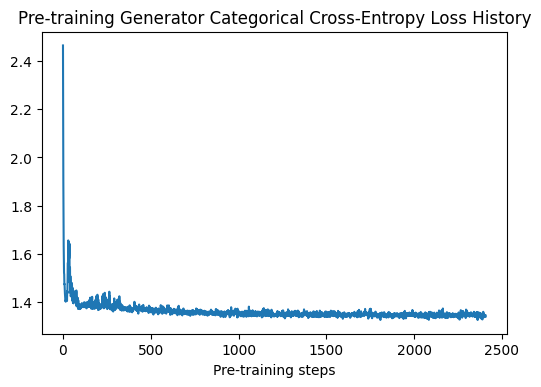

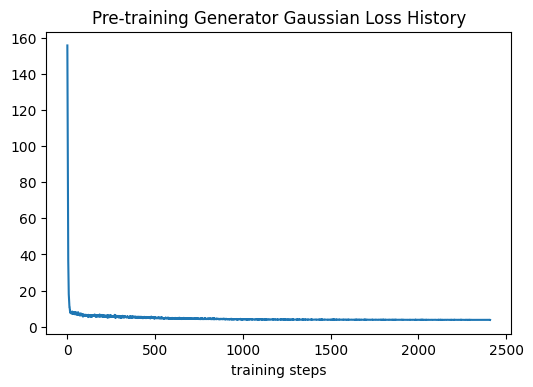

In [21]:
x = range(len(pretrain_gen_ce_loss_history))
plt.figure(dpi=100)
plt.plot(x, pretrain_gen_ce_loss_history)
plt.title('Pre-training Generator Categorical Cross-Entropy Loss History')
plt.xlabel('Pre-training steps')

x = range(len(pretrain_gen_gaussian_loss_history))
plt.figure(dpi=100)
plt.plot(x, pretrain_gen_gaussian_loss_history)
plt.title('Pre-training Generator Gaussian Loss History')
plt.xlabel('training steps')

In [22]:
loss_save_dir = '/home/lun/project-basileus/seq-gan/experiment_results/long_seqs_v10/init_pretrained/loss'
if not os.path.exists(loss_save_dir):
    os.makedirs(loss_save_dir)
    
with open(os.path.join(loss_save_dir, 'pretrain_gen_ce_loss_history.pickle'), 'wb') as f:
    pickle.dump(pretrain_gen_ce_loss_history, f)

with open(os.path.join(loss_save_dir, 'pretrain_gen_gaussian_loss_history.pickle'), 'wb') as f:
    pickle.dump(pretrain_gen_gaussian_loss_history, f)

### Save Pretrained G

In [23]:
if not os.path.exists('/home/lun/project-basileus/seq-gan/experiment_results/long_seqs_v10/init_pretrained/pretrained_gen_weights'):
    os.makedirs('./experiment_results/long_seqs_v10/init_pretrained/pretrained_gen_weights')
    
G_save_path = '/home/lun/project-basileus/seq-gan/experiment_results/long_seqs_v10/init_pretrained/pretrained_gen_weights/model_dropout.tf'

In [24]:
pretrained_generator.save_weights(G_save_path)

In [25]:
reload_pretrained_gen = build_G_2(
    batch_size = BATCH_SIZE,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim= HIDDEN_DIM,
)

reload_pretrained_gen.build(input_shape=((BATCH_SIZE, T, 1), (BATCH_SIZE, T, 1)))
reload_pretrained_gen.load_weights(G_save_path)

In [26]:
reload_pretrained_gen.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
event_type (InputLayer)         [(64, None, 1)]      0                                            
__________________________________________________________________________________________________
masking_1 (Masking)             (64, None, 1)        0           event_type[0][0]                 
                                                                 time_delta[0][0]                 
__________________________________________________________________________________________________
embedding_1 (Embedding)         (64, None, 1, 6)     36          masking_1[0][0]                  
__________________________________________________________________________________________________
time_delta (InputLayer)         [(64, None, 1)]      0                                      

## Pretrain D 

In [68]:
pretrain_D_et = np.concatenate([pos_event_type_seqs, neg_event_type_seqs], axis=0)
pretrain_D_ts = np.concatenate([pos_timestamp_seqs, neg_timestamp_seqs], axis=0)

pretrain_D_labels = np.concatenate([np.ones((pos_event_type_seqs.shape[0], 1)), 
                                  np.zeros((neg_event_type_seqs.shape[0], 1))
                                 ], axis=0)
pretrain_D_features = (pretrain_D_et, pretrain_D_ts)
N_pretrain_D = pretrain_D_ts.shape[0]

In [69]:
EPOCHS = 1
_TOTAL_STEPS = int(EPOCHS * N_pretrain_D / BATCH_SIZE)
# _TOTAL_STEPS = 1000

pretrain_disc_token_loss_history = []
pretrain_disc_gaussian_loss_history = []


pretrain_D_dataset = create_dataset(pretrain_D_features,
                                  pretrain_D_labels,
                                  batch_size=BATCH_SIZE,
                                  epochs=EPOCHS,
                                  buffer_size=N_pretrain_D)

pretrained_discriminator = build_D_2(
    T = T,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim= HIDDEN_DIM,
)

In [70]:
step = 0
_TOTAL_STEPS

4818

In [72]:
OPTIMIZER = Adam(lr=1e-4)
for features_batch, real_labels in tqdm(pretrain_D_dataset.take(_TOTAL_STEPS)):
    step += 1
    print('Training Step:', step)
        
    disc_token_loss = pretrain_discriminator(features_batch, real_labels, pretrained_discriminator, verbose=True, optimizer=OPTIMIZER)
    pretrain_disc_token_loss_history.append(disc_token_loss.numpy())

0it [00:00, ?it/s]

Training Step: 1166
total discriminator loss:0.26625566924490285


1it [00:00,  1.02it/s]

Training Step: 1167
total discriminator loss:0.2768475813254812


2it [00:01,  1.28it/s]

Training Step: 1168
total discriminator loss:0.30065668376494165


3it [00:01,  1.55it/s]

Training Step: 1169
total discriminator loss:0.2550114118258631


4it [00:01,  1.82it/s]

Training Step: 1170
total discriminator loss:0.28296349116183545


5it [00:02,  2.07it/s]

Training Step: 1171
total discriminator loss:0.37001434060896243


6it [00:02,  2.29it/s]

Training Step: 1172
total discriminator loss:0.21451352114608613


7it [00:02,  2.49it/s]

Training Step: 1173


8it [00:03,  2.37it/s]

total discriminator loss:0.26002363187811245
Training Step: 1174


9it [00:03,  2.55it/s]

total discriminator loss:0.33393769205236545
Training Step: 1175


10it [00:04,  2.70it/s]

total discriminator loss:0.2723728711859351
Training Step: 1176


11it [00:04,  2.78it/s]

total discriminator loss:0.22364198896145604
Training Step: 1177


12it [00:04,  2.82it/s]

total discriminator loss:0.23438867271019834
Training Step: 1178


13it [00:05,  2.87it/s]

total discriminator loss:0.24397978966450848
Training Step: 1179


14it [00:05,  2.90it/s]

total discriminator loss:0.42314231381304535
Training Step: 1180
total discriminator loss:0.38814125783897063


15it [00:05,  2.94it/s]

Training Step: 1181
total discriminator loss:0.28227018137040094


16it [00:06,  2.97it/s]

Training Step: 1182
total discriminator loss:0.21278769709797207


17it [00:06,  2.96it/s]

Training Step: 1183
total discriminator loss:0.28537210516337896


18it [00:06,  2.96it/s]

Training Step: 1184
total discriminator loss:0.38945425185813654


19it [00:07,  2.99it/s]

Training Step: 1185
total discriminator loss:0.38136520036691207


20it [00:07,  3.00it/s]

Training Step: 1186
total discriminator loss:0.165105272558285


21it [00:07,  2.94it/s]

Training Step: 1187
total discriminator loss:0.43216282119806027


22it [00:08,  2.95it/s]

Training Step: 1188
total discriminator loss:0.2908031962469043


23it [00:08,  2.91it/s]

Training Step: 1189
total discriminator loss:0.2872457953719512


24it [00:08,  2.94it/s]

Training Step: 1190
total discriminator loss:0.3910443928636842


25it [00:09,  2.98it/s]

Training Step: 1191
total discriminator loss:0.3337387759601521


26it [00:09,  3.00it/s]

Training Step: 1192
total discriminator loss:0.24480895840746708


27it [00:09,  2.92it/s]

Training Step: 1193
total discriminator loss:0.3027031235601878


28it [00:10,  2.85it/s]

Training Step: 1194
total discriminator loss:0.2322210535636602


29it [00:10,  2.40it/s]

Training Step: 1195
total discriminator loss:0.20760032367692452


30it [00:11,  2.49it/s]

Training Step: 1196
total discriminator loss:0.19777778843798433


31it [00:11,  2.55it/s]

Training Step: 1197
total discriminator loss:0.33688768133951164


32it [00:11,  2.58it/s]

Training Step: 1198
total discriminator loss:0.15263056644355422


33it [00:12,  2.63it/s]

Training Step: 1199
total discriminator loss:0.2678791543855823


34it [00:12,  2.71it/s]

Training Step: 1200
total discriminator loss:0.18630447613646073


35it [00:12,  2.79it/s]

Training Step: 1201
total discriminator loss:0.2485942713646183


36it [00:13,  2.86it/s]

Training Step: 1202
total discriminator loss:0.21491418752484942


37it [00:13,  2.90it/s]

Training Step: 1203
total discriminator loss:0.23957137059109293


38it [00:13,  2.94it/s]

Training Step: 1204
total discriminator loss:0.30037793152926345


39it [00:14,  2.93it/s]

Training Step: 1205
total discriminator loss:0.2948076249578038


40it [00:14,  2.95it/s]

Training Step: 1206
total discriminator loss:0.26777310858309


41it [00:14,  2.99it/s]

Training Step: 1207
total discriminator loss:0.2602721712174382


42it [00:15,  2.99it/s]

Training Step: 1208
total discriminator loss:0.28179527622800216


43it [00:15,  2.98it/s]

Training Step: 1209
total discriminator loss:0.30911202695474727


44it [00:15,  2.99it/s]

Training Step: 1210
total discriminator loss:0.33064782395887615


45it [00:16,  2.96it/s]

Training Step: 1211
total discriminator loss:0.277017199591469


46it [00:16,  2.89it/s]

Training Step: 1212
total discriminator loss:0.23067120094753701


47it [00:16,  2.85it/s]

Training Step: 1213


48it [00:17,  2.53it/s]

total discriminator loss:0.44393135666691846
Training Step: 1214


49it [00:17,  2.64it/s]

total discriminator loss:0.22644179325792402
Training Step: 1215
total discriminator loss:0.2898833692368963


50it [00:18,  2.73it/s]

Training Step: 1216
total discriminator loss:0.22187213714099294


51it [00:18,  2.80it/s]

Training Step: 1217
total discriminator loss:0.1652222558255967


52it [00:18,  2.85it/s]

Training Step: 1218
total discriminator loss:0.33310661264449454


53it [00:19,  2.91it/s]

Training Step: 1219
total discriminator loss:0.19879704599321998


54it [00:19,  2.93it/s]

Training Step: 1220
total discriminator loss:0.18783400284217752


55it [00:19,  2.90it/s]

Training Step: 1221
total discriminator loss:0.3206186059101849


56it [00:20,  2.87it/s]

Training Step: 1222
total discriminator loss:0.3892702875343318


57it [00:20,  2.89it/s]

Training Step: 1223
total discriminator loss:0.3432587669501574


58it [00:20,  2.92it/s]

Training Step: 1224
total discriminator loss:0.2065212501270356


59it [00:21,  2.93it/s]

Training Step: 1225
total discriminator loss:0.27540438878012086


60it [00:21,  2.93it/s]

Training Step: 1226
total discriminator loss:0.244982252301088


61it [00:21,  2.90it/s]

Training Step: 1227
total discriminator loss:0.2222963666163688


62it [00:22,  2.91it/s]

Training Step: 1228
total discriminator loss:0.23711813834668435


63it [00:22,  2.91it/s]

Training Step: 1229
total discriminator loss:0.2625502160668498


64it [00:22,  2.93it/s]

Training Step: 1230
total discriminator loss:0.19516800531620396


65it [00:23,  2.92it/s]

Training Step: 1231


66it [00:23,  2.60it/s]

total discriminator loss:0.21194024943685794
Training Step: 1232


67it [00:24,  2.66it/s]

total discriminator loss:0.2841793103902572
Training Step: 1233


68it [00:24,  2.74it/s]

total discriminator loss:0.3152494673028039
Training Step: 1234
total discriminator loss:0.21806592403621017


69it [00:24,  2.79it/s]

Training Step: 1235
total discriminator loss:0.28132651710973455


70it [00:25,  2.86it/s]

Training Step: 1236
total discriminator loss:0.24140948751017025


71it [00:25,  2.88it/s]

Training Step: 1237
total discriminator loss:0.3300292163480856


72it [00:25,  2.91it/s]

Training Step: 1238
total discriminator loss:0.2638760767142557


73it [00:26,  2.93it/s]

Training Step: 1239
total discriminator loss:0.26218512626095836


74it [00:26,  2.95it/s]

Training Step: 1240
total discriminator loss:0.14329920802109847


75it [00:26,  2.96it/s]

Training Step: 1241
total discriminator loss:0.1123362577632579


76it [00:27,  2.93it/s]

Training Step: 1242
total discriminator loss:0.37961133355555976


77it [00:27,  2.93it/s]

Training Step: 1243
total discriminator loss:0.30929837361765156


78it [00:27,  2.94it/s]

Training Step: 1244
total discriminator loss:0.23878029608184254


79it [00:28,  2.95it/s]

Training Step: 1245
total discriminator loss:0.23424724857761225


80it [00:28,  2.95it/s]

Training Step: 1246
total discriminator loss:0.4384481276705714


81it [00:28,  2.87it/s]

Training Step: 1247
total discriminator loss:0.24933921146280033


82it [00:29,  2.82it/s]

Training Step: 1248
total discriminator loss:0.25120302437398107


83it [00:29,  2.81it/s]

Training Step: 1249
total discriminator loss:0.22867927499917942


84it [00:29,  2.81it/s]

Training Step: 1250
total discriminator loss:0.2899583634677098


85it [00:30,  2.56it/s]

Training Step: 1251
total discriminator loss:0.37206672035137855


86it [00:30,  2.63it/s]

Training Step: 1252
total discriminator loss:0.2845976485925429


87it [00:31,  2.68it/s]

Training Step: 1253
total discriminator loss:0.13038301173667213


88it [00:31,  2.67it/s]

Training Step: 1254
total discriminator loss:0.2328843692347036


89it [00:31,  2.75it/s]

Training Step: 1255
total discriminator loss:0.21210726331573537


90it [00:32,  2.80it/s]

Training Step: 1256
total discriminator loss:0.3254397619531634


91it [00:32,  2.84it/s]

Training Step: 1257
total discriminator loss:0.3647717791141487


92it [00:32,  2.88it/s]

Training Step: 1258
total discriminator loss:0.31350419380202066


93it [00:33,  2.83it/s]

Training Step: 1259
total discriminator loss:0.1994830014124893


94it [00:33,  2.82it/s]

Training Step: 1260
total discriminator loss:0.21254813460437666


95it [00:33,  2.83it/s]

Training Step: 1261
total discriminator loss:0.25529186074061155


96it [00:34,  2.87it/s]

Training Step: 1262
total discriminator loss:0.15726944061654285


97it [00:34,  2.86it/s]

Training Step: 1263
total discriminator loss:0.29641477456597576


98it [00:34,  2.84it/s]

Training Step: 1264
total discriminator loss:0.3389509922018733


99it [00:35,  2.84it/s]

Training Step: 1265
total discriminator loss:0.19581558327242038


100it [00:35,  2.87it/s]

Training Step: 1266
total discriminator loss:0.264960273885488


101it [00:36,  2.89it/s]

Training Step: 1267
total discriminator loss:0.2608833672860975


102it [00:36,  2.92it/s]

Training Step: 1268
total discriminator loss:0.18565471409181486


103it [00:36,  2.62it/s]

Training Step: 1269
total discriminator loss:0.29178261758806495


104it [00:37,  2.71it/s]

Training Step: 1270
total discriminator loss:0.29654171704806587


105it [00:37,  2.73it/s]

Training Step: 1271
total discriminator loss:0.32688445741525474


106it [00:37,  2.73it/s]

Training Step: 1272
total discriminator loss:0.3117525918268935


107it [00:38,  2.71it/s]

Training Step: 1273
total discriminator loss:0.1740590783889513


108it [00:38,  2.78it/s]

Training Step: 1274
total discriminator loss:0.2854850156598141


109it [00:38,  2.84it/s]

Training Step: 1275
total discriminator loss:0.36489892167673643


110it [00:39,  2.81it/s]

Training Step: 1276
total discriminator loss:0.3533255918145082


111it [00:39,  2.85it/s]

Training Step: 1277
total discriminator loss:0.22614215100793106


112it [00:39,  2.90it/s]

Training Step: 1278
total discriminator loss:0.21777460926139858


113it [00:40,  2.93it/s]

Training Step: 1279
total discriminator loss:0.3153651616445988


114it [00:40,  2.95it/s]

Training Step: 1280
total discriminator loss:0.36034131679837006


115it [00:40,  2.90it/s]

Training Step: 1281
total discriminator loss:0.3356777607742019


116it [00:41,  2.84it/s]

Training Step: 1282
total discriminator loss:0.20373435380362936


117it [00:41,  2.87it/s]

Training Step: 1283
total discriminator loss:0.21549051583364107


118it [00:42,  2.89it/s]

Training Step: 1284
total discriminator loss:0.3952023159174955


119it [00:42,  2.89it/s]

Training Step: 1285
total discriminator loss:0.2693631170419658


120it [00:42,  2.92it/s]

Training Step: 1286
total discriminator loss:0.2692530002374619


121it [00:43,  2.94it/s]

Training Step: 1287


122it [00:43,  2.65it/s]

total discriminator loss:0.25480073257203606
Training Step: 1288
total discriminator loss:0.4270710539424072


123it [00:43,  2.72it/s]

Training Step: 1289
total discriminator loss:0.2732208958951733


124it [00:44,  2.78it/s]

Training Step: 1290
total discriminator loss:0.28272799583947966


125it [00:44,  2.79it/s]

Training Step: 1291
total discriminator loss:0.24390355582727477


126it [00:44,  2.80it/s]

Training Step: 1292
total discriminator loss:0.3170369264304316


127it [00:45,  2.80it/s]

Training Step: 1293
total discriminator loss:0.2571454672415095


128it [00:45,  2.84it/s]

Training Step: 1294
total discriminator loss:0.37416942472128367


129it [00:45,  2.84it/s]

Training Step: 1295
total discriminator loss:0.3570392838523757


130it [00:46,  2.78it/s]

Training Step: 1296
total discriminator loss:0.40025180315306597


131it [00:46,  2.77it/s]

Training Step: 1297
total discriminator loss:0.2612816278230747


132it [00:47,  2.70it/s]

Training Step: 1298
total discriminator loss:0.3120979337749178


133it [00:47,  2.71it/s]

Training Step: 1299
total discriminator loss:0.31689915118205114


134it [00:47,  2.76it/s]

Training Step: 1300
total discriminator loss:0.2755665470571303


135it [00:48,  2.81it/s]

Training Step: 1301
total discriminator loss:0.18966654925065585


136it [00:48,  2.84it/s]

Training Step: 1302
total discriminator loss:0.376397214677497


137it [00:48,  2.84it/s]

Training Step: 1303
total discriminator loss:0.2709234679964496


138it [00:49,  2.89it/s]

Training Step: 1304
total discriminator loss:0.36290922857969016


139it [00:49,  2.91it/s]

Training Step: 1305


140it [00:49,  2.64it/s]

total discriminator loss:0.3101446814042759
Training Step: 1306
total discriminator loss:0.3506097863379723


141it [00:50,  2.68it/s]

Training Step: 1307
total discriminator loss:0.39705712050812514


142it [00:50,  2.68it/s]

Training Step: 1308
total discriminator loss:0.23561585745465197


143it [00:51,  2.71it/s]

Training Step: 1309
total discriminator loss:0.20390154367739707


144it [00:51,  2.73it/s]

Training Step: 1310
total discriminator loss:0.2690337809864318


145it [00:51,  2.79it/s]

Training Step: 1311
total discriminator loss:0.2116107343058601


146it [00:52,  2.84it/s]

Training Step: 1312
total discriminator loss:0.28036001953993206


147it [00:52,  2.85it/s]

Training Step: 1313
total discriminator loss:0.21862386241789283


148it [00:52,  2.92it/s]

Training Step: 1314
total discriminator loss:0.26651989742387683


149it [00:53,  2.93it/s]

Training Step: 1315
total discriminator loss:0.2607042828254064


150it [00:53,  2.96it/s]

Training Step: 1316
total discriminator loss:0.18751699918044423


151it [00:53,  3.00it/s]

Training Step: 1317
total discriminator loss:0.18913971947485136


152it [00:54,  3.01it/s]

Training Step: 1318
total discriminator loss:0.331675173173932


153it [00:54,  3.00it/s]

Training Step: 1319
total discriminator loss:0.26253346655406773


154it [00:54,  2.95it/s]

Training Step: 1320
total discriminator loss:0.21471540917525994


155it [00:55,  2.95it/s]

Training Step: 1321
total discriminator loss:0.17447726746223374


156it [00:55,  2.94it/s]

Training Step: 1322
total discriminator loss:0.2893971692967987


157it [00:55,  2.88it/s]

Training Step: 1323
total discriminator loss:0.2546387235036921


158it [00:56,  2.87it/s]

Training Step: 1324
total discriminator loss:0.4401157109559677


159it [00:56,  2.60it/s]

Training Step: 1325
total discriminator loss:0.22379427646791467


160it [00:56,  2.70it/s]

Training Step: 1326
total discriminator loss:0.20068432147900797


161it [00:57,  2.78it/s]

Training Step: 1327
total discriminator loss:0.27833600116770524


162it [00:57,  2.79it/s]

Training Step: 1328
total discriminator loss:0.40244464575041716


163it [00:58,  2.73it/s]

Training Step: 1329
total discriminator loss:0.16855071120655563


164it [00:58,  2.77it/s]

Training Step: 1330
total discriminator loss:0.23479372154192352


165it [00:58,  2.85it/s]

Training Step: 1331
total discriminator loss:0.27565890247985275


166it [00:59,  2.89it/s]

Training Step: 1332
total discriminator loss:0.24816851699469106


167it [00:59,  2.92it/s]

Training Step: 1333
total discriminator loss:0.2890893923614887


168it [00:59,  2.90it/s]

Training Step: 1334
total discriminator loss:0.1551022860790217


169it [01:00,  2.92it/s]

Training Step: 1335
total discriminator loss:0.27885023605414117


170it [01:00,  2.92it/s]

Training Step: 1336
total discriminator loss:0.24616955622429226


171it [01:00,  2.77it/s]

Training Step: 1337
total discriminator loss:0.263681185686544


172it [01:01,  2.82it/s]

Training Step: 1338
total discriminator loss:0.20132316595452215


173it [01:01,  2.86it/s]

Training Step: 1339
total discriminator loss:0.2737254523166205


174it [01:01,  2.82it/s]

Training Step: 1340
total discriminator loss:0.19888130633443385


175it [01:02,  2.82it/s]

Training Step: 1341
total discriminator loss:0.3543003395236374


176it [01:02,  2.86it/s]

Training Step: 1342


177it [01:03,  2.63it/s]

total discriminator loss:0.19713766501416613
Training Step: 1343
total discriminator loss:0.3092005638362372


178it [01:03,  2.69it/s]

Training Step: 1344
total discriminator loss:0.30334224177703695


179it [01:03,  2.79it/s]

Training Step: 1345
total discriminator loss:0.2990422701654615


180it [01:04,  2.85it/s]

Training Step: 1346
total discriminator loss:0.21437323227276794


181it [01:04,  2.87it/s]

Training Step: 1347
total discriminator loss:0.18677686452126935


182it [01:04,  2.89it/s]

Training Step: 1348
total discriminator loss:0.3016533096307318


183it [01:05,  2.92it/s]

Training Step: 1349
total discriminator loss:0.17393573107550858


184it [01:05,  2.94it/s]

Training Step: 1350
total discriminator loss:0.26615944570980454


185it [01:05,  2.93it/s]

Training Step: 1351
total discriminator loss:0.3327987883507584


186it [01:06,  2.96it/s]

Training Step: 1352
total discriminator loss:0.16993853249288524


187it [01:06,  2.98it/s]

Training Step: 1353
total discriminator loss:0.21389846431668852


188it [01:06,  2.98it/s]

Training Step: 1354
total discriminator loss:0.34277249351172534


189it [01:07,  2.96it/s]

Training Step: 1355
total discriminator loss:0.25292446629200716


190it [01:07,  2.97it/s]

Training Step: 1356
total discriminator loss:0.2671531509317865


191it [01:07,  2.96it/s]

Training Step: 1357
total discriminator loss:0.2296941871963518


192it [01:08,  2.89it/s]

Training Step: 1358
total discriminator loss:0.22017018447781014


193it [01:08,  2.85it/s]

Training Step: 1359
total discriminator loss:0.2976707933318591


194it [01:08,  2.84it/s]

Training Step: 1360
total discriminator loss:0.23839822630527532


195it [01:09,  2.83it/s]

Training Step: 1361


196it [01:09,  2.60it/s]

total discriminator loss:0.21083297603269147
Training Step: 1362


197it [01:09,  2.71it/s]

total discriminator loss:0.43581442413198973
Training Step: 1363
total discriminator loss:0.2002712636164769


198it [01:10,  2.69it/s]

Training Step: 1364
total discriminator loss:0.23373480031740745


199it [01:10,  2.78it/s]

Training Step: 1365
total discriminator loss:0.23855084889921147


200it [01:11,  2.79it/s]

Training Step: 1366
total discriminator loss:0.1972204502159332


201it [01:11,  2.83it/s]

Training Step: 1367
total discriminator loss:0.3375679692873401


202it [01:11,  2.87it/s]

Training Step: 1368
total discriminator loss:0.15613618479588348


203it [01:12,  2.92it/s]

Training Step: 1369
total discriminator loss:0.26916460055713515


204it [01:12,  2.93it/s]

Training Step: 1370
total discriminator loss:0.2812067048970091


205it [01:12,  2.96it/s]

Training Step: 1371
total discriminator loss:0.2813057144821624


206it [01:13,  2.99it/s]

Training Step: 1372
total discriminator loss:0.3434399685682624


207it [01:13,  2.89it/s]

Training Step: 1373
total discriminator loss:0.24265738562735917


208it [01:13,  2.85it/s]

Training Step: 1374
total discriminator loss:0.32121549332572696


209it [01:14,  2.82it/s]

Training Step: 1375
total discriminator loss:0.3099116227555346


210it [01:14,  2.76it/s]

Training Step: 1376
total discriminator loss:0.2507569273219369


211it [01:14,  2.75it/s]

Training Step: 1377
total discriminator loss:0.2971632714464807


212it [01:15,  2.75it/s]

Training Step: 1378
total discriminator loss:0.16225786791291624


213it [01:15,  2.78it/s]

Training Step: 1379
total discriminator loss:0.259193797222184


214it [01:16,  2.53it/s]

Training Step: 1380
total discriminator loss:0.5611973634306102


215it [01:16,  2.66it/s]

Training Step: 1381
total discriminator loss:0.39486761375640556


216it [01:16,  2.74it/s]

Training Step: 1382
total discriminator loss:0.41135154713587463


217it [01:17,  2.83it/s]

Training Step: 1383
total discriminator loss:0.2384880105699937


218it [01:17,  2.88it/s]

Training Step: 1384
total discriminator loss:0.28688554691932155


219it [01:17,  2.91it/s]

Training Step: 1385
total discriminator loss:0.28079398667367417


220it [01:18,  2.86it/s]

Training Step: 1386
total discriminator loss:0.23128232744547966


221it [01:18,  2.84it/s]

Training Step: 1387
total discriminator loss:0.32637038868923707


222it [01:18,  2.90it/s]

Training Step: 1388
total discriminator loss:0.30530382949428514


223it [01:19,  2.94it/s]

Training Step: 1389
total discriminator loss:0.25899600573549836


224it [01:19,  2.94it/s]

Training Step: 1390
total discriminator loss:0.24609166258970877


225it [01:19,  2.92it/s]

Training Step: 1391
total discriminator loss:0.3957238411465471


226it [01:20,  2.87it/s]

Training Step: 1392
total discriminator loss:0.32231583196722213


227it [01:20,  2.83it/s]

Training Step: 1393
total discriminator loss:0.2553672753612529


228it [01:20,  2.80it/s]

Training Step: 1394
total discriminator loss:0.29025702050134994


229it [01:21,  2.86it/s]

Training Step: 1395
total discriminator loss:0.29210895134836345


230it [01:21,  2.93it/s]

Training Step: 1396
total discriminator loss:0.2945975923132988


231it [01:21,  2.94it/s]

Training Step: 1397
total discriminator loss:0.22521599409415993


232it [01:22,  2.91it/s]

Training Step: 1398


233it [01:22,  2.63it/s]

total discriminator loss:0.19563676319285844
Training Step: 1399
total discriminator loss:0.2622095279776241


234it [01:23,  2.66it/s]

Training Step: 1400
total discriminator loss:0.2299075354413425


235it [01:23,  2.67it/s]

Training Step: 1401
total discriminator loss:0.2797687758837091


236it [01:23,  2.76it/s]

Training Step: 1402
total discriminator loss:0.2537185660182125


237it [01:24,  2.75it/s]

Training Step: 1403
total discriminator loss:0.23586374624244363


238it [01:24,  2.76it/s]

Training Step: 1404
total discriminator loss:0.23178730440118814


239it [01:24,  2.77it/s]

Training Step: 1405
total discriminator loss:0.3822868367038693


240it [01:25,  2.75it/s]

Training Step: 1406
total discriminator loss:0.3120533888243278


241it [01:25,  2.77it/s]

Training Step: 1407
total discriminator loss:0.24302481694128117


242it [01:25,  2.80it/s]

Training Step: 1408
total discriminator loss:0.20684443542372766


243it [01:26,  2.80it/s]

Training Step: 1409
total discriminator loss:0.3103488715813997


244it [01:26,  2.83it/s]

Training Step: 1410
total discriminator loss:0.22507547338199357


245it [01:26,  2.89it/s]

Training Step: 1411
total discriminator loss:0.3351612081796411


246it [01:27,  2.94it/s]

Training Step: 1412
total discriminator loss:0.202116774675335


247it [01:27,  2.97it/s]

Training Step: 1413
total discriminator loss:0.27675604384342883


248it [01:27,  2.90it/s]

Training Step: 1414
total discriminator loss:0.2752085239623733


249it [01:28,  2.89it/s]

Training Step: 1415
total discriminator loss:0.22651490861177925


250it [01:28,  2.92it/s]

Training Step: 1416


251it [01:29,  2.65it/s]

total discriminator loss:0.3143597578221202
Training Step: 1417
total discriminator loss:0.23145060965506892


252it [01:29,  2.69it/s]

Training Step: 1418
total discriminator loss:0.29505598775165776


253it [01:29,  2.76it/s]

Training Step: 1419
total discriminator loss:0.13634994453250202


254it [01:30,  2.74it/s]

Training Step: 1420
total discriminator loss:0.18611195653431784


255it [01:30,  2.77it/s]

Training Step: 1421
total discriminator loss:0.27726697172417364


256it [01:30,  2.82it/s]

Training Step: 1422
total discriminator loss:0.25356253686079505


257it [01:31,  2.87it/s]

Training Step: 1423
total discriminator loss:0.19554793329803621


258it [01:31,  2.83it/s]

Training Step: 1424
total discriminator loss:0.17682275391645216


259it [01:31,  2.80it/s]

Training Step: 1425
total discriminator loss:0.2661620199400833


260it [01:32,  2.78it/s]

Training Step: 1426
total discriminator loss:0.2642769551180857


261it [01:32,  2.85it/s]

Training Step: 1427
total discriminator loss:0.3083939247567956


262it [01:32,  2.90it/s]

Training Step: 1428
total discriminator loss:0.2425318052023786


263it [01:33,  2.82it/s]

Training Step: 1429
total discriminator loss:0.2283619627643949


264it [01:33,  2.84it/s]

Training Step: 1430
total discriminator loss:0.18915869201686697


265it [01:34,  2.91it/s]

Training Step: 1431
total discriminator loss:0.36474954509792434


266it [01:34,  2.83it/s]

Training Step: 1432
total discriminator loss:0.2629186887688496


267it [01:34,  2.80it/s]

Training Step: 1433
total discriminator loss:0.19194001231753097


268it [01:35,  2.76it/s]

Training Step: 1434
total discriminator loss:0.18692156809257796


269it [01:35,  2.73it/s]

Training Step: 1435
total discriminator loss:0.2975326963568804


270it [01:36,  2.32it/s]

Training Step: 1436
total discriminator loss:0.23082468701973058


271it [01:36,  2.48it/s]

Training Step: 1437
total discriminator loss:0.2975927927101296


272it [01:36,  2.59it/s]

Training Step: 1438
total discriminator loss:0.2643429952015153


273it [01:37,  2.70it/s]

Training Step: 1439
total discriminator loss:0.24681195380672116


274it [01:37,  2.74it/s]

Training Step: 1440
total discriminator loss:0.3382102318481977


275it [01:37,  2.82it/s]

Training Step: 1441
total discriminator loss:0.2566063696824295


276it [01:38,  2.88it/s]

Training Step: 1442
total discriminator loss:0.2868457262594368


277it [01:38,  2.85it/s]

Training Step: 1443
total discriminator loss:0.2939115938119814


278it [01:38,  2.88it/s]

Training Step: 1444
total discriminator loss:0.35031238108265195


279it [01:39,  2.92it/s]

Training Step: 1445
total discriminator loss:0.26487781014805484


280it [01:39,  2.84it/s]

Training Step: 1446
total discriminator loss:0.26474613932663005


281it [01:39,  2.82it/s]

Training Step: 1447
total discriminator loss:0.18041589813324346


282it [01:40,  2.79it/s]

Training Step: 1448
total discriminator loss:0.15329923772456439


283it [01:40,  2.76it/s]

Training Step: 1449
total discriminator loss:0.20117025306596545


284it [01:41,  2.67it/s]

Training Step: 1450
total discriminator loss:0.3345773115400824


285it [01:41,  2.77it/s]

Training Step: 1451
total discriminator loss:0.28391185233904437


286it [01:41,  2.82it/s]

Training Step: 1452
total discriminator loss:0.2810765417073925


287it [01:42,  2.88it/s]

Training Step: 1453


288it [01:42,  2.59it/s]

total discriminator loss:0.3092338000400272
Training Step: 1454
total discriminator loss:0.2137681913590701


289it [01:42,  2.63it/s]

Training Step: 1455
total discriminator loss:0.2833067794129672


290it [01:43,  2.65it/s]

Training Step: 1456
total discriminator loss:0.25154456195438946


291it [01:43,  2.73it/s]

Training Step: 1457
total discriminator loss:0.29812295302338254


292it [01:43,  2.75it/s]

Training Step: 1458
total discriminator loss:0.21895646294289534


293it [01:44,  2.75it/s]

Training Step: 1459
total discriminator loss:0.23775696199147808


294it [01:44,  2.59it/s]

Training Step: 1460
total discriminator loss:0.2511800792597249


295it [01:45,  2.62it/s]

Training Step: 1461
total discriminator loss:0.38682038082050696


296it [01:45,  2.66it/s]

Training Step: 1462
total discriminator loss:0.2814184818765513


297it [01:45,  2.71it/s]

Training Step: 1463
total discriminator loss:0.37107375523038166


298it [01:46,  2.55it/s]

Training Step: 1464
total discriminator loss:0.1701866383642201


299it [01:46,  2.64it/s]

Training Step: 1465
total discriminator loss:0.2586881546637959


300it [01:47,  2.53it/s]

Training Step: 1466
total discriminator loss:0.30521182095294247


301it [01:47,  2.58it/s]

Training Step: 1467
total discriminator loss:0.342508458715033


302it [01:47,  2.63it/s]

Training Step: 1468
total discriminator loss:0.19635249637714908


303it [01:48,  2.65it/s]

Training Step: 1469
total discriminator loss:0.29547259752507965


304it [01:48,  2.57it/s]

Training Step: 1470
total discriminator loss:0.2638071902509854


305it [01:48,  2.68it/s]

Training Step: 1471
total discriminator loss:0.2129077053313856


306it [01:49,  2.75it/s]

Training Step: 1472


307it [01:49,  2.55it/s]

total discriminator loss:0.23424840002559066
Training Step: 1473


308it [01:50,  2.66it/s]

total discriminator loss:0.2507636495565978
Training Step: 1474


309it [01:50,  2.75it/s]

total discriminator loss:0.1834024903587837
Training Step: 1475


310it [01:50,  2.84it/s]

total discriminator loss:0.2513390874057955
Training Step: 1476


311it [01:51,  2.91it/s]

total discriminator loss:0.19535445263803608
Training Step: 1477
total discriminator loss:0.15934096152634317


312it [01:51,  2.89it/s]

Training Step: 1478
total discriminator loss:0.2139943377757061


313it [01:51,  2.85it/s]

Training Step: 1479
total discriminator loss:0.3330816943825608


314it [01:52,  2.85it/s]

Training Step: 1480
total discriminator loss:0.2940292687503838


315it [01:52,  2.90it/s]

Training Step: 1481
total discriminator loss:0.30729202151543544


316it [01:52,  2.90it/s]

Training Step: 1482
total discriminator loss:0.27967933888080676


317it [01:53,  2.86it/s]

Training Step: 1483
total discriminator loss:0.2522374301331657


318it [01:53,  2.81it/s]

Training Step: 1484
total discriminator loss:0.24740936369566452


319it [01:53,  2.81it/s]

Training Step: 1485
total discriminator loss:0.27027487037599923


320it [01:54,  2.75it/s]

Training Step: 1486
total discriminator loss:0.20034684376527426


321it [01:54,  2.73it/s]

Training Step: 1487
total discriminator loss:0.4378536743379724


322it [01:54,  2.76it/s]

Training Step: 1488
total discriminator loss:0.38762932344566753


323it [01:55,  2.83it/s]

Training Step: 1489
total discriminator loss:0.29007207446299577


324it [01:55,  2.81it/s]

Training Step: 1490
total discriminator loss:0.3728512845086859


325it [01:56,  2.36it/s]

Training Step: 1491
total discriminator loss:0.27529782568463734


326it [01:56,  2.45it/s]

Training Step: 1492
total discriminator loss:0.1741362391924247


327it [01:56,  2.59it/s]

Training Step: 1493
total discriminator loss:0.27491875853829273


328it [01:57,  2.72it/s]

Training Step: 1494
total discriminator loss:0.2760521225880129


329it [01:57,  2.81it/s]

Training Step: 1495
total discriminator loss:0.18550038064399194


330it [01:57,  2.86it/s]

Training Step: 1496
total discriminator loss:0.2592013774067278


331it [01:58,  2.85it/s]

Training Step: 1497
total discriminator loss:0.32010500778545625


332it [01:58,  2.88it/s]

Training Step: 1498
total discriminator loss:0.2919338026899314


333it [01:59,  2.86it/s]

Training Step: 1499
total discriminator loss:0.2634385586311107


334it [01:59,  2.83it/s]

Training Step: 1500
total discriminator loss:0.3740296430590453


335it [01:59,  2.87it/s]

Training Step: 1501
total discriminator loss:0.30174222927146854


336it [02:00,  2.84it/s]

Training Step: 1502
total discriminator loss:0.26704304663508954


337it [02:00,  2.86it/s]

Training Step: 1503
total discriminator loss:0.2978875501294814


338it [02:00,  2.89it/s]

Training Step: 1504
total discriminator loss:0.22541673200455792


339it [02:01,  2.92it/s]

Training Step: 1505
total discriminator loss:0.3297015567519265


340it [02:01,  2.94it/s]

Training Step: 1506
total discriminator loss:0.2915759223904105


341it [02:01,  2.93it/s]

Training Step: 1507
total discriminator loss:0.2731467107318045


342it [02:02,  2.96it/s]

Training Step: 1508
total discriminator loss:0.2513293219728874


343it [02:02,  2.98it/s]

Training Step: 1509
total discriminator loss:0.3387993439869469


344it [02:02,  2.61it/s]

Training Step: 1510
total discriminator loss:0.232063403051812


345it [02:03,  2.67it/s]

Training Step: 1511
total discriminator loss:0.17674156981761246


346it [02:03,  2.70it/s]

Training Step: 1512
total discriminator loss:0.2724571279643745


347it [02:04,  2.70it/s]

Training Step: 1513
total discriminator loss:0.3749981041008815


348it [02:04,  2.74it/s]

Training Step: 1514
total discriminator loss:0.19290189995821422


349it [02:04,  2.75it/s]

Training Step: 1515
total discriminator loss:0.2878957530910155


350it [02:05,  2.82it/s]

Training Step: 1516
total discriminator loss:0.2995827862679698


351it [02:05,  2.83it/s]

Training Step: 1517
total discriminator loss:0.412917661163724


352it [02:05,  2.81it/s]

Training Step: 1518
total discriminator loss:0.2927015151301743


353it [02:06,  2.85it/s]

Training Step: 1519
total discriminator loss:0.3311312723329692


354it [02:06,  2.89it/s]

Training Step: 1520
total discriminator loss:0.2892845063184258


355it [02:06,  2.88it/s]

Training Step: 1521
total discriminator loss:0.22122583284885028


356it [02:07,  2.82it/s]

Training Step: 1522
total discriminator loss:0.36556499190333147


357it [02:07,  2.80it/s]

Training Step: 1523
total discriminator loss:0.22583063629373962


358it [02:07,  2.83it/s]

Training Step: 1524
total discriminator loss:0.3026069974905188


359it [02:08,  2.87it/s]

Training Step: 1525
total discriminator loss:0.22170832526309914


360it [02:08,  2.86it/s]

Training Step: 1526
total discriminator loss:0.4094225072142609


361it [02:08,  2.87it/s]

Training Step: 1527


362it [02:09,  2.50it/s]

total discriminator loss:0.31996154755659767
Training Step: 1528


363it [02:09,  2.65it/s]

total discriminator loss:0.19929449552833456
Training Step: 1529


364it [02:10,  2.72it/s]

total discriminator loss:0.23534063053561333
Training Step: 1530


365it [02:10,  2.79it/s]

total discriminator loss:0.29779254857350057
Training Step: 1531
total discriminator loss:0.3262759319958507


366it [02:10,  2.74it/s]

Training Step: 1532
total discriminator loss:0.23118123183822292


367it [02:11,  2.72it/s]

Training Step: 1533
total discriminator loss:0.19009630513635


368it [02:11,  2.71it/s]

Training Step: 1534
total discriminator loss:0.2688444583614691


369it [02:11,  2.77it/s]

Training Step: 1535
total discriminator loss:0.3784221645077418


370it [02:12,  2.83it/s]

Training Step: 1536
total discriminator loss:0.3253510944580767


371it [02:12,  2.88it/s]

Training Step: 1537
total discriminator loss:0.1741500530092971


372it [02:12,  2.79it/s]

Training Step: 1538
total discriminator loss:0.2481403328759549


373it [02:13,  2.77it/s]

Training Step: 1539
total discriminator loss:0.2600365239844276


374it [02:13,  2.78it/s]

Training Step: 1540
total discriminator loss:0.1838949901048036


375it [02:14,  2.77it/s]

Training Step: 1541
total discriminator loss:0.29283768250987485


376it [02:14,  2.77it/s]

Training Step: 1542
total discriminator loss:0.16441134026421933


377it [02:14,  2.84it/s]

Training Step: 1543
total discriminator loss:0.30690532903310885


378it [02:15,  2.89it/s]

Training Step: 1544
total discriminator loss:0.19152943426619085


379it [02:15,  2.93it/s]

Training Step: 1545
total discriminator loss:0.19417362626303614


380it [02:15,  2.96it/s]

Training Step: 1546
total discriminator loss:0.3212044682692623


381it [02:16,  2.55it/s]

Training Step: 1547
total discriminator loss:0.18997178658460775


382it [02:16,  2.63it/s]

Training Step: 1548
total discriminator loss:0.3477842245668183


383it [02:16,  2.70it/s]

Training Step: 1549
total discriminator loss:0.25689067976204855


384it [02:17,  2.71it/s]

Training Step: 1550
total discriminator loss:0.22645625065324898


385it [02:17,  2.69it/s]

Training Step: 1551
total discriminator loss:0.24977380054010906


386it [02:18,  2.69it/s]

Training Step: 1552
total discriminator loss:0.23141025367388113


387it [02:18,  2.77it/s]

Training Step: 1553
total discriminator loss:0.21726357208581154


388it [02:18,  2.83it/s]

Training Step: 1554
total discriminator loss:0.26931315907261727


389it [02:19,  2.80it/s]

Training Step: 1555
total discriminator loss:0.26796603056459795


390it [02:19,  2.79it/s]

Training Step: 1556
total discriminator loss:0.33514943794543495


391it [02:19,  2.85it/s]

Training Step: 1557
total discriminator loss:0.2850876392378017


392it [02:20,  2.89it/s]

Training Step: 1558
total discriminator loss:0.3268752504197788


393it [02:20,  2.91it/s]

Training Step: 1559
total discriminator loss:0.28784215396168017


394it [02:20,  2.87it/s]

Training Step: 1560
total discriminator loss:0.28891144309718364


395it [02:21,  2.91it/s]

Training Step: 1561
total discriminator loss:0.33950845315273276


396it [02:21,  2.82it/s]

Training Step: 1562
total discriminator loss:0.18972965145360976


397it [02:21,  2.85it/s]

Training Step: 1563
total discriminator loss:0.4157763954366239


398it [02:22,  2.89it/s]

Training Step: 1564
total discriminator loss:0.29532533651674464


399it [02:22,  2.32it/s]

Training Step: 1565
total discriminator loss:0.2428033685448367


400it [02:23,  2.49it/s]

Training Step: 1566
total discriminator loss:0.31161329263382753


401it [02:23,  2.62it/s]

Training Step: 1567
total discriminator loss:0.35677271173539804


402it [02:23,  2.72it/s]

Training Step: 1568
total discriminator loss:0.2299205596973553


403it [02:24,  2.75it/s]

Training Step: 1569
total discriminator loss:0.355369522844851


404it [02:24,  2.80it/s]

Training Step: 1570
total discriminator loss:0.20908759306213612


405it [02:24,  2.84it/s]

Training Step: 1571
total discriminator loss:0.27777224938368594


406it [02:25,  2.87it/s]

Training Step: 1572
total discriminator loss:0.29571068448741233


407it [02:25,  2.89it/s]

Training Step: 1573
total discriminator loss:0.28010187186714597


408it [02:25,  2.95it/s]

Training Step: 1574
total discriminator loss:0.2744870840895569


409it [02:26,  2.97it/s]

Training Step: 1575
total discriminator loss:0.3102135827482699


410it [02:26,  2.97it/s]

Training Step: 1576
total discriminator loss:0.2539017722281304


411it [02:26,  2.94it/s]

Training Step: 1577
total discriminator loss:0.22250575408041312


412it [02:27,  2.84it/s]

Training Step: 1578
total discriminator loss:0.3975593223536109


413it [02:27,  2.87it/s]

Training Step: 1579
total discriminator loss:0.3020344013499865


414it [02:27,  2.92it/s]

Training Step: 1580
total discriminator loss:0.27839436770027637


415it [02:28,  2.94it/s]

Training Step: 1581
total discriminator loss:0.20577559192836725


416it [02:28,  2.93it/s]

Training Step: 1582
total discriminator loss:0.21040556756405915


417it [02:28,  2.92it/s]

Training Step: 1583


418it [02:29,  2.59it/s]

total discriminator loss:0.2681279647524529
Training Step: 1584


419it [02:29,  2.70it/s]

total discriminator loss:0.20268122688935508
Training Step: 1585


420it [02:30,  2.79it/s]

total discriminator loss:0.09065928636009672
Training Step: 1586
total discriminator loss:0.21121381511487503


421it [02:30,  2.82it/s]

Training Step: 1587
total discriminator loss:0.224867514233793


422it [02:30,  2.87it/s]

Training Step: 1588
total discriminator loss:0.24148840314975414


423it [02:31,  2.91it/s]

Training Step: 1589
total discriminator loss:0.40576967662131364


424it [02:31,  2.93it/s]

Training Step: 1590
total discriminator loss:0.32822209920653234


425it [02:31,  2.94it/s]

Training Step: 1591
total discriminator loss:0.19080494995832553


426it [02:32,  2.93it/s]

Training Step: 1592
total discriminator loss:0.2710224341810074


427it [02:32,  2.87it/s]

Training Step: 1593
total discriminator loss:0.14690574690414612


428it [02:32,  2.90it/s]

Training Step: 1594
total discriminator loss:0.33986952888807137


429it [02:33,  2.92it/s]

Training Step: 1595
total discriminator loss:0.3041811073644569


430it [02:33,  2.79it/s]

Training Step: 1596
total discriminator loss:0.3604764051888404


431it [02:33,  2.75it/s]

Training Step: 1597
total discriminator loss:0.2678008561980642


432it [02:34,  2.73it/s]

Training Step: 1598
total discriminator loss:0.29895937405931833


433it [02:34,  2.78it/s]

Training Step: 1599
total discriminator loss:0.30150823628524814


434it [02:35,  2.84it/s]

Training Step: 1600
total discriminator loss:0.2407931178484671


435it [02:35,  2.88it/s]

Training Step: 1601
total discriminator loss:0.23047377766349214


436it [02:35,  2.58it/s]

Training Step: 1602
total discriminator loss:0.30162170840350255


437it [02:36,  2.66it/s]

Training Step: 1603
total discriminator loss:0.3638170555821232


438it [02:36,  2.72it/s]

Training Step: 1604
total discriminator loss:0.26205618297323713


439it [02:36,  2.73it/s]

Training Step: 1605
total discriminator loss:0.3593688074526886


440it [02:37,  2.75it/s]

Training Step: 1606
total discriminator loss:0.2051458726135429


441it [02:37,  2.74it/s]

Training Step: 1607
total discriminator loss:0.2118072363030629


442it [02:37,  2.74it/s]

Training Step: 1608
total discriminator loss:0.22828787065872447


443it [02:38,  2.79it/s]

Training Step: 1609
total discriminator loss:0.27065704929533785


444it [02:38,  2.82it/s]

Training Step: 1610
total discriminator loss:0.22369600750947777


445it [02:39,  2.80it/s]

Training Step: 1611
total discriminator loss:0.24403166871648585


446it [02:39,  2.79it/s]

Training Step: 1612
total discriminator loss:0.20961879757364357


447it [02:39,  2.81it/s]

Training Step: 1613
total discriminator loss:0.21095822214447552


448it [02:40,  2.80it/s]

Training Step: 1614
total discriminator loss:0.30151233740901273


449it [02:40,  2.78it/s]

Training Step: 1615
total discriminator loss:0.3554494022006361


450it [02:40,  2.82it/s]

Training Step: 1616
total discriminator loss:0.27778553940038125


451it [02:41,  2.77it/s]

Training Step: 1617
total discriminator loss:0.17180581626303673


452it [02:41,  2.73it/s]

Training Step: 1618
total discriminator loss:0.229329054055409


453it [02:41,  2.69it/s]

Training Step: 1619
total discriminator loss:0.30144726522191223


454it [02:42,  2.65it/s]

Training Step: 1620
total discriminator loss:0.17336146760210658


455it [02:42,  2.45it/s]

Training Step: 1621
total discriminator loss:0.28150654143282994


456it [02:43,  2.55it/s]

Training Step: 1622
total discriminator loss:0.34792541518630415


457it [02:43,  2.63it/s]

Training Step: 1623
total discriminator loss:0.244823811052997


458it [02:43,  2.66it/s]

Training Step: 1624
total discriminator loss:0.24275657601853684


459it [02:44,  2.65it/s]

Training Step: 1625
total discriminator loss:0.23648145931073522


460it [02:44,  2.72it/s]

Training Step: 1626
total discriminator loss:0.3120746785240217


461it [02:44,  2.77it/s]

Training Step: 1627
total discriminator loss:0.20083169482837193


462it [02:45,  2.69it/s]

Training Step: 1628
total discriminator loss:0.29113359218056506


463it [02:45,  2.73it/s]

Training Step: 1629
total discriminator loss:0.254788126135272


464it [02:46,  2.75it/s]

Training Step: 1630
total discriminator loss:0.2574303045599855


465it [02:46,  2.81it/s]

Training Step: 1631
total discriminator loss:0.24786571853484474


466it [02:46,  2.84it/s]

Training Step: 1632
total discriminator loss:0.22110288137494918


467it [02:47,  2.88it/s]

Training Step: 1633
total discriminator loss:0.2740057935921061


468it [02:47,  2.85it/s]

Training Step: 1634
total discriminator loss:0.403170242054436


469it [02:47,  2.83it/s]

Training Step: 1635
total discriminator loss:0.3552994265815059


470it [02:48,  2.86it/s]

Training Step: 1636
total discriminator loss:0.32634895219637816


471it [02:48,  2.91it/s]

Training Step: 1637
total discriminator loss:0.2890711473194777


472it [02:48,  2.96it/s]

Training Step: 1638
total discriminator loss:0.27226514979157596


473it [02:49,  2.68it/s]

Training Step: 1639
total discriminator loss:0.1778894071871192


474it [02:49,  2.66it/s]

Training Step: 1640
total discriminator loss:0.24571411358723436


475it [02:49,  2.76it/s]

Training Step: 1641
total discriminator loss:0.2169814082085294


476it [02:50,  2.83it/s]

Training Step: 1642
total discriminator loss:0.3114957125641299


477it [02:50,  2.87it/s]

Training Step: 1643
total discriminator loss:0.15685428428623818


478it [02:50,  2.93it/s]

Training Step: 1644
total discriminator loss:0.24026585977309278


479it [02:51,  2.86it/s]

Training Step: 1645
total discriminator loss:0.35845263261674964


480it [02:51,  2.85it/s]

Training Step: 1646
total discriminator loss:0.2822085878715963


481it [02:52,  2.91it/s]

Training Step: 1647
total discriminator loss:0.24948652872302723


482it [02:52,  2.88it/s]

Training Step: 1648
total discriminator loss:0.3249217790395927


483it [02:52,  2.88it/s]

Training Step: 1649
total discriminator loss:0.38366591998810456


484it [02:53,  2.89it/s]

Training Step: 1650
total discriminator loss:0.22381144816597573


485it [02:53,  2.84it/s]

Training Step: 1651
total discriminator loss:0.32382559933261634


486it [02:53,  2.87it/s]

Training Step: 1652
total discriminator loss:0.3913466471391117


487it [02:54,  2.91it/s]

Training Step: 1653
total discriminator loss:0.2389520044382862


488it [02:54,  2.93it/s]

Training Step: 1654
total discriminator loss:0.18719574128808375


489it [02:54,  2.94it/s]

Training Step: 1655
total discriminator loss:0.2839912510401559


490it [02:55,  2.91it/s]

Training Step: 1656
total discriminator loss:0.19603282157911164


491it [02:55,  2.89it/s]

Training Step: 1657


492it [02:55,  2.61it/s]

total discriminator loss:0.3436957162658264
Training Step: 1658
total discriminator loss:0.30061299741639963


493it [02:56,  2.70it/s]

Training Step: 1659
total discriminator loss:0.40000995106857024


494it [02:56,  2.78it/s]

Training Step: 1660
total discriminator loss:0.20586802506266944


495it [02:56,  2.79it/s]

Training Step: 1661
total discriminator loss:0.32808299210174796


496it [02:57,  2.71it/s]

Training Step: 1662
total discriminator loss:0.1927151540196459


497it [02:57,  2.77it/s]

Training Step: 1663
total discriminator loss:0.25222330014529876


498it [02:58,  2.83it/s]

Training Step: 1664
total discriminator loss:0.28790224346073007


499it [02:58,  2.87it/s]

Training Step: 1665
total discriminator loss:0.1995877149067207


500it [02:58,  2.86it/s]

Training Step: 1666
total discriminator loss:0.21076102015811374


501it [02:59,  2.90it/s]

Training Step: 1667
total discriminator loss:0.30179987951822457


502it [02:59,  2.94it/s]

Training Step: 1668
total discriminator loss:0.3227529057869961


503it [02:59,  2.95it/s]

Training Step: 1669
total discriminator loss:0.1396920250263435


504it [03:00,  2.96it/s]

Training Step: 1670
total discriminator loss:0.3077421286863341


505it [03:00,  2.98it/s]

Training Step: 1671
total discriminator loss:0.18851317930823025


506it [03:00,  2.97it/s]

Training Step: 1672
total discriminator loss:0.22548861373207132


507it [03:01,  3.00it/s]

Training Step: 1673
total discriminator loss:0.10209164519140632


508it [03:01,  3.00it/s]

Training Step: 1674
total discriminator loss:0.320738953449328


509it [03:01,  3.01it/s]

Training Step: 1675


510it [03:02,  2.71it/s]

total discriminator loss:0.28228523165895647
Training Step: 1676


511it [03:02,  2.78it/s]

total discriminator loss:0.20706207332012225
Training Step: 1677
total discriminator loss:0.16258586672007275


512it [03:02,  2.79it/s]

Training Step: 1678
total discriminator loss:0.2603127017764144


513it [03:03,  2.77it/s]

Training Step: 1679
total discriminator loss:0.32711662771490646


514it [03:03,  2.80it/s]

Training Step: 1680
total discriminator loss:0.3626801473071525


515it [03:03,  2.82it/s]

Training Step: 1681
total discriminator loss:0.3290945720750176


516it [03:04,  2.83it/s]

Training Step: 1682
total discriminator loss:0.17050151732473268


517it [03:04,  2.86it/s]

Training Step: 1683
total discriminator loss:0.38733449962226274


518it [03:04,  2.91it/s]

Training Step: 1684
total discriminator loss:0.21788441556063


519it [03:05,  2.93it/s]

Training Step: 1685
total discriminator loss:0.3346743328947976


520it [03:05,  2.94it/s]

Training Step: 1686
total discriminator loss:0.29966974364038


521it [03:05,  2.94it/s]

Training Step: 1687
total discriminator loss:0.3115115898392651


522it [03:06,  2.93it/s]

Training Step: 1688
total discriminator loss:0.28269406398630337


523it [03:06,  2.90it/s]

Training Step: 1689
total discriminator loss:0.2944710862677167


524it [03:07,  2.93it/s]

Training Step: 1690
total discriminator loss:0.2500876302094396


525it [03:07,  2.93it/s]

Training Step: 1691
total discriminator loss:0.268699246294659


526it [03:07,  2.94it/s]

Training Step: 1692
total discriminator loss:0.2582630947050768


527it [03:08,  2.94it/s]

Training Step: 1693
total discriminator loss:0.3254641232218121


528it [03:08,  2.94it/s]

Training Step: 1694


529it [03:08,  2.67it/s]

total discriminator loss:0.2717240288036414
Training Step: 1695


530it [03:09,  2.77it/s]

total discriminator loss:0.3311585658423318
Training Step: 1696


531it [03:09,  2.84it/s]

total discriminator loss:0.2658501045765173
Training Step: 1697


532it [03:09,  2.90it/s]

total discriminator loss:0.1871476557479138
Training Step: 1698


533it [03:10,  2.90it/s]

total discriminator loss:0.20137093257432095
Training Step: 1699
total discriminator loss:0.31979918772761484


534it [03:10,  2.81it/s]

Training Step: 1700
total discriminator loss:0.2619455605282195


535it [03:10,  2.84it/s]

Training Step: 1701
total discriminator loss:0.26233823625498304


536it [03:11,  2.87it/s]

Training Step: 1702
total discriminator loss:0.3536816589420627


537it [03:11,  2.90it/s]

Training Step: 1703
total discriminator loss:0.17686271560157313


538it [03:11,  2.94it/s]

Training Step: 1704
total discriminator loss:0.32637530600653075


539it [03:12,  2.95it/s]

Training Step: 1705
total discriminator loss:0.27274638525893186


540it [03:12,  2.94it/s]

Training Step: 1706
total discriminator loss:0.2845340501201348


541it [03:12,  2.96it/s]

Training Step: 1707
total discriminator loss:0.24434027525703145


542it [03:13,  2.95it/s]

Training Step: 1708
total discriminator loss:0.27997796088605853


543it [03:13,  2.95it/s]

Training Step: 1709
total discriminator loss:0.242565437798124


544it [03:13,  2.95it/s]

Training Step: 1710
total discriminator loss:0.37330362001598666


545it [03:14,  2.93it/s]

Training Step: 1711
total discriminator loss:0.17485576037978517


546it [03:14,  2.95it/s]

Training Step: 1712


547it [03:15,  2.65it/s]

total discriminator loss:0.30423443896550717
Training Step: 1713


548it [03:15,  2.74it/s]

total discriminator loss:0.34554034141630496
Training Step: 1714


549it [03:15,  2.81it/s]

total discriminator loss:0.22220973911249514
Training Step: 1715


550it [03:16,  2.89it/s]

total discriminator loss:0.2995630932675909
Training Step: 1716


551it [03:16,  2.94it/s]

total discriminator loss:0.2669282834832288
Training Step: 1717


552it [03:16,  2.98it/s]

total discriminator loss:0.28804377982505924
Training Step: 1718


553it [03:17,  3.00it/s]

total discriminator loss:0.3057790856447147
Training Step: 1719
total discriminator loss:0.2038884653697673


554it [03:17,  2.92it/s]

Training Step: 1720
total discriminator loss:0.1741412030515204


555it [03:17,  2.89it/s]

Training Step: 1721
total discriminator loss:0.2976539264438902


556it [03:18,  2.83it/s]

Training Step: 1722
total discriminator loss:0.19975843264715515


557it [03:18,  2.85it/s]

Training Step: 1723
total discriminator loss:0.2820389401217258


558it [03:18,  2.89it/s]

Training Step: 1724
total discriminator loss:0.3190676657983061


559it [03:19,  2.91it/s]

Training Step: 1725
total discriminator loss:0.26403725916877013


560it [03:19,  2.95it/s]

Training Step: 1726
total discriminator loss:0.2174869871742051


561it [03:19,  2.97it/s]

Training Step: 1727
total discriminator loss:0.43388869918586603


562it [03:20,  2.96it/s]

Training Step: 1728
total discriminator loss:0.3919931015813971


563it [03:20,  2.98it/s]

Training Step: 1729
total discriminator loss:0.2882546658760904


564it [03:20,  2.96it/s]

Training Step: 1730
total discriminator loss:0.19797295095974177


565it [03:21,  2.94it/s]

Training Step: 1731


566it [03:21,  2.67it/s]

total discriminator loss:0.3510157604197221
Training Step: 1732


567it [03:21,  2.77it/s]

total discriminator loss:0.20708153252636868
Training Step: 1733
total discriminator loss:0.3448601982298729


568it [03:22,  2.75it/s]

Training Step: 1734
total discriminator loss:0.1707934048964512


569it [03:22,  2.84it/s]

Training Step: 1735
total discriminator loss:0.23624678949815392


570it [03:22,  2.90it/s]

Training Step: 1736
total discriminator loss:0.13931773458007168


571it [03:23,  2.93it/s]

Training Step: 1737
total discriminator loss:0.2607115049087493


572it [03:23,  2.91it/s]

Training Step: 1738
total discriminator loss:0.2410970592131168


573it [03:24,  2.88it/s]

Training Step: 1739
total discriminator loss:0.24337742873858706


574it [03:24,  2.83it/s]

Training Step: 1740
total discriminator loss:0.38629781880885317


575it [03:24,  2.84it/s]

Training Step: 1741
total discriminator loss:0.33185103533047644


576it [03:25,  2.87it/s]

Training Step: 1742
total discriminator loss:0.215911067534102


577it [03:25,  2.88it/s]

Training Step: 1743
total discriminator loss:0.2568426412599204


578it [03:25,  2.90it/s]

Training Step: 1744
total discriminator loss:0.2629529213041156


579it [03:26,  2.91it/s]

Training Step: 1745
total discriminator loss:0.2522870818410369


580it [03:26,  2.93it/s]

Training Step: 1746
total discriminator loss:0.2778630799923365


581it [03:26,  2.93it/s]

Training Step: 1747
total discriminator loss:0.1846447416129432


582it [03:27,  2.86it/s]

Training Step: 1748
total discriminator loss:0.20353969385502083


583it [03:27,  2.86it/s]

Training Step: 1749


584it [03:27,  2.63it/s]

total discriminator loss:0.3069971348524404
Training Step: 1750
total discriminator loss:0.27406455577535693


585it [03:28,  2.71it/s]

Training Step: 1751
total discriminator loss:0.2862894841649525


586it [03:28,  2.78it/s]

Training Step: 1752
total discriminator loss:0.2342887191953187


587it [03:28,  2.86it/s]

Training Step: 1753
total discriminator loss:0.2895898364004674


588it [03:29,  2.89it/s]

Training Step: 1754
total discriminator loss:0.2564655213720764


589it [03:29,  2.94it/s]

Training Step: 1755
total discriminator loss:0.18286961795013235


590it [03:29,  2.98it/s]

Training Step: 1756
total discriminator loss:0.23313330467005494


591it [03:30,  2.98it/s]

Training Step: 1757
total discriminator loss:0.19481789831658716


592it [03:30,  3.01it/s]

Training Step: 1758
total discriminator loss:0.28748716941251573


593it [03:30,  2.99it/s]

Training Step: 1759
total discriminator loss:0.32498843493341106


594it [03:31,  2.92it/s]

Training Step: 1760
total discriminator loss:0.3851344055108449


595it [03:31,  2.89it/s]

Training Step: 1761
total discriminator loss:0.2099600156649737


596it [03:32,  2.85it/s]

Training Step: 1762
total discriminator loss:0.38654838795007096


597it [03:32,  2.79it/s]

Training Step: 1763
total discriminator loss:0.2415182021357977


598it [03:32,  2.77it/s]

Training Step: 1764
total discriminator loss:0.25834962993023075


599it [03:33,  2.84it/s]

Training Step: 1765
total discriminator loss:0.18847950142507192


600it [03:33,  2.86it/s]

Training Step: 1766
total discriminator loss:0.23366822478917157


601it [03:33,  2.90it/s]

Training Step: 1767
total discriminator loss:0.22533215887459937


602it [03:34,  2.92it/s]

Training Step: 1768


603it [03:34,  2.63it/s]

total discriminator loss:0.19210019366751815
Training Step: 1769


604it [03:34,  2.72it/s]

total discriminator loss:0.2948302800899575
Training Step: 1770


605it [03:35,  2.78it/s]

total discriminator loss:0.40115662413758024
Training Step: 1771


606it [03:35,  2.81it/s]

total discriminator loss:0.33717713333592064
Training Step: 1772
total discriminator loss:0.21204011239257725


607it [03:35,  2.84it/s]

Training Step: 1773
total discriminator loss:0.3934992298713207


608it [03:36,  2.86it/s]

Training Step: 1774
total discriminator loss:0.3143528170326811


609it [03:36,  2.89it/s]

Training Step: 1775
total discriminator loss:0.26535206972239916


610it [03:36,  2.85it/s]

Training Step: 1776
total discriminator loss:0.33391101768365405


611it [03:37,  2.81it/s]

Training Step: 1777
total discriminator loss:0.23283230892129037


612it [03:37,  2.80it/s]

Training Step: 1778
total discriminator loss:0.2554496075220633


613it [03:38,  2.77it/s]

Training Step: 1779
total discriminator loss:0.28695218128856764


614it [03:38,  2.72it/s]

Training Step: 1780
total discriminator loss:0.3820871285176829


615it [03:38,  2.69it/s]

Training Step: 1781
total discriminator loss:0.24008917819356657


616it [03:39,  2.70it/s]

Training Step: 1782
total discriminator loss:0.39310013725968956


617it [03:39,  2.72it/s]

Training Step: 1783
total discriminator loss:0.2639098936333797


618it [03:39,  2.77it/s]

Training Step: 1784
total discriminator loss:0.2757166001035798


619it [03:40,  2.77it/s]

Training Step: 1785
total discriminator loss:0.18110916162503443


620it [03:40,  2.76it/s]

Training Step: 1786


621it [03:41,  2.39it/s]

total discriminator loss:0.3158328167195792
Training Step: 1787
total discriminator loss:0.3549812708474651


622it [03:41,  2.51it/s]

Training Step: 1788
total discriminator loss:0.2397319117937396


623it [03:41,  2.64it/s]

Training Step: 1789
total discriminator loss:0.33190918099577515


624it [03:42,  2.72it/s]

Training Step: 1790
total discriminator loss:0.20118834764333757


625it [03:42,  2.80it/s]

Training Step: 1791
total discriminator loss:0.30596041278372255


626it [03:42,  2.86it/s]

Training Step: 1792
total discriminator loss:0.2855090019907739


627it [03:43,  2.89it/s]

Training Step: 1793
total discriminator loss:0.2150823087954093


628it [03:43,  2.82it/s]

Training Step: 1794
total discriminator loss:0.26534613159261955


629it [03:43,  2.86it/s]

Training Step: 1795
total discriminator loss:0.2476795786634393


630it [03:44,  2.90it/s]

Training Step: 1796
total discriminator loss:0.29391955420895305


631it [03:44,  2.92it/s]

Training Step: 1797
total discriminator loss:0.35365582921541083


632it [03:44,  2.89it/s]

Training Step: 1798
total discriminator loss:0.30852425549804047


633it [03:45,  2.84it/s]

Training Step: 1799
total discriminator loss:0.2666735096966651


634it [03:45,  2.89it/s]

Training Step: 1800
total discriminator loss:0.22183485774018238


635it [03:45,  2.88it/s]

Training Step: 1801
total discriminator loss:0.30308128916080357


636it [03:46,  2.90it/s]

Training Step: 1802
total discriminator loss:0.27064855557985673


637it [03:46,  2.89it/s]

Training Step: 1803
total discriminator loss:0.424895888559351


638it [03:47,  2.86it/s]

Training Step: 1804
total discriminator loss:0.20687781963455346


639it [03:47,  2.82it/s]

Training Step: 1805
total discriminator loss:0.22755558960474234


640it [03:47,  2.42it/s]

Training Step: 1806
total discriminator loss:0.20561442490889215


641it [03:48,  2.53it/s]

Training Step: 1807
total discriminator loss:0.2007084883705076


642it [03:48,  2.61it/s]

Training Step: 1808
total discriminator loss:0.32796266742633934


643it [03:49,  2.65it/s]

Training Step: 1809
total discriminator loss:0.20320308069801588


644it [03:49,  2.69it/s]

Training Step: 1810
total discriminator loss:0.17782213710496012


645it [03:49,  2.72it/s]

Training Step: 1811
total discriminator loss:0.2893774326061419


646it [03:50,  2.71it/s]

Training Step: 1812
total discriminator loss:0.26852145160984797


647it [03:50,  2.71it/s]

Training Step: 1813
total discriminator loss:0.21029533738045364


648it [03:50,  2.73it/s]

Training Step: 1814
total discriminator loss:0.3033086058804868


649it [03:51,  2.77it/s]

Training Step: 1815
total discriminator loss:0.32050988650708745


650it [03:51,  2.83it/s]

Training Step: 1816
total discriminator loss:0.15365058089602385


651it [03:51,  2.85it/s]

Training Step: 1817
total discriminator loss:0.22866541653331865


652it [03:52,  2.90it/s]

Training Step: 1818
total discriminator loss:0.2489452554811562


653it [03:52,  2.86it/s]

Training Step: 1819
total discriminator loss:0.255707849466925


654it [03:52,  2.92it/s]

Training Step: 1820
total discriminator loss:0.36454146165425827


655it [03:53,  2.95it/s]

Training Step: 1821
total discriminator loss:0.3377548050755318


656it [03:53,  2.89it/s]

Training Step: 1822
total discriminator loss:0.33682101996573377


657it [03:53,  2.85it/s]

Training Step: 1823


658it [03:54,  2.45it/s]

total discriminator loss:0.30856475567842845
Training Step: 1824


659it [03:54,  2.59it/s]

total discriminator loss:0.23587778376418594
Training Step: 1825
total discriminator loss:0.13984157363299268


660it [03:55,  2.68it/s]

Training Step: 1826
total discriminator loss:0.15371792005187174


661it [03:55,  2.74it/s]

Training Step: 1827
total discriminator loss:0.3363726633641839


662it [03:55,  2.73it/s]

Training Step: 1828
total discriminator loss:0.2432916769731288


663it [03:56,  2.72it/s]

Training Step: 1829
total discriminator loss:0.27167579851914425


664it [03:56,  2.73it/s]

Training Step: 1830
total discriminator loss:0.26293491406679487


665it [03:56,  2.80it/s]

Training Step: 1831
total discriminator loss:0.29480082707302674


666it [03:57,  2.86it/s]

Training Step: 1832
total discriminator loss:0.18195154994422885


667it [03:57,  2.89it/s]

Training Step: 1833
total discriminator loss:0.21645995320779665


668it [03:57,  2.94it/s]

Training Step: 1834
total discriminator loss:0.24400963027948572


669it [03:58,  2.97it/s]

Training Step: 1835
total discriminator loss:0.2911741578491315


670it [03:58,  2.98it/s]

Training Step: 1836
total discriminator loss:0.26127177496597975


671it [03:58,  2.91it/s]

Training Step: 1837
total discriminator loss:0.27325374426735194


672it [03:59,  2.85it/s]

Training Step: 1838
total discriminator loss:0.20901355397222576


673it [03:59,  2.82it/s]

Training Step: 1839
total discriminator loss:0.23667008608182524


674it [04:00,  2.83it/s]

Training Step: 1840
total discriminator loss:0.3852930464185513


675it [04:00,  2.88it/s]

Training Step: 1841
total discriminator loss:0.3707378558461497


676it [04:00,  2.91it/s]

Training Step: 1842
total discriminator loss:0.3824144178544848


677it [04:01,  2.46it/s]

Training Step: 1843
total discriminator loss:0.25631821703238505


678it [04:01,  2.61it/s]

Training Step: 1844
total discriminator loss:0.24935957163044728


679it [04:01,  2.73it/s]

Training Step: 1845
total discriminator loss:0.23096362067957524


680it [04:02,  2.80it/s]

Training Step: 1846
total discriminator loss:0.23850974993782234


681it [04:02,  2.86it/s]

Training Step: 1847
total discriminator loss:0.3153548485988633


682it [04:02,  2.91it/s]

Training Step: 1848
total discriminator loss:0.3565077156037729


683it [04:03,  2.95it/s]

Training Step: 1849
total discriminator loss:0.3718840429717203


684it [04:03,  2.88it/s]

Training Step: 1850
total discriminator loss:0.44741504083634254


685it [04:03,  2.92it/s]

Training Step: 1851
total discriminator loss:0.22524615971818557


686it [04:04,  2.86it/s]

Training Step: 1852
total discriminator loss:0.507493700280525


687it [04:04,  2.86it/s]

Training Step: 1853
total discriminator loss:0.3271906417285949


688it [04:05,  2.91it/s]

Training Step: 1854
total discriminator loss:0.4211669288952996


689it [04:05,  2.91it/s]

Training Step: 1855
total discriminator loss:0.24905993298003995


690it [04:05,  2.86it/s]

Training Step: 1856
total discriminator loss:0.2838910640183483


691it [04:06,  2.81it/s]

Training Step: 1857
total discriminator loss:0.28759916444945016


692it [04:06,  2.81it/s]

Training Step: 1858
total discriminator loss:0.24802309981328635


693it [04:06,  2.80it/s]

Training Step: 1859
total discriminator loss:0.3112357422038612


694it [04:07,  2.84it/s]

Training Step: 1860
total discriminator loss:0.3346715676768043


695it [04:07,  2.55it/s]

Training Step: 1861
total discriminator loss:0.1834677848202383


696it [04:07,  2.59it/s]

Training Step: 1862
total discriminator loss:0.2307712870670843


697it [04:08,  2.60it/s]

Training Step: 1863
total discriminator loss:0.26699432829289854


698it [04:08,  2.70it/s]

Training Step: 1864
total discriminator loss:0.34039614022737236


699it [04:09,  2.78it/s]

Training Step: 1865
total discriminator loss:0.28068413500114475


700it [04:09,  2.88it/s]

Training Step: 1866
total discriminator loss:0.23297645479706605


701it [04:09,  2.91it/s]

Training Step: 1867
total discriminator loss:0.20234106441719418


702it [04:10,  2.91it/s]

Training Step: 1868
total discriminator loss:0.25628999083208825


703it [04:10,  2.90it/s]

Training Step: 1869
total discriminator loss:0.20375408003766882


704it [04:10,  2.94it/s]

Training Step: 1870
total discriminator loss:0.19221616607623643


705it [04:11,  2.97it/s]

Training Step: 1871
total discriminator loss:0.16507097180399707


706it [04:11,  2.94it/s]

Training Step: 1872
total discriminator loss:0.15655473997122307


707it [04:11,  2.89it/s]

Training Step: 1873
total discriminator loss:0.23681112190330922


708it [04:12,  2.83it/s]

Training Step: 1874
total discriminator loss:0.23791404754211345


709it [04:12,  2.82it/s]

Training Step: 1875
total discriminator loss:0.319123361375656


710it [04:12,  2.89it/s]

Training Step: 1876
total discriminator loss:0.24223823944678405


711it [04:13,  2.93it/s]

Training Step: 1877
total discriminator loss:0.35109758363266697


712it [04:13,  2.92it/s]

Training Step: 1878
total discriminator loss:0.26188079506739104


713it [04:13,  2.94it/s]

Training Step: 1879
total discriminator loss:0.2648423567189143


714it [04:14,  2.65it/s]

Training Step: 1880
total discriminator loss:0.3696613164287472


715it [04:14,  2.74it/s]

Training Step: 1881
total discriminator loss:0.22196792341839028


716it [04:14,  2.80it/s]

Training Step: 1882
total discriminator loss:0.31691560266195573


717it [04:15,  2.84it/s]

Training Step: 1883
total discriminator loss:0.2493266585587975


718it [04:15,  2.90it/s]

Training Step: 1884
total discriminator loss:0.3962672593256422


719it [04:15,  2.90it/s]

Training Step: 1885
total discriminator loss:0.25320194578585814


720it [04:16,  2.82it/s]

Training Step: 1886
total discriminator loss:0.1905147033850531


721it [04:16,  2.80it/s]

Training Step: 1887
total discriminator loss:0.3341705452326982


722it [04:17,  2.76it/s]

Training Step: 1888
total discriminator loss:0.2599225175878911


723it [04:17,  2.75it/s]

Training Step: 1889
total discriminator loss:0.2757132138298384


724it [04:17,  2.76it/s]

Training Step: 1890
total discriminator loss:0.25344240695448517


725it [04:18,  2.76it/s]

Training Step: 1891
total discriminator loss:0.1626083730649943


726it [04:18,  2.76it/s]

Training Step: 1892
total discriminator loss:0.3374057045085898


727it [04:18,  2.77it/s]

Training Step: 1893
total discriminator loss:0.31226014216935205


728it [04:19,  2.75it/s]

Training Step: 1894
total discriminator loss:0.26865409150224195


729it [04:19,  2.76it/s]

Training Step: 1895
total discriminator loss:0.17813257359721907


730it [04:19,  2.81it/s]

Training Step: 1896
total discriminator loss:0.3329946516550007


731it [04:20,  2.88it/s]

Training Step: 1897


732it [04:20,  2.65it/s]

total discriminator loss:0.2616926525513664
Training Step: 1898


733it [04:21,  2.77it/s]

total discriminator loss:0.20367186802446366
Training Step: 1899


734it [04:21,  2.87it/s]

total discriminator loss:0.36115070245013037
Training Step: 1900


735it [04:21,  2.92it/s]

total discriminator loss:0.2646915675384941
Training Step: 1901
total discriminator loss:0.28149448142370254


736it [04:22,  2.89it/s]

Training Step: 1902
total discriminator loss:0.4031612048390983


737it [04:22,  2.93it/s]

Training Step: 1903
total discriminator loss:0.2676980196896286


738it [04:22,  2.97it/s]

Training Step: 1904
total discriminator loss:0.2617829723533575


739it [04:23,  3.02it/s]

Training Step: 1905
total discriminator loss:0.3307320237944289


740it [04:23,  3.01it/s]

Training Step: 1906
total discriminator loss:0.22381953379749536


741it [04:23,  2.95it/s]

Training Step: 1907
total discriminator loss:0.2192695101380549


742it [04:24,  2.89it/s]

Training Step: 1908
total discriminator loss:0.17219190970617035


743it [04:24,  2.86it/s]

Training Step: 1909
total discriminator loss:0.2743141263786403


744it [04:24,  2.83it/s]

Training Step: 1910
total discriminator loss:0.22929703712386496


745it [04:25,  2.82it/s]

Training Step: 1911
total discriminator loss:0.28656592438289386


746it [04:25,  2.82it/s]

Training Step: 1912
total discriminator loss:0.28482627757532375


747it [04:25,  2.80it/s]

Training Step: 1913
total discriminator loss:0.2016641665702531


748it [04:26,  2.77it/s]

Training Step: 1914
total discriminator loss:0.3435355145068528


749it [04:26,  2.81it/s]

Training Step: 1915
total discriminator loss:0.26913859648781985


750it [04:26,  2.88it/s]

Training Step: 1916
total discriminator loss:0.2019736944441658


751it [04:27,  2.52it/s]

Training Step: 1917
total discriminator loss:0.22487834669624998


752it [04:27,  2.53it/s]

Training Step: 1918
total discriminator loss:0.24807032883731361


753it [04:28,  2.68it/s]

Training Step: 1919
total discriminator loss:0.2569473385720814


754it [04:28,  2.75it/s]

Training Step: 1920
total discriminator loss:0.3289505020126591


755it [04:28,  2.76it/s]

Training Step: 1921
total discriminator loss:0.2866303837286151


756it [04:29,  2.77it/s]

Training Step: 1922
total discriminator loss:0.2446341454834739


757it [04:29,  2.74it/s]

Training Step: 1923
total discriminator loss:0.23738580828661926


758it [04:29,  2.81it/s]

Training Step: 1924
total discriminator loss:0.2614239566750009


759it [04:30,  2.89it/s]

Training Step: 1925
total discriminator loss:0.16757963872542073


760it [04:30,  2.85it/s]

Training Step: 1926
total discriminator loss:0.26369781485227617


761it [04:30,  2.91it/s]

Training Step: 1927
total discriminator loss:0.17833834595303774


762it [04:31,  2.95it/s]

Training Step: 1928
total discriminator loss:0.18844143422518456


763it [04:31,  2.98it/s]

Training Step: 1929
total discriminator loss:0.2764894096450994


764it [04:31,  3.00it/s]

Training Step: 1930
total discriminator loss:0.25463928234751


765it [04:32,  2.98it/s]

Training Step: 1931
total discriminator loss:0.3357169175836112


766it [04:32,  2.89it/s]

Training Step: 1932
total discriminator loss:0.27984096516463763


767it [04:32,  2.94it/s]

Training Step: 1933
total discriminator loss:0.32307426854614796


768it [04:33,  2.97it/s]

Training Step: 1934


769it [04:33,  2.71it/s]

total discriminator loss:0.39821498036873254
Training Step: 1935
total discriminator loss:0.2993649672115447


770it [04:34,  2.73it/s]

Training Step: 1936
total discriminator loss:0.23572322836551787


771it [04:34,  2.75it/s]

Training Step: 1937
total discriminator loss:0.15460975213719247


772it [04:34,  2.80it/s]

Training Step: 1938
total discriminator loss:0.26358806192993445


773it [04:35,  2.85it/s]

Training Step: 1939
total discriminator loss:0.2483027496407696


774it [04:35,  2.91it/s]

Training Step: 1940
total discriminator loss:0.3723432685483712


775it [04:35,  2.90it/s]

Training Step: 1941
total discriminator loss:0.3123455274106842


776it [04:36,  2.88it/s]

Training Step: 1942
total discriminator loss:0.23624568697243592


777it [04:36,  2.93it/s]

Training Step: 1943
total discriminator loss:0.2900944481456679


778it [04:36,  2.96it/s]

Training Step: 1944
total discriminator loss:0.3027548989257548


779it [04:37,  2.98it/s]

Training Step: 1945
total discriminator loss:0.2709192473249143


780it [04:37,  2.94it/s]

Training Step: 1946
total discriminator loss:0.2567890876252461


781it [04:37,  2.99it/s]

Training Step: 1947
total discriminator loss:0.2407492117864905


782it [04:38,  3.03it/s]

Training Step: 1948
total discriminator loss:0.33487885363297043


783it [04:38,  2.97it/s]

Training Step: 1949
total discriminator loss:0.24416093905504355


784it [04:38,  2.90it/s]

Training Step: 1950
total discriminator loss:0.3251811887847153


785it [04:39,  2.86it/s]

Training Step: 1951
total discriminator loss:0.30602226165499924


786it [04:39,  2.87it/s]

Training Step: 1952
total discriminator loss:0.29521787809161704


787it [04:39,  2.88it/s]

Training Step: 1953
total discriminator loss:0.3318657648733184


788it [04:40,  2.44it/s]

Training Step: 1954
total discriminator loss:0.20961066399895972


789it [04:40,  2.59it/s]

Training Step: 1955
total discriminator loss:0.26380537719245334


790it [04:41,  2.71it/s]

Training Step: 1956
total discriminator loss:0.2965795697076161


791it [04:41,  2.80it/s]

Training Step: 1957
total discriminator loss:0.24732660953401464


792it [04:41,  2.88it/s]

Training Step: 1958
total discriminator loss:0.2373878996578456


793it [04:42,  2.87it/s]

Training Step: 1959
total discriminator loss:0.34085786173805865


794it [04:42,  2.80it/s]

Training Step: 1960
total discriminator loss:0.325229304521266


795it [04:42,  2.81it/s]

Training Step: 1961
total discriminator loss:0.25693129293441086


796it [04:43,  2.88it/s]

Training Step: 1962
total discriminator loss:0.2858356486197672


797it [04:43,  2.94it/s]

Training Step: 1963
total discriminator loss:0.20823425897815304


798it [04:43,  2.99it/s]

Training Step: 1964
total discriminator loss:0.2388555551152598


799it [04:44,  3.01it/s]

Training Step: 1965
total discriminator loss:0.16669813108518072


800it [04:44,  3.03it/s]

Training Step: 1966
total discriminator loss:0.4216735890288148


801it [04:44,  3.02it/s]

Training Step: 1967
total discriminator loss:0.28565249769774503


802it [04:45,  3.01it/s]

Training Step: 1968
total discriminator loss:0.2813364762261028


803it [04:45,  3.02it/s]

Training Step: 1969
total discriminator loss:0.28790262631357927


804it [04:45,  3.05it/s]

Training Step: 1970
total discriminator loss:0.3604721456112206


805it [04:46,  3.06it/s]

Training Step: 1971


806it [04:46,  2.70it/s]

total discriminator loss:0.246875084267943
Training Step: 1972


807it [04:46,  2.78it/s]

total discriminator loss:0.2058790472464656
Training Step: 1973


808it [04:47,  2.85it/s]

total discriminator loss:0.394940361750808
Training Step: 1974


809it [04:47,  2.91it/s]

total discriminator loss:0.3913739915091891
Training Step: 1975


810it [04:47,  2.95it/s]

total discriminator loss:0.21826667006660616
Training Step: 1976
total discriminator loss:0.2832587883478772


811it [04:48,  2.94it/s]

Training Step: 1977
total discriminator loss:0.31693097535382564


812it [04:48,  2.98it/s]

Training Step: 1978
total discriminator loss:0.25467253249823757


813it [04:48,  3.00it/s]

Training Step: 1979
total discriminator loss:0.2775780139138619


814it [04:49,  3.02it/s]

Training Step: 1980
total discriminator loss:0.37938276713912


815it [04:49,  3.03it/s]

Training Step: 1981
total discriminator loss:0.2820885926728244


816it [04:49,  3.06it/s]

Training Step: 1982
total discriminator loss:0.31479025678242656


817it [04:50,  3.01it/s]

Training Step: 1983
total discriminator loss:0.38141822769205264


818it [04:50,  2.93it/s]

Training Step: 1984
total discriminator loss:0.22846488808647514


819it [04:50,  2.86it/s]

Training Step: 1985
total discriminator loss:0.2306705914634653


820it [04:51,  2.85it/s]

Training Step: 1986
total discriminator loss:0.34546894825902447


821it [04:51,  2.82it/s]

Training Step: 1987
total discriminator loss:0.25000707099967834


822it [04:52,  2.80it/s]

Training Step: 1988
total discriminator loss:0.2982811520200123


823it [04:52,  2.79it/s]

Training Step: 1989
total discriminator loss:0.3385344188005238


824it [04:52,  2.86it/s]

Training Step: 1990


825it [04:53,  2.65it/s]

total discriminator loss:0.3937345652362211
Training Step: 1991


826it [04:53,  2.76it/s]

total discriminator loss:0.2688889502755836
Training Step: 1992
total discriminator loss:0.28401887946772136


827it [04:53,  2.76it/s]

Training Step: 1993
total discriminator loss:0.29755580063609344


828it [04:54,  2.76it/s]

Training Step: 1994
total discriminator loss:0.37151141650820996


829it [04:54,  2.75it/s]

Training Step: 1995
total discriminator loss:0.16510281503022123


830it [04:54,  2.83it/s]

Training Step: 1996
total discriminator loss:0.32864061409691736


831it [04:55,  2.87it/s]

Training Step: 1997
total discriminator loss:0.312249319700707


832it [04:55,  2.88it/s]

Training Step: 1998
total discriminator loss:0.3133424686171282


833it [04:55,  2.94it/s]

Training Step: 1999
total discriminator loss:0.30302491438421764


834it [04:56,  2.98it/s]

Training Step: 2000
total discriminator loss:0.2705006391526654


835it [04:56,  3.02it/s]

Training Step: 2001
total discriminator loss:0.21720063822423236


836it [04:56,  3.03it/s]

Training Step: 2002
total discriminator loss:0.29497690854026126


837it [04:57,  3.02it/s]

Training Step: 2003
total discriminator loss:0.24080486041699656


838it [04:57,  3.05it/s]

Training Step: 2004
total discriminator loss:0.40104023575123565


839it [04:57,  3.00it/s]

Training Step: 2005
total discriminator loss:0.2025165715516431


840it [04:58,  3.01it/s]

Training Step: 2006
total discriminator loss:0.28560173041425263


841it [04:58,  3.02it/s]

Training Step: 2007
total discriminator loss:0.2748589467773266


842it [04:58,  3.00it/s]

Training Step: 2008
total discriminator loss:0.2849064321962521


843it [04:59,  2.49it/s]

Training Step: 2009
total discriminator loss:0.28199307377699584


844it [04:59,  2.58it/s]

Training Step: 2010
total discriminator loss:0.2528970835104401


845it [05:00,  2.61it/s]

Training Step: 2011
total discriminator loss:0.2810196635721366


846it [05:00,  2.63it/s]

Training Step: 2012
total discriminator loss:0.4343990951963106


847it [05:00,  2.69it/s]

Training Step: 2013
total discriminator loss:0.26928497796767126


848it [05:01,  2.78it/s]

Training Step: 2014
total discriminator loss:0.30661996397139657


849it [05:01,  2.84it/s]

Training Step: 2015
total discriminator loss:0.29404053944088904


850it [05:01,  2.81it/s]

Training Step: 2016
total discriminator loss:0.2783341877294374


851it [05:02,  2.78it/s]

Training Step: 2017
total discriminator loss:0.29399938910378975


852it [05:02,  2.78it/s]

Training Step: 2018
total discriminator loss:0.2338074571515807


853it [05:03,  2.76it/s]

Training Step: 2019
total discriminator loss:0.2830343554200411


854it [05:03,  2.84it/s]

Training Step: 2020
total discriminator loss:0.28433825210896035


855it [05:03,  2.91it/s]

Training Step: 2021
total discriminator loss:0.3483426089206808


856it [05:04,  2.92it/s]

Training Step: 2022
total discriminator loss:0.2600702808579162


857it [05:04,  2.84it/s]

Training Step: 2023
total discriminator loss:0.24262964697961692


858it [05:04,  2.82it/s]

Training Step: 2024
total discriminator loss:0.34947590633069686


859it [05:05,  2.77it/s]

Training Step: 2025
total discriminator loss:0.24729317174397808


860it [05:05,  2.70it/s]

Training Step: 2026
total discriminator loss:0.3147088068939543


861it [05:05,  2.77it/s]

Training Step: 2027


862it [05:06,  2.54it/s]

total discriminator loss:0.3500266969054086
Training Step: 2028


863it [05:06,  2.68it/s]

total discriminator loss:0.20450426065074634
Training Step: 2029


864it [05:06,  2.79it/s]

total discriminator loss:0.22514321730467698
Training Step: 2030


865it [05:07,  2.85it/s]

total discriminator loss:0.27834412950533094
Training Step: 2031
total discriminator loss:0.28916258695903646


866it [05:07,  2.82it/s]

Training Step: 2032
total discriminator loss:0.1974561508566265


867it [05:08,  2.73it/s]

Training Step: 2033
total discriminator loss:0.21190116795875844


868it [05:08,  2.72it/s]

Training Step: 2034
total discriminator loss:0.28523570703140416


869it [05:08,  2.77it/s]

Training Step: 2035
total discriminator loss:0.14006876438396176


870it [05:09,  2.86it/s]

Training Step: 2036
total discriminator loss:0.3131993985322784


871it [05:09,  2.90it/s]

Training Step: 2037
total discriminator loss:0.22632972611036314


872it [05:09,  2.92it/s]

Training Step: 2038
total discriminator loss:0.3057197309350358


873it [05:10,  2.94it/s]

Training Step: 2039
total discriminator loss:0.25114464456191704


874it [05:10,  2.96it/s]

Training Step: 2040
total discriminator loss:0.20909451813858854


875it [05:10,  2.98it/s]

Training Step: 2041
total discriminator loss:0.23291475109118837


876it [05:11,  2.98it/s]

Training Step: 2042
total discriminator loss:0.29021963935790684


877it [05:11,  2.98it/s]

Training Step: 2043
total discriminator loss:0.4333111313804732


878it [05:11,  3.01it/s]

Training Step: 2044
total discriminator loss:0.31319975499767405


879it [05:12,  3.01it/s]

Training Step: 2045
total discriminator loss:0.23066609053997628


880it [05:12,  2.43it/s]

Training Step: 2046
total discriminator loss:0.4979365952135405


881it [05:13,  2.58it/s]

Training Step: 2047
total discriminator loss:0.33962983881038333


882it [05:13,  2.59it/s]

Training Step: 2048
total discriminator loss:0.27139991700913335


883it [05:13,  2.69it/s]

Training Step: 2049
total discriminator loss:0.33689297975300725


884it [05:14,  2.70it/s]

Training Step: 2050
total discriminator loss:0.2765838847396703


885it [05:14,  2.73it/s]

Training Step: 2051
total discriminator loss:0.2266518274707251


886it [05:14,  2.82it/s]

Training Step: 2052
total discriminator loss:0.22282357688986976


887it [05:15,  2.86it/s]

Training Step: 2053
total discriminator loss:0.2309715355479361


888it [05:15,  2.86it/s]

Training Step: 2054
total discriminator loss:0.260951430278175


889it [05:15,  2.85it/s]

Training Step: 2055
total discriminator loss:0.31519796449694737


890it [05:16,  2.78it/s]

Training Step: 2056
total discriminator loss:0.4154723040266176


891it [05:16,  2.78it/s]

Training Step: 2057
total discriminator loss:0.24904504797367913


892it [05:16,  2.77it/s]

Training Step: 2058
total discriminator loss:0.30712730522019227


893it [05:17,  2.77it/s]

Training Step: 2059
total discriminator loss:0.2600727018582269


894it [05:17,  2.83it/s]

Training Step: 2060
total discriminator loss:0.24809567962073603


895it [05:17,  2.90it/s]

Training Step: 2061
total discriminator loss:0.303250489941543


896it [05:18,  2.93it/s]

Training Step: 2062
total discriminator loss:0.18870986189761796


897it [05:18,  2.97it/s]

Training Step: 2063
total discriminator loss:0.3447115981709508


898it [05:18,  2.97it/s]

Training Step: 2064


899it [05:19,  2.64it/s]

total discriminator loss:0.23531496180482075
Training Step: 2065


900it [05:19,  2.75it/s]

total discriminator loss:0.21564785180705714
Training Step: 2066


901it [05:20,  2.82it/s]

total discriminator loss:0.25762250133123904
Training Step: 2067


902it [05:20,  2.89it/s]

total discriminator loss:0.3355309665932462
Training Step: 2068
total discriminator loss:0.23302300712611732


903it [05:20,  2.90it/s]

Training Step: 2069
total discriminator loss:0.2555892763185214


904it [05:21,  2.83it/s]

Training Step: 2070
total discriminator loss:0.29771360285547144


905it [05:21,  2.90it/s]

Training Step: 2071
total discriminator loss:0.3393326300451226


906it [05:21,  2.96it/s]

Training Step: 2072
total discriminator loss:0.31612301403003795


907it [05:22,  3.00it/s]

Training Step: 2073
total discriminator loss:0.2593384779917337


908it [05:22,  2.99it/s]

Training Step: 2074
total discriminator loss:0.23995049821884293


909it [05:22,  3.01it/s]

Training Step: 2075
total discriminator loss:0.33698888737468685


910it [05:23,  2.96it/s]

Training Step: 2076
total discriminator loss:0.4221874332659745


911it [05:23,  2.76it/s]

Training Step: 2077
total discriminator loss:0.3095388994897026


912it [05:23,  2.76it/s]

Training Step: 2078
total discriminator loss:0.2538816778596477


913it [05:24,  2.74it/s]

Training Step: 2079
total discriminator loss:0.369552533849745


914it [05:24,  2.74it/s]

Training Step: 2080
total discriminator loss:0.21665413545838705


915it [05:25,  2.73it/s]

Training Step: 2081
total discriminator loss:0.1931125152488808


916it [05:25,  2.75it/s]

Training Step: 2082
total discriminator loss:0.21467908181939094


917it [05:25,  2.38it/s]

Training Step: 2083
total discriminator loss:0.2845579080596077


918it [05:26,  2.47it/s]

Training Step: 2084
total discriminator loss:0.36051291717022427


919it [05:26,  2.56it/s]

Training Step: 2085
total discriminator loss:0.2612883131663456


920it [05:27,  2.59it/s]

Training Step: 2086
total discriminator loss:0.21356484906230072


921it [05:27,  2.62it/s]

Training Step: 2087
total discriminator loss:0.28201819723001886


922it [05:27,  2.70it/s]

Training Step: 2088
total discriminator loss:0.2842254839263022


923it [05:28,  2.73it/s]

Training Step: 2089
total discriminator loss:0.30050637162309185


924it [05:28,  2.78it/s]

Training Step: 2090
total discriminator loss:0.2808342554822522


925it [05:28,  2.80it/s]

Training Step: 2091
total discriminator loss:0.2214665140564481


926it [05:29,  2.78it/s]

Training Step: 2092
total discriminator loss:0.23896542908151086


927it [05:29,  2.83it/s]

Training Step: 2093
total discriminator loss:0.3346116665072641


928it [05:29,  2.85it/s]

Training Step: 2094
total discriminator loss:0.3458277603100175


929it [05:30,  2.91it/s]

Training Step: 2095
total discriminator loss:0.2925614222976182


930it [05:30,  2.93it/s]

Training Step: 2096
total discriminator loss:0.3525054750402966


931it [05:30,  2.94it/s]

Training Step: 2097
total discriminator loss:0.17462465487077108


932it [05:31,  2.86it/s]

Training Step: 2098
total discriminator loss:0.28110123848845225


933it [05:31,  2.90it/s]

Training Step: 2099
total discriminator loss:0.3620669372903137


934it [05:31,  2.85it/s]

Training Step: 2100
total discriminator loss:0.43575297192030116


935it [05:32,  2.87it/s]

Training Step: 2101


936it [05:32,  2.56it/s]

total discriminator loss:0.24023536619388425
Training Step: 2102


937it [05:33,  2.69it/s]

total discriminator loss:0.2663678022147969
Training Step: 2103


938it [05:33,  2.76it/s]

total discriminator loss:0.1965516603706337
Training Step: 2104
total discriminator loss:0.2852795835588785


939it [05:33,  2.82it/s]

Training Step: 2105
total discriminator loss:0.26944093590879076


940it [05:34,  2.86it/s]

Training Step: 2106
total discriminator loss:0.3070912431497405


941it [05:34,  2.90it/s]

Training Step: 2107
total discriminator loss:0.21692114919521086


942it [05:34,  2.91it/s]

Training Step: 2108
total discriminator loss:0.26865053042134635


943it [05:35,  2.94it/s]

Training Step: 2109
total discriminator loss:0.3338321743345144


944it [05:35,  2.92it/s]

Training Step: 2110
total discriminator loss:0.227299186483002


945it [05:35,  2.88it/s]

Training Step: 2111
total discriminator loss:0.3047982292401152


946it [05:36,  2.82it/s]

Training Step: 2112
total discriminator loss:0.2740099674127803


947it [05:36,  2.77it/s]

Training Step: 2113
total discriminator loss:0.4176991445862235


948it [05:36,  2.81it/s]

Training Step: 2114
total discriminator loss:0.28677049091186363


949it [05:37,  2.85it/s]

Training Step: 2115
total discriminator loss:0.27919941829479067


950it [05:37,  2.88it/s]

Training Step: 2116
total discriminator loss:0.2779058282723009


951it [05:37,  2.89it/s]

Training Step: 2117
total discriminator loss:0.2716450039025605


952it [05:38,  2.91it/s]

Training Step: 2118
total discriminator loss:0.22964351839716185


953it [05:38,  2.85it/s]

Training Step: 2119
total discriminator loss:0.24491668114435708


954it [05:39,  2.56it/s]

Training Step: 2120
total discriminator loss:0.20614249313013108


955it [05:39,  2.66it/s]

Training Step: 2121
total discriminator loss:0.2342967468867616


956it [05:39,  2.76it/s]

Training Step: 2122
total discriminator loss:0.2863697741145327


957it [05:40,  2.82it/s]

Training Step: 2123
total discriminator loss:0.28561163043709925


958it [05:40,  2.87it/s]

Training Step: 2124
total discriminator loss:0.2766317158157359


959it [05:40,  2.88it/s]

Training Step: 2125
total discriminator loss:0.2679451761113689


960it [05:41,  2.92it/s]

Training Step: 2126
total discriminator loss:0.3400308781314263


961it [05:41,  2.95it/s]

Training Step: 2127
total discriminator loss:0.12531437748519889


962it [05:41,  2.93it/s]

Training Step: 2128
total discriminator loss:0.3255862775190112


963it [05:42,  2.95it/s]

Training Step: 2129
total discriminator loss:0.2618881982004052


964it [05:42,  2.98it/s]

Training Step: 2130
total discriminator loss:0.25754930257684827


965it [05:42,  3.02it/s]

Training Step: 2131
total discriminator loss:0.2790916959945503


966it [05:43,  3.00it/s]

Training Step: 2132
total discriminator loss:0.19586305228412604


967it [05:43,  2.99it/s]

Training Step: 2133
total discriminator loss:0.2013343030401905


968it [05:43,  2.99it/s]

Training Step: 2134
total discriminator loss:0.24931366292496787


969it [05:44,  2.97it/s]

Training Step: 2135
total discriminator loss:0.2854730032359602


970it [05:44,  2.95it/s]

Training Step: 2136
total discriminator loss:0.26863001862184727


971it [05:44,  2.97it/s]

Training Step: 2137
total discriminator loss:0.15071412449344287


972it [05:45,  2.99it/s]

Training Step: 2138
total discriminator loss:0.24320000741852354


973it [05:45,  2.67it/s]

Training Step: 2139
total discriminator loss:0.33092665898032075


974it [05:45,  2.74it/s]

Training Step: 2140
total discriminator loss:0.2445532795219743


975it [05:46,  2.81it/s]

Training Step: 2141
total discriminator loss:0.26051602336909463


976it [05:46,  2.79it/s]

Training Step: 2142
total discriminator loss:0.18826400417193292


977it [05:47,  2.81it/s]

Training Step: 2143
total discriminator loss:0.15156850043301362


978it [05:47,  2.85it/s]

Training Step: 2144
total discriminator loss:0.24439724836789312


979it [05:47,  2.80it/s]

Training Step: 2145
total discriminator loss:0.1680044681343395


980it [05:48,  2.80it/s]

Training Step: 2146
total discriminator loss:0.2040119351409597


981it [05:48,  2.83it/s]

Training Step: 2147
total discriminator loss:0.18501326021039996


982it [05:48,  2.85it/s]

Training Step: 2148
total discriminator loss:0.17929665630770011


983it [05:49,  2.89it/s]

Training Step: 2149
total discriminator loss:0.28778853681720495


984it [05:49,  2.89it/s]

Training Step: 2150
total discriminator loss:0.18672743672207226


985it [05:49,  2.89it/s]

Training Step: 2151
total discriminator loss:0.29411170521278396


986it [05:50,  2.89it/s]

Training Step: 2152
total discriminator loss:0.28266281039482655


987it [05:50,  2.89it/s]

Training Step: 2153
total discriminator loss:0.27610280895925376


988it [05:50,  2.87it/s]

Training Step: 2154
total discriminator loss:0.34563746932875977


989it [05:51,  2.79it/s]

Training Step: 2155
total discriminator loss:0.4400874110143206


990it [05:51,  2.76it/s]

Training Step: 2156
total discriminator loss:0.2489289220998378


991it [05:52,  2.32it/s]

Training Step: 2157
total discriminator loss:0.3757804801820135


992it [05:52,  2.48it/s]

Training Step: 2158
total discriminator loss:0.18084167652538696


993it [05:52,  2.56it/s]

Training Step: 2159
total discriminator loss:0.27124320783067635


994it [05:53,  2.65it/s]

Training Step: 2160
total discriminator loss:0.19982873991197628


995it [05:53,  2.75it/s]

Training Step: 2161
total discriminator loss:0.15284320897262235


996it [05:53,  2.79it/s]

Training Step: 2162
total discriminator loss:0.22577112390035275


997it [05:54,  2.72it/s]

Training Step: 2163
total discriminator loss:0.19148480588666195


998it [05:54,  2.70it/s]

Training Step: 2164
total discriminator loss:0.2866972950857567


999it [05:55,  2.70it/s]

Training Step: 2165
total discriminator loss:0.3713014430502447


1000it [05:55,  2.78it/s]

Training Step: 2166
total discriminator loss:0.28302902188175455


1001it [05:55,  2.80it/s]

Training Step: 2167
total discriminator loss:0.17410145922136333


1002it [05:56,  2.86it/s]

Training Step: 2168
total discriminator loss:0.4306851084386419


1003it [05:56,  2.88it/s]

Training Step: 2169
total discriminator loss:0.19500663459904372


1004it [05:56,  2.86it/s]

Training Step: 2170
total discriminator loss:0.2646545656924701


1005it [05:57,  2.80it/s]

Training Step: 2171
total discriminator loss:0.26617227754448036


1006it [05:57,  2.78it/s]

Training Step: 2172
total discriminator loss:0.27458375320072115


1007it [05:57,  2.79it/s]

Training Step: 2173
total discriminator loss:0.23470706401600566


1008it [05:58,  2.83it/s]

Training Step: 2174
total discriminator loss:0.2610436478289091


1009it [05:58,  2.89it/s]

Training Step: 2175


1010it [05:59,  2.55it/s]

total discriminator loss:0.20516212396895267
Training Step: 2176
total discriminator loss:0.22773629146461827


1011it [05:59,  2.62it/s]

Training Step: 2177
total discriminator loss:0.20886090439788627


1012it [05:59,  2.65it/s]

Training Step: 2178
total discriminator loss:0.33889412909984606


1013it [06:00,  2.71it/s]

Training Step: 2179
total discriminator loss:0.2543587879988208


1014it [06:00,  2.79it/s]

Training Step: 2180
total discriminator loss:0.24157810654917705


1015it [06:00,  2.85it/s]

Training Step: 2181
total discriminator loss:0.2668733447566719


1016it [06:01,  2.91it/s]

Training Step: 2182
total discriminator loss:0.3459191880847627


1017it [06:01,  2.86it/s]

Training Step: 2183
total discriminator loss:0.32263959571828915


1018it [06:01,  2.79it/s]

Training Step: 2184
total discriminator loss:0.2666334984722859


1019it [06:02,  2.84it/s]

Training Step: 2185
total discriminator loss:0.28413220147277707


1020it [06:02,  2.89it/s]

Training Step: 2186
total discriminator loss:0.21496806672603336


1021it [06:02,  2.93it/s]

Training Step: 2187
total discriminator loss:0.3223518281833308


1022it [06:03,  2.96it/s]

Training Step: 2188
total discriminator loss:0.3580646316750068


1023it [06:03,  2.90it/s]

Training Step: 2189
total discriminator loss:0.3105790741131036


1024it [06:03,  2.90it/s]

Training Step: 2190
total discriminator loss:0.17912104248153798


1025it [06:04,  2.93it/s]

Training Step: 2191
total discriminator loss:0.19460247210563597


1026it [06:04,  2.90it/s]

Training Step: 2192
total discriminator loss:0.32885058893043606


1027it [06:04,  2.87it/s]

Training Step: 2193
total discriminator loss:0.24218054170401976


1028it [06:05,  2.58it/s]

Training Step: 2194
total discriminator loss:0.2579120882603019


1029it [06:05,  2.69it/s]

Training Step: 2195
total discriminator loss:0.34109731567924967


1030it [06:06,  2.79it/s]

Training Step: 2196
total discriminator loss:0.3042330159931881


1031it [06:06,  2.84it/s]

Training Step: 2197
total discriminator loss:0.18618843733280743


1032it [06:06,  2.88it/s]

Training Step: 2198
total discriminator loss:0.31829740084184477


1033it [06:07,  2.92it/s]

Training Step: 2199
total discriminator loss:0.1745681923494098


1034it [06:07,  2.93it/s]

Training Step: 2200
total discriminator loss:0.14778212405160854


1035it [06:07,  2.97it/s]

Training Step: 2201
total discriminator loss:0.1679684674623637


1036it [06:08,  2.98it/s]

Training Step: 2202
total discriminator loss:0.2848145715206579


1037it [06:08,  2.94it/s]

Training Step: 2203
total discriminator loss:0.24934914635971217


1038it [06:08,  2.88it/s]

Training Step: 2204
total discriminator loss:0.18535866533849688


1039it [06:09,  2.65it/s]

Training Step: 2205
total discriminator loss:0.20493349957604093


1040it [06:09,  2.67it/s]

Training Step: 2206
total discriminator loss:0.18232562596279334


1041it [06:09,  2.68it/s]

Training Step: 2207
total discriminator loss:0.24109151172324764


1042it [06:10,  2.76it/s]

Training Step: 2208
total discriminator loss:0.21716326822229254


1043it [06:10,  2.83it/s]

Training Step: 2209
total discriminator loss:0.1954411162935757


1044it [06:10,  2.88it/s]

Training Step: 2210
total discriminator loss:0.3339266476271119


1045it [06:11,  2.92it/s]

Training Step: 2211
total discriminator loss:0.13447443059371672


1046it [06:11,  2.89it/s]

Training Step: 2212


1047it [06:12,  2.44it/s]

total discriminator loss:0.26614808051213434
Training Step: 2213


1048it [06:12,  2.55it/s]

total discriminator loss:0.37109977592688215
Training Step: 2214
total discriminator loss:0.2505792503986529


1049it [06:12,  2.59it/s]

Training Step: 2215
total discriminator loss:0.19247299966102716


1050it [06:13,  2.69it/s]

Training Step: 2216
total discriminator loss:0.20255725588477613


1051it [06:13,  2.76it/s]

Training Step: 2217
total discriminator loss:0.18351816397836973


1052it [06:13,  2.74it/s]

Training Step: 2218
total discriminator loss:0.2723754759318223


1053it [06:14,  2.81it/s]

Training Step: 2219
total discriminator loss:0.36488105653374947


1054it [06:14,  2.87it/s]

Training Step: 2220
total discriminator loss:0.2596286264757048


1055it [06:14,  2.89it/s]

Training Step: 2221
total discriminator loss:0.21736348396884725


1056it [06:15,  2.92it/s]

Training Step: 2222
total discriminator loss:0.16294092013842865


1057it [06:15,  2.95it/s]

Training Step: 2223
total discriminator loss:0.341415890356911


1058it [06:15,  2.96it/s]

Training Step: 2224
total discriminator loss:0.17511792773318685


1059it [06:16,  2.95it/s]

Training Step: 2225
total discriminator loss:0.2008774910935328


1060it [06:16,  2.96it/s]

Training Step: 2226
total discriminator loss:0.2902426175485779


1061it [06:16,  2.96it/s]

Training Step: 2227
total discriminator loss:0.2733726681244696


1062it [06:17,  2.93it/s]

Training Step: 2228
total discriminator loss:0.3471971147715876


1063it [06:17,  2.98it/s]

Training Step: 2229
total discriminator loss:0.2999749206757192


1064it [06:18,  2.98it/s]

Training Step: 2230


1065it [06:18,  2.63it/s]

total discriminator loss:0.21789931354665784
Training Step: 2231


1066it [06:18,  2.74it/s]

total discriminator loss:0.24495365454572157
Training Step: 2232


1067it [06:19,  2.82it/s]

total discriminator loss:0.1605469557829936
Training Step: 2233


1068it [06:19,  2.90it/s]

total discriminator loss:0.3309771793926976
Training Step: 2234


1069it [06:19,  2.91it/s]

total discriminator loss:0.28986109672567995
Training Step: 2235
total discriminator loss:0.2867450656848436


1070it [06:20,  2.91it/s]

Training Step: 2236
total discriminator loss:0.20356555830289777


1071it [06:20,  2.93it/s]

Training Step: 2237
total discriminator loss:0.22962884455579102


1072it [06:20,  2.97it/s]

Training Step: 2238
total discriminator loss:0.1315363476481669


1073it [06:21,  2.93it/s]

Training Step: 2239
total discriminator loss:0.32542475052160147


1074it [06:21,  2.95it/s]

Training Step: 2240
total discriminator loss:0.18520035289856485


1075it [06:21,  2.98it/s]

Training Step: 2241
total discriminator loss:0.29608628183683744


1076it [06:22,  2.98it/s]

Training Step: 2242
total discriminator loss:0.18745618696519328


1077it [06:22,  2.68it/s]

Training Step: 2243
total discriminator loss:0.3011629955124252


1078it [06:22,  2.77it/s]

Training Step: 2244
total discriminator loss:0.1963699679935451


1079it [06:23,  2.74it/s]

Training Step: 2245
total discriminator loss:0.24651514890019297


1080it [06:23,  2.79it/s]

Training Step: 2246
total discriminator loss:0.3029525883878174


1081it [06:24,  2.85it/s]

Training Step: 2247
total discriminator loss:0.2107720017174193


1082it [06:24,  2.91it/s]

Training Step: 2248
total discriminator loss:0.2981350094591131


1083it [06:24,  2.94it/s]

Training Step: 2249


1084it [06:25,  2.64it/s]

total discriminator loss:0.20759775107426837
Training Step: 2250


1085it [06:25,  2.71it/s]

total discriminator loss:0.22703827634862872
Training Step: 2251


1086it [06:25,  2.78it/s]

total discriminator loss:0.33561670433110113
Training Step: 2252


1087it [06:26,  2.87it/s]

total discriminator loss:0.1595657203138231
Training Step: 2253


1088it [06:26,  2.92it/s]

total discriminator loss:0.21066552842745434
Training Step: 2254


1089it [06:26,  2.96it/s]

total discriminator loss:0.21124703331818304
Training Step: 2255


1090it [06:27,  2.98it/s]

total discriminator loss:0.3686845873617389
Training Step: 2256
total discriminator loss:0.18246063058024245


1091it [06:27,  2.91it/s]

Training Step: 2257
total discriminator loss:0.2885292962538568


1092it [06:27,  2.83it/s]

Training Step: 2258
total discriminator loss:0.22018016520465006


1093it [06:28,  2.76it/s]

Training Step: 2259
total discriminator loss:0.2095346940473844


1094it [06:28,  2.77it/s]

Training Step: 2260
total discriminator loss:0.39919141966354477


1095it [06:28,  2.78it/s]

Training Step: 2261
total discriminator loss:0.2502933616705319


1096it [06:29,  2.79it/s]

Training Step: 2262
total discriminator loss:0.31122394407064363


1097it [06:29,  2.85it/s]

Training Step: 2263
total discriminator loss:0.21111196841789587


1098it [06:29,  2.89it/s]

Training Step: 2264
total discriminator loss:0.24048941387580539


1099it [06:30,  2.87it/s]

Training Step: 2265
total discriminator loss:0.2530900487667229


1100it [06:30,  2.82it/s]

Training Step: 2266
total discriminator loss:0.17264058095304188


1101it [06:31,  2.80it/s]

Training Step: 2267
total discriminator loss:0.2584651723433286


1102it [06:31,  2.43it/s]

Training Step: 2268
total discriminator loss:0.21293138325307398


1103it [06:31,  2.53it/s]

Training Step: 2269
total discriminator loss:0.2603064093549251


1104it [06:32,  2.59it/s]

Training Step: 2270
total discriminator loss:0.20186028913881654


1105it [06:32,  2.63it/s]

Training Step: 2271
total discriminator loss:0.3733611243307394


1106it [06:33,  2.66it/s]

Training Step: 2272
total discriminator loss:0.22028711024162895


1107it [06:33,  2.67it/s]

Training Step: 2273
total discriminator loss:0.2306607518057882


1108it [06:33,  2.65it/s]

Training Step: 2274
total discriminator loss:0.32832689495596923


1109it [06:34,  2.67it/s]

Training Step: 2275
total discriminator loss:0.2569536538638302


1110it [06:34,  2.70it/s]

Training Step: 2276
total discriminator loss:0.33840631280362066


1111it [06:34,  2.75it/s]

Training Step: 2277
total discriminator loss:0.2680900934641997


1112it [06:35,  2.81it/s]

Training Step: 2278
total discriminator loss:0.2576327433984155


1113it [06:35,  2.84it/s]

Training Step: 2279
total discriminator loss:0.27872594350457625


1114it [06:35,  2.89it/s]

Training Step: 2280
total discriminator loss:0.23298838078868045


1115it [06:36,  2.93it/s]

Training Step: 2281
total discriminator loss:0.36299472209023725


1116it [06:36,  2.95it/s]

Training Step: 2282
total discriminator loss:0.26481980659665794


1117it [06:36,  2.89it/s]

Training Step: 2283
total discriminator loss:0.3620599171450708


1118it [06:37,  2.87it/s]

Training Step: 2284
total discriminator loss:0.262425963931722


1119it [06:37,  2.91it/s]

Training Step: 2285
total discriminator loss:0.30369028843376067


1120it [06:37,  2.91it/s]

Training Step: 2286
total discriminator loss:0.3620698897237814


1121it [06:38,  2.42it/s]

Training Step: 2287
total discriminator loss:0.393441172013668


1122it [06:38,  2.57it/s]

Training Step: 2288
total discriminator loss:0.16785424358872827


1123it [06:39,  2.69it/s]

Training Step: 2289
total discriminator loss:0.2523069260466809


1124it [06:39,  2.79it/s]

Training Step: 2290
total discriminator loss:0.3259011451634606


1125it [06:39,  2.87it/s]

Training Step: 2291
total discriminator loss:0.2527486581046634


1126it [06:40,  2.77it/s]

Training Step: 2292
total discriminator loss:0.22593276495566522


1127it [06:40,  2.85it/s]

Training Step: 2293
total discriminator loss:0.3288608361833302


1128it [06:40,  2.89it/s]

Training Step: 2294
total discriminator loss:0.3245118067846208


1129it [06:41,  2.93it/s]

Training Step: 2295
total discriminator loss:0.23216181115836904


1130it [06:41,  2.96it/s]

Training Step: 2296
total discriminator loss:0.15800461870104857


1131it [06:41,  2.97it/s]

Training Step: 2297
total discriminator loss:0.2351370204671273


1132it [06:42,  2.95it/s]

Training Step: 2298
total discriminator loss:0.21266778838960745


1133it [06:42,  2.97it/s]

Training Step: 2299
total discriminator loss:0.2206621496726162


1134it [06:42,  3.00it/s]

Training Step: 2300
total discriminator loss:0.13982527362564232


1135it [06:43,  2.94it/s]

Training Step: 2301
total discriminator loss:0.152045519643755


1136it [06:43,  2.98it/s]

Training Step: 2302
total discriminator loss:0.36904555939954076


1137it [06:43,  3.00it/s]

Training Step: 2303
total discriminator loss:0.2655371913442315


1138it [06:44,  3.00it/s]

Training Step: 2304


1139it [06:44,  2.66it/s]

total discriminator loss:0.24170625722719064
Training Step: 2305
total discriminator loss:0.21800832300365572


1140it [06:45,  2.64it/s]

Training Step: 2306
total discriminator loss:0.2904997505497856


1141it [06:45,  2.73it/s]

Training Step: 2307
total discriminator loss:0.2947712672256431


1142it [06:45,  2.74it/s]

Training Step: 2308
total discriminator loss:0.2803370799554784


1143it [06:46,  2.80it/s]

Training Step: 2309
total discriminator loss:0.2534176375432599


1144it [06:46,  2.86it/s]

Training Step: 2310
total discriminator loss:0.33945833796503266


1145it [06:46,  2.91it/s]

Training Step: 2311
total discriminator loss:0.36893086862349983


1146it [06:47,  2.94it/s]

Training Step: 2312
total discriminator loss:0.2836615727280781


1147it [06:47,  2.95it/s]

Training Step: 2313
total discriminator loss:0.30226615067102847


1148it [06:47,  2.96it/s]

Training Step: 2314
total discriminator loss:0.26027233086666374


1149it [06:48,  2.90it/s]

Training Step: 2315
total discriminator loss:0.2465444444021122


1150it [06:48,  2.87it/s]

Training Step: 2316
total discriminator loss:0.2605650384635856


1151it [06:48,  2.81it/s]

Training Step: 2317
total discriminator loss:0.2614840342481655


1152it [06:49,  2.76it/s]

Training Step: 2318
total discriminator loss:0.21430552289039803


1153it [06:49,  2.81it/s]

Training Step: 2319
total discriminator loss:0.3157034852637289


1154it [06:49,  2.79it/s]

Training Step: 2320
total discriminator loss:0.22163678112871454


1155it [06:50,  2.78it/s]

Training Step: 2321
total discriminator loss:0.27853533472266145


1156it [06:50,  2.75it/s]

Training Step: 2322
total discriminator loss:0.1741084355543805


1157it [06:51,  2.75it/s]

Training Step: 2323
total discriminator loss:0.290760601172915


1158it [06:51,  2.38it/s]

Training Step: 2324
total discriminator loss:0.306395241884936


1159it [06:51,  2.54it/s]

Training Step: 2325
total discriminator loss:0.24553025434032955


1160it [06:52,  2.64it/s]

Training Step: 2326
total discriminator loss:0.2463695655298545


1161it [06:52,  2.66it/s]

Training Step: 2327
total discriminator loss:0.257859964918958


1162it [06:53,  2.68it/s]

Training Step: 2328
total discriminator loss:0.37123257196631515


1163it [06:53,  2.67it/s]

Training Step: 2329
total discriminator loss:0.2698000850522502


1164it [06:53,  2.77it/s]

Training Step: 2330
total discriminator loss:0.2721974400378419


1165it [06:54,  2.85it/s]

Training Step: 2331
total discriminator loss:0.15031532252399377


1166it [06:54,  2.89it/s]

Training Step: 2332
total discriminator loss:0.3274926509464139


1167it [06:54,  2.90it/s]

Training Step: 2333
total discriminator loss:0.27555160502245835


1168it [06:55,  2.94it/s]

Training Step: 2334
total discriminator loss:0.43649946423635605


1169it [06:55,  2.96it/s]

Training Step: 2335
total discriminator loss:0.2850244695023813


1170it [06:55,  2.97it/s]

Training Step: 2336
total discriminator loss:0.2156161679007401


1171it [06:56,  2.97it/s]

Training Step: 2337
total discriminator loss:0.12681571079433615


1172it [06:56,  3.00it/s]

Training Step: 2338
total discriminator loss:0.41222159983735346


1173it [06:56,  2.99it/s]

Training Step: 2339
total discriminator loss:0.30474834261382455


1174it [06:57,  2.99it/s]

Training Step: 2340
total discriminator loss:0.19732155528851072


1175it [06:57,  3.01it/s]

Training Step: 2341
total discriminator loss:0.3038994529865361


1176it [06:57,  2.60it/s]

Training Step: 2342
total discriminator loss:0.23986595691382379


1177it [06:58,  2.63it/s]

Training Step: 2343
total discriminator loss:0.2822641954526137


1178it [06:58,  2.74it/s]

Training Step: 2344
total discriminator loss:0.3013224738222259


1179it [06:58,  2.78it/s]

Training Step: 2345
total discriminator loss:0.25119204473244083


1180it [06:59,  2.85it/s]

Training Step: 2346
total discriminator loss:0.20996241839288887


1181it [06:59,  2.90it/s]

Training Step: 2347
total discriminator loss:0.2167455037107508


1182it [06:59,  2.94it/s]

Training Step: 2348
total discriminator loss:0.2884537179197348


1183it [07:00,  2.96it/s]

Training Step: 2349
total discriminator loss:0.3734604039937709


1184it [07:00,  2.94it/s]

Training Step: 2350
total discriminator loss:0.31339251935299023


1185it [07:00,  2.90it/s]

Training Step: 2351
total discriminator loss:0.3043015825583301


1186it [07:01,  2.84it/s]

Training Step: 2352
total discriminator loss:0.2585452565095766


1187it [07:01,  2.81it/s]

Training Step: 2353
total discriminator loss:0.18615864850685962


1188it [07:02,  2.79it/s]

Training Step: 2354
total discriminator loss:0.21991315453983487


1189it [07:02,  2.81it/s]

Training Step: 2355
total discriminator loss:0.2100351562009555


1190it [07:02,  2.86it/s]

Training Step: 2356
total discriminator loss:0.2733156284366628


1191it [07:03,  2.88it/s]

Training Step: 2357
total discriminator loss:0.21642118523310955


1192it [07:03,  2.89it/s]

Training Step: 2358
total discriminator loss:0.2944870233567962


1193it [07:03,  2.84it/s]

Training Step: 2359
total discriminator loss:0.3094310067780162


1194it [07:04,  2.83it/s]

Training Step: 2360


1195it [07:04,  2.59it/s]

total discriminator loss:0.23620060604436627
Training Step: 2361


1196it [07:04,  2.70it/s]

total discriminator loss:0.24609727840970233
Training Step: 2362


1197it [07:05,  2.79it/s]

total discriminator loss:0.3001278970694088
Training Step: 2363
total discriminator loss:0.13072057504113024


1198it [07:05,  2.71it/s]

Training Step: 2364
total discriminator loss:0.39561183086145035


1199it [07:06,  2.67it/s]

Training Step: 2365
total discriminator loss:0.2969664854596855


1200it [07:06,  2.71it/s]

Training Step: 2366
total discriminator loss:0.3378173167767988


1201it [07:06,  2.68it/s]

Training Step: 2367
total discriminator loss:0.24524361166316258


1202it [07:07,  2.67it/s]

Training Step: 2368
total discriminator loss:0.3992288108424603


1203it [07:07,  2.65it/s]

Training Step: 2369
total discriminator loss:0.3248992978902884


1204it [07:07,  2.72it/s]

Training Step: 2370
total discriminator loss:0.18739104300001375


1205it [07:08,  2.74it/s]

Training Step: 2371
total discriminator loss:0.3569845035754786


1206it [07:08,  2.75it/s]

Training Step: 2372
total discriminator loss:0.22426562327800167


1207it [07:08,  2.81it/s]

Training Step: 2373
total discriminator loss:0.27858322787039413


1208it [07:09,  2.86it/s]

Training Step: 2374
total discriminator loss:0.26233646854863035


1209it [07:09,  2.88it/s]

Training Step: 2375
total discriminator loss:0.25055206340600245


1210it [07:09,  2.95it/s]

Training Step: 2376
total discriminator loss:0.31424933253277015


1211it [07:10,  2.96it/s]

Training Step: 2377
total discriminator loss:0.3303522179712472


1212it [07:10,  2.99it/s]

Training Step: 2378
total discriminator loss:0.20625221316125006


1213it [07:11,  2.64it/s]

Training Step: 2379
total discriminator loss:0.1924958538056452


1214it [07:11,  2.64it/s]

Training Step: 2380
total discriminator loss:0.32722908598630596


1215it [07:11,  2.72it/s]

Training Step: 2381
total discriminator loss:0.3159871569189977


1216it [07:12,  2.80it/s]

Training Step: 2382
total discriminator loss:0.29619392534180317


1217it [07:12,  2.86it/s]

Training Step: 2383
total discriminator loss:0.31951725712094936


1218it [07:12,  2.92it/s]

Training Step: 2384
total discriminator loss:0.23154970271441883


1219it [07:13,  2.93it/s]

Training Step: 2385
total discriminator loss:0.3723335292219771


1220it [07:13,  2.86it/s]

Training Step: 2386
total discriminator loss:0.17925201264998056


1221it [07:13,  2.89it/s]

Training Step: 2387
total discriminator loss:0.22715960418590087


1222it [07:14,  2.89it/s]

Training Step: 2388
total discriminator loss:0.11012834881862053


1223it [07:14,  2.92it/s]

Training Step: 2389
total discriminator loss:0.28358625405684834


1224it [07:14,  2.95it/s]

Training Step: 2390
total discriminator loss:0.19863701527039385


1225it [07:15,  2.85it/s]

Training Step: 2391
total discriminator loss:0.15823012920274593


1226it [07:15,  2.80it/s]

Training Step: 2392
total discriminator loss:0.3038230491497084


1227it [07:16,  2.81it/s]

Training Step: 2393
total discriminator loss:0.2861028255579484


1228it [07:16,  2.86it/s]

Training Step: 2394
total discriminator loss:0.15631942169616703


1229it [07:16,  2.80it/s]

Training Step: 2395
total discriminator loss:0.2993976746385684


1230it [07:17,  2.86it/s]

Training Step: 2396
total discriminator loss:0.3294423720292337


1231it [07:17,  2.91it/s]

Training Step: 2397
total discriminator loss:0.2922802002714192


1232it [07:17,  2.56it/s]

Training Step: 2398
total discriminator loss:0.23582747787673028


1233it [07:18,  2.58it/s]

Training Step: 2399
total discriminator loss:0.21138186230013373


1234it [07:18,  2.58it/s]

Training Step: 2400
total discriminator loss:0.32706492039173185


1235it [07:19,  2.59it/s]

Training Step: 2401
total discriminator loss:0.252308773690626


1236it [07:19,  2.69it/s]

Training Step: 2402
total discriminator loss:0.2780434710870293


1237it [07:19,  2.79it/s]

Training Step: 2403
total discriminator loss:0.31300078425551403


1238it [07:20,  2.83it/s]

Training Step: 2404
total discriminator loss:0.2555454436523539


1239it [07:20,  2.87it/s]

Training Step: 2405
total discriminator loss:0.24786361761307846


1240it [07:20,  2.84it/s]

Training Step: 2406
total discriminator loss:0.24772273427026759


1241it [07:21,  2.84it/s]

Training Step: 2407
total discriminator loss:0.2822023437484758


1242it [07:21,  2.87it/s]

Training Step: 2408
total discriminator loss:0.2131753410281788


1243it [07:21,  2.89it/s]

Training Step: 2409
total discriminator loss:0.26903805580922924


1244it [07:22,  2.92it/s]

Training Step: 2410
total discriminator loss:0.23625416409238525


1245it [07:22,  2.93it/s]

Training Step: 2411
total discriminator loss:0.2610684555429893


1246it [07:22,  2.91it/s]

Training Step: 2412
total discriminator loss:0.18435758383168152


1247it [07:23,  2.89it/s]

Training Step: 2413
total discriminator loss:0.33673291976607395


1248it [07:23,  2.92it/s]

Training Step: 2414
total discriminator loss:0.2622511602964252


1249it [07:23,  2.91it/s]

Training Step: 2415
total discriminator loss:0.3215653789001598


1250it [07:24,  2.62it/s]

Training Step: 2416
total discriminator loss:0.14627202310493878


1251it [07:24,  2.70it/s]

Training Step: 2417
total discriminator loss:0.2285744868747161


1252it [07:24,  2.73it/s]

Training Step: 2418
total discriminator loss:0.22463837842422418


1253it [07:25,  2.77it/s]

Training Step: 2419
total discriminator loss:0.21926934162336215


1254it [07:25,  2.84it/s]

Training Step: 2420
total discriminator loss:0.17721103503179086


1255it [07:26,  2.88it/s]

Training Step: 2421
total discriminator loss:0.36378296258129916


1256it [07:26,  2.92it/s]

Training Step: 2422
total discriminator loss:0.3010467930887404


1257it [07:26,  2.76it/s]

Training Step: 2423
total discriminator loss:0.18862493641639722


1258it [07:27,  2.72it/s]

Training Step: 2424
total discriminator loss:0.23101611509097048


1259it [07:27,  2.71it/s]

Training Step: 2425
total discriminator loss:0.19305699195577652


1260it [07:27,  2.71it/s]

Training Step: 2426
total discriminator loss:0.26656611780217687


1261it [07:28,  2.79it/s]

Training Step: 2427
total discriminator loss:0.5488318556466022


1262it [07:28,  2.80it/s]

Training Step: 2428
total discriminator loss:0.20495278708080764


1263it [07:28,  2.82it/s]

Training Step: 2429
total discriminator loss:0.41176397538800413


1264it [07:29,  2.84it/s]

Training Step: 2430
total discriminator loss:0.21902616146065862


1265it [07:29,  2.86it/s]

Training Step: 2431
total discriminator loss:0.13394402911698627


1266it [07:29,  2.86it/s]

Training Step: 2432
total discriminator loss:0.2863625613320897


1267it [07:30,  2.89it/s]

Training Step: 2433
total discriminator loss:0.18726890607185354


1268it [07:30,  2.90it/s]

Training Step: 2434


1269it [07:31,  2.63it/s]

total discriminator loss:0.2568927991706539
Training Step: 2435


1270it [07:31,  2.73it/s]

total discriminator loss:0.31062000289606206
Training Step: 2436


1271it [07:31,  2.79it/s]

total discriminator loss:0.24115767726392778
Training Step: 2437
total discriminator loss:0.2827969513657625


1272it [07:32,  2.77it/s]

Training Step: 2438
total discriminator loss:0.29303834610666124


1273it [07:32,  2.78it/s]

Training Step: 2439
total discriminator loss:0.28536555799582325


1274it [07:32,  2.83it/s]

Training Step: 2440
total discriminator loss:0.23602889270992722


1275it [07:33,  2.88it/s]

Training Step: 2441
total discriminator loss:0.19772523877889148


1276it [07:33,  2.91it/s]

Training Step: 2442
total discriminator loss:0.25461483661989204


1277it [07:33,  2.94it/s]

Training Step: 2443
total discriminator loss:0.2773217971465143


1278it [07:34,  2.93it/s]

Training Step: 2444
total discriminator loss:0.25971944195431756


1279it [07:34,  2.94it/s]

Training Step: 2445
total discriminator loss:0.22137448725834355


1280it [07:34,  2.95it/s]

Training Step: 2446
total discriminator loss:0.28260488346173473


1281it [07:35,  2.97it/s]

Training Step: 2447
total discriminator loss:0.18569436334967596


1282it [07:35,  2.95it/s]

Training Step: 2448
total discriminator loss:0.21863832370049363


1283it [07:35,  2.97it/s]

Training Step: 2449
total discriminator loss:0.3459398036685586


1284it [07:36,  2.98it/s]

Training Step: 2450
total discriminator loss:0.16736034201493355


1285it [07:36,  2.97it/s]

Training Step: 2451
total discriminator loss:0.323288099344789


1286it [07:36,  2.98it/s]

Training Step: 2452


1287it [07:37,  2.68it/s]

total discriminator loss:0.23096936702287363
Training Step: 2453
total discriminator loss:0.2970447385216496


1288it [07:37,  2.75it/s]

Training Step: 2454
total discriminator loss:0.3579191950535767


1289it [07:37,  2.81it/s]

Training Step: 2455
total discriminator loss:0.16877450115204456


1290it [07:38,  2.85it/s]

Training Step: 2456
total discriminator loss:0.2812514417905613


1291it [07:38,  2.89it/s]

Training Step: 2457
total discriminator loss:0.24572856801957652


1292it [07:39,  2.91it/s]

Training Step: 2458
total discriminator loss:0.16146286840745497


1293it [07:39,  2.95it/s]

Training Step: 2459
total discriminator loss:0.27373497420853027


1294it [07:39,  2.91it/s]

Training Step: 2460
total discriminator loss:0.34380045119473523


1295it [07:40,  2.90it/s]

Training Step: 2461
total discriminator loss:0.21789448405398343


1296it [07:40,  2.90it/s]

Training Step: 2462
total discriminator loss:0.40844047955142715


1297it [07:40,  2.81it/s]

Training Step: 2463
total discriminator loss:0.2642455607982676


1298it [07:41,  2.77it/s]

Training Step: 2464
total discriminator loss:0.19469032131270964


1299it [07:41,  2.75it/s]

Training Step: 2465
total discriminator loss:0.21075325779172824


1300it [07:41,  2.79it/s]

Training Step: 2466
total discriminator loss:0.31793646900545847


1301it [07:42,  2.80it/s]

Training Step: 2467
total discriminator loss:0.2731600001292722


1302it [07:42,  2.80it/s]

Training Step: 2468
total discriminator loss:0.3516534682272077


1303it [07:42,  2.77it/s]

Training Step: 2469
total discriminator loss:0.2875556920148001


1304it [07:43,  2.74it/s]

Training Step: 2470
total discriminator loss:0.1970840963149216


1305it [07:43,  2.72it/s]

Training Step: 2471
total discriminator loss:0.1758496165497503


1306it [07:44,  2.34it/s]

Training Step: 2472
total discriminator loss:0.23759797346067266


1307it [07:44,  2.43it/s]

Training Step: 2473
total discriminator loss:0.18694150202250082


1308it [07:44,  2.50it/s]

Training Step: 2474
total discriminator loss:0.21127396511422786


1309it [07:45,  2.55it/s]

Training Step: 2475
total discriminator loss:0.27961415964299513


1310it [07:45,  2.67it/s]

Training Step: 2476
total discriminator loss:0.19063867253561265


1311it [07:46,  2.77it/s]

Training Step: 2477
total discriminator loss:0.30954976609273155


1312it [07:46,  2.82it/s]

Training Step: 2478
total discriminator loss:0.34637908526929706


1313it [07:46,  2.84it/s]

Training Step: 2479
total discriminator loss:0.22367185660753597


1314it [07:47,  2.85it/s]

Training Step: 2480
total discriminator loss:0.4130108060248604


1315it [07:47,  2.82it/s]

Training Step: 2481
total discriminator loss:0.16082975716727876


1316it [07:47,  2.81it/s]

Training Step: 2482
total discriminator loss:0.2307816402328504


1317it [07:48,  2.80it/s]

Training Step: 2483
total discriminator loss:0.22142956970602207


1318it [07:48,  2.80it/s]

Training Step: 2484
total discriminator loss:0.16145494805490196


1319it [07:48,  2.80it/s]

Training Step: 2485
total discriminator loss:0.1324614810980852


1320it [07:49,  2.81it/s]

Training Step: 2486
total discriminator loss:0.2813527648279192


1321it [07:49,  2.74it/s]

Training Step: 2487
total discriminator loss:0.2870686478889599


1322it [07:49,  2.70it/s]

Training Step: 2488
total discriminator loss:0.2463615899239739


1323it [07:50,  2.73it/s]

Training Step: 2489
total discriminator loss:0.15644750968564508


1324it [07:50,  2.43it/s]

Training Step: 2490
total discriminator loss:0.1647113418754429


1325it [07:51,  2.55it/s]

Training Step: 2491
total discriminator loss:0.299016611155087


1326it [07:51,  2.64it/s]

Training Step: 2492
total discriminator loss:0.19295009773940397


1327it [07:51,  2.64it/s]

Training Step: 2493
total discriminator loss:0.2979350769610206


1328it [07:52,  2.66it/s]

Training Step: 2494
total discriminator loss:0.25576301067649043


1329it [07:52,  2.70it/s]

Training Step: 2495
total discriminator loss:0.2805494480042803


1330it [07:53,  2.60it/s]

Training Step: 2496
total discriminator loss:0.32152311261465316


1331it [07:53,  2.68it/s]

Training Step: 2497
total discriminator loss:0.26372300991756137


1332it [07:53,  2.74it/s]

Training Step: 2498
total discriminator loss:0.38088340409340127


1333it [07:54,  2.79it/s]

Training Step: 2499
total discriminator loss:0.2062752554658101


1334it [07:54,  2.83it/s]

Training Step: 2500
total discriminator loss:0.33332184431483247


1335it [07:54,  2.78it/s]

Training Step: 2501
total discriminator loss:0.3047982463028298


1336it [07:55,  2.75it/s]

Training Step: 2502
total discriminator loss:0.32469035839373755


1337it [07:55,  2.81it/s]

Training Step: 2503
total discriminator loss:0.1494981877522868


1338it [07:55,  2.82it/s]

Training Step: 2504
total discriminator loss:0.3145768480361382


1339it [07:56,  2.84it/s]

Training Step: 2505
total discriminator loss:0.329357768596585


1340it [07:56,  2.84it/s]

Training Step: 2506
total discriminator loss:0.3582077186135187


1341it [07:56,  2.83it/s]

Training Step: 2507
total discriminator loss:0.36556495149989904


1342it [07:57,  2.85it/s]

Training Step: 2508
total discriminator loss:0.21813579407139788


1343it [07:57,  2.56it/s]

Training Step: 2509
total discriminator loss:0.24640049068629916


1344it [07:58,  2.68it/s]

Training Step: 2510
total discriminator loss:0.27631665326873606


1345it [07:58,  2.76it/s]

Training Step: 2511
total discriminator loss:0.24209508259316026


1346it [07:58,  2.82it/s]

Training Step: 2512
total discriminator loss:0.16370651898445787


1347it [07:59,  2.82it/s]

Training Step: 2513
total discriminator loss:0.25467805205716554


1348it [07:59,  2.79it/s]

Training Step: 2514
total discriminator loss:0.2080273112486146


1349it [07:59,  2.71it/s]

Training Step: 2515
total discriminator loss:0.29801600971668746


1350it [08:00,  2.70it/s]

Training Step: 2516
total discriminator loss:0.2341312068652817


1351it [08:00,  2.76it/s]

Training Step: 2517
total discriminator loss:0.2973759090152431


1352it [08:00,  2.82it/s]

Training Step: 2518
total discriminator loss:0.23148470743186622


1353it [08:01,  2.84it/s]

Training Step: 2519
total discriminator loss:0.2922394739617883


1354it [08:01,  2.85it/s]

Training Step: 2520
total discriminator loss:0.21772058802289057


1355it [08:02,  2.83it/s]

Training Step: 2521
total discriminator loss:0.15937599801308572


1356it [08:02,  2.78it/s]

Training Step: 2522
total discriminator loss:0.2232356729305322


1357it [08:02,  2.75it/s]

Training Step: 2523
total discriminator loss:0.29950951345469706


1358it [08:03,  2.81it/s]

Training Step: 2524
total discriminator loss:0.24383598642280818


1359it [08:03,  2.86it/s]

Training Step: 2525
total discriminator loss:0.20500851475776571


1360it [08:03,  2.90it/s]

Training Step: 2526


1361it [08:04,  2.61it/s]

total discriminator loss:0.2997097052767743
Training Step: 2527
total discriminator loss:0.22817294822766057


1362it [08:04,  2.69it/s]

Training Step: 2528
total discriminator loss:0.2672686454346328


1363it [08:04,  2.70it/s]

Training Step: 2529
total discriminator loss:0.27626483897496207


1364it [08:05,  2.70it/s]

Training Step: 2530
total discriminator loss:0.18221957426676927


1365it [08:05,  2.77it/s]

Training Step: 2531
total discriminator loss:0.24524987854464353


1366it [08:05,  2.81it/s]

Training Step: 2532
total discriminator loss:0.3615197898499696


1367it [08:06,  2.74it/s]

Training Step: 2533
total discriminator loss:0.30871398644029086


1368it [08:06,  2.72it/s]

Training Step: 2534
total discriminator loss:0.3770192226190818


1369it [08:07,  2.72it/s]

Training Step: 2535
total discriminator loss:0.33445562548191227


1370it [08:07,  2.79it/s]

Training Step: 2536
total discriminator loss:0.166312919494788


1371it [08:07,  2.84it/s]

Training Step: 2537
total discriminator loss:0.16870177169410688


1372it [08:08,  2.89it/s]

Training Step: 2538
total discriminator loss:0.1856669721812173


1373it [08:08,  2.92it/s]

Training Step: 2539
total discriminator loss:0.3519824617256116


1374it [08:08,  2.94it/s]

Training Step: 2540
total discriminator loss:0.35219801380875815


1375it [08:09,  2.94it/s]

Training Step: 2541
total discriminator loss:0.25618065376057836


1376it [08:09,  2.90it/s]

Training Step: 2542
total discriminator loss:0.2681211484024966


1377it [08:09,  2.80it/s]

Training Step: 2543
total discriminator loss:0.22580311627421112


1378it [08:10,  2.77it/s]

Training Step: 2544
total discriminator loss:0.21363442447268016


1379it [08:10,  2.83it/s]

Training Step: 2545


1380it [08:11,  2.56it/s]

total discriminator loss:0.3501203747299173
Training Step: 2546


1381it [08:11,  2.68it/s]

total discriminator loss:0.2895960714590099
Training Step: 2547


1382it [08:11,  2.75it/s]

total discriminator loss:0.29346099949680854
Training Step: 2548
total discriminator loss:0.22022066753153896


1383it [08:12,  2.72it/s]

Training Step: 2549
total discriminator loss:0.3530121351533888


1384it [08:12,  2.71it/s]

Training Step: 2550
total discriminator loss:0.3067556170689023


1385it [08:12,  2.71it/s]

Training Step: 2551
total discriminator loss:0.3131739184634279


1386it [08:13,  2.74it/s]

Training Step: 2552
total discriminator loss:0.18241201083074748


1387it [08:13,  2.80it/s]

Training Step: 2553
total discriminator loss:0.20589452930577942


1388it [08:13,  2.84it/s]

Training Step: 2554
total discriminator loss:0.2442212123813188


1389it [08:14,  2.79it/s]

Training Step: 2555
total discriminator loss:0.131050357276654


1390it [08:14,  2.82it/s]

Training Step: 2556
total discriminator loss:0.29095991592959425


1391it [08:14,  2.87it/s]

Training Step: 2557
total discriminator loss:0.34626278601384775


1392it [08:15,  2.82it/s]

Training Step: 2558
total discriminator loss:0.3922399159299266


1393it [08:15,  2.83it/s]

Training Step: 2559
total discriminator loss:0.2055104334793493


1394it [08:16,  2.84it/s]

Training Step: 2560
total discriminator loss:0.3015079030312331


1395it [08:16,  2.86it/s]

Training Step: 2561
total discriminator loss:0.22847346765183568


1396it [08:16,  2.90it/s]

Training Step: 2562
total discriminator loss:0.3256158055839372


1397it [08:17,  2.89it/s]

Training Step: 2563


1398it [08:17,  2.61it/s]

total discriminator loss:0.3755249698913117
Training Step: 2564
total discriminator loss:0.35366168880010607


1399it [08:17,  2.58it/s]

Training Step: 2565
total discriminator loss:0.22530073150267224


1400it [08:18,  2.61it/s]

Training Step: 2566
total discriminator loss:0.3991549381903539


1401it [08:18,  2.68it/s]

Training Step: 2567
total discriminator loss:0.3160679994447524


1402it [08:18,  2.75it/s]

Training Step: 2568
total discriminator loss:0.2323481642510825


1403it [08:19,  2.79it/s]

Training Step: 2569
total discriminator loss:0.2761397440645498


1404it [08:19,  2.83it/s]

Training Step: 2570
total discriminator loss:0.33400406778049524


1405it [08:19,  2.86it/s]

Training Step: 2571
total discriminator loss:0.20719919832282013


1406it [08:20,  2.87it/s]

Training Step: 2572
total discriminator loss:0.19813725765234103


1407it [08:20,  2.88it/s]

Training Step: 2573
total discriminator loss:0.18175927023499533


1408it [08:21,  2.90it/s]

Training Step: 2574
total discriminator loss:0.23437309506300438


1409it [08:21,  2.91it/s]

Training Step: 2575
total discriminator loss:0.2370026558083012


1410it [08:21,  2.93it/s]

Training Step: 2576
total discriminator loss:0.28626011321841505


1411it [08:22,  2.95it/s]

Training Step: 2577
total discriminator loss:0.2617033004911162


1412it [08:22,  2.88it/s]

Training Step: 2578
total discriminator loss:0.12925729029333308


1413it [08:22,  2.83it/s]

Training Step: 2579
total discriminator loss:0.22362159397693826


1414it [08:23,  2.79it/s]

Training Step: 2580
total discriminator loss:0.2721686531009097


1415it [08:23,  2.82it/s]

Training Step: 2581
total discriminator loss:0.2904258076853742


1416it [08:23,  2.88it/s]

Training Step: 2582
total discriminator loss:0.2968292088034853


1417it [08:24,  2.42it/s]

Training Step: 2583
total discriminator loss:0.3678609867703444


1418it [08:24,  2.54it/s]

Training Step: 2584
total discriminator loss:0.3093377392408479


1419it [08:25,  2.62it/s]

Training Step: 2585
total discriminator loss:0.2227946947882215


1420it [08:25,  2.68it/s]

Training Step: 2586
total discriminator loss:0.36089048096545084


1421it [08:25,  2.73it/s]

Training Step: 2587
total discriminator loss:0.24792734214203363


1422it [08:26,  2.77it/s]

Training Step: 2588
total discriminator loss:0.2657786629263487


1423it [08:26,  2.80it/s]

Training Step: 2589
total discriminator loss:0.31909414384678353


1424it [08:26,  2.87it/s]

Training Step: 2590
total discriminator loss:0.2694738808969501


1425it [08:27,  2.86it/s]

Training Step: 2591
total discriminator loss:0.31062024530220544


1426it [08:27,  2.90it/s]

Training Step: 2592
total discriminator loss:0.395665712190044


1427it [08:27,  2.85it/s]

Training Step: 2593
total discriminator loss:0.3123056510608565


1428it [08:28,  2.77it/s]

Training Step: 2594
total discriminator loss:0.339684563576619


1429it [08:28,  2.72it/s]

Training Step: 2595
total discriminator loss:0.31922920798142496


1430it [08:28,  2.74it/s]

Training Step: 2596
total discriminator loss:0.2779306490142525


1431it [08:29,  2.74it/s]

Training Step: 2597
total discriminator loss:0.23915781576835382


1432it [08:29,  2.73it/s]

Training Step: 2598
total discriminator loss:0.3256231303524774


1433it [08:30,  2.77it/s]

Training Step: 2599
total discriminator loss:0.37124904391652563


1434it [08:30,  2.81it/s]

Training Step: 2600


1435it [08:30,  2.52it/s]

total discriminator loss:0.3243461349425022
Training Step: 2601
total discriminator loss:0.4098972255699005


1436it [08:31,  2.60it/s]

Training Step: 2602
total discriminator loss:0.22720570811527124


1437it [08:31,  2.70it/s]

Training Step: 2603
total discriminator loss:0.1943359206199263


1438it [08:31,  2.77it/s]

Training Step: 2604
total discriminator loss:0.29718258615493326


1439it [08:32,  2.82it/s]

Training Step: 2605
total discriminator loss:0.2257428841917155


1440it [08:32,  2.88it/s]

Training Step: 2606
total discriminator loss:0.2054513600779345


1441it [08:32,  2.92it/s]

Training Step: 2607
total discriminator loss:0.20311105501654997


1442it [08:33,  2.84it/s]

Training Step: 2608
total discriminator loss:0.22074674640381609


1443it [08:33,  2.81it/s]

Training Step: 2609
total discriminator loss:0.3484655913011174


1444it [08:34,  2.74it/s]

Training Step: 2610
total discriminator loss:0.3000540235746241


1445it [08:34,  2.71it/s]

Training Step: 2611
total discriminator loss:0.2548501782728403


1446it [08:34,  2.71it/s]

Training Step: 2612
total discriminator loss:0.2517391673291823


1447it [08:35,  2.71it/s]

Training Step: 2613
total discriminator loss:0.27077228339827597


1448it [08:35,  2.67it/s]

Training Step: 2614
total discriminator loss:0.28489623096633826


1449it [08:35,  2.74it/s]

Training Step: 2615
total discriminator loss:0.26095987591296665


1450it [08:36,  2.81it/s]

Training Step: 2616
total discriminator loss:0.3292022320708752


1451it [08:36,  2.85it/s]

Training Step: 2617
total discriminator loss:0.19089370198577932


1452it [08:36,  2.88it/s]

Training Step: 2618
total discriminator loss:0.2677127392605707


1453it [08:37,  2.92it/s]

Training Step: 2619


1454it [08:37,  2.62it/s]

total discriminator loss:0.3328131624618663
Training Step: 2620
total discriminator loss:0.3029241875507953


1455it [08:38,  2.64it/s]

Training Step: 2621
total discriminator loss:0.29297141246420694


1456it [08:38,  2.65it/s]

Training Step: 2622
total discriminator loss:0.3089728874415791


1457it [08:38,  2.67it/s]

Training Step: 2623
total discriminator loss:0.2356554054302489


1458it [08:39,  2.68it/s]

Training Step: 2624
total discriminator loss:0.21991720596384223


1459it [08:39,  2.70it/s]

Training Step: 2625
total discriminator loss:0.2611963990432635


1460it [08:39,  2.73it/s]

Training Step: 2626
total discriminator loss:0.22924603396698515


1461it [08:40,  2.77it/s]

Training Step: 2627
total discriminator loss:0.20636835442193374


1462it [08:40,  2.83it/s]

Training Step: 2628
total discriminator loss:0.2988510920334622


1463it [08:40,  2.83it/s]

Training Step: 2629
total discriminator loss:0.2652529375395368


1464it [08:41,  2.81it/s]

Training Step: 2630
total discriminator loss:0.35197136718051586


1465it [08:41,  2.80it/s]

Training Step: 2631
total discriminator loss:0.22764759841965118


1466it [08:42,  2.84it/s]

Training Step: 2632
total discriminator loss:0.17994456123167168


1467it [08:42,  2.87it/s]

Training Step: 2633
total discriminator loss:0.32474708360868754


1468it [08:42,  2.89it/s]

Training Step: 2634
total discriminator loss:0.31238373800894753


1469it [08:43,  2.84it/s]

Training Step: 2635
total discriminator loss:0.27520417088603927


1470it [08:43,  2.81it/s]

Training Step: 2636
total discriminator loss:0.303002358831976


1471it [08:43,  2.79it/s]

Training Step: 2637
total discriminator loss:0.29417262589820925


1472it [08:44,  2.37it/s]

Training Step: 2638
total discriminator loss:0.27164575313400535


1473it [08:44,  2.48it/s]

Training Step: 2639
total discriminator loss:0.23067002254448365


1474it [08:45,  2.61it/s]

Training Step: 2640
total discriminator loss:0.2069127750748914


1475it [08:45,  2.70it/s]

Training Step: 2641
total discriminator loss:0.2485985083683034


1476it [08:45,  2.79it/s]

Training Step: 2642
total discriminator loss:0.2798133021066287


1477it [08:46,  2.82it/s]

Training Step: 2643
total discriminator loss:0.11653816436173839


1478it [08:46,  2.86it/s]

Training Step: 2644
total discriminator loss:0.20854595616465507


1479it [08:46,  2.90it/s]

Training Step: 2645
total discriminator loss:0.15732968445204637


1480it [08:47,  2.92it/s]

Training Step: 2646
total discriminator loss:0.2626949415160964


1481it [08:47,  2.93it/s]

Training Step: 2647
total discriminator loss:0.24817850414483983


1482it [08:47,  2.90it/s]

Training Step: 2648
total discriminator loss:0.33992889056335684


1483it [08:48,  2.83it/s]

Training Step: 2649
total discriminator loss:0.3069249593684294


1484it [08:48,  2.74it/s]

Training Step: 2650
total discriminator loss:0.22929446720025376


1485it [08:48,  2.79it/s]

Training Step: 2651
total discriminator loss:0.22879518689442685


1486it [08:49,  2.84it/s]

Training Step: 2652
total discriminator loss:0.2590826076070496


1487it [08:49,  2.88it/s]

Training Step: 2653
total discriminator loss:0.3625314808351938


1488it [08:49,  2.88it/s]

Training Step: 2654
total discriminator loss:0.3358921439922574


1489it [08:50,  2.92it/s]

Training Step: 2655
total discriminator loss:0.21923174744202353


1490it [08:50,  2.81it/s]

Training Step: 2656


1491it [08:51,  2.48it/s]

total discriminator loss:0.23368022908629343
Training Step: 2657
total discriminator loss:0.24565715196367177


1492it [08:51,  2.60it/s]

Training Step: 2658
total discriminator loss:0.2223149560311617


1493it [08:51,  2.71it/s]

Training Step: 2659
total discriminator loss:0.2600499171235105


1494it [08:52,  2.78it/s]

Training Step: 2660
total discriminator loss:0.24679254920652535


1495it [08:52,  2.84it/s]

Training Step: 2661
total discriminator loss:0.302807881869694


1496it [08:52,  2.89it/s]

Training Step: 2662
total discriminator loss:0.24684433745483075


1497it [08:53,  2.87it/s]

Training Step: 2663
total discriminator loss:0.3170750495161615


1498it [08:53,  2.72it/s]

Training Step: 2664
total discriminator loss:0.24490818059153374


1499it [08:53,  2.78it/s]

Training Step: 2665
total discriminator loss:0.3296128580269988


1500it [08:54,  2.82it/s]

Training Step: 2666
total discriminator loss:0.2966589273643643


1501it [08:54,  2.81it/s]

Training Step: 2667
total discriminator loss:0.29735821140346297


1502it [08:54,  2.84it/s]

Training Step: 2668
total discriminator loss:0.18266830685670182


1503it [08:55,  2.88it/s]

Training Step: 2669
total discriminator loss:0.2574935643777204


1504it [08:55,  2.89it/s]

Training Step: 2670
total discriminator loss:0.35193745804693466


1505it [08:56,  2.89it/s]

Training Step: 2671
total discriminator loss:0.29561428646659244


1506it [08:56,  2.87it/s]

Training Step: 2672
total discriminator loss:0.2797560894128647


1507it [08:56,  2.92it/s]

Training Step: 2673
total discriminator loss:0.3483739043525831


1508it [08:57,  2.95it/s]

Training Step: 2674
total discriminator loss:0.17702392350356713


1509it [08:57,  2.64it/s]

Training Step: 2675
total discriminator loss:0.2676697371469549


1510it [08:57,  2.74it/s]

Training Step: 2676
total discriminator loss:0.285559118232162


1511it [08:58,  2.79it/s]

Training Step: 2677
total discriminator loss:0.23355816674863833


1512it [08:58,  2.68it/s]

Training Step: 2678
total discriminator loss:0.1619582707074968


1513it [08:58,  2.77it/s]

Training Step: 2679
total discriminator loss:0.36033220406440575


1514it [08:59,  2.78it/s]

Training Step: 2680
total discriminator loss:0.30060362107044203


1515it [08:59,  2.84it/s]

Training Step: 2681
total discriminator loss:0.19728999220134788


1516it [08:59,  2.82it/s]

Training Step: 2682
total discriminator loss:0.2409293180276037


1517it [09:00,  2.76it/s]

Training Step: 2683
total discriminator loss:0.29880827749829864


1518it [09:00,  2.75it/s]

Training Step: 2684
total discriminator loss:0.3074721157176773


1519it [09:01,  2.80it/s]

Training Step: 2685
total discriminator loss:0.23214945744039775


1520it [09:01,  2.75it/s]

Training Step: 2686
total discriminator loss:0.21362643350808685


1521it [09:01,  2.75it/s]

Training Step: 2687
total discriminator loss:0.25587245187480456


1522it [09:02,  2.73it/s]

Training Step: 2688
total discriminator loss:0.198512026251364


1523it [09:02,  2.71it/s]

Training Step: 2689
total discriminator loss:0.2607937528527867


1524it [09:02,  2.71it/s]

Training Step: 2690
total discriminator loss:0.2881935553356449


1525it [09:03,  2.78it/s]

Training Step: 2691
total discriminator loss:0.3225777800336529


1526it [09:03,  2.86it/s]

Training Step: 2692
total discriminator loss:0.2957875086873908


1527it [09:03,  2.86it/s]

Training Step: 2693


1528it [09:04,  2.59it/s]

total discriminator loss:0.1896855208932769
Training Step: 2694


1529it [09:04,  2.70it/s]

total discriminator loss:0.287189690588012
Training Step: 2695


1530it [09:05,  2.78it/s]

total discriminator loss:0.2885435614857945
Training Step: 2696
total discriminator loss:0.2727898870629013


1531it [09:05,  2.81it/s]

Training Step: 2697
total discriminator loss:0.2387866052774451


1532it [09:05,  2.86it/s]

Training Step: 2698
total discriminator loss:0.23175236544990824


1533it [09:06,  2.86it/s]

Training Step: 2699
total discriminator loss:0.35359754929089426


1534it [09:06,  2.90it/s]

Training Step: 2700
total discriminator loss:0.21289139265758453


1535it [09:06,  2.93it/s]

Training Step: 2701
total discriminator loss:0.22928930466770525


1536it [09:07,  2.95it/s]

Training Step: 2702
total discriminator loss:0.16582673589806132


1537it [09:07,  2.96it/s]

Training Step: 2703
total discriminator loss:0.28034343605135326


1538it [09:07,  2.92it/s]

Training Step: 2704
total discriminator loss:0.2647671878086559


1539it [09:08,  2.86it/s]

Training Step: 2705
total discriminator loss:0.33618577702833585


1540it [09:08,  2.82it/s]

Training Step: 2706
total discriminator loss:0.16699442662054081


1541it [09:08,  2.81it/s]

Training Step: 2707
total discriminator loss:0.22141796547611164


1542it [09:09,  2.78it/s]

Training Step: 2708
total discriminator loss:0.3471830892595031


1543it [09:09,  2.84it/s]

Training Step: 2709
total discriminator loss:0.21094484049217074


1544it [09:09,  2.87it/s]

Training Step: 2710
total discriminator loss:0.1618882742211558


1545it [09:10,  2.89it/s]

Training Step: 2711


1546it [09:10,  2.61it/s]

total discriminator loss:0.27756537143997917
Training Step: 2712


1547it [09:11,  2.70it/s]

total discriminator loss:0.34368841328696953
Training Step: 2713


1548it [09:11,  2.77it/s]

total discriminator loss:0.3905231774333402
Training Step: 2714


1549it [09:11,  2.79it/s]

total discriminator loss:0.2239612915494677
Training Step: 2715


1550it [09:12,  2.83it/s]

total discriminator loss:0.2553527121899409
Training Step: 2716


1551it [09:12,  2.86it/s]

total discriminator loss:0.3312899566563018
Training Step: 2717
total discriminator loss:0.26872261721056717


1552it [09:12,  2.87it/s]

Training Step: 2718
total discriminator loss:0.14743327437647175


1553it [09:13,  2.87it/s]

Training Step: 2719
total discriminator loss:0.23213512588124668


1554it [09:13,  2.90it/s]

Training Step: 2720
total discriminator loss:0.19850369283528557


1555it [09:13,  2.88it/s]

Training Step: 2721
total discriminator loss:0.3894076480480326


1556it [09:14,  2.86it/s]

Training Step: 2722
total discriminator loss:0.35495736053682825


1557it [09:14,  2.89it/s]

Training Step: 2723
total discriminator loss:0.3312347776695739


1558it [09:14,  2.88it/s]

Training Step: 2724
total discriminator loss:0.2339194064402149


1559it [09:15,  2.89it/s]

Training Step: 2725
total discriminator loss:0.2636292878957407


1560it [09:15,  2.89it/s]

Training Step: 2726
total discriminator loss:0.17837626709500415


1561it [09:15,  2.92it/s]

Training Step: 2727
total discriminator loss:0.29571558734528286


1562it [09:16,  2.74it/s]

Training Step: 2728
total discriminator loss:0.31931604719876394


1563it [09:16,  2.79it/s]

Training Step: 2729
total discriminator loss:0.26391410903191104


1564it [09:16,  2.85it/s]

Training Step: 2730


1565it [09:17,  2.60it/s]

total discriminator loss:0.31688787257606565
Training Step: 2731
total discriminator loss:0.3190061474537362


1566it [09:17,  2.68it/s]

Training Step: 2732
total discriminator loss:0.22472660917006732


1567it [09:18,  2.76it/s]

Training Step: 2733
total discriminator loss:0.38382850688793235


1568it [09:18,  2.80it/s]

Training Step: 2734
total discriminator loss:0.47641863057313505


1569it [09:18,  2.85it/s]

Training Step: 2735
total discriminator loss:0.2954314765964706


1570it [09:19,  2.85it/s]

Training Step: 2736
total discriminator loss:0.29523809848007343


1571it [09:19,  2.84it/s]

Training Step: 2737
total discriminator loss:0.1478861474886535


1572it [09:19,  2.87it/s]

Training Step: 2738
total discriminator loss:0.1503334297853398


1573it [09:20,  2.87it/s]

Training Step: 2739
total discriminator loss:0.2497720683177419


1574it [09:20,  2.89it/s]

Training Step: 2740
total discriminator loss:0.20988174651535788


1575it [09:20,  2.91it/s]

Training Step: 2741
total discriminator loss:0.38709998445728677


1576it [09:21,  2.92it/s]

Training Step: 2742
total discriminator loss:0.2651017284109841


1577it [09:21,  2.88it/s]

Training Step: 2743
total discriminator loss:0.21655778484839194


1578it [09:21,  2.84it/s]

Training Step: 2744
total discriminator loss:0.1700758132214788


1579it [09:22,  2.79it/s]

Training Step: 2745
total discriminator loss:0.3117868489915826


1580it [09:22,  2.77it/s]

Training Step: 2746
total discriminator loss:0.313241377676856


1581it [09:23,  2.76it/s]

Training Step: 2747
total discriminator loss:0.30664596299731606


1582it [09:23,  2.82it/s]

Training Step: 2748
total discriminator loss:0.2236454794605418


1583it [09:23,  2.40it/s]

Training Step: 2749
total discriminator loss:0.24074708305339884


1584it [09:24,  2.43it/s]

Training Step: 2750
total discriminator loss:0.2706743545190111


1585it [09:24,  2.50it/s]

Training Step: 2751
total discriminator loss:0.20113098138387261


1586it [09:25,  2.57it/s]

Training Step: 2752
total discriminator loss:0.17491992419896982


1587it [09:25,  2.62it/s]

Training Step: 2753
total discriminator loss:0.22024831177634147


1588it [09:25,  2.65it/s]

Training Step: 2754
total discriminator loss:0.21663847837373398


1589it [09:26,  2.68it/s]

Training Step: 2755
total discriminator loss:0.31898563411906866


1590it [09:26,  2.75it/s]

Training Step: 2756
total discriminator loss:0.2397429733082653


1591it [09:26,  2.79it/s]

Training Step: 2757
total discriminator loss:0.3257957312606621


1592it [09:27,  2.82it/s]

Training Step: 2758
total discriminator loss:0.15721693728344588


1593it [09:27,  2.86it/s]

Training Step: 2759
total discriminator loss:0.34528112613472794


1594it [09:27,  2.88it/s]

Training Step: 2760
total discriminator loss:0.2492796372367784


1595it [09:28,  2.87it/s]

Training Step: 2761
total discriminator loss:0.20767588428641306


1596it [09:28,  2.89it/s]

Training Step: 2762
total discriminator loss:0.2531091463154249


1597it [09:28,  2.90it/s]

Training Step: 2763
total discriminator loss:0.2742414405772433


1598it [09:29,  2.88it/s]

Training Step: 2764
total discriminator loss:0.3180579607569521


1599it [09:29,  2.89it/s]

Training Step: 2765
total discriminator loss:0.3586192156414332


1600it [09:29,  2.93it/s]

Training Step: 2766
total discriminator loss:0.4017202717060438


1601it [09:30,  2.93it/s]

Training Step: 2767


1602it [09:30,  2.60it/s]

total discriminator loss:0.3288504610481707
Training Step: 2768


1603it [09:31,  2.69it/s]

total discriminator loss:0.2875024867915981
Training Step: 2769
total discriminator loss:0.31713300858806104


1604it [09:31,  2.76it/s]

Training Step: 2770
total discriminator loss:0.17369787009456505


1605it [09:31,  2.80it/s]

Training Step: 2771
total discriminator loss:0.2871059166455176


1606it [09:32,  2.73it/s]

Training Step: 2772
total discriminator loss:0.26371163626278105


1607it [09:32,  2.79it/s]

Training Step: 2773
total discriminator loss:0.1941528492764512


1608it [09:32,  2.83it/s]

Training Step: 2774
total discriminator loss:0.31268327831132725


1609it [09:33,  2.85it/s]

Training Step: 2775
total discriminator loss:0.25552232337713426


1610it [09:33,  2.86it/s]

Training Step: 2776
total discriminator loss:0.29045633936709164


1611it [09:33,  2.87it/s]

Training Step: 2777
total discriminator loss:0.26174137927121116


1612it [09:34,  2.82it/s]

Training Step: 2778
total discriminator loss:0.24293086503313552


1613it [09:34,  2.77it/s]

Training Step: 2779
total discriminator loss:0.22441890750362825


1614it [09:35,  2.82it/s]

Training Step: 2780
total discriminator loss:0.18248212346573886


1615it [09:35,  2.85it/s]

Training Step: 2781
total discriminator loss:0.1851842231171124


1616it [09:35,  2.88it/s]

Training Step: 2782
total discriminator loss:0.26891911067352536


1617it [09:36,  2.91it/s]

Training Step: 2783
total discriminator loss:0.2675194482077095


1618it [09:36,  2.91it/s]

Training Step: 2784
total discriminator loss:0.3582498712738398


1619it [09:36,  2.92it/s]

Training Step: 2785
total discriminator loss:0.1956848184878125


1620it [09:37,  2.57it/s]

Training Step: 2786
total discriminator loss:0.30402532422978135


1621it [09:37,  2.61it/s]

Training Step: 2787
total discriminator loss:0.16380483637806736


1622it [09:37,  2.64it/s]

Training Step: 2788
total discriminator loss:0.3406259852263609


1623it [09:38,  2.64it/s]

Training Step: 2789
total discriminator loss:0.3054932259532361


1624it [09:38,  2.67it/s]

Training Step: 2790
total discriminator loss:0.2580671218289279


1625it [09:39,  2.69it/s]

Training Step: 2791
total discriminator loss:0.44915782898356843


1626it [09:39,  2.73it/s]

Training Step: 2792
total discriminator loss:0.2509765709814273


1627it [09:39,  2.69it/s]

Training Step: 2793
total discriminator loss:0.2691705218203465


1628it [09:40,  2.76it/s]

Training Step: 2794
total discriminator loss:0.23692912826291945


1629it [09:40,  2.80it/s]

Training Step: 2795
total discriminator loss:0.2729039836424977


1630it [09:40,  2.86it/s]

Training Step: 2796
total discriminator loss:0.35600478653500267


1631it [09:41,  2.88it/s]

Training Step: 2797
total discriminator loss:0.27277243481890834


1632it [09:41,  2.90it/s]

Training Step: 2798
total discriminator loss:0.1994659440447737


1633it [09:41,  2.91it/s]

Training Step: 2799
total discriminator loss:0.2853244811965636


1634it [09:42,  2.88it/s]

Training Step: 2800
total discriminator loss:0.4058150005500837


1635it [09:42,  2.82it/s]

Training Step: 2801
total discriminator loss:0.25040734805146114


1636it [09:42,  2.80it/s]

Training Step: 2802
total discriminator loss:0.29210412987702505


1637it [09:43,  2.80it/s]

Training Step: 2803
total discriminator loss:0.23277492198316693


1638it [09:43,  2.85it/s]

Training Step: 2804


1639it [09:44,  2.60it/s]

total discriminator loss:0.22439451733728763
Training Step: 2805
total discriminator loss:0.32323604338092304


1640it [09:44,  2.68it/s]

Training Step: 2806
total discriminator loss:0.22721298087036051


1641it [09:44,  2.71it/s]

Training Step: 2807
total discriminator loss:0.3068983643503967


1642it [09:45,  2.71it/s]

Training Step: 2808
total discriminator loss:0.25908152391304407


1643it [09:45,  2.71it/s]

Training Step: 2809
total discriminator loss:0.2402157122087907


1644it [09:45,  2.74it/s]

Training Step: 2810
total discriminator loss:0.5199422489409548


1645it [09:46,  2.80it/s]

Training Step: 2811
total discriminator loss:0.3470857556035455


1646it [09:46,  2.84it/s]

Training Step: 2812
total discriminator loss:0.17306292503530477


1647it [09:46,  2.78it/s]

Training Step: 2813
total discriminator loss:0.3965318845697279


1648it [09:47,  2.79it/s]

Training Step: 2814
total discriminator loss:0.23176970647442036


1649it [09:47,  2.84it/s]

Training Step: 2815
total discriminator loss:0.32309951259523145


1650it [09:47,  2.85it/s]

Training Step: 2816
total discriminator loss:0.23743154102336494


1651it [09:48,  2.88it/s]

Training Step: 2817
total discriminator loss:0.320429641623727


1652it [09:48,  2.89it/s]

Training Step: 2818
total discriminator loss:0.2194796962696003


1653it [09:48,  2.91it/s]

Training Step: 2819
total discriminator loss:0.368919621007401


1654it [09:49,  2.94it/s]

Training Step: 2820
total discriminator loss:0.2877043525016503


1655it [09:49,  2.92it/s]

Training Step: 2821
total discriminator loss:0.3867537075101547


1656it [09:50,  2.92it/s]

Training Step: 2822


1657it [09:50,  2.63it/s]

total discriminator loss:0.2519597442052561
Training Step: 2823


1658it [09:50,  2.74it/s]

total discriminator loss:0.2360645187993368
Training Step: 2824


1659it [09:51,  2.80it/s]

total discriminator loss:0.23994608440657167
Training Step: 2825


1660it [09:51,  2.86it/s]

total discriminator loss:0.21981711870647067
Training Step: 2826


1661it [09:51,  2.90it/s]

total discriminator loss:0.26629985710479437
Training Step: 2827
total discriminator loss:0.19059112828317898


1662it [09:52,  2.88it/s]

Training Step: 2828
total discriminator loss:0.24813374366734853


1663it [09:52,  2.87it/s]

Training Step: 2829
total discriminator loss:0.3142219950983022


1664it [09:52,  2.91it/s]

Training Step: 2830
total discriminator loss:0.2292018199760832


1665it [09:53,  2.87it/s]

Training Step: 2831
total discriminator loss:0.29993209227558826


1666it [09:53,  2.84it/s]

Training Step: 2832
total discriminator loss:0.27541447591384594


1667it [09:53,  2.79it/s]

Training Step: 2833
total discriminator loss:0.21104495687531438


1668it [09:54,  2.70it/s]

Training Step: 2834
total discriminator loss:0.27373569976578116


1669it [09:54,  2.77it/s]

Training Step: 2835
total discriminator loss:0.14870157506022397


1670it [09:55,  2.81it/s]

Training Step: 2836
total discriminator loss:0.2549972875975689


1671it [09:55,  2.83it/s]

Training Step: 2837
total discriminator loss:0.22970650107121995


1672it [09:55,  2.87it/s]

Training Step: 2838
total discriminator loss:0.27409861788790907


1673it [09:56,  2.90it/s]

Training Step: 2839
total discriminator loss:0.2401434064934153


1674it [09:56,  2.92it/s]

Training Step: 2840
total discriminator loss:0.2860318511774701


1675it [09:56,  2.95it/s]

Training Step: 2841
total discriminator loss:0.3320731443299499


1676it [09:57,  2.62it/s]

Training Step: 2842
total discriminator loss:0.2235217693413316


1677it [09:57,  2.65it/s]

Training Step: 2843
total discriminator loss:0.3123623472203735


1678it [09:57,  2.67it/s]

Training Step: 2844
total discriminator loss:0.2517347497905848


1679it [09:58,  2.67it/s]

Training Step: 2845
total discriminator loss:0.2927434150522614


1680it [09:58,  2.74it/s]

Training Step: 2846
total discriminator loss:0.21164549618224454


1681it [09:58,  2.82it/s]

Training Step: 2847
total discriminator loss:0.2320603237638183


1682it [09:59,  2.86it/s]

Training Step: 2848
total discriminator loss:0.1976192586828299


1683it [09:59,  2.84it/s]

Training Step: 2849
total discriminator loss:0.2529145172365598


1684it [10:00,  2.79it/s]

Training Step: 2850
total discriminator loss:0.20912681643621744


1685it [10:00,  2.78it/s]

Training Step: 2851
total discriminator loss:0.35643887715269573


1686it [10:00,  2.81it/s]

Training Step: 2852
total discriminator loss:0.22820755002528798


1687it [10:01,  2.83it/s]

Training Step: 2853
total discriminator loss:0.29383687480171566


1688it [10:01,  2.85it/s]

Training Step: 2854
total discriminator loss:0.4221769886310459


1689it [10:01,  2.78it/s]

Training Step: 2855
total discriminator loss:0.33753670358848054


1690it [10:02,  2.75it/s]

Training Step: 2856
total discriminator loss:0.2965604953481731


1691it [10:02,  2.72it/s]

Training Step: 2857
total discriminator loss:0.2581748999055216


1692it [10:02,  2.73it/s]

Training Step: 2858
total discriminator loss:0.3168830958280476


1693it [10:03,  2.80it/s]

Training Step: 2859


1694it [10:03,  2.58it/s]

total discriminator loss:0.15501034980260225
Training Step: 2860
total discriminator loss:0.2595820179314211


1695it [10:04,  2.66it/s]

Training Step: 2861
total discriminator loss:0.4319550788105705


1696it [10:04,  2.63it/s]

Training Step: 2862
total discriminator loss:0.2578373206789526


1697it [10:04,  2.70it/s]

Training Step: 2863
total discriminator loss:0.2554255731300085


1698it [10:05,  2.73it/s]

Training Step: 2864
total discriminator loss:0.21103893175856475


1699it [10:05,  2.79it/s]

Training Step: 2865
total discriminator loss:0.2158625067780447


1700it [10:05,  2.84it/s]

Training Step: 2866
total discriminator loss:0.4031959486320528


1701it [10:06,  2.87it/s]

Training Step: 2867
total discriminator loss:0.3172298499349805


1702it [10:06,  2.89it/s]

Training Step: 2868
total discriminator loss:0.39833784929660937


1703it [10:06,  2.83it/s]

Training Step: 2869
total discriminator loss:0.2746069258378387


1704it [10:07,  2.76it/s]

Training Step: 2870
total discriminator loss:0.21114879104556855


1705it [10:07,  2.80it/s]

Training Step: 2871
total discriminator loss:0.47584354323351946


1706it [10:07,  2.85it/s]

Training Step: 2872
total discriminator loss:0.32176369919716385


1707it [10:08,  2.84it/s]

Training Step: 2873
total discriminator loss:0.23969950412187038


1708it [10:08,  2.87it/s]

Training Step: 2874
total discriminator loss:0.2629778223852315


1709it [10:09,  2.90it/s]

Training Step: 2875
total discriminator loss:0.3049081350567455


1710it [10:09,  2.90it/s]

Training Step: 2876
total discriminator loss:0.19605996261055092


1711it [10:09,  2.89it/s]

Training Step: 2877
total discriminator loss:0.33052599896545626


1712it [10:10,  2.91it/s]

Training Step: 2878
total discriminator loss:0.2630601166093237


1713it [10:10,  2.40it/s]

Training Step: 2879
total discriminator loss:0.19323614067022632


1714it [10:11,  2.47it/s]

Training Step: 2880
total discriminator loss:0.2061083658776502


1715it [10:11,  2.55it/s]

Training Step: 2881
total discriminator loss:0.33986315061411276


1716it [10:11,  2.60it/s]

Training Step: 2882
total discriminator loss:0.2612132962041743


1717it [10:12,  2.70it/s]

Training Step: 2883
total discriminator loss:0.22346582317276875


1718it [10:12,  2.73it/s]

Training Step: 2884
total discriminator loss:0.2671926690423919


1719it [10:12,  2.74it/s]

Training Step: 2885
total discriminator loss:0.26372976883486066


1720it [10:13,  2.78it/s]

Training Step: 2886
total discriminator loss:0.2284457842689157


1721it [10:13,  2.83it/s]

Training Step: 2887
total discriminator loss:0.30439869387100926


1722it [10:13,  2.87it/s]

Training Step: 2888
total discriminator loss:0.19159830672847786


1723it [10:14,  2.88it/s]

Training Step: 2889
total discriminator loss:0.3625795811159253


1724it [10:14,  2.90it/s]

Training Step: 2890
total discriminator loss:0.2982364097877954


1725it [10:14,  2.85it/s]

Training Step: 2891
total discriminator loss:0.19599403295310364


1726it [10:15,  2.87it/s]

Training Step: 2892
total discriminator loss:0.25959264184641184


1727it [10:15,  2.90it/s]

Training Step: 2893
total discriminator loss:0.24143792586992432


1728it [10:15,  2.90it/s]

Training Step: 2894
total discriminator loss:0.21792885383102054


1729it [10:16,  2.81it/s]

Training Step: 2895
total discriminator loss:0.2577021591296602


1730it [10:16,  2.78it/s]

Training Step: 2896


1731it [10:17,  2.50it/s]

total discriminator loss:0.169307121247178
Training Step: 2897


1732it [10:17,  2.62it/s]

total discriminator loss:0.31249524844682636
Training Step: 2898


1733it [10:17,  2.72it/s]

total discriminator loss:0.18338652765511426
Training Step: 2899
total discriminator loss:0.15971632218509157


1734it [10:18,  2.73it/s]

Training Step: 2900
total discriminator loss:0.3612786451089143


1735it [10:18,  2.70it/s]

Training Step: 2901
total discriminator loss:0.2915967013873456


1736it [10:18,  2.71it/s]

Training Step: 2902
total discriminator loss:0.3619261244157768


1737it [10:19,  2.78it/s]

Training Step: 2903
total discriminator loss:0.2407582850967226


1738it [10:19,  2.71it/s]

Training Step: 2904
total discriminator loss:0.20097328781126378


1739it [10:19,  2.74it/s]

Training Step: 2905
total discriminator loss:0.23549179281191376


1740it [10:20,  2.76it/s]

Training Step: 2906
total discriminator loss:0.2555434731381616


1741it [10:20,  2.79it/s]

Training Step: 2907
total discriminator loss:0.202299861935737


1742it [10:21,  2.83it/s]

Training Step: 2908
total discriminator loss:0.26179259221754536


1743it [10:21,  2.87it/s]

Training Step: 2909
total discriminator loss:0.2965043205563521


1744it [10:21,  2.90it/s]

Training Step: 2910
total discriminator loss:0.2764874444911196


1745it [10:22,  2.91it/s]

Training Step: 2911
total discriminator loss:0.27518237272986584


1746it [10:22,  2.91it/s]

Training Step: 2912
total discriminator loss:0.338465608356761


1747it [10:22,  2.91it/s]

Training Step: 2913
total discriminator loss:0.2541580039984272


1748it [10:23,  2.91it/s]

Training Step: 2914
total discriminator loss:0.1675129498786215


1749it [10:23,  2.93it/s]

Training Step: 2915


1750it [10:23,  2.64it/s]

total discriminator loss:0.21815780385542488
Training Step: 2916
total discriminator loss:0.33588046348965506


1751it [10:24,  2.69it/s]

Training Step: 2917
total discriminator loss:0.22052733294635907


1752it [10:24,  2.74it/s]

Training Step: 2918
total discriminator loss:0.37712698957052904


1753it [10:24,  2.81it/s]

Training Step: 2919
total discriminator loss:0.2062720886901116


1754it [10:25,  2.84it/s]

Training Step: 2920
total discriminator loss:0.3330287382579987


1755it [10:25,  2.82it/s]

Training Step: 2921
total discriminator loss:0.28672551602916785


1756it [10:25,  2.80it/s]

Training Step: 2922
total discriminator loss:0.3048907960867147


1757it [10:26,  2.78it/s]

Training Step: 2923
total discriminator loss:0.2566150703841762


1758it [10:26,  2.79it/s]

Training Step: 2924
total discriminator loss:0.329363790287714


1759it [10:27,  2.83it/s]

Training Step: 2925
total discriminator loss:0.24668439110302479


1760it [10:27,  2.86it/s]

Training Step: 2926
total discriminator loss:0.2269277130326391


1761it [10:27,  2.91it/s]

Training Step: 2927
total discriminator loss:0.2824356495254891


1762it [10:28,  2.86it/s]

Training Step: 2928
total discriminator loss:0.2835875091823853


1763it [10:28,  2.88it/s]

Training Step: 2929
total discriminator loss:0.4346797324198548


1764it [10:28,  2.89it/s]

Training Step: 2930
total discriminator loss:0.33519740453757607


1765it [10:29,  2.91it/s]

Training Step: 2931
total discriminator loss:0.3317568709735643


1766it [10:29,  2.93it/s]

Training Step: 2932
total discriminator loss:0.1898726794964194


1767it [10:29,  2.93it/s]

Training Step: 2933


1768it [10:30,  2.62it/s]

total discriminator loss:0.37066867410750653
Training Step: 2934


1769it [10:30,  2.72it/s]

total discriminator loss:0.22316166859604503
Training Step: 2935


1770it [10:30,  2.78it/s]

total discriminator loss:0.284509490639194
Training Step: 2936


1771it [10:31,  2.80it/s]

total discriminator loss:0.31410305106799363
Training Step: 2937


1772it [10:31,  2.86it/s]

total discriminator loss:0.20265783688100214
Training Step: 2938
total discriminator loss:0.3524516786448777


1773it [10:31,  2.85it/s]

Training Step: 2939
total discriminator loss:0.3148205910083152


1774it [10:32,  2.84it/s]

Training Step: 2940
total discriminator loss:0.29889510386829976


1775it [10:32,  2.84it/s]

Training Step: 2941
total discriminator loss:0.23724089183755942


1776it [10:33,  2.80it/s]

Training Step: 2942
total discriminator loss:0.27349346595006696


1777it [10:33,  2.76it/s]

Training Step: 2943
total discriminator loss:0.20855822064600554


1778it [10:33,  2.78it/s]

Training Step: 2944
total discriminator loss:0.3037346078333767


1779it [10:34,  2.74it/s]

Training Step: 2945
total discriminator loss:0.23927550242014908


1780it [10:34,  2.79it/s]

Training Step: 2946
total discriminator loss:0.2782448300287822


1781it [10:34,  2.84it/s]

Training Step: 2947
total discriminator loss:0.20245346365309055


1782it [10:35,  2.85it/s]

Training Step: 2948
total discriminator loss:0.23198539172014748


1783it [10:35,  2.82it/s]

Training Step: 2949
total discriminator loss:0.31764770873685133


1784it [10:35,  2.86it/s]

Training Step: 2950
total discriminator loss:0.25692466072448356


1785it [10:36,  2.89it/s]

Training Step: 2951
total discriminator loss:0.27433032865589735


1786it [10:36,  2.90it/s]

Training Step: 2952


1787it [10:37,  2.63it/s]

total discriminator loss:0.22786226901344228
Training Step: 2953


1788it [10:37,  2.72it/s]

total discriminator loss:0.20701603740674968
Training Step: 2954
total discriminator loss:0.25007860117649294


1789it [10:37,  2.77it/s]

Training Step: 2955
total discriminator loss:0.3622689197159998


1790it [10:38,  2.82it/s]

Training Step: 2956
total discriminator loss:0.30697537481171777


1791it [10:38,  2.76it/s]

Training Step: 2957
total discriminator loss:0.2670785194142286


1792it [10:38,  2.77it/s]

Training Step: 2958
total discriminator loss:0.3051763990646953


1793it [10:39,  2.77it/s]

Training Step: 2959
total discriminator loss:0.2153961873724634


1794it [10:39,  2.74it/s]

Training Step: 2960
total discriminator loss:0.19523136322641316


1795it [10:39,  2.70it/s]

Training Step: 2961
total discriminator loss:0.28706807600887974


1796it [10:40,  2.75it/s]

Training Step: 2962
total discriminator loss:0.14470070017505393


1797it [10:40,  2.80it/s]

Training Step: 2963
total discriminator loss:0.27318516228826994


1798it [10:40,  2.81it/s]

Training Step: 2964
total discriminator loss:0.09723542358709394


1799it [10:41,  2.83it/s]

Training Step: 2965
total discriminator loss:0.19480072864880518


1800it [10:41,  2.85it/s]

Training Step: 2966
total discriminator loss:0.33352738590715025


1801it [10:42,  2.85it/s]

Training Step: 2967
total discriminator loss:0.3183034554329056


1802it [10:42,  2.88it/s]

Training Step: 2968
total discriminator loss:0.3055758521130866


1803it [10:42,  2.90it/s]

Training Step: 2969
total discriminator loss:0.23385064766872557


1804it [10:43,  2.87it/s]

Training Step: 2970
total discriminator loss:0.32346796214137763


1805it [10:43,  2.57it/s]

Training Step: 2971
total discriminator loss:0.1964383614695529


1806it [10:43,  2.67it/s]

Training Step: 2972
total discriminator loss:0.30299248359088204


1807it [10:44,  2.69it/s]

Training Step: 2973
total discriminator loss:0.2082792860087748


1808it [10:44,  2.78it/s]

Training Step: 2974
total discriminator loss:0.2708627037599429


1809it [10:44,  2.78it/s]

Training Step: 2975
total discriminator loss:0.22130669745301068


1810it [10:45,  2.77it/s]

Training Step: 2976
total discriminator loss:0.16278891445493138


1811it [10:45,  2.78it/s]

Training Step: 2977
total discriminator loss:0.4004095795243737


1812it [10:45,  2.82it/s]

Training Step: 2978
total discriminator loss:0.18323892534711542


1813it [10:46,  2.85it/s]

Training Step: 2979
total discriminator loss:0.2873518599474272


1814it [10:46,  2.88it/s]

Training Step: 2980
total discriminator loss:0.19931403195893987


1815it [10:47,  2.87it/s]

Training Step: 2981
total discriminator loss:0.25224079208584926


1816it [10:47,  2.81it/s]

Training Step: 2982
total discriminator loss:0.23937146335620604


1817it [10:47,  2.81it/s]

Training Step: 2983
total discriminator loss:0.38389708372193715


1818it [10:48,  2.83it/s]

Training Step: 2984
total discriminator loss:0.27007723107033177


1819it [10:48,  2.87it/s]

Training Step: 2985
total discriminator loss:0.28330393089387906


1820it [10:48,  2.88it/s]

Training Step: 2986
total discriminator loss:0.34733266298529014


1821it [10:49,  2.89it/s]

Training Step: 2987
total discriminator loss:0.21008141874211536


1822it [10:49,  2.91it/s]

Training Step: 2988
total discriminator loss:0.17565744626334256


1823it [10:49,  2.90it/s]

Training Step: 2989
total discriminator loss:0.3527612876567089


1824it [10:50,  2.43it/s]

Training Step: 2990
total discriminator loss:0.3675546045427901


1825it [10:50,  2.47it/s]

Training Step: 2991
total discriminator loss:0.20741381200268383


1826it [10:51,  2.55it/s]

Training Step: 2992
total discriminator loss:0.30940538287879815


1827it [10:51,  2.61it/s]

Training Step: 2993
total discriminator loss:0.27838030444835704


1828it [10:51,  2.67it/s]

Training Step: 2994
total discriminator loss:0.3314033591712578


1829it [10:52,  2.74it/s]

Training Step: 2995
total discriminator loss:0.24642987731879137


1830it [10:52,  2.74it/s]

Training Step: 2996
total discriminator loss:0.4022333389342583


1831it [10:52,  2.74it/s]

Training Step: 2997
total discriminator loss:0.20057566022298773


1832it [10:53,  2.77it/s]

Training Step: 2998
total discriminator loss:0.2847783097004154


1833it [10:53,  2.78it/s]

Training Step: 2999
total discriminator loss:0.24607134398990027


1834it [10:53,  2.79it/s]

Training Step: 3000
total discriminator loss:0.1924175497278606


1835it [10:54,  2.81it/s]

Training Step: 3001
total discriminator loss:0.26396610454339564


1836it [10:54,  2.84it/s]

Training Step: 3002
total discriminator loss:0.17942003299874648


1837it [10:55,  2.79it/s]

Training Step: 3003
total discriminator loss:0.2048587442535979


1838it [10:55,  2.77it/s]

Training Step: 3004
total discriminator loss:0.22772878096814608


1839it [10:55,  2.78it/s]

Training Step: 3005
total discriminator loss:0.27972311347762024


1840it [10:56,  2.79it/s]

Training Step: 3006
total discriminator loss:0.21818736791844423


1841it [10:56,  2.76it/s]

Training Step: 3007
total discriminator loss:0.31241567452199365


1842it [10:57,  2.43it/s]

Training Step: 3008
total discriminator loss:0.29961676800683873


1843it [10:57,  2.56it/s]

Training Step: 3009
total discriminator loss:0.2330185343176605


1844it [10:57,  2.66it/s]

Training Step: 3010
total discriminator loss:0.31728169875902323


1845it [10:58,  2.68it/s]

Training Step: 3011
total discriminator loss:0.302934277798556


1846it [10:58,  2.65it/s]

Training Step: 3012
total discriminator loss:0.2094978978974611


1847it [10:58,  2.68it/s]

Training Step: 3013
total discriminator loss:0.48602948497466364


1848it [10:59,  2.69it/s]

Training Step: 3014
total discriminator loss:0.23016486710611536


1849it [10:59,  2.77it/s]

Training Step: 3015
total discriminator loss:0.16561513784149554


1850it [10:59,  2.82it/s]

Training Step: 3016
total discriminator loss:0.28331708705262343


1851it [11:00,  2.84it/s]

Training Step: 3017
total discriminator loss:0.28117491268995604


1852it [11:00,  2.86it/s]

Training Step: 3018
total discriminator loss:0.1432409936092388


1853it [11:00,  2.90it/s]

Training Step: 3019
total discriminator loss:0.32696957988826025


1854it [11:01,  2.91it/s]

Training Step: 3020
total discriminator loss:0.2050355338464554


1855it [11:01,  2.94it/s]

Training Step: 3021
total discriminator loss:0.20638074208823615


1856it [11:01,  2.94it/s]

Training Step: 3022
total discriminator loss:0.18348343631603942


1857it [11:02,  2.86it/s]

Training Step: 3023
total discriminator loss:0.2425322514593135


1858it [11:02,  2.82it/s]

Training Step: 3024
total discriminator loss:0.18740612325426437


1859it [11:02,  2.85it/s]

Training Step: 3025
total discriminator loss:0.2558004355001323


1860it [11:03,  2.78it/s]

Training Step: 3026
total discriminator loss:0.237866498417166


1861it [11:03,  2.35it/s]

Training Step: 3027
total discriminator loss:0.2179591924803805


1862it [11:04,  2.40it/s]

Training Step: 3028
total discriminator loss:0.43405085164703033


1863it [11:04,  2.49it/s]

Training Step: 3029
total discriminator loss:0.29767748980857855


1864it [11:05,  2.54it/s]

Training Step: 3030
total discriminator loss:0.15659790180566188


1865it [11:05,  2.56it/s]

Training Step: 3031
total discriminator loss:0.2652912741621136


1866it [11:05,  2.61it/s]

Training Step: 3032
total discriminator loss:0.21594661334094697


1867it [11:06,  2.63it/s]

Training Step: 3033
total discriminator loss:0.318921252280618


1868it [11:06,  2.69it/s]

Training Step: 3034
total discriminator loss:0.38999788302443034


1869it [11:06,  2.78it/s]

Training Step: 3035
total discriminator loss:0.31685269372547453


1870it [11:07,  2.84it/s]

Training Step: 3036
total discriminator loss:0.2816153326213201


1871it [11:07,  2.87it/s]

Training Step: 3037
total discriminator loss:0.21035842609664457


1872it [11:07,  2.87it/s]

Training Step: 3038
total discriminator loss:0.3126572607049444


1873it [11:08,  2.80it/s]

Training Step: 3039
total discriminator loss:0.3270014795554457


1874it [11:08,  2.85it/s]

Training Step: 3040
total discriminator loss:0.2635216030302316


1875it [11:08,  2.83it/s]

Training Step: 3041
total discriminator loss:0.20022666870263145


1876it [11:09,  2.79it/s]

Training Step: 3042
total discriminator loss:0.21705116590286383


1877it [11:09,  2.80it/s]

Training Step: 3043
total discriminator loss:0.24026522763806438


1878it [11:10,  2.83it/s]

Training Step: 3044


1879it [11:10,  2.51it/s]

total discriminator loss:0.33046655135722197
Training Step: 3045
total discriminator loss:0.30448899698679655


1880it [11:10,  2.63it/s]

Training Step: 3046
total discriminator loss:0.2836249026846489


1881it [11:11,  2.71it/s]

Training Step: 3047
total discriminator loss:0.24039765823563555


1882it [11:11,  2.72it/s]

Training Step: 3048
total discriminator loss:0.19862339746390723


1883it [11:11,  2.72it/s]

Training Step: 3049
total discriminator loss:0.12581585680082585


1884it [11:12,  2.70it/s]

Training Step: 3050
total discriminator loss:0.23285068763579658


1885it [11:12,  2.70it/s]

Training Step: 3051
total discriminator loss:0.24222248588988707


1886it [11:13,  2.67it/s]

Training Step: 3052
total discriminator loss:0.303878437366104


1887it [11:13,  2.66it/s]

Training Step: 3053
total discriminator loss:0.13007839373376817


1888it [11:13,  2.66it/s]

Training Step: 3054
total discriminator loss:0.2951255890979513


1889it [11:14,  2.74it/s]

Training Step: 3055
total discriminator loss:0.26611409474863734


1890it [11:14,  2.78it/s]

Training Step: 3056
total discriminator loss:0.21754242429586035


1891it [11:14,  2.84it/s]

Training Step: 3057
total discriminator loss:0.16012041894914125


1892it [11:15,  2.87it/s]

Training Step: 3058
total discriminator loss:0.16050765371959214


1893it [11:15,  2.88it/s]

Training Step: 3059
total discriminator loss:0.1854141290595385


1894it [11:15,  2.88it/s]

Training Step: 3060
total discriminator loss:0.25122193022191175


1895it [11:16,  2.91it/s]

Training Step: 3061
total discriminator loss:0.2111527314326841


1896it [11:16,  2.91it/s]

Training Step: 3062
total discriminator loss:0.1501873797189885


1897it [11:16,  2.88it/s]

Training Step: 3063


1898it [11:17,  2.63it/s]

total discriminator loss:0.3188125333481262
Training Step: 3064


1899it [11:17,  2.73it/s]

total discriminator loss:0.2764530086261835
Training Step: 3065


1900it [11:18,  2.79it/s]

total discriminator loss:0.417214601591582
Training Step: 3066


1901it [11:18,  2.85it/s]

total discriminator loss:0.2240851140438564
Training Step: 3067
total discriminator loss:0.20558223056711517


1902it [11:18,  2.88it/s]

Training Step: 3068
total discriminator loss:0.2560207590237953


1903it [11:19,  2.91it/s]

Training Step: 3069
total discriminator loss:0.22611192419430512


1904it [11:19,  2.90it/s]

Training Step: 3070
total discriminator loss:0.2554176784743337


1905it [11:19,  2.89it/s]

Training Step: 3071
total discriminator loss:0.24191148591204253


1906it [11:20,  2.91it/s]

Training Step: 3072
total discriminator loss:0.24661843331261005


1907it [11:20,  2.94it/s]

Training Step: 3073
total discriminator loss:0.27460168260288265


1908it [11:20,  2.92it/s]

Training Step: 3074
total discriminator loss:0.2604002368866418


1909it [11:21,  2.91it/s]

Training Step: 3075
total discriminator loss:0.2970588291265759


1910it [11:21,  2.89it/s]

Training Step: 3076
total discriminator loss:0.273500329514007


1911it [11:21,  2.92it/s]

Training Step: 3077
total discriminator loss:0.4294483237119738


1912it [11:22,  2.92it/s]

Training Step: 3078
total discriminator loss:0.3564361038977474


1913it [11:22,  2.92it/s]

Training Step: 3079
total discriminator loss:0.18693466958235394


1914it [11:22,  2.94it/s]

Training Step: 3080
total discriminator loss:0.3335086587912007


1915it [11:23,  2.89it/s]

Training Step: 3081


1916it [11:23,  2.57it/s]

total discriminator loss:0.32253912115821437
Training Step: 3082
total discriminator loss:0.3040474510928828


1917it [11:24,  2.60it/s]

Training Step: 3083
total discriminator loss:0.30329471356281495


1918it [11:24,  2.48it/s]

Training Step: 3084
total discriminator loss:0.20027349465730054


1919it [11:24,  2.53it/s]

Training Step: 3085
total discriminator loss:0.3121088644118781


1920it [11:25,  2.61it/s]

Training Step: 3086
total discriminator loss:0.37818872761375943


1921it [11:25,  2.68it/s]

Training Step: 3087
total discriminator loss:0.22952835267450078


1922it [11:25,  2.76it/s]

Training Step: 3088
total discriminator loss:0.2612045323807482


1923it [11:26,  2.69it/s]

Training Step: 3089
total discriminator loss:0.2284828567029813


1924it [11:26,  2.67it/s]

Training Step: 3090
total discriminator loss:0.28385994731861797


1925it [11:27,  2.68it/s]

Training Step: 3091
total discriminator loss:0.22457681434571733


1926it [11:27,  2.67it/s]

Training Step: 3092
total discriminator loss:0.19522537292853404


1927it [11:27,  2.70it/s]

Training Step: 3093
total discriminator loss:0.21706178028110323


1928it [11:28,  2.75it/s]

Training Step: 3094
total discriminator loss:0.17947310057408633


1929it [11:28,  2.79it/s]

Training Step: 3095
total discriminator loss:0.21539677545176497


1930it [11:28,  2.82it/s]

Training Step: 3096
total discriminator loss:0.2324054663003123


1931it [11:29,  2.84it/s]

Training Step: 3097
total discriminator loss:0.2508236040966879


1932it [11:29,  2.85it/s]

Training Step: 3098
total discriminator loss:0.2466227314128992


1933it [11:29,  2.86it/s]

Training Step: 3099
total discriminator loss:0.37388328747155053


1934it [11:30,  2.87it/s]

Training Step: 3100
total discriminator loss:0.2348531611580773


1935it [11:30,  2.58it/s]

Training Step: 3101
total discriminator loss:0.19809518278946084


1936it [11:31,  2.67it/s]

Training Step: 3102
total discriminator loss:0.1383669396499339


1937it [11:31,  2.73it/s]

Training Step: 3103
total discriminator loss:0.2539236849083102


1938it [11:31,  2.80it/s]

Training Step: 3104
total discriminator loss:0.20442901282270431


1939it [11:32,  2.82it/s]

Training Step: 3105
total discriminator loss:0.2236386110252723


1940it [11:32,  2.86it/s]

Training Step: 3106
total discriminator loss:0.3109539513334968


1941it [11:32,  2.80it/s]

Training Step: 3107
total discriminator loss:0.2790858006066902


1942it [11:33,  2.76it/s]

Training Step: 3108
total discriminator loss:0.2810307484086282


1943it [11:33,  2.81it/s]

Training Step: 3109
total discriminator loss:0.30339057262126057


1944it [11:33,  2.86it/s]

Training Step: 3110
total discriminator loss:0.23936058084636863


1945it [11:34,  2.80it/s]

Training Step: 3111
total discriminator loss:0.3605717337903817


1946it [11:34,  2.82it/s]

Training Step: 3112
total discriminator loss:0.27042295759756185


1947it [11:34,  2.86it/s]

Training Step: 3113
total discriminator loss:0.15147047751062861


1948it [11:35,  2.89it/s]

Training Step: 3114
total discriminator loss:0.1705040431272225


1949it [11:35,  2.90it/s]

Training Step: 3115
total discriminator loss:0.24258063989825945


1950it [11:35,  2.90it/s]

Training Step: 3116
total discriminator loss:0.25646134215877253


1951it [11:36,  2.91it/s]

Training Step: 3117
total discriminator loss:0.22449526936170494


1952it [11:36,  2.90it/s]

Training Step: 3118


1953it [11:37,  2.62it/s]

total discriminator loss:0.16931751998428618
Training Step: 3119


1954it [11:37,  2.70it/s]

total discriminator loss:0.26969462190419136
Training Step: 3120
total discriminator loss:0.21778594597327736


1955it [11:37,  2.73it/s]

Training Step: 3121
total discriminator loss:0.35304660737722793


1956it [11:38,  2.69it/s]

Training Step: 3122
total discriminator loss:0.22776265174106103


1957it [11:38,  2.75it/s]

Training Step: 3123
total discriminator loss:0.30378083135724454


1958it [11:38,  2.79it/s]

Training Step: 3124
total discriminator loss:0.2474213410832457


1959it [11:39,  2.84it/s]

Training Step: 3125
total discriminator loss:0.25088203408093435


1960it [11:39,  2.88it/s]

Training Step: 3126
total discriminator loss:0.21319170757916678


1961it [11:39,  2.90it/s]

Training Step: 3127
total discriminator loss:0.2512695722535998


1962it [11:40,  2.83it/s]

Training Step: 3128
total discriminator loss:0.2876586019828019


1963it [11:40,  2.76it/s]

Training Step: 3129
total discriminator loss:0.3010299683176088


1964it [11:41,  2.72it/s]

Training Step: 3130
total discriminator loss:0.17000769145953332


1965it [11:41,  2.71it/s]

Training Step: 3131
total discriminator loss:0.25681129436035666


1966it [11:41,  2.71it/s]

Training Step: 3132
total discriminator loss:0.2146110475971194


1967it [11:42,  2.73it/s]

Training Step: 3133
total discriminator loss:0.4092982583491737


1968it [11:42,  2.77it/s]

Training Step: 3134
total discriminator loss:0.2052727521908302


1969it [11:42,  2.84it/s]

Training Step: 3135
total discriminator loss:0.3123138037156435


1970it [11:43,  2.87it/s]

Training Step: 3136
total discriminator loss:0.30123421209026174


1971it [11:43,  2.88it/s]

Training Step: 3137
total discriminator loss:0.18809171444378792


1972it [11:43,  2.60it/s]

Training Step: 3138
total discriminator loss:0.2977714374142701


1973it [11:44,  2.68it/s]

Training Step: 3139
total discriminator loss:0.28902717522578225


1974it [11:44,  2.75it/s]

Training Step: 3140
total discriminator loss:0.32883006499667466


1975it [11:45,  2.77it/s]

Training Step: 3141
total discriminator loss:0.19007391209173427


1976it [11:45,  2.71it/s]

Training Step: 3142
total discriminator loss:0.3246821019249332


1977it [11:45,  2.72it/s]

Training Step: 3143
total discriminator loss:0.32232905700082815


1978it [11:46,  2.68it/s]

Training Step: 3144
total discriminator loss:0.3854246041796954


1979it [11:46,  2.70it/s]

Training Step: 3145
total discriminator loss:0.29539112871365736


1980it [11:46,  2.74it/s]

Training Step: 3146
total discriminator loss:0.26858645829744454


1981it [11:47,  2.81it/s]

Training Step: 3147
total discriminator loss:0.25452468562887576


1982it [11:47,  2.83it/s]

Training Step: 3148
total discriminator loss:0.31729930391537253


1983it [11:47,  2.85it/s]

Training Step: 3149
total discriminator loss:0.15239561189083645


1984it [11:48,  2.85it/s]

Training Step: 3150
total discriminator loss:0.2608508295117923


1985it [11:48,  2.81it/s]

Training Step: 3151
total discriminator loss:0.30434633500595754


1986it [11:48,  2.85it/s]

Training Step: 3152
total discriminator loss:0.23035161606705648


1987it [11:49,  2.87it/s]

Training Step: 3153
total discriminator loss:0.14353055352311855


1988it [11:49,  2.90it/s]

Training Step: 3154
total discriminator loss:0.29655068654088856


1989it [11:49,  2.92it/s]

Training Step: 3155
total discriminator loss:0.1716555935232768


1990it [11:50,  2.62it/s]

Training Step: 3156
total discriminator loss:0.3427109697328352


1991it [11:50,  2.72it/s]

Training Step: 3157
total discriminator loss:0.1870218745087863


1992it [11:51,  2.77it/s]

Training Step: 3158
total discriminator loss:0.3458548832771291


1993it [11:51,  2.70it/s]

Training Step: 3159
total discriminator loss:0.3553948058240142


1994it [11:52,  2.41it/s]

Training Step: 3160
total discriminator loss:0.2721174521864749


1995it [11:52,  2.48it/s]

Training Step: 3161
total discriminator loss:0.16487931613548723


1996it [11:52,  2.59it/s]

Training Step: 3162
total discriminator loss:0.23454320471755152


1997it [11:53,  2.68it/s]

Training Step: 3163
total discriminator loss:0.153651322040833


1998it [11:53,  2.74it/s]

Training Step: 3164
total discriminator loss:0.25219088077385476


1999it [11:53,  2.77it/s]

Training Step: 3165
total discriminator loss:0.24368659361332845


2000it [11:54,  2.84it/s]

Training Step: 3166
total discriminator loss:0.29511631829032936


2001it [11:54,  2.86it/s]

Training Step: 3167
total discriminator loss:0.3554365823298117


2002it [11:54,  2.83it/s]

Training Step: 3168
total discriminator loss:0.22834732419176723


2003it [11:55,  2.75it/s]

Training Step: 3169
total discriminator loss:0.10276090585773208


2004it [11:55,  2.79it/s]

Training Step: 3170
total discriminator loss:0.3150999727964229


2005it [11:55,  2.86it/s]

Training Step: 3171
total discriminator loss:0.16194670523470148


2006it [11:56,  2.89it/s]

Training Step: 3172
total discriminator loss:0.1721461632267259


2007it [11:56,  2.83it/s]

Training Step: 3173
total discriminator loss:0.38784610039083955


2008it [11:56,  2.79it/s]

Training Step: 3174
total discriminator loss:0.23812288211334878


2009it [11:57,  2.34it/s]

Training Step: 3175
total discriminator loss:0.35085518219442435


2010it [11:57,  2.50it/s]

Training Step: 3176
total discriminator loss:0.24209723311746195


2011it [11:58,  2.62it/s]

Training Step: 3177
total discriminator loss:0.32893894675945884


2012it [11:58,  2.71it/s]

Training Step: 3178
total discriminator loss:0.23225530206636297


2013it [11:58,  2.74it/s]

Training Step: 3179
total discriminator loss:0.37203364122268384


2014it [11:59,  2.76it/s]

Training Step: 3180
total discriminator loss:0.22193512168213


2015it [11:59,  2.82it/s]

Training Step: 3181
total discriminator loss:0.14426968435657272


2016it [11:59,  2.81it/s]

Training Step: 3182
total discriminator loss:0.2629751450725627


2017it [12:00,  2.83it/s]

Training Step: 3183
total discriminator loss:0.25206463706587634


2018it [12:00,  2.87it/s]

Training Step: 3184
total discriminator loss:0.2735021846487795


2019it [12:01,  2.89it/s]

Training Step: 3185
total discriminator loss:0.21076681006288397


2020it [12:01,  2.91it/s]

Training Step: 3186
total discriminator loss:0.15645966369832787


2021it [12:01,  2.88it/s]

Training Step: 3187
total discriminator loss:0.2525286545071121


2022it [12:02,  2.87it/s]

Training Step: 3188
total discriminator loss:0.2593713436109264


2023it [12:02,  2.86it/s]

Training Step: 3189
total discriminator loss:0.17154453055694846


2024it [12:02,  2.84it/s]

Training Step: 3190
total discriminator loss:0.22317855511817142


2025it [12:03,  2.85it/s]

Training Step: 3191
total discriminator loss:0.3852694792606443


2026it [12:03,  2.87it/s]

Training Step: 3192
total discriminator loss:0.2866946605036449


2027it [12:03,  2.53it/s]

Training Step: 3193
total discriminator loss:0.21208712388426315


2028it [12:04,  2.64it/s]

Training Step: 3194
total discriminator loss:0.315527137362958


2029it [12:04,  2.71it/s]

Training Step: 3195
total discriminator loss:0.28219459144183334


2030it [12:04,  2.76it/s]

Training Step: 3196
total discriminator loss:0.23814076194243117


2031it [12:05,  2.80it/s]

Training Step: 3197
total discriminator loss:0.22652871103859779


2032it [12:05,  2.82it/s]

Training Step: 3198
total discriminator loss:0.18868513860361014


2033it [12:06,  2.84it/s]

Training Step: 3199
total discriminator loss:0.22011000527221383


2034it [12:06,  2.87it/s]

Training Step: 3200
total discriminator loss:0.1981419533280769


2035it [12:06,  2.88it/s]

Training Step: 3201
total discriminator loss:0.14161751220892588


2036it [12:07,  2.92it/s]

Training Step: 3202
total discriminator loss:0.2889019054356689


2037it [12:07,  2.90it/s]

Training Step: 3203
total discriminator loss:0.2627274580879824


2038it [12:07,  2.94it/s]

Training Step: 3204
total discriminator loss:0.22386367693422965


2039it [12:08,  2.95it/s]

Training Step: 3205
total discriminator loss:0.20993317428905683


2040it [12:08,  2.93it/s]

Training Step: 3206
total discriminator loss:0.1727802961219025


2041it [12:08,  2.92it/s]

Training Step: 3207
total discriminator loss:0.3160515724840819


2042it [12:09,  2.92it/s]

Training Step: 3208
total discriminator loss:0.4025877349117988


2043it [12:09,  2.90it/s]

Training Step: 3209
total discriminator loss:0.2638122175970119


2044it [12:09,  2.87it/s]

Training Step: 3210
total discriminator loss:0.14617756381569869


2045it [12:10,  2.83it/s]

Training Step: 3211
total discriminator loss:0.28245367540177235


2046it [12:10,  2.52it/s]

Training Step: 3212
total discriminator loss:0.1381666797855588


2047it [12:11,  2.64it/s]

Training Step: 3213
total discriminator loss:0.24625935405007454


2048it [12:11,  2.71it/s]

Training Step: 3214
total discriminator loss:0.14959197284927972


2049it [12:11,  2.80it/s]

Training Step: 3215
total discriminator loss:0.22805588703122212


2050it [12:12,  2.85it/s]

Training Step: 3216
total discriminator loss:0.31120364034405557


2051it [12:12,  2.87it/s]

Training Step: 3217
total discriminator loss:0.2556534441667082


2052it [12:12,  2.80it/s]

Training Step: 3218
total discriminator loss:0.22491603634323115


2053it [12:13,  2.79it/s]

Training Step: 3219
total discriminator loss:0.237615507450953


2054it [12:13,  2.80it/s]

Training Step: 3220
total discriminator loss:0.23991977624087896


2055it [12:13,  2.85it/s]

Training Step: 3221
total discriminator loss:0.32060319720916025


2056it [12:14,  2.85it/s]

Training Step: 3222
total discriminator loss:0.22390641034525852


2057it [12:14,  2.86it/s]

Training Step: 3223
total discriminator loss:0.22100471542998643


2058it [12:14,  2.90it/s]

Training Step: 3224
total discriminator loss:0.22904315539449965


2059it [12:15,  2.89it/s]

Training Step: 3225
total discriminator loss:0.2659210771777858


2060it [12:15,  2.89it/s]

Training Step: 3226
total discriminator loss:0.20292081075819907


2061it [12:15,  2.89it/s]

Training Step: 3227
total discriminator loss:0.250539272606414


2062it [12:16,  2.90it/s]

Training Step: 3228
total discriminator loss:0.1709948931851014


2063it [12:16,  2.89it/s]

Training Step: 3229
total discriminator loss:0.18715080462523326


2064it [12:17,  2.37it/s]

Training Step: 3230
total discriminator loss:0.157865213247126


2065it [12:17,  2.43it/s]

Training Step: 3231
total discriminator loss:0.24455582511732676


2066it [12:17,  2.46it/s]

Training Step: 3232
total discriminator loss:0.19306386920353136


2067it [12:18,  2.49it/s]

Training Step: 3233
total discriminator loss:0.17344706250743303


2068it [12:18,  2.62it/s]

Training Step: 3234
total discriminator loss:0.3894178987107988


2069it [12:19,  2.64it/s]

Training Step: 3235
total discriminator loss:0.37353117246263745


2070it [12:19,  2.60it/s]

Training Step: 3236
total discriminator loss:0.30928620457727746


2071it [12:19,  2.59it/s]

Training Step: 3237
total discriminator loss:0.3586263003786987


2072it [12:20,  2.61it/s]

Training Step: 3238
total discriminator loss:0.32412463322474705


2073it [12:20,  2.60it/s]

Training Step: 3239
total discriminator loss:0.2212657701707189


2074it [12:20,  2.62it/s]

Training Step: 3240
total discriminator loss:0.4503402081601464


2075it [12:21,  2.66it/s]

Training Step: 3241
total discriminator loss:0.2764160562508244


2076it [12:21,  2.72it/s]

Training Step: 3242
total discriminator loss:0.23582596067813238


2077it [12:22,  2.76it/s]

Training Step: 3243
total discriminator loss:0.24873059087486676


2078it [12:22,  2.79it/s]

Training Step: 3244
total discriminator loss:0.2880078850085424


2079it [12:22,  2.83it/s]

Training Step: 3245
total discriminator loss:0.3729918277252785


2080it [12:23,  2.84it/s]

Training Step: 3246
total discriminator loss:0.2868308107755746


2081it [12:23,  2.88it/s]

Training Step: 3247
total discriminator loss:0.27278722342009915


2082it [12:23,  2.91it/s]

Training Step: 3248


2083it [12:24,  2.56it/s]

total discriminator loss:0.21840773018907347
Training Step: 3249
total discriminator loss:0.279246078093223


2084it [12:24,  2.63it/s]

Training Step: 3250
total discriminator loss:0.26825334951407265


2085it [12:24,  2.71it/s]

Training Step: 3251
total discriminator loss:0.41276679040814235


2086it [12:25,  2.66it/s]

Training Step: 3252
total discriminator loss:0.287976700473619


2087it [12:25,  2.66it/s]

Training Step: 3253
total discriminator loss:0.3139719512127408


2088it [12:26,  2.66it/s]

Training Step: 3254
total discriminator loss:0.13942400496520035


2089it [12:26,  2.73it/s]

Training Step: 3255
total discriminator loss:0.31541759773339273


2090it [12:26,  2.73it/s]

Training Step: 3256
total discriminator loss:0.2769937742274085


2091it [12:27,  2.68it/s]

Training Step: 3257
total discriminator loss:0.20027777287708326


2092it [12:27,  2.65it/s]

Training Step: 3258
total discriminator loss:0.21946890813728903


2093it [12:27,  2.65it/s]

Training Step: 3259
total discriminator loss:0.38260780809979267


2094it [12:28,  2.66it/s]

Training Step: 3260
total discriminator loss:0.2388678536859829


2095it [12:28,  2.73it/s]

Training Step: 3261
total discriminator loss:0.2619725798403359


2096it [12:28,  2.79it/s]

Training Step: 3262
total discriminator loss:0.261001587816175


2097it [12:29,  2.84it/s]

Training Step: 3263
total discriminator loss:0.2735180624586131


2098it [12:29,  2.86it/s]

Training Step: 3264
total discriminator loss:0.3014788919426159


2099it [12:30,  2.83it/s]

Training Step: 3265
total discriminator loss:0.320941386559186


2100it [12:30,  2.84it/s]

Training Step: 3266
total discriminator loss:0.15984879165341953


2101it [12:30,  2.41it/s]

Training Step: 3267
total discriminator loss:0.3295915619280605


2102it [12:31,  2.52it/s]

Training Step: 3268
total discriminator loss:0.20329823786920442


2103it [12:31,  2.64it/s]

Training Step: 3269
total discriminator loss:0.24685101828147687


2104it [12:31,  2.70it/s]

Training Step: 3270
total discriminator loss:0.2982854828308927


2105it [12:32,  2.70it/s]

Training Step: 3271
total discriminator loss:0.19463902108620515


2106it [12:32,  2.68it/s]

Training Step: 3272
total discriminator loss:0.19689678772132713


2107it [12:33,  2.67it/s]

Training Step: 3273
total discriminator loss:0.33040033048159567


2108it [12:33,  2.67it/s]

Training Step: 3274
total discriminator loss:0.33953516751004537


2109it [12:33,  2.69it/s]

Training Step: 3275
total discriminator loss:0.30494295968333396


2110it [12:34,  2.67it/s]

Training Step: 3276
total discriminator loss:0.1964620116014062


2111it [12:34,  2.66it/s]

Training Step: 3277
total discriminator loss:0.20124150112198977


2112it [12:34,  2.73it/s]

Training Step: 3278
total discriminator loss:0.13946713400427466


2113it [12:35,  2.78it/s]

Training Step: 3279
total discriminator loss:0.2724296328841136


2114it [12:35,  2.81it/s]

Training Step: 3280
total discriminator loss:0.3468834609784207


2115it [12:36,  2.81it/s]

Training Step: 3281
total discriminator loss:0.1874690298555487


2116it [12:36,  2.82it/s]

Training Step: 3282
total discriminator loss:0.22942277807400918


2117it [12:36,  2.84it/s]

Training Step: 3283
total discriminator loss:0.19485771169342803


2118it [12:37,  2.81it/s]

Training Step: 3284
total discriminator loss:0.3307913351275248


2119it [12:37,  2.76it/s]

Training Step: 3285
total discriminator loss:0.2432340451568774


2120it [12:38,  2.36it/s]

Training Step: 3286
total discriminator loss:0.3110470854397222


2121it [12:38,  2.46it/s]

Training Step: 3287
total discriminator loss:0.3210060746164133


2122it [12:38,  2.59it/s]

Training Step: 3288
total discriminator loss:0.19233944381612117


2123it [12:39,  2.70it/s]

Training Step: 3289
total discriminator loss:0.27704976670110304


2124it [12:39,  2.74it/s]

Training Step: 3290
total discriminator loss:0.18187187856603154


2125it [12:39,  2.82it/s]

Training Step: 3291
total discriminator loss:0.19528526483369724


2126it [12:40,  2.86it/s]

Training Step: 3292
total discriminator loss:0.1985388913490146


2127it [12:40,  2.89it/s]

Training Step: 3293
total discriminator loss:0.28967999988343884


2128it [12:40,  2.86it/s]

Training Step: 3294
total discriminator loss:0.35733127477390264


2129it [12:41,  2.88it/s]

Training Step: 3295
total discriminator loss:0.186941135849502


2130it [12:41,  2.80it/s]

Training Step: 3296
total discriminator loss:0.1566636143116823


2131it [12:41,  2.77it/s]

Training Step: 3297
total discriminator loss:0.25221624124073494


2132it [12:42,  2.69it/s]

Training Step: 3298
total discriminator loss:0.3436056488122632


2133it [12:42,  2.68it/s]

Training Step: 3299
total discriminator loss:0.233750138397954


2134it [12:42,  2.71it/s]

Training Step: 3300
total discriminator loss:0.2380728260735747


2135it [12:43,  2.76it/s]

Training Step: 3301
total discriminator loss:0.17413941183374249


2136it [12:43,  2.79it/s]

Training Step: 3302
total discriminator loss:0.2449533262187072


2137it [12:44,  2.75it/s]

Training Step: 3303
total discriminator loss:0.20311854801633392


2138it [12:44,  2.32it/s]

Training Step: 3304
total discriminator loss:0.22931100877940128


2139it [12:45,  2.42it/s]

Training Step: 3305
total discriminator loss:0.17061872591129762


2140it [12:45,  2.54it/s]

Training Step: 3306
total discriminator loss:0.20180732545653707


2141it [12:45,  2.66it/s]

Training Step: 3307
total discriminator loss:0.2086426349033297


2142it [12:46,  2.68it/s]

Training Step: 3308
total discriminator loss:0.21241289577746997


2143it [12:46,  2.76it/s]

Training Step: 3309
total discriminator loss:0.24894700658128888


2144it [12:46,  2.82it/s]

Training Step: 3310
total discriminator loss:0.35962501222833


2145it [12:47,  2.86it/s]

Training Step: 3311
total discriminator loss:0.29633495174789914


2146it [12:47,  2.89it/s]

Training Step: 3312
total discriminator loss:0.2842943969285534


2147it [12:47,  2.90it/s]

Training Step: 3313
total discriminator loss:0.1749717579139391


2148it [12:48,  2.83it/s]

Training Step: 3314
total discriminator loss:0.24619435472087367


2149it [12:48,  2.82it/s]

Training Step: 3315
total discriminator loss:0.258449551859986


2150it [12:48,  2.85it/s]

Training Step: 3316
total discriminator loss:0.17845180001848782


2151it [12:49,  2.66it/s]

Training Step: 3317
total discriminator loss:0.326489517018103


2152it [12:49,  2.74it/s]

Training Step: 3318
total discriminator loss:0.2500730635016999


2153it [12:49,  2.79it/s]

Training Step: 3319
total discriminator loss:0.3487447681074485


2154it [12:50,  2.83it/s]

Training Step: 3320
total discriminator loss:0.27652405406816516


2155it [12:50,  2.83it/s]

Training Step: 3321
total discriminator loss:0.32982649179380047


2156it [12:51,  2.78it/s]

Training Step: 3322
total discriminator loss:0.2559425810324878


2157it [12:51,  2.35it/s]

Training Step: 3323
total discriminator loss:0.23144122600900874


2158it [12:51,  2.45it/s]

Training Step: 3324
total discriminator loss:0.25420175676427526


2159it [12:52,  2.56it/s]

Training Step: 3325
total discriminator loss:0.16839313943011575


2160it [12:52,  2.66it/s]

Training Step: 3326
total discriminator loss:0.25105127677369515


2161it [12:53,  2.73it/s]

Training Step: 3327
total discriminator loss:0.33541900053852125


2162it [12:53,  2.73it/s]

Training Step: 3328
total discriminator loss:0.295736016719351


2163it [12:53,  2.67it/s]

Training Step: 3329
total discriminator loss:0.3339588642344829


2164it [12:54,  2.67it/s]

Training Step: 3330
total discriminator loss:0.22632029304623258


2165it [12:54,  2.68it/s]

Training Step: 3331
total discriminator loss:0.3934581243382087


2166it [12:54,  2.69it/s]

Training Step: 3332
total discriminator loss:0.2972335080269158


2167it [12:55,  2.73it/s]

Training Step: 3333
total discriminator loss:0.4443353291925638


2168it [12:55,  2.74it/s]

Training Step: 3334
total discriminator loss:0.20490767505820295


2169it [12:55,  2.73it/s]

Training Step: 3335
total discriminator loss:0.2240761733234465


2170it [12:56,  2.75it/s]

Training Step: 3336
total discriminator loss:0.1395140964263318


2171it [12:56,  2.77it/s]

Training Step: 3337
total discriminator loss:0.24305980801986743


2172it [12:57,  2.80it/s]

Training Step: 3338
total discriminator loss:0.3462346287183573


2173it [12:57,  2.82it/s]

Training Step: 3339
total discriminator loss:0.20952554817546376


2174it [12:57,  2.81it/s]

Training Step: 3340
total discriminator loss:0.17380318107351825


2175it [12:58,  2.47it/s]

Training Step: 3341
total discriminator loss:0.24375482782844307


2176it [12:58,  2.56it/s]

Training Step: 3342
total discriminator loss:0.17090999417113673


2177it [12:59,  2.55it/s]

Training Step: 3343
total discriminator loss:0.26243342276874904


2178it [12:59,  2.60it/s]

Training Step: 3344
total discriminator loss:0.21679385358218486


2179it [12:59,  2.61it/s]

Training Step: 3345
total discriminator loss:0.16712855884680455


2180it [13:00,  2.60it/s]

Training Step: 3346
total discriminator loss:0.25395098866684146


2181it [13:00,  2.65it/s]

Training Step: 3347
total discriminator loss:0.30479272183986594


2182it [13:00,  2.67it/s]

Training Step: 3348
total discriminator loss:0.21773722424434544


2183it [13:01,  2.63it/s]

Training Step: 3349
total discriminator loss:0.3519210055181722


2184it [13:01,  2.66it/s]

Training Step: 3350
total discriminator loss:0.17172843505952815


2185it [13:02,  2.61it/s]

Training Step: 3351
total discriminator loss:0.15867165024554375


2186it [13:02,  2.65it/s]

Training Step: 3352
total discriminator loss:0.2134314008817697


2187it [13:02,  2.71it/s]

Training Step: 3353
total discriminator loss:0.28049639081694167


2188it [13:03,  2.75it/s]

Training Step: 3354
total discriminator loss:0.2271663045693739


2189it [13:03,  2.75it/s]

Training Step: 3355
total discriminator loss:0.2737056222374804


2190it [13:03,  2.78it/s]

Training Step: 3356
total discriminator loss:0.2005659350839462


2191it [13:04,  2.77it/s]

Training Step: 3357
total discriminator loss:0.2582041432179565


2192it [13:04,  2.75it/s]

Training Step: 3358
total discriminator loss:0.34437696064281936


2193it [13:04,  2.78it/s]

Training Step: 3359
total discriminator loss:0.24263024965855254


2194it [13:05,  2.49it/s]

Training Step: 3360
total discriminator loss:0.25244140377956803


2195it [13:05,  2.56it/s]

Training Step: 3361
total discriminator loss:0.27311542937386485


2196it [13:06,  2.61it/s]

Training Step: 3362
total discriminator loss:0.14873334677510147


2197it [13:06,  2.67it/s]

Training Step: 3363
total discriminator loss:0.22667536987266432


2198it [13:06,  2.72it/s]

Training Step: 3364
total discriminator loss:0.32923204068692713


2199it [13:07,  2.64it/s]

Training Step: 3365
total discriminator loss:0.2845685283167624


2200it [13:07,  2.70it/s]

Training Step: 3366
total discriminator loss:0.2277047806745736


2201it [13:07,  2.76it/s]

Training Step: 3367
total discriminator loss:0.48144795367071447


2202it [13:08,  2.80it/s]

Training Step: 3368
total discriminator loss:0.293240671172734


2203it [13:08,  2.86it/s]

Training Step: 3369
total discriminator loss:0.19546861727021733


2204it [13:08,  2.80it/s]

Training Step: 3370
total discriminator loss:0.17409094825702812


2205it [13:09,  2.77it/s]

Training Step: 3371
total discriminator loss:0.16808378148369513


2206it [13:09,  2.75it/s]

Training Step: 3372
total discriminator loss:0.2237492701730428


2207it [13:10,  2.74it/s]

Training Step: 3373
total discriminator loss:0.2420689066709823


2208it [13:10,  2.69it/s]

Training Step: 3374
total discriminator loss:0.21525173205352455


2209it [13:10,  2.69it/s]

Training Step: 3375
total discriminator loss:0.2954508083286139


2210it [13:11,  2.70it/s]

Training Step: 3376
total discriminator loss:0.22570122518310348


2211it [13:11,  2.72it/s]

Training Step: 3377
total discriminator loss:0.18143201405272677


2212it [13:12,  2.36it/s]

Training Step: 3378
total discriminator loss:0.3146325926562127


2213it [13:12,  2.45it/s]

Training Step: 3379
total discriminator loss:0.3367886866484598


2214it [13:12,  2.55it/s]

Training Step: 3380
total discriminator loss:0.21499590825987208


2215it [13:13,  2.64it/s]

Training Step: 3381
total discriminator loss:0.2524340543265491


2216it [13:13,  2.73it/s]

Training Step: 3382
total discriminator loss:0.432644582299435


2217it [13:13,  2.80it/s]

Training Step: 3383
total discriminator loss:0.337324077004883


2218it [13:14,  2.85it/s]

Training Step: 3384
total discriminator loss:0.2951793633735271


2219it [13:14,  2.87it/s]

Training Step: 3385
total discriminator loss:0.2532706218864045


2220it [13:14,  2.90it/s]

Training Step: 3386
total discriminator loss:0.17285470643696516


2221it [13:15,  2.91it/s]

Training Step: 3387
total discriminator loss:0.17294558768510687


2222it [13:15,  2.86it/s]

Training Step: 3388
total discriminator loss:0.23358982885408835


2223it [13:15,  2.83it/s]

Training Step: 3389
total discriminator loss:0.32106521508815417


2224it [13:16,  2.77it/s]

Training Step: 3390
total discriminator loss:0.3744911383308288


2225it [13:16,  2.80it/s]

Training Step: 3391
total discriminator loss:0.2640389270125613


2226it [13:17,  2.84it/s]

Training Step: 3392
total discriminator loss:0.27972533853993603


2227it [13:17,  2.86it/s]

Training Step: 3393
total discriminator loss:0.25510370924685516


2228it [13:17,  2.91it/s]

Training Step: 3394
total discriminator loss:0.24618723197722991


2229it [13:18,  2.92it/s]

Training Step: 3395
total discriminator loss:0.2538735985140449


2230it [13:18,  2.93it/s]

Training Step: 3396
total discriminator loss:0.22093930713132015


2231it [13:18,  2.57it/s]

Training Step: 3397
total discriminator loss:0.2810614357180337


2232it [13:19,  2.66it/s]

Training Step: 3398
total discriminator loss:0.38041548693154675


2233it [13:19,  2.74it/s]

Training Step: 3399
total discriminator loss:0.27208065740907517


2234it [13:19,  2.79it/s]

Training Step: 3400
total discriminator loss:0.4366470262467306


2235it [13:20,  2.79it/s]

Training Step: 3401
total discriminator loss:0.15627837251128435


2236it [13:20,  2.80it/s]

Training Step: 3402
total discriminator loss:0.2063682770827586


2237it [13:20,  2.83it/s]

Training Step: 3403
total discriminator loss:0.2693478979692287


2238it [13:21,  2.86it/s]

Training Step: 3404
total discriminator loss:0.2205089133070155


2239it [13:21,  2.88it/s]

Training Step: 3405
total discriminator loss:0.4037786659721358


2240it [13:21,  2.90it/s]

Training Step: 3406
total discriminator loss:0.16081459572211082


2241it [13:22,  2.92it/s]

Training Step: 3407
total discriminator loss:0.22793893067786722


2242it [13:22,  2.89it/s]

Training Step: 3408
total discriminator loss:0.1611027475565347


2243it [13:23,  2.91it/s]

Training Step: 3409
total discriminator loss:0.23127816033865736


2244it [13:23,  2.93it/s]

Training Step: 3410
total discriminator loss:0.25545105997037015


2245it [13:23,  2.93it/s]

Training Step: 3411
total discriminator loss:0.255385140758839


2246it [13:24,  2.96it/s]

Training Step: 3412
total discriminator loss:0.30898660754381985


2247it [13:24,  2.93it/s]

Training Step: 3413
total discriminator loss:0.21777282347601018


2248it [13:24,  2.81it/s]

Training Step: 3414


2249it [13:25,  2.59it/s]

total discriminator loss:0.29793020650493174
Training Step: 3415


2250it [13:25,  2.69it/s]

total discriminator loss:0.24966598429904632
Training Step: 3416


2251it [13:25,  2.77it/s]

total discriminator loss:0.3355613424678619
Training Step: 3417
total discriminator loss:0.16202059154858572


2252it [13:26,  2.79it/s]

Training Step: 3418
total discriminator loss:0.3485119579850141


2253it [13:26,  2.78it/s]

Training Step: 3419
total discriminator loss:0.26342270841951226


2254it [13:26,  2.83it/s]

Training Step: 3420
total discriminator loss:0.2770263153370941


2255it [13:27,  2.88it/s]

Training Step: 3421
total discriminator loss:0.19502093531822778


2256it [13:27,  2.91it/s]

Training Step: 3422
total discriminator loss:0.24940485227310633


2257it [13:27,  2.86it/s]

Training Step: 3423
total discriminator loss:0.22189183313574867


2258it [13:28,  2.78it/s]

Training Step: 3424
total discriminator loss:0.12592199357491662


2259it [13:28,  2.83it/s]

Training Step: 3425
total discriminator loss:0.21732004121434936


2260it [13:29,  2.86it/s]

Training Step: 3426
total discriminator loss:0.2792636355772569


2261it [13:29,  2.85it/s]

Training Step: 3427
total discriminator loss:0.2554587158315183


2262it [13:29,  2.82it/s]

Training Step: 3428
total discriminator loss:0.10790783226886086


2263it [13:30,  2.80it/s]

Training Step: 3429
total discriminator loss:0.2402636023574343


2264it [13:30,  2.84it/s]

Training Step: 3430
total discriminator loss:0.19758684509208008


2265it [13:30,  2.87it/s]

Training Step: 3431
total discriminator loss:0.2850551666764308


2266it [13:31,  2.89it/s]

Training Step: 3432
total discriminator loss:0.3492064440596425


2267it [13:31,  2.84it/s]

Training Step: 3433
total discriminator loss:0.32171803316868497


2268it [13:32,  2.38it/s]

Training Step: 3434
total discriminator loss:0.14958722473620156


2269it [13:32,  2.51it/s]

Training Step: 3435
total discriminator loss:0.21639978138694088


2270it [13:32,  2.63it/s]

Training Step: 3436
total discriminator loss:0.10649554475010703


2271it [13:33,  2.74it/s]

Training Step: 3437
total discriminator loss:0.28249667131678186


2272it [13:33,  2.80it/s]

Training Step: 3438
total discriminator loss:0.2592918666501589


2273it [13:33,  2.86it/s]

Training Step: 3439
total discriminator loss:0.22540218632648767


2274it [13:34,  2.87it/s]

Training Step: 3440
total discriminator loss:0.2180452072759846


2275it [13:34,  2.87it/s]

Training Step: 3441
total discriminator loss:0.21859152169606832


2276it [13:34,  2.87it/s]

Training Step: 3442
total discriminator loss:0.2781583477680242


2277it [13:35,  2.89it/s]

Training Step: 3443
total discriminator loss:0.20958231013555667


2278it [13:35,  2.82it/s]

Training Step: 3444
total discriminator loss:0.34154593098857344


2279it [13:35,  2.86it/s]

Training Step: 3445
total discriminator loss:0.21782410848038458


2280it [13:36,  2.88it/s]

Training Step: 3446
total discriminator loss:0.1952860077701053


2281it [13:36,  2.81it/s]

Training Step: 3447
total discriminator loss:0.18420883371911664


2282it [13:36,  2.83it/s]

Training Step: 3448
total discriminator loss:0.34769255646546204


2283it [13:37,  2.76it/s]

Training Step: 3449
total discriminator loss:0.18869469939014694


2284it [13:37,  2.83it/s]

Training Step: 3450
total discriminator loss:0.2963801847420208


2285it [13:37,  2.86it/s]

Training Step: 3451
total discriminator loss:0.1295170840037027


2286it [13:38,  2.48it/s]

Training Step: 3452
total discriminator loss:0.18424813654535904


2287it [13:38,  2.59it/s]

Training Step: 3453
total discriminator loss:0.36594343035293486


2288it [13:39,  2.67it/s]

Training Step: 3454
total discriminator loss:0.2741542690886152


2289it [13:39,  2.72it/s]

Training Step: 3455
total discriminator loss:0.2698670213770982


2290it [13:39,  2.76it/s]

Training Step: 3456
total discriminator loss:0.2728931729601748


2291it [13:40,  2.80it/s]

Training Step: 3457
total discriminator loss:0.3172691512210877


2292it [13:40,  2.81it/s]

Training Step: 3458
total discriminator loss:0.22592284713920602


2293it [13:40,  2.85it/s]

Training Step: 3459
total discriminator loss:0.33055097709161574


2294it [13:41,  2.85it/s]

Training Step: 3460
total discriminator loss:0.27199753792636083


2295it [13:41,  2.87it/s]

Training Step: 3461
total discriminator loss:0.3478232159967911


2296it [13:42,  2.82it/s]

Training Step: 3462
total discriminator loss:0.17584779512887305


2297it [13:42,  2.81it/s]

Training Step: 3463
total discriminator loss:0.29193561336778334


2298it [13:42,  2.81it/s]

Training Step: 3464
total discriminator loss:0.20727171622950508


2299it [13:43,  2.81it/s]

Training Step: 3465
total discriminator loss:0.17855486577580323


2300it [13:43,  2.85it/s]

Training Step: 3466
total discriminator loss:0.2455602284663248


2301it [13:43,  2.86it/s]

Training Step: 3467
total discriminator loss:0.19897680921494798


2302it [13:44,  2.88it/s]

Training Step: 3468
total discriminator loss:0.3179999712456077


2303it [13:44,  2.89it/s]

Training Step: 3469
total discriminator loss:0.19741935780165742


2304it [13:44,  2.90it/s]

Training Step: 3470
total discriminator loss:0.4065817459984796


2305it [13:45,  2.61it/s]

Training Step: 3471
total discriminator loss:0.24158531908073502


2306it [13:45,  2.70it/s]

Training Step: 3472
total discriminator loss:0.36953286788427686


2307it [13:45,  2.78it/s]

Training Step: 3473
total discriminator loss:0.2574359131951401


2308it [13:46,  2.83it/s]

Training Step: 3474
total discriminator loss:0.3904202406291015


2309it [13:46,  2.87it/s]

Training Step: 3475
total discriminator loss:0.3592292176243288


2310it [13:46,  2.89it/s]

Training Step: 3476
total discriminator loss:0.2483872561259212


2311it [13:47,  2.86it/s]

Training Step: 3477
total discriminator loss:0.3563275543288077


2312it [13:47,  2.82it/s]

Training Step: 3478
total discriminator loss:0.35837451626322003


2313it [13:48,  2.80it/s]

Training Step: 3479
total discriminator loss:0.2942838734310832


2314it [13:48,  2.78it/s]

Training Step: 3480
total discriminator loss:0.2933247516284418


2315it [13:48,  2.78it/s]

Training Step: 3481
total discriminator loss:0.3167028704853088


2316it [13:49,  2.79it/s]

Training Step: 3482
total discriminator loss:0.2753029835103203


2317it [13:49,  2.71it/s]

Training Step: 3483
total discriminator loss:0.3066336673591967


2318it [13:49,  2.74it/s]

Training Step: 3484
total discriminator loss:0.31185662687193993


2319it [13:50,  2.74it/s]

Training Step: 3485
total discriminator loss:0.281349965915815


2320it [13:50,  2.76it/s]

Training Step: 3486
total discriminator loss:0.20843098337743768


2321it [13:50,  2.77it/s]

Training Step: 3487
total discriminator loss:0.224066427879535


2322it [13:51,  2.78it/s]

Training Step: 3488


2323it [13:51,  2.55it/s]

total discriminator loss:0.3051402327622797
Training Step: 3489


2324it [13:52,  2.66it/s]

total discriminator loss:0.35155067473194473
Training Step: 3490
total discriminator loss:0.1478242090436696


2325it [13:52,  2.73it/s]

Training Step: 3491
total discriminator loss:0.30519168193549895


2326it [13:52,  2.79it/s]

Training Step: 3492
total discriminator loss:0.40274668980083084


2327it [13:53,  2.82it/s]

Training Step: 3493
total discriminator loss:0.22203993572934627


2328it [13:53,  2.87it/s]

Training Step: 3494
total discriminator loss:0.29081474384618644


2329it [13:53,  2.90it/s]

Training Step: 3495
total discriminator loss:0.214939152346459


2330it [13:54,  2.92it/s]

Training Step: 3496
total discriminator loss:0.3338474013487145


2331it [13:54,  2.92it/s]

Training Step: 3497
total discriminator loss:0.2867354623092723


2332it [13:54,  2.90it/s]

Training Step: 3498
total discriminator loss:0.3037768473707235


2333it [13:55,  2.90it/s]

Training Step: 3499
total discriminator loss:0.15755483810026075


2334it [13:55,  2.91it/s]

Training Step: 3500
total discriminator loss:0.2436442279760885


2335it [13:55,  2.90it/s]

Training Step: 3501
total discriminator loss:0.2047600912280143


2336it [13:56,  2.84it/s]

Training Step: 3502
total discriminator loss:0.33133482464554515


2337it [13:56,  2.82it/s]

Training Step: 3503
total discriminator loss:0.22404250748951615


2338it [13:56,  2.85it/s]

Training Step: 3504
total discriminator loss:0.1845057313554111


2339it [13:57,  2.88it/s]

Training Step: 3505
total discriminator loss:0.1889530685375702


2340it [13:57,  2.89it/s]

Training Step: 3506
total discriminator loss:0.2985047182213475


2341it [13:57,  2.91it/s]

Training Step: 3507


2342it [13:58,  2.64it/s]

total discriminator loss:0.21780064265274812
Training Step: 3508


2343it [13:58,  2.73it/s]

total discriminator loss:0.25138371643643154
Training Step: 3509
total discriminator loss:0.2833392971431148


2344it [13:59,  2.76it/s]

Training Step: 3510
total discriminator loss:0.2717669623564042


2345it [13:59,  2.79it/s]

Training Step: 3511
total discriminator loss:0.27315789853827743


2346it [13:59,  2.84it/s]

Training Step: 3512
total discriminator loss:0.26449645176094816


2347it [14:00,  2.83it/s]

Training Step: 3513
total discriminator loss:0.17713893170392522


2348it [14:00,  2.82it/s]

Training Step: 3514
total discriminator loss:0.19371878281057525


2349it [14:00,  2.82it/s]

Training Step: 3515
total discriminator loss:0.24799543246200778


2350it [14:01,  2.80it/s]

Training Step: 3516
total discriminator loss:0.1740016464726677


2351it [14:01,  2.79it/s]

Training Step: 3517
total discriminator loss:0.1295758577432896


2352it [14:01,  2.83it/s]

Training Step: 3518
total discriminator loss:0.20062863660852193


2353it [14:02,  2.83it/s]

Training Step: 3519
total discriminator loss:0.3026652818204083


2354it [14:02,  2.84it/s]

Training Step: 3520
total discriminator loss:0.3539513360338655


2355it [14:02,  2.86it/s]

Training Step: 3521
total discriminator loss:0.25311089363535305


2356it [14:03,  2.85it/s]

Training Step: 3522
total discriminator loss:0.1951184008145267


2357it [14:03,  2.87it/s]

Training Step: 3523
total discriminator loss:0.26470053050264625


2358it [14:04,  2.88it/s]

Training Step: 3524
total discriminator loss:0.27431133390821194


2359it [14:04,  2.90it/s]

Training Step: 3525


2360it [14:04,  2.63it/s]

total discriminator loss:0.27963819645331517
Training Step: 3526


2361it [14:05,  2.73it/s]

total discriminator loss:0.251555581127709
Training Step: 3527


2362it [14:05,  2.78it/s]

total discriminator loss:0.23744312401670764
Training Step: 3528


2363it [14:05,  2.85it/s]

total discriminator loss:0.27262436377066357
Training Step: 3529


2364it [14:06,  2.87it/s]

total discriminator loss:0.16004845336572182
Training Step: 3530
total discriminator loss:0.24238820001197833


2365it [14:06,  2.82it/s]

Training Step: 3531
total discriminator loss:0.21333086323683703


2366it [14:06,  2.80it/s]

Training Step: 3532
total discriminator loss:0.2801539769666107


2367it [14:07,  2.81it/s]

Training Step: 3533
total discriminator loss:0.2536363307934673


2368it [14:07,  2.86it/s]

Training Step: 3534
total discriminator loss:0.2682777063190416


2369it [14:07,  2.87it/s]

Training Step: 3535
total discriminator loss:0.1445132959450404


2370it [14:08,  2.85it/s]

Training Step: 3536
total discriminator loss:0.17575940265999052


2371it [14:08,  2.88it/s]

Training Step: 3537
total discriminator loss:0.31568767602726855


2372it [14:09,  2.86it/s]

Training Step: 3538
total discriminator loss:0.19767623151080208


2373it [14:09,  2.87it/s]

Training Step: 3539
total discriminator loss:0.3308495051689652


2374it [14:09,  2.86it/s]

Training Step: 3540
total discriminator loss:0.33385295378456165


2375it [14:10,  2.80it/s]

Training Step: 3541
total discriminator loss:0.2036356787534728


2376it [14:10,  2.77it/s]

Training Step: 3542
total discriminator loss:0.3082662610570408


2377it [14:10,  2.76it/s]

Training Step: 3543
total discriminator loss:0.27545056629658776


2378it [14:11,  2.75it/s]

Training Step: 3544
total discriminator loss:0.15475284258103192


2379it [14:11,  2.34it/s]

Training Step: 3545
total discriminator loss:0.17692023698974602


2380it [14:12,  2.42it/s]

Training Step: 3546
total discriminator loss:0.21408153719178064


2381it [14:12,  2.45it/s]

Training Step: 3547
total discriminator loss:0.3080208755842778


2382it [14:12,  2.55it/s]

Training Step: 3548
total discriminator loss:0.3211683253278492


2383it [14:13,  2.66it/s]

Training Step: 3549
total discriminator loss:0.24045055808853993


2384it [14:13,  2.75it/s]

Training Step: 3550
total discriminator loss:0.24572937845432669


2385it [14:13,  2.82it/s]

Training Step: 3551
total discriminator loss:0.2662276820145627


2386it [14:14,  2.85it/s]

Training Step: 3552
total discriminator loss:0.27206254011322634


2387it [14:14,  2.88it/s]

Training Step: 3553
total discriminator loss:0.2705690356465004


2388it [14:14,  2.86it/s]

Training Step: 3554
total discriminator loss:0.28813288785751734


2389it [14:15,  2.90it/s]

Training Step: 3555
total discriminator loss:0.2919341787570872


2390it [14:15,  2.93it/s]

Training Step: 3556
total discriminator loss:0.209907507702149


2391it [14:15,  2.90it/s]

Training Step: 3557
total discriminator loss:0.15496487240996243


2392it [14:16,  2.92it/s]

Training Step: 3558
total discriminator loss:0.32292950844027934


2393it [14:16,  2.92it/s]

Training Step: 3559
total discriminator loss:0.29013563428794964


2394it [14:16,  2.90it/s]

Training Step: 3560
total discriminator loss:0.4737465892450114


2395it [14:17,  2.92it/s]

Training Step: 3561
total discriminator loss:0.27842706171416776


2396it [14:17,  2.93it/s]

Training Step: 3562


2397it [14:18,  2.59it/s]

total discriminator loss:0.3142926723740578
Training Step: 3563


2398it [14:18,  2.69it/s]

total discriminator loss:0.15522551998781933
Training Step: 3564
total discriminator loss:0.14772302372335225


2399it [14:18,  2.69it/s]

Training Step: 3565
total discriminator loss:0.29055254719883705


2400it [14:19,  2.68it/s]

Training Step: 3566
total discriminator loss:0.40444667642890436


2401it [14:19,  2.69it/s]

Training Step: 3567
total discriminator loss:0.2051665920925294


2402it [14:20,  2.58it/s]

Training Step: 3568
total discriminator loss:0.25376681034834836


2403it [14:20,  2.66it/s]

Training Step: 3569
total discriminator loss:0.18738569731566065


2404it [14:20,  2.74it/s]

Training Step: 3570
total discriminator loss:0.2687154935813735


2405it [14:21,  2.80it/s]

Training Step: 3571
total discriminator loss:0.32179986364447777


2406it [14:21,  2.85it/s]

Training Step: 3572
total discriminator loss:0.21262650497911223


2407it [14:21,  2.80it/s]

Training Step: 3573
total discriminator loss:0.35418057175303264


2408it [14:22,  2.74it/s]

Training Step: 3574
total discriminator loss:0.23898133972318203


2409it [14:22,  2.72it/s]

Training Step: 3575
total discriminator loss:0.22937749502018745


2410it [14:22,  2.69it/s]

Training Step: 3576
total discriminator loss:0.2276391297293032


2411it [14:23,  2.65it/s]

Training Step: 3577
total discriminator loss:0.15850923733054223


2412it [14:23,  2.66it/s]

Training Step: 3578
total discriminator loss:0.15985771541913427


2413it [14:24,  2.70it/s]

Training Step: 3579
total discriminator loss:0.23502034665842703


2414it [14:24,  2.75it/s]

Training Step: 3580
total discriminator loss:0.19499226638316897


2415it [14:24,  2.79it/s]

Training Step: 3581
total discriminator loss:0.28117943095962494


2416it [14:25,  2.32it/s]

Training Step: 3582
total discriminator loss:0.17483487069281956


2417it [14:25,  2.40it/s]

Training Step: 3583
total discriminator loss:0.1754845983465069


2418it [14:26,  2.55it/s]

Training Step: 3584
total discriminator loss:0.18851353038390364


2419it [14:26,  2.67it/s]

Training Step: 3585
total discriminator loss:0.178323470099279


2420it [14:26,  2.72it/s]

Training Step: 3586
total discriminator loss:0.3352957980748271


2421it [14:27,  2.78it/s]

Training Step: 3587
total discriminator loss:0.30782998903501246


2422it [14:27,  2.74it/s]

Training Step: 3588
total discriminator loss:0.2318063178273888


2423it [14:27,  2.78it/s]

Training Step: 3589
total discriminator loss:0.3220802641752014


2424it [14:28,  2.84it/s]

Training Step: 3590
total discriminator loss:0.19355087126953646


2425it [14:28,  2.89it/s]

Training Step: 3591
total discriminator loss:0.24617349223511825


2426it [14:28,  2.91it/s]

Training Step: 3592
total discriminator loss:0.21597320529664116


2427it [14:29,  2.93it/s]

Training Step: 3593
total discriminator loss:0.21736502077679165


2428it [14:29,  2.86it/s]

Training Step: 3594
total discriminator loss:0.2500226368339725


2429it [14:29,  2.82it/s]

Training Step: 3595
total discriminator loss:0.3249482549053665


2430it [14:30,  2.79it/s]

Training Step: 3596
total discriminator loss:0.3598481605491958


2431it [14:30,  2.77it/s]

Training Step: 3597
total discriminator loss:0.22325672932839208


2432it [14:30,  2.73it/s]

Training Step: 3598
total discriminator loss:0.23127280890953997


2433it [14:31,  2.68it/s]

Training Step: 3599


2434it [14:31,  2.36it/s]

total discriminator loss:0.34460664907210303
Training Step: 3600
total discriminator loss:0.35920125383701595


2435it [14:32,  2.51it/s]

Training Step: 3601
total discriminator loss:0.19053750610631925


2436it [14:32,  2.62it/s]

Training Step: 3602
total discriminator loss:0.2399238903407494


2437it [14:32,  2.71it/s]

Training Step: 3603
total discriminator loss:0.20121531977257218


2438it [14:33,  2.79it/s]

Training Step: 3604
total discriminator loss:0.32696740993296636


2439it [14:33,  2.87it/s]

Training Step: 3605
total discriminator loss:0.23331471607793577


2440it [14:33,  2.91it/s]

Training Step: 3606
total discriminator loss:0.39915504278166364


2441it [14:34,  2.90it/s]

Training Step: 3607
total discriminator loss:0.2251012146789726


2442it [14:34,  2.92it/s]

Training Step: 3608
total discriminator loss:0.2596023294579373


2443it [14:34,  2.91it/s]

Training Step: 3609
total discriminator loss:0.25344409755793323


2444it [14:35,  2.83it/s]

Training Step: 3610
total discriminator loss:0.2521953019082426


2445it [14:35,  2.87it/s]

Training Step: 3611
total discriminator loss:0.23339236509948563


2446it [14:36,  2.83it/s]

Training Step: 3612
total discriminator loss:0.22501180975492135


2447it [14:36,  2.85it/s]

Training Step: 3613
total discriminator loss:0.2255079459110324


2448it [14:36,  2.87it/s]

Training Step: 3614
total discriminator loss:0.28203122310920736


2449it [14:37,  2.89it/s]

Training Step: 3615
total discriminator loss:0.13216168355306906


2450it [14:37,  2.93it/s]

Training Step: 3616
total discriminator loss:0.3678734276839384


2451it [14:37,  2.94it/s]

Training Step: 3617
total discriminator loss:0.23081707909087196


2452it [14:38,  2.94it/s]

Training Step: 3618


2453it [14:38,  2.59it/s]

total discriminator loss:0.20615191254242793
Training Step: 3619


2454it [14:38,  2.70it/s]

total discriminator loss:0.2903409520088873
Training Step: 3620


2455it [14:39,  2.77it/s]

total discriminator loss:0.10190080581640285
Training Step: 3621


2456it [14:39,  2.81it/s]

total discriminator loss:0.17829053975767262
Training Step: 3622
total discriminator loss:0.3245375812854655


2457it [14:39,  2.85it/s]

Training Step: 3623
total discriminator loss:0.1994858536098069


2458it [14:40,  2.88it/s]

Training Step: 3624
total discriminator loss:0.25656772004675954


2459it [14:40,  2.86it/s]

Training Step: 3625
total discriminator loss:0.2989764288857671


2460it [14:40,  2.88it/s]

Training Step: 3626
total discriminator loss:0.272539239817401


2461it [14:41,  2.91it/s]

Training Step: 3627
total discriminator loss:0.212498810510191


2462it [14:41,  2.88it/s]

Training Step: 3628
total discriminator loss:0.2709140877025933


2463it [14:41,  2.90it/s]

Training Step: 3629
total discriminator loss:0.2803204883325181


2464it [14:42,  2.91it/s]

Training Step: 3630
total discriminator loss:0.1854565406813738


2465it [14:42,  2.83it/s]

Training Step: 3631
total discriminator loss:0.2276032560363679


2466it [14:43,  2.82it/s]

Training Step: 3632
total discriminator loss:0.181306273740877


2467it [14:43,  2.85it/s]

Training Step: 3633
total discriminator loss:0.30546684174246275


2468it [14:43,  2.89it/s]

Training Step: 3634
total discriminator loss:0.16412265009800908


2469it [14:44,  2.93it/s]

Training Step: 3635
total discriminator loss:0.2222865117496557


2470it [14:44,  2.96it/s]

Training Step: 3636


2471it [14:44,  2.68it/s]

total discriminator loss:0.25397277101419286
Training Step: 3637


2472it [14:45,  2.75it/s]

total discriminator loss:0.18436971032538235
Training Step: 3638


2473it [14:45,  2.81it/s]

total discriminator loss:0.2637724274699844
Training Step: 3639


2474it [14:45,  2.87it/s]

total discriminator loss:0.21727286585081745
Training Step: 3640


2475it [14:46,  2.91it/s]

total discriminator loss:0.10830136551579077
Training Step: 3641
total discriminator loss:0.3156615297073547


2476it [14:46,  2.85it/s]

Training Step: 3642
total discriminator loss:0.27151186372201774


2477it [14:46,  2.80it/s]

Training Step: 3643
total discriminator loss:0.35032925725916975


2478it [14:47,  2.77it/s]

Training Step: 3644
total discriminator loss:0.2442143235727712


2479it [14:47,  2.76it/s]

Training Step: 3645
total discriminator loss:0.16394195518734608


2480it [14:47,  2.82it/s]

Training Step: 3646
total discriminator loss:0.25662986924777326


2481it [14:48,  2.82it/s]

Training Step: 3647
total discriminator loss:0.21697446712984952


2482it [14:48,  2.88it/s]

Training Step: 3648
total discriminator loss:0.21595599104341612


2483it [14:49,  2.92it/s]

Training Step: 3649
total discriminator loss:0.16690273904551395


2484it [14:49,  2.95it/s]

Training Step: 3650
total discriminator loss:0.19257973129322348


2485it [14:49,  2.98it/s]

Training Step: 3651
total discriminator loss:0.27036156605273354


2486it [14:49,  3.00it/s]

Training Step: 3652
total discriminator loss:0.3608215391727703


2487it [14:50,  2.91it/s]

Training Step: 3653
total discriminator loss:0.22886389194733836


2488it [14:50,  2.83it/s]

Training Step: 3654
total discriminator loss:0.19483461734297508


2489it [14:51,  2.81it/s]

Training Step: 3655
total discriminator loss:0.29521047255520605


2490it [14:51,  2.38it/s]

Training Step: 3656
total discriminator loss:0.1893106549633793


2491it [14:52,  2.46it/s]

Training Step: 3657
total discriminator loss:0.2773093453208137


2492it [14:52,  2.61it/s]

Training Step: 3658
total discriminator loss:0.24800677855810985


2493it [14:52,  2.71it/s]

Training Step: 3659
total discriminator loss:0.21266658799915633


2494it [14:53,  2.70it/s]

Training Step: 3660
total discriminator loss:0.11750246189174418


2495it [14:53,  2.64it/s]

Training Step: 3661
total discriminator loss:0.3326826916844601


2496it [14:53,  2.71it/s]

Training Step: 3662
total discriminator loss:0.17543777176409625


2497it [14:54,  2.78it/s]

Training Step: 3663
total discriminator loss:0.2050673534909081


2498it [14:54,  2.83it/s]

Training Step: 3664
total discriminator loss:0.25570694352943624


2499it [14:54,  2.81it/s]

Training Step: 3665
total discriminator loss:0.2002484374820509


2500it [14:55,  2.87it/s]

Training Step: 3666
total discriminator loss:0.28098880600332715


2501it [14:55,  2.92it/s]

Training Step: 3667
total discriminator loss:0.13234797579377838


2502it [14:55,  2.96it/s]

Training Step: 3668
total discriminator loss:0.3076269042116648


2503it [14:56,  2.95it/s]

Training Step: 3669
total discriminator loss:0.28856426660181356


2504it [14:56,  2.98it/s]

Training Step: 3670
total discriminator loss:0.2590555506492286


2505it [14:56,  2.99it/s]

Training Step: 3671
total discriminator loss:0.20278916492829466


2506it [14:57,  2.96it/s]

Training Step: 3672
total discriminator loss:0.20068147701532968


2507it [14:57,  3.01it/s]

Training Step: 3673


2508it [14:58,  2.64it/s]

total discriminator loss:0.27478536900460787
Training Step: 3674


2509it [14:58,  2.73it/s]

total discriminator loss:0.23166216206979007
Training Step: 3675
total discriminator loss:0.1751738243743166


2510it [14:58,  2.75it/s]

Training Step: 3676
total discriminator loss:0.3813861217322432


2511it [14:59,  2.73it/s]

Training Step: 3677
total discriminator loss:0.11395873622315067


2512it [14:59,  2.73it/s]

Training Step: 3678
total discriminator loss:0.2679599512376575


2513it [14:59,  2.72it/s]

Training Step: 3679
total discriminator loss:0.26010367174388715


2514it [15:00,  2.79it/s]

Training Step: 3680
total discriminator loss:0.2740557900961488


2515it [15:00,  2.86it/s]

Training Step: 3681
total discriminator loss:0.3575956487479876


2516it [15:00,  2.81it/s]

Training Step: 3682
total discriminator loss:0.19465075181834846


2517it [15:01,  2.79it/s]

Training Step: 3683
total discriminator loss:0.22374773459827269


2518it [15:01,  2.76it/s]

Training Step: 3684
total discriminator loss:0.4264905764816408


2519it [15:01,  2.73it/s]

Training Step: 3685
total discriminator loss:0.2736491002117304


2520it [15:02,  2.74it/s]

Training Step: 3686
total discriminator loss:0.3704820016366799


2521it [15:02,  2.81it/s]

Training Step: 3687
total discriminator loss:0.26491175569172154


2522it [15:02,  2.87it/s]

Training Step: 3688
total discriminator loss:0.12990823998279127


2523it [15:03,  2.91it/s]

Training Step: 3689
total discriminator loss:0.309163676326176


2524it [15:03,  2.94it/s]

Training Step: 3690
total discriminator loss:0.3195799864307859


2525it [15:03,  2.97it/s]

Training Step: 3691
total discriminator loss:0.23063308086311726


2526it [15:04,  2.97it/s]

Training Step: 3692


2527it [15:04,  2.68it/s]

total discriminator loss:0.2076023647019571
Training Step: 3693


2528it [15:05,  2.76it/s]

total discriminator loss:0.40128937350640925
Training Step: 3694


2529it [15:05,  2.82it/s]

total discriminator loss:0.2879162904215693
Training Step: 3695


2530it [15:05,  2.88it/s]

total discriminator loss:0.2819326807080908
Training Step: 3696
total discriminator loss:0.27986714300406945


2531it [15:06,  2.89it/s]

Training Step: 3697
total discriminator loss:0.2206367302930111


2532it [15:06,  2.82it/s]

Training Step: 3698
total discriminator loss:0.19350449284422452


2533it [15:06,  2.85it/s]

Training Step: 3699
total discriminator loss:0.22977011389114366


2534it [15:07,  2.89it/s]

Training Step: 3700
total discriminator loss:0.29561992166351336


2535it [15:07,  2.90it/s]

Training Step: 3701
total discriminator loss:0.255132166022043


2536it [15:07,  2.94it/s]

Training Step: 3702
total discriminator loss:0.21349723138090415


2537it [15:08,  2.90it/s]

Training Step: 3703
total discriminator loss:0.30783247883753495


2538it [15:08,  2.86it/s]

Training Step: 3704
total discriminator loss:0.31770798127407374


2539it [15:08,  2.79it/s]

Training Step: 3705
total discriminator loss:0.21155605397937707


2540it [15:09,  2.84it/s]

Training Step: 3706
total discriminator loss:0.4103086622125066


2541it [15:09,  2.89it/s]

Training Step: 3707
total discriminator loss:0.3195894922928016


2542it [15:09,  2.91it/s]

Training Step: 3708
total discriminator loss:0.3259479364586592


2543it [15:10,  2.95it/s]

Training Step: 3709
total discriminator loss:0.2119099001851355


2544it [15:10,  2.97it/s]

Training Step: 3710


2545it [15:11,  2.66it/s]

total discriminator loss:0.23276684931334063
Training Step: 3711
total discriminator loss:0.24136223835016196


2546it [15:11,  2.75it/s]

Training Step: 3712
total discriminator loss:0.2588240481449886


2547it [15:11,  2.72it/s]

Training Step: 3713
total discriminator loss:0.2403241193259094


2548it [15:12,  2.74it/s]

Training Step: 3714
total discriminator loss:0.32450587102691364


2549it [15:12,  2.74it/s]

Training Step: 3715
total discriminator loss:0.28713959964492297


2550it [15:12,  2.82it/s]

Training Step: 3716
total discriminator loss:0.15871975076660333


2551it [15:13,  2.88it/s]

Training Step: 3717
total discriminator loss:0.21654013321233198


2552it [15:13,  2.93it/s]

Training Step: 3718
total discriminator loss:0.18501194464501475


2553it [15:13,  2.94it/s]

Training Step: 3719
total discriminator loss:0.19799117179613085


2554it [15:14,  2.94it/s]

Training Step: 3720
total discriminator loss:0.29411092211966094


2555it [15:14,  2.88it/s]

Training Step: 3721
total discriminator loss:0.1934643350674759


2556it [15:14,  2.85it/s]

Training Step: 3722
total discriminator loss:0.1887157517794404


2557it [15:15,  2.90it/s]

Training Step: 3723
total discriminator loss:0.27542051842426135


2558it [15:15,  2.91it/s]

Training Step: 3724
total discriminator loss:0.32172073304729076


2559it [15:15,  2.89it/s]

Training Step: 3725
total discriminator loss:0.20799273704594112


2560it [15:16,  2.91it/s]

Training Step: 3726
total discriminator loss:0.20730053641209192


2561it [15:16,  2.89it/s]

Training Step: 3727
total discriminator loss:0.22755774712020932


2562it [15:16,  2.85it/s]

Training Step: 3728
total discriminator loss:0.251653825690126


2563it [15:17,  2.84it/s]

Training Step: 3729


2564it [15:17,  2.62it/s]

total discriminator loss:0.2104354734633433
Training Step: 3730
total discriminator loss:0.35332738748581693


2565it [15:18,  2.62it/s]

Training Step: 3731
total discriminator loss:0.20653420695173189


2566it [15:18,  2.68it/s]

Training Step: 3732
total discriminator loss:0.41281538814833263


2567it [15:18,  2.79it/s]

Training Step: 3733
total discriminator loss:0.1452070157877443


2568it [15:19,  2.84it/s]

Training Step: 3734
total discriminator loss:0.29828887245892094


2569it [15:19,  2.87it/s]

Training Step: 3735
total discriminator loss:0.29010893849998903


2570it [15:19,  2.91it/s]

Training Step: 3736
total discriminator loss:0.1648280614551077


2571it [15:20,  2.88it/s]

Training Step: 3737
total discriminator loss:0.3412868339086167


2572it [15:20,  2.91it/s]

Training Step: 3738
total discriminator loss:0.304676436604181


2573it [15:20,  2.93it/s]

Training Step: 3739
total discriminator loss:0.3836206864245246


2574it [15:21,  2.93it/s]

Training Step: 3740
total discriminator loss:0.2271624536833372


2575it [15:21,  2.93it/s]

Training Step: 3741
total discriminator loss:0.18983592244517994


2576it [15:21,  2.95it/s]

Training Step: 3742
total discriminator loss:0.28490280555874026


2577it [15:22,  2.97it/s]

Training Step: 3743
total discriminator loss:0.3335011622534642


2578it [15:22,  2.99it/s]

Training Step: 3744
total discriminator loss:0.3211207393002164


2579it [15:22,  2.99it/s]

Training Step: 3745
total discriminator loss:0.22308775153335475


2580it [15:23,  2.97it/s]

Training Step: 3746
total discriminator loss:0.2601040482939344


2581it [15:23,  3.00it/s]

Training Step: 3747


2582it [15:24,  2.70it/s]

total discriminator loss:0.3191534861771576
Training Step: 3748


2583it [15:24,  2.77it/s]

total discriminator loss:0.2526340876078149
Training Step: 3749


2584it [15:24,  2.84it/s]

total discriminator loss:0.29037145533880393
Training Step: 3750


2585it [15:25,  2.89it/s]

total discriminator loss:0.27556653326421765
Training Step: 3751


2586it [15:25,  2.90it/s]

total discriminator loss:0.24644827358166957
Training Step: 3752


2587it [15:25,  2.93it/s]

total discriminator loss:0.22983749456329539
Training Step: 3753


2588it [15:26,  2.97it/s]

total discriminator loss:0.24811569144577217
Training Step: 3754
total discriminator loss:0.22328207989380966


2589it [15:26,  2.88it/s]

Training Step: 3755
total discriminator loss:0.30127918768057915


2590it [15:26,  2.81it/s]

Training Step: 3756
total discriminator loss:0.2501906443483457


2591it [15:27,  2.76it/s]

Training Step: 3757
total discriminator loss:0.25166220217752944


2592it [15:27,  2.74it/s]

Training Step: 3758
total discriminator loss:0.2528125302066868


2593it [15:27,  2.74it/s]

Training Step: 3759
total discriminator loss:0.2458433620317779


2594it [15:28,  2.82it/s]

Training Step: 3760
total discriminator loss:0.24084497273347066


2595it [15:28,  2.86it/s]

Training Step: 3761
total discriminator loss:0.30841215647830805


2596it [15:28,  2.89it/s]

Training Step: 3762
total discriminator loss:0.22374122566467916


2597it [15:29,  2.83it/s]

Training Step: 3763
total discriminator loss:0.28419892446322087


2598it [15:29,  2.89it/s]

Training Step: 3764
total discriminator loss:0.24827636403164371


2599it [15:29,  2.92it/s]

Training Step: 3765
total discriminator loss:0.21401791378071894


2600it [15:30,  2.86it/s]

Training Step: 3766
total discriminator loss:0.3652298698227987


2601it [15:30,  2.40it/s]

Training Step: 3767
total discriminator loss:0.18323258911709273


2602it [15:31,  2.53it/s]

Training Step: 3768
total discriminator loss:0.2492880259036489


2603it [15:31,  2.66it/s]

Training Step: 3769
total discriminator loss:0.24969095707981903


2604it [15:31,  2.70it/s]

Training Step: 3770
total discriminator loss:0.3069960234449127


2605it [15:32,  2.72it/s]

Training Step: 3771
total discriminator loss:0.21547043403325827


2606it [15:32,  2.72it/s]

Training Step: 3772
total discriminator loss:0.25369583212325525


2607it [15:32,  2.72it/s]

Training Step: 3773
total discriminator loss:0.251596323835546


2608it [15:33,  2.71it/s]

Training Step: 3774
total discriminator loss:0.2199665110483267


2609it [15:33,  2.78it/s]

Training Step: 3775
total discriminator loss:0.17747844104798816


2610it [15:34,  2.80it/s]

Training Step: 3776
total discriminator loss:0.26656541548320467


2611it [15:34,  2.77it/s]

Training Step: 3777
total discriminator loss:0.26974757086184703


2612it [15:34,  2.81it/s]

Training Step: 3778
total discriminator loss:0.29673718891864465


2613it [15:35,  2.85it/s]

Training Step: 3779
total discriminator loss:0.4144085047638499


2614it [15:35,  2.83it/s]

Training Step: 3780
total discriminator loss:0.25235881944986627


2615it [15:35,  2.82it/s]

Training Step: 3781
total discriminator loss:0.21048529871670463


2616it [15:36,  2.80it/s]

Training Step: 3782
total discriminator loss:0.20501668357572955


2617it [15:36,  2.79it/s]

Training Step: 3783
total discriminator loss:0.3267875448507471


2618it [15:36,  2.81it/s]

Training Step: 3784


2619it [15:37,  2.52it/s]

total discriminator loss:0.1248075320399441
Training Step: 3785


2620it [15:37,  2.66it/s]

total discriminator loss:0.30861470592884865
Training Step: 3786


2621it [15:38,  2.77it/s]

total discriminator loss:0.1722922398041255
Training Step: 3787


2622it [15:38,  2.82it/s]

total discriminator loss:0.28438247408473605
Training Step: 3788


2623it [15:38,  2.87it/s]

total discriminator loss:0.2267345566882974
Training Step: 3789


2624it [15:39,  2.91it/s]

total discriminator loss:0.30051967650294387
Training Step: 3790


2625it [15:39,  2.92it/s]

total discriminator loss:0.2686291352067739
Training Step: 3791
total discriminator loss:0.17387381776538846


2626it [15:39,  2.92it/s]

Training Step: 3792
total discriminator loss:0.42896901546077415


2627it [15:40,  2.95it/s]

Training Step: 3793
total discriminator loss:0.16845733319302442


2628it [15:40,  2.95it/s]

Training Step: 3794
total discriminator loss:0.21276442023739087


2629it [15:40,  2.95it/s]

Training Step: 3795
total discriminator loss:0.26220552943565995


2630it [15:41,  2.87it/s]

Training Step: 3796
total discriminator loss:0.2982716842547555


2631it [15:41,  2.84it/s]

Training Step: 3797
total discriminator loss:0.23031605002361716


2632it [15:41,  2.80it/s]

Training Step: 3798
total discriminator loss:0.21678262025646916


2633it [15:42,  2.80it/s]

Training Step: 3799
total discriminator loss:0.15432917584483177


2634it [15:42,  2.85it/s]

Training Step: 3800
total discriminator loss:0.16655333746787326


2635it [15:42,  2.90it/s]

Training Step: 3801
total discriminator loss:0.2828072211812357


2636it [15:43,  2.87it/s]

Training Step: 3802
total discriminator loss:0.19956996923855996


2637it [15:43,  2.83it/s]

Training Step: 3803
total discriminator loss:0.2919967112563485


2638it [15:44,  2.42it/s]

Training Step: 3804
total discriminator loss:0.15169604169521772


2639it [15:44,  2.54it/s]

Training Step: 3805
total discriminator loss:0.134331409636123


2640it [15:44,  2.67it/s]

Training Step: 3806
total discriminator loss:0.15782053016172087


2641it [15:45,  2.77it/s]

Training Step: 3807
total discriminator loss:0.14947587607354806


2642it [15:45,  2.85it/s]

Training Step: 3808
total discriminator loss:0.23363319133253013


2643it [15:45,  2.89it/s]

Training Step: 3809
total discriminator loss:0.31313383214024887


2644it [15:46,  2.92it/s]

Training Step: 3810
total discriminator loss:0.35595797998432144


2645it [15:46,  2.95it/s]

Training Step: 3811
total discriminator loss:0.22115548216301767


2646it [15:46,  2.93it/s]

Training Step: 3812
total discriminator loss:0.21088197785555696


2647it [15:47,  2.95it/s]

Training Step: 3813
total discriminator loss:0.12774842441761441


2648it [15:47,  2.97it/s]

Training Step: 3814
total discriminator loss:0.32225199748529454


2649it [15:47,  2.98it/s]

Training Step: 3815
total discriminator loss:0.14927982376899906


2650it [15:48,  2.92it/s]

Training Step: 3816
total discriminator loss:0.2533814359840577


2651it [15:48,  2.88it/s]

Training Step: 3817
total discriminator loss:0.26644404585296977


2652it [15:48,  2.89it/s]

Training Step: 3818
total discriminator loss:0.20902771287401845


2653it [15:49,  2.91it/s]

Training Step: 3819
total discriminator loss:0.08985011745870253


2654it [15:49,  2.94it/s]

Training Step: 3820
total discriminator loss:0.24148631467216955


2655it [15:49,  2.91it/s]

Training Step: 3821


2656it [15:50,  2.57it/s]

total discriminator loss:0.22731078343767866
Training Step: 3822
total discriminator loss:0.18175126378044798


2657it [15:50,  2.63it/s]

Training Step: 3823
total discriminator loss:0.3197208684604672


2658it [15:51,  2.66it/s]

Training Step: 3824
total discriminator loss:0.20524778842605057


2659it [15:51,  2.76it/s]

Training Step: 3825
total discriminator loss:0.20180588888655648


2660it [15:51,  2.81it/s]

Training Step: 3826
total discriminator loss:0.1741854426480221


2661it [15:52,  2.78it/s]

Training Step: 3827
total discriminator loss:0.3304181756787304


2662it [15:52,  2.82it/s]

Training Step: 3828
total discriminator loss:0.34805234000044993


2663it [15:52,  2.87it/s]

Training Step: 3829
total discriminator loss:0.16740858010960244


2664it [15:53,  2.90it/s]

Training Step: 3830
total discriminator loss:0.2579475976733051


2665it [15:53,  2.93it/s]

Training Step: 3831
total discriminator loss:0.2805973813708572


2666it [15:53,  2.96it/s]

Training Step: 3832
total discriminator loss:0.2424934914505531


2667it [15:54,  2.95it/s]

Training Step: 3833
total discriminator loss:0.24981570381067236


2668it [15:54,  2.95it/s]

Training Step: 3834
total discriminator loss:0.23941741883260728


2669it [15:54,  2.92it/s]

Training Step: 3835
total discriminator loss:0.17228096145607694


2670it [15:55,  2.93it/s]

Training Step: 3836
total discriminator loss:0.28757606111532585


2671it [15:55,  2.91it/s]

Training Step: 3837
total discriminator loss:0.17680882759801192


2672it [15:55,  2.92it/s]

Training Step: 3838
total discriminator loss:0.19763065811639785


2673it [15:56,  2.93it/s]

Training Step: 3839
total discriminator loss:0.16135836368805684


2674it [15:56,  2.93it/s]

Training Step: 3840
total discriminator loss:0.2300541621523363


2675it [15:57,  2.45it/s]

Training Step: 3841
total discriminator loss:0.31034261664641116


2676it [15:57,  2.55it/s]

Training Step: 3842
total discriminator loss:0.24265187592454138


2677it [15:57,  2.67it/s]

Training Step: 3843
total discriminator loss:0.21859255980366954


2678it [15:58,  2.78it/s]

Training Step: 3844
total discriminator loss:0.2776824029769783


2679it [15:58,  2.77it/s]

Training Step: 3845
total discriminator loss:0.2523981744407002


2680it [15:58,  2.75it/s]

Training Step: 3846
total discriminator loss:0.22213180510802052


2681it [15:59,  2.76it/s]

Training Step: 3847
total discriminator loss:0.28785942381971863


2682it [15:59,  2.80it/s]

Training Step: 3848
total discriminator loss:0.3234553359938466


2683it [15:59,  2.83it/s]

Training Step: 3849
total discriminator loss:0.2790300021652867


2684it [16:00,  2.86it/s]

Training Step: 3850
total discriminator loss:0.24008065759167774


2685it [16:00,  2.92it/s]

Training Step: 3851
total discriminator loss:0.2759214782417686


2686it [16:00,  2.94it/s]

Training Step: 3852
total discriminator loss:0.28167486896915644


2687it [16:01,  2.94it/s]

Training Step: 3853
total discriminator loss:0.29338815450450173


2688it [16:01,  2.95it/s]

Training Step: 3854
total discriminator loss:0.29178790906003305


2689it [16:01,  2.97it/s]

Training Step: 3855
total discriminator loss:0.2327506321870258


2690it [16:02,  2.92it/s]

Training Step: 3856
total discriminator loss:0.26900808550497446


2691it [16:02,  2.88it/s]

Training Step: 3857
total discriminator loss:0.3369586590724345


2692it [16:02,  2.90it/s]

Training Step: 3858


2693it [16:03,  2.57it/s]

total discriminator loss:0.23662309315786553
Training Step: 3859


2694it [16:03,  2.71it/s]

total discriminator loss:0.22420992077986845
Training Step: 3860
total discriminator loss:0.2307850338220266


2695it [16:04,  2.77it/s]

Training Step: 3861
total discriminator loss:0.33566667763500135


2696it [16:04,  2.83it/s]

Training Step: 3862
total discriminator loss:0.4566716304294865


2697it [16:04,  2.89it/s]

Training Step: 3863
total discriminator loss:0.2822264004533539


2698it [16:05,  2.86it/s]

Training Step: 3864
total discriminator loss:0.20671112421758503


2699it [16:05,  2.89it/s]

Training Step: 3865
total discriminator loss:0.2882418996280562


2700it [16:05,  2.93it/s]

Training Step: 3866
total discriminator loss:0.4223531499720715


2701it [16:06,  2.93it/s]

Training Step: 3867
total discriminator loss:0.180426032404646


2702it [16:06,  2.87it/s]

Training Step: 3868
total discriminator loss:0.19208813008560793


2703it [16:06,  2.82it/s]

Training Step: 3869
total discriminator loss:0.3873934740276681


2704it [16:07,  2.84it/s]

Training Step: 3870
total discriminator loss:0.21554196547965176


2705it [16:07,  2.89it/s]

Training Step: 3871
total discriminator loss:0.1954092600580073


2706it [16:07,  2.93it/s]

Training Step: 3872
total discriminator loss:0.27177274681836167


2707it [16:08,  2.92it/s]

Training Step: 3873
total discriminator loss:0.28485204062246017


2708it [16:08,  2.94it/s]

Training Step: 3874
total discriminator loss:0.27809015322359576


2709it [16:08,  2.93it/s]

Training Step: 3875
total discriminator loss:0.23142162193805899


2710it [16:09,  2.84it/s]

Training Step: 3876
total discriminator loss:0.23818789431838636


2711it [16:09,  2.84it/s]

Training Step: 3877


2712it [16:10,  2.59it/s]

total discriminator loss:0.19345921164629354
Training Step: 3878


2713it [16:10,  2.70it/s]

total discriminator loss:0.27278387864300624
Training Step: 3879


2714it [16:10,  2.78it/s]

total discriminator loss:0.24639976893596435
Training Step: 3880


2715it [16:11,  2.83it/s]

total discriminator loss:0.24228745679712185
Training Step: 3881
total discriminator loss:0.23960884081938932


2716it [16:11,  2.88it/s]

Training Step: 3882
total discriminator loss:0.27737233304154624


2717it [16:11,  2.89it/s]

Training Step: 3883
total discriminator loss:0.2866250977614591


2718it [16:12,  2.92it/s]

Training Step: 3884
total discriminator loss:0.18082580994105968


2719it [16:12,  2.95it/s]

Training Step: 3885
total discriminator loss:0.2786150447045379


2720it [16:12,  2.92it/s]

Training Step: 3886
total discriminator loss:0.30107071762269233


2721it [16:13,  2.94it/s]

Training Step: 3887
total discriminator loss:0.26906219547339105


2722it [16:13,  2.95it/s]

Training Step: 3888
total discriminator loss:0.37735515623288707


2723it [16:13,  2.95it/s]

Training Step: 3889
total discriminator loss:0.21354835109717565


2724it [16:14,  2.85it/s]

Training Step: 3890
total discriminator loss:0.22580574503501205


2725it [16:14,  2.84it/s]

Training Step: 3891
total discriminator loss:0.25050292407321106


2726it [16:14,  2.79it/s]

Training Step: 3892
total discriminator loss:0.16691427154822433


2727it [16:15,  2.73it/s]

Training Step: 3893
total discriminator loss:0.2713661419358285


2728it [16:15,  2.68it/s]

Training Step: 3894
total discriminator loss:0.26986969440348435


2729it [16:16,  2.68it/s]

Training Step: 3895


2730it [16:16,  2.49it/s]

total discriminator loss:0.21925400500803358
Training Step: 3896
total discriminator loss:0.15830218310932126


2731it [16:16,  2.59it/s]

Training Step: 3897
total discriminator loss:0.2643037785504491


2732it [16:17,  2.61it/s]

Training Step: 3898
total discriminator loss:0.18453671460861681


2733it [16:17,  2.71it/s]

Training Step: 3899
total discriminator loss:0.20758380216429653


2734it [16:17,  2.80it/s]

Training Step: 3900
total discriminator loss:0.23223425303224549


2735it [16:18,  2.76it/s]

Training Step: 3901
total discriminator loss:0.22003872771959454


2736it [16:18,  2.74it/s]

Training Step: 3902
total discriminator loss:0.2700454859575782


2737it [16:19,  2.80it/s]

Training Step: 3903
total discriminator loss:0.3532121537590475


2738it [16:19,  2.84it/s]

Training Step: 3904
total discriminator loss:0.15918897494388584


2739it [16:19,  2.83it/s]

Training Step: 3905
total discriminator loss:0.23998651523357628


2740it [16:20,  2.77it/s]

Training Step: 3906
total discriminator loss:0.2853067032874097


2741it [16:20,  2.76it/s]

Training Step: 3907
total discriminator loss:0.16781617627728038


2742it [16:20,  2.82it/s]

Training Step: 3908
total discriminator loss:0.3233172112108958


2743it [16:21,  2.86it/s]

Training Step: 3909
total discriminator loss:0.1500921452087648


2744it [16:21,  2.85it/s]

Training Step: 3910
total discriminator loss:0.2849941132361612


2745it [16:21,  2.84it/s]

Training Step: 3911
total discriminator loss:0.23014398879535675


2746it [16:22,  2.88it/s]

Training Step: 3912
total discriminator loss:0.17001795853240156


2747it [16:22,  2.91it/s]

Training Step: 3913
total discriminator loss:0.20387391540402194


2748it [16:22,  2.91it/s]

Training Step: 3914
total discriminator loss:0.3148939072711955


2749it [16:23,  2.57it/s]

Training Step: 3915
total discriminator loss:0.20365077345921767


2750it [16:23,  2.66it/s]

Training Step: 3916
total discriminator loss:0.31452913990355535


2751it [16:24,  2.73it/s]

Training Step: 3917
total discriminator loss:0.2580721235605715


2752it [16:24,  2.77it/s]

Training Step: 3918
total discriminator loss:0.22510843431802557


2753it [16:24,  2.83it/s]

Training Step: 3919
total discriminator loss:0.2487718187285925


2754it [16:25,  2.87it/s]

Training Step: 3920
total discriminator loss:0.3292294451717602


2755it [16:25,  2.88it/s]

Training Step: 3921
total discriminator loss:0.30478892097948385


2756it [16:25,  2.89it/s]

Training Step: 3922
total discriminator loss:0.28850584153200287


2757it [16:26,  2.90it/s]

Training Step: 3923
total discriminator loss:0.14276477000733445


2758it [16:26,  2.93it/s]

Training Step: 3924
total discriminator loss:0.37168457840119595


2759it [16:26,  2.94it/s]

Training Step: 3925
total discriminator loss:0.25022660353275694


2760it [16:27,  2.95it/s]

Training Step: 3926
total discriminator loss:0.18890607126626374


2761it [16:27,  2.90it/s]

Training Step: 3927
total discriminator loss:0.3762620166678001


2762it [16:27,  2.82it/s]

Training Step: 3928
total discriminator loss:0.28642192685387236


2763it [16:28,  2.80it/s]

Training Step: 3929
total discriminator loss:0.15480946922556293


2764it [16:28,  2.85it/s]

Training Step: 3930
total discriminator loss:0.28736702207216763


2765it [16:28,  2.89it/s]

Training Step: 3931
total discriminator loss:0.24083211122991804


2766it [16:29,  2.91it/s]

Training Step: 3932
total discriminator loss:0.295175224952397


2767it [16:29,  2.42it/s]

Training Step: 3933
total discriminator loss:0.19963629752323672


2768it [16:30,  2.52it/s]

Training Step: 3934
total discriminator loss:0.34118228473478707


2769it [16:30,  2.61it/s]

Training Step: 3935
total discriminator loss:0.2055234819689789


2770it [16:30,  2.70it/s]

Training Step: 3936
total discriminator loss:0.19600910706574062


2771it [16:31,  2.76it/s]

Training Step: 3937
total discriminator loss:0.2578374056155084


2772it [16:31,  2.79it/s]

Training Step: 3938
total discriminator loss:0.17871794263440122


2773it [16:31,  2.82it/s]

Training Step: 3939
total discriminator loss:0.27534740289933096


2774it [16:32,  2.86it/s]

Training Step: 3940
total discriminator loss:0.2702418417953164


2775it [16:32,  2.89it/s]

Training Step: 3941
total discriminator loss:0.1300939957338314


2776it [16:32,  2.92it/s]

Training Step: 3942
total discriminator loss:0.28586569084081204


2777it [16:33,  2.95it/s]

Training Step: 3943
total discriminator loss:0.3387769708991094


2778it [16:33,  2.93it/s]

Training Step: 3944
total discriminator loss:0.19227430237849696


2779it [16:33,  2.89it/s]

Training Step: 3945
total discriminator loss:0.2721375395438385


2780it [16:34,  2.79it/s]

Training Step: 3946
total discriminator loss:0.16304174410099703


2781it [16:34,  2.76it/s]

Training Step: 3947
total discriminator loss:0.2604773462038476


2782it [16:35,  2.81it/s]

Training Step: 3948
total discriminator loss:0.21693609238638073


2783it [16:35,  2.85it/s]

Training Step: 3949
total discriminator loss:0.20147228996147634


2784it [16:35,  2.85it/s]

Training Step: 3950
total discriminator loss:0.206741362673254


2785it [16:36,  2.80it/s]

Training Step: 3951
total discriminator loss:0.2939940879017763


2786it [16:36,  2.40it/s]

Training Step: 3952
total discriminator loss:0.1853914466016371


2787it [16:36,  2.54it/s]

Training Step: 3953
total discriminator loss:0.21846315061953042


2788it [16:37,  2.64it/s]

Training Step: 3954
total discriminator loss:0.1452757483984255


2789it [16:37,  2.73it/s]

Training Step: 3955
total discriminator loss:0.26864461300623355


2790it [16:38,  2.69it/s]

Training Step: 3956
total discriminator loss:0.31143674915799613


2791it [16:38,  2.67it/s]

Training Step: 3957
total discriminator loss:0.17766223834129452


2792it [16:38,  2.68it/s]

Training Step: 3958
total discriminator loss:0.3031576527740673


2793it [16:39,  2.70it/s]

Training Step: 3959
total discriminator loss:0.2599811065938527


2794it [16:39,  2.69it/s]

Training Step: 3960
total discriminator loss:0.3983245563767473


2795it [16:39,  2.70it/s]

Training Step: 3961
total discriminator loss:0.25520187941938904


2796it [16:40,  2.70it/s]

Training Step: 3962
total discriminator loss:0.28241706487543017


2797it [16:40,  2.71it/s]

Training Step: 3963
total discriminator loss:0.23601659338459013


2798it [16:41,  2.73it/s]

Training Step: 3964
total discriminator loss:0.16140184175709268


2799it [16:41,  2.78it/s]

Training Step: 3965
total discriminator loss:0.3597310132626584


2800it [16:41,  2.77it/s]

Training Step: 3966
total discriminator loss:0.2364714126652308


2801it [16:42,  2.74it/s]

Training Step: 3967
total discriminator loss:0.37031370128558416


2802it [16:42,  2.79it/s]

Training Step: 3968
total discriminator loss:0.15487864069322624


2803it [16:42,  2.82it/s]

Training Step: 3969


2804it [16:43,  2.50it/s]

total discriminator loss:0.23030074855930038
Training Step: 3970
total discriminator loss:0.3253647330536566


2805it [16:43,  2.61it/s]

Training Step: 3971
total discriminator loss:0.3309371209517098


2806it [16:43,  2.71it/s]

Training Step: 3972
total discriminator loss:0.32424725021136847


2807it [16:44,  2.74it/s]

Training Step: 3973
total discriminator loss:0.2992832634444059


2808it [16:44,  2.73it/s]

Training Step: 3974
total discriminator loss:0.24397777291252296


2809it [16:45,  2.74it/s]

Training Step: 3975
total discriminator loss:0.19680397082070505


2810it [16:45,  2.80it/s]

Training Step: 3976
total discriminator loss:0.22715783006389312


2811it [16:45,  2.76it/s]

Training Step: 3977
total discriminator loss:0.28769417692683247


2812it [16:46,  2.81it/s]

Training Step: 3978
total discriminator loss:0.32147648090849573


2813it [16:46,  2.85it/s]

Training Step: 3979
total discriminator loss:0.29550795353096293


2814it [16:46,  2.90it/s]

Training Step: 3980
total discriminator loss:0.2068787410556401


2815it [16:47,  2.91it/s]

Training Step: 3981
total discriminator loss:0.10065054586452324


2816it [16:47,  2.90it/s]

Training Step: 3982
total discriminator loss:0.1806394451539631


2817it [16:47,  2.87it/s]

Training Step: 3983
total discriminator loss:0.32339235594660065


2818it [16:48,  2.89it/s]

Training Step: 3984
total discriminator loss:0.20412609450947028


2819it [16:48,  2.91it/s]

Training Step: 3985
total discriminator loss:0.4392651936716477


2820it [16:48,  2.92it/s]

Training Step: 3986
total discriminator loss:0.2526881324560871


2821it [16:49,  2.94it/s]

Training Step: 3987
total discriminator loss:0.2206049910675339


2822it [16:49,  2.94it/s]

Training Step: 3988
total discriminator loss:0.15435484627690496


2823it [16:49,  2.62it/s]

Training Step: 3989
total discriminator loss:0.20712841342431887


2824it [16:50,  2.70it/s]

Training Step: 3990
total discriminator loss:0.18626271215294463


2825it [16:50,  2.77it/s]

Training Step: 3991
total discriminator loss:0.31905490806925374


2826it [16:51,  2.81it/s]

Training Step: 3992
total discriminator loss:0.3772964622379896


2827it [16:51,  2.83it/s]

Training Step: 3993
total discriminator loss:0.209243813159161


2828it [16:51,  2.85it/s]

Training Step: 3994
total discriminator loss:0.2006351328328299


2829it [16:52,  2.89it/s]

Training Step: 3995
total discriminator loss:0.23774014190728499


2830it [16:52,  2.89it/s]

Training Step: 3996
total discriminator loss:0.2078347874123363


2831it [16:52,  2.88it/s]

Training Step: 3997
total discriminator loss:0.24569875158269572


2832it [16:53,  2.90it/s]

Training Step: 3998
total discriminator loss:0.253588069430702


2833it [16:53,  2.91it/s]

Training Step: 3999
total discriminator loss:0.3845813175315188


2834it [16:53,  2.93it/s]

Training Step: 4000
total discriminator loss:0.20237433176340291


2835it [16:54,  2.92it/s]

Training Step: 4001
total discriminator loss:0.19189183727424888


2836it [16:54,  2.92it/s]

Training Step: 4002
total discriminator loss:0.2577882508928839


2837it [16:54,  2.95it/s]

Training Step: 4003
total discriminator loss:0.24642737135693737


2838it [16:55,  2.94it/s]

Training Step: 4004
total discriminator loss:0.2543571284505853


2839it [16:55,  2.95it/s]

Training Step: 4005
total discriminator loss:0.24192554167251518


2840it [16:55,  2.95it/s]

Training Step: 4006
total discriminator loss:0.28150523472606526


2841it [16:56,  2.61it/s]

Training Step: 4007
total discriminator loss:0.27814962637122975


2842it [16:56,  2.63it/s]

Training Step: 4008
total discriminator loss:0.2033175271857966


2843it [16:57,  2.66it/s]

Training Step: 4009
total discriminator loss:0.19023668986114084


2844it [16:57,  2.66it/s]

Training Step: 4010
total discriminator loss:0.18947387107370411


2845it [16:57,  2.67it/s]

Training Step: 4011
total discriminator loss:0.15188578798237293


2846it [16:58,  2.69it/s]

Training Step: 4012
total discriminator loss:0.2512415720698721


2847it [16:58,  2.68it/s]

Training Step: 4013
total discriminator loss:0.21978515007344912


2848it [16:58,  2.69it/s]

Training Step: 4014
total discriminator loss:0.1561343411125747


2849it [16:59,  2.79it/s]

Training Step: 4015
total discriminator loss:0.23995002114625427


2850it [16:59,  2.83it/s]

Training Step: 4016
total discriminator loss:0.306112928903461


2851it [16:59,  2.86it/s]

Training Step: 4017
total discriminator loss:0.2107892852672506


2852it [17:00,  2.88it/s]

Training Step: 4018
total discriminator loss:0.333496301422895


2853it [17:00,  2.88it/s]

Training Step: 4019
total discriminator loss:0.25632737649693393


2854it [17:00,  2.86it/s]

Training Step: 4020
total discriminator loss:0.18367426856004168


2855it [17:01,  2.83it/s]

Training Step: 4021
total discriminator loss:0.13716075256191923


2856it [17:01,  2.85it/s]

Training Step: 4022
total discriminator loss:0.20016111518341567


2857it [17:01,  2.85it/s]

Training Step: 4023
total discriminator loss:0.1636207451046125


2858it [17:02,  2.83it/s]

Training Step: 4024
total discriminator loss:0.23367604046012364


2859it [17:02,  2.84it/s]

Training Step: 4025


2860it [17:03,  2.60it/s]

total discriminator loss:0.22289350538848873
Training Step: 4026


2861it [17:03,  2.69it/s]

total discriminator loss:0.18939382028066848
Training Step: 4027


2862it [17:03,  2.76it/s]

total discriminator loss:0.2539972488798038
Training Step: 4028
total discriminator loss:0.30306638679671405


2863it [17:04,  2.77it/s]

Training Step: 4029
total discriminator loss:0.2644245642250357


2864it [17:04,  2.75it/s]

Training Step: 4030
total discriminator loss:0.2763234533379578


2865it [17:04,  2.76it/s]

Training Step: 4031
total discriminator loss:0.2549494304436865


2866it [17:05,  2.75it/s]

Training Step: 4032
total discriminator loss:0.2395354756426433


2867it [17:05,  2.74it/s]

Training Step: 4033
total discriminator loss:0.19537267956254903


2868it [17:06,  2.81it/s]

Training Step: 4034
total discriminator loss:0.22104800193558513


2869it [17:06,  2.83it/s]

Training Step: 4035
total discriminator loss:0.24415597642986545


2870it [17:06,  2.86it/s]

Training Step: 4036
total discriminator loss:0.21466200474335548


2871it [17:07,  2.89it/s]

Training Step: 4037
total discriminator loss:0.1464328353507653


2872it [17:07,  2.89it/s]

Training Step: 4038
total discriminator loss:0.2965639882014906


2873it [17:07,  2.93it/s]

Training Step: 4039
total discriminator loss:0.26301077376351534


2874it [17:08,  2.95it/s]

Training Step: 4040
total discriminator loss:0.23796730436986818


2875it [17:08,  2.91it/s]

Training Step: 4041
total discriminator loss:0.2804637130744565


2876it [17:08,  2.82it/s]

Training Step: 4042
total discriminator loss:0.21640934817591123


2877it [17:09,  2.81it/s]

Training Step: 4043


2878it [17:09,  2.56it/s]

total discriminator loss:0.18926562200222088
Training Step: 4044


2879it [17:09,  2.66it/s]

total discriminator loss:0.43211690633508587
Training Step: 4045
total discriminator loss:0.2964613327865684


2880it [17:10,  2.74it/s]

Training Step: 4046
total discriminator loss:0.23127607630036828


2881it [17:10,  2.80it/s]

Training Step: 4047
total discriminator loss:0.20847007241825238


2882it [17:10,  2.78it/s]

Training Step: 4048
total discriminator loss:0.1588552584625815


2883it [17:11,  2.78it/s]

Training Step: 4049
total discriminator loss:0.1989833739824854


2884it [17:11,  2.80it/s]

Training Step: 4050
total discriminator loss:0.23093929128824803


2885it [17:12,  2.85it/s]

Training Step: 4051
total discriminator loss:0.26318715323017605


2886it [17:12,  2.86it/s]

Training Step: 4052
total discriminator loss:0.16153920342147476


2887it [17:12,  2.90it/s]

Training Step: 4053
total discriminator loss:0.19700415927906204


2888it [17:13,  2.90it/s]

Training Step: 4054
total discriminator loss:0.10476155993191895


2889it [17:13,  2.86it/s]

Training Step: 4055
total discriminator loss:0.39960598397305797


2890it [17:13,  2.81it/s]

Training Step: 4056
total discriminator loss:0.19961596336574655


2891it [17:14,  2.72it/s]

Training Step: 4057
total discriminator loss:0.3528834812852816


2892it [17:14,  2.77it/s]

Training Step: 4058
total discriminator loss:0.18294522745685218


2893it [17:14,  2.84it/s]

Training Step: 4059
total discriminator loss:0.22251814832964992


2894it [17:15,  2.88it/s]

Training Step: 4060
total discriminator loss:0.17057152412144383


2895it [17:15,  2.89it/s]

Training Step: 4061
total discriminator loss:0.20387822497204916


2896it [17:15,  2.92it/s]

Training Step: 4062
total discriminator loss:0.24420380328502717


2897it [17:16,  2.59it/s]

Training Step: 4063
total discriminator loss:0.2908545871159226


2898it [17:16,  2.64it/s]

Training Step: 4064
total discriminator loss:0.3237100465718008


2899it [17:17,  2.70it/s]

Training Step: 4065
total discriminator loss:0.2686989125829241


2900it [17:17,  2.75it/s]

Training Step: 4066
total discriminator loss:0.41532990332949654


2901it [17:17,  2.83it/s]

Training Step: 4067
total discriminator loss:0.1698648157328089


2902it [17:18,  2.86it/s]

Training Step: 4068
total discriminator loss:0.22164239473903516


2903it [17:18,  2.90it/s]

Training Step: 4069
total discriminator loss:0.19919995969341084


2904it [17:18,  2.93it/s]

Training Step: 4070
total discriminator loss:0.30308110545543054


2905it [17:19,  2.94it/s]

Training Step: 4071
total discriminator loss:0.3293183257668057


2906it [17:19,  2.94it/s]

Training Step: 4072
total discriminator loss:0.2129552001785216


2907it [17:19,  2.94it/s]

Training Step: 4073
total discriminator loss:0.1166153864758643


2908it [17:20,  2.92it/s]

Training Step: 4074
total discriminator loss:0.2754953163035915


2909it [17:20,  2.91it/s]

Training Step: 4075
total discriminator loss:0.236630712376015


2910it [17:20,  2.92it/s]

Training Step: 4076
total discriminator loss:0.21734484551097694


2911it [17:21,  2.92it/s]

Training Step: 4077
total discriminator loss:0.2702097566004161


2912it [17:21,  2.84it/s]

Training Step: 4078
total discriminator loss:0.2954306291130452


2913it [17:21,  2.80it/s]

Training Step: 4079
total discriminator loss:0.2858202828067995


2914it [17:22,  2.80it/s]

Training Step: 4080
total discriminator loss:0.2800645030594931


2915it [17:22,  2.39it/s]

Training Step: 4081
total discriminator loss:0.12222816440226149


2916it [17:23,  2.49it/s]

Training Step: 4082
total discriminator loss:0.17741491035037246


2917it [17:23,  2.61it/s]

Training Step: 4083
total discriminator loss:0.2407243807132477


2918it [17:23,  2.69it/s]

Training Step: 4084
total discriminator loss:0.39320174827697885


2919it [17:24,  2.73it/s]

Training Step: 4085
total discriminator loss:0.27061091377028984


2920it [17:24,  2.79it/s]

Training Step: 4086
total discriminator loss:0.14337633078078393


2921it [17:24,  2.84it/s]

Training Step: 4087
total discriminator loss:0.28872496772069955


2922it [17:25,  2.87it/s]

Training Step: 4088
total discriminator loss:0.19176183446241962


2923it [17:25,  2.90it/s]

Training Step: 4089
total discriminator loss:0.2767493294463127


2924it [17:25,  2.90it/s]

Training Step: 4090
total discriminator loss:0.2883388312644944


2925it [17:26,  2.92it/s]

Training Step: 4091
total discriminator loss:0.15838676865939538


2926it [17:26,  2.91it/s]

Training Step: 4092
total discriminator loss:0.25918805518568566


2927it [17:26,  2.90it/s]

Training Step: 4093
total discriminator loss:0.28438212358331016


2928it [17:27,  2.89it/s]

Training Step: 4094
total discriminator loss:0.2072287983377975


2929it [17:27,  2.92it/s]

Training Step: 4095
total discriminator loss:0.23214406294810486


2930it [17:27,  2.91it/s]

Training Step: 4096
total discriminator loss:0.21976306169821241


2931it [17:28,  2.88it/s]

Training Step: 4097
total discriminator loss:0.22139807328889977


2932it [17:28,  2.82it/s]

Training Step: 4098
total discriminator loss:0.3619978228550711


2933it [17:29,  2.87it/s]

Training Step: 4099
total discriminator loss:0.3239403582979437


2934it [17:29,  2.53it/s]

Training Step: 4100
total discriminator loss:0.32026792969020423


2935it [17:29,  2.65it/s]

Training Step: 4101
total discriminator loss:0.19400152247439295


2936it [17:30,  2.73it/s]

Training Step: 4102
total discriminator loss:0.20360091454826712


2937it [17:30,  2.72it/s]

Training Step: 4103
total discriminator loss:0.2171365052248305


2938it [17:30,  2.74it/s]

Training Step: 4104
total discriminator loss:0.25607257918181425


2939it [17:31,  2.73it/s]

Training Step: 4105
total discriminator loss:0.3158506009081106


2940it [17:31,  2.70it/s]

Training Step: 4106
total discriminator loss:0.2637287227686627


2941it [17:32,  2.67it/s]

Training Step: 4107
total discriminator loss:0.28921204439394954


2942it [17:32,  2.73it/s]

Training Step: 4108
total discriminator loss:0.15744038565464988


2943it [17:32,  2.75it/s]

Training Step: 4109
total discriminator loss:0.1319720906290233


2944it [17:33,  2.81it/s]

Training Step: 4110
total discriminator loss:0.2448913559228395


2945it [17:33,  2.87it/s]

Training Step: 4111
total discriminator loss:0.2772710832640476


2946it [17:33,  2.90it/s]

Training Step: 4112
total discriminator loss:0.18063396529898948


2947it [17:34,  2.93it/s]

Training Step: 4113
total discriminator loss:0.30496371703964764


2948it [17:34,  2.94it/s]

Training Step: 4114
total discriminator loss:0.1588297339010053


2949it [17:34,  2.89it/s]

Training Step: 4115
total discriminator loss:0.2579048506835664


2950it [17:35,  2.93it/s]

Training Step: 4116
total discriminator loss:0.20810819831872068


2951it [17:35,  2.94it/s]

Training Step: 4117


2952it [17:35,  2.65it/s]

total discriminator loss:0.23312788221971276
Training Step: 4118
total discriminator loss:0.2687298398253236


2953it [17:36,  2.71it/s]

Training Step: 4119
total discriminator loss:0.23523498171222504


2954it [17:36,  2.71it/s]

Training Step: 4120
total discriminator loss:0.24653089273507672


2955it [17:37,  2.72it/s]

Training Step: 4121
total discriminator loss:0.2771734683567775


2956it [17:37,  2.69it/s]

Training Step: 4122
total discriminator loss:0.217197219780559


2957it [17:37,  2.72it/s]

Training Step: 4123
total discriminator loss:0.18581344901081914


2958it [17:38,  2.74it/s]

Training Step: 4124
total discriminator loss:0.3535100591301473


2959it [17:38,  2.82it/s]

Training Step: 4125
total discriminator loss:0.2591800229495515


2960it [17:38,  2.85it/s]

Training Step: 4126
total discriminator loss:0.15905107390340442


2961it [17:39,  2.80it/s]

Training Step: 4127
total discriminator loss:0.26797510675092784


2962it [17:39,  2.81it/s]

Training Step: 4128
total discriminator loss:0.32734617658072807


2963it [17:39,  2.84it/s]

Training Step: 4129
total discriminator loss:0.2470883938209877


2964it [17:40,  2.89it/s]

Training Step: 4130
total discriminator loss:0.3130248260758679


2965it [17:40,  2.92it/s]

Training Step: 4131
total discriminator loss:0.22431555866408553


2966it [17:40,  2.90it/s]

Training Step: 4132
total discriminator loss:0.24435815304162423


2967it [17:41,  2.79it/s]

Training Step: 4133
total discriminator loss:0.13432398463641543


2968it [17:41,  2.82it/s]

Training Step: 4134
total discriminator loss:0.21336217263653465


2969it [17:41,  2.86it/s]

Training Step: 4135
total discriminator loss:0.2663753550856138


2970it [17:42,  2.89it/s]

Training Step: 4136
total discriminator loss:0.16059110366558774


2971it [17:42,  2.61it/s]

Training Step: 4137
total discriminator loss:0.2942584388679795


2972it [17:43,  2.67it/s]

Training Step: 4138
total discriminator loss:0.29081196341909743


2973it [17:43,  2.72it/s]

Training Step: 4139
total discriminator loss:0.2778003302940324


2974it [17:43,  2.81it/s]

Training Step: 4140
total discriminator loss:0.22850928023119033


2975it [17:44,  2.84it/s]

Training Step: 4141
total discriminator loss:0.2627988567247937


2976it [17:44,  2.79it/s]

Training Step: 4142
total discriminator loss:0.20072741758006252


2977it [17:44,  2.78it/s]

Training Step: 4143
total discriminator loss:0.29210822899026134


2978it [17:45,  2.85it/s]

Training Step: 4144
total discriminator loss:0.24326762841151078


2979it [17:45,  2.79it/s]

Training Step: 4145
total discriminator loss:0.2098461254333483


2980it [17:45,  2.82it/s]

Training Step: 4146
total discriminator loss:0.1332814397809516


2981it [17:46,  2.86it/s]

Training Step: 4147
total discriminator loss:0.23968998566783672


2982it [17:46,  2.84it/s]

Training Step: 4148
total discriminator loss:0.17941416988313663


2983it [17:46,  2.82it/s]

Training Step: 4149
total discriminator loss:0.23111037541546364


2984it [17:47,  2.85it/s]

Training Step: 4150
total discriminator loss:0.3216828055666501


2985it [17:47,  2.85it/s]

Training Step: 4151
total discriminator loss:0.17620003251287242


2986it [17:48,  2.87it/s]

Training Step: 4152
total discriminator loss:0.23903496740556496


2987it [17:48,  2.85it/s]

Training Step: 4153
total discriminator loss:0.2887247458487831


2988it [17:48,  2.88it/s]

Training Step: 4154


2989it [17:49,  2.61it/s]

total discriminator loss:0.33325769606630173
Training Step: 4155
total discriminator loss:0.39209936349281627


2990it [17:49,  2.70it/s]

Training Step: 4156
total discriminator loss:0.23376172877883197


2991it [17:49,  2.79it/s]

Training Step: 4157
total discriminator loss:0.23764953515778636


2992it [17:50,  2.86it/s]

Training Step: 4158
total discriminator loss:0.39665900668760284


2993it [17:50,  2.90it/s]

Training Step: 4159
total discriminator loss:0.20337939293753685


2994it [17:50,  2.84it/s]

Training Step: 4160
total discriminator loss:0.2641047073773663


2995it [17:51,  2.80it/s]

Training Step: 4161
total discriminator loss:0.23500344427801612


2996it [17:51,  2.78it/s]

Training Step: 4162
total discriminator loss:0.2833747302991794


2997it [17:51,  2.83it/s]

Training Step: 4163
total discriminator loss:0.21129953062670406


2998it [17:52,  2.87it/s]

Training Step: 4164
total discriminator loss:0.38759174110774275


2999it [17:52,  2.88it/s]

Training Step: 4165
total discriminator loss:0.31995619087489524


3000it [17:52,  2.92it/s]

Training Step: 4166
total discriminator loss:0.2945935433028885


3001it [17:53,  2.89it/s]

Training Step: 4167
total discriminator loss:0.2444208516697833


3002it [17:53,  2.83it/s]

Training Step: 4168
total discriminator loss:0.2469011805220586


3003it [17:54,  2.86it/s]

Training Step: 4169
total discriminator loss:0.29043441970546574


3004it [17:54,  2.83it/s]

Training Step: 4170
total discriminator loss:0.2334934033735113


3005it [17:54,  2.87it/s]

Training Step: 4171
total discriminator loss:0.2330661483085205


3006it [17:55,  2.91it/s]

Training Step: 4172
total discriminator loss:0.32613032249123153


3007it [17:55,  2.86it/s]

Training Step: 4173
total discriminator loss:0.14018701087419722


3008it [17:55,  2.44it/s]

Training Step: 4174
total discriminator loss:0.37473147935660595


3009it [17:56,  2.57it/s]

Training Step: 4175
total discriminator loss:0.23681031359521135


3010it [17:56,  2.68it/s]

Training Step: 4176
total discriminator loss:0.16949270666882466


3011it [17:57,  2.71it/s]

Training Step: 4177
total discriminator loss:0.25364948975173496


3012it [17:57,  2.77it/s]

Training Step: 4178
total discriminator loss:0.22580952442077604


3013it [17:57,  2.81it/s]

Training Step: 4179
total discriminator loss:0.279858288055983


3014it [17:58,  2.88it/s]

Training Step: 4180
total discriminator loss:0.25804344037357924


3015it [17:58,  2.91it/s]

Training Step: 4181
total discriminator loss:0.2435295913053441


3016it [17:58,  2.89it/s]

Training Step: 4182
total discriminator loss:0.20925365226685202


3017it [17:59,  2.89it/s]

Training Step: 4183
total discriminator loss:0.15668882463639158


3018it [17:59,  2.93it/s]

Training Step: 4184
total discriminator loss:0.2581980675050332


3019it [17:59,  2.97it/s]

Training Step: 4185
total discriminator loss:0.2927354930523424


3020it [18:00,  2.98it/s]

Training Step: 4186
total discriminator loss:0.3037098914203862


3021it [18:00,  2.96it/s]

Training Step: 4187
total discriminator loss:0.25324542667770167


3022it [18:00,  3.00it/s]

Training Step: 4188
total discriminator loss:0.2510255059287929


3023it [18:01,  3.01it/s]

Training Step: 4189
total discriminator loss:0.15847162290461056


3024it [18:01,  3.00it/s]

Training Step: 4190
total discriminator loss:0.284599077481836


3025it [18:01,  3.01it/s]

Training Step: 4191


3026it [18:02,  2.64it/s]

total discriminator loss:0.24237929234690864
Training Step: 4192
total discriminator loss:0.3767117228743246


3027it [18:02,  2.67it/s]

Training Step: 4193
total discriminator loss:0.11676143423338906


3028it [18:02,  2.63it/s]

Training Step: 4194
total discriminator loss:0.1903286979141759


3029it [18:03,  2.58it/s]

Training Step: 4195
total discriminator loss:0.37861704088789994


3030it [18:03,  2.58it/s]

Training Step: 4196
total discriminator loss:0.22816420994585498


3031it [18:04,  2.68it/s]

Training Step: 4197
total discriminator loss:0.24006997382093542


3032it [18:04,  2.77it/s]

Training Step: 4198
total discriminator loss:0.2938310043943093


3033it [18:04,  2.83it/s]

Training Step: 4199
total discriminator loss:0.22933985730893172


3034it [18:05,  2.89it/s]

Training Step: 4200
total discriminator loss:0.22272149169660743


3035it [18:05,  2.90it/s]

Training Step: 4201
total discriminator loss:0.1807256801875643


3036it [18:05,  2.87it/s]

Training Step: 4202
total discriminator loss:0.14806460630007523


3037it [18:06,  2.89it/s]

Training Step: 4203
total discriminator loss:0.13678285390108963


3038it [18:06,  2.90it/s]

Training Step: 4204
total discriminator loss:0.18783081774374177


3039it [18:06,  2.94it/s]

Training Step: 4205
total discriminator loss:0.3430661104669108


3040it [18:07,  2.95it/s]

Training Step: 4206
total discriminator loss:0.3607155840978941


3041it [18:07,  2.96it/s]

Training Step: 4207
total discriminator loss:0.20748544710789518


3042it [18:07,  2.88it/s]

Training Step: 4208
total discriminator loss:0.2661448049226712


3043it [18:08,  2.77it/s]

Training Step: 4209
total discriminator loss:0.23464686906642337


3044it [18:08,  2.70it/s]

Training Step: 4210


3045it [18:09,  2.50it/s]

total discriminator loss:0.1538060047787055
Training Step: 4211
total discriminator loss:0.26723797996258736


3046it [18:09,  2.55it/s]

Training Step: 4212
total discriminator loss:0.2165226355401552


3047it [18:09,  2.65it/s]

Training Step: 4213
total discriminator loss:0.20469056137839947


3048it [18:10,  2.69it/s]

Training Step: 4214
total discriminator loss:0.2307226074603022


3049it [18:10,  2.67it/s]

Training Step: 4215
total discriminator loss:0.34084425002824004


3050it [18:10,  2.71it/s]

Training Step: 4216
total discriminator loss:0.17723918904853475


3051it [18:11,  2.74it/s]

Training Step: 4217
total discriminator loss:0.3042886639968861


3052it [18:11,  2.78it/s]

Training Step: 4218
total discriminator loss:0.324128353324379


3053it [18:11,  2.78it/s]

Training Step: 4219
total discriminator loss:0.2986074730643483


3054it [18:12,  2.76it/s]

Training Step: 4220
total discriminator loss:0.35346445455926134


3055it [18:12,  2.74it/s]

Training Step: 4221
total discriminator loss:0.23220117050806705


3056it [18:13,  2.72it/s]

Training Step: 4222
total discriminator loss:0.24319726289981844


3057it [18:13,  2.71it/s]

Training Step: 4223
total discriminator loss:0.17228517702736082


3058it [18:13,  2.71it/s]

Training Step: 4224
total discriminator loss:0.13117046071657137


3059it [18:14,  2.70it/s]

Training Step: 4225
total discriminator loss:0.30487326574291485


3060it [18:14,  2.73it/s]

Training Step: 4226
total discriminator loss:0.2965594024359603


3061it [18:14,  2.79it/s]

Training Step: 4227
total discriminator loss:0.2927893471153058


3062it [18:15,  2.80it/s]

Training Step: 4228
total discriminator loss:0.23554516108704618


3063it [18:15,  2.36it/s]

Training Step: 4229
total discriminator loss:0.27961405769599035


3064it [18:16,  2.38it/s]

Training Step: 4230
total discriminator loss:0.26818952844476124


3065it [18:16,  2.52it/s]

Training Step: 4231
total discriminator loss:0.27020340585058955


3066it [18:16,  2.59it/s]

Training Step: 4232
total discriminator loss:0.10377684193642125


3067it [18:17,  2.62it/s]

Training Step: 4233
total discriminator loss:0.2745050619141689


3068it [18:17,  2.69it/s]

Training Step: 4234
total discriminator loss:0.223826443868614


3069it [18:18,  2.64it/s]

Training Step: 4235
total discriminator loss:0.20362073801968664


3070it [18:18,  2.68it/s]

Training Step: 4236
total discriminator loss:0.3582311490007364


3071it [18:18,  2.76it/s]

Training Step: 4237
total discriminator loss:0.15381337812757107


3072it [18:19,  2.83it/s]

Training Step: 4238
total discriminator loss:0.2762399382632604


3073it [18:19,  2.88it/s]

Training Step: 4239
total discriminator loss:0.4176764163331922


3074it [18:19,  2.92it/s]

Training Step: 4240
total discriminator loss:0.2714356408717822


3075it [18:20,  2.88it/s]

Training Step: 4241
total discriminator loss:0.2700222546004044


3076it [18:20,  2.89it/s]

Training Step: 4242
total discriminator loss:0.2874192834997896


3077it [18:20,  2.85it/s]

Training Step: 4243
total discriminator loss:0.24025836107256826


3078it [18:21,  2.81it/s]

Training Step: 4244
total discriminator loss:0.2711072690113662


3079it [18:21,  2.77it/s]

Training Step: 4245
total discriminator loss:0.24850086139426736


3080it [18:21,  2.78it/s]

Training Step: 4246
total discriminator loss:0.21965700205107616


3081it [18:22,  2.75it/s]

Training Step: 4247
total discriminator loss:0.25574954425711793


3082it [18:22,  2.38it/s]

Training Step: 4248
total discriminator loss:0.2827750942386241


3083it [18:23,  2.53it/s]

Training Step: 4249
total discriminator loss:0.16861355204068312


3084it [18:23,  2.65it/s]

Training Step: 4250
total discriminator loss:0.31754819536669476


3085it [18:23,  2.73it/s]

Training Step: 4251
total discriminator loss:0.29014964617069083


3086it [18:24,  2.82it/s]

Training Step: 4252
total discriminator loss:0.27520289561086153


3087it [18:24,  2.86it/s]

Training Step: 4253
total discriminator loss:0.14653513110219193


3088it [18:24,  2.89it/s]

Training Step: 4254
total discriminator loss:0.15174808555728356


3089it [18:25,  2.92it/s]

Training Step: 4255
total discriminator loss:0.20893395676283616


3090it [18:25,  2.86it/s]

Training Step: 4256
total discriminator loss:0.37540199321001955


3091it [18:25,  2.82it/s]

Training Step: 4257
total discriminator loss:0.230688335095687


3092it [18:26,  2.85it/s]

Training Step: 4258
total discriminator loss:0.2941536218622457


3093it [18:26,  2.92it/s]

Training Step: 4259
total discriminator loss:0.37812919181933224


3094it [18:26,  2.95it/s]

Training Step: 4260
total discriminator loss:0.24859067276636326


3095it [18:27,  2.96it/s]

Training Step: 4261
total discriminator loss:0.22417908697064565


3096it [18:27,  2.98it/s]

Training Step: 4262
total discriminator loss:0.27773730635702537


3097it [18:27,  2.98it/s]

Training Step: 4263
total discriminator loss:0.27279321419455954


3098it [18:28,  3.02it/s]

Training Step: 4264
total discriminator loss:0.39149394087221


3099it [18:28,  3.01it/s]

Training Step: 4265
total discriminator loss:0.22415883459533534


3100it [18:29,  2.43it/s]

Training Step: 4266
total discriminator loss:0.33037498569541635


3101it [18:29,  2.48it/s]

Training Step: 4267
total discriminator loss:0.25495816152777295


3102it [18:29,  2.50it/s]

Training Step: 4268
total discriminator loss:0.1928346912852058


3103it [18:30,  2.62it/s]

Training Step: 4269
total discriminator loss:0.28175600715778154


3104it [18:30,  2.74it/s]

Training Step: 4270
total discriminator loss:0.33528551430702175


3105it [18:30,  2.83it/s]

Training Step: 4271
total discriminator loss:0.31336989882196875


3106it [18:31,  2.83it/s]

Training Step: 4272
total discriminator loss:0.17497360457847316


3107it [18:31,  2.87it/s]

Training Step: 4273
total discriminator loss:0.28298642315837985


3108it [18:31,  2.93it/s]

Training Step: 4274
total discriminator loss:0.252722177813962


3109it [18:32,  2.95it/s]

Training Step: 4275
total discriminator loss:0.18588081085870256


3110it [18:32,  2.87it/s]

Training Step: 4276
total discriminator loss:0.2145218117104329


3111it [18:33,  2.90it/s]

Training Step: 4277
total discriminator loss:0.17640207730258367


3112it [18:33,  2.92it/s]

Training Step: 4278
total discriminator loss:0.28168716947856975


3113it [18:33,  2.95it/s]

Training Step: 4279
total discriminator loss:0.33810171004424927


3114it [18:34,  2.92it/s]

Training Step: 4280
total discriminator loss:0.3975543007356747


3115it [18:34,  2.96it/s]

Training Step: 4281
total discriminator loss:0.16630668739052384


3116it [18:34,  2.94it/s]

Training Step: 4282
total discriminator loss:0.29291164212536924


3117it [18:35,  2.96it/s]

Training Step: 4283
total discriminator loss:0.25988649262176067


3118it [18:35,  2.98it/s]

Training Step: 4284


3119it [18:35,  2.66it/s]

total discriminator loss:0.24394279382457434
Training Step: 4285


3120it [18:36,  2.76it/s]

total discriminator loss:0.23569436794546705
Training Step: 4286


3121it [18:36,  2.82it/s]

total discriminator loss:0.20399617543930335
Training Step: 4287


3122it [18:36,  2.88it/s]

total discriminator loss:0.24743202409294526
Training Step: 4288


3123it [18:37,  2.92it/s]

total discriminator loss:0.36159452309517415
Training Step: 4289


3124it [18:37,  2.94it/s]

total discriminator loss:0.2375857169000547
Training Step: 4290


3125it [18:37,  2.98it/s]

total discriminator loss:0.21499318625452582
Training Step: 4291
total discriminator loss:0.2947553301816879


3126it [18:38,  2.93it/s]

Training Step: 4292
total discriminator loss:0.29833917295743484


3127it [18:38,  2.84it/s]

Training Step: 4293
total discriminator loss:0.2184215061426676


3128it [18:38,  2.88it/s]

Training Step: 4294
total discriminator loss:0.263161191959139


3129it [18:39,  2.89it/s]

Training Step: 4295
total discriminator loss:0.17520137533635585


3130it [18:39,  2.88it/s]

Training Step: 4296
total discriminator loss:0.20628336859224575


3131it [18:39,  2.83it/s]

Training Step: 4297
total discriminator loss:0.23450989953531148


3132it [18:40,  2.86it/s]

Training Step: 4298
total discriminator loss:0.3830440458364667


3133it [18:40,  2.90it/s]

Training Step: 4299
total discriminator loss:0.33796082885410045


3134it [18:40,  2.95it/s]

Training Step: 4300
total discriminator loss:0.22290858765689653


3135it [18:41,  2.99it/s]

Training Step: 4301
total discriminator loss:0.3211079970543544


3136it [18:41,  2.99it/s]

Training Step: 4302


3137it [18:42,  2.66it/s]

total discriminator loss:0.33497791080877537
Training Step: 4303


3138it [18:42,  2.75it/s]

total discriminator loss:0.25568594250312343
Training Step: 4304
total discriminator loss:0.27939546974650353


3139it [18:42,  2.81it/s]

Training Step: 4305
total discriminator loss:0.2935477033118663


3140it [18:43,  2.87it/s]

Training Step: 4306
total discriminator loss:0.2094705471306847


3141it [18:43,  2.92it/s]

Training Step: 4307
total discriminator loss:0.26912416638529546


3142it [18:43,  2.96it/s]

Training Step: 4308
total discriminator loss:0.25989003638311536


3143it [18:44,  2.98it/s]

Training Step: 4309
total discriminator loss:0.14086792643099122


3144it [18:44,  3.00it/s]

Training Step: 4310
total discriminator loss:0.3414286842672069


3145it [18:44,  2.91it/s]

Training Step: 4311
total discriminator loss:0.25754609269090095


3146it [18:45,  2.82it/s]

Training Step: 4312
total discriminator loss:0.22877935606732253


3147it [18:45,  2.85it/s]

Training Step: 4313
total discriminator loss:0.2859448657270164


3148it [18:45,  2.82it/s]

Training Step: 4314
total discriminator loss:0.1962036941651893


3149it [18:46,  2.85it/s]

Training Step: 4315
total discriminator loss:0.3191056687022875


3150it [18:46,  2.85it/s]

Training Step: 4316
total discriminator loss:0.17322494264640345


3151it [18:46,  2.82it/s]

Training Step: 4317
total discriminator loss:0.33094657569286356


3152it [18:47,  2.76it/s]

Training Step: 4318
total discriminator loss:0.19839360869460204


3153it [18:47,  2.76it/s]

Training Step: 4319
total discriminator loss:0.3076677375298914


3154it [18:47,  2.82it/s]

Training Step: 4320
total discriminator loss:0.34809678251969006


3155it [18:48,  2.88it/s]

Training Step: 4321


3156it [18:48,  2.63it/s]

total discriminator loss:0.2671704302087488
Training Step: 4322


3157it [18:49,  2.73it/s]

total discriminator loss:0.3683004585501631
Training Step: 4323


3158it [18:49,  2.78it/s]

total discriminator loss:0.3540316108205541
Training Step: 4324


3159it [18:49,  2.84it/s]

total discriminator loss:0.21214363012906318
Training Step: 4325


3160it [18:50,  2.89it/s]

total discriminator loss:0.15672744109470804
Training Step: 4326
total discriminator loss:0.20726069423985977


3161it [18:50,  2.86it/s]

Training Step: 4327
total discriminator loss:0.21946109585944598


3162it [18:50,  2.77it/s]

Training Step: 4328
total discriminator loss:0.2450604244497002


3163it [18:51,  2.78it/s]

Training Step: 4329
total discriminator loss:0.32762410245513063


3164it [18:51,  2.85it/s]

Training Step: 4330
total discriminator loss:0.15219095191027224


3165it [18:51,  2.89it/s]

Training Step: 4331
total discriminator loss:0.33389409455574837


3166it [18:52,  2.93it/s]

Training Step: 4332
total discriminator loss:0.31238156057037114


3167it [18:52,  2.95it/s]

Training Step: 4333
total discriminator loss:0.2182345075926245


3168it [18:52,  2.98it/s]

Training Step: 4334
total discriminator loss:0.14546789538257993


3169it [18:53,  2.97it/s]

Training Step: 4335
total discriminator loss:0.34748158918685956


3170it [18:53,  2.98it/s]

Training Step: 4336
total discriminator loss:0.31282656489333627


3171it [18:53,  2.99it/s]

Training Step: 4337
total discriminator loss:0.18475390712386708


3172it [18:54,  2.98it/s]

Training Step: 4338
total discriminator loss:0.1273272621647183


3173it [18:54,  2.89it/s]

Training Step: 4339
total discriminator loss:0.27654159841627146


3174it [18:55,  2.61it/s]

Training Step: 4340
total discriminator loss:0.5034297182288665


3175it [18:55,  2.71it/s]

Training Step: 4341
total discriminator loss:0.35085189981209686


3176it [18:55,  2.70it/s]

Training Step: 4342
total discriminator loss:0.4154530111809414


3177it [18:56,  2.78it/s]

Training Step: 4343
total discriminator loss:0.24828641889031922


3178it [18:56,  2.85it/s]

Training Step: 4344
total discriminator loss:0.33924340151435306


3179it [18:56,  2.85it/s]

Training Step: 4345
total discriminator loss:0.27908220510034687


3180it [18:57,  2.76it/s]

Training Step: 4346
total discriminator loss:0.21088254018598243


3181it [18:57,  2.67it/s]

Training Step: 4347
total discriminator loss:0.20618809170944571


3182it [18:57,  2.75it/s]

Training Step: 4348
total discriminator loss:0.2822705673887006


3183it [18:58,  2.81it/s]

Training Step: 4349
total discriminator loss:0.21466292616839866


3184it [18:58,  2.87it/s]

Training Step: 4350
total discriminator loss:0.13458661361447383


3185it [18:58,  2.93it/s]

Training Step: 4351
total discriminator loss:0.34577563903734987


3186it [18:59,  2.95it/s]

Training Step: 4352
total discriminator loss:0.2623169806169494


3187it [18:59,  2.95it/s]

Training Step: 4353
total discriminator loss:0.2825747246498785


3188it [18:59,  2.95it/s]

Training Step: 4354
total discriminator loss:0.2502223427608534


3189it [19:00,  2.96it/s]

Training Step: 4355
total discriminator loss:0.36885455151900587


3190it [19:00,  2.97it/s]

Training Step: 4356
total discriminator loss:0.45224325663507237


3191it [19:00,  2.95it/s]

Training Step: 4357
total discriminator loss:0.26487168837649094


3192it [19:01,  2.93it/s]

Training Step: 4358


3193it [19:01,  2.67it/s]

total discriminator loss:0.31177989846532106
Training Step: 4359


3194it [19:02,  2.78it/s]

total discriminator loss:0.21462977217183932
Training Step: 4360


3195it [19:02,  2.84it/s]

total discriminator loss:0.3110553522411674
Training Step: 4361
total discriminator loss:0.18868054297511522


3196it [19:02,  2.84it/s]

Training Step: 4362
total discriminator loss:0.2985397945646223


3197it [19:03,  2.90it/s]

Training Step: 4363
total discriminator loss:0.29571605223616904


3198it [19:03,  2.84it/s]

Training Step: 4364
total discriminator loss:0.09622170854984757


3199it [19:03,  2.81it/s]

Training Step: 4365
total discriminator loss:0.2602311094907068


3200it [19:04,  2.77it/s]

Training Step: 4366
total discriminator loss:0.291477052730977


3201it [19:04,  2.83it/s]

Training Step: 4367
total discriminator loss:0.3491423638978406


3202it [19:04,  2.83it/s]

Training Step: 4368
total discriminator loss:0.15464116012418264


3203it [19:05,  2.82it/s]

Training Step: 4369
total discriminator loss:0.17613538834586231


3204it [19:05,  2.89it/s]

Training Step: 4370
total discriminator loss:0.20649655099594405


3205it [19:05,  2.94it/s]

Training Step: 4371
total discriminator loss:0.24520583241558347


3206it [19:06,  2.90it/s]

Training Step: 4372
total discriminator loss:0.22001411439366467


3207it [19:06,  2.83it/s]

Training Step: 4373
total discriminator loss:0.31092187794080467


3208it [19:06,  2.88it/s]

Training Step: 4374
total discriminator loss:0.22094526331799894


3209it [19:07,  2.94it/s]

Training Step: 4375
total discriminator loss:0.191405371315731


3210it [19:07,  2.96it/s]

Training Step: 4376


3211it [19:08,  2.67it/s]

total discriminator loss:0.33178736853289326
Training Step: 4377


3212it [19:08,  2.76it/s]

total discriminator loss:0.1709074812060406
Training Step: 4378


3213it [19:08,  2.81it/s]

total discriminator loss:0.27957038598559936
Training Step: 4379
total discriminator loss:0.1887814677694045


3214it [19:09,  2.85it/s]

Training Step: 4380
total discriminator loss:0.29212031639710917


3215it [19:09,  2.91it/s]

Training Step: 4381
total discriminator loss:0.3269047779082814


3216it [19:09,  2.97it/s]

Training Step: 4382
total discriminator loss:0.18844681626269572


3217it [19:10,  2.99it/s]

Training Step: 4383
total discriminator loss:0.26837399120868977


3218it [19:10,  2.98it/s]

Training Step: 4384
total discriminator loss:0.21060027051569694


3219it [19:10,  2.97it/s]

Training Step: 4385
total discriminator loss:0.2670152923056512


3220it [19:11,  2.99it/s]

Training Step: 4386
total discriminator loss:0.3428418185080065


3221it [19:11,  3.00it/s]

Training Step: 4387
total discriminator loss:0.29618432270972933


3222it [19:11,  2.99it/s]

Training Step: 4388
total discriminator loss:0.25358851790039694


3223it [19:12,  3.00it/s]

Training Step: 4389
total discriminator loss:0.21425771190076193


3224it [19:12,  2.99it/s]

Training Step: 4390
total discriminator loss:0.33218883443308717


3225it [19:12,  2.97it/s]

Training Step: 4391
total discriminator loss:0.3268758553941631


3226it [19:13,  2.97it/s]

Training Step: 4392
total discriminator loss:0.41801947288524866


3227it [19:13,  2.99it/s]

Training Step: 4393
total discriminator loss:0.2607892150826157


3228it [19:13,  3.01it/s]

Training Step: 4394
total discriminator loss:0.401415675461931


3229it [19:14,  2.99it/s]

Training Step: 4395


3230it [19:14,  2.71it/s]

total discriminator loss:0.25011564157513183
Training Step: 4396


3231it [19:14,  2.76it/s]

total discriminator loss:0.3031235882700979
Training Step: 4397


3232it [19:15,  2.82it/s]

total discriminator loss:0.36206805905861256
Training Step: 4398
total discriminator loss:0.23843086054003115


3233it [19:15,  2.87it/s]

Training Step: 4399
total discriminator loss:0.21498848629684236


3234it [19:15,  2.90it/s]

Training Step: 4400
total discriminator loss:0.1356882687240967


3235it [19:16,  2.92it/s]

Training Step: 4401
total discriminator loss:0.21412392915891265


3236it [19:16,  2.94it/s]

Training Step: 4402
total discriminator loss:0.21363749937051102


3237it [19:16,  2.96it/s]

Training Step: 4403
total discriminator loss:0.3102424034006728


3238it [19:17,  2.95it/s]

Training Step: 4404
total discriminator loss:0.19126070559943062


3239it [19:17,  2.97it/s]

Training Step: 4405
total discriminator loss:0.1329118436217211


3240it [19:17,  2.99it/s]

Training Step: 4406
total discriminator loss:0.43007448865244746


3241it [19:18,  2.97it/s]

Training Step: 4407
total discriminator loss:0.26205084218976415


3242it [19:18,  2.98it/s]

Training Step: 4408
total discriminator loss:0.3887962658674543


3243it [19:18,  2.98it/s]

Training Step: 4409
total discriminator loss:0.1795821687829488


3244it [19:19,  2.88it/s]

Training Step: 4410
total discriminator loss:0.22872939627945046


3245it [19:19,  2.82it/s]

Training Step: 4411
total discriminator loss:0.3054600881076529


3246it [19:19,  2.80it/s]

Training Step: 4412
total discriminator loss:0.2015179684504088


3247it [19:20,  2.76it/s]

Training Step: 4413


3248it [19:20,  2.56it/s]

total discriminator loss:0.1664844823136513
Training Step: 4414


3249it [19:21,  2.66it/s]

total discriminator loss:0.2426390573423019
Training Step: 4415
total discriminator loss:0.2394274239414921


3250it [19:21,  2.71it/s]

Training Step: 4416
total discriminator loss:0.3116077447662028


3251it [19:21,  2.79it/s]

Training Step: 4417
total discriminator loss:0.41388569838224043


3252it [19:22,  2.88it/s]

Training Step: 4418
total discriminator loss:0.2519322182387356


3253it [19:22,  2.92it/s]

Training Step: 4419
total discriminator loss:0.2767114839443825


3254it [19:22,  2.97it/s]

Training Step: 4420
total discriminator loss:0.32804138316224335


3255it [19:23,  2.99it/s]

Training Step: 4421
total discriminator loss:0.19753241280106615


3256it [19:23,  3.01it/s]

Training Step: 4422
total discriminator loss:0.288534567807329


3257it [19:23,  3.02it/s]

Training Step: 4423
total discriminator loss:0.2899853645413062


3258it [19:24,  3.01it/s]

Training Step: 4424
total discriminator loss:0.2287659529081731


3259it [19:24,  3.02it/s]

Training Step: 4425
total discriminator loss:0.34417307308954825


3260it [19:24,  2.99it/s]

Training Step: 4426
total discriminator loss:0.21751823104300927


3261it [19:25,  3.00it/s]

Training Step: 4427
total discriminator loss:0.22858139973894204


3262it [19:25,  3.02it/s]

Training Step: 4428
total discriminator loss:0.3037301405271996


3263it [19:25,  3.00it/s]

Training Step: 4429
total discriminator loss:0.18454850598986694


3264it [19:26,  3.00it/s]

Training Step: 4430
total discriminator loss:0.28403077762394313


3265it [19:26,  3.00it/s]

Training Step: 4431
total discriminator loss:0.2919997596836414


3266it [19:26,  3.03it/s]

Training Step: 4432
total discriminator loss:0.251619262652789


3267it [19:27,  2.68it/s]

Training Step: 4433
total discriminator loss:0.22111263932593697


3268it [19:27,  2.66it/s]

Training Step: 4434
total discriminator loss:0.20294881574637333


3269it [19:28,  2.66it/s]

Training Step: 4435
total discriminator loss:0.23588218660702678


3270it [19:28,  2.66it/s]

Training Step: 4436
total discriminator loss:0.2939576765826799


3271it [19:28,  2.67it/s]

Training Step: 4437
total discriminator loss:0.21520763492270006


3272it [19:29,  2.68it/s]

Training Step: 4438
total discriminator loss:0.278881032372554


3273it [19:29,  2.77it/s]

Training Step: 4439
total discriminator loss:0.21496287259703


3274it [19:29,  2.82it/s]

Training Step: 4440
total discriminator loss:0.25345898529335686


3275it [19:30,  2.87it/s]

Training Step: 4441
total discriminator loss:0.09743566637316246


3276it [19:30,  2.90it/s]

Training Step: 4442
total discriminator loss:0.18034226149209612


3277it [19:30,  2.90it/s]

Training Step: 4443
total discriminator loss:0.39608006560395925


3278it [19:31,  2.92it/s]

Training Step: 4444
total discriminator loss:0.3167718869553713


3279it [19:31,  2.92it/s]

Training Step: 4445
total discriminator loss:0.13460324569871623


3280it [19:31,  2.95it/s]

Training Step: 4446
total discriminator loss:0.29466238843225545


3281it [19:32,  2.96it/s]

Training Step: 4447
total discriminator loss:0.32391728183972823


3282it [19:32,  2.96it/s]

Training Step: 4448
total discriminator loss:0.255391991866301


3283it [19:32,  2.98it/s]

Training Step: 4449
total discriminator loss:0.2783561725378556


3284it [19:33,  2.99it/s]

Training Step: 4450


3285it [19:33,  2.63it/s]

total discriminator loss:0.18032639027872216
Training Step: 4451


3286it [19:34,  2.75it/s]

total discriminator loss:0.2274181509478645
Training Step: 4452


3287it [19:34,  2.81it/s]

total discriminator loss:0.34009537520089317
Training Step: 4453
total discriminator loss:0.5546677519182038


3288it [19:34,  2.74it/s]

Training Step: 4454
total discriminator loss:0.25272505564403797


3289it [19:35,  2.77it/s]

Training Step: 4455
total discriminator loss:0.23388141810316362


3290it [19:35,  2.85it/s]

Training Step: 4456
total discriminator loss:0.25953819698423214


3291it [19:35,  2.86it/s]

Training Step: 4457
total discriminator loss:0.3349644273139535


3292it [19:36,  2.89it/s]

Training Step: 4458
total discriminator loss:0.16942374495569576


3293it [19:36,  2.90it/s]

Training Step: 4459
total discriminator loss:0.2146439062228583


3294it [19:36,  2.96it/s]

Training Step: 4460
total discriminator loss:0.22549380282676487


3295it [19:37,  2.98it/s]

Training Step: 4461
total discriminator loss:0.33885654056798453


3296it [19:37,  2.98it/s]

Training Step: 4462
total discriminator loss:0.17689842281929988


3297it [19:37,  2.90it/s]

Training Step: 4463
total discriminator loss:0.3347011705278326


3298it [19:38,  2.89it/s]

Training Step: 4464
total discriminator loss:0.3108719148744123


3299it [19:38,  2.92it/s]

Training Step: 4465
total discriminator loss:0.2660716509068197


3300it [19:38,  2.96it/s]

Training Step: 4466
total discriminator loss:0.24197932790145005


3301it [19:39,  2.97it/s]

Training Step: 4467
total discriminator loss:0.2677532810856964


3302it [19:39,  2.98it/s]

Training Step: 4468
total discriminator loss:0.21295849219487062


3303it [19:39,  3.00it/s]

Training Step: 4469
total discriminator loss:0.1971840869002684


3304it [19:40,  2.50it/s]

Training Step: 4470
total discriminator loss:0.24326221372775098


3305it [19:40,  2.58it/s]

Training Step: 4471
total discriminator loss:0.33596383101691263


3306it [19:41,  2.63it/s]

Training Step: 4472
total discriminator loss:0.18632768031678298


3307it [19:41,  2.67it/s]

Training Step: 4473
total discriminator loss:0.24654694815469597


3308it [19:41,  2.78it/s]

Training Step: 4474
total discriminator loss:0.25874054539328084


3309it [19:42,  2.84it/s]

Training Step: 4475
total discriminator loss:0.24430312441731863


3310it [19:42,  2.91it/s]

Training Step: 4476
total discriminator loss:0.2111535952637016


3311it [19:42,  2.96it/s]

Training Step: 4477
total discriminator loss:0.1768821537628374


3312it [19:43,  2.99it/s]

Training Step: 4478
total discriminator loss:0.2717307181065224


3313it [19:43,  2.98it/s]

Training Step: 4479
total discriminator loss:0.3261598074926866


3314it [19:43,  2.96it/s]

Training Step: 4480
total discriminator loss:0.16397240466362553


3315it [19:44,  2.92it/s]

Training Step: 4481
total discriminator loss:0.15939330226324752


3316it [19:44,  2.96it/s]

Training Step: 4482
total discriminator loss:0.221859414984046


3317it [19:44,  2.95it/s]

Training Step: 4483
total discriminator loss:0.27822530729370176


3318it [19:45,  2.97it/s]

Training Step: 4484
total discriminator loss:0.20108641136185895


3319it [19:45,  3.00it/s]

Training Step: 4485
total discriminator loss:0.19678353235473867


3320it [19:45,  3.02it/s]

Training Step: 4486
total discriminator loss:0.2461543141921794


3321it [19:46,  3.02it/s]

Training Step: 4487


3322it [19:46,  2.65it/s]

total discriminator loss:0.25316004032688433
Training Step: 4488


3323it [19:46,  2.75it/s]

total discriminator loss:0.21938308187466182
Training Step: 4489


3324it [19:47,  2.82it/s]

total discriminator loss:0.19466338546365808
Training Step: 4490
total discriminator loss:0.18023238154939714


3325it [19:47,  2.84it/s]

Training Step: 4491
total discriminator loss:0.24795399511849261


3326it [19:47,  2.81it/s]

Training Step: 4492
total discriminator loss:0.15580436190526087


3327it [19:48,  2.82it/s]

Training Step: 4493
total discriminator loss:0.3069792403361405


3328it [19:48,  2.86it/s]

Training Step: 4494
total discriminator loss:0.19064178494982256


3329it [19:48,  2.89it/s]

Training Step: 4495
total discriminator loss:0.29767729248090075


3330it [19:49,  2.91it/s]

Training Step: 4496
total discriminator loss:0.22841212718629428


3331it [19:49,  2.90it/s]

Training Step: 4497
total discriminator loss:0.28561342126141254


3332it [19:49,  2.91it/s]

Training Step: 4498
total discriminator loss:0.23016350823465836


3333it [19:50,  2.86it/s]

Training Step: 4499
total discriminator loss:0.2073560429061736


3334it [19:50,  2.88it/s]

Training Step: 4500
total discriminator loss:0.2236544152320063


3335it [19:51,  2.90it/s]

Training Step: 4501
total discriminator loss:0.29251942125051267


3336it [19:51,  2.92it/s]

Training Step: 4502
total discriminator loss:0.12997561440055064


3337it [19:51,  2.95it/s]

Training Step: 4503
total discriminator loss:0.2910738385159727


3338it [19:52,  3.00it/s]

Training Step: 4504
total discriminator loss:0.34188563522988213


3339it [19:52,  2.95it/s]

Training Step: 4505
total discriminator loss:0.16446776043489625


3340it [19:52,  2.89it/s]

Training Step: 4506


3341it [19:53,  2.66it/s]

total discriminator loss:0.18244870121776663
Training Step: 4507


3342it [19:53,  2.75it/s]

total discriminator loss:0.2982938973893883
Training Step: 4508


3343it [19:53,  2.82it/s]

total discriminator loss:0.2624754091571435
Training Step: 4509


3344it [19:54,  2.89it/s]

total discriminator loss:0.19018676140463353
Training Step: 4510


3345it [19:54,  2.92it/s]

total discriminator loss:0.2503854554847871
Training Step: 4511


3346it [19:54,  2.94it/s]

total discriminator loss:0.15855468777971438
Training Step: 4512
total discriminator loss:0.30586818798625215


3347it [19:55,  2.95it/s]

Training Step: 4513
total discriminator loss:0.14875588293914027


3348it [19:55,  2.97it/s]

Training Step: 4514
total discriminator loss:0.23438342439036944


3349it [19:55,  2.98it/s]

Training Step: 4515
total discriminator loss:0.14464170529683562


3350it [19:56,  2.91it/s]

Training Step: 4516
total discriminator loss:0.23916849199470555


3351it [19:56,  2.81it/s]

Training Step: 4517
total discriminator loss:0.2241047436645044


3352it [19:56,  2.79it/s]

Training Step: 4518
total discriminator loss:0.15855756422028572


3353it [19:57,  2.77it/s]

Training Step: 4519
total discriminator loss:0.16115991232454588


3354it [19:57,  2.81it/s]

Training Step: 4520
total discriminator loss:0.30195419902595577


3355it [19:58,  2.89it/s]

Training Step: 4521
total discriminator loss:0.18191730196839145


3356it [19:58,  2.93it/s]

Training Step: 4522
total discriminator loss:0.3875289885778834


3357it [19:58,  2.90it/s]

Training Step: 4523
total discriminator loss:0.24939795527649744


3358it [19:59,  2.88it/s]

Training Step: 4524


3359it [19:59,  2.63it/s]

total discriminator loss:0.23944745334957881
Training Step: 4525


3360it [19:59,  2.73it/s]

total discriminator loss:0.26745624830996306
Training Step: 4526


3361it [20:00,  2.82it/s]

total discriminator loss:0.2747615959365493
Training Step: 4527


3362it [20:00,  2.87it/s]

total discriminator loss:0.3034027365333922
Training Step: 4528


3363it [20:00,  2.92it/s]

total discriminator loss:0.23951000813668294
Training Step: 4529


3364it [20:01,  2.98it/s]

total discriminator loss:0.17734029749702385
Training Step: 4530


3365it [20:01,  2.97it/s]

total discriminator loss:0.28116430939822074
Training Step: 4531
total discriminator loss:0.2280845283181996


3366it [20:01,  2.88it/s]

Training Step: 4532
total discriminator loss:0.2038532517748884


3367it [20:02,  2.89it/s]

Training Step: 4533
total discriminator loss:0.26475636529159774


3368it [20:02,  2.90it/s]

Training Step: 4534
total discriminator loss:0.2852420952095779


3369it [20:02,  2.93it/s]

Training Step: 4535
total discriminator loss:0.2827066837844783


3370it [20:03,  2.94it/s]

Training Step: 4536
total discriminator loss:0.15904462977297884


3371it [20:03,  2.87it/s]

Training Step: 4537
total discriminator loss:0.31139163863647334


3372it [20:03,  2.90it/s]

Training Step: 4538
total discriminator loss:0.2710263406485469


3373it [20:04,  2.91it/s]

Training Step: 4539
total discriminator loss:0.1634547332796208


3374it [20:04,  2.94it/s]

Training Step: 4540
total discriminator loss:0.11153242278174358


3375it [20:04,  2.98it/s]

Training Step: 4541
total discriminator loss:0.24405967510061288


3376it [20:05,  2.92it/s]

Training Step: 4542
total discriminator loss:0.250423607754136


3377it [20:05,  2.91it/s]

Training Step: 4543


3378it [20:06,  2.68it/s]

total discriminator loss:0.2914522751328664
Training Step: 4544


3379it [20:06,  2.75it/s]

total discriminator loss:0.2948091763740581
Training Step: 4545


3380it [20:06,  2.84it/s]

total discriminator loss:0.3471302939158124
Training Step: 4546


3381it [20:07,  2.89it/s]

total discriminator loss:0.32200376783886325
Training Step: 4547


3382it [20:07,  2.93it/s]

total discriminator loss:0.20862178537006548
Training Step: 4548
total discriminator loss:0.2527888647960139


3383it [20:07,  2.89it/s]

Training Step: 4549
total discriminator loss:0.29047038141276277


3384it [20:08,  2.84it/s]

Training Step: 4550
total discriminator loss:0.1679650047531172


3385it [20:08,  2.89it/s]

Training Step: 4551
total discriminator loss:0.19456209292765295


3386it [20:08,  2.93it/s]

Training Step: 4552
total discriminator loss:0.3673687663073476


3387it [20:09,  2.95it/s]

Training Step: 4553
total discriminator loss:0.29513244998720994


3388it [20:09,  2.95it/s]

Training Step: 4554
total discriminator loss:0.2741379727060557


3389it [20:09,  2.96it/s]

Training Step: 4555
total discriminator loss:0.24716170235507656


3390it [20:10,  2.87it/s]

Training Step: 4556
total discriminator loss:0.14827888811829262


3391it [20:10,  2.79it/s]

Training Step: 4557
total discriminator loss:0.32548649714678957


3392it [20:10,  2.84it/s]

Training Step: 4558
total discriminator loss:0.22463899873112914


3393it [20:11,  2.89it/s]

Training Step: 4559
total discriminator loss:0.24943588201189293


3394it [20:11,  2.91it/s]

Training Step: 4560
total discriminator loss:0.3068626713656898


3395it [20:11,  2.91it/s]

Training Step: 4561


3396it [20:12,  2.64it/s]

total discriminator loss:0.1963384744855938
Training Step: 4562
total discriminator loss:0.3264997722360781


3397it [20:12,  2.77it/s]

Training Step: 4563
total discriminator loss:0.25941751080080877


3398it [20:13,  2.74it/s]

Training Step: 4564
total discriminator loss:0.26582165207971564


3399it [20:13,  2.71it/s]

Training Step: 4565
total discriminator loss:0.3125706664151953


3400it [20:13,  2.70it/s]

Training Step: 4566
total discriminator loss:0.24709591594527208


3401it [20:14,  2.73it/s]

Training Step: 4567
total discriminator loss:0.2104378559585684


3402it [20:14,  2.81it/s]

Training Step: 4568
total discriminator loss:0.3043811737761481


3403it [20:14,  2.81it/s]

Training Step: 4569
total discriminator loss:0.3160179656718437


3404it [20:15,  2.82it/s]

Training Step: 4570
total discriminator loss:0.2279150612148037


3405it [20:15,  2.87it/s]

Training Step: 4571
total discriminator loss:0.20715316637440154


3406it [20:15,  2.89it/s]

Training Step: 4572
total discriminator loss:0.1994035323738193


3407it [20:16,  2.90it/s]

Training Step: 4573
total discriminator loss:0.1650661064901504


3408it [20:16,  2.85it/s]

Training Step: 4574
total discriminator loss:0.13514615631076696


3409it [20:16,  2.87it/s]

Training Step: 4575
total discriminator loss:0.37939313780038375


3410it [20:17,  2.92it/s]

Training Step: 4576
total discriminator loss:0.24396265153138308


3411it [20:17,  2.95it/s]

Training Step: 4577
total discriminator loss:0.1977011184960576


3412it [20:17,  2.99it/s]

Training Step: 4578
total discriminator loss:0.22831620835099564


3413it [20:18,  2.99it/s]

Training Step: 4579
total discriminator loss:0.46124717055502024


3414it [20:18,  3.01it/s]

Training Step: 4580
total discriminator loss:0.20400554548412336


3415it [20:19,  2.64it/s]

Training Step: 4581
total discriminator loss:0.16690953381237655


3416it [20:19,  2.69it/s]

Training Step: 4582
total discriminator loss:0.21882155719548085


3417it [20:19,  2.67it/s]

Training Step: 4583
total discriminator loss:0.26204559875552297


3418it [20:20,  2.67it/s]

Training Step: 4584
total discriminator loss:0.19313992004682712


3419it [20:20,  2.74it/s]

Training Step: 4585
total discriminator loss:0.16272294729723966


3420it [20:20,  2.82it/s]

Training Step: 4586
total discriminator loss:0.2622565562846044


3421it [20:21,  2.86it/s]

Training Step: 4587
total discriminator loss:0.23573553073261472


3422it [20:21,  2.85it/s]

Training Step: 4588
total discriminator loss:0.3316681414413366


3423it [20:21,  2.78it/s]

Training Step: 4589
total discriminator loss:0.24727935748193164


3424it [20:22,  2.83it/s]

Training Step: 4590
total discriminator loss:0.2742454901288315


3425it [20:22,  2.89it/s]

Training Step: 4591
total discriminator loss:0.2844082377542395


3426it [20:22,  2.94it/s]

Training Step: 4592
total discriminator loss:0.24119164704956292


3427it [20:23,  2.93it/s]

Training Step: 4593
total discriminator loss:0.26179003446344506


3428it [20:23,  2.96it/s]

Training Step: 4594
total discriminator loss:0.27539218637909624


3429it [20:23,  2.96it/s]

Training Step: 4595
total discriminator loss:0.3017482339778167


3430it [20:24,  2.97it/s]

Training Step: 4596
total discriminator loss:0.2370329514160198


3431it [20:24,  2.90it/s]

Training Step: 4597
total discriminator loss:0.29128647753143966


3432it [20:24,  2.93it/s]

Training Step: 4598


3433it [20:25,  2.64it/s]

total discriminator loss:0.27642173681983506
Training Step: 4599


3434it [20:25,  2.75it/s]

total discriminator loss:0.22420878203659025
Training Step: 4600


3435it [20:26,  2.82it/s]

total discriminator loss:0.25711612073922563
Training Step: 4601


3436it [20:26,  2.87it/s]

total discriminator loss:0.26085702309908365
Training Step: 4602
total discriminator loss:0.23737427462144434


3437it [20:26,  2.88it/s]

Training Step: 4603
total discriminator loss:0.1671052744265059


3438it [20:27,  2.88it/s]

Training Step: 4604
total discriminator loss:0.22113394112201856


3439it [20:27,  2.90it/s]

Training Step: 4605
total discriminator loss:0.20128067013446216


3440it [20:27,  2.94it/s]

Training Step: 4606
total discriminator loss:0.2889985708680588


3441it [20:28,  2.93it/s]

Training Step: 4607
total discriminator loss:0.23593971793494176


3442it [20:28,  2.95it/s]

Training Step: 4608
total discriminator loss:0.33675910998328906


3443it [20:28,  2.96it/s]

Training Step: 4609
total discriminator loss:0.24075823094235885


3444it [20:29,  2.99it/s]

Training Step: 4610
total discriminator loss:0.1141895630693923


3445it [20:29,  2.99it/s]

Training Step: 4611
total discriminator loss:0.3150168403262338


3446it [20:29,  3.01it/s]

Training Step: 4612
total discriminator loss:0.1930267138729509


3447it [20:30,  3.03it/s]

Training Step: 4613
total discriminator loss:0.41147382815799805


3448it [20:30,  2.95it/s]

Training Step: 4614
total discriminator loss:0.20530292883835782


3449it [20:30,  2.89it/s]

Training Step: 4615
total discriminator loss:0.3258693254240986


3450it [20:31,  2.84it/s]

Training Step: 4616
total discriminator loss:0.27269557758155444


3451it [20:31,  2.81it/s]

Training Step: 4617
total discriminator loss:0.11203722494859095


3452it [20:32,  2.38it/s]

Training Step: 4618
total discriminator loss:0.3677738387292923


3453it [20:32,  2.47it/s]

Training Step: 4619
total discriminator loss:0.21418546580091108


3454it [20:32,  2.58it/s]

Training Step: 4620
total discriminator loss:0.29820508434714027


3455it [20:33,  2.70it/s]

Training Step: 4621
total discriminator loss:0.28438047441685804


3456it [20:33,  2.71it/s]

Training Step: 4622
total discriminator loss:0.27681553913439005


3457it [20:33,  2.73it/s]

Training Step: 4623
total discriminator loss:0.24568676533914197


3458it [20:34,  2.79it/s]

Training Step: 4624
total discriminator loss:0.18689068768208073


3459it [20:34,  2.86it/s]

Training Step: 4625
total discriminator loss:0.23230018703565358


3460it [20:34,  2.88it/s]

Training Step: 4626
total discriminator loss:0.12355291698261472


3461it [20:35,  2.91it/s]

Training Step: 4627
total discriminator loss:0.3388623268410389


3462it [20:35,  2.96it/s]

Training Step: 4628
total discriminator loss:0.3963030001521735


3463it [20:35,  2.96it/s]

Training Step: 4629
total discriminator loss:0.2010219931681797


3464it [20:36,  2.97it/s]

Training Step: 4630
total discriminator loss:0.22120657176337877


3465it [20:36,  3.00it/s]

Training Step: 4631
total discriminator loss:0.25170059633095


3466it [20:36,  3.01it/s]

Training Step: 4632
total discriminator loss:0.17806944303556754


3467it [20:37,  2.99it/s]

Training Step: 4633
total discriminator loss:0.25756937860773027


3468it [20:37,  2.99it/s]

Training Step: 4634
total discriminator loss:0.29361454996557557


3469it [20:37,  3.00it/s]

Training Step: 4635
total discriminator loss:0.23886953712828995


3470it [20:38,  2.63it/s]

Training Step: 4636
total discriminator loss:0.30212778542327823


3471it [20:38,  2.73it/s]

Training Step: 4637
total discriminator loss:0.2351779344000326


3472it [20:39,  2.81it/s]

Training Step: 4638
total discriminator loss:0.18104763249793843


3473it [20:39,  2.87it/s]

Training Step: 4639
total discriminator loss:0.13846045104964516


3474it [20:39,  2.92it/s]

Training Step: 4640
total discriminator loss:0.20949653367637974


3475it [20:40,  2.95it/s]

Training Step: 4641
total discriminator loss:0.2570307418282951


3476it [20:40,  2.86it/s]

Training Step: 4642
total discriminator loss:0.23111048954682895


3477it [20:40,  2.80it/s]

Training Step: 4643
total discriminator loss:0.2102295223585791


3478it [20:41,  2.79it/s]

Training Step: 4644
total discriminator loss:0.3545319970339839


3479it [20:41,  2.78it/s]

Training Step: 4645
total discriminator loss:0.3013637280107637


3480it [20:41,  2.81it/s]

Training Step: 4646
total discriminator loss:0.2243007206637702


3481it [20:42,  2.86it/s]

Training Step: 4647
total discriminator loss:0.417900538346556


3482it [20:42,  2.87it/s]

Training Step: 4648
total discriminator loss:0.216384854912398


3483it [20:42,  2.89it/s]

Training Step: 4649
total discriminator loss:0.1887862106823775


3484it [20:43,  2.90it/s]

Training Step: 4650
total discriminator loss:0.201333551481592


3485it [20:43,  2.93it/s]

Training Step: 4651
total discriminator loss:0.18453357546240534


3486it [20:43,  2.88it/s]

Training Step: 4652
total discriminator loss:0.3797432869954759


3487it [20:44,  2.86it/s]

Training Step: 4653
total discriminator loss:0.2104879888612115


3488it [20:44,  2.86it/s]

Training Step: 4654
total discriminator loss:0.23963761096967665


3489it [20:45,  2.40it/s]

Training Step: 4655
total discriminator loss:0.1799303762372348


3490it [20:45,  2.49it/s]

Training Step: 4656
total discriminator loss:0.31000146360046243


3491it [20:45,  2.61it/s]

Training Step: 4657
total discriminator loss:0.1393281802642778


3492it [20:46,  2.70it/s]

Training Step: 4658
total discriminator loss:0.25420022309853113


3493it [20:46,  2.78it/s]

Training Step: 4659
total discriminator loss:0.3528053874558891


3494it [20:46,  2.83it/s]

Training Step: 4660
total discriminator loss:0.17886358061812385


3495it [20:47,  2.87it/s]

Training Step: 4661
total discriminator loss:0.33786040151523666


3496it [20:47,  2.88it/s]

Training Step: 4662
total discriminator loss:0.30135363233786944


3497it [20:47,  2.88it/s]

Training Step: 4663
total discriminator loss:0.21561559054477852


3498it [20:48,  2.89it/s]

Training Step: 4664
total discriminator loss:0.14580672988171525


3499it [20:48,  2.90it/s]

Training Step: 4665
total discriminator loss:0.16708174539279902


3500it [20:48,  2.92it/s]

Training Step: 4666
total discriminator loss:0.20415910300545254


3501it [20:49,  2.94it/s]

Training Step: 4667
total discriminator loss:0.2947215031233097


3502it [20:49,  2.95it/s]

Training Step: 4668
total discriminator loss:0.29609847912876697


3503it [20:49,  2.91it/s]

Training Step: 4669
total discriminator loss:0.17499223383374385


3504it [20:50,  2.79it/s]

Training Step: 4670
total discriminator loss:0.34640432513213454


3505it [20:50,  2.77it/s]

Training Step: 4671
total discriminator loss:0.2206587541535642


3506it [20:51,  2.80it/s]

Training Step: 4672


3507it [20:51,  2.53it/s]

total discriminator loss:0.2754183867274909
Training Step: 4673


3508it [20:51,  2.66it/s]

total discriminator loss:0.20494876726349542
Training Step: 4674


3509it [20:52,  2.74it/s]

total discriminator loss:0.2602235354815142
Training Step: 4675
total discriminator loss:0.2961368036899199


3510it [20:52,  2.79it/s]

Training Step: 4676
total discriminator loss:0.3777967795736957


3511it [20:52,  2.86it/s]

Training Step: 4677
total discriminator loss:0.1904223175062848


3512it [20:53,  2.87it/s]

Training Step: 4678
total discriminator loss:0.22429911963007415


3513it [20:53,  2.91it/s]

Training Step: 4679
total discriminator loss:0.2314912308577784


3514it [20:53,  2.84it/s]

Training Step: 4680
total discriminator loss:0.2130594117619352


3515it [20:54,  2.81it/s]

Training Step: 4681
total discriminator loss:0.30733251255291305


3516it [20:54,  2.80it/s]

Training Step: 4682
total discriminator loss:0.2826895902246178


3517it [20:55,  2.86it/s]

Training Step: 4683
total discriminator loss:0.3233607958070892


3518it [20:55,  2.86it/s]

Training Step: 4684
total discriminator loss:0.1572391825901896


3519it [20:55,  2.86it/s]

Training Step: 4685
total discriminator loss:0.2830878963692857


3520it [20:56,  2.79it/s]

Training Step: 4686
total discriminator loss:0.27270861931796353


3521it [20:56,  2.77it/s]

Training Step: 4687
total discriminator loss:0.3346550557578727


3522it [20:56,  2.82it/s]

Training Step: 4688
total discriminator loss:0.21973020135829308


3523it [20:57,  2.83it/s]

Training Step: 4689
total discriminator loss:0.4419413458890895


3524it [20:57,  2.85it/s]

Training Step: 4690
total discriminator loss:0.22172958365589956


3525it [20:57,  2.86it/s]

Training Step: 4691


3526it [20:58,  2.59it/s]

total discriminator loss:0.3404698478958938
Training Step: 4692


3527it [20:58,  2.72it/s]

total discriminator loss:0.3226105267147319
Training Step: 4693
total discriminator loss:0.19997570327819453


3528it [20:59,  2.73it/s]

Training Step: 4694
total discriminator loss:0.2430579650174663


3529it [20:59,  2.73it/s]

Training Step: 4695
total discriminator loss:0.19941401977630502


3530it [20:59,  2.72it/s]

Training Step: 4696
total discriminator loss:0.2736243419735406


3531it [21:00,  2.75it/s]

Training Step: 4697
total discriminator loss:0.29726754271789313


3532it [21:00,  2.79it/s]

Training Step: 4698
total discriminator loss:0.20705231450326805


3533it [21:00,  2.84it/s]

Training Step: 4699
total discriminator loss:0.23736895822330636


3534it [21:01,  2.86it/s]

Training Step: 4700
total discriminator loss:0.27555706628765464


3535it [21:01,  2.88it/s]

Training Step: 4701
total discriminator loss:0.4276218242892014


3536it [21:01,  2.84it/s]

Training Step: 4702
total discriminator loss:0.2021211667769463


3537it [21:02,  2.78it/s]

Training Step: 4703
total discriminator loss:0.20556930364172613


3538it [21:02,  2.79it/s]

Training Step: 4704
total discriminator loss:0.19245434993023475


3539it [21:02,  2.82it/s]

Training Step: 4705
total discriminator loss:0.18867420898839088


3540it [21:03,  2.82it/s]

Training Step: 4706
total discriminator loss:0.32428538944394425


3541it [21:03,  2.85it/s]

Training Step: 4707
total discriminator loss:0.1661415497339142


3542it [21:03,  2.86it/s]

Training Step: 4708
total discriminator loss:0.18697433963515472


3543it [21:04,  2.81it/s]

Training Step: 4709
total discriminator loss:0.27705846237206533


3544it [21:04,  2.56it/s]

Training Step: 4710
total discriminator loss:0.26525701913766997


3545it [21:05,  2.63it/s]

Training Step: 4711
total discriminator loss:0.34379805703515914


3546it [21:05,  2.70it/s]

Training Step: 4712
total discriminator loss:0.3076037267928988


3547it [21:05,  2.72it/s]

Training Step: 4713
total discriminator loss:0.11393239734281899


3548it [21:06,  2.78it/s]

Training Step: 4714
total discriminator loss:0.19096950753041667


3549it [21:06,  2.70it/s]

Training Step: 4715
total discriminator loss:0.26255129706827757


3550it [21:06,  2.67it/s]

Training Step: 4716
total discriminator loss:0.2987525240548049


3551it [21:07,  2.65it/s]

Training Step: 4717
total discriminator loss:0.23848748681110016


3552it [21:07,  2.69it/s]

Training Step: 4718
total discriminator loss:0.3420605924278772


3553it [21:08,  2.72it/s]

Training Step: 4719
total discriminator loss:0.2836804057242757


3554it [21:08,  2.77it/s]

Training Step: 4720
total discriminator loss:0.2053305656848457


3555it [21:08,  2.75it/s]

Training Step: 4721
total discriminator loss:0.26478029790158264


3556it [21:09,  2.79it/s]

Training Step: 4722
total discriminator loss:0.2252969603664899


3557it [21:09,  2.82it/s]

Training Step: 4723
total discriminator loss:0.1671681387581167


3558it [21:09,  2.85it/s]

Training Step: 4724
total discriminator loss:0.15322632638583317


3559it [21:10,  2.85it/s]

Training Step: 4725
total discriminator loss:0.26102611322301333


3560it [21:10,  2.88it/s]

Training Step: 4726
total discriminator loss:0.21112516402870102


3561it [21:10,  2.80it/s]

Training Step: 4727
total discriminator loss:0.18061748380684012


3562it [21:11,  2.77it/s]

Training Step: 4728


3563it [21:11,  2.53it/s]

total discriminator loss:0.28080149819002387
Training Step: 4729


3564it [21:12,  2.65it/s]

total discriminator loss:0.2070136357645447
Training Step: 4730


3565it [21:12,  2.75it/s]

total discriminator loss:0.1974948017984584
Training Step: 4731
total discriminator loss:0.11686125764298205


3566it [21:12,  2.79it/s]

Training Step: 4732
total discriminator loss:0.251333943335911


3567it [21:13,  2.82it/s]

Training Step: 4733
total discriminator loss:0.23475230047905987


3568it [21:13,  2.59it/s]

Training Step: 4734
total discriminator loss:0.24759986792002353


3569it [21:13,  2.68it/s]

Training Step: 4735
total discriminator loss:0.19777217824717286


3570it [21:14,  2.76it/s]

Training Step: 4736
total discriminator loss:0.3817195291289891


3571it [21:14,  2.82it/s]

Training Step: 4737
total discriminator loss:0.36030184734160775


3572it [21:14,  2.87it/s]

Training Step: 4738
total discriminator loss:0.2103312595300314


3573it [21:15,  2.90it/s]

Training Step: 4739
total discriminator loss:0.17334004325906235


3574it [21:15,  2.89it/s]

Training Step: 4740
total discriminator loss:0.26500174547383937


3575it [21:15,  2.93it/s]

Training Step: 4741
total discriminator loss:0.1368798265347782


3576it [21:16,  2.95it/s]

Training Step: 4742
total discriminator loss:0.2987723223337171


3577it [21:16,  2.96it/s]

Training Step: 4743
total discriminator loss:0.23169629049870666


3578it [21:16,  2.97it/s]

Training Step: 4744
total discriminator loss:0.3235020388877411


3579it [21:17,  2.97it/s]

Training Step: 4745
total discriminator loss:0.20492473740147293


3580it [21:17,  2.97it/s]

Training Step: 4746
total discriminator loss:0.16420879207737782


3581it [21:18,  2.48it/s]

Training Step: 4747
total discriminator loss:0.21212707115019136


3582it [21:18,  2.52it/s]

Training Step: 4748
total discriminator loss:0.2880077408126407


3583it [21:18,  2.58it/s]

Training Step: 4749
total discriminator loss:0.34827534448604164


3584it [21:19,  2.63it/s]

Training Step: 4750
total discriminator loss:0.21187352925261896


3585it [21:19,  2.67it/s]

Training Step: 4751
total discriminator loss:0.24885378861617788


3586it [21:20,  2.68it/s]

Training Step: 4752
total discriminator loss:0.2112884224582538


3587it [21:20,  2.69it/s]

Training Step: 4753
total discriminator loss:0.17843263035288426


3588it [21:20,  2.76it/s]

Training Step: 4754
total discriminator loss:0.2655904651459308


3589it [21:21,  2.79it/s]

Training Step: 4755
total discriminator loss:0.2709423053214051


3590it [21:21,  2.79it/s]

Training Step: 4756
total discriminator loss:0.2750029591202311


3591it [21:21,  2.77it/s]

Training Step: 4757
total discriminator loss:0.20973720207144958


3592it [21:22,  2.74it/s]

Training Step: 4758
total discriminator loss:0.40209289145986815


3593it [21:22,  2.81it/s]

Training Step: 4759
total discriminator loss:0.21376861533556218


3594it [21:22,  2.88it/s]

Training Step: 4760
total discriminator loss:0.2610385257481836


3595it [21:23,  2.90it/s]

Training Step: 4761
total discriminator loss:0.17440443584959198


3596it [21:23,  2.91it/s]

Training Step: 4762
total discriminator loss:0.24073475829510765


3597it [21:23,  2.92it/s]

Training Step: 4763
total discriminator loss:0.3915971341201474


3598it [21:24,  2.94it/s]

Training Step: 4764
total discriminator loss:0.24750376089555456


3599it [21:24,  2.88it/s]

Training Step: 4765
total discriminator loss:0.2773014760617876


3600it [21:25,  2.40it/s]

Training Step: 4766
total discriminator loss:0.1408167723964338


3601it [21:25,  2.49it/s]

Training Step: 4767
total discriminator loss:0.16047601986077784


3602it [21:25,  2.62it/s]

Training Step: 4768
total discriminator loss:0.1955592062454234


3603it [21:26,  2.70it/s]

Training Step: 4769
total discriminator loss:0.2640899435925075


3604it [21:26,  2.73it/s]

Training Step: 4770
total discriminator loss:0.29344041732548565


3605it [21:26,  2.73it/s]

Training Step: 4771
total discriminator loss:0.19284321021832873


3606it [21:27,  2.70it/s]

Training Step: 4772
total discriminator loss:0.3788679857976779


3607it [21:27,  2.72it/s]

Training Step: 4773
total discriminator loss:0.21978419861496845


3608it [21:28,  2.72it/s]

Training Step: 4774
total discriminator loss:0.10432497181565567


3609it [21:28,  2.73it/s]

Training Step: 4775
total discriminator loss:0.2471860556854711


3610it [21:28,  2.71it/s]

Training Step: 4776
total discriminator loss:0.19081779479364927


3611it [21:29,  2.71it/s]

Training Step: 4777
total discriminator loss:0.20661823449442052


3612it [21:29,  2.78it/s]

Training Step: 4778
total discriminator loss:0.2832051906234505


3613it [21:29,  2.81it/s]

Training Step: 4779
total discriminator loss:0.24937194936109533


3614it [21:30,  2.87it/s]

Training Step: 4780
total discriminator loss:0.33783581976693333


3615it [21:30,  2.87it/s]

Training Step: 4781
total discriminator loss:0.22983570991863497


3616it [21:30,  2.90it/s]

Training Step: 4782
total discriminator loss:0.3009011097450872


3617it [21:31,  2.84it/s]

Training Step: 4783


3618it [21:31,  2.56it/s]

total discriminator loss:0.17355386932214295
Training Step: 4784


3619it [21:31,  2.68it/s]

total discriminator loss:0.18854300104931188
Training Step: 4785
total discriminator loss:0.3429345211712168


3620it [21:32,  2.72it/s]

Training Step: 4786
total discriminator loss:0.22683077784564715


3621it [21:32,  2.81it/s]

Training Step: 4787
total discriminator loss:0.3761643323393678


3622it [21:33,  2.87it/s]

Training Step: 4788
total discriminator loss:0.19530702597007088


3623it [21:33,  2.89it/s]

Training Step: 4789
total discriminator loss:0.17772736069503914


3624it [21:33,  2.93it/s]

Training Step: 4790
total discriminator loss:0.39887639208880277


3625it [21:34,  2.95it/s]

Training Step: 4791
total discriminator loss:0.21940711837620075


3626it [21:34,  2.96it/s]

Training Step: 4792
total discriminator loss:0.27222451395288355


3627it [21:34,  2.95it/s]

Training Step: 4793
total discriminator loss:0.31953082821596723


3628it [21:35,  2.91it/s]

Training Step: 4794
total discriminator loss:0.23431163156479073


3629it [21:35,  2.93it/s]

Training Step: 4795
total discriminator loss:0.3345142641597354


3630it [21:35,  2.93it/s]

Training Step: 4796
total discriminator loss:0.12699027411488048


3631it [21:36,  2.94it/s]

Training Step: 4797
total discriminator loss:0.4252928416368029


3632it [21:36,  2.92it/s]

Training Step: 4798
total discriminator loss:0.275668385988472


3633it [21:36,  2.92it/s]

Training Step: 4799
total discriminator loss:0.22011441672418283


3634it [21:37,  2.94it/s]

Training Step: 4800
total discriminator loss:0.21506243702793687


3635it [21:37,  2.82it/s]

Training Step: 4801
total discriminator loss:0.3045176379885007


3636it [21:37,  2.79it/s]

Training Step: 4802
total discriminator loss:0.15488835078357485


3637it [21:38,  2.39it/s]

Training Step: 4803
total discriminator loss:0.2681944615322993


3638it [21:38,  2.47it/s]

Training Step: 4804
total discriminator loss:0.2546200242088573


3639it [21:39,  2.60it/s]

Training Step: 4805
total discriminator loss:0.38763116975247053


3640it [21:39,  2.70it/s]

Training Step: 4806
total discriminator loss:0.29066785301323794


3641it [21:39,  2.77it/s]

Training Step: 4807
total discriminator loss:0.26416469470457316


3642it [21:40,  2.83it/s]

Training Step: 4808
total discriminator loss:0.23237785036652808


3643it [21:40,  2.86it/s]

Training Step: 4809
total discriminator loss:0.213108729763254


3644it [21:40,  2.87it/s]

Training Step: 4810
total discriminator loss:0.2739750255217037


3645it [21:41,  2.89it/s]

Training Step: 4811
total discriminator loss:0.265226129396648


3646it [21:41,  2.89it/s]

Training Step: 4812
total discriminator loss:0.25983899929329846


3647it [21:41,  2.84it/s]

Training Step: 4813
total discriminator loss:0.3535748112683773


3648it [21:42,  2.86it/s]

Training Step: 4814
total discriminator loss:0.17082139176392458


3649it [21:42,  2.88it/s]

Training Step: 4815
total discriminator loss:0.30792101480010736


3650it [21:42,  2.90it/s]

Training Step: 4816
total discriminator loss:0.2569420633215349


3651it [21:43,  2.93it/s]

Training Step: 4817
total discriminator loss:0.24764064029936098


3652it [21:43,  2.93it/s]

Training Step: 4818
total discriminator loss:0.28822780628113964


3653it [21:43,  2.93it/s]

Training Step: 4819
total discriminator loss:0.22309691982824603


3654it [21:44,  2.91it/s]

Training Step: 4820


3655it [21:44,  2.58it/s]

total discriminator loss:0.1840557326923578
Training Step: 4821
total discriminator loss:0.2271382458794818


3656it [21:45,  2.67it/s]

Training Step: 4822
total discriminator loss:0.26583523623894234


3657it [21:45,  2.75it/s]

Training Step: 4823
total discriminator loss:0.43058549114602473


3658it [21:45,  2.76it/s]

Training Step: 4824
total discriminator loss:0.2702988224500976


3659it [21:46,  2.76it/s]

Training Step: 4825
total discriminator loss:0.19103979815294103


3660it [21:46,  2.82it/s]

Training Step: 4826
total discriminator loss:0.3707660824323986


3661it [21:46,  2.84it/s]

Training Step: 4827
total discriminator loss:0.3830938346753139


3662it [21:47,  2.89it/s]

Training Step: 4828
total discriminator loss:0.18303438454592277


3663it [21:47,  2.91it/s]

Training Step: 4829
total discriminator loss:0.17606275303549743


3664it [21:47,  2.92it/s]

Training Step: 4830
total discriminator loss:0.2349624233932628


3665it [21:48,  2.89it/s]

Training Step: 4831
total discriminator loss:0.21998888067085784


3666it [21:48,  2.89it/s]

Training Step: 4832
total discriminator loss:0.1561014676076145


3667it [21:48,  2.81it/s]

Training Step: 4833
total discriminator loss:0.26476834904338675


3668it [21:49,  2.80it/s]

Training Step: 4834
total discriminator loss:0.15904664473376579


3669it [21:49,  2.85it/s]

Training Step: 4835
total discriminator loss:0.19377928347784715


3670it [21:49,  2.89it/s]

Training Step: 4836
total discriminator loss:0.21302193216791696


3671it [21:50,  2.91it/s]

Training Step: 4837
total discriminator loss:0.283058442870265


3672it [21:50,  2.95it/s]

Training Step: 4838
total discriminator loss:0.23743140680687982


3673it [21:50,  2.96it/s]

Training Step: 4839
total discriminator loss:0.21805771588220746


3674it [21:51,  2.56it/s]

Training Step: 4840
total discriminator loss:0.12038952526856223


3675it [21:51,  2.67it/s]

Training Step: 4841
total discriminator loss:0.2093499460742236


3676it [21:52,  2.76it/s]

Training Step: 4842
total discriminator loss:0.3889726721677035


3677it [21:52,  2.84it/s]

Training Step: 4843
total discriminator loss:0.2540515470928206


3678it [21:52,  2.88it/s]

Training Step: 4844
total discriminator loss:0.26271602844185477


3679it [21:53,  2.89it/s]

Training Step: 4845
total discriminator loss:0.26433625091304425


3680it [21:53,  2.86it/s]

Training Step: 4846
total discriminator loss:0.3461210262903218


3681it [21:53,  2.75it/s]

Training Step: 4847
total discriminator loss:0.2065025806695405


3682it [21:54,  2.80it/s]

Training Step: 4848
total discriminator loss:0.23659197957419426


3683it [21:54,  2.86it/s]

Training Step: 4849
total discriminator loss:0.23511310140899713


3684it [21:54,  2.89it/s]

Training Step: 4850
total discriminator loss:0.1421023290712934


3685it [21:55,  2.86it/s]

Training Step: 4851
total discriminator loss:0.25793456081699095


3686it [21:55,  2.80it/s]

Training Step: 4852
total discriminator loss:0.3648780516197043


3687it [21:56,  2.76it/s]

Training Step: 4853
total discriminator loss:0.13403124574756398


3688it [21:56,  2.77it/s]

Training Step: 4854
total discriminator loss:0.293278503134925


3689it [21:56,  2.80it/s]

Training Step: 4855
total discriminator loss:0.27503463045709814


3690it [21:57,  2.84it/s]

Training Step: 4856
total discriminator loss:0.2220472344980706


3691it [21:57,  2.88it/s]

Training Step: 4857


3692it [21:57,  2.57it/s]

total discriminator loss:0.22784428819641445
Training Step: 4858


3693it [21:58,  2.68it/s]

total discriminator loss:0.31497800660996605
Training Step: 4859


3694it [21:58,  2.75it/s]

total discriminator loss:0.21725973038441349
Training Step: 4860
total discriminator loss:0.20688949642809923


3695it [21:58,  2.81it/s]

Training Step: 4861
total discriminator loss:0.23119911018753017


3696it [21:59,  2.82it/s]

Training Step: 4862
total discriminator loss:0.16483056309960628


3697it [21:59,  2.86it/s]

Training Step: 4863
total discriminator loss:0.19134843740312552


3698it [21:59,  2.90it/s]

Training Step: 4864
total discriminator loss:0.33551761103623573


3699it [22:00,  2.90it/s]

Training Step: 4865
total discriminator loss:0.1736656928487577


3700it [22:00,  2.93it/s]

Training Step: 4866
total discriminator loss:0.2717187424702971


3701it [22:00,  2.95it/s]

Training Step: 4867
total discriminator loss:0.25701095602270874


3702it [22:01,  2.96it/s]

Training Step: 4868
total discriminator loss:0.3216122619318159


3703it [22:01,  2.93it/s]

Training Step: 4869
total discriminator loss:0.3612217541450021


3704it [22:01,  2.93it/s]

Training Step: 4870
total discriminator loss:0.28492823801386546


3705it [22:02,  2.94it/s]

Training Step: 4871
total discriminator loss:0.21862198241994468


3706it [22:02,  2.96it/s]

Training Step: 4872
total discriminator loss:0.11928500578538835


3707it [22:02,  2.92it/s]

Training Step: 4873
total discriminator loss:0.1930949663425962


3708it [22:03,  2.93it/s]

Training Step: 4874
total discriminator loss:0.22326715121672366


3709it [22:03,  2.96it/s]

Training Step: 4875
total discriminator loss:0.20261861263007258


3710it [22:04,  2.90it/s]

Training Step: 4876
total discriminator loss:0.2088955855930913


3711it [22:04,  2.60it/s]

Training Step: 4877
total discriminator loss:0.21266597541218107


3712it [22:04,  2.70it/s]

Training Step: 4878
total discriminator loss:0.2634299730410463


3713it [22:05,  2.76it/s]

Training Step: 4879
total discriminator loss:0.3297491732352964


3714it [22:05,  2.75it/s]

Training Step: 4880
total discriminator loss:0.1820450273899273


3715it [22:05,  2.77it/s]

Training Step: 4881
total discriminator loss:0.20243215137506176


3716it [22:06,  2.76it/s]

Training Step: 4882
total discriminator loss:0.10802942774082712


3717it [22:06,  2.76it/s]

Training Step: 4883
total discriminator loss:0.26580204533934104


3718it [22:06,  2.74it/s]

Training Step: 4884
total discriminator loss:0.22234899110522077


3719it [22:07,  2.74it/s]

Training Step: 4885
total discriminator loss:0.1457694154959812


3720it [22:07,  2.75it/s]

Training Step: 4886
total discriminator loss:0.291512014880527


3721it [22:08,  2.82it/s]

Training Step: 4887
total discriminator loss:0.2606629728925852


3722it [22:08,  2.85it/s]

Training Step: 4888
total discriminator loss:0.3057771789992015


3723it [22:08,  2.88it/s]

Training Step: 4889
total discriminator loss:0.2812489033246701


3724it [22:09,  2.89it/s]

Training Step: 4890
total discriminator loss:0.1868215991770834


3725it [22:09,  2.90it/s]

Training Step: 4891
total discriminator loss:0.32744858437358226


3726it [22:09,  2.83it/s]

Training Step: 4892
total discriminator loss:0.267653738753702


3727it [22:10,  2.84it/s]

Training Step: 4893
total discriminator loss:0.26680294543094707


3728it [22:10,  2.86it/s]

Training Step: 4894
total discriminator loss:0.17972262670767636


3729it [22:10,  2.57it/s]

Training Step: 4895
total discriminator loss:0.30858620141862714


3730it [22:11,  2.59it/s]

Training Step: 4896
total discriminator loss:0.20214352893496143


3731it [22:11,  2.66it/s]

Training Step: 4897
total discriminator loss:0.20647278612526543


3732it [22:12,  2.66it/s]

Training Step: 4898
total discriminator loss:0.25833178922621114


3733it [22:12,  2.69it/s]

Training Step: 4899
total discriminator loss:0.23331549606202961


3734it [22:12,  2.72it/s]

Training Step: 4900
total discriminator loss:0.2843108266213342


3735it [22:13,  2.77it/s]

Training Step: 4901
total discriminator loss:0.14885627383728642


3736it [22:13,  2.82it/s]

Training Step: 4902
total discriminator loss:0.3043245060031623


3737it [22:13,  2.83it/s]

Training Step: 4903
total discriminator loss:0.2458947045839735


3738it [22:14,  2.79it/s]

Training Step: 4904
total discriminator loss:0.1748079827321833


3739it [22:14,  2.76it/s]

Training Step: 4905
total discriminator loss:0.25875849937107365


3740it [22:14,  2.75it/s]

Training Step: 4906
total discriminator loss:0.24738385064714796


3741it [22:15,  2.74it/s]

Training Step: 4907
total discriminator loss:0.24199262358063206


3742it [22:15,  2.73it/s]

Training Step: 4908
total discriminator loss:0.23854671892770418


3743it [22:16,  2.80it/s]

Training Step: 4909
total discriminator loss:0.18083569418804374


3744it [22:16,  2.84it/s]

Training Step: 4910
total discriminator loss:0.27750545487358047


3745it [22:16,  2.87it/s]

Training Step: 4911
total discriminator loss:0.21090747266688578


3746it [22:17,  2.91it/s]

Training Step: 4912
total discriminator loss:0.2618630489124708


3747it [22:17,  2.90it/s]

Training Step: 4913
total discriminator loss:0.33637826497394185


3748it [22:17,  2.63it/s]

Training Step: 4914
total discriminator loss:0.2784335760751787


3749it [22:18,  2.74it/s]

Training Step: 4915
total discriminator loss:0.2694062038252281


3750it [22:18,  2.79it/s]

Training Step: 4916
total discriminator loss:0.19762430332141315


3751it [22:18,  2.84it/s]

Training Step: 4917
total discriminator loss:0.153991996515418


3752it [22:19,  2.89it/s]

Training Step: 4918
total discriminator loss:0.26490694311545215


3753it [22:19,  2.92it/s]

Training Step: 4919
total discriminator loss:0.17637927806375245


3754it [22:19,  2.93it/s]

Training Step: 4920
total discriminator loss:0.1335876109656878


3755it [22:20,  2.93it/s]

Training Step: 4921
total discriminator loss:0.2765434213248785


3756it [22:20,  2.94it/s]

Training Step: 4922
total discriminator loss:0.3361658982931317


3757it [22:20,  2.94it/s]

Training Step: 4923
total discriminator loss:0.2227837967353434


3758it [22:21,  2.96it/s]

Training Step: 4924
total discriminator loss:0.2378753810871235


3759it [22:21,  2.98it/s]

Training Step: 4925
total discriminator loss:0.3401052159561958


3760it [22:21,  2.74it/s]

Training Step: 4926
total discriminator loss:0.22321353983117126


3761it [22:22,  2.80it/s]

Training Step: 4927
total discriminator loss:0.3799577176366198


3762it [22:22,  2.86it/s]

Training Step: 4928
total discriminator loss:0.19603400006698524


3763it [22:22,  2.91it/s]

Training Step: 4929
total discriminator loss:0.14818812743743096


3764it [22:23,  2.96it/s]

Training Step: 4930
total discriminator loss:0.20227257084625572


3765it [22:23,  2.99it/s]

Training Step: 4931
total discriminator loss:0.24431462581874674


3766it [22:24,  2.67it/s]

Training Step: 4932
total discriminator loss:0.31209255193489693


3767it [22:24,  2.70it/s]

Training Step: 4933
total discriminator loss:0.2744089348743187


3768it [22:24,  2.73it/s]

Training Step: 4934
total discriminator loss:0.1653567099399238


3769it [22:25,  2.81it/s]

Training Step: 4935
total discriminator loss:0.24526895982432567


3770it [22:25,  2.85it/s]

Training Step: 4936
total discriminator loss:0.36927701962391846


3771it [22:25,  2.86it/s]

Training Step: 4937
total discriminator loss:0.2678676718915562


3772it [22:26,  2.86it/s]

Training Step: 4938
total discriminator loss:0.3396726220319652


3773it [22:26,  2.90it/s]

Training Step: 4939
total discriminator loss:0.23000950830362032


3774it [22:26,  2.94it/s]

Training Step: 4940
total discriminator loss:0.25137080324884503


3775it [22:27,  2.95it/s]

Training Step: 4941
total discriminator loss:0.1841640297205917


3776it [22:27,  2.96it/s]

Training Step: 4942
total discriminator loss:0.2535591993211057


3777it [22:27,  2.97it/s]

Training Step: 4943
total discriminator loss:0.25105588734323725


3778it [22:28,  2.99it/s]

Training Step: 4944
total discriminator loss:0.1953464438905554


3779it [22:28,  2.98it/s]

Training Step: 4945
total discriminator loss:0.19869727423064987


3780it [22:28,  2.96it/s]

Training Step: 4946
total discriminator loss:0.25226867685302823


3781it [22:29,  2.98it/s]

Training Step: 4947
total discriminator loss:0.11471507496712402


3782it [22:29,  2.92it/s]

Training Step: 4948
total discriminator loss:0.2185407367828005


3783it [22:29,  2.92it/s]

Training Step: 4949
total discriminator loss:0.14026598191595607


3784it [22:30,  2.97it/s]

Training Step: 4950


3785it [22:30,  2.68it/s]

total discriminator loss:0.30587549521076485
Training Step: 4951
total discriminator loss:0.2626220940641881


3786it [22:30,  2.75it/s]

Training Step: 4952
total discriminator loss:0.24957935586580876


3787it [22:31,  2.81it/s]

Training Step: 4953
total discriminator loss:0.2567082316659074


3788it [22:31,  2.88it/s]

Training Step: 4954
total discriminator loss:0.23680611790167078


3789it [22:31,  2.91it/s]

Training Step: 4955
total discriminator loss:0.20271046728089465


3790it [22:32,  2.93it/s]

Training Step: 4956
total discriminator loss:0.2640001716553976


3791it [22:32,  2.96it/s]

Training Step: 4957
total discriminator loss:0.31728314047173567


3792it [22:32,  2.97it/s]

Training Step: 4958
total discriminator loss:0.30920024979282357


3793it [22:33,  2.93it/s]

Training Step: 4959
total discriminator loss:0.18209014798470774


3794it [22:33,  2.93it/s]

Training Step: 4960
total discriminator loss:0.21600717522485413


3795it [22:34,  2.88it/s]

Training Step: 4961
total discriminator loss:0.2185552289885278


3796it [22:34,  2.83it/s]

Training Step: 4962
total discriminator loss:0.24614149953258985


3797it [22:34,  2.88it/s]

Training Step: 4963
total discriminator loss:0.20118454859149948


3798it [22:35,  2.89it/s]

Training Step: 4964
total discriminator loss:0.2541086243932527


3799it [22:35,  2.91it/s]

Training Step: 4965
total discriminator loss:0.33436181774654816


3800it [22:35,  2.95it/s]

Training Step: 4966
total discriminator loss:0.1656913640015223


3801it [22:36,  2.94it/s]

Training Step: 4967
total discriminator loss:0.2949995828688515


3802it [22:36,  2.94it/s]

Training Step: 4968


3803it [22:36,  2.65it/s]

total discriminator loss:0.23694819404710232
Training Step: 4969
total discriminator loss:0.17648212445454037


3804it [22:37,  2.72it/s]

Training Step: 4970
total discriminator loss:0.24389719153571734


3805it [22:37,  2.79it/s]

Training Step: 4971
total discriminator loss:0.288180391392519


3806it [22:37,  2.83it/s]

Training Step: 4972
total discriminator loss:0.26386858074169384


3807it [22:38,  2.88it/s]

Training Step: 4973
total discriminator loss:0.182538908172177


3808it [22:38,  2.90it/s]

Training Step: 4974
total discriminator loss:0.28233302790340475


3809it [22:38,  2.93it/s]

Training Step: 4975
total discriminator loss:0.34185000898238244


3810it [22:39,  2.96it/s]

Training Step: 4976
total discriminator loss:0.18761040461180872


3811it [22:39,  2.92it/s]

Training Step: 4977
total discriminator loss:0.14129212265862173


3812it [22:39,  2.93it/s]

Training Step: 4978
total discriminator loss:0.20535403884275866


3813it [22:40,  2.87it/s]

Training Step: 4979
total discriminator loss:0.2860922775450696


3814it [22:40,  2.92it/s]

Training Step: 4980
total discriminator loss:0.14658914455830685


3815it [22:40,  2.96it/s]

Training Step: 4981
total discriminator loss:0.30780727494280813


3816it [22:41,  2.97it/s]

Training Step: 4982
total discriminator loss:0.35362306110946473


3817it [22:41,  2.97it/s]

Training Step: 4983
total discriminator loss:0.2796654837811021


3818it [22:41,  2.99it/s]

Training Step: 4984
total discriminator loss:0.25842667374250927


3819it [22:42,  2.99it/s]

Training Step: 4985
total discriminator loss:0.3677491838230482


3820it [22:42,  2.99it/s]

Training Step: 4986
total discriminator loss:0.30520376809633815


3821it [22:42,  2.96it/s]

Training Step: 4987


3822it [22:43,  2.71it/s]

total discriminator loss:0.11555788510616585
Training Step: 4988


3823it [22:43,  2.81it/s]

total discriminator loss:0.4113735727190048
Training Step: 4989
total discriminator loss:0.14706749401525615


3824it [22:44,  2.81it/s]

Training Step: 4990
total discriminator loss:0.3522720826090782


3825it [22:44,  2.82it/s]

Training Step: 4991
total discriminator loss:0.27713326086137563


3826it [22:44,  2.85it/s]

Training Step: 4992
total discriminator loss:0.256247050083135


3827it [22:45,  2.77it/s]

Training Step: 4993
total discriminator loss:0.18366833616448797


3828it [22:45,  2.74it/s]

Training Step: 4994
total discriminator loss:0.18056401009406758


3829it [22:45,  2.82it/s]

Training Step: 4995
total discriminator loss:0.2868188880720227


3830it [22:46,  2.88it/s]

Training Step: 4996
total discriminator loss:0.17848427935533423


3831it [22:46,  2.92it/s]

Training Step: 4997
total discriminator loss:0.398452747567585


3832it [22:46,  2.94it/s]

Training Step: 4998
total discriminator loss:0.29201463457991406


3833it [22:47,  2.85it/s]

Training Step: 4999
total discriminator loss:0.16030170312628658


3834it [22:47,  2.84it/s]

Training Step: 5000
total discriminator loss:0.24506885619859803


3835it [22:47,  2.86it/s]

Training Step: 5001
total discriminator loss:0.19201354558641148


3836it [22:48,  2.87it/s]

Training Step: 5002
total discriminator loss:0.20486319451108495


3837it [22:48,  2.89it/s]

Training Step: 5003
total discriminator loss:0.1949589286053982


3838it [22:48,  2.93it/s]

Training Step: 5004
total discriminator loss:0.16902879244555985


3839it [22:49,  2.94it/s]

Training Step: 5005
total discriminator loss:0.29031122124593556


3840it [22:49,  2.62it/s]

Training Step: 5006
total discriminator loss:0.2101290310029113


3841it [22:50,  2.67it/s]

Training Step: 5007
total discriminator loss:0.23593460224583956


3842it [22:50,  2.75it/s]

Training Step: 5008
total discriminator loss:0.26509848655820517


3843it [22:50,  2.79it/s]

Training Step: 5009
total discriminator loss:0.25244926712472593


3844it [22:51,  2.84it/s]

Training Step: 5010
total discriminator loss:0.16437783154944835


3845it [22:51,  2.88it/s]

Training Step: 5011
total discriminator loss:0.2218895729682157


3846it [22:51,  2.93it/s]

Training Step: 5012
total discriminator loss:0.2383935461394056


3847it [22:52,  2.95it/s]

Training Step: 5013
total discriminator loss:0.3359495424707404


3848it [22:52,  2.93it/s]

Training Step: 5014
total discriminator loss:0.28783715191643494


3849it [22:52,  2.86it/s]

Training Step: 5015
total discriminator loss:0.24219223117739208


3850it [22:53,  2.89it/s]

Training Step: 5016
total discriminator loss:0.13489756319531943


3851it [22:53,  2.92it/s]

Training Step: 5017
total discriminator loss:0.2923087459665018


3852it [22:53,  2.86it/s]

Training Step: 5018
total discriminator loss:0.21885436995813345


3853it [22:54,  2.89it/s]

Training Step: 5019
total discriminator loss:0.14020182202289067


3854it [22:54,  2.91it/s]

Training Step: 5020
total discriminator loss:0.2599101603714291


3855it [22:54,  2.92it/s]

Training Step: 5021
total discriminator loss:0.25861167589895206


3856it [22:55,  2.86it/s]

Training Step: 5022
total discriminator loss:0.18874097764264947


3857it [22:55,  2.86it/s]

Training Step: 5023
total discriminator loss:0.2901479337203333


3858it [22:55,  2.90it/s]

Training Step: 5024


3859it [22:56,  2.62it/s]

total discriminator loss:0.2685506887902992
Training Step: 5025
total discriminator loss:0.22086668577817437


3860it [22:56,  2.68it/s]

Training Step: 5026
total discriminator loss:0.30826770310995877


3861it [22:57,  2.73it/s]

Training Step: 5027
total discriminator loss:0.20263740572510808


3862it [22:57,  2.73it/s]

Training Step: 5028
total discriminator loss:0.19285184497279


3863it [22:57,  2.74it/s]

Training Step: 5029
total discriminator loss:0.1886249302223948


3864it [22:58,  2.71it/s]

Training Step: 5030
total discriminator loss:0.33933419452298463


3865it [22:58,  2.72it/s]

Training Step: 5031
total discriminator loss:0.2890523972085613


3866it [22:59,  2.72it/s]

Training Step: 5032
total discriminator loss:0.1356885769317866


3867it [22:59,  2.77it/s]

Training Step: 5033
total discriminator loss:0.2432523546543075


3868it [22:59,  2.83it/s]

Training Step: 5034
total discriminator loss:0.19201607111994973


3869it [23:00,  2.86it/s]

Training Step: 5035
total discriminator loss:0.1682966387607301


3870it [23:00,  2.87it/s]

Training Step: 5036
total discriminator loss:0.1686023488961187


3871it [23:00,  2.90it/s]

Training Step: 5037
total discriminator loss:0.2173430785402954


3872it [23:01,  2.80it/s]

Training Step: 5038
total discriminator loss:0.4292225580306781


3873it [23:01,  2.72it/s]

Training Step: 5039
total discriminator loss:0.2808368644973734


3874it [23:01,  2.72it/s]

Training Step: 5040
total discriminator loss:0.16327112514229009


3875it [23:02,  2.72it/s]

Training Step: 5041
total discriminator loss:0.23775898772168852


3876it [23:02,  2.67it/s]

Training Step: 5042


3877it [23:03,  2.32it/s]

total discriminator loss:0.20915229009612551
Training Step: 5043
total discriminator loss:0.2803152227980224


3878it [23:03,  2.48it/s]

Training Step: 5044
total discriminator loss:0.2705351734118148


3879it [23:03,  2.57it/s]

Training Step: 5045
total discriminator loss:0.23239760090457923


3880it [23:04,  2.60it/s]

Training Step: 5046
total discriminator loss:0.20702696478552665


3881it [23:04,  2.64it/s]

Training Step: 5047
total discriminator loss:0.19789092074072046


3882it [23:04,  2.72it/s]

Training Step: 5048
total discriminator loss:0.22951689223161428


3883it [23:05,  2.79it/s]

Training Step: 5049
total discriminator loss:0.310098833376498


3884it [23:05,  2.83it/s]

Training Step: 5050
total discriminator loss:0.2593305894589494


3885it [23:05,  2.86it/s]

Training Step: 5051
total discriminator loss:0.2691555456991298


3886it [23:06,  2.88it/s]

Training Step: 5052
total discriminator loss:0.32242936691323887


3887it [23:06,  2.90it/s]

Training Step: 5053
total discriminator loss:0.26246315489309313


3888it [23:06,  2.89it/s]

Training Step: 5054
total discriminator loss:0.33508216446896255


3889it [23:07,  2.93it/s]

Training Step: 5055
total discriminator loss:0.2863603858550067


3890it [23:07,  2.94it/s]

Training Step: 5056
total discriminator loss:0.15821158059493995


3891it [23:08,  2.91it/s]

Training Step: 5057
total discriminator loss:0.37356577839354266


3892it [23:08,  2.85it/s]

Training Step: 5058
total discriminator loss:0.2836171856202766


3893it [23:08,  2.80it/s]

Training Step: 5059
total discriminator loss:0.34304807463397446


3894it [23:09,  2.81it/s]

Training Step: 5060
total discriminator loss:0.24602094622773024


3895it [23:09,  2.85it/s]

Training Step: 5061
total discriminator loss:0.18712726163092386


3896it [23:10,  2.39it/s]

Training Step: 5062
total discriminator loss:0.23114599195560726


3897it [23:10,  2.46it/s]

Training Step: 5063
total discriminator loss:0.2546403607343788


3898it [23:10,  2.59it/s]

Training Step: 5064
total discriminator loss:0.12978770697605735


3899it [23:11,  2.67it/s]

Training Step: 5065
total discriminator loss:0.20676076596798584


3900it [23:11,  2.73it/s]

Training Step: 5066
total discriminator loss:0.14519097629014965


3901it [23:11,  2.79it/s]

Training Step: 5067
total discriminator loss:0.2835064495649835


3902it [23:12,  2.82it/s]

Training Step: 5068
total discriminator loss:0.21202863879608913


3903it [23:12,  2.85it/s]

Training Step: 5069
total discriminator loss:0.24700896298329086


3904it [23:12,  2.87it/s]

Training Step: 5070
total discriminator loss:0.16532372625011132


3905it [23:13,  2.87it/s]

Training Step: 5071
total discriminator loss:0.2501549834193068


3906it [23:13,  2.86it/s]

Training Step: 5072
total discriminator loss:0.22458714915837172


3907it [23:13,  2.89it/s]

Training Step: 5073
total discriminator loss:0.3139922017872474


3908it [23:14,  2.92it/s]

Training Step: 5074
total discriminator loss:0.37095283136853774


3909it [23:14,  2.93it/s]

Training Step: 5075
total discriminator loss:0.1638739502884652


3910it [23:14,  2.88it/s]

Training Step: 5076
total discriminator loss:0.2506696475208918


3911it [23:15,  2.83it/s]

Training Step: 5077
total discriminator loss:0.2478534742863812


3912it [23:15,  2.80it/s]

Training Step: 5078
total discriminator loss:0.1412739855484991


3913it [23:15,  2.76it/s]

Training Step: 5079
total discriminator loss:0.30389926826286034


3914it [23:16,  2.34it/s]

Training Step: 5080
total discriminator loss:0.13164426551672026


3915it [23:16,  2.44it/s]

Training Step: 5081
total discriminator loss:0.36963723183533004


3916it [23:17,  2.55it/s]

Training Step: 5082
total discriminator loss:0.26670778745499113


3917it [23:17,  2.64it/s]

Training Step: 5083
total discriminator loss:0.17702327462958006


3918it [23:18,  2.67it/s]

Training Step: 5084
total discriminator loss:0.1890721534440684


3919it [23:18,  2.73it/s]

Training Step: 5085
total discriminator loss:0.29532099761004194


3920it [23:18,  2.80it/s]

Training Step: 5086
total discriminator loss:0.2069085249955823


3921it [23:19,  2.83it/s]

Training Step: 5087
total discriminator loss:0.25087804323387486


3922it [23:19,  2.82it/s]

Training Step: 5088
total discriminator loss:0.28235078684763726


3923it [23:19,  2.77it/s]

Training Step: 5089
total discriminator loss:0.30045681690965487


3924it [23:20,  2.79it/s]

Training Step: 5090
total discriminator loss:0.20808376177673849


3925it [23:20,  2.76it/s]

Training Step: 5091
total discriminator loss:0.2745252640076266


3926it [23:20,  2.73it/s]

Training Step: 5092
total discriminator loss:0.2642629142181277


3927it [23:21,  2.73it/s]

Training Step: 5093
total discriminator loss:0.18663624990233155


3928it [23:21,  2.72it/s]

Training Step: 5094
total discriminator loss:0.1665478425283402


3929it [23:21,  2.66it/s]

Training Step: 5095
total discriminator loss:0.3274955909773214


3930it [23:22,  2.71it/s]

Training Step: 5096
total discriminator loss:0.2060989402340911


3931it [23:22,  2.75it/s]

Training Step: 5097
total discriminator loss:0.3323111975258823


3932it [23:23,  2.73it/s]

Training Step: 5098
total discriminator loss:0.2587271287802887


3933it [23:23,  2.28it/s]

Training Step: 5099
total discriminator loss:0.3216567434651593


3934it [23:24,  2.42it/s]

Training Step: 5100
total discriminator loss:0.30262433036562797


3935it [23:24,  2.48it/s]

Training Step: 5101
total discriminator loss:0.1747268325013394


3936it [23:24,  2.57it/s]

Training Step: 5102
total discriminator loss:0.2955896500332328


3937it [23:25,  2.57it/s]

Training Step: 5103
total discriminator loss:0.24827259910432586


3938it [23:25,  2.56it/s]

Training Step: 5104
total discriminator loss:0.10362120085426542


3939it [23:25,  2.59it/s]

Training Step: 5105
total discriminator loss:0.20932670629954153


3940it [23:26,  2.55it/s]

Training Step: 5106
total discriminator loss:0.278342441297601


3941it [23:26,  2.54it/s]

Training Step: 5107
total discriminator loss:0.18860493597797373


3942it [23:27,  2.53it/s]

Training Step: 5108
total discriminator loss:0.2601178529280058


3943it [23:27,  2.61it/s]

Training Step: 5109
total discriminator loss:0.34335810786584975


3944it [23:27,  2.67it/s]

Training Step: 5110
total discriminator loss:0.2272233858299636


3945it [23:28,  2.67it/s]

Training Step: 5111
total discriminator loss:0.16806564808181565


3946it [23:28,  2.62it/s]

Training Step: 5112
total discriminator loss:0.10963516266972902


3947it [23:28,  2.66it/s]

Training Step: 5113
total discriminator loss:0.13060178232658415


3948it [23:29,  2.71it/s]

Training Step: 5114
total discriminator loss:0.24095090339290123


3949it [23:29,  2.74it/s]

Training Step: 5115
total discriminator loss:0.2727754575106647


3950it [23:30,  2.70it/s]

Training Step: 5116
total discriminator loss:0.30178416187280854


3951it [23:30,  2.35it/s]

Training Step: 5117
total discriminator loss:0.35799283145615124


3952it [23:30,  2.48it/s]

Training Step: 5118
total discriminator loss:0.20564106983132857


3953it [23:31,  2.59it/s]

Training Step: 5119
total discriminator loss:0.29168014743358556


3954it [23:31,  2.68it/s]

Training Step: 5120
total discriminator loss:0.245959473442504


3955it [23:32,  2.72it/s]

Training Step: 5121
total discriminator loss:0.22649445165466325


3956it [23:32,  2.71it/s]

Training Step: 5122
total discriminator loss:0.22695691637365678


3957it [23:32,  2.68it/s]

Training Step: 5123
total discriminator loss:0.289491064469266


3958it [23:33,  2.68it/s]

Training Step: 5124
total discriminator loss:0.2194141671142888


3959it [23:33,  2.70it/s]

Training Step: 5125
total discriminator loss:0.198418745361569


3960it [23:33,  2.70it/s]

Training Step: 5126
total discriminator loss:0.21444260114775232


3961it [23:34,  2.75it/s]

Training Step: 5127
total discriminator loss:0.17719260388000208


3962it [23:34,  2.80it/s]

Training Step: 5128
total discriminator loss:0.25171867252235197


3963it [23:34,  2.83it/s]

Training Step: 5129
total discriminator loss:0.28535062739841005


3964it [23:35,  2.82it/s]

Training Step: 5130
total discriminator loss:0.1931373415361435


3965it [23:35,  2.87it/s]

Training Step: 5131
total discriminator loss:0.28618031364324864


3966it [23:35,  2.79it/s]

Training Step: 5132
total discriminator loss:0.16042945966677669


3967it [23:36,  2.77it/s]

Training Step: 5133
total discriminator loss:0.20668080431493582


3968it [23:36,  2.82it/s]

Training Step: 5134
total discriminator loss:0.1791793604545059


3969it [23:37,  2.82it/s]

Training Step: 5135
total discriminator loss:0.25314055535165464


3970it [23:37,  2.50it/s]

Training Step: 5136
total discriminator loss:0.2513384653472338


3971it [23:37,  2.61it/s]

Training Step: 5137
total discriminator loss:0.39048663042325515


3972it [23:38,  2.69it/s]

Training Step: 5138
total discriminator loss:0.353401542329881


3973it [23:38,  2.73it/s]

Training Step: 5139
total discriminator loss:0.25801963895445196


3974it [23:38,  2.81it/s]

Training Step: 5140
total discriminator loss:0.21357085056307373


3975it [23:39,  2.82it/s]

Training Step: 5141
total discriminator loss:0.1843329811690641


3976it [23:39,  2.88it/s]

Training Step: 5142
total discriminator loss:0.300669158649965


3977it [23:39,  2.91it/s]

Training Step: 5143
total discriminator loss:0.2589189092961615


3978it [23:40,  2.92it/s]

Training Step: 5144
total discriminator loss:0.23506059417602967


3979it [23:40,  2.81it/s]

Training Step: 5145
total discriminator loss:0.2318983578017642


3980it [23:41,  2.85it/s]

Training Step: 5146
total discriminator loss:0.17800024874624165


3981it [23:41,  2.87it/s]

Training Step: 5147
total discriminator loss:0.228658202938891


3982it [23:41,  2.89it/s]

Training Step: 5148
total discriminator loss:0.42832678011294734


3983it [23:42,  2.89it/s]

Training Step: 5149
total discriminator loss:0.21502378487957152


3984it [23:42,  2.90it/s]

Training Step: 5150
total discriminator loss:0.20112873957354868


3985it [23:42,  2.85it/s]

Training Step: 5151
total discriminator loss:0.31931366936354455


3986it [23:43,  2.82it/s]

Training Step: 5152
total discriminator loss:0.26773880032960085


3987it [23:43,  2.75it/s]

Training Step: 5153
total discriminator loss:0.1778455824601594


3988it [23:44,  2.35it/s]

Training Step: 5154
total discriminator loss:0.2467468341710841


3989it [23:44,  2.49it/s]

Training Step: 5155
total discriminator loss:0.3044867681379821


3990it [23:44,  2.61it/s]

Training Step: 5156
total discriminator loss:0.3256857675573833


3991it [23:45,  2.68it/s]

Training Step: 5157
total discriminator loss:0.26148211927787157


3992it [23:45,  2.76it/s]

Training Step: 5158
total discriminator loss:0.3282263854675358


3993it [23:45,  2.82it/s]

Training Step: 5159
total discriminator loss:0.2254224494592618


3994it [23:46,  2.79it/s]

Training Step: 5160
total discriminator loss:0.27860811181910067


3995it [23:46,  2.79it/s]

Training Step: 5161
total discriminator loss:0.2613210878431106


3996it [23:46,  2.82it/s]

Training Step: 5162
total discriminator loss:0.23597243571728907


3997it [23:47,  2.88it/s]

Training Step: 5163
total discriminator loss:0.2305228235041467


3998it [23:47,  2.88it/s]

Training Step: 5164
total discriminator loss:0.1397791348442587


3999it [23:47,  2.89it/s]

Training Step: 5165
total discriminator loss:0.41798440898200745


4000it [23:48,  2.88it/s]

Training Step: 5166
total discriminator loss:0.19829896085115833


4001it [23:48,  2.87it/s]

Training Step: 5167
total discriminator loss:0.20994967979335938


4002it [23:48,  2.85it/s]

Training Step: 5168
total discriminator loss:0.30621857983697387


4003it [23:49,  2.87it/s]

Training Step: 5169
total discriminator loss:0.2189365904003289


4004it [23:49,  2.90it/s]

Training Step: 5170
total discriminator loss:0.29010841644423957


4005it [23:49,  2.92it/s]

Training Step: 5171
total discriminator loss:0.2822982368720466


4006it [23:50,  2.93it/s]

Training Step: 5172
total discriminator loss:0.235127260506035


4007it [23:50,  2.56it/s]

Training Step: 5173
total discriminator loss:0.3294516981127458


4008it [23:51,  2.61it/s]

Training Step: 5174
total discriminator loss:0.2441515750453216


4009it [23:51,  2.64it/s]

Training Step: 5175
total discriminator loss:0.1217246944123481


4010it [23:51,  2.67it/s]

Training Step: 5176
total discriminator loss:0.2775995161654639


4011it [23:52,  2.69it/s]

Training Step: 5177
total discriminator loss:0.298312781861928


4012it [23:52,  2.73it/s]

Training Step: 5178
total discriminator loss:0.1830686566289735


4013it [23:52,  2.77it/s]

Training Step: 5179
total discriminator loss:0.21987064234100895


4014it [23:53,  2.77it/s]

Training Step: 5180
total discriminator loss:0.17959509274216956


4015it [23:53,  2.74it/s]

Training Step: 5181
total discriminator loss:0.3163047902477104


4016it [23:54,  2.75it/s]

Training Step: 5182
total discriminator loss:0.2589580951557758


4017it [23:54,  2.74it/s]

Training Step: 5183
total discriminator loss:0.24554045400243238


4018it [23:54,  2.79it/s]

Training Step: 5184
total discriminator loss:0.2202776961437411


4019it [23:55,  2.76it/s]

Training Step: 5185
total discriminator loss:0.39892035344209503


4020it [23:55,  2.75it/s]

Training Step: 5186
total discriminator loss:0.22562827758608342


4021it [23:55,  2.72it/s]

Training Step: 5187
total discriminator loss:0.29553685003430163


4022it [23:56,  2.76it/s]

Training Step: 5188
total discriminator loss:0.2191959030595369


4023it [23:56,  2.82it/s]

Training Step: 5189
total discriminator loss:0.22491248482116238


4024it [23:56,  2.88it/s]

Training Step: 5190
total discriminator loss:0.21069443035329988


4025it [23:57,  2.59it/s]

Training Step: 5191
total discriminator loss:0.24290964525821762


4026it [23:57,  2.63it/s]

Training Step: 5192
total discriminator loss:0.28391243837220026


4027it [23:58,  2.74it/s]

Training Step: 5193
total discriminator loss:0.3303083783787316


4028it [23:58,  2.80it/s]

Training Step: 5194
total discriminator loss:0.2521664356698265


4029it [23:58,  2.76it/s]

Training Step: 5195
total discriminator loss:0.1749941563890047


4030it [23:59,  2.76it/s]

Training Step: 5196
total discriminator loss:0.2068262561331029


4031it [23:59,  2.74it/s]

Training Step: 5197
total discriminator loss:0.3379477108705846


4032it [23:59,  2.72it/s]

Training Step: 5198
total discriminator loss:0.32201996534316185


4033it [24:00,  2.77it/s]

Training Step: 5199
total discriminator loss:0.20830993699653677


4034it [24:00,  2.81it/s]

Training Step: 5200
total discriminator loss:0.30016153286935987


4035it [24:00,  2.83it/s]

Training Step: 5201
total discriminator loss:0.2396302101104657


4036it [24:01,  2.74it/s]

Training Step: 5202
total discriminator loss:0.17321847015914477


4037it [24:01,  2.72it/s]

Training Step: 5203
total discriminator loss:0.3702750264251786


4038it [24:02,  2.76it/s]

Training Step: 5204
total discriminator loss:0.2332454292591093


4039it [24:02,  2.78it/s]

Training Step: 5205
total discriminator loss:0.192122866459592


4040it [24:02,  2.82it/s]

Training Step: 5206
total discriminator loss:0.18211092067829412


4041it [24:03,  2.87it/s]

Training Step: 5207
total discriminator loss:0.23447135684550596


4042it [24:03,  2.88it/s]

Training Step: 5208
total discriminator loss:0.18832980550485517


4043it [24:03,  2.88it/s]

Training Step: 5209
total discriminator loss:0.2550459167724115


4044it [24:04,  2.61it/s]

Training Step: 5210
total discriminator loss:0.20764457564119054


4045it [24:04,  2.65it/s]

Training Step: 5211
total discriminator loss:0.3858497045807212


4046it [24:04,  2.74it/s]

Training Step: 5212
total discriminator loss:0.28171079470977667


4047it [24:05,  2.81it/s]

Training Step: 5213
total discriminator loss:0.27155628593283754


4048it [24:05,  2.83it/s]

Training Step: 5214
total discriminator loss:0.2388146835


4049it [24:05,  2.88it/s]

Training Step: 5215
total discriminator loss:0.1962615816100112


4050it [24:06,  2.83it/s]

Training Step: 5216
total discriminator loss:0.16110886078006714


4051it [24:06,  2.77it/s]

Training Step: 5217
total discriminator loss:0.16091739141391004


4052it [24:07,  2.82it/s]

Training Step: 5218
total discriminator loss:0.28900832285925304


4053it [24:07,  2.83it/s]

Training Step: 5219
total discriminator loss:0.2776190703845392


4054it [24:07,  2.87it/s]

Training Step: 5220
total discriminator loss:0.25110525139837214


4055it [24:08,  2.87it/s]

Training Step: 5221
total discriminator loss:0.28914413781123377


4056it [24:08,  2.89it/s]

Training Step: 5222
total discriminator loss:0.29115540355350306


4057it [24:08,  2.89it/s]

Training Step: 5223
total discriminator loss:0.2753368809454776


4058it [24:09,  2.86it/s]

Training Step: 5224
total discriminator loss:0.26808586633383247


4059it [24:09,  2.88it/s]

Training Step: 5225
total discriminator loss:0.2736704518860562


4060it [24:09,  2.90it/s]

Training Step: 5226
total discriminator loss:0.3891357952526792


4061it [24:10,  2.91it/s]

Training Step: 5227


4062it [24:10,  2.63it/s]

total discriminator loss:0.1968841980831452
Training Step: 5228


4063it [24:10,  2.71it/s]

total discriminator loss:0.20584401662662527
Training Step: 5229
total discriminator loss:0.2926830380396337


4064it [24:11,  2.65it/s]

Training Step: 5230
total discriminator loss:0.2759785788899055


4065it [24:11,  2.72it/s]

Training Step: 5231
total discriminator loss:0.18948383640755634


4066it [24:12,  2.79it/s]

Training Step: 5232
total discriminator loss:0.20099250105381294


4067it [24:12,  2.80it/s]

Training Step: 5233
total discriminator loss:0.2570377535056978


4068it [24:12,  2.76it/s]

Training Step: 5234
total discriminator loss:0.2374217054275833


4069it [24:13,  2.83it/s]

Training Step: 5235
total discriminator loss:0.1547100115388143


4070it [24:13,  2.86it/s]

Training Step: 5236
total discriminator loss:0.2045332710571351


4071it [24:13,  2.89it/s]

Training Step: 5237
total discriminator loss:0.387842628957944


4072it [24:14,  2.92it/s]

Training Step: 5238
total discriminator loss:0.2815101250135868


4073it [24:14,  2.94it/s]

Training Step: 5239
total discriminator loss:0.16234051575714392


4074it [24:14,  2.94it/s]

Training Step: 5240
total discriminator loss:0.2555676236476243


4075it [24:15,  2.84it/s]

Training Step: 5241
total discriminator loss:0.2353995834338347


4076it [24:15,  2.79it/s]

Training Step: 5242
total discriminator loss:0.32497396419151936


4077it [24:15,  2.80it/s]

Training Step: 5243
total discriminator loss:0.3223647112736345


4078it [24:16,  2.85it/s]

Training Step: 5244
total discriminator loss:0.2688907530090618


4079it [24:16,  2.83it/s]

Training Step: 5245
total discriminator loss:0.2763629568612539


4080it [24:16,  2.81it/s]

Training Step: 5246
total discriminator loss:0.20381824857790262


4081it [24:17,  2.57it/s]

Training Step: 5247
total discriminator loss:0.2969322355457288


4082it [24:17,  2.67it/s]

Training Step: 5248
total discriminator loss:0.28692106075587887


4083it [24:18,  2.75it/s]

Training Step: 5249
total discriminator loss:0.1540016912854339


4084it [24:18,  2.81it/s]

Training Step: 5250
total discriminator loss:0.35633445303316924


4085it [24:18,  2.83it/s]

Training Step: 5251
total discriminator loss:0.2347784864530724


4086it [24:19,  2.87it/s]

Training Step: 5252
total discriminator loss:0.2581753506376392


4087it [24:19,  2.88it/s]

Training Step: 5253
total discriminator loss:0.23912062451012833


4088it [24:19,  2.90it/s]

Training Step: 5254
total discriminator loss:0.1844094396773098


4089it [24:20,  2.88it/s]

Training Step: 5255
total discriminator loss:0.21779803454927793


4090it [24:20,  2.90it/s]

Training Step: 5256
total discriminator loss:0.3021372792940912


4091it [24:20,  2.84it/s]

Training Step: 5257
total discriminator loss:0.21102047854277708


4092it [24:21,  2.87it/s]

Training Step: 5258
total discriminator loss:0.24518089161667447


4093it [24:21,  2.89it/s]

Training Step: 5259
total discriminator loss:0.2883552783428908


4094it [24:21,  2.92it/s]

Training Step: 5260
total discriminator loss:0.27045055195004214


4095it [24:22,  2.92it/s]

Training Step: 5261
total discriminator loss:0.2713905241902027


4096it [24:22,  2.93it/s]

Training Step: 5262
total discriminator loss:0.11253312492527774


4097it [24:22,  2.83it/s]

Training Step: 5263
total discriminator loss:0.1889231410467862


4098it [24:23,  2.74it/s]

Training Step: 5264
total discriminator loss:0.20251030239880044


4099it [24:23,  2.31it/s]

Training Step: 5265
total discriminator loss:0.32540046847671067


4100it [24:24,  2.43it/s]

Training Step: 5266
total discriminator loss:0.1334036955972711


4101it [24:24,  2.57it/s]

Training Step: 5267
total discriminator loss:0.28647194965976996


4102it [24:24,  2.66it/s]

Training Step: 5268
total discriminator loss:0.21828215123592348


4103it [24:25,  2.74it/s]

Training Step: 5269
total discriminator loss:0.18692572597105123


4104it [24:25,  2.81it/s]

Training Step: 5270
total discriminator loss:0.29465677173450067


4105it [24:25,  2.85it/s]

Training Step: 5271
total discriminator loss:0.2611621068089156


4106it [24:26,  2.85it/s]

Training Step: 5272
total discriminator loss:0.223381631953197


4107it [24:26,  2.76it/s]

Training Step: 5273
total discriminator loss:0.24974460023744255


4108it [24:27,  2.72it/s]

Training Step: 5274
total discriminator loss:0.1244128959116727


4109it [24:27,  2.71it/s]

Training Step: 5275
total discriminator loss:0.2748902947691938


4110it [24:27,  2.76it/s]

Training Step: 5276
total discriminator loss:0.23640423583384934


4111it [24:28,  2.81it/s]

Training Step: 5277
total discriminator loss:0.14548346334885195


4112it [24:28,  2.85it/s]

Training Step: 5278
total discriminator loss:0.29125890317914727


4113it [24:28,  2.86it/s]

Training Step: 5279
total discriminator loss:0.34693123598306097


4114it [24:29,  2.88it/s]

Training Step: 5280
total discriminator loss:0.2915137831150124


4115it [24:29,  2.90it/s]

Training Step: 5281
total discriminator loss:0.3075021987479408


4116it [24:29,  2.89it/s]

Training Step: 5282
total discriminator loss:0.18803079640674858


4117it [24:30,  2.92it/s]

Training Step: 5283


4118it [24:30,  2.59it/s]

total discriminator loss:0.25201428055725483
Training Step: 5284


4119it [24:31,  2.68it/s]

total discriminator loss:0.2360279349596215
Training Step: 5285
total discriminator loss:0.23855954998016438


4120it [24:31,  2.74it/s]

Training Step: 5286
total discriminator loss:0.2945479817426987


4121it [24:31,  2.78it/s]

Training Step: 5287
total discriminator loss:0.2957322930100241


4122it [24:32,  2.80it/s]

Training Step: 5288
total discriminator loss:0.2720318231973661


4123it [24:32,  2.86it/s]

Training Step: 5289
total discriminator loss:0.3129090305270658


4124it [24:32,  2.89it/s]

Training Step: 5290
total discriminator loss:0.24613073515499895


4125it [24:33,  2.83it/s]

Training Step: 5291
total discriminator loss:0.16902207272047323


4126it [24:33,  2.79it/s]

Training Step: 5292
total discriminator loss:0.37355045655813357


4127it [24:33,  2.76it/s]

Training Step: 5293
total discriminator loss:0.21583894509268348


4128it [24:34,  2.66it/s]

Training Step: 5294
total discriminator loss:0.22411608022298024


4129it [24:34,  2.65it/s]

Training Step: 5295
total discriminator loss:0.2399767923075083


4130it [24:35,  2.63it/s]

Training Step: 5296
total discriminator loss:0.22665441310018725


4131it [24:35,  2.69it/s]

Training Step: 5297
total discriminator loss:0.31947670605286704


4132it [24:35,  2.74it/s]

Training Step: 5298
total discriminator loss:0.31515946118575683


4133it [24:36,  2.80it/s]

Training Step: 5299
total discriminator loss:0.11551921071364679


4134it [24:36,  2.82it/s]

Training Step: 5300
total discriminator loss:0.234965245746049


4135it [24:36,  2.79it/s]

Training Step: 5301
total discriminator loss:0.24133819448976013


4136it [24:37,  2.39it/s]

Training Step: 5302
total discriminator loss:0.24207709816295558


4137it [24:37,  2.53it/s]

Training Step: 5303
total discriminator loss:0.21773761268951142


4138it [24:38,  2.64it/s]

Training Step: 5304
total discriminator loss:0.2704234982532274


4139it [24:38,  2.71it/s]

Training Step: 5305
total discriminator loss:0.30319786350441713


4140it [24:38,  2.73it/s]

Training Step: 5306
total discriminator loss:0.2457657066173577


4141it [24:39,  2.78it/s]

Training Step: 5307
total discriminator loss:0.21118375996387548


4142it [24:39,  2.74it/s]

Training Step: 5308
total discriminator loss:0.3498459628085795


4143it [24:39,  2.72it/s]

Training Step: 5309
total discriminator loss:0.20136109089276716


4144it [24:40,  2.72it/s]

Training Step: 5310
total discriminator loss:0.2461726151869632


4145it [24:40,  2.73it/s]

Training Step: 5311
total discriminator loss:0.15722658955558838


4146it [24:40,  2.74it/s]

Training Step: 5312
total discriminator loss:0.2988725388238688


4147it [24:41,  2.71it/s]

Training Step: 5313
total discriminator loss:0.2317901801129885


4148it [24:41,  2.71it/s]

Training Step: 5314
total discriminator loss:0.18144748102485647


4149it [24:42,  2.63it/s]

Training Step: 5315
total discriminator loss:0.38382436195139646


4150it [24:42,  2.67it/s]

Training Step: 5316
total discriminator loss:0.3320682480356184


4151it [24:42,  2.71it/s]

Training Step: 5317
total discriminator loss:0.21576493076677447


4152it [24:43,  2.76it/s]

Training Step: 5318
total discriminator loss:0.24960499454606508


4153it [24:43,  2.74it/s]

Training Step: 5319
total discriminator loss:0.2950274251515978


4154it [24:43,  2.74it/s]

Training Step: 5320
total discriminator loss:0.17848562474891067


4155it [24:44,  2.43it/s]

Training Step: 5321
total discriminator loss:0.12792549657049


4156it [24:44,  2.56it/s]

Training Step: 5322
total discriminator loss:0.24760359308641827


4157it [24:45,  2.67it/s]

Training Step: 5323
total discriminator loss:0.22905852323904038


4158it [24:45,  2.74it/s]

Training Step: 5324
total discriminator loss:0.2763736117865456


4159it [24:45,  2.76it/s]

Training Step: 5325
total discriminator loss:0.3158470425416976


4160it [24:46,  2.77it/s]

Training Step: 5326
total discriminator loss:0.30594655014408045


4161it [24:46,  2.80it/s]

Training Step: 5327
total discriminator loss:0.24923329887997428


4162it [24:46,  2.83it/s]

Training Step: 5328
total discriminator loss:0.3320965792806442


4163it [24:47,  2.87it/s]

Training Step: 5329
total discriminator loss:0.14823234264572108


4164it [24:47,  2.85it/s]

Training Step: 5330
total discriminator loss:0.1843759200640866


4165it [24:47,  2.87it/s]

Training Step: 5331
total discriminator loss:0.285386897941622


4166it [24:48,  2.86it/s]

Training Step: 5332
total discriminator loss:0.25170483053309933


4167it [24:48,  2.89it/s]

Training Step: 5333
total discriminator loss:0.24887243003936846


4168it [24:48,  2.89it/s]

Training Step: 5334
total discriminator loss:0.24205376560058695


4169it [24:49,  2.91it/s]

Training Step: 5335
total discriminator loss:0.12823727992680595


4170it [24:49,  2.91it/s]

Training Step: 5336
total discriminator loss:0.30430494820811926


4171it [24:49,  2.86it/s]

Training Step: 5337
total discriminator loss:0.21436341462588648


4172it [24:50,  2.84it/s]

Training Step: 5338
total discriminator loss:0.26255521217344563


4173it [24:50,  2.56it/s]

Training Step: 5339
total discriminator loss:0.21344125561112076


4174it [24:51,  2.63it/s]

Training Step: 5340
total discriminator loss:0.3564052234026838


4175it [24:51,  2.72it/s]

Training Step: 5341
total discriminator loss:0.1893767292131891


4176it [24:51,  2.79it/s]

Training Step: 5342
total discriminator loss:0.1841420914551262


4177it [24:52,  2.84it/s]

Training Step: 5343
total discriminator loss:0.2465552245850909


4178it [24:52,  2.82it/s]

Training Step: 5344
total discriminator loss:0.182916600307189


4179it [24:52,  2.79it/s]

Training Step: 5345
total discriminator loss:0.3737676687140352


4180it [24:53,  2.71it/s]

Training Step: 5346
total discriminator loss:0.1980266267404885


4181it [24:53,  2.74it/s]

Training Step: 5347
total discriminator loss:0.25075527850684076


4182it [24:53,  2.80it/s]

Training Step: 5348
total discriminator loss:0.2590035141699367


4183it [24:54,  2.77it/s]

Training Step: 5349
total discriminator loss:0.12545565728851002


4184it [24:54,  2.83it/s]

Training Step: 5350
total discriminator loss:0.17775937725191232


4185it [24:55,  2.86it/s]

Training Step: 5351
total discriminator loss:0.14674446031781685


4186it [24:55,  2.89it/s]

Training Step: 5352
total discriminator loss:0.19308930778025704


4187it [24:55,  2.90it/s]

Training Step: 5353
total discriminator loss:0.29843293026829226


4188it [24:56,  2.92it/s]

Training Step: 5354
total discriminator loss:0.3558689523029519


4189it [24:56,  2.84it/s]

Training Step: 5355
total discriminator loss:0.22066019905570003


4190it [24:56,  2.80it/s]

Training Step: 5356
total discriminator loss:0.20180382543634


4191it [24:57,  2.74it/s]

Training Step: 5357
total discriminator loss:0.1953270517834651


4192it [24:57,  2.34it/s]

Training Step: 5358
total discriminator loss:0.18408302263857143


4193it [24:58,  2.49it/s]

Training Step: 5359
total discriminator loss:0.18596243495512293


4194it [24:58,  2.62it/s]

Training Step: 5360
total discriminator loss:0.3907847603271648


4195it [24:58,  2.71it/s]

Training Step: 5361
total discriminator loss:0.2369436243598032


4196it [24:59,  2.77it/s]

Training Step: 5362
total discriminator loss:0.2042822969256199


4197it [24:59,  2.82it/s]

Training Step: 5363
total discriminator loss:0.4018282849474944


4198it [24:59,  2.83it/s]

Training Step: 5364
total discriminator loss:0.1452662618213858


4199it [25:00,  2.78it/s]

Training Step: 5365
total discriminator loss:0.17034325406375056


4200it [25:00,  2.81it/s]

Training Step: 5366
total discriminator loss:0.25411882796806134


4201it [25:00,  2.84it/s]

Training Step: 5367
total discriminator loss:0.2177768793643563


4202it [25:01,  2.86it/s]

Training Step: 5368
total discriminator loss:0.2013295305100722


4203it [25:01,  2.89it/s]

Training Step: 5369
total discriminator loss:0.24633386813547578


4204it [25:01,  2.90it/s]

Training Step: 5370
total discriminator loss:0.1870310121074688


4205it [25:02,  2.92it/s]

Training Step: 5371
total discriminator loss:0.2739833991174372


4206it [25:02,  2.91it/s]

Training Step: 5372
total discriminator loss:0.24080426865601506


4207it [25:02,  2.90it/s]

Training Step: 5373
total discriminator loss:0.1571397071769271


4208it [25:03,  2.91it/s]

Training Step: 5374
total discriminator loss:0.2865017052683322


4209it [25:03,  2.92it/s]

Training Step: 5375


4210it [25:04,  2.60it/s]

total discriminator loss:0.23844957141482687
Training Step: 5376
total discriminator loss:0.3622274515501871


4211it [25:04,  2.65it/s]

Training Step: 5377
total discriminator loss:0.3444892749161745


4212it [25:04,  2.65it/s]

Training Step: 5378
total discriminator loss:0.24230794739426795


4213it [25:05,  2.68it/s]

Training Step: 5379
total discriminator loss:0.22298918669933745


4214it [25:05,  2.66it/s]

Training Step: 5380
total discriminator loss:0.22607865400514435


4215it [25:05,  2.68it/s]

Training Step: 5381
total discriminator loss:0.25401058348997524


4216it [25:06,  2.69it/s]

Training Step: 5382
total discriminator loss:0.21054804320531825


4217it [25:06,  2.76it/s]

Training Step: 5383
total discriminator loss:0.17607930500648214


4218it [25:06,  2.82it/s]

Training Step: 5384
total discriminator loss:0.1566416674447096


4219it [25:07,  2.84it/s]

Training Step: 5385
total discriminator loss:0.2796508257567796


4220it [25:07,  2.87it/s]

Training Step: 5386
total discriminator loss:0.2515137225837955


4221it [25:07,  2.90it/s]

Training Step: 5387
total discriminator loss:0.12524045603623596


4222it [25:08,  2.85it/s]

Training Step: 5388
total discriminator loss:0.27410511370787416


4223it [25:08,  2.91it/s]

Training Step: 5389
total discriminator loss:0.28665597448941654


4224it [25:08,  2.93it/s]

Training Step: 5390
total discriminator loss:0.2677928388780666


4225it [25:09,  2.94it/s]

Training Step: 5391
total discriminator loss:0.20384963775678427


4226it [25:09,  2.96it/s]

Training Step: 5392
total discriminator loss:0.22875711627652803


4227it [25:09,  3.00it/s]

Training Step: 5393
total discriminator loss:0.23268043890506931


4228it [25:10,  2.96it/s]

Training Step: 5394


4229it [25:10,  2.66it/s]

total discriminator loss:0.19737737292631538
Training Step: 5395


4230it [25:11,  2.76it/s]

total discriminator loss:0.1146877373649615
Training Step: 5396


4231it [25:11,  2.82it/s]

total discriminator loss:0.2604607011263499
Training Step: 5397
total discriminator loss:0.24429626600551568


4232it [25:11,  2.81it/s]

Training Step: 5398
total discriminator loss:0.24720841715475567


4233it [25:12,  2.77it/s]

Training Step: 5399
total discriminator loss:0.27760790713350625


4234it [25:12,  2.72it/s]

Training Step: 5400
total discriminator loss:0.2620059000610254


4235it [25:12,  2.76it/s]

Training Step: 5401
total discriminator loss:0.2725558385561788


4236it [25:13,  2.81it/s]

Training Step: 5402
total discriminator loss:0.32241743081670127


4237it [25:13,  2.86it/s]

Training Step: 5403
total discriminator loss:0.2777694067656181


4238it [25:13,  2.88it/s]

Training Step: 5404
total discriminator loss:0.17473423490798126


4239it [25:14,  2.89it/s]

Training Step: 5405
total discriminator loss:0.28236761389559384


4240it [25:14,  2.91it/s]

Training Step: 5406
total discriminator loss:0.23211833909545548


4241it [25:14,  2.87it/s]

Training Step: 5407
total discriminator loss:0.1599500749207098


4242it [25:15,  2.88it/s]

Training Step: 5408
total discriminator loss:0.33062732494295327


4243it [25:15,  2.86it/s]

Training Step: 5409
total discriminator loss:0.23168179416150675


4244it [25:16,  2.87it/s]

Training Step: 5410
total discriminator loss:0.21635147831839124


4245it [25:16,  2.91it/s]

Training Step: 5411
total discriminator loss:0.25537255808411174


4246it [25:16,  2.93it/s]

Training Step: 5412
total discriminator loss:0.19866439962535254


4247it [25:17,  2.39it/s]

Training Step: 5413
total discriminator loss:0.24216801270861363


4248it [25:17,  2.54it/s]

Training Step: 5414
total discriminator loss:0.19434150140977485


4249it [25:17,  2.66it/s]

Training Step: 5415
total discriminator loss:0.2632578923861939


4250it [25:18,  2.71it/s]

Training Step: 5416
total discriminator loss:0.3054942535851306


4251it [25:18,  2.78it/s]

Training Step: 5417
total discriminator loss:0.2742227165756927


4252it [25:19,  2.83it/s]

Training Step: 5418
total discriminator loss:0.2150314013749824


4253it [25:19,  2.85it/s]

Training Step: 5419
total discriminator loss:0.3257161496474838


4254it [25:19,  2.81it/s]

Training Step: 5420
total discriminator loss:0.22411044038664862


4255it [25:20,  2.78it/s]

Training Step: 5421
total discriminator loss:0.11737989264305289


4256it [25:20,  2.73it/s]

Training Step: 5422
total discriminator loss:0.3011220702900325


4257it [25:20,  2.74it/s]

Training Step: 5423
total discriminator loss:0.1849725974577022


4258it [25:21,  2.80it/s]

Training Step: 5424
total discriminator loss:0.2712708920606514


4259it [25:21,  2.84it/s]

Training Step: 5425
total discriminator loss:0.24131401697197086


4260it [25:21,  2.86it/s]

Training Step: 5426
total discriminator loss:0.18745930726533802


4261it [25:22,  2.88it/s]

Training Step: 5427
total discriminator loss:0.27490356211750644


4262it [25:22,  2.90it/s]

Training Step: 5428
total discriminator loss:0.28970742032398566


4263it [25:22,  2.83it/s]

Training Step: 5429
total discriminator loss:0.23020955874527269


4264it [25:23,  2.79it/s]

Training Step: 5430
total discriminator loss:0.23791630306012235


4265it [25:23,  2.77it/s]

Training Step: 5431
total discriminator loss:0.2526021903953717


4266it [25:24,  2.48it/s]

Training Step: 5432
total discriminator loss:0.22581455053554988


4267it [25:24,  2.52it/s]

Training Step: 5433
total discriminator loss:0.28482066397481626


4268it [25:24,  2.64it/s]

Training Step: 5434
total discriminator loss:0.28996678731043696


4269it [25:25,  2.66it/s]

Training Step: 5435
total discriminator loss:0.37514280112265097


4270it [25:25,  2.71it/s]

Training Step: 5436
total discriminator loss:0.18812128911965598


4271it [25:25,  2.71it/s]

Training Step: 5437
total discriminator loss:0.3255632242911989


4272it [25:26,  2.71it/s]

Training Step: 5438
total discriminator loss:0.2147934603128068


4273it [25:26,  2.72it/s]

Training Step: 5439
total discriminator loss:0.25741527002219944


4274it [25:27,  2.68it/s]

Training Step: 5440
total discriminator loss:0.17918453472162238


4275it [25:27,  2.75it/s]

Training Step: 5441
total discriminator loss:0.2683200610482337


4276it [25:27,  2.80it/s]

Training Step: 5442
total discriminator loss:0.19624573140712487


4277it [25:28,  2.80it/s]

Training Step: 5443
total discriminator loss:0.10232856247751757


4278it [25:28,  2.79it/s]

Training Step: 5444
total discriminator loss:0.2898892587943436


4279it [25:28,  2.76it/s]

Training Step: 5445
total discriminator loss:0.1857119535182837


4280it [25:29,  2.78it/s]

Training Step: 5446
total discriminator loss:0.328050967505053


4281it [25:29,  2.78it/s]

Training Step: 5447
total discriminator loss:0.22183825228790574


4282it [25:29,  2.76it/s]

Training Step: 5448
total discriminator loss:0.26973427335834066


4283it [25:30,  2.73it/s]

Training Step: 5449
total discriminator loss:0.3342969816851168


4284it [25:30,  2.36it/s]

Training Step: 5450
total discriminator loss:0.15931231538338986


4285it [25:31,  2.49it/s]

Training Step: 5451
total discriminator loss:0.1747911454246555


4286it [25:31,  2.59it/s]

Training Step: 5452
total discriminator loss:0.23793724281763184


4287it [25:31,  2.68it/s]

Training Step: 5453
total discriminator loss:0.3044453220921081


4288it [25:32,  2.76it/s]

Training Step: 5454
total discriminator loss:0.14684162688958427


4289it [25:32,  2.82it/s]

Training Step: 5455
total discriminator loss:0.3444018433867949


4290it [25:32,  2.83it/s]

Training Step: 5456
total discriminator loss:0.1679160450019298


4291it [25:33,  2.83it/s]

Training Step: 5457
total discriminator loss:0.3140185223694625


4292it [25:33,  2.79it/s]

Training Step: 5458
total discriminator loss:0.32717236038702935


4293it [25:34,  2.75it/s]

Training Step: 5459
total discriminator loss:0.23150198088924867


4294it [25:34,  2.72it/s]

Training Step: 5460
total discriminator loss:0.13282150411401927


4295it [25:34,  2.75it/s]

Training Step: 5461
total discriminator loss:0.13213662429327466


4296it [25:35,  2.75it/s]

Training Step: 5462
total discriminator loss:0.2792333645109084


4297it [25:35,  2.67it/s]

Training Step: 5463
total discriminator loss:0.31887097776123097


4298it [25:35,  2.73it/s]

Training Step: 5464
total discriminator loss:0.14711417600610582


4299it [25:36,  2.79it/s]

Training Step: 5465
total discriminator loss:0.22895272121431015


4300it [25:36,  2.83it/s]

Training Step: 5466
total discriminator loss:0.22252562956640687


4301it [25:36,  2.85it/s]

Training Step: 5467
total discriminator loss:0.199741231267483


4302it [25:37,  2.73it/s]

Training Step: 5468
total discriminator loss:0.3700835755814316


4303it [25:37,  2.46it/s]

Training Step: 5469
total discriminator loss:0.1883841416937632


4304it [25:38,  2.56it/s]

Training Step: 5470
total discriminator loss:0.3296840818210772


4305it [25:38,  2.67it/s]

Training Step: 5471
total discriminator loss:0.25102069612931344


4306it [25:38,  2.77it/s]

Training Step: 5472
total discriminator loss:0.292290443741389


4307it [25:39,  2.82it/s]

Training Step: 5473
total discriminator loss:0.2364923560298295


4308it [25:39,  2.85it/s]

Training Step: 5474
total discriminator loss:0.2438682727707096


4309it [25:39,  2.87it/s]

Training Step: 5475
total discriminator loss:0.2573603612427536


4310it [25:40,  2.87it/s]

Training Step: 5476
total discriminator loss:0.17456437045466666


4311it [25:40,  2.80it/s]

Training Step: 5477
total discriminator loss:0.2795732793903306


4312it [25:40,  2.76it/s]

Training Step: 5478
total discriminator loss:0.20658725490888968


4313it [25:41,  2.78it/s]

Training Step: 5479
total discriminator loss:0.2189822957156445


4314it [25:41,  2.81it/s]

Training Step: 5480
total discriminator loss:0.26574190899100203


4315it [25:42,  2.76it/s]

Training Step: 5481
total discriminator loss:0.22582507799338014


4316it [25:42,  2.77it/s]

Training Step: 5482
total discriminator loss:0.3222209800830388


4317it [25:42,  2.82it/s]

Training Step: 5483
total discriminator loss:0.26443452833137726


4318it [25:43,  2.84it/s]

Training Step: 5484
total discriminator loss:0.23419264541916462


4319it [25:43,  2.76it/s]

Training Step: 5485
total discriminator loss:0.33618926109231806


4320it [25:43,  2.73it/s]

Training Step: 5486
total discriminator loss:0.21303940381227476


4321it [25:44,  2.34it/s]

Training Step: 5487
total discriminator loss:0.24077515221262719


4322it [25:44,  2.49it/s]

Training Step: 5488
total discriminator loss:0.2365281422490079


4323it [25:45,  2.60it/s]

Training Step: 5489
total discriminator loss:0.24091118478448492


4324it [25:45,  2.67it/s]

Training Step: 5490
total discriminator loss:0.339164268799922


4325it [25:45,  2.73it/s]

Training Step: 5491
total discriminator loss:0.325871737960711


4326it [25:46,  2.81it/s]

Training Step: 5492
total discriminator loss:0.2344721426401999


4327it [25:46,  2.86it/s]

Training Step: 5493
total discriminator loss:0.2702271049219758


4328it [25:46,  2.89it/s]

Training Step: 5494
total discriminator loss:0.22389488082074177


4329it [25:47,  2.85it/s]

Training Step: 5495
total discriminator loss:0.14495716487278504


4330it [25:47,  2.77it/s]

Training Step: 5496
total discriminator loss:0.24092585601274794


4331it [25:47,  2.71it/s]

Training Step: 5497
total discriminator loss:0.2678958095713956


4332it [25:48,  2.65it/s]

Training Step: 5498
total discriminator loss:0.32370418498328657


4333it [25:48,  2.65it/s]

Training Step: 5499
total discriminator loss:0.2108486556780923


4334it [25:49,  2.65it/s]

Training Step: 5500
total discriminator loss:0.24966193029656186


4335it [25:49,  2.67it/s]

Training Step: 5501
total discriminator loss:0.24115003947906619


4336it [25:49,  2.75it/s]

Training Step: 5502
total discriminator loss:0.36563243459948225


4337it [25:50,  2.79it/s]

Training Step: 5503
total discriminator loss:0.18281937981895766


4338it [25:50,  2.84it/s]

Training Step: 5504
total discriminator loss:0.24897233224509993


4339it [25:50,  2.87it/s]

Training Step: 5505
total discriminator loss:0.21940313304390152


4340it [25:51,  2.54it/s]

Training Step: 5506
total discriminator loss:0.14250853626907645


4341it [25:51,  2.56it/s]

Training Step: 5507
total discriminator loss:0.3447047295873016


4342it [25:52,  2.58it/s]

Training Step: 5508
total discriminator loss:0.1556000861300681


4343it [25:52,  2.60it/s]

Training Step: 5509
total discriminator loss:0.2087055557829271


4344it [25:52,  2.62it/s]

Training Step: 5510
total discriminator loss:0.12022840247836572


4345it [25:53,  2.58it/s]

Training Step: 5511
total discriminator loss:0.16479341881557294


4346it [25:53,  2.56it/s]

Training Step: 5512
total discriminator loss:0.31246321591827164


4347it [25:54,  2.57it/s]

Training Step: 5513
total discriminator loss:0.2314394309693694


4348it [25:54,  2.58it/s]

Training Step: 5514
total discriminator loss:0.20908095336276483


4349it [25:54,  2.62it/s]

Training Step: 5515
total discriminator loss:0.17643411239176826


4350it [25:55,  2.61it/s]

Training Step: 5516
total discriminator loss:0.2647988490704458


4351it [25:55,  2.69it/s]

Training Step: 5517
total discriminator loss:0.17316983429019323


4352it [25:55,  2.75it/s]

Training Step: 5518
total discriminator loss:0.34993811377177353


4353it [25:56,  2.75it/s]

Training Step: 5519
total discriminator loss:0.21344376664805048


4354it [25:56,  2.71it/s]

Training Step: 5520
total discriminator loss:0.2287034693585771


4355it [25:56,  2.69it/s]

Training Step: 5521
total discriminator loss:0.2555033644562092


4356it [25:57,  2.65it/s]

Training Step: 5522
total discriminator loss:0.3899408476243681


4357it [25:57,  2.67it/s]

Training Step: 5523
total discriminator loss:0.2009976719166654


4358it [25:58,  2.28it/s]

Training Step: 5524
total discriminator loss:0.2273503953895131


4359it [25:58,  2.36it/s]

Training Step: 5525
total discriminator loss:0.30974530711217707


4360it [25:59,  2.31it/s]

Training Step: 5526
total discriminator loss:0.2415972688877351


4361it [25:59,  2.44it/s]

Training Step: 5527
total discriminator loss:0.24241761022367753


4362it [25:59,  2.55it/s]

Training Step: 5528
total discriminator loss:0.2589711700379033


4363it [26:00,  2.65it/s]

Training Step: 5529
total discriminator loss:0.14926871643364817


4364it [26:00,  2.68it/s]

Training Step: 5530
total discriminator loss:0.35933475863308695


4365it [26:00,  2.75it/s]

Training Step: 5531
total discriminator loss:0.28550085287431715


4366it [26:01,  2.71it/s]

Training Step: 5532
total discriminator loss:0.17513416878960092


4367it [26:01,  2.67it/s]

Training Step: 5533
total discriminator loss:0.18875581438178107


4368it [26:02,  2.70it/s]

Training Step: 5534
total discriminator loss:0.3097564574890038


4369it [26:02,  2.74it/s]

Training Step: 5535
total discriminator loss:0.24051221520832422


4370it [26:02,  2.77it/s]

Training Step: 5536
total discriminator loss:0.22048605559530232


4371it [26:03,  2.79it/s]

Training Step: 5537
total discriminator loss:0.24953886743513845


4372it [26:03,  2.82it/s]

Training Step: 5538
total discriminator loss:0.29928034939963466


4373it [26:03,  2.85it/s]

Training Step: 5539
total discriminator loss:0.29960346320451947


4374it [26:04,  2.81it/s]

Training Step: 5540
total discriminator loss:0.27604194187181724


4375it [26:04,  2.83it/s]

Training Step: 5541
total discriminator loss:0.2200019002204221


4376it [26:04,  2.81it/s]

Training Step: 5542
total discriminator loss:0.37076224589354456


4377it [26:05,  2.33it/s]

Training Step: 5543
total discriminator loss:0.20229230505656004


4378it [26:05,  2.38it/s]

Training Step: 5544
total discriminator loss:0.2506454088663628


4379it [26:06,  2.45it/s]

Training Step: 5545
total discriminator loss:0.2823501971284462


4380it [26:06,  2.48it/s]

Training Step: 5546
total discriminator loss:0.19972984080221245


4381it [26:06,  2.59it/s]

Training Step: 5547
total discriminator loss:0.34224815464119307


4382it [26:07,  2.65it/s]

Training Step: 5548
total discriminator loss:0.2930338495785617


4383it [26:07,  2.65it/s]

Training Step: 5549
total discriminator loss:0.19591030570778697


4384it [26:08,  2.61it/s]

Training Step: 5550
total discriminator loss:0.3316894504345106


4385it [26:08,  2.56it/s]

Training Step: 5551
total discriminator loss:0.20620784038364376


4386it [26:08,  2.65it/s]

Training Step: 5552
total discriminator loss:0.270967891204216


4387it [26:09,  2.71it/s]

Training Step: 5553
total discriminator loss:0.33558597833939047


4388it [26:09,  2.73it/s]

Training Step: 5554
total discriminator loss:0.3024042092268028


4389it [26:09,  2.74it/s]

Training Step: 5555
total discriminator loss:0.2338385191535267


4390it [26:10,  2.76it/s]

Training Step: 5556
total discriminator loss:0.13993816955508737


4391it [26:10,  2.79it/s]

Training Step: 5557
total discriminator loss:0.2903530188506322


4392it [26:10,  2.81it/s]

Training Step: 5558
total discriminator loss:0.31938206232775945


4393it [26:11,  2.81it/s]

Training Step: 5559
total discriminator loss:0.12343481825339167


4394it [26:11,  2.78it/s]

Training Step: 5560
total discriminator loss:0.2525484413601492


4395it [26:12,  2.42it/s]

Training Step: 5561
total discriminator loss:0.1589479373280397


4396it [26:12,  2.54it/s]

Training Step: 5562
total discriminator loss:0.17440515929974112


4397it [26:12,  2.64it/s]

Training Step: 5563
total discriminator loss:0.18076818237631437


4398it [26:13,  2.61it/s]

Training Step: 5564
total discriminator loss:0.3036343691136256


4399it [26:13,  2.60it/s]

Training Step: 5565
total discriminator loss:0.21947610216044142


4400it [26:14,  2.62it/s]

Training Step: 5566
total discriminator loss:0.22706855712467885


4401it [26:14,  2.68it/s]

Training Step: 5567
total discriminator loss:0.23989605207330467


4402it [26:14,  2.75it/s]

Training Step: 5568
total discriminator loss:0.21722187259085252


4403it [26:15,  2.79it/s]

Training Step: 5569
total discriminator loss:0.28109208772817496


4404it [26:15,  2.82it/s]

Training Step: 5570
total discriminator loss:0.25505972925222553


4405it [26:15,  2.80it/s]

Training Step: 5571
total discriminator loss:0.2647875606951693


4406it [26:16,  2.75it/s]

Training Step: 5572
total discriminator loss:0.1880496558395917


4407it [26:16,  2.70it/s]

Training Step: 5573
total discriminator loss:0.273228161817328


4408it [26:16,  2.69it/s]

Training Step: 5574
total discriminator loss:0.26197459865103634


4409it [26:17,  2.68it/s]

Training Step: 5575
total discriminator loss:0.32457775531003963


4410it [26:17,  2.65it/s]

Training Step: 5576
total discriminator loss:0.23253064509907018


4411it [26:18,  2.68it/s]

Training Step: 5577
total discriminator loss:0.1700299266660455


4412it [26:18,  2.73it/s]

Training Step: 5578
total discriminator loss:0.18579431435333293


4413it [26:18,  2.75it/s]

Training Step: 5579
total discriminator loss:0.3761975065657125


4414it [26:19,  2.51it/s]

Training Step: 5580
total discriminator loss:0.3129288199097156


4415it [26:19,  2.57it/s]

Training Step: 5581
total discriminator loss:0.3110433686906179


4416it [26:20,  2.66it/s]

Training Step: 5582
total discriminator loss:0.21490469883355143


4417it [26:20,  2.62it/s]

Training Step: 5583
total discriminator loss:0.30196368886316727


4418it [26:20,  2.67it/s]

Training Step: 5584
total discriminator loss:0.22856141495142773


4419it [26:21,  2.74it/s]

Training Step: 5585
total discriminator loss:0.20865431883673147


4420it [26:21,  2.73it/s]

Training Step: 5586
total discriminator loss:0.24883625980228674


4421it [26:21,  2.62it/s]

Training Step: 5587
total discriminator loss:0.3563203655685867


4422it [26:22,  2.63it/s]

Training Step: 5588
total discriminator loss:0.11103187620817133


4423it [26:22,  2.70it/s]

Training Step: 5589
total discriminator loss:0.3094556578662765


4424it [26:22,  2.74it/s]

Training Step: 5590
total discriminator loss:0.12024822402054372


4425it [26:23,  2.76it/s]

Training Step: 5591
total discriminator loss:0.2762947534063349


4426it [26:23,  2.79it/s]

Training Step: 5592
total discriminator loss:0.236550905518286


4427it [26:24,  2.80it/s]

Training Step: 5593
total discriminator loss:0.3748815480186638


4428it [26:24,  2.76it/s]

Training Step: 5594
total discriminator loss:0.20082087235973226


4429it [26:24,  2.79it/s]

Training Step: 5595
total discriminator loss:0.19535531417766983


4430it [26:25,  2.71it/s]

Training Step: 5596
total discriminator loss:0.2664891124029003


4431it [26:25,  2.74it/s]

Training Step: 5597
total discriminator loss:0.39757392509093087


4432it [26:26,  2.46it/s]

Training Step: 5598
total discriminator loss:0.16127262033258066


4433it [26:26,  2.55it/s]

Training Step: 5599
total discriminator loss:0.3553131937435151


4434it [26:26,  2.51it/s]

Training Step: 5600
total discriminator loss:0.20478800002615122


4435it [26:27,  2.52it/s]

Training Step: 5601
total discriminator loss:0.20261444369229464


4436it [26:27,  2.56it/s]

Training Step: 5602
total discriminator loss:0.21279193450472403


4437it [26:27,  2.64it/s]

Training Step: 5603
total discriminator loss:0.1840528927300904


4438it [26:28,  2.71it/s]

Training Step: 5604
total discriminator loss:0.20017211438418972


4439it [26:28,  2.72it/s]

Training Step: 5605
total discriminator loss:0.28466439266594307


4440it [26:28,  2.68it/s]

Training Step: 5606
total discriminator loss:0.19485525742383009


4441it [26:29,  2.60it/s]

Training Step: 5607
total discriminator loss:0.24843096045114277


4442it [26:29,  2.66it/s]

Training Step: 5608
total discriminator loss:0.1298691879406606


4443it [26:30,  2.73it/s]

Training Step: 5609
total discriminator loss:0.2863814669376167


4444it [26:30,  2.76it/s]

Training Step: 5610
total discriminator loss:0.2617573684104239


4445it [26:30,  2.76it/s]

Training Step: 5611
total discriminator loss:0.17082720412164443


4446it [26:31,  2.71it/s]

Training Step: 5612
total discriminator loss:0.20470055809083554


4447it [26:31,  2.72it/s]

Training Step: 5613
total discriminator loss:0.1779419994039277


4448it [26:31,  2.69it/s]

Training Step: 5614
total discriminator loss:0.19118105311748118


4449it [26:32,  2.66it/s]

Training Step: 5615
total discriminator loss:0.2341925638377785


4450it [26:32,  2.72it/s]

Training Step: 5616
total discriminator loss:0.272568772456353


4451it [26:33,  2.50it/s]

Training Step: 5617
total discriminator loss:0.30360468797648393


4452it [26:33,  2.54it/s]

Training Step: 5618
total discriminator loss:0.41146515386188665


4453it [26:33,  2.64it/s]

Training Step: 5619
total discriminator loss:0.21736775416390608


4454it [26:34,  2.67it/s]

Training Step: 5620
total discriminator loss:0.22034597448772145


4455it [26:34,  2.69it/s]

Training Step: 5621
total discriminator loss:0.1395942075738346


4456it [26:34,  2.69it/s]

Training Step: 5622
total discriminator loss:0.20998992323401833


4457it [26:35,  2.72it/s]

Training Step: 5623
total discriminator loss:0.23689192444997395


4458it [26:35,  2.77it/s]

Training Step: 5624
total discriminator loss:0.38928246491784


4459it [26:36,  2.79it/s]

Training Step: 5625
total discriminator loss:0.31649344282502234


4460it [26:36,  2.80it/s]

Training Step: 5626
total discriminator loss:0.22502674507668957


4461it [26:36,  2.83it/s]

Training Step: 5627
total discriminator loss:0.19323735233407513


4462it [26:37,  2.82it/s]

Training Step: 5628
total discriminator loss:0.36170187024105527


4463it [26:37,  2.83it/s]

Training Step: 5629
total discriminator loss:0.2172469998245734


4464it [26:37,  2.80it/s]

Training Step: 5630
total discriminator loss:0.3266048685026875


4465it [26:38,  2.79it/s]

Training Step: 5631
total discriminator loss:0.10358878974568698


4466it [26:38,  2.74it/s]

Training Step: 5632
total discriminator loss:0.35804679710167125


4467it [26:38,  2.77it/s]

Training Step: 5633
total discriminator loss:0.24720908036220418


4468it [26:39,  2.80it/s]

Training Step: 5634
total discriminator loss:0.2074294224010998


4469it [26:39,  2.53it/s]

Training Step: 5635
total discriminator loss:0.2330531368668291


4470it [26:40,  2.62it/s]

Training Step: 5636
total discriminator loss:0.25990221654689305


4471it [26:40,  2.62it/s]

Training Step: 5637
total discriminator loss:0.2993110448207418


4472it [26:40,  2.64it/s]

Training Step: 5638
total discriminator loss:0.20427208029055707


4473it [26:41,  2.64it/s]

Training Step: 5639
total discriminator loss:0.17895250338775598


4474it [26:41,  2.69it/s]

Training Step: 5640
total discriminator loss:0.291911098753248


4475it [26:41,  2.74it/s]

Training Step: 5641
total discriminator loss:0.11952449563089186


4476it [26:42,  2.77it/s]

Training Step: 5642
total discriminator loss:0.20049579834669487


4477it [26:42,  2.78it/s]

Training Step: 5643
total discriminator loss:0.2948950341102353


4478it [26:42,  2.81it/s]

Training Step: 5644
total discriminator loss:0.2798265311581987


4479it [26:43,  2.80it/s]

Training Step: 5645
total discriminator loss:0.2967520383114641


4480it [26:43,  2.79it/s]

Training Step: 5646
total discriminator loss:0.28453863078714037


4481it [26:44,  2.79it/s]

Training Step: 5647
total discriminator loss:0.3658812123836893


4482it [26:44,  2.82it/s]

Training Step: 5648
total discriminator loss:0.26408054540463927


4483it [26:44,  2.80it/s]

Training Step: 5649
total discriminator loss:0.3226111375040569


4484it [26:45,  2.79it/s]

Training Step: 5650
total discriminator loss:0.24275992849370281


4485it [26:45,  2.80it/s]

Training Step: 5651
total discriminator loss:0.2572169765189697


4486it [26:45,  2.81it/s]

Training Step: 5652
total discriminator loss:0.19004611792863652


4487it [26:46,  2.81it/s]

Training Step: 5653
total discriminator loss:0.20498052783017284


4488it [26:46,  2.54it/s]

Training Step: 5654
total discriminator loss:0.21650604741130036


4489it [26:47,  2.64it/s]

Training Step: 5655
total discriminator loss:0.10489042196250453


4490it [26:47,  2.70it/s]

Training Step: 5656
total discriminator loss:0.29341641219456444


4491it [26:47,  2.75it/s]

Training Step: 5657
total discriminator loss:0.24184927427397823


4492it [26:48,  2.78it/s]

Training Step: 5658
total discriminator loss:0.34106470171153025


4493it [26:48,  2.78it/s]

Training Step: 5659
total discriminator loss:0.24264821918792684


4494it [26:48,  2.75it/s]

Training Step: 5660
total discriminator loss:0.4382864792591792


4495it [26:49,  2.74it/s]

Training Step: 5661
total discriminator loss:0.3953253661469492


4496it [26:49,  2.75it/s]

Training Step: 5662
total discriminator loss:0.2706560049437289


4497it [26:49,  2.76it/s]

Training Step: 5663
total discriminator loss:0.2805683809495772


4498it [26:50,  2.70it/s]

Training Step: 5664
total discriminator loss:0.31110956611597673


4499it [26:50,  2.71it/s]

Training Step: 5665
total discriminator loss:0.2056157357086117


4500it [26:50,  2.75it/s]

Training Step: 5666
total discriminator loss:0.19851801609065503


4501it [26:51,  2.75it/s]

Training Step: 5667
total discriminator loss:0.22616010830553757


4502it [26:51,  2.78it/s]

Training Step: 5668
total discriminator loss:0.15492440586631256


4503it [26:52,  2.80it/s]

Training Step: 5669
total discriminator loss:0.26865875719782045


4504it [26:52,  2.70it/s]

Training Step: 5670
total discriminator loss:0.1746278941457769


4505it [26:52,  2.68it/s]

Training Step: 5671
total discriminator loss:0.3393197897297359


4506it [26:53,  2.43it/s]

Training Step: 5672
total discriminator loss:0.2528828801224763


4507it [26:53,  2.53it/s]

Training Step: 5673
total discriminator loss:0.11358558224962195


4508it [26:54,  2.61it/s]

Training Step: 5674
total discriminator loss:0.2014097489567958


4509it [26:54,  2.64it/s]

Training Step: 5675
total discriminator loss:0.24881383631936396


4510it [26:54,  2.63it/s]

Training Step: 5676
total discriminator loss:0.3153155252812198


4511it [26:55,  2.65it/s]

Training Step: 5677
total discriminator loss:0.1863114374830781


4512it [26:55,  2.69it/s]

Training Step: 5678
total discriminator loss:0.31895092254028007


4513it [26:55,  2.72it/s]

Training Step: 5679
total discriminator loss:0.24551931457032194


4514it [26:56,  2.70it/s]

Training Step: 5680
total discriminator loss:0.1799724599423173


4515it [26:56,  2.71it/s]

Training Step: 5681
total discriminator loss:0.2697357762235061


4516it [26:56,  2.74it/s]

Training Step: 5682
total discriminator loss:0.3145383239148343


4517it [26:57,  2.76it/s]

Training Step: 5683
total discriminator loss:0.2250027699447177


4518it [26:57,  2.70it/s]

Training Step: 5684
total discriminator loss:0.2643173667482357


4519it [26:58,  2.65it/s]

Training Step: 5685
total discriminator loss:0.20594132763385836


4520it [26:58,  2.70it/s]

Training Step: 5686
total discriminator loss:0.2343871992892916


4521it [26:58,  2.74it/s]

Training Step: 5687
total discriminator loss:0.2834208386474349


4522it [26:59,  2.79it/s]

Training Step: 5688
total discriminator loss:0.15579399014473788


4523it [26:59,  2.82it/s]

Training Step: 5689
total discriminator loss:0.2534915123493663


4524it [26:59,  2.81it/s]

Training Step: 5690
total discriminator loss:0.15243062739282115


4525it [27:00,  2.47it/s]

Training Step: 5691
total discriminator loss:0.22918543703688032


4526it [27:00,  2.55it/s]

Training Step: 5692
total discriminator loss:0.3054265870308405


4527it [27:01,  2.61it/s]

Training Step: 5693
total discriminator loss:0.2019949377600014


4528it [27:01,  2.67it/s]

Training Step: 5694
total discriminator loss:0.27559474111094784


4529it [27:01,  2.72it/s]

Training Step: 5695
total discriminator loss:0.22934513075049445


4530it [27:02,  2.70it/s]

Training Step: 5696
total discriminator loss:0.1964763061305453


4531it [27:02,  2.65it/s]

Training Step: 5697
total discriminator loss:0.16593891658162757


4532it [27:03,  2.58it/s]

Training Step: 5698
total discriminator loss:0.12322167654764042


4533it [27:03,  2.57it/s]

Training Step: 5699
total discriminator loss:0.15830908869176671


4534it [27:03,  2.57it/s]

Training Step: 5700
total discriminator loss:0.2369407856966243


4535it [27:04,  2.63it/s]

Training Step: 5701
total discriminator loss:0.22834351562114996


4536it [27:04,  2.67it/s]

Training Step: 5702
total discriminator loss:0.13811052141967048


4537it [27:04,  2.64it/s]

Training Step: 5703
total discriminator loss:0.19419169548570697


4538it [27:05,  2.64it/s]

Training Step: 5704
total discriminator loss:0.18523706495213335


4539it [27:05,  2.63it/s]

Training Step: 5705
total discriminator loss:0.41398538575916444


4540it [27:06,  2.61it/s]

Training Step: 5706
total discriminator loss:0.16962425500850503


4541it [27:06,  2.58it/s]

Training Step: 5707
total discriminator loss:0.36610009711699004


4542it [27:06,  2.57it/s]

Training Step: 5708
total discriminator loss:0.19422957074434125


4543it [27:07,  2.20it/s]

Training Step: 5709
total discriminator loss:0.2513112785017948


4544it [27:07,  2.29it/s]

Training Step: 5710
total discriminator loss:0.32751667699512765


4545it [27:08,  2.38it/s]

Training Step: 5711
total discriminator loss:0.26745757984033225


4546it [27:08,  2.49it/s]

Training Step: 5712
total discriminator loss:0.19413443260158558


4547it [27:08,  2.58it/s]

Training Step: 5713
total discriminator loss:0.16708662923694978


4548it [27:09,  2.63it/s]

Training Step: 5714
total discriminator loss:0.14262806014454027


4549it [27:09,  2.68it/s]

Training Step: 5715
total discriminator loss:0.19410555278413044


4550it [27:10,  2.65it/s]

Training Step: 5716
total discriminator loss:0.18534065249363826


4551it [27:10,  2.69it/s]

Training Step: 5717
total discriminator loss:0.44861249236456047


4552it [27:10,  2.72it/s]

Training Step: 5718
total discriminator loss:0.2953893935152856


4553it [27:11,  2.73it/s]

Training Step: 5719
total discriminator loss:0.3105699843154752


4554it [27:11,  2.75it/s]

Training Step: 5720
total discriminator loss:0.1535817578040347


4555it [27:11,  2.71it/s]

Training Step: 5721
total discriminator loss:0.24402380243930083


4556it [27:12,  2.73it/s]

Training Step: 5722
total discriminator loss:0.20856634592084689


4557it [27:12,  2.66it/s]

Training Step: 5723
total discriminator loss:0.19872990095267598


4558it [27:13,  2.61it/s]

Training Step: 5724
total discriminator loss:0.24889590103482587


4559it [27:13,  2.59it/s]

Training Step: 5725
total discriminator loss:0.1886837033511931


4560it [27:13,  2.60it/s]

Training Step: 5726
total discriminator loss:0.27905138425472015


4561it [27:14,  2.66it/s]

Training Step: 5727
total discriminator loss:0.17118138328880156


4562it [27:14,  2.39it/s]

Training Step: 5728
total discriminator loss:0.18836441108945617


4563it [27:15,  2.47it/s]

Training Step: 5729
total discriminator loss:0.29257368260736205


4564it [27:15,  2.54it/s]

Training Step: 5730
total discriminator loss:0.2223713938914974


4565it [27:15,  2.63it/s]

Training Step: 5731
total discriminator loss:0.13718708902516613


4566it [27:16,  2.70it/s]

Training Step: 5732
total discriminator loss:0.2294175012598676


4567it [27:16,  2.71it/s]

Training Step: 5733
total discriminator loss:0.18054260936408262


4568it [27:16,  2.70it/s]

Training Step: 5734
total discriminator loss:0.3337045115889061


4569it [27:17,  2.69it/s]

Training Step: 5735
total discriminator loss:0.3028573741088781


4570it [27:17,  2.70it/s]

Training Step: 5736
total discriminator loss:0.14673168492277602


4571it [27:17,  2.73it/s]

Training Step: 5737
total discriminator loss:0.38928270157470957


4572it [27:18,  2.65it/s]

Training Step: 5738
total discriminator loss:0.24587178939790813


4573it [27:18,  2.68it/s]

Training Step: 5739
total discriminator loss:0.14733279145345737


4574it [27:19,  2.70it/s]

Training Step: 5740
total discriminator loss:0.2078081912915873


4575it [27:19,  2.72it/s]

Training Step: 5741
total discriminator loss:0.3944924670008042


4576it [27:19,  2.70it/s]

Training Step: 5742
total discriminator loss:0.11344646045971071


4577it [27:20,  2.71it/s]

Training Step: 5743
total discriminator loss:0.3181256020070251


4578it [27:20,  2.72it/s]

Training Step: 5744
total discriminator loss:0.3519601189262007


4579it [27:20,  2.71it/s]

Training Step: 5745
total discriminator loss:0.2918453883647124


4580it [27:21,  2.43it/s]

Training Step: 5746
total discriminator loss:0.1838415961733555


4581it [27:21,  2.44it/s]

Training Step: 5747
total discriminator loss:0.21240338578156773


4582it [27:22,  2.44it/s]

Training Step: 5748
total discriminator loss:0.14160479039128565


4583it [27:22,  2.46it/s]

Training Step: 5749
total discriminator loss:0.2585624629234904


4584it [27:23,  2.49it/s]

Training Step: 5750
total discriminator loss:0.14415821631300302


4585it [27:23,  2.56it/s]

Training Step: 5751
total discriminator loss:0.19794179571484113


4586it [27:23,  2.64it/s]

Training Step: 5752
total discriminator loss:0.24659027958390645


4587it [27:24,  2.68it/s]

Training Step: 5753
total discriminator loss:0.22982395282712953


4588it [27:24,  2.65it/s]

Training Step: 5754
total discriminator loss:0.2391974126314293


4589it [27:24,  2.62it/s]

Training Step: 5755
total discriminator loss:0.23536139048300087


4590it [27:25,  2.58it/s]

Training Step: 5756
total discriminator loss:0.23786961025070785


4591it [27:25,  2.57it/s]

Training Step: 5757
total discriminator loss:0.21347732880364712


4592it [27:26,  2.55it/s]

Training Step: 5758
total discriminator loss:0.302591467384297


4593it [27:26,  2.51it/s]

Training Step: 5759
total discriminator loss:0.2542346342046475


4594it [27:26,  2.52it/s]

Training Step: 5760
total discriminator loss:0.2309560943614596


4595it [27:27,  2.49it/s]

Training Step: 5761
total discriminator loss:0.19255852457170686


4596it [27:27,  2.57it/s]

Training Step: 5762
total discriminator loss:0.14786693043865706


4597it [27:28,  2.62it/s]

Training Step: 5763
total discriminator loss:0.2412484169563962


4598it [27:28,  2.63it/s]

Training Step: 5764
total discriminator loss:0.4239657152493305


4599it [27:28,  2.43it/s]

Training Step: 5765
total discriminator loss:0.2847295711837805


4600it [27:29,  2.53it/s]

Training Step: 5766
total discriminator loss:0.21922561350093192


4601it [27:29,  2.58it/s]

Training Step: 5767
total discriminator loss:0.23362660118505893


4602it [27:30,  2.59it/s]

Training Step: 5768
total discriminator loss:0.28107257060230584


4603it [27:30,  2.58it/s]

Training Step: 5769
total discriminator loss:0.12664842570566343


4604it [27:30,  2.55it/s]

Training Step: 5770
total discriminator loss:0.22144781029695584


4605it [27:31,  2.58it/s]

Training Step: 5771
total discriminator loss:0.30551364909259426


4606it [27:31,  2.63it/s]

Training Step: 5772
total discriminator loss:0.28115852182623446


4607it [27:31,  2.61it/s]

Training Step: 5773
total discriminator loss:0.1924023197910461


4608it [27:32,  2.58it/s]

Training Step: 5774
total discriminator loss:0.45146341105248444


4609it [27:32,  2.54it/s]

Training Step: 5775
total discriminator loss:0.21757289640600583


4610it [27:33,  2.55it/s]

Training Step: 5776
total discriminator loss:0.24345266717891964


4611it [27:33,  2.57it/s]

Training Step: 5777
total discriminator loss:0.2628890492540136


4612it [27:33,  2.59it/s]

Training Step: 5778
total discriminator loss:0.1584030722745488


4613it [27:34,  2.52it/s]

Training Step: 5779
total discriminator loss:0.18818055741426998


4614it [27:34,  2.54it/s]

Training Step: 5780
total discriminator loss:0.35136030474505486


4615it [27:35,  2.52it/s]

Training Step: 5781
total discriminator loss:0.12566927115479853


4616it [27:35,  2.51it/s]

Training Step: 5782
total discriminator loss:0.19928792214582497


4617it [27:36,  2.17it/s]

Training Step: 5783
total discriminator loss:0.3229078914739369


4618it [27:36,  2.31it/s]

Training Step: 5784
total discriminator loss:0.15001440930554322


4619it [27:36,  2.40it/s]

Training Step: 5785
total discriminator loss:0.24121242598871917


4620it [27:37,  2.49it/s]

Training Step: 5786
total discriminator loss:0.22089185310776796


4621it [27:37,  2.56it/s]

Training Step: 5787
total discriminator loss:0.2254715021727518


4622it [27:37,  2.62it/s]

Training Step: 5788
total discriminator loss:0.2514422885726448


4623it [27:38,  2.63it/s]

Training Step: 5789
total discriminator loss:0.2044596002006473


4624it [27:38,  2.64it/s]

Training Step: 5790
total discriminator loss:0.16891674023810652


4625it [27:39,  2.67it/s]

Training Step: 5791
total discriminator loss:0.2992493647880237


4626it [27:39,  2.67it/s]

Training Step: 5792
total discriminator loss:0.2887907347748735


4627it [27:39,  2.68it/s]

Training Step: 5793
total discriminator loss:0.17464689096681124


4628it [27:40,  2.69it/s]

Training Step: 5794
total discriminator loss:0.27816635416221724


4629it [27:40,  2.65it/s]

Training Step: 5795
total discriminator loss:0.20525922871902458


4630it [27:40,  2.65it/s]

Training Step: 5796
total discriminator loss:0.16255979006483282


4631it [27:41,  2.64it/s]

Training Step: 5797
total discriminator loss:0.31853199233227236


4632it [27:41,  2.67it/s]

Training Step: 5798
total discriminator loss:0.1510557749898827


4633it [27:42,  2.69it/s]

Training Step: 5799
total discriminator loss:0.29535015501942685


4634it [27:42,  2.67it/s]

Training Step: 5800
total discriminator loss:0.1400801922254583


4635it [27:42,  2.70it/s]

Training Step: 5801
total discriminator loss:0.23252421891599243


4636it [27:43,  2.41it/s]

Training Step: 5802
total discriminator loss:0.2997874104010497


4637it [27:43,  2.49it/s]

Training Step: 5803
total discriminator loss:0.22669872844559433


4638it [27:44,  2.56it/s]

Training Step: 5804
total discriminator loss:0.15575216431759664


4639it [27:44,  2.59it/s]

Training Step: 5805
total discriminator loss:0.2734620208433312


4640it [27:44,  2.62it/s]

Training Step: 5806
total discriminator loss:0.21943507816194918


4641it [27:45,  2.63it/s]

Training Step: 5807
total discriminator loss:0.24560226314297862


4642it [27:45,  2.66it/s]

Training Step: 5808
total discriminator loss:0.30098705687869737


4643it [27:45,  2.65it/s]

Training Step: 5809
total discriminator loss:0.16787610820215634


4644it [27:46,  2.65it/s]

Training Step: 5810
total discriminator loss:0.2566954325303711


4645it [27:46,  2.66it/s]

Training Step: 5811
total discriminator loss:0.28720522103874024


4646it [27:47,  2.61it/s]

Training Step: 5812
total discriminator loss:0.22919481862607796


4647it [27:47,  2.58it/s]

Training Step: 5813
total discriminator loss:0.18414284820043872


4648it [27:47,  2.56it/s]

Training Step: 5814
total discriminator loss:0.3046004009073041


4649it [27:48,  2.52it/s]

Training Step: 5815
total discriminator loss:0.15606832691608374


4650it [27:48,  2.52it/s]

Training Step: 5816
total discriminator loss:0.4472681787928592


4651it [27:49,  2.49it/s]

Training Step: 5817
total discriminator loss:0.1605319970098798


4652it [27:49,  2.47it/s]

Training Step: 5818
total discriminator loss:0.24795990139882684


4653it [27:49,  2.52it/s]

Training Step: 5819
total discriminator loss:0.22624128086682252


4654it [27:50,  2.33it/s]

Training Step: 5820
total discriminator loss:0.3317898636938017


4655it [27:50,  2.43it/s]

Training Step: 5821
total discriminator loss:0.2627335846384814


4656it [27:51,  2.50it/s]

Training Step: 5822
total discriminator loss:0.25108933388981153


4657it [27:51,  2.50it/s]

Training Step: 5823
total discriminator loss:0.2612178395805462


4658it [27:51,  2.55it/s]

Training Step: 5824
total discriminator loss:0.3464532344637181


4659it [27:52,  2.58it/s]

Training Step: 5825
total discriminator loss:0.3291126561972443


4660it [27:52,  2.62it/s]

Training Step: 5826
total discriminator loss:0.22011819074572786


4661it [27:53,  2.57it/s]

Training Step: 5827
total discriminator loss:0.1779870263951504


4662it [27:53,  2.53it/s]

Training Step: 5828
total discriminator loss:0.1878644702459539


4663it [27:53,  2.54it/s]

Training Step: 5829
total discriminator loss:0.32026894525329885


4664it [27:54,  2.58it/s]

Training Step: 5830
total discriminator loss:0.24792078941810103


4665it [27:54,  2.57it/s]

Training Step: 5831
total discriminator loss:0.20465491779342157


4666it [27:55,  2.56it/s]

Training Step: 5832
total discriminator loss:0.2644926376139797


4667it [27:55,  2.54it/s]

Training Step: 5833
total discriminator loss:0.3446602089281193


4668it [27:55,  2.54it/s]

Training Step: 5834
total discriminator loss:0.3776795367153256


4669it [27:56,  2.56it/s]

Training Step: 5835
total discriminator loss:0.13501298935127276


4670it [27:56,  2.58it/s]

Training Step: 5836
total discriminator loss:0.2602389219620477


4671it [27:56,  2.57it/s]

Training Step: 5837
total discriminator loss:0.21251884608862098


4672it [27:57,  2.52it/s]

Training Step: 5838
total discriminator loss:0.3279213448166306


4673it [27:57,  2.30it/s]

Training Step: 5839
total discriminator loss:0.21716127817194006


4674it [27:58,  2.40it/s]

Training Step: 5840
total discriminator loss:0.29779744099189476


4675it [27:58,  2.45it/s]

Training Step: 5841
total discriminator loss:0.2310640728486439


4676it [27:59,  2.42it/s]

Training Step: 5842
total discriminator loss:0.20737606266344516


4677it [27:59,  2.45it/s]

Training Step: 5843
total discriminator loss:0.15071829614965893


4678it [27:59,  2.50it/s]

Training Step: 5844
total discriminator loss:0.17903093654444502


4679it [28:00,  2.53it/s]

Training Step: 5845
total discriminator loss:0.2238785218349705


4680it [28:00,  2.54it/s]

Training Step: 5846
total discriminator loss:0.28007681840210596


4681it [28:01,  2.55it/s]

Training Step: 5847
total discriminator loss:0.4110567544380674


4682it [28:01,  2.55it/s]

Training Step: 5848
total discriminator loss:0.16924489603959733


4683it [28:01,  2.58it/s]

Training Step: 5849
total discriminator loss:0.2588023881273532


4684it [28:02,  2.60it/s]

Training Step: 5850
total discriminator loss:0.31449473959005275


4685it [28:02,  2.59it/s]

Training Step: 5851
total discriminator loss:0.27889446848607835


4686it [28:02,  2.61it/s]

Training Step: 5852
total discriminator loss:0.1905720517747223


4687it [28:03,  2.58it/s]

Training Step: 5853
total discriminator loss:0.1978556191061546


4688it [28:03,  2.60it/s]

Training Step: 5854
total discriminator loss:0.23895340158643533


4689it [28:04,  2.61it/s]

Training Step: 5855
total discriminator loss:0.2729702864893587


4690it [28:04,  2.61it/s]

Training Step: 5856
total discriminator loss:0.21941947814537627


4691it [28:04,  2.38it/s]

Training Step: 5857
total discriminator loss:0.2260933298526621


4692it [28:05,  2.43it/s]

Training Step: 5858
total discriminator loss:0.3169736653957972


4693it [28:05,  2.48it/s]

Training Step: 5859
total discriminator loss:0.21204650095702748


4694it [28:06,  2.52it/s]

Training Step: 5860
total discriminator loss:0.11983381699825799


4695it [28:06,  2.53it/s]

Training Step: 5861
total discriminator loss:0.3256916306064568


4696it [28:06,  2.56it/s]

Training Step: 5862
total discriminator loss:0.22608624199075927


4697it [28:07,  2.57it/s]

Training Step: 5863
total discriminator loss:0.19069814945138563


4698it [28:07,  2.54it/s]

Training Step: 5864
total discriminator loss:0.36208246754960854


4699it [28:08,  2.50it/s]

Training Step: 5865
total discriminator loss:0.27635324049857457


4700it [28:08,  2.54it/s]

Training Step: 5866
total discriminator loss:0.24190303844992198


4701it [28:08,  2.54it/s]

Training Step: 5867
total discriminator loss:0.22953286256779054


4702it [28:09,  2.56it/s]

Training Step: 5868
total discriminator loss:0.17894161118535398


4703it [28:09,  2.56it/s]

Training Step: 5869
total discriminator loss:0.17875092773201132


4704it [28:10,  2.55it/s]

Training Step: 5870
total discriminator loss:0.21885011206105043


4705it [28:10,  2.51it/s]

Training Step: 5871
total discriminator loss:0.1342101969133771


4706it [28:10,  2.53it/s]

Training Step: 5872
total discriminator loss:0.15292562278224817


4707it [28:11,  2.55it/s]

Training Step: 5873
total discriminator loss:0.23088203998951232


4708it [28:11,  2.56it/s]

Training Step: 5874
total discriminator loss:0.17271859501867953


4709it [28:12,  2.57it/s]

Training Step: 5875
total discriminator loss:0.3863178554862853


4710it [28:12,  2.34it/s]

Training Step: 5876
total discriminator loss:0.22146881958550754


4711it [28:12,  2.41it/s]

Training Step: 5877
total discriminator loss:0.19293398033520753


4712it [28:13,  2.45it/s]

Training Step: 5878
total discriminator loss:0.4481353720758481


4713it [28:13,  2.43it/s]

Training Step: 5879
total discriminator loss:0.30913714577640555


4714it [28:14,  2.41it/s]

Training Step: 5880
total discriminator loss:0.23238058225968672


4715it [28:14,  2.46it/s]

Training Step: 5881
total discriminator loss:0.2383058153272005


4716it [28:14,  2.50it/s]

Training Step: 5882
total discriminator loss:0.23282343774931175


4717it [28:15,  2.51it/s]

Training Step: 5883
total discriminator loss:0.20403428650202754


4718it [28:15,  2.49it/s]

Training Step: 5884
total discriminator loss:0.21158181755117345


4719it [28:16,  2.52it/s]

Training Step: 5885
total discriminator loss:0.266409334859833


4720it [28:16,  2.50it/s]

Training Step: 5886
total discriminator loss:0.19090685205388183


4721it [28:16,  2.49it/s]

Training Step: 5887
total discriminator loss:0.26343431348489654


4722it [28:17,  2.51it/s]

Training Step: 5888
total discriminator loss:0.1909057655848357


4723it [28:17,  2.54it/s]

Training Step: 5889
total discriminator loss:0.2143852114811852


4724it [28:18,  2.50it/s]

Training Step: 5890
total discriminator loss:0.25505187080962477


4725it [28:18,  2.51it/s]

Training Step: 5891
total discriminator loss:0.14094706171909058


4726it [28:18,  2.53it/s]

Training Step: 5892
total discriminator loss:0.321183641541979


4727it [28:19,  2.49it/s]

Training Step: 5893
total discriminator loss:0.338856854583862


4728it [28:19,  2.15it/s]

Training Step: 5894
total discriminator loss:0.14986608208841162


4729it [28:20,  2.25it/s]

Training Step: 5895
total discriminator loss:0.22744288424607476


4730it [28:20,  2.30it/s]

Training Step: 5896
total discriminator loss:0.2498831464325426


4731it [28:21,  2.35it/s]

Training Step: 5897
total discriminator loss:0.30081669749885864


4732it [28:21,  2.39it/s]

Training Step: 5898
total discriminator loss:0.44727876399610195


4733it [28:21,  2.43it/s]

Training Step: 5899
total discriminator loss:0.31421524264342393


4734it [28:22,  2.47it/s]

Training Step: 5900
total discriminator loss:0.3491945849868501


4735it [28:22,  2.45it/s]

Training Step: 5901
total discriminator loss:0.32797910923935014


4736it [28:23,  2.47it/s]

Training Step: 5902
total discriminator loss:0.27965458992394027


4737it [28:23,  2.50it/s]

Training Step: 5903
total discriminator loss:0.27972001616121345


4738it [28:23,  2.48it/s]

Training Step: 5904
total discriminator loss:0.4817174597216952


4739it [28:24,  2.48it/s]

Training Step: 5905
total discriminator loss:0.3280537684331346


4740it [28:24,  2.50it/s]

Training Step: 5906
total discriminator loss:0.2765301440099641


4741it [28:25,  2.51it/s]

Training Step: 5907
total discriminator loss:0.13429646161753472


4742it [28:25,  2.53it/s]

Training Step: 5908
total discriminator loss:0.2787026521852538


4743it [28:25,  2.51it/s]

Training Step: 5909
total discriminator loss:0.2166651621577998


4744it [28:26,  2.50it/s]

Training Step: 5910
total discriminator loss:0.16868735763137416


4745it [28:26,  2.49it/s]

Training Step: 5911
total discriminator loss:0.21004034886568723


4746it [28:27,  2.51it/s]

Training Step: 5912
total discriminator loss:0.2033007822684279


4747it [28:27,  2.26it/s]

Training Step: 5913
total discriminator loss:0.2943565944036398


4748it [28:28,  2.34it/s]

Training Step: 5914
total discriminator loss:0.19270172070118663


4749it [28:28,  2.39it/s]

Training Step: 5915
total discriminator loss:0.21289269958766122


4750it [28:28,  2.42it/s]

Training Step: 5916
total discriminator loss:0.15333186869058926


4751it [28:29,  2.45it/s]

Training Step: 5917
total discriminator loss:0.30541133386709884


4752it [28:29,  2.46it/s]

Training Step: 5918
total discriminator loss:0.2152743962445226


4753it [28:30,  2.41it/s]

Training Step: 5919
total discriminator loss:0.16790931054604963


4754it [28:30,  2.41it/s]

Training Step: 5920
total discriminator loss:0.3074392922736298


4755it [28:30,  2.43it/s]

Training Step: 5921
total discriminator loss:0.2883654651084419


4756it [28:31,  2.43it/s]

Training Step: 5922
total discriminator loss:0.29400891943412655


4757it [28:31,  2.39it/s]

Training Step: 5923
total discriminator loss:0.2730359542517492


4758it [28:32,  2.41it/s]

Training Step: 5924
total discriminator loss:0.30471971294470557


4759it [28:32,  2.38it/s]

Training Step: 5925
total discriminator loss:0.17189909224788438


4760it [28:33,  2.33it/s]

Training Step: 5926
total discriminator loss:0.17402072678124483


4761it [28:33,  2.34it/s]

Training Step: 5927
total discriminator loss:0.23629839484976922


4762it [28:33,  2.34it/s]

Training Step: 5928
total discriminator loss:0.33212431832339684


4763it [28:34,  2.37it/s]

Training Step: 5929
total discriminator loss:0.24931234058086665


4764it [28:34,  2.39it/s]

Training Step: 5930
total discriminator loss:0.3501920422528808


4765it [28:35,  2.06it/s]

Training Step: 5931
total discriminator loss:0.22959311146578276


4766it [28:35,  2.16it/s]

Training Step: 5932
total discriminator loss:0.25653349438368306


4767it [28:36,  2.21it/s]

Training Step: 5933
total discriminator loss:0.27018190831293976


4768it [28:36,  2.23it/s]

Training Step: 5934
total discriminator loss:0.20834766657199597


4769it [28:37,  2.26it/s]

Training Step: 5935
total discriminator loss:0.2453252356176824


4770it [28:37,  2.30it/s]

Training Step: 5936
total discriminator loss:0.17805137187021786


4771it [28:37,  2.35it/s]

Training Step: 5937
total discriminator loss:0.2034238077113657


4772it [28:38,  2.36it/s]

Training Step: 5938
total discriminator loss:0.3302693808772685


4773it [28:38,  2.34it/s]

Training Step: 5939
total discriminator loss:0.22882103090424213


4774it [28:39,  2.35it/s]

Training Step: 5940
total discriminator loss:0.20772270777925833


4775it [28:39,  2.37it/s]

Training Step: 5941
total discriminator loss:0.2764290325042825


4776it [28:40,  2.36it/s]

Training Step: 5942
total discriminator loss:0.241728057608167


4777it [28:40,  2.36it/s]

Training Step: 5943
total discriminator loss:0.21841802030550433


4778it [28:40,  2.36it/s]

Training Step: 5944
total discriminator loss:0.2207750966837661


4779it [28:41,  2.35it/s]

Training Step: 5945
total discriminator loss:0.16007399837926323


4780it [28:41,  2.37it/s]

Training Step: 5946
total discriminator loss:0.30254086424231275


4781it [28:42,  2.40it/s]

Training Step: 5947
total discriminator loss:0.21914830068197688


4782it [28:42,  2.45it/s]

Training Step: 5948
total discriminator loss:0.3569616632008028


4783it [28:42,  2.49it/s]

Training Step: 5949
total discriminator loss:0.1989853103268144


4784it [28:43,  2.26it/s]

Training Step: 5950
total discriminator loss:0.2764447555727826


4785it [28:43,  2.35it/s]

Training Step: 5951
total discriminator loss:0.2438140262673113


4786it [28:44,  2.38it/s]

Training Step: 5952
total discriminator loss:0.2555776907504015


4787it [28:44,  2.39it/s]

Training Step: 5953
total discriminator loss:0.26590054567822835


4788it [28:45,  2.39it/s]

Training Step: 5954
total discriminator loss:0.27701047860767175


4789it [28:45,  2.37it/s]

Training Step: 5955
total discriminator loss:0.18016210711996158


4790it [28:45,  2.39it/s]

Training Step: 5956
total discriminator loss:0.22298479401338125


4791it [28:46,  2.40it/s]

Training Step: 5957
total discriminator loss:0.3077937026643267


4792it [28:46,  2.41it/s]

Training Step: 5958
total discriminator loss:0.22795530835257566


4793it [28:47,  2.35it/s]

Training Step: 5959
total discriminator loss:0.25796026209038325


4794it [28:47,  2.41it/s]

Training Step: 5960
total discriminator loss:0.2127189934867682


4795it [28:47,  2.45it/s]

Training Step: 5961
total discriminator loss:0.2642916000309274


4796it [28:48,  2.46it/s]

Training Step: 5962
total discriminator loss:0.2586113839659415


4797it [28:48,  2.48it/s]

Training Step: 5963
total discriminator loss:0.22348389285211406


4798it [28:49,  2.50it/s]

Training Step: 5964
total discriminator loss:0.2855773579828327


4799it [28:49,  2.53it/s]

Training Step: 5965
total discriminator loss:0.28912019448509646


4800it [28:49,  2.53it/s]

Training Step: 5966
total discriminator loss:0.20885904546553546


4801it [28:50,  2.53it/s]

Training Step: 5967
total discriminator loss:0.24091110597380813


4802it [28:50,  2.34it/s]

Training Step: 5968
total discriminator loss:0.3424634365687671


4803it [28:51,  2.39it/s]

Training Step: 5969
total discriminator loss:0.3112282480063792


4804it [28:51,  2.42it/s]

Training Step: 5970
total discriminator loss:0.27326452944383467


4805it [28:51,  2.49it/s]

Training Step: 5971
total discriminator loss:0.3456416612010311


4806it [28:52,  2.50it/s]

Training Step: 5972
total discriminator loss:0.3009378272559606


4807it [28:52,  2.51it/s]

Training Step: 5973
total discriminator loss:0.33339199164305566


4808it [28:53,  2.50it/s]

Training Step: 5974
total discriminator loss:0.1832381700424073


4809it [28:53,  2.48it/s]

Training Step: 5975
total discriminator loss:0.21871083238518033


4810it [28:53,  2.48it/s]

Training Step: 5976
total discriminator loss:0.2710428453917949


4811it [28:54,  2.45it/s]

Training Step: 5977
total discriminator loss:0.14657093839455324


4812it [28:54,  2.45it/s]

Training Step: 5978
total discriminator loss:0.272057870448973


4813it [28:55,  2.47it/s]

Training Step: 5979
total discriminator loss:0.22401684169935773


4814it [28:55,  2.45it/s]

Training Step: 5980
total discriminator loss:0.26300966526874026


4815it [28:56,  2.50it/s]

Training Step: 5981
total discriminator loss:0.19134103567111704


4816it [28:56,  2.48it/s]

Training Step: 5982
total discriminator loss:0.23056156023948943


4817it [28:56,  2.52it/s]

Training Step: 5983
total discriminator loss:0.38849588879352726


4818it [28:57,  2.77it/s]


### pretrain D: Loss over training

Text(0.5, 0, 'Pre-training steps')

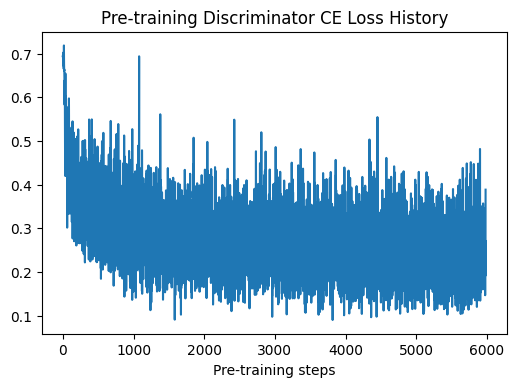

In [73]:
x = range(len(pretrain_disc_token_loss_history))
plt.figure(dpi=100)
plt.plot(x, pretrain_disc_token_loss_history)
plt.title('Pre-training Discriminator CE Loss History')
plt.xlabel('Pre-training steps')

In [74]:
loss_save_dir = '/home/lun/project-basileus/seq-gan/experiment_results/long_seqs_v10/init_pretrained_with_sparse/loss'
if not os.path.exists(loss_save_dir):
    os.makedirs(loss_save_dir)
    
with open(os.path.join(loss_save_dir, 'pretrain_disc_token_loss_history.pickle'), 'wb') as f:
    pickle.dump(pretrain_disc_token_loss_history, f)

### Save Pretrained D

In [75]:
if not os.path.exists('/home/lun/project-basileus/seq-gan/experiment_results/long_seqs_v10/init_pretrained_with_sparse/pretrained_disc_weights'):
    os.makedirs('/home/lun/project-basileus/seq-gan/experiment_results/long_seqs_v10/init_pretrained_with_sparse/pretrained_disc_weights')
    
D_save_path = '/home/lun/project-basileus/seq-gan/experiment_results/long_seqs_v10/init_pretrained_with_sparse/pretrained_disc_weights/model.tf'

In [76]:
pretrained_discriminator.save_weights(D_save_path)

In [77]:
reload_pretrained_disc = build_D_2(
    T = T,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim= HIDDEN_DIM,
)

reload_pretrained_disc.build(input_shape=((BATCH_SIZE, T, 1), (BATCH_SIZE, T, 1)))
reload_pretrained_disc.load_weights(D_save_path)

In [78]:
reload_pretrained_disc.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
event_type (InputLayer)         [(None, 21, 1)]      0                                            
__________________________________________________________________________________________________
masking_5 (Masking)             (None, 21, 1)        0           time_delta[0][0]                 
                                                                 event_type[0][0]                 
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 21, 1, 6)     36          masking_5[1][0]                  
__________________________________________________________________________________________________
time_delta (InputLayer)         [(None, 21, 1)]      0                                      

## Generate and predict seqs

In [79]:
def generate_batch_sequence_by_rollout(
        G, batch_size, T, end_token=0, init_token=1.0, max_time=1024, verbose=False):
    # Begin from dummy init state (init_token=1, init_timestamp=0.0)
    curr_state_et = tf.ones([batch_size, 1, 1], dtype=tf.float64)
    curr_state_ts = tf.zeros([batch_size, 1, 1], dtype=tf.float64)

    all_state_et = curr_state_et
    all_state_ts = curr_state_ts

    episode_token_probs = tf.constant(1., dtype=tf.float64, shape=(batch_size, 1))
    gaussian_log = tf.constant(0., dtype=tf.float64, shape=(batch_size, 1))

    G.reset_states()

    for step in range(1, T):  # sequence length
        token_prob, time_out = G([curr_state_et, curr_state_ts])

        sampled_et = tf.random.categorical(tf.math.log(token_prob), num_samples=1, dtype=tf.int32)
        sampled_et = tf.reshape(sampled_et, [batch_size, 1, 1])

        # get the chosen token probability per batch for each step
        batch_sample_et = tf.reshape(sampled_et, (batch_size, 1))
        batch_ind = tf.reshape(tf.range(0, batch_size), (batch_size, 1))
        batch_sample_et_2d = tf.concat([batch_ind, batch_sample_et], axis=1)

        sampled_token_prob = tf.reshape(tf.gather_nd(token_prob, batch_sample_et_2d), (batch_size, 1))
        episode_token_probs = tf.concat([episode_token_probs, sampled_token_prob], axis=1)

        # cast sampled_et into float
        sampled_et = tf.cast(sampled_et, dtype=tf.float64)

        # stop genererating once hit end_token
        cond_end_token = tf.equal(curr_state_et, end_token)
        curr_state_et = tf.where(cond_end_token, curr_state_et, sampled_et)
        all_state_et = tf.concat([all_state_et, curr_state_et], axis=1)

        # generate one timstamp using time_out
        sampled_ts_raw = time_out.sample()
        sampled_ts = tf.clip_by_value(tf.reshape(sampled_ts_raw, (batch_size, 1, 1))
                                      , clip_value_min=1, clip_value_max=max_time)

        # get the gaussian log likelihood for the sampled timestamps
        sampled_gaussian_log = time_out.log_prob(sampled_ts_raw)
        gaussian_log = tf.concat([gaussian_log, sampled_gaussian_log], axis=1)

        # stop generating once hit end_token
        curr_state_ts = tf.where(cond_end_token, curr_state_et, sampled_ts)
        all_state_ts = tf.concat([all_state_ts, curr_state_ts], axis=1)

    return all_state_et, all_state_ts, episode_token_probs, gaussian_log


In [80]:
def generate_sequences(N_gen, generator, batch_size, T, recover_to_timestamp=True):
    """
        Generate sequences batch per batch
    :param N_gen: total number of seqs to be generated
    :param generator:
    :param batch_size:
    :param T:
    :param recover_to_timestamp: whether to recover time deltas to absolute timestamps
    :return: a python list of shape [N_gen, T, 2]
    """
    all_type_seq = None
    all_time_seq = None
    N = 0

    while N < N_gen:
        batch_state_et, batch_state_ts, _, _ = generate_batch_sequence_by_rollout(generator, batch_size, T,
                                                                                  end_token=0, init_token=1.0,
                                                                                  max_time=1024, verbose=False)

        batch_type_seq = batch_state_et.numpy()
        batch_time_seq = batch_state_ts.numpy()

        # recover time delta to time stamps
        if recover_to_timestamp:
            batch_time_seq = np.cumsum(batch_time_seq, axis=1)

        if all_type_seq is None:
            all_type_seq = batch_type_seq
        else:
            all_type_seq = np.concatenate([all_type_seq, batch_type_seq], axis=0)

        if all_time_seq is None:
            all_time_seq = batch_time_seq
        else:
            all_time_seq = np.concatenate([all_time_seq, batch_time_seq], axis=0)

        N += batch_size

    # concat type and time in depth
    concated_seq_list = np.concatenate([all_type_seq, all_time_seq], axis=2).tolist()

    return concated_seq_list[:N_gen]


In [81]:
N_gen = 1000
generator = reload_pretrained_gen

generated_seqs = generate_sequences(N_gen, generator, batch_size=BATCH_SIZE, T=T, recover_to_timestamp=False)

In [82]:
generated_seqs

[[[1.0, 0.0],
  [2.0, 26.433949514259872],
  [5.0, 9.098800476667089],
  [5.0, 40.89278161293849],
  [4.0, 12.56210031937896],
  [3.0, 13.603912506237485],
  [2.0, 24.794585181049253],
  [2.0, 20.28612396443502],
  [3.0, 23.729206297282346],
  [4.0, 17.799479590345108],
  [3.0, 17.905888263032164],
  [5.0, 9.613219944646719],
  [4.0, 17.90352945213202],
  [3.0, 12.697276877796027],
  [5.0, 22.064428393890243],
  [4.0, 34.37982738499286],
  [3.0, 10.598709713801265],
  [2.0, 16.419715929777826],
  [4.0, 24.597456748758862],
  [2.0, 10.0340805157376],
  [3.0, 21.776666243923323]],
 [[1.0, 0.0],
  [4.0, 1.0],
  [4.0, 26.28854858409099],
  [3.0, 31.66079276665128],
  [2.0, 27.192592060023667],
  [5.0, 21.135195538789343],
  [2.0, 22.685975501889693],
  [4.0, 7.259781576174374],
  [3.0, 4.702508300819439],
  [2.0, 20.913319618740783],
  [5.0, 27.830844784764825],
  [4.0, 22.84153353997248],
  [4.0, 8.639689898607207],
  [4.0, 22.745491057521306],
  [4.0, 13.608677570925593],
  [2.0, 15.1081

In [83]:
generated_seqs = np.array(generated_seqs)
pred_generated = reload_pretrained_disc((generated_seqs[:,:,[0]], generated_seqs[:,:,[1]]))
(pred_generated > 0.5).numpy().sum()

870

In [84]:
pred_generated.numpy().mean(axis=0)

array([0.80457991])

In [85]:
pred_generated = reload_pretrained_disc((pos_event_type_seqs[:1000,:, :], pos_timestamp_seqs[:1000,:, :]))
(pred_generated > 0.5).numpy().sum()

950

In [86]:
pred_generated = reload_pretrained_disc((neg_event_type_seqs[:1000,:, :], neg_timestamp_seqs[:1000,:, :]))
(pred_generated > 0.5).numpy().sum()

153

In [ ]:
def is_sparse(seq):
    seq_et, seq_ts = seq[0,:,0].squeeze().tolist(), seq[0,:,1].squeeze().tolist()
    if seq_et[1] == 0:
        return True
    else:
        return False

In [ ]:
sparse_seqs = []
concrete_seqs = []

for i in range(generated_seqs.shape[0]):
    if is_sparse(generated_seqs[[i], :, :]):
        sparse_seqs.append(generated_seqs[[i], :, :])
    else:
        concrete_seqs.append(generated_seqs[[i], :, :])
        
sparse_seqs = np.array(sparse_seqs).squeeze()
concrete_seqs = np.array(concrete_seqs).squeeze()

In [ ]:
sparse_seqs.shape

In [ ]:
sparse_pred_generated = reload_pretrained_disc((sparse_seqs[:,:, [0]], sparse_seqs[:,:, [1]]))
(sparse_pred_generated > 0.5).numpy().sum()

In [ ]:
concrete_pred_generated = reload_pretrained_disc((concrete_seqs[:,:, [0]], concrete_seqs[:,:, [1]]))
(concrete_pred_generated > 0.5).numpy().sum()

In [ ]:
# generated_seqs[10:20, :, :]

In [ ]:
sparse_pred_generated

In [ ]:
concrete_pred_generated

In [ ]:
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

pos_event_type_seqs[:10, :, :].squeeze()

In [ ]:
neg_event_type_seqs[:10, :, :].squeeze()

In [ ]:
et = np.array([1.0] + [0.0] * 20).reshape(1, T, 1)
ts = np.array([0.0] + [0.0] * 20).reshape(1, T, 1)

In [ ]:
pred = reload_pretrained_disc((et, ts))
pred

In [ ]:
batch_state_et, batch_state_ts, _, _ = generate_batch_sequence_by_rollout_no_padding(generator, BATCH_SIZE, T,
                                                                          end_token=0, init_token=1.0,
                                                                          max_time=1024, verbose=False)

In [ ]:
batch_state_ts

In [55]:
pos_timestamp_seqs[:1000,:, :]

array([[[ 0.],
        [16.],
        [22.],
        ...,
        [32.],
        [29.],
        [30.]],

       [[ 0.],
        [14.],
        [ 9.],
        ...,
        [23.],
        [22.],
        [34.]],

       [[ 0.],
        [ 5.],
        [25.],
        ...,
        [15.],
        [30.],
        [ 8.]],

       ...,

       [[ 0.],
        [30.],
        [17.],
        ...,
        [31.],
        [26.],
        [32.]],

       [[ 0.],
        [39.],
        [19.],
        ...,
        [30.],
        [10.],
        [19.]],

       [[ 0.],
        [10.],
        [26.],
        ...,
        [15.],
        [25.],
        [28.]]])